# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


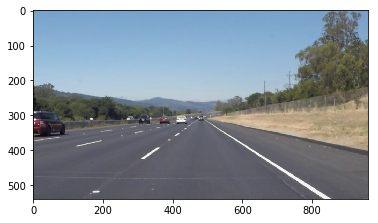

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting

print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2: #Rgb coloured image
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else: #Gray image 1 channel
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


# def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
#     """
#     NOTE: this is the function you might want to use as a starting point once you want to 
#     average/extrapolate the line segments you detect to map out the full
#     extent of the lane (going from the result shown in raw-lines-example.mp4
#     to that shown in P1_example.mp4).  
    
#     Think about things like separating line segments by their 
#     slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
#     line vs. the right line.  Then, you can average the position of each of 
#     the lines and extrapolate to the top and bottom of the lane.
    
#     This function draws `lines` with `color` and `thickness`.    
#     Lines are drawn on the image inplace (mutates the image).
#     If you want to make the lines semi-transparent, think about combining
#     this function with the weighted_img() function below
#     """
#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             cv2.line(img, (x1, y1), (x2, y2), color, thickness)
def draw_lines(img, lines, color=[255, 0, 0], thickness=6):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            a = (y2-y1)/(x2-x1)
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def calculate_slope(img, lines, color=[255, 0, 0], thickness=9):
    slope =[]
    point1_left = [[],[]]
    point2_left = [[],[]]
    point1_right = [[],[]]
    point2_right = [[],[]]
    a_list_left = []
    b_list_left = []
    a_list_right = []
    b_list_right = []
    num_of_points_left = 0
    num_of_points_right = 0

    for line in lines:
        for x1,y1,x2,y2 in line:
            #calculate slope
            #a, b = np.polyfit((x1,x2), (y1,y2), 1)
            #calculate b coefficient of y= ax + b line equation
            a = (y2-y1)/(x2-x1)
            b = y1 - a*x1
            if 0.3 > a > -0.3:
                continue
            #separate left and right line by slope
            # a > 0: right line, a < 0: left line
            if a < 0:
                if x1 > 520:
                    continue
                point1_left[0].append(x1)
                point1_left[1].append(y1)
                point2_left[0].append(x2)
                point2_left[1].append(y2)
                a_list_left.append(a)
                b_list_left.append(b)
                num_of_points_left = num_of_points_left + 1
                #cv2.circle(img,(x1,y1),8,[0,255,0],10)
                #cv2.circle(img,(x2,y2),8,[0,0,255],10)
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            else:
                if x1 < 440:
                    continue
                point1_right[0].append(x1)
                point1_right[1].append(y1)
                point2_right[0].append(x2)
                point2_right[1].append(y2)
                a_list_right.append(a)
                b_list_right.append(b)
                num_of_points_right = num_of_points_right + 1
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                
   
    point1_left = np.array(point1_left)
    point2_left = np.array(point2_left)
    a_list_left = np.array(a_list_left)
    b_list_left = np.array(b_list_left)
    x1_avg_left = int(np.mean(point1_left[0]))
    y1_avg_left = int(np.mean(point1_left[1]))
    x2_avg_left = int(np.mean(point2_left[0]))
    y2_avg_left = int(np.mean(point2_left[1]))
    a_avg_left = (np.mean(a_list_left))
    b_avg_left = (np.mean(b_list_left))
 
    point1_right = np.array(point1_right)
    point2_right = np.array(point2_right)
    a_list_right = np.array(a_list_right)
    b_list_right = np.array(b_list_right)
    x1_avg_right = int(np.mean(point1_right[0]))
    y1_avg_right = int(np.mean(point1_right[1]))
    x2_avg_right = int(np.mean(point2_right[0]))
    y2_avg_right = int(np.mean(point2_right[1]))
    a_avg_right = (np.mean(a_list_right))
    b_avg_right = (np.mean(b_list_right))
    
    #find position of top and bottom points of the extrapolated points
    y3_left = 540 #y-coordinate = y-coordinate of region of interest
    x3_left = int(((y3_left-b_avg_left)/a_avg_left))
    y4_left = 310 #y-coordinate = y-coordinate of region of interest
    x4_left = int(((y4_left-b_avg_left)/a_avg_left))
    #draw line from average position of (x1,y1),(x2,y2) to top and bottom points
    #cv2.line(img, (x1_avg_left, y1_avg_left), (x2_avg_left, y2_avg_left), color, thickness)
    #cv2.line(img, (x1_avg_left, y1_avg_left), (x4_left,y4_left), color, thickness)
    cv2.line(img, (x4_left, y4_left), (x3_left, y3_left), color, thickness)
    
    y3_right = 540
    x3_right = int(((y3_right - b_avg_right)/a_avg_right))
    y4_right = 310
    x4_right = int(((y4_right - b_avg_right)/a_avg_right))
    #draw line from average position of (x1,y1),(x2,y2) to top and bottom points
    #cv2.line(img, (x1_avg_right, y1_avg_right), (x2_avg_right, y2_avg_right), color, thickness)
    #cv2.line(img, (x1_avg_right, y1_avg_right), (x4_right,y4_right), color, thickness)
    cv2.line(img, (x4_right, y4_right), (x3_right, y3_right), color, thickness)
    print ("x3 = "+str(x3_left))
    print ('y3 ='+str(y3_left))
    print ('x4 =' + str(x4_left))
    print ('y4 =' +str(y4_left))
    print ('x1_list' + str(point1_left[0]))
    print ('y1_list' + str(point1_left[1]))
    print ('x2_list' + str(point2_left[0]))
    print ('y2_list' + str(point2_left[1]))
    print ('num_points_left' + str(num_of_points_left))
    print ('num_points_right' + str(num_of_points_right))
    print ('a_avg = ' + str(a_avg_left))
    print ('b_avg = ' + str(b_avg_left))
    print ('slope_left = ' + str(a_list_left))
    print ('slope_right ' + str(a_list_right))
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    #slope = calculate_slope(lines)
    calculate_slope(line_img,lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
x3 = 179
y3 =540
x4 =477
y4 =310
x1_list[280 293 386 405 385 383 280 390]
y1_list[460 462 383 363 382 381 462 382]
x2_list[346 353 481 463 461 461 344 462]
y2_list[410 412 312 323 325 322 410 322]
num_points_left8
num_points_right6
a_avg = -0.772522034265
b_avg = 678.754695293
slope_left = [-0.75757576 -0.83333333 -0.74736842 -0.68965517 -0.75       -0.75641026
 -0.8125     -0.83333333]
slope_right [ 0.55242967  0.55430712  0.57407407  0.57614213  0.56666667  0.55405405]


(540, 960, 3)

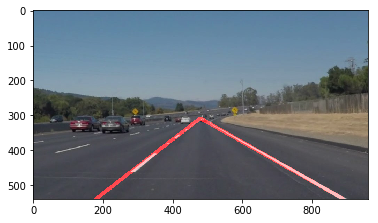

In [13]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

#Gray scale image
gray = grayscale(image)
plt.imshow(gray, cmap='gray')
# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = gaussian_blur(gray,kernel_size)
plt.imshow(blur_gray, cmap='gray')
# Define our parameters for Canny and apply
low_threshold = 30
high_threshold = 150
edges = canny(blur_gray,low_threshold,high_threshold)
plt.imshow(edges,cmap='Greys_r')
# This time we are defining a four sided polygon to mask
#xsize = imshape[1]
#ysize = imshape[0]
imshape = image.shape
top_mask_bound = 310
bottom_mask_bound = 540
vertices = np.array([[(0,imshape[0]),(480, top_mask_bound), (480,top_mask_bound), (imshape[1],imshape[0])]], dtype=np.int32)
masked_edges = region_of_interest(edges,vertices)
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15 # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 20   # maximum gap in pixels between connectable line segments
#Run hoghline detection on edges image
line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)


#Draw the line on the colour image
line_colored_image = weighted_img(line_image,image)
plt.imshow(line_colored_image)
image.shape


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [15]:
def process_image(image):
    
    #Gray scale image
    gray = grayscale(image)
    plt.imshow(gray, cmap='gray')
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray,kernel_size)
    plt.imshow(blur_gray, cmap='gray')
    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray,low_threshold,high_threshold)
    plt.imshow(edges,cmap='Greys_r')
    # This time we are defining a four sided polygon to mask
    #xsize = imshape[1]
    #ysize = imshape[0]
    imshape = image.shape
    top_mask_bound = 310
    bottom_mask_bound = 540
    vertices = np.array([[(0,imshape[0]),(479, top_mask_bound), (490,top_mask_bound), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges,vertices)
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/90 # angular resolution in radians of the Hough grid
    threshold = 10 #minimum number of votes (intersections in Hough grid cell)
    min_line_length = 15 #minimum number of pixels making up a line
    max_line_gap = 10   # maximum gap in pixels between connectable line segments
    #Run hoghline detection on edges image
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)


    #Draw the line on the colour image
    line_colored_image = weighted_img(line_image,image)
    plt.imshow(line_colored_image)
   
    return line_colored_image

Let's try the one with the solid white lane on the right first ...

x3 = 150
y3 =540
x4 =470
y4 =310
x1_list[187 217 416 391 416 203 388 419 271 187 202 418]
y1_list[513 504 348 370 349 514 367 349 463 512 514 350]
x2_list[300 310 451 406 464 282 404 470 310 297 232 433]
y2_list[431 432 323 359 317 453 357 314 433 432 491 340]
num_points_left12
num_points_right13
a_avg = -0.718950518155
b_avg = 648.558280475
slope_left = [-0.72566372 -0.77419355 -0.71428571 -0.73333333 -0.66666667 -0.7721519
 -0.625      -0.68627451 -0.76923077 -0.72727273 -0.76666667 -0.66666667]
slope_right [ 0.62616822  0.61538462  0.61842105  0.62941176  0.61616162  0.63265306
  0.60869565  0.61904762  0.64285714  0.62025316  0.624       0.625
  0.62962963]
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  0%|                                                                                                                                                                                                              | 0/222 [00:00<?, ?it/s]

x3 = 150
y3 =540
x4 =470
y4 =310
x1_list[187 217 416 391 416 203 388 419 271 187 202 418]
y1_list[513 504 348 370 349 514 367 349 463 512 514 350]
x2_list[300 310 451 406 464 282 404 470 310 297 232 433]
y2_list[431 432 323 359 317 453 357 314 433 432 491 340]
num_points_left12
num_points_right13
a_avg = -0.718950518155
b_avg = 648.558280475
slope_left = [-0.72566372 -0.77419355 -0.71428571 -0.73333333 -0.66666667 -0.7721519
 -0.625      -0.68627451 -0.76923077 -0.72727273 -0.76666667 -0.66666667]
slope_right [ 0.62616822  0.61538462  0.61842105  0.62941176  0.61616162  0.63265306
  0.60869565  0.61904762  0.64285714  0.62025316  0.624       0.625
  0.62962963]


  0%|▉                                                                                                                                                                                                     | 1/222 [00:00<00:36,  6.07it/s]

x3 = 158
y3 =540
x4 =467
y4 =310
x1_list[150 170 222 151 428 413 383 416 388 414 193 172 170 268]
y1_list[538 539 500 539 344 351 371 352 373 351 522 537 538 465]
x2_list[276 240 289 279 470 453 400 461 403 451 287 188 185 289]
y2_list[447 485 448 446 314 322 360 319 362 324 449 524 526 449]
num_points_left14
num_points_right14
a_avg = -0.745005295531
b_avg = 658.284286685
slope_left = [-0.72222222 -0.77142857 -0.7761194  -0.7265625  -0.71428571 -0.725
 -0.64705882 -0.73333333 -0.73333333 -0.72972973 -0.77659574 -0.8125     -0.8
 -0.76190476]
slope_right [ 0.61607143  0.59090909  0.625       0.625       0.625       0.63
  0.61538462  0.61797753  0.6119403   0.62011173  0.6         0.6
  0.61728395  0.6       ]


  1%|█▊                                                                                                                                                                                                    | 2/222 [00:00<00:34,  6.29it/s]

x3 = 155
y3 =540
x4 =470
y4 =310
x1_list[414 151 171 411 376 379 150 411 235 411 412 382 170 441]
y1_list[354 538 538 352 376 379 538 353 490 354 354 378 538 334]
x2_list[470 250 261 427 396 398 245 453 261 454 461 399 223 466]
y2_list[314 467 468 340 363 365 469 322 469 323 319 366 499 316]
num_points_left14
num_points_right13
a_avg = -0.729652000439
b_avg = 653.563001057
slope_left = [-0.71428571 -0.71717172 -0.77777778 -0.75       -0.65       -0.73684211
 -0.72631579 -0.73809524 -0.80769231 -0.72093023 -0.71428571 -0.70588235
 -0.73584906 -0.72      ]
slope_right [ 0.63114754  0.62698413  0.61805556  0.61607143  0.61616162  0.63095238
  0.61458333  0.64285714  0.64285714  0.63636364  0.61111111  0.63106796
  0.54545455]


  1%|██▋                                                                                                                                                                                                   | 3/222 [00:00<00:33,  6.47it/s]

x3 = 154
y3 =540
x4 =472
y4 =310
x1_list[169 148 369 375 369 408 442 410 408 440 169 409 176 189 378 428 150 454]
y1_list[539 538 382 383 381 354 334 356 356 334 538 356 518 524 380 341 537 325]
x2_list[225 199 392 394 384 425 474 429 427 460 212 454 211 225 394 450 168 472]
y2_list[495 503 366 369 370 341 312 343 341 320 505 323 494 496 368 325 525 313]
num_points_left18
num_points_right11
a_avg = -0.724365545489
b_avg = 651.957137684
slope_left = [-0.78571429 -0.68627451 -0.69565217 -0.73684211 -0.73333333 -0.76470588
 -0.6875     -0.68421053 -0.78947368 -0.7        -0.76744186 -0.73333333
 -0.68571429 -0.77777778 -0.75       -0.72727273 -0.66666667 -0.66666667]
slope_right [ 0.62458472  0.61805556  0.63013699  0.625       0.62037037  0.61682243
  0.61682243  0.61111111  0.61764706  0.62601626  0.61682243]


  2%|███▌                                                                                                                                                                                                  | 4/222 [00:00<00:32,  6.61it/s]

x3 = 133
y3 =540
x4 =475
y4 =310
x1_list[365 438 404 361 404 360 438 367 407 440 437 405]
y1_list[389 335 356 386 358 387 334 389 358 335 333 358]
x2_list[389 468 423 386 426 387 459 389 427 455 453 426]
y2_list[372 315 343 370 342 370 322 373 345 325 322 343]
num_points_left12
num_points_right13
a_avg = -0.672772213573
b_avg = 630.10741005
slope_left = [-0.70833333 -0.66666667 -0.68421053 -0.64       -0.72727273 -0.62962963
 -0.57142857 -0.72727273 -0.65       -0.66666667 -0.6875     -0.71428571]
slope_right [ 0.62606232  0.6173913   0.62655602  0.6173913   0.61333333  0.61788618
  0.61445783  0.61797753  0.6259542   0.61904762  0.62068966  0.61111111
  0.6119403 ]


  2%|████▍                                                                                                                                                                                                 | 5/222 [00:00<00:30,  7.07it/s]

x3 = 146
y3 =540
x4 =473
y4 =310
x1_list[351 441 360 403 402 357 437]
y1_list[393 334 394 360 360 395 335]
x2_list[379 466 384 425 425 384 472]
y2_list[374 316 376 346 343 374 313]
num_points_left7
num_points_right13
a_avg = -0.70434495801
b_avg = 643.23370466
slope_left = [-0.67857143 -0.72       -0.75       -0.63636364 -0.73913043 -0.77777778
 -0.62857143]
slope_right [ 0.62765957  0.62790698  0.6171875   0.61818182  0.61832061  0.61363636
  0.60526316  0.62745098  0.6         0.64516129  0.64        0.61764706
  0.62337662]


  3%|█████▎                                                                                                                                                                                                | 6/222 [00:00<00:29,  7.42it/s]

x3 = 140
y3 =540
x4 =471
y4 =310
x1_list[347 339 346 436 436 438 349 397 435 448 399]
y1_list[403 402 403 335 333 336 394 363 334 328 363]
x2_list[377 374 377 470 451 453 372 422 450 472 417]
y2_list[381 378 380 314 323 326 378 345 325 313 347]
num_points_left11
num_points_right24
a_avg = -0.694682232534
b_avg = 637.625776965
slope_left = [-0.73333333 -0.68571429 -0.74193548 -0.61764706 -0.66666667 -0.66666667
 -0.69565217 -0.72       -0.6        -0.625      -0.88888889]
slope_right [ 0.625       0.62790698  0.61538462  0.61818182  0.65714286  0.55882353
  0.61832061  0.55555556  0.61111111  0.59574468  0.55172414  0.59375
  0.61607143  0.6         0.54545455  0.5625      0.61538462  0.7         0.5625
  0.58823529  0.55172414  0.6         0.62068966  0.57894737]


  3%|██████▏                                                                                                                                                                                               | 7/222 [00:01<00:31,  6.83it/s]

x3 = 163
y3 =540
x4 =467
y4 =310
x1_list[437 436 326 335 334 434 395 435 327]
y1_list[337 337 411 412 412 335 366 337 410]
x2_list[468 462 364 370 370 451 415 453 352]
y2_list[315 318 384 385 384 323 348 323 392]
num_points_left9
num_points_right14
a_avg = -0.755982160649
b_avg = 663.467624393
slope_left = [-0.70967742 -0.73076923 -0.71052632 -0.77142857 -0.77777778 -0.70588235
 -0.9        -0.77777778 -0.72      ]
slope_right [ 0.62737643  0.6254417   0.61832061  0.61111111  0.61616162  0.6122449
  0.60465116  0.62921348  0.61111111  0.62318841  0.64516129  0.625       0.64
  0.63636364]


  4%|███████▏                                                                                                                                                                                              | 8/222 [00:01<00:32,  6.68it/s]

x3 = 145
y3 =540
x4 =479
y4 =310
x1_list[437 310 315 434 433 433 432 343 339 318 163 321]
y1_list[338 423 425 338 336 338 336 405 401 424 528 423]
x2_list[470 354 349 464 448 449 449 361 356 342 179 340]
y2_list[314 391 402 317 326 327 324 393 390 406 519 409]
num_points_left12
num_points_right13
a_avg = -0.687844388154
b_avg = 640.099144111
slope_left = [-0.72727273 -0.72727273 -0.67647059 -0.7        -0.66666667 -0.6875
 -0.70588235 -0.66666667 -0.64705882 -0.75       -0.5625     -0.73684211]
slope_right [ 0.62650602  0.58333333  0.62676056  0.59574468  0.61458333  0.5483871
  0.5890411   0.61538462  0.63063063  0.63076923  0.57692308  0.61363636
  0.52941176]


  4%|████████                                                                                                                                                                                              | 9/222 [00:01<00:31,  6.80it/s]

x3 = 143
y3 =540
x4 =476
y4 =310
x1_list[297 318 289 433 432 289 431 299 306 431]
y1_list[441 419 438 342 341 439 339 440 426 340]
x2_list[351 346 326 449 479 308 458 350 342 465]
y2_list[402 399 413 331 310 426 320 403 401 318]
num_points_left10
num_points_right12
a_avg = -0.691416577434
b_avg = 639.38738576
slope_left = [-0.72222222 -0.71428571 -0.67567568 -0.6875     -0.65957447 -0.68421053
 -0.7037037  -0.7254902  -0.69444444 -0.64705882]
slope_right [ 0.62660944  0.63076923  0.62430939  0.62416107  0.61666667  0.61702128
  0.62637363  0.62827225  0.61538462  0.61333333  0.62037037  0.63157895]


  5%|████████▊                                                                                                                                                                                            | 10/222 [00:01<00:32,  6.59it/s]

x3 = 157
y3 =540
x4 =473
y4 =310
x1_list[431 263 268 429 300 277 430 432 429 275 436]
y1_list[344 459 456 342 442 459 342 344 344 460 340]
x2_list[482 331 332 462 339 340 460 448 464 303 456]
y2_list[310 410 410 318 412 410 321 334 317 438 325]
num_points_left11
num_points_right19
a_avg = -0.728402639399
b_avg = 654.972818195
slope_left = [-0.66666667 -0.72058824 -0.71875    -0.72727273 -0.76923077 -0.77777778
 -0.7        -0.625      -0.77142857 -0.78571429 -0.75      ]
slope_right [ 0.584       0.62857143  0.59016393  0.62962963  0.63414634  0.59183673
  0.6119403   0.609375    0.59090909  0.58974359  0.6         0.59090909
  0.61538462  0.58823529  0.57142857  0.60714286  0.625       0.60606061
  0.55555556]


  5%|█████████▊                                                                                                                                                                                           | 11/222 [00:01<00:34,  6.15it/s]

x3 = 149
y3 =540
x4 =481
y4 =310
x1_list[239 232 290 240 421 397 449 234 419 428 447 230 296 443]
y1_list[485 480 439 485 352 370 328 479 350 344 334 482 435 335]
x2_list[325 305 316 326 478 468 464 254 463 453 462 247 318 478]
y2_list[423 430 421 423 311 315 317 466 318 327 324 471 421 313]
num_points_left14
num_points_right13
a_avg = -0.691593743782
b_avg = 643.152638747
slope_left = [-0.72093023 -0.68493151 -0.69230769 -0.72093023 -0.71929825 -0.77464789
 -0.73333333 -0.65       -0.72727273 -0.68       -0.66666667 -0.64705882
 -0.63636364 -0.62857143]
slope_right [ 0.62447257  0.61764706  0.62580645  0.63157895  0.63265306  0.63013699
  0.64516129  0.61682243  0.609375    0.62921348  0.63333333  0.64
  0.64516129]


  5%|██████████▋                                                                                                                                                                                          | 12/222 [00:01<00:33,  6.23it/s]

x3 = 145
y3 =540
x4 =478
y4 =310
x1_list[235 220 196 391 388 418 183 444 406 289 419 206 199 235 278 445 416 219
 426]
y1_list[476 487 516 372 371 350 514 332 360 447 353 497 515 487 446 332 351 488
 346]
x2_list[300 283 307 406 403 464 231 478 432 306 455 232 244 307 297 466 460 262
 454]
y2_list[432 444 435 362 360 317 481 312 341 435 325 480 482 434 433 320 319 459
 328]
num_points_left19
num_points_right12
a_avg = -0.690538243156
b_avg = 640.690035643
slope_left = [-0.67692308 -0.68253968 -0.72972973 -0.66666667 -0.73333333 -0.7173913
 -0.6875     -0.58823529 -0.73076923 -0.70588235 -0.77777778 -0.65384615
 -0.73333333 -0.73611111 -0.68421053 -0.57142857 -0.72727273 -0.6744186
 -0.64285714]
slope_right [ 0.6231003   0.63076923  0.63333333  0.6119403   0.62318841  0.63492063
  0.62348178  0.63492063  0.63793103  0.6         0.63013699  0.61818182]


  6%|███████████▌                                                                                                                                                                                         | 13/222 [00:01<00:34,  6.01it/s]

x3 = 143
y3 =540
x4 =475
y4 =310
x1_list[145 232 163 416 203 414 164 413 157 441 385 382 146 188 381]
y1_list[538 487 538 353 498 353 538 350 529 333 374 373 537 507 374]
x2_list[169 285 285 431 274 454 245 429 211 479 403 398 186 264 399]
y2_list[522 448 449 343 447 322 479 340 492 310 363 361 510 455 361]
num_points_left15
num_points_right12
a_avg = -0.691892514018
b_avg = 639.233110588
slope_left = [-0.66666667 -0.73584906 -0.7295082  -0.66666667 -0.71830986 -0.775
 -0.72839506 -0.625      -0.68518519 -0.60526316 -0.61111111 -0.75       -0.675
 -0.68421053 -0.72222222]
slope_right [ 0.62318841  0.62457338  0.66863905  0.63        0.66666667  0.67346939
  0.62536873  0.65384615  0.6         0.625       0.63492063  0.64705882]


  6%|████████████▍                                                                                                                                                                                        | 14/222 [00:02<00:35,  5.91it/s]

x3 = 142
y3 =540
x4 =472
y4 =310
x1_list[142 162 375 410 199 412 378 161 379 162 224 142 426]
y1_list[539 537 375 351 499 353 377 538 377 538 480 538 345]
x2_list[243 258 395 466 246 451 398 253 397 203 244 189 458]
y2_list[466 467 362 316 465 323 365 471 366 508 466 506 320]
num_points_left13
num_points_right12
a_avg = -0.696365717694
b_avg = 639.163864203
slope_left = [-0.72277228 -0.72916667 -0.65       -0.625      -0.72340426 -0.76923077
 -0.6        -0.72826087 -0.61111111 -0.73170732 -0.7        -0.68085106
 -0.78125   ]
slope_right [ 0.62569832  0.63157895  0.67052023  0.63333333  0.62436548  0.66666667
  0.62721893  0.67346939  0.63157895  0.64        0.66887417  0.63636364]


  7%|█████████████▎                                                                                                                                                                                       | 15/222 [00:02<00:33,  6.25it/s]

x3 = 152
y3 =540
x4 =470
y4 =310
x1_list[158 373 368 157 375 138 160 424 407 189 369 408 410 139]
y1_list[538 380 378 538 379 538 522 345 352 501 377 353 354 538]
x2_list[221 393 390 221 395 210 207 442 427 205 388 456 424 154]
y2_list[492 365 364 491 366 489 490 329 339 491 364 321 339 528]
num_points_left14
num_points_right11
a_avg = -0.722511807562
b_avg = 650.013325963
slope_left = [-0.73015873 -0.75       -0.63636364 -0.734375   -0.65       -0.68055556
 -0.68085106 -0.88888889 -0.65       -0.625      -0.68421053 -0.66666667
 -1.07142857 -0.66666667]
slope_right [ 0.62608696  0.6713615   0.62436548  0.66666667  0.59259259  0.6779661
  0.60869565  0.61538462  0.57894737  0.62416107  0.60869565]


  7%|██████████████▏                                                                                                                                                                                      | 16/222 [00:02<00:31,  6.46it/s]

x3 = 139
y3 =540
x4 =470
y4 =310
x1_list[408 360 366 138 404 405 404 136 367 360 365]
y1_list[355 383 385 537 355 355 353 539 385 384 385]
x2_list[427 384 387 153 426 427 422 155 390 385 390]
y2_list[341 367 370 527 340 340 340 526 369 367 367]
num_points_left11
num_points_right12
a_avg = -0.695471130815
b_avg = 637.216892423
slope_left = [-0.73684211 -0.66666667 -0.71428571 -0.66666667 -0.68181818 -0.68181818
 -0.72222222 -0.68421053 -0.69565217 -0.68       -0.72      ]
slope_right [ 0.62721893  0.67213115  0.625       0.63636364  0.6625      0.66037736
  0.64        0.62162162  0.64285714  0.63636364  0.63636364  0.60714286]


  8%|███████████████                                                                                                                                                                                      | 17/222 [00:02<00:32,  6.35it/s]

x3 = 133
y3 =540
x4 =472
y4 =310
x1_list[359 358 437 350 363 401 438 406 437]
y1_list[384 392 334 391 388 358 334 356 333]
x2_list[380 384 458 377 384 425 460 424 454]
y2_list[371 373 320 373 372 342 319 344 322]
num_points_left9
num_points_right12
a_avg = -0.678585031526
b_avg = 630.499182734
slope_left = [-0.61904762 -0.73076923 -0.66666667 -0.66666667 -0.76190476 -0.66666667
 -0.68181818 -0.66666667 -0.64705882]
slope_right [ 0.62606232  0.67171717  0.67088608  0.63461538  0.64        0.69230769
  0.62903226  0.61111111  0.70833333  0.7         0.67096774  0.61904762]


  8%|███████████████▉                                                                                                                                                                                     | 18/222 [00:02<00:32,  6.33it/s]

x3 = 154
y3 =540
x4 =472
y4 =310
x1_list[438 339 358 435 346 435 400 398]
y1_list[336 400 393 334 402 336 363 363]
x2_list[464 374 378 451 368 453 419 423]
y2_list[317 377 380 323 387 323 345 345]
num_points_left8
num_points_right13
a_avg = -0.724602614126
b_avg = 652.149247206
slope_left = [-0.73076923 -0.65714286 -0.65       -0.6875     -0.68181818 -0.72222222
 -0.94736842 -0.72      ]
slope_right [ 0.62611276  0.67195767  0.62569832  0.66129032  0.67045455  0.63414634
  0.64285714  0.63095238  0.60869565  0.61538462  0.64102564  0.68421053
  0.61111111]


  9%|████████████████▊                                                                                                                                                                                    | 19/222 [00:02<00:32,  6.29it/s]

x3 = 127
y3 =540
x4 =475
y4 =310
x1_list[326 337 447 342 434 445 327 461 434]
y1_list[410 411 330 407 336 327 410 321 338]
x2_list[364 370 464 371 453 460 350 478 455]
y2_list[385 387 318 385 322 322 395 310 323]
num_points_left9
num_points_right14
a_avg = -0.659262710685
b_avg = 623.802230573
slope_left = [-0.65789474 -0.72727273 -0.70588235 -0.75862069 -0.73684211 -0.33333333
 -0.65217391 -0.64705882 -0.71428571]
slope_right [ 0.625       0.63636364  0.66153846  0.63380282  0.62962963  0.63793103
  0.63265306  0.6         0.62686567  0.66153846  0.63513514  0.60869565
  0.63043478  0.61904762]


  9%|█████████████████▋                                                                                                                                                                                   | 20/222 [00:03<00:31,  6.33it/s]

x3 = 140
y3 =540
x4 =481
y4 =310
x1_list[319 433 310 439 322 163 318 433 165 311 433]
y1_list[425 340 422 337 414 526 425 338 526 422 339]
x2_list[362 476 359 479 357 178 333 460 180 327 461]
y2_list[394 311 392 310 392 516 414 319 516 412 319]
num_points_left11
num_points_right26
a_avg = -0.674620113491
b_avg = 634.97745482
slope_left = [-0.72093023 -0.6744186  -0.6122449  -0.675      -0.62857143 -0.66666667
 -0.73333333 -0.7037037  -0.66666667 -0.625      -0.71428571]
slope_right [ 0.66216216  0.66666667  0.63636364  0.63513514  0.63218391  0.63636364
  0.56521739  0.63333333  0.59183673  0.59183673  0.60869565  0.65957447
  0.59183673  0.63414634  0.66037736  0.63380282  0.61904762  0.56        0.7
  0.62962963  0.64864865  0.6875      0.58536585  0.66666667  0.65217391
  0.73333333]


  9%|██████████████████▋                                                                                                                                                                                  | 21/222 [00:03<00:33,  6.03it/s]

x3 = 150
y3 =540
x4 =476
y4 =310
x1_list[300 290 432 432 446 432 444 326 301]
y1_list[439 437 342 340 332 339 331 412 439]
x2_list[352 347 458 479 479 460 462 344 352]
y2_list[401 399 320 310 311 319 318 400 402]
num_points_left9
num_points_right12
a_avg = -0.705212894616
b_avg = 645.956600485
slope_left = [-0.73076923 -0.66666667 -0.84615385 -0.63829787 -0.63636364 -0.71428571
 -0.72222222 -0.66666667 -0.7254902 ]
slope_right [ 0.66666667  0.64102564  0.62535211  0.67142857  0.63235294  0.66071429
  0.62903226  0.59090909  0.66666667  0.60714286  0.66990291  0.63636364]


 10%|███████████████████▌                                                                                                                                                                                 | 22/222 [00:03<00:34,  5.83it/s]

x3 = 134
y3 =540
x4 =478
y4 =310
x1_list[274 399 264 277 404 422 437 467 312 413 443]
y1_list[457 363 455 456 364 346 338 318 421 355 331]
x2_list[341 476 334 341 431 454 480 483 331 437 460]
y2_list[409 311 408 410 342 324 311 311 409 339 319]
num_points_left11
num_points_right15
a_avg = -0.668524628703
b_avg = 629.928529733
slope_left = [-0.71641791 -0.67532468 -0.67142857 -0.71875    -0.81481481 -0.6875
 -0.62790698 -0.4375     -0.63157895 -0.66666667 -0.70588235]
slope_right [ 0.625       0.64        0.63333333  0.63414634  0.63636364  0.62393162
  0.63333333  0.63043478  0.63636364  0.61764706  0.63013699  0.6
  0.60714286  0.59259259  0.63157895]


 10%|████████████████████▍                                                                                                                                                                                | 23/222 [00:03<00:38,  5.16it/s]

x3 = 138
y3 =540
x4 =486
y4 =310
x1_list[409 241 284 290 250 408 419 397 266 231 292 232 246 298]
y1_list[356 479 440 445 463 356 347 367 452 476 434 476 477 440]
x2_list[478 302 321 327 289 466 454 435 307 265 319 252 264 316]
y2_list[310 438 417 420 438 317 322 341 426 454 417 463 465 428]
num_points_left14
num_points_right16
a_avg = -0.660157065299
b_avg = 631.151951741
slope_left = [-0.66666667 -0.67213115 -0.62162162 -0.67567568 -0.64102564 -0.67241379
 -0.71428571 -0.68421053 -0.63414634 -0.64705882 -0.62962963 -0.65
 -0.66666667 -0.66666667]
slope_right [ 0.625       0.63333333  0.63218391  0.63829787  0.63414634  0.625       0.64
  0.63414634  0.625       0.64        0.63414634  0.63636364  0.625
  0.63793103  0.60869565  0.63157895]


 11%|█████████████████████▎                                                                                                                                                                               | 24/222 [00:03<00:36,  5.45it/s]

x3 = 151
y3 =540
x4 =470
y4 =310
x1_list[200 406 417 207 245 256 187 401 276 417]
y1_list[510 358 349 494 468 471 507 364 447 348]
x2_list[310 474 454 270 298 310 239 445 300 446]
y2_list[431 312 322 449 430 432 470 329 430 327]
num_points_left10
num_points_right15
a_avg = -0.721733547609
b_avg = 649.648761114
slope_left = [-0.71818182 -0.67647059 -0.72972973 -0.71428571 -0.71698113 -0.72222222
 -0.71153846 -0.79545455 -0.70833333 -0.72413793]
slope_right [ 0.62640449  0.625       0.63265306  0.62962963  0.64        0.63636364
  0.63793103  0.63636364  0.62886598  0.625       0.62460568  0.62857143
  0.60869565  0.64        0.60714286]


 11%|██████████████████████▏                                                                                                                                                                              | 25/222 [00:04<00:41,  4.72it/s]

x3 = 154
y3 =540
x4 =474
y4 =310
x1_list[162 214 163 414 141 163 384 387 414 417 141 389]
y1_list[538 488 523 352 539 539 372 374 350 353 538 374]
x2_list[289 277 279 472 191 289 401 404 456 432 232 418]
y2_list[446 445 445 313 505 447 360 363 322 339 477 350]
num_points_left12
num_points_right8
a_avg = -0.717732708452
b_avg = 650.78454672
slope_left = [-0.72440945 -0.68253968 -0.67241379 -0.67241379 -0.68       -0.73015873
 -0.70588235 -0.64705882 -0.66666667 -0.93333333 -0.67032967 -0.82758621]
slope_right [ 0.62576687  0.67222222  0.66666667  0.66666667  0.625       0.62691131
  0.63333333  0.67123288]


 12%|███████████████████████                                                                                                                                                                              | 26/222 [00:04<00:38,  5.05it/s]

x3 = 162
y3 =540
x4 =474
y4 =310
x1_list[164 142 381 412 182 377 412 143 377 165 427 415 426 442]
y1_list[539 539 379 354 511 377 353 538 376 537 347 355 343 334]
x2_list[262 191 399 474 250 396 428 236 393 261 443 456 447 478]
y2_list[468 506 366 312 465 364 341 475 365 467 330 321 327 310]
num_points_left14
num_points_right14
a_avg = -0.737336258432
b_avg = 659.58716717
slope_left = [-0.7244898  -0.67346939 -0.72222222 -0.67741935 -0.67647059 -0.68421053
 -0.75       -0.67741935 -0.6875     -0.72916667 -1.0625     -0.82926829
 -0.76190476 -0.66666667]
slope_right [ 0.62640449  0.62537764  0.6626506   0.67010309  0.63793103  0.63793103
  0.63829787  0.63265306  0.62068966  0.60714286  0.61538462  0.63513514
  0.61538462  0.60869565]


 12%|███████████████████████▉                                                                                                                                                                             | 27/222 [00:04<00:35,  5.52it/s]

x3 = 142
y3 =540
x4 =476
y4 =310
x1_list[142 412 164 409 370 373 408 165 370 147 192 412 370 438 440 423 376]
y1_list[538 357 538 355 381 384 355 538 383 536 504 354 382 332 334 345 383]
x2_list[211 430 225 474 386 395 426 226 391 190 208 430 389 454 479 451 394]
y2_list[492 344 494 312 370 370 342 494 367 507 493 342 368 322 310 325 371]
num_points_left17
num_points_right10
a_avg = -0.687517958509
b_avg = 637.834089907
slope_left = [-0.66666667 -0.72222222 -0.72131148 -0.66153846 -0.6875     -0.63636364
 -0.72222222 -0.72131148 -0.76190476 -0.6744186  -0.6875     -0.66666667
 -0.73684211 -0.625      -0.61538462 -0.71428571 -0.66666667]
slope_right [ 0.62301587  0.67460317  0.66901408  0.62727273  0.66666667  0.60869565
  0.66666667  0.671875    0.6         0.67567568]


 13%|████████████████████████▊                                                                                                                                                                            | 28/222 [00:04<00:35,  5.44it/s]

x3 = 153
y3 =540
x4 =476
y4 =310
x1_list[362 442 440 368 142 371 406 441 363 410 407 369]
y1_list[388 335 335 389 539 388 359 332 386 357 357 389]
x2_list[388 474 467 390 159 390 454 458 386 428 423 389]
y2_list[371 312 316 372 528 374 324 320 371 345 344 374]
num_points_left12
num_points_right12
a_avg = -0.712443138199
b_avg = 649.372466313
slope_left = [-0.65384615 -0.71875    -0.7037037  -0.77272727 -0.64705882 -0.73684211
 -0.72916667 -0.70588235 -0.65217391 -0.66666667 -0.8125     -0.75      ]
slope_right [ 0.625       0.62535211  0.66917293  0.66666667  0.66929134  0.63793103
  0.62790698  0.63793103  0.63333333  0.63414634  0.61111111  0.63636364]


 13%|█████████████████████████▋                                                                                                                                                                           | 29/222 [00:04<00:35,  5.41it/s]

x3 = 136
y3 =540
x4 =471
y4 =310
x1_list[352 362 442 352 437 360 362 437]
y1_list[395 394 329 394 335 395 386 336]
x2_list[381 385 481 372 474 384 377 464]
y2_list[374 375 310 380 312 375 376 319]
num_points_left8
num_points_right17
a_avg = -0.686081953248
b_avg = 633.475436681
slope_left = [-0.72413793 -0.82608696 -0.48717949 -0.7        -0.62162162 -0.83333333
 -0.66666667 -0.62962963]
slope_right [ 0.62613982  0.66942149  0.66956522  0.63636364  0.63636364  0.63793103
  0.625       0.63043478  0.67532468  0.66666667  0.65625     0.63461538
  0.64516129  0.63157895  0.57894737  0.5625      0.64102564]


 14%|██████████████████████████▌                                                                                                                                                                          | 30/222 [00:05<00:35,  5.40it/s]

x3 = 137
y3 =540
x4 =477
y4 =310
x1_list[348 437 436 351 349 435 341 341 438]
y1_list[402 336 336 393 402 335 400 402 336]
x2_list[379 470 466 375 379 453 359 366 453]
y2_list[380 314 316 378 381 322 389 384 326]
num_points_left9
num_points_right11
a_avg = -0.676445639188
b_avg = 632.746477499
slope_left = [-0.70967742 -0.66666667 -0.66666667 -0.625      -0.7        -0.72222222
 -0.61111111 -0.72       -0.66666667]
slope_right [ 0.625       0.62429379  0.672       0.63513514  0.63157895  0.63793103
  0.63513514  0.66666667  0.61904762  0.625       0.625     ]


 14%|███████████████████████████▌                                                                                                                                                                         | 31/222 [00:05<00:34,  5.61it/s]

x3 = 131
y3 =540
x4 =477
y4 =310
x1_list[335 436 434 434 327 328 434 348]
y1_list[412 337 337 335 409 409 336 395]
x2_list[371 470 466 451 367 344 456 364]
y2_list[386 314 316 323 384 399 321 385]
num_points_left8
num_points_right17
a_avg = -0.664705418152
b_avg = 627.604394125
slope_left = [-0.72222222 -0.67647059 -0.65625    -0.70588235 -0.625      -0.625
 -0.68181818 -0.625     ]
slope_right [ 0.66666667  0.65625     0.66981132  0.66666667  0.60606061  0.62416107
  0.60869565  0.62222222  0.67142857  0.60869565  0.60714286  0.6626506
  0.64705882  0.62068966  0.62447257  0.64        0.61904762]


 14%|████████████████████████████▍                                                                                                                                                                        | 32/222 [00:05<00:36,  5.24it/s]

x3 = 140
y3 =540
x4 =477
y4 =310
x1_list[311 319 433 432 167 322 434 168 166 436 432]
y1_list[421 423 337 337 521 422 337 521 521 337 336]
x2_list[358 363 470 451 182 363 449 184 181 464 447]
y2_list[389 391 314 323 511 392 328 511 511 317 325]
num_points_left11
num_points_right14
a_avg = -0.682204292365
b_avg = 635.950996365
slope_left = [-0.68085106 -0.72727273 -0.62162162 -0.73684211 -0.66666667 -0.73170732
 -0.6        -0.625      -0.66666667 -0.71428571 -0.73333333]
slope_right [ 0.62447257  0.62068966  0.66878981  0.66666667  0.67241379  0.66666667
  0.64285714  0.60606061  0.63636364  0.61111111  0.66666667  0.62385321
  0.60869565  0.62337662]


 15%|█████████████████████████████▎                                                                                                                                                                       | 33/222 [00:05<00:35,  5.39it/s]

x3 = 156
y3 =540
x4 =472
y4 =310
x1_list[308 433 300 304 292 431 432 336 311 292]
y1_list[423 339 437 436 435 337 339 412 430 434]
x2_list[345 464 353 353 348 449 451 353 342 347]
y2_list[398 317 398 400 397 324 323 399 407 397]
num_points_left10
num_points_right14
a_avg = -0.727816358209
b_avg = 653.882967064
slope_left = [-0.67567568 -0.70967742 -0.73584906 -0.73469388 -0.67857143 -0.72222222
 -0.84210526 -0.76470588 -0.74193548 -0.67272727]
slope_right [ 0.62416107  0.6245614   0.62359551  0.63333333  0.66666667  0.66871166
  0.63414634  0.62745098  0.6         0.60869565  0.66        0.60869565
  0.60869565  0.61904762]


 15%|██████████████████████████████▏                                                                                                                                                                      | 34/222 [00:05<00:34,  5.49it/s]

x3 = 146
y3 =540
x4 =474
y4 =310
x1_list[267 286 278 430 312 429 312 446 267]
y1_list[452 450 455 341 431 339 421 331 453]
x2_list[336 342 307 472 342 453 329 463 310]
y2_list[406 407 433 313 408 322 410 320 424]
num_points_left9
num_points_right12
a_avg = -0.700371935284
b_avg = 642.420635214
slope_left = [-0.66666667 -0.76785714 -0.75862069 -0.66666667 -0.76666667 -0.70833333
 -0.64705882 -0.64705882 -0.6744186 ]
slope_right [ 0.61875     0.62616822  0.67114094  0.63333333  0.62427746  0.63333333
  0.63636364  0.60714286  0.6626506   0.6         0.64705882  0.57142857]


 16%|███████████████████████████████                                                                                                                                                                      | 35/222 [00:05<00:34,  5.49it/s]

x3 = 165
y3 =540
x4 =470
y4 =310
x1_list[409 235 275 248 397 300 272 407 310 431 428 419 253 422]
y1_list[356 475 459 478 364 430 461 361 433 343 343 347 475 349]
x2_list[478 322 328 282 456 319 289 428 328 460 455 449 292 468]
y2_list[310 417 418 452 321 418 447 342 419 319 322 325 445 316]
num_points_left14
num_points_right15
a_avg = -0.754528936709
b_avg = 665.148417186
slope_left = [-0.66666667 -0.66666667 -0.77358491 -0.76470588 -0.72881356 -0.63157895
 -0.82352941 -0.9047619  -0.77777778 -0.82758621 -0.77777778 -0.73333333
 -0.76923077 -0.7173913 ]
slope_right [ 0.671875    0.62658228  0.6173913   0.63157895  0.63636364  0.66666667
  0.6         0.53846154  0.7         0.625       0.5625      0.5625
  0.67132867  0.68421053  0.625     ]


 16%|███████████████████████████████▉                                                                                                                                                                     | 36/222 [00:06<00:35,  5.26it/s]

x3 = 149
y3 =540
x4 =474
y4 =310
x1_list[227 205 392 399 191 443 416 390 206 395 453 244 207 197]
y1_list[483 509 371 368 508 333 349 369 509 365 327 470 509 503]
x2_list[301 311 408 454 252 474 451 434 312 442 478 303 251 219]
y2_list[430 432 360 322 464 312 324 341 432 333 311 430 477 487]
num_points_left14
num_points_right14
a_avg = -0.706832345873
b_avg = 645.616914138
slope_left = [-0.71621622 -0.72641509 -0.6875     -0.83636364 -0.72131148 -0.67741935
 -0.71428571 -0.63636364 -0.72641509 -0.68085106 -0.64       -0.6779661
 -0.72727273 -0.72727273]
slope_right [ 0.63380282  0.62333333  0.67391304  0.63265306  0.66666667  0.63235294
  0.63157895  0.63636364  0.625       0.62790698  0.66666667  0.63636364
  0.7         0.61111111]


 17%|████████████████████████████████▊                                                                                                                                                                    | 37/222 [00:06<00:35,  5.18it/s]

x3 = 157
y3 =540
x4 =475
y4 =310
x1_list[166 147 216 390 385 216 146 445 388 404 414 167 461 428 256 414]
y1_list[538 537 489 374 372 501 538 333 374 361 351 538 322 344 461 352]
x2_list[291 254 281 405 402 290 214 474 458 454 441 240 479 453 278 429]
y2_list[447 464 445 363 360 447 492 312 320 322 330 485 310 326 446 340]
num_points_left16
num_points_right10
a_avg = -0.723777412363
b_avg = 654.229072867
slope_left = [-0.728      -0.68224299 -0.67692308 -0.73333333 -0.70588235 -0.72972973
 -0.67647059 -0.72413793 -0.77142857 -0.78       -0.77777778 -0.7260274
 -0.66666667 -0.72       -0.68181818 -0.8       ]
slope_right [ 0.62453532  0.67149758  0.62460568  0.63636364  0.63333333  0.67123288
  0.66666667  0.63265306  0.60869565  0.6       ]


 17%|█████████████████████████████████▋                                                                                                                                                                   | 38/222 [00:06<00:34,  5.34it/s]

x3 = 157
y3 =540
x4 =473
y4 =310
x1_list[165 145 199 444 145 413 411 411 166 379 411 415 383 188 414 380]
y1_list[538 538 500 333 539 354 351 354 539 377 353 354 378 508 351 378]
x2_list[264 226 252 472 183 448 426 467 212 394 427 430 400 253 429 399]
y2_list[466 483 464 313 513 325 340 316 505 364 340 342 366 464 340 367]
num_points_left16
num_points_right10
a_avg = -0.727367876257
b_avg = 654.736696283
slope_left = [-0.72727273 -0.67901235 -0.67924528 -0.71428571 -0.68421053 -0.82857143
 -0.73333333 -0.67857143 -0.73913043 -0.86666667 -0.8125     -0.8
 -0.70588235 -0.67692308 -0.73333333 -0.57894737]
slope_right [ 0.62671233  0.67213115  0.66666667  0.67298578  0.63636364  0.62162162
  0.70833333  0.66666667  0.62447257  0.63636364]


 18%|██████████████████████████████████▌                                                                                                                                                                  | 39/222 [00:06<00:33,  5.45it/s]

x3 = 154
y3 =540
x4 =470
y4 =310
x1_list[151 163 371 164 143 377 177 378 441 413 408 439 409 423 443]
y1_list[534 538 380 538 539 382 516 382 333 355 354 332 355 343 333]
x2_list[212 229 394 228 189 397 215 393 457 451 426 471 428 438 465]
y2_list[490 490 365 492 506 366 489 370 322 323 340 314 341 331 318]
num_points_left15
num_points_right12
a_avg = -0.729064604259
b_avg = 652.713787074
slope_left = [-0.72131148 -0.72727273 -0.65217391 -0.71875    -0.7173913  -0.8
 -0.71052632 -0.8        -0.6875     -0.84210526 -0.77777778 -0.5625
 -0.73684211 -0.8        -0.68181818]
slope_right [ 0.625       0.67039106  0.62694301  0.67195767  0.63235294  0.63513514
  0.625       0.62443439  0.625       0.6         0.63793103  0.63265306]


 18%|███████████████████████████████████▍                                                                                                                                                                 | 40/222 [00:06<00:31,  5.80it/s]

x3 = 141
y3 =540
x4 =475
y4 =310
x1_list[364 440 142 368 163 404 364 405 404 143]
y1_list[384 334 538 387 538 356 385 357 357 538]
x2_list[388 464 163 391 180 426 381 454 425 166]
y2_list[368 317 524 371 525 344 373 322 341 523]
num_points_left10
num_points_right17
a_avg = -0.688172601056
b_avg = 637.130797932
slope_left = [-0.66666667 -0.70833333 -0.66666667 -0.69565217 -0.76470588 -0.54545455
 -0.70588235 -0.71428571 -0.76190476 -0.65217391]
slope_right [ 0.62730627  0.66906475  0.67058824  0.66176471  0.5625      0.671875
  0.71428571  0.61904762  0.64705882  0.61111111  0.62430939  0.7
  0.63157895  0.61904762  0.7         0.65384615  0.69565217]


 18%|████████████████████████████████████▍                                                                                                                                                                | 41/222 [00:06<00:30,  6.01it/s]

x3 = 148
y3 =540
x4 =470
y4 =310
x1_list[438 360 354 354 439 403 361 437]
y1_list[334 393 392 391 334 359 392 334]
x2_list[462 386 381 377 466 424 384 454]
y2_list[318 375 372 374 316 343 375 322]
num_points_left8
num_points_right9
a_avg = -0.714053718849
b_avg = 646.139515784
slope_left = [-0.66666667 -0.69230769 -0.74074074 -0.73913043 -0.66666667 -0.76190476
 -0.73913043 -0.70588235]
slope_right [ 0.62676056  0.6244898   0.67088608  0.66666667  0.66972477  0.63333333
  0.63513514  0.67088608  0.66666667]


 19%|█████████████████████████████████████▎                                                                                                                                                               | 42/222 [00:07<00:29,  6.07it/s]

x3 = 151
y3 =540
x4 =468
y4 =310
x1_list[343 353 347 440 437 351 346 398 453 397]
y1_list[399 399 401 334 335 400 397 362 324 362]
x2_list[373 379 379 466 458 379 375 422 474 412]
y2_list[377 379 378 316 320 377 376 345 312 350]
num_points_left10
num_points_right17
a_avg = -0.725323591638
b_avg = 649.948324886
slope_left = [-0.73333333 -0.76923077 -0.71875    -0.69230769 -0.71428571 -0.82142857
 -0.72413793 -0.70833333 -0.57142857 -0.8       ]
slope_right [ 0.6733871   0.67142857  0.66666667  0.66666667  0.66666667  0.66666667
  0.69565217  0.65909091  0.65789474  0.64285714  0.68421053  0.66666667
  0.6875      0.68421053  0.66071429  0.70588235  0.68421053]


 19%|██████████████████████████████████████▏                                                                                                                                                              | 43/222 [00:07<00:28,  6.23it/s]

x3 = 150
y3 =540
x4 =467
y4 =310
x1_list[437 340 338 330 435 433 338 436 329]
y1_list[335 408 409 407 335 335 402 335 407]
x2_list[460 372 370 365 453 449 363 456 350]
y2_list[319 383 384 382 322 324 384 321 392]
num_points_left9
num_points_right11
a_avg = -0.724049536079
b_avg = 648.646216931
slope_left = [-0.69565217 -0.78125    -0.78125    -0.71428571 -0.72222222 -0.6875     -0.72
 -0.7        -0.71428571]
slope_right [ 0.62753036  0.67253521  0.675       0.66972477  0.63333333  0.63157895
  0.7         0.62295082  0.62637363  0.6744186   0.6       ]


 20%|███████████████████████████████████████                                                                                                                                                              | 44/222 [00:07<00:27,  6.39it/s]

x3 = 126
y3 =540
x4 =476
y4 =310
x1_list[314 321 330 332 432 436 340]
y1_list[418 420 406 414 334 336 399]
x2_list[360 364 361 362 474 461 359]
y2_list[387 389 387 391 312 319 387]
num_points_left7
num_points_right10
a_avg = -0.658543091384
b_avg = 623.474464935
slope_left = [-0.67391304 -0.72093023 -0.61290323 -0.76666667 -0.52380952 -0.68
 -0.63157895]
slope_right [ 0.6259542   0.67313916  0.67259786  0.66666667  0.63157895  0.6625
  0.63043478  0.64705882  0.63414634  0.62436548]


 20%|███████████████████████████████████████▉                                                                                                                                                             | 45/222 [00:07<00:27,  6.47it/s]

x3 = 149
y3 =540
x4 =466
y4 =310
x1_list[295 313 303 431 295 305]
y1_list[432 428 434 337 431 434]
x2_list[347 354 340 462 344 351]
y2_list[395 396 406 318 396 398]
num_points_left6
num_points_right8
a_avg = -0.72643010982
b_avg = 648.844175765
slope_left = [-0.71153846 -0.7804878  -0.75675676 -0.61290323 -0.71428571 -0.7826087 ]
slope_right [ 0.67123288  0.67063492  0.62751678  0.62962963  0.62443439  0.625
  0.64705882  0.66666667]


 21%|████████████████████████████████████████▊                                                                                                                                                            | 46/222 [00:07<00:30,  5.83it/s]

x3 = 150
y3 =540
x4 =468
y4 =310
x1_list[270 296 288 431 282 320 428 328 270]
y1_list[448 440 435 338 450 421 337 416 449]
x2_list[320 342 337 451 326 338 443 343 286]
y2_list[414 405 402 323 416 407 327 405 438]
num_points_left9
num_points_right8
a_avg = -0.722482667053
b_avg = 648.701802382
slope_left = [-0.68       -0.76086957 -0.67346939 -0.75       -0.77272727 -0.77777778
 -0.66666667 -0.73333333 -0.6875    ]
slope_right [ 0.67326733  0.62645914  0.67156863  0.62931034  0.62686567  0.66990291
  0.67741935  0.65217391]


 21%|█████████████████████████████████████████▋                                                                                                                                                           | 47/222 [00:07<00:30,  5.76it/s]

x3 = 146
y3 =540
x4 =469
y4 =310
x1_list[251 429 277 427 240 272 252 428 427]
y1_list[472 340 444 338 470 456 472 340 340]
x2_list[329 464 322 445 319 329 301 453 446]
y2_list[415 317 412 326 413 414 436 322 326]
num_points_left9
num_points_right7
a_avg = -0.712842993457
b_avg = 644.500205863
slope_left = [-0.73076923 -0.65714286 -0.71111111 -0.66666667 -0.72151899 -0.73684211
 -0.73469388 -0.72       -0.73684211]
slope_right [ 0.62441315  0.62765957  0.66891892  0.67181467  0.63076923  0.66666667
  0.625     ]


 22%|██████████████████████████████████████████▌                                                                                                                                                          | 48/222 [00:08<00:35,  4.94it/s]

x3 = 141
y3 =540
x4 =469
y4 =310
x1_list[210 389 197 444 387 198 257 403 254 214 419 404 441 405]
y1_list[502 368 501 330 366 499 458 356 469 500 348 356 330 356]
x2_list[313 405 299 468 402 252 303 443 313 231 445 432 462 426]
y2_list[427 358 427 315 355 460 425 327 426 488 328 336 318 341]
num_points_left14
num_points_right9
a_avg = -0.700394219806
b_avg = 639.081861283
slope_left = [-0.72815534 -0.625      -0.7254902  -0.625      -0.73333333 -0.72222222
 -0.7173913  -0.725      -0.72881356 -0.70588235 -0.76923077 -0.71428571
 -0.57142857 -0.71428571]
slope_right [ 0.671875    0.62445415  0.67307692  0.62992126  0.62857143  0.7
  0.62903226  0.69565217  0.67272727]


 22%|███████████████████████████████████████████▍                                                                                                                                                         | 49/222 [00:08<00:35,  4.82it/s]

x3 = 135
y3 =540
x4 =474
y4 =310
x1_list[179 168 414 140 161 260 381 386 412 250 401 381 416 231 412 256]
y1_list[524 518 350 538 538 454 369 371 348 461 358 370 347 474 347 467]
x2_list[292 259 462 196 280 284 398 401 439 266 452 399 447 254 440 290]
y2_list[441 456 318 500 451 439 358 360 329 451 323 358 325 459 331 442]
num_points_left16
num_points_right8
a_avg = -0.677985846649
b_avg = 631.603451601
slope_left = [-0.73451327 -0.68131868 -0.66666667 -0.67857143 -0.73109244 -0.625
 -0.64705882 -0.73333333 -0.7037037  -0.625      -0.68627451 -0.66666667
 -0.70967742 -0.65217391 -0.57142857 -0.73529412]
slope_right [ 0.67320261  0.63043478  0.62831858  0.66666667  0.62804878  0.70833333
  0.7         0.62698413]


 23%|████████████████████████████████████████████▎                                                                                                                                                        | 50/222 [00:08<00:35,  4.83it/s]

x3 = 140
y3 =540
x4 =471
y4 =310
x1_list[140 161 203 379 160 409 374 413 409 139 422 378 234 374 449 411]
y1_list[537 537 493 376 538 352 374 350 351 538 344 376 483 373 325 352]
x2_list[237 266 255 396 266 427 393 447 424 164 454 396 266 394 466 429]
y2_list[471 460 458 364 461 338 361 325 339 522 322 362 459 361 316 341]
num_points_left16
num_points_right13
a_avg = -0.694512696885
b_avg = 637.465919277
slope_left = [-0.68041237 -0.73333333 -0.67307692 -0.70588235 -0.72641509 -0.77777778
 -0.68421053 -0.73529412 -0.8        -0.64       -0.6875     -0.77777778
 -0.75       -0.6        -0.52941176 -0.61111111]
slope_right [ 0.6722973   0.62730627  0.66153846  0.625       0.62676056  0.63265306
  0.61904762  0.60714286  0.66666667  0.64285714  0.64285714  0.63829787
  0.6       ]


 23%|█████████████████████████████████████████████▎                                                                                                                                                       | 51/222 [00:08<00:35,  4.84it/s]

x3 = 148
y3 =540
x4 =469
y4 =310
x1_list[137 366 375 158 177 408 406 442 206 407 158 157 137 409]
y1_list[538 378 379 538 510 354 354 332 502 354 539 538 539 351]
x2_list[220 390 392 232 218 451 425 460 232 445 211 231 179 424]
y2_list[482 364 367 484 482 323 339 319 483 326 500 484 510 339]
num_points_left14
num_points_right14
a_avg = -0.716633106592
b_avg = 646.411656518
slope_left = [-0.6746988  -0.58333333 -0.70588235 -0.72972973 -0.68292683 -0.72093023
 -0.78947368 -0.72222222 -0.73076923 -0.73684211 -0.73584906 -0.72972973
 -0.69047619 -0.8       ]
slope_right [ 0.67368421  0.625       0.62831858  0.62626263  0.6733871   0.6744186
  0.6         0.68421053  0.66666667  0.65        0.65853659  0.67346939
  0.60714286  0.66129032]


 23%|██████████████████████████████████████████████▏                                                                                                                                                      | 52/222 [00:09<00:36,  4.69it/s]

x3 = 147
y3 =540
x4 =467
y4 =310
x1_list[135 439 418 359 363 157 135 403 424 358 442]
y1_list[538 333 347 384 386 539 539 356 344 386 332]
x2_list[169 466 450 381 387 185 171 424 443 383 462]
y2_list[515 316 324 368 370 517 515 341 327 368 318]
num_points_left11
num_points_right8
a_avg = -0.718199374598
b_avg = 645.727459334
slope_left = [-0.67647059 -0.62962963 -0.71875    -0.72727273 -0.66666667 -0.78571429
 -0.66666667 -0.71428571 -0.89473684 -0.72       -0.7       ]
slope_right [ 0.62711864  0.67142857  0.62827225  0.67399267  0.6625      0.66666667
  0.62857143  0.66981132]


 24%|███████████████████████████████████████████████                                                                                                                                                      | 53/222 [00:09<00:35,  4.76it/s]

x3 = 111
y3 =540
x4 =474
y4 =310
x1_list[348 436 354 348 435 360 398 399 349]
y1_list[390 334 393 391 333 382 359 359 390]
x2_list[377 457 380 364 468 376 422 423 367]
y2_list[372 322 375 381 315 372 342 342 379]
num_points_left9
num_points_right9
a_avg = -0.634184249127
b_avg = 610.979105771
slope_left = [-0.62068966 -0.57142857 -0.69230769 -0.625      -0.54545455 -0.625
 -0.70833333 -0.70833333 -0.61111111]
slope_right [ 0.6745283   0.67259786  0.62790698  0.625       0.66666667  0.62376238
  0.66666667  0.62650602  0.67142857]


 24%|███████████████████████████████████████████████▉                                                                                                                                                     | 54/222 [00:09<00:41,  4.08it/s]

x3 = 130
y3 =540
x4 =471
y4 =310
x1_list[338 345 434 337 342 337 351]
y1_list[397 400 335 399 401 398 396]
x2_list[370 374 468 355 370 368 373]
y2_list[377 379 315 387 381 377 380]
num_points_left7
num_points_right9
a_avg = -0.674716812602
b_avg = 627.841019237
slope_left = [-0.625      -0.72413793 -0.58823529 -0.66666667 -0.71428571 -0.67741935
 -0.72727273]
slope_right [ 0.67357513  0.62698413  0.62781955  0.67330677  0.66666667  0.66666667
  0.62616822  0.62222222  0.64      ]


 25%|████████████████████████████████████████████████▊                                                                                                                                                    | 55/222 [00:09<00:37,  4.49it/s]

x3 = 120
y3 =540
x4 =472
y4 =310
x1_list[330 432 322 439 328 332 435 323]
y1_list[411 337 409 331 406 410 337 408]
x2_list[366 478 362 470 346 365 460 358]
y2_list[385 310 383 314 394 386 321 384]
num_points_left8
num_points_right7
a_avg = -0.653402440049
b_avg = 618.868426577
slope_left = [-0.72222222 -0.58695652 -0.65       -0.5483871  -0.66666667 -0.72727273
 -0.64       -0.68571429]
slope_right [ 0.67213115  0.62682216  0.66863905  0.62931034  0.6625      0.67391304
  0.67175573]


 25%|█████████████████████████████████████████████████▋                                                                                                                                                   | 56/222 [00:09<00:34,  4.75it/s]

x3 = 125
y3 =540
x4 =475
y4 =310
x1_list[307 314 431 307 312 430 431 447]
y1_list[420 423 338 421 423 339 337 329]
x2_list[351 349 477 353 357 458 449 462]
y2_list[390 399 311 390 393 323 324 319]
num_points_left8
num_points_right13
a_avg = -0.656923269967
b_avg = 622.18676203
slope_left = [-0.68181818 -0.68571429 -0.58695652 -0.67391304 -0.66666667 -0.57142857
 -0.72222222 -0.66666667]
slope_right [ 0.625       0.62820513  0.66666667  0.62676056  0.67065868  0.63793103
  0.60714286  0.63636364  0.65957447  0.62857143  0.63461538  0.6
  0.68421053]


 26%|██████████████████████████████████████████████████▌                                                                                                                                                  | 57/222 [00:10<00:33,  4.98it/s]

x3 = 138
y3 =540
x4 =474
y4 =310
x1_list[286 296 431 429 434 429 287 430 329 309 295 433]
y1_list[435 437 341 341 340 339 435 341 414 419 437 336]
x2_list[341 347 476 450 477 448 307 463 344 344 345 456]
y2_list[398 400 311 324 311 327 422 319 403 398 401 321]
num_points_left12
num_points_right12
a_avg = -0.683548284172
b_avg = 634.590318848
slope_left = [-0.67272727 -0.7254902  -0.66666667 -0.80952381 -0.6744186  -0.63157895
 -0.65       -0.66666667 -0.73333333 -0.6        -0.72       -0.65217391]
slope_right [ 0.67052023  0.62573099  0.62893082  0.62621359  0.66666667  0.63513514
  0.63793103  0.64705882  0.66666667  0.64285714  0.61904762  0.66666667]


 26%|███████████████████████████████████████████████████▍                                                                                                                                                 | 58/222 [00:10<00:29,  5.48it/s]

x3 = 133
y3 =540
x4 =471
y4 =310
x1_list[271 260 399 410 442 420 396 260 270 317]
y1_list[454 452 363 353 329 345 361 453 454 422]
x2_list[335 329 445 431 481 472 428 330 298 334]
y2_list[408 406 330 337 310 315 338 406 434 409]
num_points_left10
num_points_right11
a_avg = -0.679798546509
b_avg = 630.484102792
slope_left = [-0.71875    -0.66666667 -0.7173913  -0.76190476 -0.48717949 -0.57692308
 -0.71875    -0.67142857 -0.71428571 -0.76470588]
slope_right [ 0.62886598  0.66985646  0.62439024  0.63636364  0.66153846  0.62162162
  0.60869565  0.67032967  0.6         0.61538462  0.64102564]


 27%|████████████████████████████████████████████████████▎                                                                                                                                                | 59/222 [00:10<00:26,  6.06it/s]

x3 = 137
y3 =540
x4 =471
y4 =310
x1_list[226 240 445 418 405 238 226 407 306 226 254 271]
y1_list[475 476 332 349 355 476 474 355 429 476 455 454]
x2_list[313 320 477 471 454 280 241 452 321 315 294 307]
y2_list[416 418 311 314 322 446 464 325 418 416 428 428]
num_points_left12
num_points_right11
a_avg = -0.687132464361
b_avg = 634.168352374
slope_left = [-0.67816092 -0.725      -0.65625    -0.66037736 -0.67346939 -0.71428571
 -0.66666667 -0.66666667 -0.73333333 -0.6741573  -0.675      -0.72222222]
slope_right [ 0.62745098  0.67181467  0.62941176  0.62758621  0.66666667  0.66666667
  0.625       0.67399267  0.61538462  0.7027027   0.6       ]


 27%|█████████████████████████████████████████████████████▏                                                                                                                                               | 60/222 [00:10<00:24,  6.50it/s]

x3 = 137
y3 =540
x4 =471
y4 =310
x1_list[196 385 417 181 259 275 413 403 387 182 415 197]
y1_list[507 368 351 505 463 443 350 358 370 505 348 506]
x2_list[303 400 477 294 303 296 450 452 472 295 440 249]
y2_list[430 358 311 429 431 429 325 325 313 429 330 468]
num_points_left12
num_points_right14
a_avg = -0.688544514029
b_avg = 634.857780091
slope_left = [-0.71962617 -0.66666667 -0.66666667 -0.67256637 -0.72727273 -0.66666667
 -0.67567568 -0.67346939 -0.67058824 -0.67256637 -0.72       -0.73076923]
slope_right [ 0.67340067  0.66666667  0.63013699  0.67307692  0.66216216  0.66
  0.66666667  0.66666667  0.69230769  0.64285714  0.58823529  0.6875
  0.63513514  0.6       ]


 27%|██████████████████████████████████████████████████████▏                                                                                                                                              | 61/222 [00:10<00:24,  6.60it/s]

x3 = 145
y3 =540
x4 =470
y4 =310
x1_list[132 151 413 185 131 151 424 412 379 426 385 383 384 380 411]
y1_list[539 539 353 515 538 538 345 352 373 344 373 373 373 373 350]
x2_list[272 259 476 279 265 212 456 441 394 472 400 400 400 395 427]
y2_list[444 461 311 447 448 494 322 330 361 313 363 362 361 361 340]
num_points_left15
num_points_right9
a_avg = -0.708255137504
b_avg = 642.909805923
slope_left = [-0.67857143 -0.72222222 -0.66666667 -0.72340426 -0.67164179 -0.72131148
 -0.71875    -0.75862069 -0.8        -0.67391304 -0.66666667 -0.64705882
 -0.75       -0.8        -0.625     ]
slope_right [ 0.62765957  0.67383513  0.63076923  0.62913907  0.66197183  0.63
  0.58823529  0.66935484  0.60714286]


 28%|███████████████████████████████████████████████████████                                                                                                                                              | 62/222 [00:10<00:24,  6.48it/s]

x3 = 130
y3 =540
x4 =475
y4 =310
x1_list[132 441 408 151 423 184 151 373 410 439 374 408 151 152 193 376]
y1_list[538 335 353 539 343 516 538 375 355 335 378 355 526 538 496 378]
x2_list[240 476 424 252 454 252 169 392 426 472 396 456 191 211 230 393]
y2_list[465 311 341 466 322 467 525 364 345 313 366 322 499 495 473 368]
num_points_left16
num_points_right13
a_avg = -0.666992584802
b_avg = 627.260697106
slope_left = [-0.67592593 -0.68571429 -0.75       -0.72277228 -0.67741935 -0.72058824
 -0.72222222 -0.57894737 -0.625      -0.66666667 -0.54545455 -0.6875     -0.675
 -0.72881356 -0.62162162 -0.58823529]
slope_right [ 0.67346939  0.62893082  0.62765957  0.63076923  0.71428571  0.66666667
  0.64        0.62318841  0.67391304  0.6875      0.65        0.60714286
  0.67307692]


 28%|███████████████████████████████████████████████████████▉                                                                                                                                             | 63/222 [00:11<00:24,  6.51it/s]

x3 = 140
y3 =540
x4 =471
y4 =310
x1_list[150 131 441 369 150 405 369 426 405 151 438 372 192]
y1_list[526 538 335 379 538 357 383 343 356 538 336 382 510]
x2_list[189 201 476 386 214 453 390 453 424 182 474 391 215]
y2_list[500 491 311 367 494 324 369 325 342 517 312 369 491]
num_points_left13
num_points_right13
a_avg = -0.694557755361
b_avg = 637.63358598
slope_left = [-0.66666667 -0.67142857 -0.68571429 -0.70588235 -0.6875     -0.6875
 -0.66666667 -0.66666667 -0.73684211 -0.67741935 -0.66666667 -0.68421053
 -0.82608696]
slope_right [ 0.67261905  0.66233766  0.66666667  0.66101695  0.6625      0.66666667
  0.66666667  0.66666667  0.65        0.66666667  0.65789474  0.66037736
  0.6745098 ]


 29%|████████████████████████████████████████████████████████▊                                                                                                                                            | 64/222 [00:11<00:23,  6.87it/s]

x3 = 129
y3 =540
x4 =483
y4 =310
x1_list[435 356 363 356 453 418 435 129 400 134 434 364]
y1_list[336 386 388 388 326 350 335 538 359 533 334 387]
x2_list[476 384 385 380 480 435 450 148 422 152 456 385]
y2_list[311 370 372 371 310 337 325 526 343 525 321 371]
num_points_left12
num_points_right13
a_avg = -0.649738820259
b_avg = 624.054737772
slope_left = [-0.6097561  -0.57142857 -0.72727273 -0.70833333 -0.59259259 -0.76470588
 -0.66666667 -0.63157895 -0.72727273 -0.44444444 -0.59090909 -0.76190476]
slope_right [ 0.67340067  0.62903226  0.66871166  0.66666667  0.63333333  0.66666667
  0.65        0.70833333  0.69230769  0.66666667  0.67708333  0.66666667
  0.62732919]


 29%|█████████████████████████████████████████████████████████▋                                                                                                                                           | 65/222 [00:11<00:27,  5.67it/s]

x3 = 141
y3 =540
x4 =471
y4 =310
x1_list[435 353 347 347 357 416 434 396 438]
y1_list[337 394 392 393 391 351 335 361 334]
x2_list[467 380 374 376 379 446 453 420 454]
y2_list[316 376 374 374 375 326 322 344 323]
num_points_left9
num_points_right12
a_avg = -0.698378407487
b_avg = 639.150626997
slope_left = [-0.65625    -0.66666667 -0.66666667 -0.65517241 -0.72727273 -0.83333333
 -0.68421053 -0.70833333 -0.6875    ]
slope_right [ 0.6712963   0.67353952  0.62871287  0.67105263  0.63207547  0.65
  0.64516129  0.64285714  0.66666667  0.61904762  0.61111111  0.66666667]


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                          | 66/222 [00:11<00:27,  5.76it/s]

x3 = 118
y3 =540
x4 =474
y4 =310
x1_list[336 341 432 352 434 432 435 350]
y1_list[399 400 336 394 336 335 336 388]
x2_list[368 373 468 372 458 447 454 369]
y2_list[377 379 315 380 320 325 324 377]
num_points_left8
num_points_right12
a_avg = -0.646367872807
b_avg = 616.485375548
slope_left = [-0.6875     -0.65625    -0.58333333 -0.7        -0.66666667 -0.66666667
 -0.63157895 -0.57894737]
slope_right [ 0.67256637  0.67361111  0.66666667  0.65789474  0.66101695  0.62921348
  0.67213115  0.65957447  0.62857143  0.6779661   0.7037037   0.65909091]


 30%|███████████████████████████████████████████████████████████▍                                                                                                                                         | 67/222 [00:11<00:24,  6.35it/s]

x3 = 107
y3 =540
x4 =475
y4 =310
x1_list[322 328 430 335 431 433 430 341]
y1_list[407 409 335 406 337 337 337 394]
x2_list[362 365 478 366 448 460 451 359]
y2_list[382 384 310 384 328 319 323 383]
num_points_left8
num_points_right12
a_avg = -0.625630329689
b_avg = 607.308822906
slope_left = [-0.625      -0.67567568 -0.52083333 -0.70967742 -0.52941176 -0.66666667
 -0.66666667 -0.61111111]
slope_right [ 0.66666667  0.66666667  0.62790698  0.71794872  0.6722973   0.66037736
  0.6741573   0.66666667  0.62658228  0.66101695  0.67330677  0.67567568]


 31%|████████████████████████████████████████████████████████████▎                                                                                                                                        | 68/222 [00:11<00:22,  6.97it/s]

x3 = 106
y3 =540
x4 =475
y4 =310
x1_list[314 306 323 306 428 431 429 430]
y1_list[420 417 406 418 338 339 338 336]
x2_list[357 353 350 333 468 446 462 447]
y2_list[389 388 389 401 315 330 319 325]
num_points_left8
num_points_right12
a_avg = -0.624378395963
b_avg = 606.644116852
slope_left = [-0.72093023 -0.61702128 -0.62962963 -0.62962963 -0.575      -0.6
 -0.57575758 -0.64705882]
slope_right [ 0.67551622  0.66666667  0.67105263  0.66666667  0.67010309  0.66037736
  0.62658228  0.68421053  0.671875    0.67320261  0.66666667  0.62727273]


 31%|█████████████████████████████████████████████████████████████▏                                                                                                                                       | 69/222 [00:11<00:20,  7.40it/s]

x3 = 104
y3 =540
x4 =479
y4 =310
x1_list[295 286 428 315 312 442 428 296 322 304 286]
y1_list[433 431 339 412 421 329 340 433 407 419 433]
x2_list[347 315 459 344 347 480 446 327 341 326 302]
y2_list[398 413 321 395 397 310 330 412 396 406 422]
num_points_left11
num_points_right14
a_avg = -0.612424026503
b_avg = 603.833219578
slope_left = [-0.67307692 -0.62068966 -0.58064516 -0.5862069  -0.68571429 -0.5
 -0.55555556 -0.67741935 -0.57894737 -0.59090909 -0.6875    ]
slope_right [ 0.67256637  0.63043478  0.62580645  0.63380282  0.66666667  0.6746988
  0.625       0.7         0.68421053  0.69565217  0.5625      0.62809917
  0.64705882  0.66129032]


 32%|██████████████████████████████████████████████████████████████                                                                                                                                       | 70/222 [00:12<00:20,  7.51it/s]

x3 = 133
y3 =540
x4 =468
y4 =310
x1_list[261 273 261 426 428 272 262 295 426 430]
y1_list[449 449 447 338 341 449 447 434 341 339]
x2_list[328 335 288 442 464 314 325 335 444 452]
y2_list[404 404 429 328 317 419 405 405 328 324]
num_points_left10
num_points_right14
a_avg = -0.686577436098
b_avg = 631.670286789
slope_left = [-0.67164179 -0.72580645 -0.66666667 -0.625      -0.66666667 -0.71428571
 -0.66666667 -0.725      -0.72222222 -0.68181818]
slope_right [ 0.67622951  0.67731629  0.66972477  0.66666667  0.66153846  0.66666667
  0.67346939  0.66037736  0.66666667  0.7         0.69565217  0.70588235
  0.70833333  0.67647059]


 32%|███████████████████████████████████████████████████████████████                                                                                                                                      | 71/222 [00:12<00:20,  7.30it/s]

x3 = 129
y3 =540
x4 =467
y4 =310
x1_list[230 261 241 443 294 230 395 415 392 258 440 442 249 389]
y1_list[469 457 470 331 426 467 364 346 365 459 331 331 465 362]
x2_list[313 322 273 466 314 295 449 441 443 283 460 462 265 404]
y2_list[413 413 447 316 413 424 325 328 328 440 319 318 453 354]
num_points_left14
num_points_right14
a_avg = -0.679416149222
b_avg = 627.885925087
slope_left = [-0.6746988  -0.72131148 -0.71875    -0.65217391 -0.65       -0.66153846
 -0.72222222 -0.69230769 -0.7254902  -0.76       -0.6        -0.65       -0.75
 -0.53333333]
slope_right [ 0.67455621  0.63013699  0.66666667  0.67326733  0.67346939  0.63043478
  0.66666667  0.5         0.62068966  0.63043478  0.6         0.7         0.68
  0.61111111]


 32%|███████████████████████████████████████████████████████████████▉                                                                                                                                     | 72/222 [00:12<00:21,  7.11it/s]

x3 = 120
y3 =540
x4 =472
y4 =310
x1_list[197 187 387 199 383 262 269 402 402 217 245 202 456 401 188 451]
y1_list[499 497 368 499 366 455 443 357 356 487 459 498 322 356 495 325]
x2_list[305 276 429 277 400 304 293 454 451 240 275 250 482 427 246 466]
y2_list[427 437 340 446 356 426 426 322 323 472 438 465 310 338 458 316]
num_points_left16
num_points_right15
a_avg = -0.653251252895
b_avg = 618.823472353
slope_left = [-0.66666667 -0.6741573  -0.66666667 -0.67948718 -0.58823529 -0.69047619
 -0.70833333 -0.67307692 -0.67346939 -0.65217391 -0.7        -0.6875
 -0.46153846 -0.69230769 -0.63793103 -0.6       ]
slope_right [ 0.67532468  0.62068966  0.66666667  0.64705882  0.66666667  0.66071429
  0.66129032  0.66666667  0.66666667  0.64516129  0.67816092  0.67537313
  0.66666667  0.66666667  0.65      ]


 33%|████████████████████████████████████████████████████████████████▊                                                                                                                                    | 73/222 [00:12<00:21,  6.94it/s]

x3 = 124
y3 =540
x4 =468
y4 =310
x1_list[142 187 220 174 247 409 409 144 384 377 411 128 440 412 381 263 127 198
 438]
y1_list[527 509 486 518 458 351 350 538 372 370 352 535 333 352 373 456 537 490
 332]
x2_list[263 261 283 235 274 466 445 185 399 398 428 149 470 428 420 283 145 218
 453]
y2_list[446 456 440 474 440 316 326 509 362 359 341 521 314 342 345 441 524 477
 323]
num_points_left19
num_points_right15
a_avg = -0.668131545147
b_avg = 623.125726025
slope_left = [-0.66942149 -0.71621622 -0.73015873 -0.72131148 -0.66666667 -0.61403509
 -0.66666667 -0.70731707 -0.66666667 -0.52380952 -0.64705882 -0.66666667
 -0.63333333 -0.625      -0.71794872 -0.75       -0.72222222 -0.65       -0.6       ]
slope_right [ 0.67559524  0.67434211  0.66972477  0.66233766  0.66666667  0.66129032
  0.65957447  0.66666667  0.69565217  0.69565217  0.73333333  0.67142857
  0.66666667  0.68421053  0.68421053]


 33%|█████████████████████████████████████████████████████████████████▋                                                                                                                                   | 74/222 [00:12<00:20,  7.30it/s]

x3 = 131
y3 =540
x4 =469
y4 =310
x1_list[150 152 406 123 371 438 142 375 371 196 426 409 406 378]
y1_list[532 520 353 538 376 334 538 377 375 491 340 354 352 376]
x2_list[256 243 468 193 388 471 256 394 391 244 443 426 425 394]
y2_list[460 459 315 491 363 314 461 363 362 459 327 342 340 365]
num_points_left14
num_points_right17
a_avg = -0.680234842149
b_avg = 629.655223702
slope_left = [-0.67924528 -0.67032967 -0.61290323 -0.67142857 -0.76470588 -0.60606061
 -0.6754386  -0.73684211 -0.65       -0.66666667 -0.76470588 -0.70588235
 -0.63157895 -0.6875    ]
slope_right [ 0.67647059  0.66666667  0.66666667  0.66666667  0.59090909  0.67272727
  0.67391304  0.66071429  0.66666667  0.47368421  0.63636364  0.67532468
  0.65957447  0.66197183  0.675       0.6         0.6875    ]


 34%|██████████████████████████████████████████████████████████████████▌                                                                                                                                  | 75/222 [00:12<00:19,  7.64it/s]

x3 = 121
y3 =540
x4 =475
y4 =310
x1_list[139 406 169 120 370 403 367 403 140 403 174 364 405]
y1_list[538 355 506 538 380 354 381 352 539 355 514 379 352]
x2_list[220 425 207 209 390 424 390 422 221 464 220 385 421]
y2_list[484 343 482 482 367 341 366 340 484 317 483 365 341]
num_points_left13
num_points_right16
a_avg = -0.64937549227
b_avg = 618.665881284
slope_left = [-0.66666667 -0.63157895 -0.63157895 -0.62921348 -0.65       -0.61904762
 -0.65217391 -0.63157895 -0.67901235 -0.62295082 -0.67391304 -0.66666667
 -0.6875    ]
slope_right [ 0.67697595  0.63207547  0.62913907  0.63492063  0.63414634  0.68181818
  0.63095238  0.65        0.65217391  0.68627451  0.64285714  0.63333333
  0.6         0.60714286  0.68421053  0.64      ]


 34%|███████████████████████████████████████████████████████████████████▍                                                                                                                                 | 76/222 [00:12<00:18,  7.97it/s]

x3 = 115
y3 =540
x4 =473
y4 =310
x1_list[360 119 137 355 364 400 354 434 399 140 119 404]
y1_list[385 539 538 384 384 357 383 334 356 536 538 354]
x2_list[384 156 171 381 384 422 379 460 422 172 135 422]
y2_list[369 514 517 368 370 344 368 319 341 515 527 342]
num_points_left12
num_points_right14
a_avg = -0.642149730341
b_avg = 614.055922276
slope_left = [-0.66666667 -0.67567568 -0.61764706 -0.61538462 -0.7        -0.59090909
 -0.6        -0.57692308 -0.65217391 -0.65625    -0.6875     -0.66666667]
slope_right [ 0.6745283   0.67857143  0.67272727  0.66176471  0.66666667  0.66197183
  0.68181818  0.66666667  0.675       0.67741935  0.67763158  0.67532468
  0.66666667  0.67010309]


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                                | 77/222 [00:12<00:17,  8.18it/s]

x3 = 102
y3 =540
x4 =473
y4 =310
x1_list[350 344 400 396 438 347 353 432 345]
y1_list[392 390 357 359 331 389 391 335 390]
x2_list[377 375 420 420 454 373 378 460 372]
y2_list[374 372 345 343 323 372 374 319 372]
num_points_left9
num_points_right15
a_avg = -0.620657765174
b_avg = 603.761891895
slope_left = [-0.66666667 -0.58064516 -0.6        -0.66666667 -0.5        -0.65384615
 -0.68       -0.57142857 -0.66666667]
slope_right [ 0.67153285  0.6763285   0.67010309  0.62931034  0.68        0.66666667
  0.68627451  0.68        0.671875    0.69565217  0.64        0.66666667
  0.63636364  0.61904762  0.67808219]


 35%|█████████████████████████████████████████████████████████████████████▏                                                                                                                               | 78/222 [00:13<00:17,  8.30it/s]

x3 = 125
y3 =540
x4 =469
y4 =310
x1_list[434 342 335 339 333 432 391]
y1_list[336 399 397 400 397 336 363]
x2_list[460 371 366 356 363 454 407]
y2_list[319 378 377 388 378 322 352]
num_points_left7
num_points_right15
a_avg = -0.66946067112
b_avg = 624.209877714
slope_left = [-0.65384615 -0.72413793 -0.64516129 -0.70588235 -0.63333333 -0.63636364
 -0.6875    ]
slope_right [ 0.66666667  0.68032787  0.63265306  0.68141593  0.67597765  0.67460317
  0.66981132  0.67307692  0.67391304  0.64        0.66666667  0.68235294
  0.66666667  0.67391304  0.66666667]


 36%|██████████████████████████████████████████████████████████████████████                                                                                                                               | 79/222 [00:13<00:16,  8.46it/s]

x3 = 114
y3 =540
x4 =470
y4 =310
x1_list[325 319 334 330 429 429 432 319]
y1_list[409 408 398 407 336 337 337 406]
x2_list[363 343 358 364 445 460 454 345]
y2_list[384 391 382 384 326 319 323 390]
num_points_left8
num_points_right17
a_avg = -0.645844842264
b_avg = 614.014330125
slope_left = [-0.65789474 -0.70833333 -0.66666667 -0.67647059 -0.625      -0.58064516
 -0.63636364 -0.61538462]
slope_right [ 0.67368421  0.63513514  0.6796875   0.68032787  0.67741935  0.68181818
  0.67391304  0.66956522  0.69230769  0.67391304  0.67741935  0.66666667
  0.67532468  0.72222222  0.65        0.69230769  0.66666667]


 36%|██████████████████████████████████████████████████████████████████████▉                                                                                                                              | 80/222 [00:13<00:16,  8.54it/s]

x3 = 121
y3 =540
x4 =468
y4 =310
x1_list[311 428 303 314 430 323]
y1_list[419 338 417 418 338 405]
x2_list[335 458 347 355 460 351]
y2_list[402 320 388 388 319 387]
num_points_left6
num_points_right18
a_avg = -0.662553672615
b_avg = 620.254750026
slope_left = [-0.70833333 -0.6        -0.65909091 -0.73170732 -0.63333333 -0.64285714]
slope_right [ 0.71604938  0.67924528  0.68269231  0.66911765  0.71698113  0.67045455
  0.6728972   0.69047619  0.67924528  0.65384615  0.66666667  0.625       0.68
  0.76190476  0.69565217  0.67213115  0.64864865  0.71428571]


 36%|███████████████████████████████████████████████████████████████████████▉                                                                                                                             | 81/222 [00:13<00:17,  8.13it/s]

x3 = 122
y3 =540
x4 =468
y4 =310
x1_list[428 294 304 301 296 323 282 312 426 427 283]
y1_list[339 422 423 419 430 405 432 419 339 339 429]
x2_list[460 337 345 336 344 340 304 344 444 449 306]
y2_list[319 395 397 396 395 394 416 396 327 324 415]
num_points_left11
num_points_right16
a_avg = -0.665784081225
b_avg = 621.841510418
slope_left = [-0.625      -0.62790698 -0.63414634 -0.65714286 -0.72916667 -0.64705882
 -0.72727273 -0.71875    -0.66666667 -0.68181818 -0.60869565]
slope_right [ 0.66887417  0.71590909  0.7184466   0.67256637  0.71764706  0.66911765
  0.71764706  0.6686747   0.71962617  0.65789474  0.64285714  0.64516129
  0.63333333  0.66666667  0.66666667  0.625     ]


 37%|████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 82/222 [00:13<00:18,  7.56it/s]

x3 = 110
y3 =540
x4 =474
y4 =310
x1_list[267 407 257 269 415 407 441 258]
y1_list[448 353 446 448 344 352 330 446]
x2_list[333 457 328 333 443 440 460 276]
y2_list[404 321 402 405 327 330 319 435]
num_points_left8
num_points_right18
a_avg = -0.632765997483
b_avg = 610.220256978
slope_left = [-0.66666667 -0.64       -0.61971831 -0.671875   -0.60714286 -0.66666667
 -0.57894737 -0.61111111]
slope_right [ 0.66666667  0.67132867  0.67391304  0.68235294  0.68141593  0.67368421
  0.7195122   0.68085106  0.72321429  0.67857143  0.7         0.6744186
  0.67692308  0.64        0.65217391  0.67105263  0.71428571  0.61111111]


 37%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 83/222 [00:13<00:18,  7.49it/s]

x3 = 114
y3 =540
x4 =472
y4 =310
x1_list[225 238 255 227 404 386 416 291 439 250]
y1_list[466 468 447 466 354 364 347 433 330 461]
x2_list[313 319 311 254 451 427 451 318 462 295]
y2_list[412 414 412 449 323 336 324 415 318 429]
num_points_left10
num_points_right14
a_avg = -0.643409372264
b_avg = 613.930630022
slope_left = [-0.61363636 -0.66666667 -0.625      -0.62962963 -0.65957447 -0.68292683
 -0.65714286 -0.66666667 -0.52173913 -0.71111111]
slope_right [ 0.66863905  0.71717172  0.67226891  0.67032967  0.72        0.71794872
  0.71604938  0.6969697   0.68333333  0.63636364  0.67515924  0.7
  0.72307692  0.7037037 ]


 38%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 84/222 [00:13<00:18,  7.64it/s]

x3 = 104
y3 =540
x4 =476
y4 =310
x1_list[182 197 219 413 225 382 382 400 183 421 382 422 385]
y1_list[495 497 481 349 467 365 367 356 494 340 368 343 368]
x2_list[257 302 302 429 294 397 398 442 295 459 400 454 401]
y2_list[448 426 425 339 424 356 356 328 424 320 359 322 359]
num_points_left13
num_points_right15
a_avg = -0.619228984613
b_avg = 604.793069125
slope_left = [-0.62666667 -0.67619048 -0.6746988  -0.625      -0.62318841 -0.6        -0.6875
 -0.66666667 -0.625      -0.52631579 -0.5        -0.65625    -0.5625    ]
slope_right [ 0.66871166  0.6686747   0.72222222  0.68269231  0.68131868  0.66666667
  0.68292683  0.68085106  0.67391304  0.67307692  0.68421053  0.67521368
  0.6875      0.67901235  0.65217391]


 38%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 85/222 [00:13<00:17,  7.96it/s]

x3 = 103
y3 =540
x4 =477
y4 =310
x1_list[136 126 140 230 408 376 122 182 379 409 412 122 408 410]
y1_list[537 531 536 464 350 370 535 495 372 351 351 534 349 351]
x2_list[281 256 281 270 427 395 150 274 397 464 429 184 424 428]
y2_list[440 449 441 439 339 359 517 438 362 317 341 495 339 341]
num_points_left14
num_points_right20
a_avg = -0.613597942273
b_avg = 603.205801859
slope_left = [-0.66896552 -0.63076923 -0.67375887 -0.625      -0.57894737 -0.57894737
 -0.64285714 -0.61956522 -0.55555556 -0.61818182 -0.58823529 -0.62903226
 -0.625      -0.55555556]
slope_right [ 0.67241379  0.72        0.67391304  0.68539326  0.68131868  0.67272727
  0.68421053  0.68131868  0.57894737  0.7         0.70967742  0.68181818
  0.70588235  0.69230769  0.61290323  0.6835443   0.69565217  0.70588235
  0.71428571  0.6875    ]


 39%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 86/222 [00:14<00:17,  7.98it/s]

x3 = 114
y3 =540
x4 =468
y4 =310
x1_list[375 137 159 136 406 117 407 218 370 370 129 437 406 117 405 374]
y1_list[376 539 512 538 352 539 353 474 375 374 531 332 353 538 351 376]
x2_list[393 255 240 254 478 169 427 244 390 388 192 468 425 136 423 392]
y2_list[364 459 458 459 310 504 342 457 362 362 489 315 339 525 340 364]
num_points_left16
num_points_right22
a_avg = -0.648224888136
b_avg = 613.984980367
slope_left = [-0.66666667 -0.6779661  -0.66666667 -0.66949153 -0.58333333 -0.67307692
 -0.55       -0.65384615 -0.65       -0.66666667 -0.66666667 -0.5483871
 -0.73684211 -0.68421053 -0.61111111 -0.66666667]
slope_right [ 0.7195122   0.72463768  0.72        0.66666667  0.71590909  0.7
  0.73333333  0.7173913   0.73333333  0.70588235  0.70967742  0.70588235
  0.75        0.71428571  0.67391304  0.65384615  0.69565217  0.57894737
  0.75        0.72413793  0.73684211  0.825     ]


 39%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 87/222 [00:14<00:16,  8.14it/s]

x3 = 114
y3 =540
x4 =477
y4 =310
x1_list[138 119 438 369 404 403 362 138 416 118 156 435 363 365 403]
y1_list[538 537 334 381 356 355 379 539 348 538 513 332 380 382 356]
x2_list[219 209 464 386 425 424 387 219 453 163 207 451 384 389 425]
y2_list[483 481 317 369 344 341 366 484 323 510 481 323 366 368 341]
num_points_left15
num_points_right19
a_avg = -0.634515847905
b_avg = 612.722227679
slope_left = [-0.67901235 -0.62222222 -0.65384615 -0.70588235 -0.57142857 -0.66666667
 -0.52       -0.67901235 -0.67567568 -0.62222222 -0.62745098 -0.5625
 -0.66666667 -0.58333333 -0.68181818]
slope_right [ 0.67407407  0.6875      0.68        0.71717172  0.72033898  0.67213115
  0.67114094  0.64516129  0.67241379  0.66666667  0.625       0.68421053
  0.69230769  0.66666667  0.66956522  0.671875    0.625       0.66666667
  0.72277228]


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                       | 88/222 [00:14<00:16,  7.97it/s]

x3 = 122
y3 =540
x4 =473
y4 =310
x1_list[118 437 360 138 354 402 399 399 138 441 122 358 144 437 436]
y1_list[538 335 387 539 385 358 358 357 538 333 535 387 535 331 335]
x2_list[159 466 383 171 381 423 422 420 169 471 155 384 171 465 453]
y2_list[513 316 371 515 369 343 342 343 517 314 514 372 516 317 322]
num_points_left15
num_points_right18
a_avg = -0.656633303168
b_avg = 620.716641987
slope_left = [-0.6097561  -0.65517241 -0.69565217 -0.72727273 -0.59259259 -0.71428571
 -0.69565217 -0.66666667 -0.67741935 -0.63333333 -0.63636364 -0.57692308
 -0.7037037  -0.5        -0.76470588]
slope_right [ 0.68333333  0.67307692  0.7184466   0.67455621  0.68421053  0.68852459
  0.67346939  0.64        0.69230769  0.65217391  0.75        0.62162162
  0.67567568  0.68115942  0.68333333  0.7         0.65        0.6875    ]


 40%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 89/222 [00:14<00:17,  7.82it/s]

x3 = 114
y3 =540
x4 =478
y4 =310
x1_list[449 344 396 437 350 434 401 351 360 435]
y1_list[328 391 361 335 393 334 358 393 381 335]
x2_list[469 375 419 466 378 453 422 367 376 453]
y2_list[315 373 344 316 376 322 344 383 373 323]
num_points_left10
num_points_right23
a_avg = -0.632200314771
b_avg = 612.291152898
slope_left = [-0.65       -0.58064516 -0.73913043 -0.65517241 -0.60714286 -0.63157895
 -0.66666667 -0.625      -0.5        -0.66666667]
slope_right [ 0.71717172  0.68421053  0.71717172  0.72527473  0.77272727  0.75
  0.77272727  0.67123288  0.69565217  0.68965517  0.71153846  0.76        0.75
  0.73333333  0.71428571  0.71428571  0.72566372  0.7037037   0.71929825
  0.8         0.75        0.69565217  0.72340426]


 41%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 90/222 [00:14<00:16,  7.78it/s]

x3 = 123
y3 =540
x4 =474
y4 =310
x1_list[342 435 334 334 438 433 340]
y1_list[401 337 399 400 333 337 401]
x2_list[372 477 368 350 456 453 355]
y2_list[379 311 378 390 321 324 391]
num_points_left7
num_points_right14
a_avg = -0.654051620648
b_avg = 620.463785514
slope_left = [-0.73333333 -0.61904762 -0.61764706 -0.625      -0.66666667 -0.65
 -0.66666667]
slope_right [ 0.67475728  0.66666667  0.7255814   0.72368421  0.68292683  0.68493151
  0.63888889  0.66666667  0.61904762  0.69565217  0.71875     0.69565217
  0.69230769  0.7       ]


 41%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 91/222 [00:14<00:17,  7.35it/s]

x3 = 112
y3 =540
x4 =476
y4 =310
x1_list[320 329 326 432 321 432 437 431]
y1_list[408 410 411 336 409 338 334 336]
x2_list[360 365 362 454 349 479 455 451]
y2_list[384 386 387 322 391 311 323 323]
num_points_left8
num_points_right16
a_avg = -0.631016663596
b_avg = 610.913583594
slope_left = [-0.6        -0.66666667 -0.66666667 -0.63636364 -0.64285714 -0.57446809
 -0.61111111 -0.65      ]
slope_right [ 0.67058824  0.71910112  0.72151899  0.72330097  0.71818182  0.71428571
  0.72619048  0.70588235  0.72043011  0.71428571  0.625       0.68181818
  0.7         0.70588235  0.6         0.75      ]


 41%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 92/222 [00:14<00:18,  7.10it/s]

x3 = 124
y3 =540
x4 =475
y4 =310
x1_list[435 316 305 431 322 314 431 432 431 327 306]
y1_list[338 419 418 337 407 420 338 339 339 412 418]
x2_list[476 356 332 453 352 335 456 448 455 356 340]
y2_list[311 390 402 322 389 405 321 330 323 391 397]
num_points_left11
num_points_right9
a_avg = -0.656653157326
b_avg = 621.987267528
slope_left = [-0.65853659 -0.725      -0.59259259 -0.68181818 -0.6        -0.71428571
 -0.68       -0.5625     -0.66666667 -0.72413793 -0.61764706]
slope_right [ 0.72058824  0.67307692  0.72368421  0.72682927  0.67615658  0.6744186
  0.72222222  0.71604938  0.67213115]


 42%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 93/222 [00:15<00:18,  6.94it/s]

x3 = 96
y3 =540
x4 =481
y4 =310
x1_list[286 294 286 429 431 430 297]
y1_list[431 433 430 337 337 340 432]
x2_list[329 347 341 479 482 449 314]
y2_list[404 398 396 311 310 329 421]
num_points_left7
num_points_right12
a_avg = -0.597412015725
b_avg = 597.558949763
slope_left = [-0.62790698 -0.66037736 -0.61818182 -0.52       -0.52941176 -0.57894737
 -0.64705882]
slope_right [ 0.67379679  0.67114094  0.71764706  0.72300469  0.72121212  0.67391304
  0.67391304  0.72131148  0.625       0.71428571  0.72222222  0.65217391]


 42%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 94/222 [00:15<00:17,  7.19it/s]

x3 = 119
y3 =540
x4 =482
y4 =310
x1_list[399 303 455 398 311 286 264 268 289 261 420 411 410]
y1_list[362 419 325 359 421 438 444 449 428 446 343 353 352]
x2_list[470 330 478 453 336 322 301 297 319 282 449 452 454]
y2_list[314 403 310 322 405 415 422 432 410 434 324 325 322]
num_points_left13
num_points_right12
a_avg = -0.63419896098
b_avg = 615.889916553
slope_left = [-0.67605634 -0.59259259 -0.65217391 -0.67272727 -0.64       -0.63888889
 -0.59459459 -0.5862069  -0.6        -0.57142857 -0.65517241 -0.68292683
 -0.68181818]
slope_right [ 0.67241379  0.67424242  0.72307692  0.71621622  0.71818182  0.72151899
  0.75        0.75        0.68333333  0.67317073  0.32142857  0.68      ]


 43%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 95/222 [00:15<00:16,  7.59it/s]

x3 = 125
y3 =540
x4 =471
y4 =310
x1_list[421 261 231 418 286 397 243 420 427 418 403 278 231 432]
y1_list[347 456 467 345 439 364 468 344 339 344 355 435 466 339]
x2_list[472 306 313 449 321 455 276 466 453 437 422 317 267 460]
y2_list[313 424 412 324 414 322 444 316 322 331 345 412 442 320]
num_points_left14
num_points_right12
a_avg = -0.66426250138
b_avg = 623.207431919
slope_left = [-0.66666667 -0.71111111 -0.67073171 -0.67741935 -0.71428571 -0.72413793
 -0.72727273 -0.60869565 -0.65384615 -0.68421053 -0.52631579 -0.58974359
 -0.66666667 -0.67857143]
slope_right [ 0.72330097  0.72321429  0.71604938  0.67634855  0.71910112  0.6625
  0.71604938  0.66666667  0.67424242  0.72727273  0.75        0.73684211]


 43%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 96/222 [00:15<00:16,  7.81it/s]

x3 = 113
y3 =540
x4 =478
y4 =310
x1_list[202 191 446 386 388 416 278 415 190 386 290 190 415 203]
y1_list[495 491 329 365 368 348 435 346 493 367 435 492 348 495]
x2_list[305 283 472 404 406 474 298 445 223 403 305 257 454 292]
y2_list[426 433 313 356 358 312 423 326 472 355 425 450 322 435]
num_points_left14
num_points_right15
a_avg = -0.631088320404
b_avg = 611.911584172
slope_left = [-0.66990291 -0.63043478 -0.61538462 -0.5        -0.55555556 -0.62068966
 -0.6        -0.66666667 -0.63636364 -0.70588235 -0.66666667 -0.62686567
 -0.66666667 -0.6741573 ]
slope_right [ 0.72332016  0.66666667  0.71428571  0.6744186   0.72058824  0.71794872
  0.71428571  0.72727273  0.76190476  0.75        0.75        0.76470588
  0.75        0.75        0.75      ]


 44%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 97/222 [00:15<00:15,  8.10it/s]

x3 = 101
y3 =540
x4 =478
y4 =310
x1_list[147 153 145 132 414 413 381 231 442 385 442 413 383 445]
y1_list[532 515 532 529 350 348 369 465 329 371 331 349 371 327]
x2_list[285 259 285 213 432 449 399 276 475 402 457 432 402 474]
y2_list[439 448 438 478 339 324 358 437 313 361 321 338 360 312]
num_points_left14
num_points_right8
a_avg = -0.609503170652
b_avg = 601.828273056
slope_left = [-0.67391304 -0.63207547 -0.67142857 -0.62962963 -0.61111111 -0.66666667
 -0.61111111 -0.62222222 -0.48484848 -0.58823529 -0.66666667 -0.57894737
 -0.57894737 -0.51724138]
slope_right [ 0.72348485  0.72413793  0.67588933  0.68269231  0.66666667  0.71428571
  0.64        0.67630058]


 44%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 98/222 [00:15<00:15,  8.25it/s]

x3 = 115
y3 =540
x4 =478
y4 =310
x1_list[136 116 442 225 379 375 227 411 410 410 118 412 415 192 117 137 208 377]
y1_list[538 538 331 468 375 372 467 351 351 350 537 348 349 489 538 539 479 375]
x2_list[259 230 470 247 398 396 249 456 453 429 151 428 431 217 190 258 234 394]
y2_list[456 466 314 454 363 360 454 321 322 337 517 337 339 474 492 457 463 365]
num_points_left18
num_points_right9
a_avg = -0.632831553731
b_avg = 613.053949348
slope_left = [-0.66666667 -0.63157895 -0.60714286 -0.63636364 -0.63157895 -0.57142857
 -0.59090909 -0.66666667 -0.6744186  -0.68421053 -0.60606061 -0.6875     -0.625
 -0.6        -0.63013699 -0.67768595 -0.61538462 -0.58823529]
slope_right [ 0.67586207  0.67948718  0.72373541  0.67605634  0.71929825  0.66666667
  0.6744186   0.71818182  0.67588933]


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 99/222 [00:15<00:15,  8.15it/s]

x3 = 119
y3 =540
x4 =474
y4 =310
x1_list[117 443 371 186 368 150 193 374 136 368 408 116 163 407 440 204 408 183]
y1_list[537 332 379 505 377 528 488 378 538 378 352 538 520 352 330 493 351 507]
x2_list[215 472 393 224 389 212 213 394 164 390 428 136 189 429 474 224 426 198]
y2_list[476 313 365 478 363 486 476 365 520 363 341 526 502 339 312 479 338 496]
num_points_left18
num_points_right10
a_avg = -0.647858710844
b_avg = 617.247478313
slope_left = [-0.62244898 -0.65517241 -0.63636364 -0.71052632 -0.66666667 -0.67741935
 -0.6        -0.65       -0.64285714 -0.68181818 -0.55       -0.6
 -0.69230769 -0.59090909 -0.52941176 -0.7        -0.72222222 -0.73333333]
slope_right [ 0.67808219  0.67588933  0.72302158  0.71764706  0.67883212  0.72222222
  0.6779661   0.68421053  0.72463768  0.66666667]


 45%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 100/222 [00:15<00:15,  7.97it/s]

x3 = 120
y3 =540
x4 =469
y4 =310
x1_list[405 364 360 444 116 406 137 360 368 439 117 164 137]
y1_list[355 385 384 332 538 356 539 382 383 332 537 520 538]
x2_list[427 388 385 474 166 426 177 382 390 470 165 179 158]
y2_list[342 369 367 312 507 343 510 368 369 314 507 509 522]
num_points_left13
num_points_right8
a_avg = -0.659450227192
b_avg = 619.606032355
slope_left = [-0.59090909 -0.66666667 -0.68       -0.66666667 -0.62       -0.65       -0.725
 -0.63636364 -0.63636364 -0.58064516 -0.625      -0.73333333 -0.76190476]
slope_right [ 0.725       0.6770428   0.72332016  0.67924528  0.67647059  0.67605634
  0.7         0.64705882]


 45%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 101/222 [00:16<00:14,  8.21it/s]

x3 = 129
y3 =540
x4 =472
y4 =310
x1_list[439 350 359 350 360 438 438 403]
y1_list[335 391 391 392 390 334 332 359]
x2_list[473 377 383 380 384 467 460 425]
y2_list[313 373 374 372 372 318 319 342]
num_points_left8
num_points_right10
a_avg = -0.66926074897
b_avg = 626.36245025
slope_left = [-0.64705882 -0.66666667 -0.70833333 -0.66666667 -0.75       -0.55172414
 -0.59090909 -0.77272727]
slope_right [ 0.67741935  0.72307692  0.72077922  0.71875     0.72413793  0.625       0.65
  0.63157895  0.625       0.675     ]


 46%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 102/222 [00:16<00:15,  7.87it/s]

x3 = 142
y3 =540
x4 =472
y4 =310
x1_list[439 437 441 340 354 450 340 397]
y1_list[336 337 332 399 396 329 400 363]
x2_list[475 464 460 371 377 479 370 423]
y2_list[314 317 319 378 378 310 379 344]
num_points_left8
num_points_right12
a_avg = -0.697754009153
b_avg = 639.503419164
slope_left = [-0.61111111 -0.74074074 -0.68421053 -0.67741935 -0.7826087  -0.65517241
 -0.7        -0.73076923]
slope_right [ 0.67669173  0.67647059  0.72142857  0.72121212  0.71428571  0.68181818
  0.68627451  0.71428571  0.67605634  0.68518519  0.69230769  0.67741935]


 46%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 103/222 [00:16<00:16,  7.34it/s]

x3 = 130
y3 =540
x4 =488
y4 =310
x1_list[335 326 333 437 326 436 438 435 459 436 215]
y1_list[410 410 410 338 408 336 338 338 325 338 479]
x2_list[371 365 370 460 360 465 480 458 479 451 233]
y2_list[386 384 385 322 386 317 310 323 311 328 472]
num_points_left11
num_points_right14
a_avg = -0.643753505046
b_avg = 624.321495046
slope_left = [-0.66666667 -0.66666667 -0.67567568 -0.69565217 -0.64705882 -0.65517241
 -0.66666667 -0.65217391 -0.7        -0.66666667 -0.38888889]
slope_right [ 0.67365269  0.72058824  0.67741935  0.68656716  0.68421053  0.67428571
  0.63636364  0.88235294  0.67647059  0.65384615  0.675       0.67391304
  0.64705882  0.6969697 ]


 47%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 104/222 [00:16<00:16,  7.23it/s]

x3 = 137
y3 =540
x4 =477
y4 =310
x1_list[434 311 319 435 438 334 437 312 341 463]
y1_list[336 418 420 338 338 411 338 418 398 322]
x2_list[455 358 349 454 480 362 455 336 356 480]
y2_list[322 389 399 324 310 389 325 403 389 311]
num_points_left10
num_points_right14
a_avg = -0.676719204666
b_avg = 633.128118398
slope_left = [-0.66666667 -0.61702128 -0.7        -0.73684211 -0.66666667 -0.78571429
 -0.72222222 -0.625      -0.6        -0.64705882]
slope_right [ 0.68421053  0.71910112  0.67424242  0.72077922  0.66666667  0.71818182
  0.5625      0.625       0.70588235  0.72222222  0.61111111  0.5
  0.67204301  0.58333333]


 47%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 105/222 [00:16<00:15,  7.57it/s]

x3 = 133
y3 =540
x4 =479
y4 =310
x1_list[405 292 300 428 408 403 313 302 459 415 328]
y1_list[358 430 432 344 357 356 416 432 324 349 406]
x2_list[458 348 353 479 462 424 336 354 481 436 347]
y2_list[320 395 397 310 318 341 402 397 310 334 395]
num_points_left11
num_points_right16
a_avg = -0.665172944369
b_avg = 628.641172378
slope_left = [-0.71698113 -0.625      -0.66037736 -0.66666667 -0.72222222 -0.71428571
 -0.60869565 -0.67307692 -0.63636364 -0.71428571 -0.57894737]
slope_right [ 0.67278287  0.72027972  0.68421053  0.68181818  0.67391304  0.72222222
  0.55172414  0.70588235  0.66929134  0.66666667  0.65217391  0.57142857
  0.66666667  0.625       0.64705882  0.66666667]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 106/222 [00:16<00:14,  7.83it/s]

x3 = 126
y3 =540
x4 =480
y4 =310
x1_list[398 268 401 413 277 269 314 435 276 271]
y1_list[358 445 361 351 448 445 415 338 448 444]
x2_list[481 337 432 452 342 318 333 474 340 289]
y2_list[310 402 339 323 405 414 403 312 405 433]
num_points_left10
num_points_right14
a_avg = -0.650455104402
b_avg = 622.407086103
slope_left = [-0.57831325 -0.62318841 -0.70967742 -0.71794872 -0.66153846 -0.63265306
 -0.63157895 -0.66666667 -0.671875   -0.61111111]
slope_right [ 0.67391304  0.72121212  0.66666667  0.6744186   0.67669173  0.68041237
  0.72093023  0.70833333  0.67346939  0.73333333  0.64285714  0.66666667
  0.70833333  0.65      ]


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 107/222 [00:16<00:14,  7.86it/s]

x3 = 134
y3 =540
x4 =472
y4 =310
x1_list[250 259 293 394 425 424 238 250 277 419 410 422]
y1_list[459 462 439 361 346 345 466 468 450 344 353 347]
x2_list[320 311 328 459 479 456 314 266 329 460 437 437]
y2_list[412 425 414 321 310 323 415 456 412 319 335 337]
num_points_left12
num_points_right15
a_avg = -0.680142943546
b_avg = 631.542855438
slope_left = [-0.67142857 -0.71153846 -0.71428571 -0.61538462 -0.66666667 -0.6875
 -0.67105263 -0.75       -0.73076923 -0.6097561  -0.66666667 -0.66666667]
slope_right [ 0.67153285  0.68888889  0.6728972   0.67708333  0.68656716  0.68269231
  0.68965517  0.69230769  0.67241379  0.65384615  0.65384615  0.65384615
  0.68518519  0.64        0.7       ]


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 108/222 [00:16<00:14,  7.73it/s]

x3 = 130
y3 =540
x4 =480
y4 =310
x1_list[208 200 421 237 197 210 264 389 393 447 407 419]
y1_list[496 491 348 467 493 496 449 364 367 331 355 348]
x2_list[312 266 478 287 239 294 304 405 433 479 462 456]
y2_list[426 449 310 435 467 439 424 355 336 310 318 323]
num_points_left12
num_points_right14
a_avg = -0.656739935177
b_avg = 625.642594417
slope_left = [-0.67307692 -0.63636364 -0.66666667 -0.64       -0.61904762 -0.67857143
 -0.625      -0.5625     -0.775      -0.65625    -0.67272727 -0.67567568]
slope_right [ 0.71929825  0.67153285  0.67346939  0.67434211  0.72072072  0.68055556
  0.70967742  0.66153846  0.72049689  0.69565217  0.67272727  0.6875
  0.71052632  0.65217391]


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 109/222 [00:17<00:14,  7.94it/s]

x3 = 122
y3 =540
x4 =478
y4 =310
x1_list[155 155 447 238 415 418 142 156 386 387 383 434 414 249 442 416 142 462]
y1_list[523 534 332 477 350 350 530 534 371 371 369 338 349 461 330 347 531 321]
x2_list[280 279 480 293 462 433 177 236 404 403 402 464 430 272 460 431 227 479]
y2_list[439 450 310 440 318 340 507 480 360 361 358 320 339 445 319 338 474 310]
num_points_left18
num_points_right14
a_avg = -0.646274594736
b_avg = 619.491509671
slope_left = [-0.672      -0.67741935 -0.66666667 -0.67272727 -0.68085106 -0.66666667
 -0.65714286 -0.675      -0.61111111 -0.625      -0.57894737 -0.6        -0.625
 -0.69565217 -0.61111111 -0.6        -0.67058824 -0.64705882]
slope_right [ 0.67247387  0.67241379  0.68041237  0.72        0.66666667  0.68421053
  0.67605634  0.70967742  0.6875      0.69444444  0.71428571  0.70588235
  0.73333333  0.67307692]


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 110/222 [00:17<00:13,  8.20it/s]

x3 = 126
y3 =540
x4 =478
y4 =310
x1_list[157 164 377 216 442 381 151 412 377 132 414 442 448 412 131 212 416]
y1_list[522 529 373 493 331 376 538 353 374 538 353 332 328 351 538 486 350]
x2_list[256 255 395 267 462 400 215 475 398 210 433 480 464 430 155 257 442]
y2_list[456 467 361 458 318 363 495 314 361 486 342 310 317 339 522 456 333]
num_points_left17
num_points_right13
a_avg = -0.653589108601
b_avg = 622.691161501
slope_left = [-0.66666667 -0.68131868 -0.66666667 -0.68627451 -0.65       -0.68421053
 -0.671875   -0.61904762 -0.61904762 -0.66666667 -0.57894737 -0.57894737
 -0.6875     -0.66666667 -0.66666667 -0.66666667 -0.65384615]
slope_right [ 0.67346939  0.65853659  0.68067227  0.6835443   0.68421053  0.68627451
  0.675       0.6744186   0.67326733  0.68333333  0.68627451  0.67213115
  0.68055556]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 111/222 [00:17<00:13,  8.23it/s]

x3 = 129
y3 =540
x4 =476
y4 =310
x1_list[133 153 370 376 371 408 440 211 380 134 444 206 409 160 154]
y1_list[539 538 378 380 377 355 334 497 376 537 334 501 355 521 539]
x2_list[220 216 394 395 392 464 480 234 395 173 460 224 480 223 171]
y2_list[480 495 364 367 364 317 311 481 366 511 324 489 310 479 525]
num_points_left15
num_points_right13
a_avg = -0.66303430524
b_avg = 625.682828758
slope_left = [-0.67816092 -0.68253968 -0.58333333 -0.68421053 -0.61904762 -0.67857143
 -0.575      -0.69565217 -0.66666667 -0.66666667 -0.625      -0.66666667
 -0.63380282 -0.66666667 -0.82352941]
slope_right [ 0.67094017  0.67293233  0.68085106  0.67808219  0.66666667  0.68421053
  0.66666667  0.68        0.6875      0.66176471  0.67692308  0.63636364
  0.68115942]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 112/222 [00:17<00:13,  8.24it/s]

x3 = 129
y3 =540
x4 =476
y4 =310
x1_list[443 362 133 366 154 372 157 440 405 441 406 405 367 135 440 466]
y1_list[335 384 538 386 538 383 523 333 357 335 357 356 380 537 332 320]
x2_list[480 388 173 390 190 390 177 457 426 464 428 429 384 155 462 481]
y2_list[310 367 511 369 512 370 510 323 342 317 345 342 368 524 318 311]
num_points_left16
num_points_right21
a_avg = -0.663341448715
b_avg = 626.145848023
slope_left = [-0.67567568 -0.65384615 -0.675      -0.70833333 -0.72222222 -0.72222222
 -0.65       -0.58823529 -0.71428571 -0.7826087  -0.54545455 -0.58333333
 -0.70588235 -0.65       -0.63636364 -0.6       ]
slope_right [ 0.67256637  0.7184466   0.67094017  0.71900826  0.71186441  0.66197183
  0.67567568  0.65909091  0.77419355  0.71428571  0.75        0.47368421
  0.69565217  0.69565217  0.7037037   0.76190476  0.71153846  0.53125
  0.70731707  0.58333333  0.67391304]


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 113/222 [00:17<00:14,  7.72it/s]

x3 = 138
y3 =540
x4 =476
y4 =310
x1_list[439 441 358 359 366 402 361 406 439 439 449]
y1_list[334 336 392 385 380 359 391 357 335 336 331]
x2_list[460 480 384 383 381 426 378 427 462 459 479]
y2_list[319 310 373 371 371 343 378 343 318 322 311]
num_points_left11
num_points_right15
a_avg = -0.681717387472
b_avg = 634.549142205
slope_left = [-0.71428571 -0.66666667 -0.73076923 -0.58333333 -0.6        -0.66666667
 -0.76470588 -0.66666667 -0.73913043 -0.7        -0.66666667]
slope_right [ 0.71717172  0.67171717  0.72        0.62616822  0.62962963  0.6626506
  0.67647059  0.7173913   0.71641791  0.625       0.60869565  0.68131868
  0.62337662  0.66878981  0.68292683]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 114/222 [00:17<00:14,  7.30it/s]

x3 = 128
y3 =540
x4 =475
y4 =310
x1_list[343 348 439 441 349 437 356]
y1_list[395 398 336 332 397 334 386]
x2_list[375 379 478 459 379 460 374]
y2_list[375 377 310 320 375 319 375]
num_points_left7
num_points_right17
a_avg = -0.661767292237
b_avg = 624.753213006
slope_left = [-0.625      -0.67741935 -0.66666667 -0.66666667 -0.73333333 -0.65217391
 -0.61111111]
slope_right [ 0.67005076  0.68292683  0.67241379  0.68316832  0.67179487  0.66666667
  0.6625      0.65384615  0.65384615  0.70833333  0.65625     0.66666667
  0.7         0.68421053  0.67741935  0.65        0.69230769]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 115/222 [00:17<00:14,  7.46it/s]

x3 = 136
y3 =540
x4 =476
y4 =310
x1_list[436 440 439 330 436 352 437 335 329 438]
y1_list[335 336 336 404 336 395 336 406 404 337]
x2_list[454 479 474 368 458 372 456 359 365 478]
y2_list[322 310 312 379 320 382 323 391 380 310]
num_points_left10
num_points_right14
a_avg = -0.67606478317
b_avg = 632.060529923
slope_left = [-0.72222222 -0.66666667 -0.68571429 -0.65789474 -0.72727273 -0.65
 -0.68421053 -0.625      -0.66666667 -0.675     ]
slope_right [ 0.67567568  0.67149758  0.68141593  0.66197183  0.68181818  0.67647059
  0.67080745  0.66666667  0.65853659  0.67567568  0.66666667  0.68041237
  0.70588235  0.32142857]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 116/222 [00:17<00:14,  7.41it/s]

x3 = 130
y3 =540
x4 =474
y4 =310
x1_list[435 324 323 315 435 440 440 436]
y1_list[338 416 416 414 336 334 333 338]
x2_list[480 363 360 359 460 468 462 458]
y2_list[310 387 389 385 319 316 318 325]
num_points_left8
num_points_right16
a_avg = -0.668777127527
b_avg = 627.024948644
slope_left = [-0.62222222 -0.74358974 -0.72972973 -0.65909091 -0.68       -0.64285714
 -0.68181818 -0.59090909]
slope_right [ 0.6686747   0.66666667  0.67539267  0.66666667  0.68115942  0.62809917
  0.68888889  0.66        0.6779661   0.65853659  0.67175573  0.65384615
  0.64        0.65217391  0.71428571  0.66197183]


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 117/222 [00:18<00:13,  7.80it/s]

x3 = 123
y3 =540
x4 =476
y4 =310
x1_list[302 296 434 434 434 296 305 455 330 439]
y1_list[429 426 337 338 336 427 428 325 410 334]
x2_list[354 347 464 475 458 350 329 471 352 455]
y2_list[394 392 317 314 320 391 412 315 395 324]
num_points_left10
num_points_right12
a_avg = -0.652359429189
b_avg = 620.773467792
slope_left = [-0.67307692 -0.66666667 -0.66666667 -0.58536585 -0.66666667 -0.66666667
 -0.66666667 -0.625      -0.68181818 -0.625     ]
slope_right [ 0.67910448  0.63013699  0.67364017  0.67096774  0.62280702  0.67532468
  0.6744186   0.70833333  0.6         0.63636364  0.67326733  0.61111111]


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 118/222 [00:18<00:13,  7.97it/s]

x3 = 120
y3 =540
x4 =474
y4 =310
x1_list[285 274 282 432 432 432 433 273 432 447]
y1_list[443 442 444 340 339 338 340 441 337 330]
x2_list[343 337 335 462 469 462 450 334 453 481]
y2_list[401 399 406 322 316 318 330 400 323 311]
num_points_left10
num_points_right17
a_avg = -0.649780367167
b_avg = 618.131620643
slope_left = [-0.72413793 -0.68253968 -0.71698113 -0.6        -0.62162162 -0.66666667
 -0.58823529 -0.67213115 -0.66666667 -0.55882353]
slope_right [ 0.67832168  0.67567568  0.62068966  0.63013699  0.672       0.62393162
  0.66666667  0.64705882  0.7037037   0.64285714  0.7         0.8         0.7
  0.625       0.65217391  0.58823529  0.6779661 ]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 119/222 [00:18<00:12,  8.31it/s]

x3 = 121
y3 =540
x4 =480
y4 =310
x1_list[277 431 244 254 305 430 436 395 245 397 257]
y1_list[448 342 462 464 428 340 337 362 461 364 463]
x2_list[330 480 323 303 330 464 480 411 316 413 288]
y2_list[412 311 409 431 411 317 310 354 413 355 442]
num_points_left11
num_points_right15
a_avg = -0.64021240479
b_avg = 617.541156755
slope_left = [-0.67924528 -0.63265306 -0.67088608 -0.67346939 -0.68       -0.67647059
 -0.61363636 -0.5        -0.67605634 -0.5625     -0.67741935]
slope_right [ 0.6743295   0.62790698  0.66666667  0.62886598  0.67105263  0.68852459
  0.6754386   0.66233766  0.65384615  0.66666667  0.625       0.64285714
  0.66071429  0.64516129  0.66666667]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 120/222 [00:18<00:12,  8.41it/s]

x3 = 133
y3 =540
x4 =476
y4 =310
x1_list[205 220 397 391 444 444 206 409 422 394 222 261 423 448]
y1_list[489 491 368 366 332 331 489 357 348 368 489 462 350 333]
x2_list[305 314 432 407 484 476 307 448 444 409 242 314 448 472]
y2_list[422 423 339 357 311 311 421 331 333 360 474 424 332 316]
num_points_left14
num_points_right14
a_avg = -0.670348261275
b_avg = 629.551788868
slope_left = [-0.67       -0.72340426 -0.82857143 -0.5625     -0.525      -0.625
 -0.67326733 -0.66666667 -0.68181818 -0.53333333 -0.75       -0.71698113
 -0.72       -0.70833333]
slope_right [ 0.67487685  0.62820513  0.62732919  0.62576687  0.62626263  0.64285714
  0.69565217  0.63380282  0.63013699  0.65625     0.67475728  0.68421053
  0.70588235  0.6259542 ]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 121/222 [00:18<00:11,  8.50it/s]

x3 = 143
y3 =540
x4 =472
y4 =310
x1_list[167 152 386 390 152 258 416 405 434 279 389 166 443 251 230]
y1_list[528 525 371 372 526 464 351 360 340 449 372 528 332 469 484]
x2_list[277 284 402 480 287 287 476 456 453 294 407 208 470 273 254]
y2_list[449 436 360 311 435 442 311 326 325 438 362 498 314 452 466]
num_points_left15
num_points_right9
a_avg = -0.700384822936
b_avg = 640.823218226
slope_left = [-0.71818182 -0.67424242 -0.6875     -0.67777778 -0.67407407 -0.75862069
 -0.66666667 -0.66666667 -0.78947368 -0.73333333 -0.55555556 -0.71428571
 -0.66666667 -0.77272727 -0.75      ]
slope_right [ 0.62831858  0.67424242  0.67307692  0.62576687  0.66129032  0.62580645
  0.62068966  0.67636364  0.625     ]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 122/222 [00:18<00:11,  8.52it/s]

x3 = 138
y3 =540
x4 =475
y4 =310
x1_list[132 442 178 416 379 133 152 443 385 151 425 447 443 235 390]
y1_list[539 333 521 354 376 537 539 333 376 538 346 332 335 480 372]
x2_list[261 470 270 480 399 255 258 479 402 203 458 463 477 270 413]
y2_list[452 314 454 311 362 455 462 310 365 501 324 323 312 455 354]
num_points_left15
num_points_right17
a_avg = -0.683445998898
b_avg = 634.753357973
slope_left = [-0.6744186  -0.67857143 -0.72826087 -0.671875   -0.7        -0.67213115
 -0.72641509 -0.63888889 -0.64705882 -0.71153846 -0.66666667 -0.5625
 -0.67647059 -0.71428571 -0.7826087 ]
slope_right [ 0.62801932  0.67340067  0.66666667  0.58974359  0.6         0.67355372
  0.60869565  0.59574468  0.61111111  0.56521739  0.625       0.6         0.6
  0.62626263  0.65957447  0.57575758  0.66101695]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 123/222 [00:18<00:12,  7.92it/s]

x3 = 134
y3 =540
x4 =481
y4 =310
x1_list[151 131 130 180 377 410 444 411 373 441 211 413 374 380 449 173 443 423]
y1_list[538 539 538 517 381 354 335 356 379 334 495 356 379 380 328 522 336 348]
x2_list[199 228 224 238 398 428 478 431 394 472 236 431 397 398 466 193 460 458]
y2_list[505 474 475 477 367 342 312 344 365 313 478 345 365 368 316 509 325 324]
num_points_left18
num_points_right10
a_avg = -0.662582770354
b_avg = 628.879976669
slope_left = [-0.6875     -0.67010309 -0.67021277 -0.68965517 -0.66666667 -0.66666667
 -0.67647059 -0.6        -0.66666667 -0.67741935 -0.68       -0.61111111
 -0.60869565 -0.66666667 -0.70588235 -0.65       -0.64705882 -0.68571429]
slope_right [ 0.67234043  0.62755102  0.62735849  0.66929134  0.67088608  0.65217391
  0.62745098  0.63043478  0.68421053  0.67460317]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 124/222 [00:18<00:13,  7.27it/s]

x3 = 146
y3 =540
x4 =474
y4 =310
x1_list[150 407 366 130 373 424 173 409 140 446 370 373 150 153]
y1_list[539 357 384 538 385 349 523 358 531 332 386 379 538 537]
x2_list[196 481 391 163 393 458 195 428 185 480 390 388 176 196]
y2_list[505 311 368 517 369 321 507 343 503 310 373 369 519 506]
num_points_left14
num_points_right10
a_avg = -0.701074192269
b_avg = 642.707853604
slope_left = [-0.73913043 -0.62162162 -0.64       -0.63636364 -0.8        -0.82352941
 -0.72727273 -0.78947368 -0.62222222 -0.64705882 -0.65       -0.66666667
 -0.73076923 -0.72093023]
slope_right [ 0.628       0.67111111  0.66956522  0.62589928  0.47368421  0.67307692
  0.66666667  0.57894737  0.6         0.58333333]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 125/222 [00:19<00:13,  7.06it/s]

x3 = 138
y3 =540
x4 =479
y4 =310
x1_list[357 368 441 451 368 439 365 361 404 404]
y1_list[390 389 337 328 382 335 391 392 361 360]
x2_list[386 388 481 480 385 466 388 388 428 425]
y2_list[372 375 310 310 372 316 373 374 346 344]
num_points_left10
num_points_right12
a_avg = -0.674449843239
b_avg = 633.381711993
slope_left = [-0.62068966 -0.7        -0.675      -0.62068966 -0.58823529 -0.7037037
 -0.7826087  -0.66666667 -0.625      -0.76190476]
slope_right [ 0.625       0.625387    0.66923077  0.67464115  0.625       0.65217391
  0.70833333  0.6741573   0.67241379  0.64516129  0.7         0.6245614 ]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 126/222 [00:19<00:13,  7.00it/s]

x3 = 148
y3 =540
x4 =477
y4 =310
x1_list[347 354 442 441 353 438 439 346 440 401]
y1_list[397 399 337 337 399 336 337 397 337 363]
x2_list[379 383 461 481 381 465 478 376 464 425]
y2_list[376 378 324 310 379 317 311 377 318 346]
num_points_left10
num_points_right14
a_avg = -0.699092120867
b_avg = 643.923304292
slope_left = [-0.65625    -0.72413793 -0.68421053 -0.675      -0.71428571 -0.7037037
 -0.66666667 -0.66666667 -0.79166667 -0.70833333]
slope_right [ 0.625       0.66917293  0.66887417  0.66666667  0.62433862  0.64
  0.58333333  0.64        0.47826087  0.62962963  0.61904762  0.61538462
  0.64        0.66990291]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 127/222 [00:19<00:12,  7.43it/s]

x3 = 142
y3 =540
x4 =479
y4 =310
x1_list[335 341 439 437 441 437 437 355 334 461]
y1_list[406 408 339 336 338 338 337 399 406 323]
x2_list[371 377 481 470 480 469 459 375 361 477]
y2_list[382 382 310 314 312 317 323 384 389 311]
num_points_left10
num_points_right17
a_avg = -0.683494167869
b_avg = 637.523194745
slope_left = [-0.66666667 -0.72222222 -0.69047619 -0.66666667 -0.66666667 -0.65625
 -0.63636364 -0.75       -0.62962963 -0.75      ]
slope_right [ 0.62613982  0.66666667  0.62181818  0.66666667  0.63793103  0.66666667
  0.6         0.6         0.66666667  0.58333333  0.64285714  0.63636364
  0.61904762  0.60714286  0.57142857  0.56        0.63636364]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 128/222 [00:19<00:12,  7.68it/s]

x3 = 147
y3 =540
x4 =478
y4 =310
x1_list[320 331 422 412 329 410 410 320 414]
y1_list[416 417 349 357 418 357 355 417 357]
x2_list[362 369 478 481 362 466 438 363 452]
y2_list[388 390 311 311 394 316 335 388 331]
num_points_left9
num_points_right16
a_avg = -0.694973500818
b_avg = 642.658545147
slope_left = [-0.66666667 -0.71052632 -0.67857143 -0.66666667 -0.72727273 -0.73214286
 -0.71428571 -0.6744186  -0.68421053]
slope_right [ 0.6626506   0.62534435  0.62295082  0.63513514  0.62666667  0.63793103
  0.65        0.63235294  0.6         0.625       0.62162162  0.63333333
  0.63636364  0.60869565  0.64102564  0.58333333]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 129/222 [00:19<00:11,  8.04it/s]

x3 = 159
y3 =540
x4 =477
y4 =310
x1_list[303 311 437 302 435 435 335 452 314]
y1_list[429 431 341 429 340 341 415 331 430]
x2_list[354 360 480 352 466 470 359 481 358]
y2_list[395 395 310 395 316 314 397 311 398]
num_points_left9
num_points_right11
a_avg = -0.723871199586
b_avg = 655.731078218
slope_left = [-0.66666667 -0.73469388 -0.72093023 -0.68       -0.77419355 -0.77142857
 -0.75       -0.68965517 -0.72727273]
slope_right [ 0.62534435  0.63414634  0.67346939  0.63414634  0.63380282  0.62105263
  0.63513514  0.63157895  0.62443439  0.63793103  0.63636364]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 130/222 [00:19<00:11,  8.13it/s]

x3 = 154
y3 =540
x4 =479
y4 =310
x1_list[280 408 290 447 404 403 458 290 417 289]
y1_list[445 363 447 330 363 363 327 439 354 447]
x2_list[343 478 349 472 438 435 481 308 476 339]
y2_list[403 312 405 313 337 338 312 427 311 413]
num_points_left10
num_points_right19
a_avg = -0.70607125234
b_avg = 648.857365371
slope_left = [-0.66666667 -0.72857143 -0.71186441 -0.68       -0.76470588 -0.78125
 -0.65217391 -0.66666667 -0.72881356 -0.68      ]
slope_right [ 0.61956522  0.62433862  0.66666667  0.63043478  0.63218391  0.63380282
  0.55555556  0.48275862  0.64        0.6         0.65217391  0.57894737
  0.67213115  0.60869565  0.60714286  0.60714286  0.53571429  0.65384615
  0.58823529]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 131/222 [00:19<00:11,  8.24it/s]

x3 = 157
y3 =540
x4 =479
y4 =310
x1_list[264 252 252 269 413 399 411 414 450 457 405 264]
y1_list[467 466 464 464 356 365 360 357 330 328 361 466]
x2_list[337 332 328 337 470 446 485 458 477 478 467 300]
y2_list[414 412 413 415 315 331 310 325 311 312 316 440]
num_points_left12
num_points_right20
a_avg = -0.712663025622
b_avg = 651.891019905
slope_left = [-0.7260274  -0.675      -0.67105263 -0.72058824 -0.71929825 -0.72340426
 -0.67567568 -0.72727273 -0.7037037  -0.76190476 -0.72580645 -0.72222222]
slope_right [ 0.62447257  0.61864407  0.63636364  0.65        0.63333333  0.62295082
  0.63414634  0.63793103  0.63157895  0.6         0.59183673  0.63513514
  0.61538462  0.60714286  0.6         0.61111111  0.57894737  0.625
  0.46153846  0.60714286]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 132/222 [00:19<00:10,  8.27it/s]

x3 = 146
y3 =540
x4 =483
y4 =310
x1_list[425 394 226 244 267 220 420 299 298 437 266 232 420 276 446]
y1_list[349 369 493 472 464 488 349 441 434 339 465 491 350 450 331]
x2_list[481 480 272 307 312 261 477 319 317 455 286 263 436 313 468]
y2_list[311 311 462 427 433 459 311 428 423 327 452 467 339 424 315]
num_points_left15
num_points_right13
a_avg = -0.682756295544
b_avg = 640.201938238
slope_left = [-0.67857143 -0.6744186  -0.67391304 -0.71428571 -0.68888889 -0.70731707
 -0.66666667 -0.65       -0.57894737 -0.66666667 -0.65       -0.77419355
 -0.6875     -0.7027027  -0.72727273]
slope_right [ 0.62453532  0.63076923  0.66666667  0.63157895  0.66666667  0.63043478
  0.62240664  0.6119403   0.63414634  0.625       0.63157895  0.63043478
  0.66666667]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 133/222 [00:20<00:10,  8.34it/s]

x3 = 157
y3 =540
x4 =476
y4 =310
x1_list[178 216 164 181 163 388 445 392 403 449 274 436 447 165]
y1_list[528 489 525 527 527 370 333 372 365 330 449 339 330 525]
x2_list[303 294 272 302 201 404 464 458 418 481 293 475 464 183]
y2_list[438 436 452 439 501 360 318 321 349 310 436 315 317 513]
num_points_left14
num_points_right12
a_avg = -0.721195119523
b_avg = 653.76894393
slope_left = [-0.72       -0.67948718 -0.67592593 -0.72727273 -0.68421053 -0.625
 -0.78947368 -0.77272727 -1.06666667 -0.625      -0.68421053 -0.61538462
 -0.76470588 -0.66666667]
slope_right [ 0.62258953  0.62962963  0.63218391  0.63380282  0.63291139  0.63414634
  0.62295082  0.63793103  0.63333333  0.60416667  0.5862069   0.625     ]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 134/222 [00:20<00:11,  7.81it/s]

x3 = 127
y3 =540
x4 =480
y4 =310
x1_list[143 389 162 197 415 415 445 416 434 143 444 435 250 162 415 383 218 385]
y1_list[538 374 539 514 351 352 329 353 339 539 330 339 464 538 350 372 486 375]
x2_list[272 404 279 280 448 435 487 433 480 166 460 460 270 217 430 403 238 402]
y2_list[451 363 454 454 329 341 310 343 310 523 319 323 451 498 339 361 473 364]
num_points_left18
num_points_right13
a_avg = -0.651426332476
b_avg = 623.19992583
slope_left = [-0.6744186  -0.73333333 -0.72649573 -0.72289157 -0.66666667 -0.55
 -0.45238095 -0.58823529 -0.63043478 -0.69565217 -0.6875     -0.64       -0.65
 -0.72727273 -0.73333333 -0.55       -0.65       -0.64705882]
slope_right [ 0.625       0.66935484  0.66935484  0.62280702  0.65625     0.62745098
  0.58333333  0.60714286  0.66949153  0.6875      0.66666667  0.69565217
  0.62295082]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 135/222 [00:20<00:11,  7.31it/s]

x3 = 144
y3 =540
x4 =475
y4 =310
x1_list[141 161 167 161 381 412 412 376 443 413 447 144 382 376 460]
y1_list[538 538 520 539 378 352 353 377 330 354 332 537 377 378 321]
x2_list[240 249 238 249 399 431 470 395 458 432 469 178 399 397 476]
y2_list[472 474 472 475 364 339 314 363 320 342 315 514 366 363 311]
num_points_left15
num_points_right12
a_avg = -0.693486711634
b_avg = 639.976173634
slope_left = [-0.66666667 -0.72727273 -0.67605634 -0.72727273 -0.77777778 -0.68421053
 -0.67241379 -0.73684211 -0.66666667 -0.63157895 -0.77272727 -0.67647059
 -0.64705882 -0.71428571 -0.625     ]
slope_right [ 0.62200957  0.66929134  0.62427746  0.63636364  0.66666667  0.62903226
  0.65217391  0.66666667  0.62365591  0.62857143  0.63793103  0.66981132]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 136/222 [00:20<00:12,  7.09it/s]

x3 = 142
y3 =540
x4 =472
y4 =310
x1_list[445 374 369 141 161 446 409 413 177 161 373 409 444 141 372 189]
y1_list[332 383 382 539 539 329 354 353 514 538 383 355 332 538 380 517]
x2_list[477 395 391 193 209 472 429 442 196 181 395 430 468 175 393 209]
y2_list[311 368 366 502 504 313 340 332 501 523 369 340 316 514 366 502]
num_points_left16
num_points_right12
a_avg = -0.697006979964
b_avg = 639.35826077
slope_left = [-0.65625    -0.71428571 -0.72727273 -0.71153846 -0.72916667 -0.61538462
 -0.7        -0.72413793 -0.68421053 -0.75       -0.63636364 -0.71428571
 -0.66666667 -0.70588235 -0.66666667 -0.75      ]
slope_right [ 0.62048193  0.62460568  0.66887417  0.6626506   0.63414634  0.64
  0.58823529  0.63636364  0.6         0.64        0.672       0.62352941]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 137/222 [00:20<00:11,  7.39it/s]

x3 = 143
y3 =540
x4 =473
y4 =310
x1_list[367 441 443 405 360 405 360 366 445]
y1_list[389 332 334 358 389 357 388 389 332]
x2_list[390 476 473 429 386 427 383 389 466]
y2_list[372 311 314 342 370 341 371 372 318]
num_points_left9
num_points_right20
a_avg = -0.697270362488
b_avg = 640.010215871
slope_left = [-0.73913043 -0.6        -0.66666667 -0.66666667 -0.73076923 -0.72727273
 -0.73913043 -0.73913043 -0.66666667]
slope_right [ 0.61979167  0.66666667  0.66129032  0.66891892  0.61764706  0.66666667
  0.66176471  0.66153846  0.66666667  0.57575758  0.65714286  0.69565217
  0.59090909  0.60714286  0.69230769  0.70833333  0.64285714  0.62385321
  0.60714286  0.5625    ]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 138/222 [00:20<00:11,  7.53it/s]

x3 = 136
y3 =540
x4 =476
y4 =310
x1_list[357 439 440 350 441 403 442 401 350 447]
y1_list[397 333 334 395 335 362 336 362 397 328]
x2_list[384 483 457 382 479 427 458 426 380 462]
y2_list[377 310 322 375 310 345 325 344 375 318]
num_points_left10
num_points_right14
a_avg = -0.676807843658
b_avg = 632.511153141
slope_left = [-0.74074074 -0.52272727 -0.70588235 -0.625      -0.65789474 -0.70833333
 -0.6875     -0.72       -0.73333333 -0.66666667]
slope_right [ 0.62171053  0.61864407  0.62337662  0.63636364  0.62318841  0.63043478
  0.62962963  0.64        0.62406015  0.63265306  0.62711864  0.60714286
  0.63636364  0.5       ]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 139/222 [00:20<00:10,  7.82it/s]

x3 = 154
y3 =540
x4 =475
y4 =310
x1_list[346 345 439 443 438 344 338 439 354 438]
y1_list[406 400 337 337 336 407 407 338 395 335]
x2_list[377 375 456 480 464 377 370 469 373 462]
y2_list[384 381 325 310 317 383 382 317 381 318]
num_points_left10
num_points_right12
a_avg = -0.7163090232
b_avg = 650.791435683
slope_left = [-0.70967742 -0.63333333 -0.70588235 -0.72972973 -0.73076923 -0.72727273
 -0.78125    -0.7        -0.73684211 -0.70833333]
slope_right [ 0.621875    0.67096774  0.61904762  0.63114754  0.62711864  0.66666667
  0.6125      0.66666667  0.63333333  0.625       0.62745098  0.64285714]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 140/222 [00:21<00:10,  8.04it/s]

x3 = 145
y3 =540
x4 =481
y4 =310
x1_list[332 430 413 325 430 324 336 411 416 412 347 438]
y1_list[417 345 358 415 344 415 414 355 351 358 400 339]
x2_list[370 481 453 347 468 364 369 438 469 462 367 458]
y2_list[390 311 331 401 315 388 390 336 318 324 388 324]
num_points_left12
num_points_right12
a_avg = -0.684194371164
b_avg = 639.623100548
slope_left = [-0.71052632 -0.66666667 -0.675      -0.63636364 -0.76315789 -0.675
 -0.72727273 -0.7037037  -0.62264151 -0.68       -0.6        -0.75      ]
slope_right [ 0.62209302  0.66883117  0.62443439  0.63076923  0.66176471  0.66935484
  0.62352941  0.65625     0.61290323  0.64285714  0.65384615  0.61904762]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 141/222 [00:21<00:10,  8.09it/s]

x3 = 141
y3 =540
x4 =481
y4 =310
x1_list[316 307 436 436 307 438 436 437 319 449 449]
y1_list[430 428 338 339 429 341 340 341 429 332 330]
x2_list[362 358 468 481 331 456 457 480 355 473 472]
y2_list[397 394 315 311 413 329 328 310 401 317 314]
num_points_left11
num_points_right16
a_avg = -0.677195662023
b_avg = 635.906016397
slope_left = [-0.7173913  -0.66666667 -0.71875    -0.62222222 -0.66666667 -0.66666667
 -0.57142857 -0.72093023 -0.77777778 -0.625      -0.69565217]
slope_right [ 0.62258953  0.63157895  0.63636364  0.62921348  0.61818182  0.625
  0.63793103  0.63793103  0.63043478  0.63043478  0.6244898   0.63414634
  0.4375      0.63235294  0.60714286  0.61111111]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 142/222 [00:21<00:09,  8.19it/s]

x3 = 161
y3 =540
x4 =478
y4 =310
x1_list[286 294 439 435 437 297 434 286 434 465 335 435 435]
y1_list[445 446 342 341 342 445 340 446 342 321 416 340 342]
x2_list[344 351 480 476 480 352 467 345 458 480 350 468 456]
y2_list[403 405 312 311 311 405 316 403 325 310 405 316 327]
num_points_left13
num_points_right15
a_avg = -0.725207576829
b_avg = 657.105702788
slope_left = [-0.72413793 -0.71929825 -0.73170732 -0.73170732 -0.72093023 -0.72727273
 -0.72727273 -0.72881356 -0.70833333 -0.73333333 -0.73333333 -0.72727273
 -0.71428571]
slope_right [ 0.62393162  0.62450593  0.66666667  0.63207547  0.63106796  0.63636364
  0.63013699  0.63157895  0.64285714  0.62903226  0.63414634  0.61538462
  0.52631579  0.72        0.62305296]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 143/222 [00:21<00:09,  7.99it/s]

x3 = 151
y3 =540
x4 =478
y4 =310
x1_list[259 285 433 271 440 433 271 435 435 259 269]
y1_list[464 453 343 464 338 341 456 343 339 463 465]
x2_list[331 339 469 330 485 481 334 452 464 308 339]
y2_list[412 413 315 421 310 311 411 332 318 428 414]
num_points_left11
num_points_right17
a_avg = -0.704101466727
b_avg = 646.989402536
slope_left = [-0.72222222 -0.74074074 -0.77777778 -0.72881356 -0.62222222 -0.625
 -0.71428571 -0.64705882 -0.72413793 -0.71428571 -0.72857143]
slope_right [ 0.62457338  0.62288136  0.62637363  0.67123288  0.66666667  0.6         0.58
  0.57746479  0.5625      0.64        0.63636364  0.66949153  0.6
  0.63235294  0.32352941  0.62457338  0.38461538]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 144/222 [00:21<00:09,  7.87it/s]

x3 = 154
y3 =540
x4 =482
y4 =310
x1_list[255 223 452 432 239 269 433 432 431 251 225 258 297 296]
y1_list[476 488 327 343 489 456 344 342 344 479 488 464 436 445]
x2_list[325 285 467 476 281 319 481 469 480 274 257 299 316 325]
y2_list[425 446 316 311 458 422 312 315 311 463 466 436 423 424]
num_points_left14
num_points_right13
a_avg = -0.702070380485
b_avg = 648.574668908
slope_left = [-0.72857143 -0.67741935 -0.73333333 -0.72727273 -0.73809524 -0.68
 -0.66666667 -0.72972973 -0.67346939 -0.69565217 -0.6875     -0.68292683
 -0.68421053 -0.72413793]
slope_right [ 0.625       0.62385321  0.62393162  0.63829787  0.63793103  0.63333333
  0.63636364  0.63636364  0.63333333  0.33333333  0.63414634  0.625
  0.64285714]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 145/222 [00:21<00:12,  6.24it/s]

x3 = 153
y3 =540
x4 =477
y4 =310
x1_list[210 237 188 175 394 438 390 420 408 409 207 438 391 261 287 455]
y1_list[499 489 525 523 373 340 370 350 359 361 501 339 370 461 451 327]
x2_list[299 306 276 262 409 481 407 468 472 424 236 480 406 284 304 477]
y2_list[435 438 461 460 362 311 359 315 313 350 479 311 360 445 439 311]
num_points_left16
num_points_right15
a_avg = -0.710404015957
b_avg = 649.282200585
slope_left = [-0.71910112 -0.73913043 -0.72727273 -0.72413793 -0.73333333 -0.6744186
 -0.64705882 -0.72916667 -0.71875    -0.73333333 -0.75862069 -0.66666667
 -0.66666667 -0.69565217 -0.70588235 -0.72727273]
slope_right [ 0.62151394  0.62149533  0.625       0.63513514  0.63414634  0.63414634
  0.63414634  0.62857143  0.62962963  0.62162162  0.63218391  0.6097561
  0.6         0.62790698  0.625     ]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 146/222 [00:21<00:11,  6.34it/s]

x3 = 151
y3 =540
x4 =479
y4 =310
x1_list[152 152 417 190 389 385 422 447 171 263 419 418 432 389 232 420 170]
y1_list[538 539 351 523 376 373 350 333 538 468 353 352 341 371 482 353 538]
x2_list[262 273 464 284 406 403 480 477 224 283 437 457 456 405 274 437 248]
y2_list[459 452 317 454 364 361 311 311 499 454 341 324 324 361 452 342 481]
num_points_left17
num_points_right15
a_avg = -0.701108504726
b_avg = 645.976171866
slope_left = [-0.71818182 -0.71900826 -0.72340426 -0.73404255 -0.70588235 -0.66666667
 -0.67241379 -0.73333333 -0.73584906 -0.7        -0.66666667 -0.71794872
 -0.70833333 -0.625      -0.71428571 -0.64705882 -0.73076923]
slope_right [ 0.621875    0.63157895  0.63265306  0.64        0.63235294  0.625
  0.61818182  0.62337662  0.63157895  0.65217391  0.6         0.60606061
  0.54166667  0.60869565  0.65217391]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 147/222 [00:22<00:11,  6.38it/s]

x3 = 162
y3 =540
x4 =471
y4 =310
x1_list[382 152 188 379 416 414 170 415 198 417 161 171 378 420 213]
y1_list[380 539 526 378 354 354 538 354 518 355 531 539 378 354 495]
x2_list[402 241 255 399 457 430 195 456 219 435 215 199 397 457 244]
y2_list[367 474 474 364 324 341 519 324 501 342 494 516 364 325 473]
num_points_left15
num_points_right15
a_avg = -0.744068947503
b_avg = 660.550249399
slope_left = [-0.65       -0.73033708 -0.7761194  -0.7        -0.73170732 -0.8125     -0.76
 -0.73170732 -0.80952381 -0.72222222 -0.68518519 -0.82142857 -0.73684211
 -0.78378378 -0.70967742]
slope_right [ 0.62096774  0.59375     0.63157895  0.62727273  0.62237762  0.63114754
  0.63        0.61931818  0.60526316  0.62745098  0.62385321  0.61764706
  0.63157895  0.62790698  0.60714286]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 148/222 [00:22<00:11,  6.68it/s]

x3 = 163
y3 =540
x4 =474
y4 =310
x1_list[151 170 411 377 414 371 444 372 413 412 152 182 447 169 375]
y1_list[538 539 355 385 357 383 332 385 356 356 538 530 334 538 381]
x2_list[206 216 430 398 476 390 464 392 456 431 187 216 480 188 395]
y2_list[501 503 341 370 312 369 317 368 325 341 514 504 310 524 367]
num_points_left15
num_points_right19
a_avg = -0.739603417478
b_avg = 661.02233459
slope_left = [-0.67272727 -0.7826087  -0.73684211 -0.71428571 -0.72580645 -0.73684211
 -0.75       -0.85       -0.72093023 -0.78947368 -0.68571429 -0.76470588
 -0.72727273 -0.73684211 -0.7       ]
slope_right [ 0.66666667  0.61931818  0.6171875   0.62937063  0.62280702  0.67045455
  0.6         0.63636364  0.6         0.6         0.65517241  0.65625
  0.59375     0.75862069  0.39473684  0.62318841  0.62068966  0.65957447
  0.39534884]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 149/222 [00:22<00:10,  6.82it/s]

x3 = 169
y3 =540
x4 =475
y4 =310
x1_list[367 363 443 408 370 410 455 411 444 463]
y1_list[392 390 333 359 391 359 327 356 335 321]
x2_list[393 388 462 430 393 474 480 428 460 478]
y2_list[373 372 318 343 374 312 311 343 320 310]
num_points_left10
num_points_right12
a_avg = -0.751656029272
b_avg = 667.486588437
slope_left = [-0.73076923 -0.72       -0.78947368 -0.72727273 -0.73913043 -0.734375
 -0.64       -0.76470588 -0.9375     -0.73333333]
slope_right [ 0.62790698  0.62874251  0.62032086  0.61931818  0.625       0.6173913
  0.62765957  0.61363636  0.59375     0.625       0.625       0.61290323]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 150/222 [00:22<00:10,  6.86it/s]

x3 = 176
y3 =540
x4 =474
y4 =310
x1_list[353 444 442 361 443 360 406 353 442 442]
y1_list[398 336 335 399 336 399 362 397 334 336]
x2_list[383 478 468 387 477 387 429 381 462 461]
y2_list[376 311 315 379 311 378 344 377 318 319]
num_points_left10
num_points_right15
a_avg = -0.771179213691
b_avg = 675.97205285
slope_left = [-0.73333333 -0.73529412 -0.76923077 -0.76923077 -0.73529412 -0.77777778
 -0.7826087  -0.71428571 -0.8        -0.89473684]
slope_right [ 0.62573099  0.62011173  0.62135922  0.62857143  0.63076923  0.57971014
  0.63380282  0.61538462  0.62222222  0.609375    0.61538462  0.62903226
  0.59375     0.65517241  0.62068966]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 151/222 [00:22<00:10,  6.98it/s]

x3 = 166
y3 =540
x4 =479
y4 =310
x1_list[348 358 341 441 443 349 441 342 457 441]
y1_list[408 402 406 337 338 408 335 406 328 338]
x2_list[364 380 377 474 478 382 471 360 481 458]
y2_list[396 384 382 313 311 384 314 394 310 325]
num_points_left10
num_points_right14
a_avg = -0.734219505984
b_avg = 662.021603005
slope_left = [-0.75       -0.81818182 -0.66666667 -0.72727273 -0.77142857 -0.72727273
 -0.7        -0.66666667 -0.75       -0.76470588]
slope_right [ 0.62874251  0.62037037  0.57894737  0.62580645  0.62264151  0.63380282
  0.61445783  0.60465116  0.60714286  0.62992126  0.5483871   0.625
  0.33333333  0.6       ]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 152/222 [00:22<00:10,  6.81it/s]

x3 = 158
y3 =540
x4 =480
y4 =310
x1_list[442 439 335 328 350 440 337 439 453 441 329 460]
y1_list[338 337 418 415 399 338 416 338 327 338 414 326]
x2_list[481 466 373 370 369 464 374 460 471 478 344 481]
y2_list[310 316 390 387 387 321 387 323 314 311 404 311]
num_points_left12
num_points_right13
a_avg = -0.714176781611
b_avg = 652.96622092
slope_left = [-0.71794872 -0.77777778 -0.73684211 -0.66666667 -0.63157895 -0.70833333
 -0.78378378 -0.71428571 -0.72222222 -0.72972973 -0.66666667 -0.71428571]
slope_right [ 0.62068966  0.62121212  0.62773723  0.63076923  0.63513514  0.62608696
  0.61764706  0.6         0.66666667  0.61538462  0.68421053  0.66216216
  0.76      ]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 153/222 [00:22<00:10,  6.90it/s]

x3 = 167
y3 =540
x4 =474
y4 =310
x1_list[322 310 328 440 439 438 320 310 329]
y1_list[428 429 414 339 338 338 429 427 422]
x2_list[365 359 358 480 464 478 336 328 362]
y2_list[394 393 393 310 317 311 416 415 396]
num_points_left9
num_points_right13
a_avg = -0.748048556279
b_avg = 665.027615676
slope_left = [-0.79069767 -0.73469388 -0.7        -0.725      -0.84       -0.675      -0.8125
 -0.66666667 -0.78787879]
slope_right [ 0.62109375  0.62837838  0.63265306  0.62272727  0.63076923  0.60784314
  0.61971831  0.6         0.60714286  0.62142857  0.62264151  0.63157895
  0.62962963]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 154/222 [00:23<00:09,  6.87it/s]

x3 = 171
y3 =540
x4 =474
y4 =310
x1_list[300 290 438 289 437 439 301 322 441 440]
y1_list[444 442 339 444 339 340 443 428 338 335]
x2_list[353 347 478 349 462 481 346 355 478 460]
y2_list[403 401 310 400 318 310 408 403 311 319]
num_points_left10
num_points_right15
a_avg = -0.757058546398
b_avg = 669.466804069
slope_left = [-0.77358491 -0.71929825 -0.725      -0.73333333 -0.84       -0.71428571
 -0.77777778 -0.75757576 -0.72972973 -0.8       ]
slope_right [ 0.63414634  0.58823529  0.62151394  0.5         0.62931034  0.62303665
  0.63513514  0.62857143  0.5         0.61904762  0.61904762  0.65217391
  0.60714286  0.62264151  0.63333333]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 155/222 [00:23<00:10,  6.66it/s]

x3 = 164
y3 =540
x4 =473
y4 =310
x1_list[274 263 403 407 300 403 411 262]
y1_list[463 461 360 362 444 362 361 461]
x2_list[343 335 478 479 343 466 436 332]
y2_list[409 409 310 310 411 319 339 410]
num_points_left8
num_points_right16
a_avg = -0.744034097292
b_avg = 662.356512832
slope_left = [-0.7826087  -0.72222222 -0.66666667 -0.72222222 -0.76744186 -0.68253968
 -0.88       -0.72857143]
slope_right [ 0.62650602  0.62037037  0.66666667  0.58333333  0.62068966  0.64705882
  0.62406015  0.63414634  0.625       0.64864865  0.63043478  0.63157895
  0.61904762  0.62051282  0.61904762  0.6       ]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 156/222 [00:23<00:10,  6.45it/s]

x3 = 170
y3 =540
x4 =473
y4 =310
x1_list[243 227 275 405 428 229 413 404 400 239 435]
y1_list[487 487 463 365 347 486 355 365 364 489 341]
x2_list[323 319 329 460 479 320 434 480 438 261 461]
y2_list[425 420 421 319 310 420 340 310 336 472 319]
num_points_left11
num_points_right17
a_avg = -0.760169123092
b_avg = 669.701645403
slope_left = [-0.775      -0.72826087 -0.77777778 -0.83636364 -0.7254902  -0.72527473
 -0.71428571 -0.72368421 -0.73684211 -0.77272727 -0.84615385]
slope_right [ 0.63157895  0.62424242  0.59016393  0.63207547  0.62385321  0.58415842
  0.58823529  0.62295082  0.63461538  0.57746479  0.61702128  0.6
  0.44444444  0.55555556  0.5625      0.56521739  0.625     ]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 157/222 [00:23<00:10,  6.47it/s]

x3 = 150
y3 =540
x4 =479
y4 =310
x1_list[178 215 260 423 422 192 422 195 398 413 423 394 178 232]
y1_list[523 509 475 349 347 525 348 524 369 358 347 367 522 483]
x2_list[301 308 311 481 462 213 467 275 415 440 464 413 215 274]
y2_list[434 437 436 310 318 509 318 462 359 339 317 357 497 454]
num_points_left14
num_points_right15
a_avg = -0.698541132765
b_avg = 645.091829408
slope_left = [-0.72357724 -0.77419355 -0.76470588 -0.67241379 -0.725      -0.76190476
 -0.66666667 -0.775      -0.58823529 -0.7037037  -0.73170732 -0.52631579
 -0.67567568 -0.69047619]
slope_right [ 0.58666667  0.625       0.62987013  0.62037037  0.58333333  0.62352941
  0.5826087   0.61666667  0.61702128  0.62337662  0.58490566  0.62068966
  0.56        0.65217391  0.625     ]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 158/222 [00:23<00:09,  6.69it/s]

x3 = 163
y3 =540
x4 =473
y4 =310
x1_list[176 197 156 423 156 421 421 396 410 273 175]
y1_list[538 523 538 351 539 349 348 372 359 465 538]
x2_list[259 289 277 480 279 458 464 411 478 289 213]
y2_list[474 451 450 310 450 323 317 361 310 452 509]
num_points_left11
num_points_right16
a_avg = -0.743368512753
b_avg = 661.912389304
slope_left = [-0.77108434 -0.7826087  -0.72727273 -0.71929825 -0.72357724 -0.7027027
 -0.72093023 -0.73333333 -0.72058824 -0.8125     -0.76315789]
slope_right [ 0.62450593  0.57943925  0.62809917  0.58333333  0.62135922  0.61607143
  0.61016949  0.64516129  0.65        0.625       0.57894737  0.64285714
  0.625       0.6         0.6         0.63636364]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 159/222 [00:23<00:09,  6.61it/s]

x3 = 165
y3 =540
x4 =473
y4 =310
x1_list[178 158 418 384 437 388 418 237 158 221 387 419 421 195]
y1_list[538 538 352 376 340 378 353 494 539 506 375 354 354 526]
x2_list[232 247 462 403 478 408 466 261 249 261 404 479 437 221]
y2_list[496 473 318 363 311 365 316 474 473 473 363 311 342 505]
num_points_left14
num_points_right13
a_avg = -0.746932317706
b_avg = 663.372046414
slope_left = [-0.77777778 -0.73033708 -0.77272727 -0.68421053 -0.70731707 -0.65
 -0.77083333 -0.83333333 -0.72527473 -0.825      -0.70588235 -0.71666667
 -0.75       -0.80769231]
slope_right [ 0.57954545  0.57894737  0.58333333  0.62458472  0.61616162  0.62702703
  0.62365591  0.64        0.64        0.58928571  0.61538462  0.60526316
  0.58088235]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 160/222 [00:24<00:09,  6.72it/s]

x3 = 161
y3 =540
x4 =477
y4 =310
x1_list[447 179 385 160 378 435 429 445 418 378 198 159 415 448 387]
y1_list[334 538 383 538 384 342 345 334 356 381 525 538 354 331 381]
x2_list[482 222 404 209 398 480 468 472 436 400 220 206 434 467 404]
y2_list[310 505 367 503 367 311 315 313 344 367 507 504 345 316 369]
num_points_left15
num_points_right11
a_avg = -0.727273412249
b_avg = 657.542228227
slope_left = [-0.68571429 -0.76744186 -0.84210526 -0.71428571 -0.85       -0.68888889
 -0.76923077 -0.77777778 -0.66666667 -0.63636364 -0.81818182 -0.72340426
 -0.47368421 -0.78947368 -0.70588235]
slope_right [ 0.62323944  0.57978723  0.58024691  0.58695652  0.61290323  0.61290323
  0.61538462  0.62295082  0.609375    0.63157895  0.57843137]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 161/222 [00:24<00:08,  6.86it/s]

x3 = 171
y3 =540
x4 =480
y4 =310
x1_list[446 444 370 374 417 412 377 370 413 457 426]
y1_list[336 334 389 391 358 359 390 390 360 329 350]
x2_list[478 472 393 399 434 432 399 396 435 481 468]
y2_list[311 314 372 373 346 343 374 371 344 311 317]
num_points_left11
num_points_right9
a_avg = -0.743779770276
b_avg = 667.335083167
slope_left = [-0.78125    -0.71428571 -0.73913043 -0.72       -0.70588235 -0.8
 -0.72727273 -0.73076923 -0.72727273 -0.75       -0.78571429]
slope_right [ 0.62453532  0.57831325  0.58139535  0.62337662  0.57711443  0.61333333
  0.56        0.584       0.62      ]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 162/222 [00:24<00:08,  6.94it/s]

x3 = 173
y3 =540
x4 =477
y4 =310
x1_list[368 360 443 360 444 447 410 409]
y1_list[397 396 334 397 336 333 362 362]
x2_list[393 388 463 390 481 469 432 426]
y2_list[378 376 319 375 311 315 345 348]
num_points_left8
num_points_right17
a_avg = -0.755966653246
b_avg = 671.180230138
slope_left = [-0.76       -0.71428571 -0.75       -0.73333333 -0.67567568 -0.81818182
 -0.77272727 -0.82352941]
slope_right [ 0.57741935  0.58083832  0.584       0.57692308  0.57823129  0.59322034
  0.58730159  0.57777778  0.59183673  0.59574468  0.59574468  0.59090909
  0.59183673  0.59090909  0.59259259  0.57657658  0.61111111]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 163/222 [00:24<00:08,  6.99it/s]

x3 = 171
y3 =540
x4 =481
y4 =310
x1_list[350 358 443 444 442 350 355 447 357 406 442]
y1_list[403 406 338 338 335 404 406 334 406 365 337]
x2_list[383 388 471 481 472 384 388 467 388 430 461]
y2_list[381 383 318 311 314 381 382 316 381 347 323]
num_points_left11
num_points_right16
a_avg = -0.74312598282
b_avg = 667.72386653
slope_left = [-0.66666667 -0.76666667 -0.71428571 -0.72972973 -0.7        -0.67647059
 -0.72727273 -0.9        -0.80645161 -0.75       -0.73684211]
slope_right [ 0.57808219  0.58461538  0.57738095  0.58015267  0.59615385  0.57746479
  0.59259259  0.59183673  0.59322034  0.59016393  0.55        0.58536585
  0.5785124   0.56        0.55555556  0.4       ]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 164/222 [00:24<00:09,  6.44it/s]

x3 = 175
y3 =540
x4 =481
y4 =310
x1_list[443 336 343 344 441 441 465 336 441]
y1_list[339 415 416 416 337 339 323 414 338]
x2_list[480 375 381 381 468 478 481 353 469]
y2_list[310 387 388 389 316 310 311 402 316]
num_points_left9
num_points_right13
a_avg = -0.752384726327
b_avg = 672.253997091
slope_left = [-0.78378378 -0.71794872 -0.73684211 -0.72972973 -0.77777778 -0.78378378
 -0.75       -0.70588235 -0.78571429]
slope_right [ 0.57777778  0.57823129  0.5826087   0.62209302  0.54347826  0.57671958
  0.6196319   0.575       0.58333333  0.53488372  0.61111111  0.61842105
  0.57608696]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 165/222 [00:25<00:19,  2.98it/s]

x3 = 177
y3 =540
x4 =480
y4 =310
x1_list[321 445 343 328 439 351 439 321 469 335 439 443]
y1_list[427 339 419 429 339 404 338 426 321 425 340 340]
x2_list[367 478 372 369 479 366 463 356 484 357 458 461]
y2_list[394 313 395 397 310 394 320 401 310 407 326 325]
num_points_left12
num_points_right12
a_avg = -0.757582256255
b_avg = 674.102170488
slope_left = [-0.7173913  -0.78787879 -0.82758621 -0.7804878  -0.725      -0.66666667
 -0.75       -0.71428571 -0.73333333 -0.81818182 -0.73684211 -0.83333333]
slope_right [ 0.57575758  0.58558559  0.57627119  0.58823529  0.58823529  0.58333333
  0.58730159  0.578125    0.58823529  0.56        0.36111111  0.55555556]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 166/222 [00:25<00:15,  3.67it/s]

x3 = 176
y3 =540
x4 =480
y4 =310
x1_list[439 437 437 312 314 304 325 320 450 311 453 300]
y1_list[342 342 340 444 434 439 434 428 331 444 330 442]
x2_list[484 477 472 347 356 320 363 352 468 328 479 325]
y2_list[310 313 313 415 402 429 402 404 317 430 310 425]
num_points_left12
num_points_right14
a_avg = -0.755471591246
b_avg = 673.011070041
slope_left = [-0.71111111 -0.725      -0.77142857 -0.82857143 -0.76190476 -0.625
 -0.84210526 -0.75       -0.77777778 -0.82352941 -0.76923077 -0.68      ]
slope_right [ 0.57653061  0.58823529  0.58333333  0.58536585  0.59016393  0.58139535
  0.61538462  0.58        0.58181818  0.61428571  0.57608696  0.53846154
  0.55172414  0.58823529]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 167/222 [00:25<00:12,  4.30it/s]

x3 = 186
y3 =540
x4 =476
y4 =310
x1_list[298 275 451 436 320 330 284 436 450 438 287 289]
y1_list[455 461 333 341 428 430 456 343 332 343 463 462]
x2_list[351 345 484 461 342 347 318 463 471 462 304 319]
y2_list[411 411 311 321 412 415 431 320 314 324 449 437]
num_points_left12
num_points_right12
a_avg = -0.792798747254
b_avg = 687.839725406
slope_left = [-0.83018868 -0.71428571 -0.66666667 -0.8        -0.72727273 -0.88235294
 -0.73529412 -0.85185185 -0.85714286 -0.79166667 -0.82352941 -0.83333333]
slope_right [ 0.57506361  0.58536585  0.58490566  0.58252427  0.57746479  0.57746479
  0.5862069   0.5862069   0.58823529  0.57528958  0.54545455  0.58461538]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 168/222 [00:25<00:11,  4.90it/s]

x3 = 170
y3 =540
x4 =482
y4 =310
x1_list[255 242 417 402 242 452 255 434 302 440]
y1_list[488 487 358 368 486 332 478 344 441 339]
x2_list[337 318 452 472 330 477 274 484 322 478]
y2_list[424 431 333 313 422 313 464 310 427 310]
num_points_left10
num_points_right14
a_avg = -0.738460263741
b_avg = 666.177867596
slope_left = [-0.7804878  -0.73684211 -0.71428571 -0.78571429 -0.72727273 -0.76
 -0.73684211 -0.68       -0.7        -0.76315789]
slope_right [ 0.57803468  0.58823529  0.58695652  0.5840708   0.58333333  0.58823529
  0.59259259  0.58666667  0.58441558  0.58181818  0.58333333  0.58461538
  0.6         0.61111111]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 169/222 [00:25<00:09,  5.33it/s]

x3 = 183
y3 =540
x4 =472
y4 =310
x1_list[218 278 401 215 253 414 423 424 210 400 294 211 413 254 248 450]
y1_list[506 471 368 521 491 360 350 352 511 372 449 523 360 479 495 333]
x2_list[306 321 471 263 304 483 460 455 252 415 309 233 469 291 265 476]
y2_list[438 435 314 481 449 310 321 328 479 362 436 505 316 450 480 311]
num_points_left16
num_points_right12
a_avg = -0.795766729697
b_avg = 686.008542069
slope_left = [-0.77272727 -0.8372093  -0.77142857 -0.83333333 -0.82352941 -0.72463768
 -0.78378378 -0.77419355 -0.76190476 -0.66666667 -0.86666667 -0.81818182
 -0.78571429 -0.78378378 -0.88235294 -0.84615385]
slope_right [ 0.57760814  0.5862069   0.57716049  0.62121212  0.58823529  0.58333333
  0.5875      0.5890411   0.58333333  0.4         0.55172414  0.58333333]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 170/222 [00:26<00:09,  5.58it/s]

x3 = 159
y3 =540
x4 =479
y4 =310
x1_list[248 193 397 214 175 392 446 212 455 409 421 255 422 447 394]
y1_list[494 538 376 510 539 374 334 511 325 363 354 479 354 331 376]
x2_list[300 300 412 287 224 407 481 282 479 454 477 290 438 475 411]
y2_list[453 454 365 453 501 363 314 456 310 326 313 452 343 316 365]
num_points_left15
num_points_right16
a_avg = -0.718314444878
b_avg = 654.535467162
slope_left = [-0.78846154 -0.78504673 -0.73333333 -0.78082192 -0.7755102  -0.73333333
 -0.57142857 -0.78571429 -0.625      -0.82222222 -0.73214286 -0.77142857
 -0.6875     -0.53571429 -0.64705882]
slope_right [ 0.57429719  0.57798165  0.58695652  0.58695652  0.5875      0.58510638
  0.57407407  0.58666667  0.45454545  0.45        0.53191489  0.59016393
  0.59459459  0.53571429  0.56        0.47058824]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 171/222 [00:26<00:08,  5.91it/s]

x3 = 177
y3 =540
x4 =480
y4 =310
x1_list[194 387 389 176 419 445 419 213 387 449 176 250 196 421 194]
y1_list[538 379 381 539 354 333 356 511 378 335 538 493 535 356 539]
x2_list[273 405 408 256 484 467 476 261 402 479 219 266 253 436 219]
y2_list[476 365 368 477 310 317 311 474 366 311 505 481 491 345 519]
num_points_left15
num_points_right13
a_avg = -0.760600418052
b_avg = 675.310434149
slope_left = [-0.78481013 -0.77777778 -0.68421053 -0.775      -0.67692308 -0.72727273
 -0.78947368 -0.77083333 -0.8        -0.8        -0.76744186 -0.75
 -0.77192982 -0.73333333 -0.8       ]
slope_right [ 0.6171875   0.57831325  0.61870504  0.58666667  0.62068966  0.5745614
  0.5890411   0.58        0.61616162  0.55882353  0.64864865  0.57738095
  0.59090909]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 172/222 [00:26<00:08,  6.24it/s]

x3 = 166
y3 =540
x4 =485
y4 =310
x1_list[385 184 379 193 380 415 418 444 200 176 448 194 416 383 196]
y1_list[385 531 383 538 383 355 358 335 519 538 332 539 358 385 522]
x2_list[404 203 400 237 401 476 435 485 222 198 484 219 435 402 221]
y2_list[371 518 368 504 368 311 345 311 503 522 310 519 342 372 504]
num_points_left15
num_points_right12
a_avg = -0.720380459962
b_avg = 659.778178172
slope_left = [-0.73684211 -0.68421053 -0.71428571 -0.77272727 -0.71428571 -0.72131148
 -0.76470588 -0.58536585 -0.72727273 -0.72727273 -0.61111111 -0.8
 -0.84210526 -0.68421053 -0.72      ]
slope_right [ 0.57703927  0.58415842  0.61764706  0.57894737  0.5862069   0.58974359
  0.57894737  0.62162162  0.625       0.59090909  0.57894737  0.56      ]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 173/222 [00:26<00:07,  6.54it/s]

x3 = 190
y3 =540
x4 =474
y4 =310
x1_list[373 380 379 414 415 372 413]
y1_list[389 390 390 360 357 388 360]
x2_list[394 399 397 455 430 392 454]
y2_list[372 374 375 328 344 373 328]
num_points_left7
num_points_right10
a_avg = -0.808943526063
b_avg = 693.702256512
slope_left = [-0.80952381 -0.84210526 -0.83333333 -0.7804878  -0.86666667 -0.75
 -0.7804878 ]
slope_right [ 0.57817109  0.62162162  0.61666667  0.58823529  0.58333333  0.57407407
  0.58333333  0.57692308  0.61538462  0.56      ]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 174/222 [00:26<00:07,  6.83it/s]

x3 = 184
y3 =540
x4 =476
y4 =310
x1_list[445 409 372 363 369 443 410 410 446 364]
y1_list[337 362 397 396 398 334 362 363 336 395]
x2_list[477 431 394 389 394 469 470 432 476 382]
y2_list[312 345 378 376 377 315 315 347 311 381]
num_points_left10
num_points_right17
a_avg = -0.787933080808
b_avg = 685.202223291
slope_left = [-0.78125    -0.77272727 -0.86363636 -0.76923077 -0.84       -0.73076923
 -0.78333333 -0.72727273 -0.83333333 -0.77777778]
slope_right [ 0.5775076   0.55        0.57692308  0.58441558  0.62264151  0.57309942
  0.58695652  0.59090909  0.57777778  0.58490566  0.58108108  0.58333333
  0.58928571  0.5890411   0.56        0.56        0.48648649]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 175/222 [00:26<00:06,  7.06it/s]

x3 = 196
y3 =540
x4 =473
y4 =310
x1_list[465 361 353 443 444 353 407 442 354 409 408 363 406]
y1_list[323 406 406 338 338 404 366 337 404 366 366 405 365]
x2_list[484 389 385 470 480 380 427 464 382 430 429 384 428]
y2_list[310 382 381 315 310 383 347 319 382 347 347 387 347]
num_points_left13
num_points_right15
a_avg = -0.828365798432
b_avg = 702.582411363
slope_left = [-0.68421053 -0.85714286 -0.78125    -0.85185185 -0.77777778 -0.77777778
 -0.95       -0.81818182 -0.78571429 -0.9047619  -0.9047619  -0.85714286
 -0.81818182]
slope_right [ 0.57788945  0.62        0.61870504  0.57703927  0.62135922  0.57692308
  0.6125      0.52941176  0.56521739  0.625       0.6         0.56
  0.56923077  0.54285714  0.55555556]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 176/222 [00:26<00:06,  7.10it/s]

x3 = 180
y3 =540
x4 =481
y4 =310
x1_list[349 350 355 466 443 441 347 340 441 463 441 445]
y1_list[416 416 403 323 339 337 409 414 339 325 338 339]
x2_list[382 382 377 485 480 478 379 358 468 478 463 466]
y2_list[388 389 387 310 310 310 387 402 318 313 320 322]
num_points_left12
num_points_right14
a_avg = -0.764740140645
b_avg = 677.930842193
slope_left = [-0.84848485 -0.84375    -0.72727273 -0.68421053 -0.78378378 -0.72972973
 -0.6875     -0.66666667 -0.77777778 -0.8        -0.81818182 -0.80952381]
slope_right [ 0.57680251  0.61979167  0.5862069   0.58139535  0.58585859  0.46153846
  0.57575758  0.57777778  0.65625     0.59259259  0.58666667  0.58252427
  0.57894737  0.62162162]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 177/222 [00:27<00:06,  7.24it/s]

x3 = 180
y3 =540
x4 =479
y4 =310
x1_list[440 326 333 325 440 455 440 455 325 338 440 444]
y1_list[338 425 428 426 340 328 339 329 427 426 337 339]
x2_list[463 370 374 362 484 478 476 480 345 364 455 477]
y2_list[320 393 396 399 310 310 311 310 412 403 325 313]
num_points_left12
num_points_right15
a_avg = -0.77039981544
b_avg = 679.098391411
slope_left = [-0.7826087  -0.72727273 -0.7804878  -0.72972973 -0.68181818 -0.7826087
 -0.77777778 -0.76       -0.75       -0.88461538 -0.8        -0.78787879]
slope_right [ 0.57859532  0.6196319   0.58666667  0.56842105  0.58333333  0.625
  0.54237288  0.59322034  0.53968254  0.56        0.55172414  0.53488372
  0.55        0.64864865  0.61458333]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 178/222 [00:27<00:05,  7.37it/s]

x3 = 185
y3 =540
x4 =478
y4 =310
x1_list[411 322 307 415 317 342 413 465 307 418 414 411]
y1_list[359 439 440 361 442 413 361 323 441 360 358 361]
x2_list[458 366 362 480 366 361 478 481 323 433 468 438]
y2_list[323 402 400 310 401 400 310 311 429 346 316 340]
num_points_left12
num_points_right12
a_avg = -0.784433678609
b_avg = 685.546700134
slope_left = [-0.76595745 -0.84090909 -0.72727273 -0.78461538 -0.83673469 -0.68421053
 -0.78461538 -0.75       -0.75       -0.93333333 -0.77777778 -0.77777778]
slope_right [ 0.57823129  0.62019231  0.57846154  0.61875     0.58441558  0.58        0.5875
  0.57692308  0.60465116  0.59259259  0.56521739  0.56      ]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 179/222 [00:27<00:05,  7.42it/s]

x3 = 184
y3 =540
x4 =475
y4 =310
x1_list[296 282 430 421 295 431 412 450 438 286 411 429 318 422 466]
y1_list[460 459 346 353 460 344 363 330 340 457 363 345 432 353 321]
x2_list[356 347 480 461 318 457 444 470 473 303 477 449 349 456 481]
y2_list[409 409 312 320 440 322 338 314 313 444 311 328 409 327 310]
num_points_left15
num_points_right14
a_avg = -0.789012518266
b_avg = 685.518106784
slope_left = [-0.85       -0.76923077 -0.68       -0.825      -0.86956522 -0.84615385
 -0.78125    -0.8        -0.77142857 -0.76470588 -0.78787879 -0.85
 -0.74193548 -0.76470588 -0.73333333]
slope_right [ 0.58007117  0.578125    0.61956522  0.62091503  0.6171875   0.57777778
  0.55172414  0.56        0.625       0.52941176  0.575       0.61627907
  0.63157895  0.59090909]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 180/222 [00:27<00:05,  7.20it/s]

x3 = 186
y3 =540
x4 =475
y4 =310
x1_list[403 267 250 461 299 318 290 265 432 250 413 419 430 281 452]
y1_list[366 484 486 325 446 431 453 485 348 484 362 355 349 472 331]
x2_list[470 342 286 481 336 333 335 283 469 297 439 473 467 305 478]
y2_list[314 421 456 310 419 420 420 469 315 449 341 313 320 451 311]
num_points_left15
num_points_right12
a_avg = -0.79565302687
b_avg = 688.61856806
slope_left = [-0.7761194  -0.84       -0.83333333 -0.75       -0.72972973 -0.73333333
 -0.73333333 -0.88888889 -0.89189189 -0.74468085 -0.80769231 -0.77777778
 -0.78378378 -0.875      -0.76923077]
slope_right [ 0.57777778  0.62011173  0.57818182  0.61363636  0.57692308  0.6196319
  0.5754717   0.55555556  0.62162162  0.57446809  0.55        0.625     ]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 181/222 [00:27<00:05,  7.04it/s]

x3 = 186
y3 =540
x4 =474
y4 =310
x1_list[225 207 398 452 428 223 415 207 461 434 310 207 265]
y1_list[519 518 370 328 350 520 358 520 325 340 449 519 486]
x2_list[326 316 439 470 477 303 473 318 481 456 326 317 314]
y2_list[434 433 338 314 312 453 313 433 310 323 435 433 445]
num_points_left13
num_points_right14
a_avg = -0.797584804622
b_avg = 688.754593768
slope_left = [-0.84158416 -0.77981651 -0.7804878  -0.77777778 -0.7755102  -0.8375
 -0.77586207 -0.78378378 -0.75       -0.77272727 -0.875      -0.78181818
 -0.83673469]
slope_right [ 0.57692308  0.61956522  0.58139535  0.57333333  0.53030303  0.525
  0.58558559  0.48979592  0.57692308  0.62121212  0.61616162  0.53191489
  0.59259259  0.575     ]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 182/222 [00:27<00:05,  7.09it/s]

x3 = 188
y3 =540
x4 =473
y4 =310
x1_list[181 200 200 407 452 426 464 400 425 182 439]
y1_list[538 538 539 368 326 352 323 373 352 537 339]
x2_list[294 272 304 438 478 474 481 434 472 293 460]
y2_list[450 478 452 338 311 314 310 340 313 450 324]
num_points_left11
num_points_right17
a_avg = -0.804374125968
b_avg = 691.250798629
slope_left = [-0.77876106 -0.83333333 -0.83653846 -0.96774194 -0.57692308 -0.79166667
 -0.76470588 -0.97058824 -0.82978723 -0.78378378 -0.71428571]
slope_right [ 0.58333333  0.61904762  0.57692308  0.62051282  0.5         0.6         0.4
  0.55263158  0.6         0.58333333  0.62068966  0.60714286  0.5
  0.57627119  0.58031088  0.39285714  0.63157895]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 183/222 [00:27<00:05,  7.21it/s]

x3 = 193
y3 =540
x4 =472
y4 =310
x1_list[200 181 180 422 423 464 261 202 397 387 393 436 391 250 388 223]
y1_list[538 539 538 354 354 323 489 536 376 378 378 344 379 498 378 520]
x2_list[280 268 266 468 472 481 279 227 434 404 408 478 409 276 406 245]
y2_list[471 471 471 315 313 310 473 515 340 364 367 311 366 475 363 501]
num_points_left16
num_points_right16
a_avg = -0.824730738907
b_avg = 699.665205924
slope_left = [-0.8375     -0.7816092  -0.77906977 -0.84782609 -0.83673469 -0.76470588
 -0.88888889 -0.84       -0.97297297 -0.82352941 -0.73333333 -0.78571429
 -0.72222222 -0.88461538 -0.83333333 -0.86363636]
slope_right [ 0.57777778  0.62037037  0.61458333  0.53125     0.67272727  0.58064516
  0.57754011  0.5         0.61764706  0.58333333  0.5         0.375       0.5875
  0.68        0.56521739  0.55555556]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 184/222 [00:28<00:06,  5.82it/s]

x3 = 179
y3 =540
x4 =475
y4 =310
x1_list[180 199 463 418 386 447 381 417 222 420 179 448 200 421 381 387]
y1_list[538 538 323 356 383 333 380 354 519 356 538 333 539 353 383 383]
x2_list[230 243 478 466 405 478 403 462 244 437 228 481 221 437 401 404]
y2_list[499 503 312 316 368 311 366 319 501 342 500 311 520 343 366 367]
num_points_left16
num_points_right12
a_avg = -0.778765012867
b_avg = 680.092314588
slope_left = [-0.78       -0.79545455 -0.73333333 -0.83333333 -0.78947368 -0.70967742
 -0.63636364 -0.77777778 -0.81818182 -0.82352941 -0.7755102  -0.66666667
 -0.9047619  -0.625      -0.85       -0.94117647]
slope_right [ 0.62068966  0.61971831  0.57777778  0.57746479  0.61870504  0.62285714
  0.54        0.625       0.33333333  0.58181818  0.57723577  0.58441558]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 185/222 [00:28<00:05,  6.33it/s]

x3 = 170
y3 =540
x4 =477
y4 =310
x1_list[373 379 414 413 414 374 444 414 378 435 419]
y1_list[387 389 358 356 357 386 334 355 389 343 356]
x2_list[397 398 435 481 466 393 472 431 400 455 436]
y2_list[370 373 344 311 316 371 313 342 372 327 344]
num_points_left11
num_points_right11
a_avg = -0.750010972703
b_avg = 668.164103335
slope_left = [-0.70833333 -0.84210526 -0.66666667 -0.66176471 -0.78846154 -0.78947368
 -0.75       -0.76470588 -0.77272727 -0.8        -0.70588235]
slope_right [ 0.57913669  0.57738095  0.61875     0.62019231  0.57746479  0.6
  0.60526316  0.62091503  0.31818182  0.58035714  0.65      ]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 186/222 [00:28<00:05,  6.89it/s]

x3 = 177
y3 =540
x4 =476
y4 =310
x1_list[364 409 370 446 462 448 410 411 363]
y1_list[394 361 396 335 324 334 361 361 394]
x2_list[391 466 394 462 480 477 468 461 388]
y2_list[374 316 377 323 311 311 315 322 375]
num_points_left9
num_points_right12
a_avg = -0.76892335671
b_avg = 676.727828714
slope_left = [-0.74074074 -0.78947368 -0.79166667 -0.75       -0.72222222 -0.79310345
 -0.79310345 -0.78       -0.76      ]
slope_right [ 0.58029197  0.57843137  0.61904762  0.62135922  0.576       0.61682243
  0.6         0.61682243  0.59090909  0.60869565  0.75        0.57754011]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 187/222 [00:28<00:04,  7.25it/s]

x3 = 181
y3 =540
x4 =474
y4 =310
x1_list[361 444 352 407 362 441 462 421 360 353]
y1_list[403 335 403 363 403 335 323 352 403 401]
x2_list[388 477 383 430 389 464 480 464 388 380]
y2_list[381 311 379 344 381 317 310 318 380 380]
num_points_left10
num_points_right11
a_avg = -0.785191780331
b_avg = 682.370438601
slope_left = [-0.81481481 -0.72727273 -0.77419355 -0.82608696 -0.81481481 -0.7826087
 -0.72222222 -0.79069767 -0.82142857 -0.77777778]
slope_right [ 0.57486631  0.58088235  0.58415842  0.54545455  0.57731959  0.5890411
  0.5875      0.58823529  0.58928571  0.57777778  0.57894737]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 188/222 [00:28<00:04,  7.36it/s]

x3 = 174
y3 =540
x4 =468
y4 =310
x1_list[340 349 440 404 419 358 402 344 440 453]
y1_list[410 412 334 365 353 405 365 408 333 327]
x2_list[375 381 479 426 460 382 421 376 460 470]
y2_list[383 383 310 345 319 383 347 383 323 316]
num_points_left10
num_points_right13
a_avg = -0.782376629984
b_avg = 676.694875595
slope_left = [-0.77142857 -0.90625    -0.61538462 -0.90909091 -0.82926829 -0.91666667
 -0.94736842 -0.78125    -0.5        -0.64705882]
slope_right [ 0.57453416  0.57894737  0.57843137  0.5890411   0.58474576  0.57228916
  0.57711443  0.56521739  0.55555556  0.57894737  0.58139535  0.56
  0.57894737]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 189/222 [00:28<00:04,  7.46it/s]

x3 = 183
y3 =540
x4 =469
y4 =310
x1_list[325 416 420 333 332 420 414 358 417 325 414 344]
y1_list[419 353 352 422 422 347 351 401 353 421 353 413]
x2_list[365 453 457 349 374 442 438 373 453 368 439 361]
y2_list[388 322 321 410 389 329 331 389 323 387 333 400]
num_points_left12
num_points_right10
a_avg = -0.802220166917
b_avg = 686.973875553
slope_left = [-0.775      -0.83783784 -0.83783784 -0.75       -0.78571429 -0.81818182
 -0.83333333 -0.8        -0.83333333 -0.79069767 -0.8        -0.76470588]
slope_right [ 0.57352941  0.57627119  0.58333333  0.57142857  0.57627119  0.57943925
  0.58333333  0.57317073  0.57894737  0.5       ]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 190/222 [00:29<00:06,  5.11it/s]

x3 = 165
y3 =540
x4 =475
y4 =310
x1_list[317 424 413 431 306 344 315 306 411 423 410]
y1_list[438 348 357 339 436 406 438 435 355 348 355]
x2_list[365 471 434 450 332 359 364 360 456 460 460]
y2_list[398 314 342 324 417 396 397 396 323 321 319]
num_points_left11
num_points_right10
a_avg = -0.74343005832
b_avg = 663.165065244
slope_left = [-0.83333333 -0.72340426 -0.71428571 -0.78947368 -0.73076923 -0.66666667
 -0.83673469 -0.72222222 -0.71111111 -0.72972973 -0.72      ]
slope_right [ 0.58        0.57228916  0.56790123  0.57954545  0.57009346  0.57758621
  0.57225434  0.58163265  0.6         0.58      ]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 191/222 [00:29<00:05,  5.84it/s]

x3 = 186
y3 =540
x4 =472
y4 =310
x1_list[282 294 453 413 313 407 420 417 436 459 281 431 301]
y1_list[457 458 329 361 443 361 351 357 337 325 458 345 452]
x2_list[344 354 470 466 354 462 453 436 480 477 347 464 316]
y2_list[408 408 316 316 409 318 324 339 311 311 407 317 439]
num_points_left13
num_points_right18
a_avg = -0.805432366954
b_avg = 690.286880328
slope_left = [-0.79032258 -0.83333333 -0.76470588 -0.8490566  -0.82926829 -0.78181818
 -0.81818182 -0.94736842 -0.59090909 -0.77777778 -0.77272727 -0.84848485
 -0.86666667]
slope_right [ 0.57291667  0.58080808  0.57657658  0.57763975  0.57142857  0.56578947
  0.56521739  0.57894737  0.60714286  0.55172414  0.56        0.55172414
  0.59259259  0.57575758  0.66666667  0.57692308  0.5         0.33333333]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 192/222 [00:29<00:04,  6.39it/s]

x3 = 174
y3 =540
x4 =482
y4 =310
x1_list[263 264 427 449 403 250 452 404 310 262 325 418 453 251]
y1_list[486 472 347 332 365 483 330 365 437 486 435 356 332 482]
x2_list[342 335 485 470 442 291 472 432 330 325 342 438 475 304]
y2_list[420 420 311 314 340 453 314 349 423 436 422 338 315 443]
num_points_left14
num_points_right15
a_avg = -0.746911746525
b_avg = 670.649432157
slope_left = [-0.83544304 -0.73239437 -0.62068966 -0.85714286 -0.64102564 -0.73170732
 -0.8        -0.57142857 -0.7        -0.79365079 -0.76470588 -0.9
 -0.77272727 -0.73584906]
slope_right [ 0.57327586  0.58235294  0.57723577  0.5804878   0.56880734  0.56818182
  0.56578947  0.55555556  0.5625      0.40740741  0.38235294  0.56521739
  0.57487923  0.33333333  0.32      ]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 193/222 [00:29<00:05,  5.57it/s]

x3 = 181
y3 =540
x4 =479
y4 =310
x1_list[206 225 271 425 425 402 225 221 301 399 405 205 451 222]
y1_list[517 518 467 349 351 372 502 520 456 370 371 517 334 520]
x2_list[247 325 316 448 485 470 294 256 325 414 475 268 486 295]
y2_list[487 434 434 331 311 315 451 491 435 359 312 471 312 459]
num_points_left14
num_points_right16
a_avg = -0.771842160248
b_avg = 680.057395539
slope_left = [-0.73170732 -0.84       -0.73333333 -0.7826087  -0.66666667 -0.83823529
 -0.73913043 -0.82857143 -0.875      -0.73333333 -0.84285714 -0.73015873
 -0.62857143 -0.83561644]
slope_right [ 0.57491289  0.57534247  0.57692308  0.58510638  0.58267717  0.5875
  0.56790123  0.56862745  0.55555556  0.57608696  0.56        0.55555556
  0.58536585  0.59090909  0.60606061  0.61111111]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 194/222 [00:29<00:04,  6.23it/s]

x3 = 173
y3 =540
x4 =486
y4 =310
x1_list[259 177 397 206 210 198 423 393 178 432 253 269 412 411 427 278 456]
y1_list[488 538 375 531 513 538 353 374 538 345 480 468 362 362 353 461 330]
x2_list[305 250 413 283 275 251 485 409 208 458 276 297 427 432 451 294 484]
y2_list[452 484 364 470 465 496 311 362 516 327 464 449 351 346 333 450 310]
num_points_left17
num_points_right12
a_avg = -0.734741059396
b_avg = 667.537365588
slope_left = [-0.7826087  -0.73972603 -0.6875     -0.79220779 -0.73846154 -0.79245283
 -0.67741935 -0.75       -0.73333333 -0.69230769 -0.69565217 -0.67857143
 -0.73333333 -0.76190476 -0.83333333 -0.6875     -0.71428571]
slope_right [ 0.57453416  0.57861635  0.58241758  0.5875      0.57692308  0.56818182
  0.55172414  0.58441558  0.59459459  0.57575758  0.33333333  0.56097561]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 195/222 [00:29<00:04,  6.72it/s]

x3 = 174
y3 =540
x4 =484
y4 =310
x1_list[196 199 199 458 463 178 419 387 391 238 420 390 242 418 191 437]
y1_list[524 538 539 330 327 538 354 379 381 507 356 381 489 354 528 343]
x2_list[269 278 277 484 481 222 477 405 410 275 465 407 258 466 208 464]
y2_list[471 472 474 310 315 506 312 366 368 476 324 369 478 319 516 322]
num_points_left16
num_points_right14
a_avg = -0.740231419412
b_avg = 668.906384735
slope_left = [-0.7260274  -0.83544304 -0.83333333 -0.76923077 -0.66666667 -0.72727273
 -0.72413793 -0.72222222 -0.68421053 -0.83783784 -0.71111111 -0.70588235
 -0.6875     -0.72916667 -0.70588235 -0.77777778]
slope_right [ 0.57478006  0.58080808  0.57142857  0.57777778  0.58823529  0.5890411
  0.59016393  0.56818182  0.57633588  0.56756757  0.58461538  0.58333333
  0.55263158  0.57142857]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 196/222 [00:29<00:03,  7.11it/s]

x3 = 185
y3 =540
x4 =475
y4 =310
x1_list[416 179 415 199 179 384 456 198 380 417 453 385 462]
y1_list[357 538 357 537 539 385 330 539 384 358 329 385 326]
x2_list[472 225 457 241 229 404 480 241 400 448 473 404 480]
y2_list[313 502 324 501 500 369 311 502 368 334 313 371 312]
num_points_left13
num_points_right11
a_avg = -0.7947788722
b_avg = 687.54117716
slope_left = [-0.78571429 -0.7826087  -0.78571429 -0.85714286 -0.78       -0.8
 -0.79166667 -0.86046512 -0.8        -0.77419355 -0.8        -0.73684211
 -0.77777778]
slope_right [ 0.57738095  0.57894737  0.58441558  0.58695652  0.57462687  0.58461538
  0.5755102   0.5862069   0.57777778  0.57575758  0.59090909]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 197/222 [00:30<00:03,  7.18it/s]

x3 = 176
y3 =540
x4 =476
y4 =310
x1_list[446 371 371 462 378 416 382 412 415 373 412 379 442]
y1_list[336 388 390 325 390 359 388 359 359 388 358 390 333]
x2_list[477 390 396 480 400 453 400 433 453 394 430 400 491]
y2_list[313 374 371 312 371 326 373 343 329 371 343 374 310]
num_points_left13
num_points_right11
a_avg = -0.767337654323
b_avg = 675.520505154
slope_left = [-0.74193548 -0.73684211 -0.76       -0.72222222 -0.86363636 -0.89189189
 -0.83333333 -0.76190476 -0.78947368 -0.80952381 -0.83333333 -0.76190476
 -0.46938776]
slope_right [ 0.57647059  0.5804878   0.57370518  0.58490566  0.5890411   0.5862069
  0.57333333  0.6         0.57251908  0.55555556  0.34375   ]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 198/222 [00:30<00:03,  7.18it/s]

x3 = 167
y3 =540
x4 =484
y4 =310
x1_list[363 370 441 366 440 411 410 453 373 295]
y1_list[395 397 336 392 334 362 362 330 395 450]
x2_list[390 394 484 387 469 431 431 477 392 311]
y2_list[375 377 310 376 316 346 344 312 379 443]
num_points_left10
num_points_right13
a_avg = -0.724806777424
b_avg = 661.198031073
slope_left = [-0.74074074 -0.83333333 -0.60465116 -0.76190476 -0.62068966 -0.8
 -0.85714286 -0.75       -0.84210526 -0.4375    ]
slope_right [ 0.57740586  0.61445783  0.57627119  0.57377049  0.57241379  0.58695652
  0.57865169  0.57738095  0.56410256  0.58510638  0.60526316  0.57746479
  0.58490566]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 199/222 [00:30<00:03,  7.41it/s]

x3 = 170
y3 =540
x4 =478
y4 =310
x1_list[362 352 360 445 404 408 442 442 407 443]
y1_list[405 404 406 337 365 365 338 334 365 338]
x2_list[388 384 388 480 464 429 478 490 429 484]
y2_list[383 381 382 310 319 349 310 310 348 310]
num_points_left10
num_points_right11
a_avg = -0.745547858307
b_avg = 667.05696745
slope_left = [-0.84615385 -0.71875    -0.85714286 -0.77142857 -0.76666667 -0.76190476
 -0.77777778 -0.5        -0.77272727 -0.68292683]
slope_right [ 0.57564576  0.57232704  0.58278146  0.58333333  0.57731959  0.58585859
  0.57471264  0.57692308  0.55882353  0.57446809  0.58333333]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 200/222 [00:30<00:02,  7.66it/s]

x3 = 181
y3 =540
x4 =471
y4 =310
x1_list[439 444 340 349 365 441 339 404 466]
y1_list[338 334 413 415 402 338 415 368 320]
x2_list[481 465 373 367 382 459 359 427 481]
y2_list[312 317 387 399 386 324 399 347 311]
num_points_left9
num_points_right15
a_avg = -0.793037425774
b_avg = 684.276718142
slope_left = [-0.61904762 -0.80952381 -0.78787879 -0.88888889 -0.94117647 -0.77777778
 -0.8        -0.91304348 -0.6       ]
slope_right [ 0.58169935  0.54166667  0.575       0.58083832  0.58558559  0.57553957
  0.57377049  0.58461538  0.57219251  0.56818182  0.57333333  0.57692308
  0.578125    0.58208955  0.5625    ]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 201/222 [00:30<00:02,  7.84it/s]

x3 = 182
y3 =540
x4 =475
y4 =310
x1_list[440 437 333 441 324 324 463 335 357]
y1_list[338 338 426 338 424 426 323 426 407]
x2_list[468 464 375 478 362 369 478 354 373]
y2_list[315 317 394 311 395 391 312 409 394]
num_points_left9
num_points_right11
a_avg = -0.785816298755
b_avg = 683.493154464
slope_left = [-0.82142857 -0.77777778 -0.76190476 -0.72972973 -0.76315789 -0.77777778
 -0.73333333 -0.89473684 -0.8125    ]
slope_right [ 0.58163265  0.5703125   0.57281553  0.57553957  0.58235294  0.58083832
  0.575       0.57407407  0.57723577  0.56451613  0.57246377]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 202/222 [00:30<00:02,  7.82it/s]

x3 = 178
y3 =540
x4 =473
y4 =310
x1_list[320 305 436 437 305 342 439 441 316 436]
y1_list[439 441 338 339 440 421 339 339 441 339]
x2_list[340 358 467 481 356 364 469 477 335 466]
y2_list[421 399 316 312 400 402 315 311 425 317]
num_points_left10
num_points_right15
a_avg = -0.781693307658
b_avg = 679.789447808
slope_left = [-0.9        -0.79245283 -0.70967742 -0.61363636 -0.78431373 -0.86363636
 -0.8        -0.77777778 -0.84210526 -0.73333333]
slope_right [ 0.54285714  0.58115183  0.57281553  0.584       0.57692308  0.57222222
  0.57692308  0.56666667  0.58064516  0.58181818  0.6         0.59259259
  0.57142857  0.575       0.36666667]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 203/222 [00:30<00:02,  7.61it/s]

x3 = 181
y3 =540
x4 =476
y4 =310
x1_list[435 294 439 305 284 453 281 437 296 438 310]
y1_list[340 460 340 439 455 329 458 340 458 340 446]
x2_list[464 355 479 349 350 478 319 470 313 458 327]
y2_list[317 409 311 407 407 310 430 314 443 324 432]
num_points_left11
num_points_right20
a_avg = -0.781756156607
b_avg = 682.268015015
slope_left = [-0.79310345 -0.83606557 -0.725      -0.72727273 -0.72727273 -0.76
 -0.73684211 -0.78787879 -0.88235294 -0.8        -0.82352941]
slope_right [ 0.6125      0.609375    0.57333333  0.57225434  0.56862745  0.57894737
  0.6         0.57142857  0.578125    0.54716981  0.6         0.59259259
  0.54545455  0.53333333  0.59259259  0.5483871   0.6         0.56756757
  0.63157895  0.64285714]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 204/222 [00:30<00:02,  7.59it/s]

x3 = 175
y3 =540
x4 =471
y4 =310
x1_list[264 248 436 249 434 433 434 438 316 267 296 301]
y1_list[484 484 341 482 339 340 340 339 442 481 447 454]
x2_list[343 332 482 315 464 468 456 478 334 283 334 316]
y2_list[418 418 310 431 317 315 325 310 426 467 418 441]
num_points_left12
num_points_right14
a_avg = -0.776329026635
b_avg = 676.411337251
slope_left = [-0.83544304 -0.78571429 -0.67391304 -0.77272727 -0.73333333 -0.71428571
 -0.68181818 -0.725      -0.88888889 -0.875      -0.76315789 -0.86666667]
slope_right [ 0.57803468  0.58282209  0.57142857  0.58139535  0.57664234  0.57225434
  0.57142857  0.57009346  0.56756757  0.65384615  0.56363636  0.6
  0.57894737  0.59259259]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 205/222 [00:31<00:02,  7.55it/s]

x3 = 189
y3 =540
x4 =469
y4 =310
x1_list[224 204 210 398 398 220 428 309 405 427 414 278 268]
y1_list[517 517 513 366 365 519 348 448 366 348 355 461 481]
x2_list[327 285 315 482 466 255 465 326 436 447 432 317 305]
y2_list[431 454 431 310 316 490 317 431 336 330 341 431 450]
num_points_left13
num_points_right12
a_avg = -0.823071854134
b_avg = 696.332748538
slope_left = [-0.83495146 -0.77777778 -0.78095238 -0.66666667 -0.72058824 -0.82857143
 -0.83783784 -1.         -0.96774194 -0.9        -0.77777778 -0.76923077
 -0.83783784]
slope_right [ 0.57219251  0.57837838  0.58045977  0.57324841  0.53508772  0.58282209
  0.58490566  0.57142857  0.55555556  0.57024793  0.60869565  0.5       ]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 206/222 [00:31<00:02,  7.62it/s]

x3 = 189
y3 =540
x4 =470
y4 =310
x1_list[176 205 229 426 176 450 411 290 196 458 269 435 421 394 243]
y1_list[539 532 498 349 538 331 361 463 538 326 480 342 348 370 501]
x2_list[291 288 295 464 235 470 434 306 241 480 287 465 458 409 283]
y2_list[449 463 447 317 492 316 337 449 501 310 464 319 321 357 468]
num_points_left15
num_points_right11
a_avg = -0.820223514134
b_avg = 695.547171172
slope_left = [-0.7826087  -0.8313253  -0.77272727 -0.84210526 -0.77966102 -0.75
 -1.04347826 -0.875      -0.82222222 -0.72727273 -0.88888889 -0.76666667
 -0.72972973 -0.86666667 -0.825     ]
slope_right [ 0.57746479  0.575       0.58115183  0.57017544  0.57142857  0.57798165
  0.5625      0.57232704  0.57761733  0.56756757  0.53333333]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 207/222 [00:31<00:01,  7.61it/s]

x3 = 166
y3 =540
x4 =477
y4 =310
x1_list[176 422 175 200 201 387 418 393 259 390 419 418 198 446 241]
y1_list[539 351 538 535 520 373 350 375 487 375 351 349 537 329 502]
x2_list[265 462 214 268 268 406 483 428 280 408 437 434 219 485 259]
y2_list[469 318 508 481 468 360 310 341 470 362 340 338 521 310 488]
num_points_left15
num_points_right14
a_avg = -0.738615170404
b_avg = 662.743671952
slope_left = [-0.78651685 -0.825      -0.76923077 -0.79411765 -0.7761194  -0.68421053
 -0.61538462 -0.97142857 -0.80952381 -0.72222222 -0.61111111 -0.6875
 -0.76190476 -0.48717949 -0.77777778]
slope_right [ 0.5797546   0.56896552  0.58139535  0.57009346  0.57251908  0.57017544
  0.6         0.5776699   0.59322034  0.56363636  0.6         0.57142857
  0.57692308  0.57303371]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 208/222 [00:31<00:01,  7.59it/s]

x3 = 188
y3 =540
x4 =469
y4 =310
x1_list[178 199 420 387 447 381 416 415 381 189 386 433 199]
y1_list[538 538 354 381 333 379 354 353 380 530 381 344 539]
x2_list[228 244 464 426 480 397 462 431 400 230 404 459 239]
y2_list[499 500 317 343 311 365 318 340 364 498 367 323 505]
num_points_left13
num_points_right19
a_avg = -0.81804238658
b_avg = 694.056014995
slope_left = [-0.78       -0.84444444 -0.84090909 -0.97435897 -0.66666667 -0.875
 -0.7826087  -0.8125     -0.84210526 -0.7804878  -0.77777778 -0.80769231
 -0.85      ]
slope_right [ 0.5770751   0.57741935  0.56666667  0.53846154  0.56842105  0.4
  0.56756757  0.56626506  0.5         0.55        0.59259259  0.5
  0.60606061  0.56862745  0.60714286  0.44680851  0.56989247  0.57738095
  0.5625    ]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 209/222 [00:31<00:01,  7.71it/s]

x3 = 172
y3 =540
x4 =474
y4 =310
x1_list[374 446 380 433 443 414 445 373 416 416 379 432]
y1_list[384 334 387 345 333 357 331 386 354 357 387 342]
x2_list[392 480 400 464 468 432 466 395 431 434 400 467]
y2_list[371 311 370 317 316 345 316 369 341 343 369 319]
num_points_left12
num_points_right14
a_avg = -0.76202736911
b_avg = 671.589160773
slope_left = [-0.72222222 -0.67647059 -0.85       -0.90322581 -0.68       -0.66666667
 -0.71428571 -0.77272727 -0.86666667 -0.77777778 -0.85714286 -0.65714286]
slope_right [ 0.57828283  0.56862745  0.56842105  0.56        0.56944444  0.56521739
  0.56140351  0.56818182  0.5758427   0.57142857  0.56097561  0.57142857
  0.55555556  0.53521127]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 210/222 [00:31<00:01,  6.44it/s]

x3 = 167
y3 =540
x4 =476
y4 =310
x1_list[412 448 370 408 409 366 443 363 422]
y1_list[361 335 395 359 360 392 333 393 350]
x2_list[466 480 394 428 432 388 483 391 450]
y2_list[316 310 376 343 345 374 312 373 328]
num_points_left9
num_points_right16
a_avg = -0.744622859025
b_avg = 664.475090972
slope_left = [-0.83333333 -0.78125    -0.79166667 -0.8        -0.65217391 -0.81818182
 -0.525      -0.71428571 -0.78571429]
slope_right [ 0.57636888  0.57009346  0.57009346  0.56626506  0.56578947  0.56521739
  0.56756757  0.57692308  0.56521739  0.56410256  0.57142857  0.56896552
  0.57790368  0.59090909  0.57692308  0.56862745]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 211/222 [00:31<00:01,  6.48it/s]

x3 = 185
y3 =540
x4 =475
y4 =310
x1_list[442 443 406 353 361 444 442 443 354 359]
y1_list[337 338 364 402 404 338 338 335 401 404]
x2_list[466 480 426 378 388 483 471 459 372 389]
y2_list[317 311 346 383 381 310 315 322 387 381]
num_points_left10
num_points_right13
a_avg = -0.794291152558
b_avg = 687.36272437
slope_left = [-0.83333333 -0.72972973 -0.9        -0.76       -0.85185185 -0.71794872
 -0.79310345 -0.8125     -0.77777778 -0.76666667]
slope_right [ 0.57507082  0.57017544  0.53571429  0.57640751  0.56521739  0.57142857
  0.53731343  0.56896552  0.56451613  0.58333333  0.5625      0.58333333
  0.53571429]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 212/222 [00:32<00:01,  6.34it/s]

x3 = 176
y3 =540
x4 =478
y4 =310
x1_list[349 355 444 350 440 340 441 453 440 358 455]
y1_list[414 400 339 413 339 413 339 332 338 398 330]
x2_list[382 374 481 375 463 376 464 468 462 377 483]
y2_list[387 386 312 392 321 385 321 321 321 385 310]
num_points_left11
num_points_right17
a_avg = -0.761118697174
b_avg = 674.199497786
slope_left = [-0.81818182 -0.73684211 -0.72972973 -0.84       -0.7826087  -0.77777778
 -0.7826087  -0.73333333 -0.77272727 -0.68421053 -0.71428571]
slope_right [ 0.57142857  0.53781513  0.57514451  0.56521739  0.56842105  0.53246753
  0.56880734  0.55555556  0.55        0.59259259  0.59259259  0.59259259
  0.55555556  0.57142857  0.57964602  0.5625      0.54054054]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 213/222 [00:32<00:01,  5.41it/s]

x3 = 182
y3 =540
x4 =477
y4 =310
x1_list[334 324 439 440 439 325 333 442 439]
y1_list[427 425 340 341 341 426 427 341 339]
x2_list[373 367 461 481 466 368 373 470 459]
y2_list[395 392 322 312 320 392 394 321 323]
num_points_left9
num_points_right17
a_avg = -0.780134970979
b_avg = 682.240472174
slope_left = [-0.82051282 -0.76744186 -0.81818182 -0.70731707 -0.77777778 -0.79069767
 -0.825      -0.71428571 -0.8       ]
slope_right [ 0.57754011  0.57668712  0.53846154  0.57746479  0.54545455  0.53284672
  0.56862745  0.54        0.54385965  0.6         0.59259259  0.55555556
  0.5         0.58333333  0.5         0.59259259  0.56451613]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 214/222 [00:32<00:01,  5.80it/s]

x3 = 174
y3 =540
x4 =476
y4 =310
x1_list[441 318 305 437 450 315 305 450]
y1_list[342 441 441 342 331 442 440 333]
x2_list[482 364 357 468 467 365 346 468]
y2_list[310 402 400 319 319 400 408 322]
num_points_left8
num_points_right14
a_avg = -0.762024022887
b_avg = 673.225779075
slope_left = [-0.7804878  -0.84782609 -0.78846154 -0.74193548 -0.70588235 -0.84
 -0.7804878  -0.61111111]
slope_right [ 0.57627119  0.58064516  0.5326087   0.57024793  0.57009346  0.53913043
  0.54054054  0.57758621  0.57534247  0.61538462  0.53571429  0.57142857
  0.57768924  0.56790123]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 215/222 [00:32<00:01,  5.94it/s]

x3 = 184
y3 =540
x4 =476
y4 =310
x1_list[438 292 281 295 280 436 436 437 436]
y1_list[344 462 460 461 460 344 341 344 342]
x2_list[481 353 346 353 344 462 460 461 451]
y2_list[313 411 410 412 410 322 323 325 331]
num_points_left9
num_points_right17
a_avg = -0.785939778658
b_avg = 684.849035231
slope_left = [-0.72093023 -0.83606557 -0.76923077 -0.84482759 -0.78125    -0.84615385
 -0.75       -0.79166667 -0.73333333]
slope_right [ 0.57407407  0.57725948  0.57142857  0.56521739  0.56842105  0.56862745
  0.56862745  0.6097561   0.59375     0.57142857  0.58064516  0.57803468
  0.58139535  0.57692308  0.57894737  0.59259259  0.56756757]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 216/222 [00:33<00:01,  4.18it/s]

x3 = 172
y3 =540
x4 =479
y4 =310
x1_list[303 262 437 434 248 260 434 260 434 249 297]
y1_list[441 487 345 343 486 488 344 475 342 484 446]
x2_list[332 339 484 471 333 339 481 292 465 270 328]
y2_list[420 423 311 316 420 422 312 451 320 468 423]
num_points_left11
num_points_right16
a_avg = -0.751338463857
b_avg = 669.940797366
slope_left = [-0.72413793 -0.83116883 -0.72340426 -0.72972973 -0.77647059 -0.83544304
 -0.68085106 -0.75       -0.70967742 -0.76190476 -0.74193548]
slope_right [ 0.57803468  0.56842105  0.56989247  0.56862745  0.56578947  0.57291667
  0.83333333  0.55813953  0.56716418  0.58241758  0.61363636  0.57281553
  0.57575758  0.65217391  0.57734807  0.56976744]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 217/222 [00:33<00:01,  4.78it/s]

x3 = 174
y3 =540
x4 =478
y4 =310
x1_list[221 203 218 438 436 448 434 439 203 400 437 274 457]
y1_list[521 519 522 341 346 332 346 342 520 372 341 477 329]
x2_list[323 312 323 467 481 464 451 458 315 415 466 323 482]
y2_list[435 434 434 320 311 320 335 327 433 362 320 436 312]
num_points_left13
num_points_right11
a_avg = -0.756447863783
b_avg = 671.988815221
slope_left = [-0.84313725 -0.77981651 -0.83809524 -0.72413793 -0.77777778 -0.75
 -0.64705882 -0.78947368 -0.77678571 -0.66666667 -0.72413793 -0.83673469
 -0.68      ]
slope_right [ 0.57721519  0.57024793  0.56578947  0.56818182  0.57142857  0.56862745
  0.58273381  0.57446809  0.56842105  0.58064516  0.57291667]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 218/222 [00:33<00:00,  5.02it/s]

x3 = 160
y3 =540
x4 =479
y4 =310
x1_list[198 178 177 430 391 432 198 269 437 392 447 449 430]
y1_list[539 538 538 345 373 347 538 480 341 376 332 335 344]
x2_list[302 291 290 460 407 454 303 303 483 410 463 467 461]
y2_list[452 450 450 323 362 332 450 452 312 365 324 321 322]
num_points_left13
num_points_right14
a_avg = -0.722102910869
b_avg = 655.938262866
slope_left = [-0.83653846 -0.77876106 -0.77876106 -0.73333333 -0.6875     -0.68181818
 -0.83809524 -0.82352941 -0.63043478 -0.61111111 -0.5        -0.77777778
 -0.70967742]
slope_right [ 0.57894737  0.57755776  0.57142857  0.56842105  0.56842105  0.56989247
  0.57638889  0.57142857  0.575       0.6         0.58333333  0.59375
  0.55555556  0.6       ]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 219/222 [00:33<00:00,  5.48it/s]

x3 = 170
y3 =540
x4 =478
y4 =310
x1_list[222 176 392 417 197 175 385 418 449 419 196 388 249 385 420 176]
y1_list[516 539 379 355 537 538 378 353 332 355 538 380 494 377 356 538]
x2_list[276 263 407 483 246 232 404 469 479 436 219 407 275 401 437 260]
y2_list[473 471 367 311 498 494 364 316 312 344 520 366 473 365 344 472]
num_points_left16
num_points_right18
a_avg = -0.747326118067
b_avg = 667.75765344
slope_left = [-0.7962963  -0.7816092  -0.8        -0.66666667 -0.79591837 -0.77192982
 -0.73684211 -0.7254902  -0.66666667 -0.64705882 -0.7826087  -0.73684211
 -0.80769231 -0.75       -0.70588235 -0.78571429]
slope_right [ 0.57936508  0.53921569  0.53932584  0.53333333  0.57419355  0.55
  0.54237288  0.54        0.5         0.57142857  0.56097561  0.54        0.5
  0.57843137  0.56989247  0.5625      0.57692308  0.55172414]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 220/222 [00:33<00:00,  5.77it/s]

x3 = 169
y3 =540
x4 =478
y4 =310
x1_list[195 382 177 415 198 414 420 378 443 175 417 416 432 378 381]
y1_list[538 385 536 357 537 356 355 383 334 538 358 357 348 384 381]
x2_list[239 403 226 459 239 433 466 397 463 197 435 465 468 399 396]
y2_list[501 370 500 327 503 342 319 368 324 522 345 319 320 368 369]
num_points_left15
num_points_right15
a_avg = -0.744972489042
b_avg = 666.303058303
slope_left = [-0.84090909 -0.71428571 -0.73469388 -0.68181818 -0.82926829 -0.73684211
 -0.7826087  -0.78947368 -0.5        -0.72727273 -0.72222222 -0.7755102
 -0.77777778 -0.76190476 -0.8       ]
slope_right [ 0.57751938  0.54098361  0.58333333  0.55263158  0.53982301  0.57142857
  0.57024793  0.57377049  0.53968254  0.5         0.57142857  0.57142857
  0.54022989  0.58007117  0.57746479]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 221/222 [00:33<00:00,  6.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 35 s


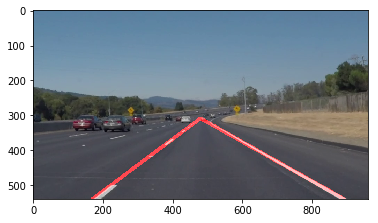

In [16]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

x3 = 131
y3 =540
x4 =481
y4 =310
x1_list[295 105 289 162 162 351 126 105 433 449 250 287 422 167 145 338 369 263
 124 413 434 250]
y1_list[422 539 433 514 504 388 538 538 339 332 451 427 346 511 525 396 384 443
 538 357 338 458]
x2_list[382 234 448 345 277 419 169 176 455 464 282 319 437 207 185 407 406 283
 148 450 452 382]
y2_list[371 459 333 399 433 348 511 494 322 317 430 409 335 487 501 356 360 430
 524 330 324 375]
num_points_left22
num_points_right13
a_avg = -0.656352638991
b_avg = 626.079612397
slope_left = [-0.5862069  -0.62015504 -0.62893082 -0.6284153  -0.6173913  -0.58823529
 -0.62790698 -0.61971831 -0.77272727 -1.         -0.65625    -0.5625
 -0.73333333 -0.6        -0.6        -0.57971014 -0.64864865 -0.65
 -0.58333333 -0.72972973 -0.77777778 -0.62878788]
slope_right [ 0.67307692  0.66666667  0.72307692  0.72222222  0.71153846  0.7254902
  0.675       0.70588235  0.625       0.72413793  0.67567568  0.73684211
  0.75      ]
[MoviePy] >>>> Building video yellow.mp4
[MoviePy

  0%|                                                                                                                                                                                                              | 0/682 [00:00<?, ?it/s]

x3 = 131
y3 =540
x4 =481
y4 =310
x1_list[295 105 289 162 162 351 126 105 433 449 250 287 422 167 145 338 369 263
 124 413 434 250]
y1_list[422 539 433 514 504 388 538 538 339 332 451 427 346 511 525 396 384 443
 538 357 338 458]
x2_list[382 234 448 345 277 419 169 176 455 464 282 319 437 207 185 407 406 283
 148 450 452 382]
y2_list[371 459 333 399 433 348 511 494 322 317 430 409 335 487 501 356 360 430
 524 330 324 375]
num_points_left22
num_points_right13
a_avg = -0.656352638991
b_avg = 626.079612397
slope_left = [-0.5862069  -0.62015504 -0.62893082 -0.6284153  -0.6173913  -0.58823529
 -0.62790698 -0.61971831 -0.77272727 -1.         -0.65625    -0.5625
 -0.73333333 -0.6        -0.6        -0.57971014 -0.64864865 -0.65
 -0.58333333 -0.72972973 -0.77777778 -0.62878788]
slope_right [ 0.67307692  0.66666667  0.72307692  0.72222222  0.71153846  0.7254902
  0.675       0.70588235  0.625       0.72413793  0.67567568  0.73684211
  0.75      ]


  0%|▎                                                                                                                                                                                                     | 1/682 [00:00<02:10,  5.22it/s]

x3 = 132
y3 =540
x4 =477
y4 =310
x1_list[165 262 317 127 266 218 125 385 434 106 127 446 105 136 434]
y1_list[513 451 411 526 442 471 538 370 342 539 538 335 538 520 339]
x2_list[332 442 444 247 376 344 252 417 452 138 189 463 131 189 456]
y2_list[408 338 332 452 374 393 459 350 330 518 499 318 522 487 321]
num_points_left15
num_points_right20
a_avg = -0.665844516838
b_avg = 628.244270333
slope_left = [-0.62874251 -0.62777778 -0.62204724 -0.61666667 -0.61818182 -0.61904762
 -0.62204724 -0.625      -0.66666667 -0.65625    -0.62903226 -1.
 -0.61538462 -0.62264151 -0.81818182]
slope_right [ 0.63513514  0.68333333  0.67857143  0.57894737  0.62222222  0.77777778
  0.57894737  0.78947368  0.67857143  0.62068966  0.64516129  0.61764706
  0.68181818  0.625       0.7037037   0.625       0.66666667  0.75862069
  0.65384615  0.66666667]


  0%|▌                                                                                                                                                                                                     | 2/682 [00:00<02:02,  5.55it/s]

x3 = 133
y3 =540
x4 =483
y4 =310
x1_list[196 339 128 107 145 324 252 193 447 160 436 185 107 224 392 407 421]
y1_list[494 398 538 539 516 412 451 496 334 517 337 501 538 468 366 361 346]
x2_list[406 440 192 215 268 446 383 223 464 195 455 201 154 249 415 448 444]
y2_list[362 335 498 472 440 335 370 478 317 496 322 492 509 452 350 332 332]
num_points_left17
num_points_right15
a_avg = -0.657983433281
b_avg = 628.013296571
slope_left = [-0.62857143 -0.62376238 -0.625      -0.62037037 -0.61788618 -0.63114754
 -0.61832061 -0.6        -1.         -0.6        -0.78947368 -0.5625
 -0.61702128 -0.64       -0.69565217 -0.70731707 -0.60869565]
slope_right [ 0.67741935  0.68292683  0.65853659  0.63235294  0.6         0.73333333
  0.72340426  0.64285714  0.63157895  0.63157895  0.66666667  0.72916667
  0.8         0.67741935  0.63157895]


  0%|▊                                                                                                                                                                                                     | 3/682 [00:00<01:53,  6.00it/s]

x3 = 129
y3 =540
x4 =484
y4 =310
x1_list[186 323 437 177 255 111 303 111 132 140 417 410 449 425 250 131]
y1_list[493 409 336 508 458 538 427 539 538 532 354 354 333 344 454 538]
x2_list[370 432 462 299 402 195 425 246 175 259 448 436 464 442 419 209]
y2_list[379 341 320 431 366 486 350 455 511 457 334 338 318 334 349 489]
num_points_left16
num_points_right16
a_avg = -0.648080054534
b_avg = 623.801662961
slope_left = [-0.61956522 -0.62385321 -0.64       -0.63114754 -0.62585034 -0.61904762
 -0.63114754 -0.62222222 -0.62790698 -0.6302521  -0.64516129 -0.61538462
 -1.         -0.58823529 -0.62130178 -0.62820513]
slope_right [ 0.62318841  0.71186441  0.63235294  0.63636364  0.7         0.72222222
  0.64705882  0.71428571  0.70588235  0.66666667  0.65        0.65        0.65
  0.65        0.66666667  0.75      ]


  1%|█▏                                                                                                                                                                                                    | 4/682 [00:00<01:47,  6.33it/s]

x3 = 124
y3 =540
x4 =485
y4 =310
x1_list[140 115 283 133 220 328 348 135 192 442 413 444 114 220 436]
y1_list[523 538 441 538 482 407 399 538 500 333 357 331 538 474 343]
x2_list[457 324 399 224 294 405 435 173 264 458 447 460 131 297 451]
y2_list[325 408 368 481 435 359 344 514 455 324 335 322 527 426 330]
num_points_left15
num_points_right13
a_avg = -0.637248984656
b_avg = 619.081557282
slope_left = [-0.62460568 -0.62200957 -0.62931034 -0.62637363 -0.63513514 -0.62337662
 -0.63218391 -0.63157895 -0.625      -0.5625     -0.64705882 -0.5625
 -0.64705882 -0.62337662 -0.86666667]
slope_right [ 0.62222222  0.77272727  0.72        0.68        0.72727273  0.68421053
  0.69565217  0.63636364  0.7         0.8         0.625       0.59090909
  0.65      ]


  1%|█▍                                                                                                                                                                                                    | 5/682 [00:00<01:42,  6.60it/s]

x3 = 126
y3 =540
x4 =488
y4 =310
x1_list[118 248 204 346 118 137 401 368 163 441 183 209 431 306]
y1_list[538 467 496 403 539 538 361 389 521 334 508 481 341 429]
x2_list[430 359 316 451 406 190 440 445 193 461 206 305 456 378]
y2_list[343 393 421 332 359 505 336 337 503 321 494 421 327 381]
num_points_left14
num_points_right8
a_avg = -0.63656101033
b_avg = 620.792952476
slope_left = [-0.625      -0.66666667 -0.66964286 -0.67619048 -0.625      -0.62264151
 -0.64102564 -0.67532468 -0.6        -0.65       -0.60869565 -0.625      -0.56
 -0.66666667]
slope_right [ 0.76        0.66666667  0.70833333  0.62962963  0.70833333  0.61904762
  0.66666667  0.625     ]


  1%|█▋                                                                                                                                                                                                    | 6/682 [00:00<01:45,  6.40it/s]

x3 = 165
y3 =540
x4 =478
y4 =310
x1_list[140 120 119 324 256 364 441 416 164 407 448 295 439]
y1_list[539 539 538 418 462 392 340 351 523 357 334 437 337]
x2_list[278 399 429 447 340 434 460 442 291 430 463 371 454]
y2_list[446 364 344 335 406 345 321 334 438 343 318 386 323]
num_points_left13
num_points_right10
a_avg = -0.734056723131
b_avg = 661.603989255
slope_left = [-0.67391304 -0.62724014 -0.62580645 -0.67479675 -0.66666667 -0.67142857
 -1.         -0.65384615 -0.66929134 -0.60869565 -1.06666667 -0.67105263
 -0.93333333]
slope_right [ 0.66666667  0.79166667  0.62222222  0.65517241  0.66666667  0.6875
  0.67857143  0.78571429  0.625       0.68421053]


  1%|██                                                                                                                                                                                                    | 7/682 [00:01<01:48,  6.21it/s]

x3 = 139
y3 =540
x4 =486
y4 =310
x1_list[120 365 231 186 319 122 412 139 174 231 426 409 440 335 140 120 311]
y1_list[538 384 477 507 421 536 353 538 515 478 345 355 339 409 538 539 425]
x2_list[398 423 307 236 445 399 456 188 223 315 454 425 464 398 169 163 345]
y2_list[364 347 429 475 336 363 325 507 484 422 322 345 317 369 520 512 403]
num_points_left17
num_points_right9
a_avg = -0.664504054555
b_avg = 632.973474324
slope_left = [-0.62589928 -0.63793103 -0.63157895 -0.64       -0.67460317 -0.62454874
 -0.63636364 -0.63265306 -0.63265306 -0.66666667 -0.82142857 -0.625
 -0.91666667 -0.63492063 -0.62068966 -0.62790698 -0.64705882]
slope_right [ 0.63157895  0.65714286  0.6744186   0.68292683  0.68571429  0.65217391
  0.59090909  0.67647059  0.66666667]


  1%|██▎                                                                                                                                                                                                   | 8/682 [00:01<01:50,  6.12it/s]

x3 = 144
y3 =540
x4 =479
y4 =310
x1_list[242 121 141 121 322 178 391 422 410 436 432]
y1_list[472 538 538 537 419 514 367 346 354 342 340]
x2_list[445 367 238 400 435 311 427 440 431 453 454]
y2_list[335 384 473 362 343 425 344 334 341 327 322]
num_points_left11
num_points_right10
a_avg = -0.687737598325
b_avg = 639.566977463
slope_left = [-0.67487685 -0.62601626 -0.67010309 -0.62724014 -0.67256637 -0.66917293
 -0.63888889 -0.66666667 -0.61904762 -0.88235294 -0.81818182]
slope_right [ 0.61363636  0.725       0.675       0.61363636  0.61904762  0.65957447
  0.68        0.6875      0.66666667  0.69230769]


  1%|██▌                                                                                                                                                                                                   | 9/682 [00:01<01:53,  5.92it/s]

x3 = 151
y3 =540
x4 =480
y4 =310
x1_list[235 120 182 141 121 246 377 399 445 438 123 321 146]
y1_list[477 538 512 538 539 459 376 361 335 340 537 420 535]
x2_list[440 384 319 187 250 397 421 435 462 460 315 391 174]
y2_list[339 373 420 507 458 364 348 338 318 319 417 373 517]
num_points_left13
num_points_right10
a_avg = -0.697672797352
b_avg = 645.566013557
slope_left = [-0.67317073 -0.625      -0.67153285 -0.67391304 -0.62790698 -0.62913907
 -0.63636364 -0.63888889 -1.         -0.95454545 -0.625      -0.67142857
 -0.64285714]
slope_right [ 0.7173913   0.62264151  0.62962963  0.55263158  0.63636364  0.70967742
  0.72        0.61111111  0.62222222  0.66666667]


  1%|██▉                                                                                                                                                                                                  | 10/682 [00:01<01:55,  5.84it/s]

x3 = 147
y3 =540
x4 =478
y4 =310
x1_list[144 320 123 143 263 340 282 442 258 218]
y1_list[539 414 538 538 459 402 438 337 453 478]
x2_list[441 442 311 285 429 435 326 460 290 252]
y2_list[338 332 420 443 347 338 409 319 432 456]
num_points_left10
num_points_right12
a_avg = -0.695635522161
b_avg = 642.614102902
slope_left = [-0.67676768 -0.67213115 -0.62765957 -0.66901408 -0.6746988  -0.67368421
 -0.65909091 -1.         -0.65625    -0.64705882]
slope_right [ 0.66666667  0.71698113  0.63043478  0.69230769  0.6         0.71428571
  0.57692308  0.67391304  0.57894737  0.72413793  0.67567568  0.67567568]


  2%|███▏                                                                                                                                                                                                 | 11/682 [00:01<01:54,  5.84it/s]

x3 = 166
y3 =540
x4 =471
y4 =310
x1_list[316 144 253 161 144 443 124 198 242 273 291 124 438 346 432 269 231]
y1_list[417 539 457 515 538 336 539 492 464 453 433 538 340 398 344 447 471]
x2_list[438 434 306 205 269 460 178 246 265 378 348 147 448 429 455 317 254]
y2_list[335 343 422 486 454 319 503 460 448 382 395 523 325 342 323 415 455]
num_points_left17
num_points_right9
a_avg = -0.753737597721
b_avg = 665.356958696
slope_left = [-0.67213115 -0.67586207 -0.66037736 -0.65909091 -0.672      -1.
 -0.66666667 -0.66666667 -0.69565217 -0.67619048 -0.66666667 -0.65217391
 -1.5        -0.6746988  -0.91304348 -0.66666667 -0.69565217]
slope_right [ 0.66666667  0.61403509  0.62025316  0.66666667  0.58333333  0.61290323
  0.6         0.57692308  0.66666667]


  2%|███▍                                                                                                                                                                                                 | 12/682 [00:01<01:54,  5.85it/s]

x3 = 153
y3 =540
x4 =477
y4 =310
x1_list[153 331 146 324 195 421 125 294 442 426 348 310 237]
y1_list[520 413 538 412 506 351 538 431 336 343 397 421 468]
x2_list[331 435 398 434 367 441 250 338 456 449 382 423 299]
y2_list[408 342 368 338 390 337 460 402 321 324 374 345 427]
num_points_left13
num_points_right12
a_avg = -0.709583735566
b_avg = 648.984499249
slope_left = [-0.62921348 -0.68269231 -0.67460317 -0.67272727 -0.6744186  -0.7        -0.624
 -0.65909091 -1.07142857 -0.82608696 -0.67647059 -0.67256637 -0.66129032]
slope_right [ 0.62        0.67368421  0.67307692  0.67647059  0.625       0.5625
  0.66666667  0.72972973  0.77777778  0.7826087   0.8         0.74193548]


  2%|███▊                                                                                                                                                                                                 | 13/682 [00:02<01:55,  5.82it/s]

x3 = 154
y3 =540
x4 =480
y4 =310
x1_list[148 127 191 371 330 316 180 414 433 393 365 314]
y1_list[538 538 497 387 409 418 517 358 344 372 390 425]
x2_list[370 259 326 448 428 433 327 429 459 425 438 375]
y2_list[388 455 412 331 343 339 418 346 320 350 340 384]
num_points_left12
num_points_right14
a_avg = -0.70426316163
b_avg = 648.491616569
slope_left = [-0.67567568 -0.62878788 -0.62962963 -0.72727273 -0.67346939 -0.67521368
 -0.67346939 -0.8        -0.92307692 -0.6875     -0.68493151 -0.67213115]
slope_right [ 0.70588235  0.67213115  0.61111111  0.61832061  0.64705882  0.71428571
  0.65        0.62015504  0.66666667  0.66666667  0.625       0.72
  0.66666667  0.6875    ]


  2%|████                                                                                                                                                                                                 | 14/682 [00:02<01:50,  6.03it/s]

x3 = 150
y3 =540
x4 =478
y4 =310
x1_list[254 347 150 149 291 142 436 368 130 226 192 435 342 429 150]
y1_list[459 403 538 538 435 531 335 388 538 477 499 342 407 346 539]
x2_list[435 426 295 349 429 216 458 434 165 292 258 452 360 456 166]
y2_list[337 349 440 403 342 482 320 343 515 433 455 327 395 322 528]
num_points_left15
num_points_right13
a_avg = -0.701602385228
b_avg = 645.602883024
slope_left = [-0.67403315 -0.6835443  -0.67586207 -0.675      -0.67391304 -0.66216216
 -0.68181818 -0.68181818 -0.65714286 -0.66666667 -0.66666667 -0.88235294
 -0.66666667 -0.88888889 -0.6875    ]
slope_right [ 0.62411348  0.66666667  0.625       0.63235294  0.76470588  0.6875
  0.67272727  0.57142857  0.63157895  0.66666667  0.73684211  0.63157895
  0.671875  ]


  2%|████▎                                                                                                                                                                                                | 15/682 [00:02<01:46,  6.24it/s]

x3 = 146
y3 =540
x4 =477
y4 =310
x1_list[152 228 151 271 437 431 354 335 132 132 204 430 195 275]
y1_list[538 477 538 449 334 339 398 412 538 539 492 346 498 453]
x2_list[259 434 334 425 458 457 426 408 174 202 269 454 218 362]
y2_list[466 338 414 345 320 321 349 362 510 492 449 324 482 394]
num_points_left14
num_points_right13
a_avg = -0.693939261621
b_avg = 641.459795867
slope_left = [-0.6728972  -0.67475728 -0.67759563 -0.67532468 -0.66666667 -0.69230769
 -0.68055556 -0.68493151 -0.66666667 -0.67142857 -0.66153846 -0.91666667
 -0.69565217 -0.67816092]
slope_right [ 0.62831858  0.63235294  0.61842105  0.66        0.60869565  0.625       0.6
  0.59090909  0.6         0.61904762  0.63106796  0.6         0.58823529]


  2%|████▌                                                                                                                                                                                                | 16/682 [00:02<01:52,  5.94it/s]

x3 = 144
y3 =540
x4 =478
y4 =310
x1_list[184 151 251 344 133 435 319 153 179 384 242 423 134 168 218]
y1_list[506 538 462 405 538 342 423 538 509 377 476 345 537 516 484]
x2_list[287 317 426 426 180 458 402 240 205 431 349 446 155 188 427]
y2_list[437 426 344 349 507 320 367 479 491 345 403 332 523 502 343]
num_points_left15
num_points_right14
a_avg = -0.688846475092
b_avg = 639.445122936
slope_left = [-0.66990291 -0.6746988  -0.67428571 -0.68292683 -0.65957447 -0.95652174
 -0.6746988  -0.67816092 -0.69230769 -0.68085106 -0.68224299 -0.56521739
 -0.66666667 -0.7        -0.67464115]
slope_right [ 0.625       0.63636364  0.671875    0.65217391  0.64        0.67567568
  0.65217391  0.58333333  0.61904762  0.66666667  0.6         0.6
  0.66666667  0.6875    ]


  2%|████▉                                                                                                                                                                                                | 17/682 [00:02<01:50,  6.02it/s]

x3 = 153
y3 =540
x4 =478
y4 =310
x1_list[177 135 339 155 203 304 400 154 430 248 172 430 137 197 290 300]
y1_list[512 538 409 538 504 434 366 527 341 465 515 346 538 498 444 437]
x2_list[426 173 421 271 312 371 436 191 449 417 199 452 155 216 310 323]
y2_list[344 513 353 459 430 388 341 501 324 351 496 325 526 485 431 422]
num_points_left16
num_points_right9
a_avg = -0.708735097334
b_avg = 648.976893012
slope_left = [-0.6746988  -0.65789474 -0.68292683 -0.68103448 -0.67889908 -0.68656716
 -0.69444444 -0.7027027  -0.89473684 -0.67455621 -0.7037037  -0.95454545
 -0.66666667 -0.68421053 -0.65       -0.65217391]
slope_right [ 0.6         0.68        0.69230769  0.62962963  0.63636364  0.68181818
  0.625       0.68421053  0.63157895]


  3%|█████▏                                                                                                                                                                                               | 18/682 [00:02<01:47,  6.19it/s]

x3 = 165
y3 =540
x4 =477
y4 =310
x1_list[160 256 136 213 155 366 410 422 393 192 386 205 379 158 311]
y1_list[523 469 538 499 538 391 360 346 374 512 377 503 382 537 430]
x2_list[424 381 235 334 210 395 454 445 411 217 401 222 433 191 380]
y2_list[345 379 472 412 501 369 323 326 358 496 365 492 343 513 380]
num_points_left15
num_points_right9
a_avg = -0.738121331275
b_avg = 662.421692514
slope_left = [-0.67424242 -0.72       -0.66666667 -0.71900826 -0.67272727 -0.75862069
 -0.84090909 -0.86956522 -0.88888889 -0.64       -0.8        -0.64705882
 -0.72222222 -0.72727273 -0.72463768]
slope_right [ 0.6097561   0.63636364  0.66666667  0.66666667  0.63636364  0.59090909
  0.57575758  0.7         0.75      ]


  3%|█████▍                                                                                                                                                                                               | 19/682 [00:03<01:50,  5.97it/s]

x3 = 161
y3 =540
x4 =479
y4 =310
x1_list[193 136 268 178 154 423 341 377 166 139 162 428]
y1_list[513 539 460 511 538 350 408 383 530 536 533 341]
x2_list[333 424 393 414 180 454 436 421 194 156 216 445]
y2_list[412 344 370 352 522 322 339 351 512 524 496 326]
num_points_left12
num_points_right9
a_avg = -0.723393106589
b_avg = 656.53091811
slope_left = [-0.72142857 -0.67708333 -0.72       -0.67372881 -0.61538462 -0.90322581
 -0.72631579 -0.72727273 -0.64285714 -0.70588235 -0.68518519 -0.88235294]
slope_right [ 0.71875     0.57894737  0.57142857  0.7         0.64705882  0.72222222
  0.73333333  0.56521739  0.64705882]


  3%|█████▊                                                                                                                                                                                               | 20/682 [00:03<01:54,  5.79it/s]

x3 = 147
y3 =540
x4 =476
y4 =310
x1_list[135 135 183 318 377 155 324 417 155 262 367]
y1_list[539 538 519 423 382 537 412 347 538 463 389]
x2_list[416 337 330 438 425 181 407 448 240 362 387]
y2_list[349 402 413 336 347 520 356 327 477 391 374]
num_points_left11
num_points_right7
a_avg = -0.698730210052
b_avg = 642.789396416
slope_left = [-0.67615658 -0.67326733 -0.72108844 -0.725      -0.72916667 -0.65384615
 -0.6746988  -0.64516129 -0.71764706 -0.72       -0.75      ]
slope_right [ 0.68888889  0.73529412  0.62790698  0.60714286  0.57777778  0.65789474
  0.66666667]


  3%|██████                                                                                                                                                                                               | 21/682 [00:03<01:53,  5.84it/s]

x3 = 149
y3 =540
x4 =478
y4 =310
x1_list[133 134 427 311 154 423 290 375 424 400 161 265 211 156 276 360]
y1_list[538 539 343 426 539 343 441 381 341 365 532 459 497 536 451 392]
x2_list[303 419 444 396 287 439 371 423 447 437 233 283 268 174 302 401]
y2_list[424 346 330 368 443 329 386 348 327 336 483 447 458 524 434 364]
num_points_left16
num_points_right9
a_avg = -0.699094295782
b_avg = 644.38765285
slope_left = [-0.67058824 -0.67719298 -0.76470588 -0.68235294 -0.72180451 -0.875
 -0.67901235 -0.6875     -0.60869565 -0.78378378 -0.68055556 -0.66666667
 -0.68421053 -0.66666667 -0.65384615 -0.68292683]
slope_right [ 0.62264151  0.66666667  0.62        0.68421053  0.66666667  0.66666667
  0.66666667  0.60869565  0.70588235]


  3%|██████▎                                                                                                                                                                                              | 22/682 [00:03<01:54,  5.75it/s]

x3 = 150
y3 =540
x4 =477
y4 =310
x1_list[227 257 385 133 185 152 287 213 153 422 380 133 402 308]
y1_list[476 464 376 538 515 538 443 495 538 344 378 539 359 421]
x2_list[418 364 444 277 255 218 382 285 187 441 419 324 437 331]
y2_list[347 392 330 441 467 493 378 446 515 328 351 410 330 407]
num_points_left14
num_points_right8
a_avg = -0.704100274178
b_avg = 646.01180644
slope_left = [-0.67539267 -0.6728972  -0.77966102 -0.67361111 -0.68571429 -0.68181818
 -0.68421053 -0.68055556 -0.67647059 -0.84210526 -0.69230769 -0.67539267
 -0.82857143 -0.60869565]
slope_right [ 0.62295082  0.65957447  0.67857143  0.66666667  0.61904762  0.76470588
  0.66666667  0.52941176]


  3%|██████▋                                                                                                                                                                                              | 23/682 [00:03<01:53,  5.82it/s]

x3 = 140
y3 =540
x4 =481
y4 =310
x1_list[421 161 244 132 329 156 354 233 213 337 412 152 382 411 249 259]
y1_list[348 520 473 538 414 535 396 481 495 403 350 538 372 356 470 455]
x2_list[442 419 353 223 405 235 414 259 239 367 445 175 398 428 280 406]
y2_list[332 346 399 477 362 481 355 464 478 382 329 523 362 344 450 356]
num_points_left16
num_points_right9
a_avg = -0.673898948189
b_avg = 634.617836541
slope_left = [-0.76190476 -0.6744186  -0.67889908 -0.67032967 -0.68421053 -0.6835443
 -0.68333333 -0.65384615 -0.65384615 -0.7        -0.63636364 -0.65217391
 -0.625      -0.70588235 -0.64516129 -0.67346939]
slope_right [ 0.61403509  0.53333333  0.58490566  0.61643836  0.5483871   0.63157895
  0.58139535  0.61818182  0.56      ]


  4%|██████▉                                                                                                                                                                                              | 24/682 [00:03<01:53,  5.77it/s]

x3 = 158
y3 =540
x4 =476
y4 =310
x1_list[134 199 154 259 134 309 270 188 427 406 155 250 394]
y1_list[539 496 538 466 538 431 449 514 345 357 538 471 371]
x2_list[319 415 236 362 224 429 402 263 453 441 196 268 451]
y2_list[415 350 482 392 478 344 360 463 322 328 510 459 323]
num_points_left13
num_points_right10
a_avg = -0.722951099277
b_avg = 654.635248699
slope_left = [-0.67027027 -0.67592593 -0.68292683 -0.7184466  -0.66666667 -0.725
 -0.67424242 -0.68       -0.88461538 -0.82857143 -0.68292683 -0.66666667
 -0.84210526]
slope_right [ 0.67213115  0.6         0.6125      0.67213115  0.61538462  0.58823529
  0.65517241  0.7         0.57894737  0.66666667]


  4%|███████▏                                                                                                                                                                                             | 25/682 [00:04<01:52,  5.82it/s]

x3 = 154
y3 =540
x4 =485
y4 =310
x1_list[137 158 211 313 276 240 137 255 437 157 408 221 285]
y1_list[539 537 490 430 456 480 538 469 338 538 355 493 448]
x2_list[414 240 398 419 429 263 176 278 453 203 435 244 302]
y2_list[352 481 364 353 345 465 512 454 322 507 338 478 437]
num_points_left13
num_points_right14
a_avg = -0.696731466636
b_avg = 647.96607706
slope_left = [-0.67509025 -0.68292683 -0.67379679 -0.72641509 -0.7254902  -0.65217391
 -0.66666667 -0.65217391 -1.         -0.67391304 -0.62962963 -0.65217391
 -0.64705882]
slope_right [ 0.62184874  0.67241379  0.66666667  0.61702128  0.73333333  0.57894737
  0.66666667  0.58823529  0.6         0.70588235  0.73333333  0.6875
  0.65384615  0.72727273]


  4%|███████▌                                                                                                                                                                                             | 26/682 [00:04<01:46,  6.15it/s]

x3 = 163
y3 =540
x4 =472
y4 =310
x1_list[139 187 362 391 342 159 213 138 412 317 265 416]
y1_list[538 519 395 367 409 539 489 538 352 428 464 354]
x2_list[401 337 440 418 375 257 382 217 441 354 418 444]
y2_list[361 411 334 348 384 468 375 485 328 399 353 329]
num_points_left12
num_points_right15
a_avg = -0.744879389743
b_avg = 661.870940082
slope_left = [-0.67557252 -0.72       -0.78205128 -0.7037037  -0.75757576 -0.7244898
 -0.67455621 -0.67088608 -0.82758621 -0.78378378 -0.7254902  -0.89285714]
slope_right [ 0.58823529  0.61904762  0.62601626  0.62765957  0.61728395  0.58333333
  0.61363636  0.57142857  0.63157895  0.609375    0.55555556  0.65
  0.62686567  0.63157895  0.63157895]


  4%|███████▊                                                                                                                                                                                             | 27/682 [00:04<01:46,  6.13it/s]

x3 = 152
y3 =540
x4 =474
y4 =310
x1_list[139 199 138 139 274 159 402 331 397 415 168]
y1_list[538 511 538 539 458 539 358 408 362 354 533]
x2_list[391 422 183 376 402 242 422 400 412 433 298]
y2_list[368 349 508 379 365 479 344 361 352 338 439]
num_points_left11
num_points_right13
a_avg = -0.713825335527
b_avg = 648.917150629
slope_left = [-0.67460317 -0.7264574  -0.66666667 -0.67510549 -0.7265625  -0.72289157
 -0.7        -0.68115942 -0.66666667 -0.88888889 -0.72307692]
slope_right [ 0.578125    0.58695652  0.62903226  0.56521739  0.66666667  0.625
  0.58208955  0.64705882  0.64705882  0.56521739  0.63636364  0.6         0.6       ]


  4%|████████                                                                                                                                                                                             | 28/682 [00:04<01:51,  5.87it/s]

x3 = 153
y3 =540
x4 =473
y4 =310
x1_list[183 175 161 153 285 160 396 419 140 393 157 353]
y1_list[523 514 538 530 450 538 362 351 539 370 527 393]
x2_list[406 386 337 214 391 202 419 449 165 410 351 375]
y2_list[361 371 411 489 373 508 346 324 521 358 396 378]
num_points_left12
num_points_right10
a_avg = -0.718101318623
b_avg = 650.363093796
slope_left = [-0.7264574  -0.67772512 -0.72159091 -0.67213115 -0.72641509 -0.71428571
 -0.69565217 -0.9        -0.72       -0.70588235 -0.67525773 -0.68181818]
slope_right [ 0.61797753  0.61702128  0.6         0.66666667  0.60784314  0.59090909
  0.60714286  0.66666667  0.66666667  0.6       ]


  4%|████████▍                                                                                                                                                                                            | 29/682 [00:04<01:50,  5.89it/s]

x3 = 168
y3 =540
x4 =469
y4 =310
x1_list[162 141 389 281 256 381 416 434 402 368]
y1_list[538 538 367 453 459 373 353 338 359 384]
x2_list[415 364 412 380 387 396 447 449 421 437]
y2_list[354 387 351 381 370 363 325 324 343 330]
num_points_left10
num_points_right10
a_avg = -0.763465675154
b_avg = 668.552443222
slope_left = [-0.72727273 -0.67713004 -0.69565217 -0.72727273 -0.67938931 -0.66666667
 -0.90322581 -0.93333333 -0.84210526 -0.7826087 ]
slope_right [ 0.60714286  0.63414634  0.57446809  0.60714286  0.625       0.65217391
  0.62068966  0.6         0.57692308  0.625     ]


  4%|████████▋                                                                                                                                                                                            | 30/682 [00:05<02:00,  5.40it/s]

x3 = 165
y3 =540
x4 =473
y4 =310
x1_list[141 142 162 387 333 393 424 381 382 161 344 168 406 338]
y1_list[538 537 539 374 407 364 346 379 372 538 408 533 361 412]
x2_list[344 372 393 423 384 416 442 415 400 182 365 204 432 354]
y2_list[401 381 371 347 372 348 329 354 360 524 391 508 338 399]
num_points_left14
num_points_right4
a_avg = -0.744749475847
b_avg = 662.926627389
slope_left = [-0.67487685 -0.67826087 -0.72727273 -0.75       -0.68627451 -0.69565217
 -0.94444444 -0.73529412 -0.66666667 -0.66666667 -0.80952381 -0.69444444
 -0.88461538 -0.8125    ]
slope_right [ 0.5625      0.64285714  0.5625      0.68      ]


  5%|████████▉                                                                                                                                                                                            | 31/682 [00:05<01:58,  5.48it/s]

x3 = 159
y3 =540
x4 =472
y4 =310
x1_list[163 142 344 416 215 337 390 370 381 275 393 143 370]
y1_list[539 538 400 353 502 405 373 389 373 449 364 538 381]
x2_list[389 346 380 432 354 360 449 386 411 331 409 276 387]
y2_list[374 400 375 338 401 390 324 375 352 409 353 448 370]
num_points_left13
num_points_right4
a_avg = -0.734487760619
b_avg = 657.007755845
slope_left = [-0.7300885  -0.67647059 -0.69444444 -0.9375     -0.72661871 -0.65217391
 -0.83050847 -0.875      -0.7        -0.71428571 -0.6875     -0.67669173
 -0.64705882]
slope_right [ 0.60606061  0.73333333  0.62857143  0.68      ]


  5%|█████████▏                                                                                                                                                                                           | 32/682 [00:05<01:51,  5.82it/s]

x3 = 154
y3 =540
x4 =467
y4 =310
x1_list[164 275 163 391 175 216 412 143 241 307 162 363 218 197]
y1_list[539 449 538 372 517 489 349 539 472 427 526 392 500 502]
x2_list[361 425 382 447 223 264 433 176 293 414 182 409 295 242]
y2_list[395 340 379 325 483 455 333 515 435 349 511 358 444 470]
num_points_left14
num_points_right8
a_avg = -0.735486649885
b_avg = 653.98511673
slope_left = [-0.73096447 -0.72666667 -0.7260274  -0.83928571 -0.70833333 -0.70833333
 -0.76190476 -0.72727273 -0.71153846 -0.72897196 -0.75       -0.73913043
 -0.72727273 -0.71111111]
slope_right [ 0.61904762  0.68421053  0.58333333  0.56666667  0.61904762  0.63157895
  0.66666667  0.66666667]


  5%|█████████▌                                                                                                                                                                                           | 33/682 [00:05<01:49,  5.94it/s]

x3 = 158
y3 =540
x4 =471
y4 =310
x1_list[267 164 165 145 374 409 382 144 391 304 364 269]
y1_list[455 538 539 538 385 351 377 538 372 429 391 453]
x2_list[421 370 343 232 420 434 406 268 447 406 386 288]
y2_list[343 388 409 479 347 332 360 454 325 355 376 439]
num_points_left12
num_points_right5
a_avg = -0.734933492284
b_avg = 656.789047148
slope_left = [-0.72727273 -0.72815534 -0.73033708 -0.67816092 -0.82608696 -0.76
 -0.70833333 -0.67741935 -0.83928571 -0.7254902  -0.68181818 -0.73684211]
slope_right [ 0.56        0.62222222  0.58064516  0.57692308  0.7037037 ]


  5%|█████████▊                                                                                                                                                                                           | 34/682 [00:05<01:56,  5.58it/s]

x3 = 162
y3 =540
x4 =473
y4 =310
x1_list[166 145 296 360 283 378 265 401 166 146 165 237 368]
y1_list[538 538 435 394 452 382 456 364 539 538 538 475 389]
x2_list[324 276 406 387 370 447 418 446 243 221 341 278 385]
y2_list[423 449 355 375 388 325 345 326 483 487 410 446 375]
num_points_left13
num_points_right9
a_avg = -0.741173812743
b_avg = 660.612495399
slope_left = [-0.7278481  -0.67938931 -0.72727273 -0.7037037  -0.73563218 -0.82608696
 -0.7254902  -0.84444444 -0.72727273 -0.68       -0.72727273 -0.70731707
 -0.82352941]
slope_right [ 0.61111111  0.57627119  0.70588235  0.58974359  0.62222222  0.54054054
  0.625       0.57692308  0.65217391]


  5%|██████████                                                                                                                                                                                           | 35/682 [00:05<01:49,  5.88it/s]

x3 = 157
y3 =540
x4 =467
y4 =310
x1_list[166 256 197 331 166 394 146 178 146 318 401 249 428 393 339 264]
y1_list[538 463 504 416 539 369 539 517 538 426 363 468 336 363 411 457]
x2_list[329 405 264 389 295 444 209 238 167 338 425 270 443 410 363 288]
y2_list[419 355 456 373 445 327 494 474 523 412 342 452 327 351 391 439]
num_points_left16
num_points_right10
a_avg = -0.740795718701
b_avg = 656.639906067
slope_left = [-0.73006135 -0.72483221 -0.71641791 -0.74137931 -0.72868217 -0.84
 -0.71428571 -0.71666667 -0.71428571 -0.7        -0.875      -0.76190476
 -0.6        -0.70588235 -0.83333333 -0.75      ]
slope_right [ 0.57746479  0.65789474  0.58695652  0.66666667  0.65853659  0.56097561
  0.53333333  0.59259259  0.57692308  0.6       ]


  5%|██████████▍                                                                                                                                                                                          | 36/682 [00:06<01:52,  5.72it/s]

x3 = 153
y3 =540
x4 =473
y4 =310
x1_list[387 240 289 245 168 227 147 420 180 326 217 167 210 291 426 147 166]
y1_list[367 474 449 482 524 495 538 346 528 421 490 538 506 438 336 539 538]
x2_list[423 408 436 338 238 283 179 437 216 418 361 183 228 397 444 205 201]
y2_list[340 352 334 410 474 452 515 333 503 349 386 527 494 361 327 497 514]
num_points_left17
num_points_right10
a_avg = -0.716941472313
b_avg = 649.809803399
slope_left = [-0.75       -0.72619048 -0.78231293 -0.77419355 -0.71428571 -0.76785714
 -0.71875    -0.76470588 -0.69444444 -0.7826087  -0.72222222 -0.6875
 -0.66666667 -0.72641509 -0.5        -0.72413793 -0.68571429]
slope_right [ 0.62711864  0.5625      0.57446809  0.61428571  0.60869565  0.62195122
  0.6         0.59259259  0.61728395  0.61363636]


  5%|██████████▋                                                                                                                                                                                          | 37/682 [00:06<01:55,  5.59it/s]

x3 = 162
y3 =540
x4 =468
y4 =310
x1_list[206 148 229 337 188 413 254 423 412 148 222 412 167 401 325 179 396]
y1_list[498 539 494 412 524 346 464 343 352 538 499 348 538 356 421 529 365]
x2_list[415 239 341 420 249 431 400 440 433 195 289 427 185 416 351 218 421]
y2_list[346 473 407 347 477 333 358 330 336 504 447 336 526 344 400 502 346]
num_points_left17
num_points_right11
a_avg = -0.75200047582
b_avg = 662.256101513
slope_left = [-0.72727273 -0.72527473 -0.77678571 -0.78313253 -0.7704918  -0.72222222
 -0.7260274  -0.76470588 -0.76190476 -0.72340426 -0.7761194  -0.8
 -0.66666667 -0.8        -0.80769231 -0.69230769 -0.76      ]
slope_right [ 0.62135922  0.57142857  0.57971014  0.58823529  0.625       0.55555556
  0.64705882  0.58333333  0.61111111  0.69565217  0.625     ]


  6%|██████████▉                                                                                                                                                                                          | 38/682 [00:06<01:59,  5.40it/s]

x3 = 157
y3 =540
x4 =460
y4 =310
x1_list[253 264 147 218 335 219 168 232 236 168 265 396 279 153 385]
y1_list[464 467 539 501 413 488 539 491 476 538 455 359 445 534 368]
x2_list[403 438 259 301 418 244 219 327 262 191 294 413 308 173 401]
y2_list[355 331 458 437 348 469 499 417 456 520 433 347 423 519 356]
num_points_left15
num_points_right9
a_avg = -0.758928753753
b_avg = 659.440404139
slope_left = [-0.72666667 -0.7816092  -0.72321429 -0.77108434 -0.78313253 -0.76
 -0.78431373 -0.77894737 -0.76923077 -0.7826087  -0.75862069 -0.70588235
 -0.75862069 -0.75       -0.75      ]
slope_right [ 0.61940299  0.57638889  0.61111111  0.6         0.57843137  0.62222222
  0.57894737  0.63157895  0.6       ]


  6%|███████████▎                                                                                                                                                                                         | 39/682 [00:06<02:03,  5.22it/s]

x3 = 154
y3 =540
x4 =463
y4 =310
x1_list[379 314 291 402 214 323 255 165 145 248 202 184 220 250 145 237]
y1_list[371 428 445 353 503 413 461 538 539 466 499 524 486 476 538 474]
x2_list[422 424 438 428 298 385 408 190 250 277 224 207 253 329 188 252]
y2_list[339 342 330 334 438 368 350 521 463 444 482 508 461 415 507 462]
num_points_left16
num_points_right13
a_avg = -0.746603756546
b_avg = 655.700698802
slope_left = [-0.74418605 -0.78181818 -0.78231293 -0.73076923 -0.77380952 -0.72580645
 -0.7254902  -0.68       -0.72380952 -0.75862069 -0.77272727 -0.69565217
 -0.75757576 -0.7721519  -0.72093023 -0.8       ]
slope_right [ 0.57763975  0.6         0.58730159  0.59259259  0.58        0.59183673
  0.58695652  0.56521739  0.57142857  0.57575758  0.58928571  0.57142857
  0.58      ]


  6%|███████████▌                                                                                                                                                                                         | 40/682 [00:06<01:57,  5.46it/s]

x3 = 158
y3 =540
x4 =462
y4 =310
x1_list[183 295 145 166 374 256 215 279 195 327 144 166 245 220]
y1_list[512 442 539 538 376 471 502 444 517 418 538 539 468 497]
x2_list[304 441 268 193 428 330 289 385 217 418 192 183 403 243]
y2_list[425 328 450 517 334 414 445 367 499 347 504 525 353 481]
num_points_left14
num_points_right13
a_avg = -0.757120230511
b_avg = 659.861161004
slope_left = [-0.71900826 -0.78082192 -0.72357724 -0.77777778 -0.77777778 -0.77027027
 -0.77027027 -0.72641509 -0.81818182 -0.78021978 -0.70833333 -0.82352941
 -0.7278481  -0.69565217]
slope_right [ 0.63636364  0.56        0.61428571  0.61538462  0.609375    0.58333333
  0.58333333  0.62068966  0.61904762  0.65        0.6         0.62608696
  0.61904762]


  6%|███████████▊                                                                                                                                                                                         | 41/682 [00:07<02:03,  5.21it/s]

x3 = 157
y3 =540
x4 =468
y4 =310
x1_list[193 391 165 183 277 153 285 403 269 345 389 381 144 248 404]
y1_list[503 367 538 524 454 531 440 354 451 403 369 375 538 465 357]
x2_list[278 439 240 307 361 235 395 421 412 388 418 398 191 307 429]
y2_list[445 329 483 433 392 475 360 338 347 371 347 363 506 423 338]
num_points_left15
num_points_right9
a_avg = -0.737805658629
b_avg = 655.867960483
slope_left = [-0.68235294 -0.79166667 -0.73333333 -0.73387097 -0.73809524 -0.68292683
 -0.72727273 -0.88888889 -0.72727273 -0.74418605 -0.75862069 -0.70588235
 -0.68085106 -0.71186441 -0.76      ]
slope_right [ 0.57692308  0.61971831  0.56790123  0.6         0.60714286  0.62068966
  0.59259259  0.62857143  0.66666667]


  6%|████████████▏                                                                                                                                                                                        | 42/682 [00:07<02:18,  4.62it/s]

x3 = 152
y3 =540
x4 =465
y4 =310
x1_list[284 229 193 163 143 324 164 306 143 411 270 276]
y1_list[450 479 504 538 539 420 538 425 538 346 459 446]
x2_list[441 419 278 290 218 429 241 387 182 428 339 408]
y2_list[328 341 443 445 485 338 482 366 510 334 408 350]
num_points_left12
num_points_right6
a_avg = -0.733347564955
b_avg = 651.509107699
slope_left = [-0.77707006 -0.72631579 -0.71764706 -0.73228346 -0.72       -0.78095238
 -0.72727273 -0.72839506 -0.71794872 -0.70588235 -0.73913043 -0.72727273]
slope_right [ 0.52941176  0.62068966  0.57575758  0.64        0.55        0.6       ]


  6%|████████████▍                                                                                                                                                                                        | 43/682 [00:07<02:13,  4.78it/s]

x3 = 153
y3 =540
x4 =463
y4 =310
x1_list[303 255 163 400 172 143 262 245 295 234 143 299 321 212 170 147]
y1_list[436 461 538 355 519 539 466 468 433 476 538 438 421 504 534 536]
x2_list[443 412 291 428 253 213 313 273 394 259 161 327 379 273 187 164]
y2_list[327 347 445 334 461 489 427 447 361 457 525 417 378 457 522 523]
num_points_left16
num_points_right5
a_avg = -0.741765241001
b_avg = 654.034648507
slope_left = [-0.77857143 -0.72611465 -0.7265625  -0.75       -0.71604938 -0.71428571
 -0.76470588 -0.75       -0.72727273 -0.76       -0.72222222 -0.75
 -0.74137931 -0.7704918  -0.70588235 -0.76470588]
slope_right [ 0.58333333  0.58064516  0.5862069   0.5625      0.63157895]


  6%|████████████▋                                                                                                                                                                                        | 44/682 [00:07<02:24,  4.42it/s]

x3 = 159
y3 =540
x4 =471
y4 =310
x1_list[311 231 165 161 145 281 273 201 166 406 293 264 325 384 339]
y1_list[431 479 538 528 539 444 458 500 538 356 443 465 420 369 409]
x2_list[443 417 283 250 213 398 296 286 184 443 316 287 347 401 445]
y2_list[328 344 452 464 490 359 442 439 526 327 427 449 402 355 326]
num_points_left15
num_points_right7
a_avg = -0.738726150367
b_avg = 658.0069781
slope_left = [-0.78030303 -0.72580645 -0.72881356 -0.71910112 -0.72058824 -0.72649573
 -0.69565217 -0.71764706 -0.66666667 -0.78378378 -0.69565217 -0.69565217
 -0.81818182 -0.82352941 -0.78301887]
slope_right [ 0.56097561  0.64705882  0.575       0.54545455  0.57575758  0.70588235
  0.61904762]


  7%|████████████▉                                                                                                                                                                                        | 45/682 [00:07<02:18,  4.59it/s]

x3 = 156
y3 =540
x4 =468
y4 =310
x1_list[356 265 232 182 316 165 145 243 289 145 164 339]
y1_list[395 465 478 513 427 539 539 480 438 538 538 409]
x2_list[376 348 426 267 444 256 207 266 398 171 279 355]
y2_list[381 401 337 452 327 472 494 464 359 519 454 396]
num_points_left12
num_points_right7
a_avg = -0.737748544771
b_avg = 655.42172162
slope_left = [-0.7        -0.77108434 -0.72680412 -0.71764706 -0.78125    -0.73626374
 -0.72580645 -0.69565217 -0.72477064 -0.73076923 -0.73043478 -0.8125    ]
slope_right [ 0.61363636  0.61363636  0.62222222  0.68181818  0.61111111  0.58333333
  0.63636364]


  7%|█████████████▎                                                                                                                                                                                       | 46/682 [00:08<02:12,  4.79it/s]

x3 = 152
y3 =540
x4 =466
y4 =310
x1_list[307 264 165 195 145 223 258 409 166 392 165 286 286 224]
y1_list[434 456 538 504 539 495 460 349 538 362 525 440 448 484]
x2_list[447 402 291 287 213 318 282 429 232 419 236 315 336 423]
y2_list[325 356 446 438 490 425 442 335 490 343 474 418 411 340]
num_points_left14
num_points_right7
a_avg = -0.730693896788
b_avg = 651.220755404
slope_left = [-0.77857143 -0.72463768 -0.73015873 -0.7173913  -0.72058824 -0.73684211
 -0.75       -0.7        -0.72727273 -0.7037037  -0.71830986 -0.75862069
 -0.74       -0.72361809]
slope_right [ 0.67567568  0.57894737  0.62        0.63265306  0.58181818  0.625
  0.63888889]


  7%|█████████████▌                                                                                                                                                                                       | 47/682 [00:08<02:02,  5.20it/s]

x3 = 153
y3 =540
x4 =470
y4 =310
x1_list[216 165 283 306 145 146 189 209 260 272 169 231 409 241 250]
y1_list[490 538 452 435 538 539 509 495 459 459 536 479 349 482 475]
x2_list[424 282 445 447 175 211 218 237 399 289 189 301 429 261 280]
y2_list[339 453 326 325 517 492 487 474 358 447 522 428 335 468 454]
num_points_left15
num_points_right9
a_avg = -0.726876465732
b_avg = 651.682227131
slope_left = [-0.72596154 -0.72649573 -0.77777778 -0.78014184 -0.7        -0.72307692
 -0.75862069 -0.75       -0.72661871 -0.70588235 -0.7        -0.72857143
 -0.7        -0.7        -0.7       ]
slope_right [ 0.61666667  0.57575758  0.62162162  0.62264151  0.61666667  0.58536585
  0.57142857  0.61538462  0.61111111]


  7%|█████████████▊                                                                                                                                                                                       | 48/682 [00:08<01:58,  5.36it/s]

x3 = 158
y3 =540
x4 =471
y4 =310
x1_list[221 165 168 293 264 146 255 427 165 284 414 239 333 294]
y1_list[486 538 523 444 464 538 471 341 539 449 345 483 412 443]
x2_list[426 269 300 445 290 192 278 444 229 307 431 266 391 316]
y2_list[337 462 428 326 446 505 455 327 492 433 333 464 369 425]
num_points_left14
num_points_right12
a_avg = -0.734404728546
b_avg = 656.336062111
slope_left = [-0.72682927 -0.73076923 -0.71969697 -0.77631579 -0.69230769 -0.7173913
 -0.69565217 -0.82352941 -0.734375   -0.69565217 -0.70588235 -0.7037037
 -0.74137931 -0.81818182]
slope_right [ 0.62337662  0.57317073  0.77777778  0.64705882  0.61333333  0.7027027
  0.57894737  0.56666667  0.58823529  0.57142857  0.5862069   0.62337662]


  7%|██████████████▏                                                                                                                                                                                      | 49/682 [00:08<01:55,  5.49it/s]

x3 = 156
y3 =540
x4 =461
y4 =310
x1_list[152 230 235 317 318 165 145 194 300 322 408 171]
y1_list[534 479 487 425 416 538 539 516 438 421 349 520]
x2_list[306 431 328 443 391 232 167 296 327 349 428 191]
y2_list[423 333 415 327 363 489 522 441 416 399 335 505]
num_points_left12
num_points_right12
a_avg = -0.75367836725
b_avg = 657.834986659
slope_left = [-0.72077922 -0.72636816 -0.77419355 -0.77777778 -0.7260274  -0.73134328
 -0.77272727 -0.73529412 -0.81481481 -0.81481481 -0.7        -0.75      ]
slope_right [ 0.62105263  0.61428571  0.58823529  0.625       0.5625      0.79166667
  0.6097561   0.59259259  0.6         0.58823529  0.62068966  0.5625    ]


  7%|██████████████▍                                                                                                                                                                                      | 50/682 [00:08<01:48,  5.83it/s]

x3 = 154
y3 =540
x4 =462
y4 =310
x1_list[173 262 263 150 338 220 144 165 190 144 314 411]
y1_list[519 456 466 535 409 498 538 539 520 539 427 347]
x2_list[327 430 352 254 445 304 162 212 251 206 426 431]
y2_list[408 334 397 460 326 433 525 502 473 494 340 333]
num_points_left12
num_points_right11
a_avg = -0.747954594528
b_avg = 655.738964781
slope_left = [-0.72077922 -0.72619048 -0.7752809  -0.72115385 -0.77570093 -0.77380952
 -0.72222222 -0.78723404 -0.7704918  -0.72580645 -0.77678571 -0.7       ]
slope_right [ 0.58823529  0.5703125   0.62068966  0.52631579  0.62809917  0.58823529
  0.57894737  0.58333333  0.63157895  0.6         0.58974359]


  7%|██████████████▋                                                                                                                                                                                      | 51/682 [00:09<02:02,  5.16it/s]

x3 = 159
y3 =540
x4 =457
y4 =310
x1_list[378 325 165 273 157 367 220 327 193 267 300 281 290 320 227 144 180 418
 248 230 154]
y1_list[373 419 538 458 530 381 498 410 518 452 429 452 436 415 493 538 528 348
 466 478 532]
x2_list[427 445 207 296 282 387 247 373 215 295 329 347 316 335 304 172 202 444
 277 250 178]
y2_list[335 326 506 439 440 365 476 375 500 431 407 401 416 403 433 518 510 327
 444 464 514]
num_points_left21
num_points_right12
a_avg = -0.772902293399
b_avg = 663.532494107
slope_left = [-0.7755102  -0.775      -0.76190476 -0.82608696 -0.72       -0.8
 -0.81481481 -0.76086957 -0.81818182 -0.75       -0.75862069 -0.77272727
 -0.76923077 -0.8        -0.77922078 -0.71428571 -0.81818182 -0.80769231
 -0.75862069 -0.7        -0.75      ]
slope_right [ 0.62111801  0.57988166  0.6         0.625       0.575       0.55
  0.73684211  0.6         0.64705882  0.57894737  0.66666667  0.72222222]


  8%|███████████████                                                                                                                                                                                      | 52/682 [00:09<02:07,  4.95it/s]

x3 = 154
y3 =540
x4 =464
y4 =310
x1_list[263 205 163 344 307 143 304 199 164 391 322 275 143]
y1_list[455 507 525 405 424 539 434 500 538 369 421 446 538]
x2_list[433 332 259 447 431 194 373 289 239 446 415 299 165]
y2_list[332 414 456 325 334 502 381 435 483 326 349 428 522]
num_points_left13
num_points_right13
a_avg = -0.743039577555
b_avg = 655.003239013
slope_left = [-0.72352941 -0.73228346 -0.71875    -0.77669903 -0.72580645 -0.7254902
 -0.76811594 -0.72222222 -0.73333333 -0.78181818 -0.77419355 -0.75
 -0.72727273]
slope_right [ 0.62406015  0.58064516  0.625       0.54        0.65        0.60869565
  0.63157895  0.6         0.65        0.61764706  0.57894737  0.65
  0.57142857]


  8%|███████████████▎                                                                                                                                                                                     | 53/682 [00:09<02:06,  4.97it/s]

x3 = 150
y3 =540
x4 =467
y4 =310
x1_list[208 206 152 342 163 307 372 163 143 282 143]
y1_list[504 493 531 405 538 424 382 539 539 442 538]
x2_list[361 312 253 433 270 435 437 201 158 433 181]
y2_list[392 421 462 338 460 331 334 511 527 332 512]
num_points_left11
num_points_right12
a_avg = -0.724929903069
b_avg = 648.835671807
slope_left = [-0.73202614 -0.67924528 -0.68316832 -0.73626374 -0.72897196 -0.7265625
 -0.73846154 -0.73684211 -0.8        -0.72847682 -0.68421053]
slope_right [ 0.57142857  0.63265306  0.57142857  0.60869565  0.6125      0.71428571
  0.65217391  0.65217391  0.55555556  0.52941176  0.6         0.60869565]


  8%|███████████████▌                                                                                                                                                                                     | 54/682 [00:10<03:27,  3.02it/s]

x3 = 152
y3 =540
x4 =474
y4 =310
x1_list[162 360 160 289 391 330 310 163 280 322 142 255 193 426 150]
y1_list[538 391 525 437 369 414 429 538 443 420 538 460 504 343 532]
x2_list[324 390 285 435 449 406 336 186 433 345 159 347 254 447 181]
y2_list[420 370 440 331 324 358 411 522 332 404 527 394 460 326 512]
num_points_left15
num_points_right14
a_avg = -0.713111704838
b_avg = 648.463160806
slope_left = [-0.72839506 -0.7        -0.68       -0.7260274  -0.77586207 -0.73684211
 -0.69230769 -0.69565217 -0.7254902  -0.69565217 -0.64705882 -0.7173913
 -0.72131148 -0.80952381 -0.64516129]
slope_right [ 0.6122449   0.59090909  0.62        0.63265306  0.57142857  0.61538462
  0.64705882  0.60416667  0.61111111  0.61111111  0.625       0.61538462
  0.62962963  0.58333333]


  8%|███████████████▉                                                                                                                                                                                     | 55/682 [00:10<02:55,  3.57it/s]

x3 = 151
y3 =540
x4 =468
y4 =310
x1_list[161 158 287 305 350 162 284 141 262 432 360]
y1_list[538 526 438 432 398 538 440 538 455 337 386]
x2_list[335 277 435 414 436 302 313 234 365 449 433]
y2_list[411 445 331 352 335 436 418 475 381 324 333]
num_points_left11
num_points_right5
a_avg = -0.724893158876
b_avg = 649.79530055
slope_left = [-0.72988506 -0.68067227 -0.72297297 -0.73394495 -0.73255814 -0.72857143
 -0.75862069 -0.67741935 -0.7184466  -0.76470588 -0.7260274 ]
slope_right [ 0.62068966  0.6875      0.60714286  0.70833333  0.56521739]


  8%|████████████████▏                                                                                                                                                                                    | 56/682 [00:10<02:30,  4.15it/s]

x3 = 151
y3 =540
x4 =466
y4 =310
x1_list[161 289 372 228 353 344 160 205 162 400 315 141 244 141 339 202]
y1_list[538 436 383 479 397 397 526 495 538 362 424 539 477 538 406 497]
x2_list[317 433 447 349 410 431 223 294 283 446 338 187 326 162 359 222]
y2_list[424 332 325 392 353 334 481 431 450 326 408 506 417 523 392 482]
num_points_left16
num_points_right9
a_avg = -0.730856598551
b_avg = 650.780075844
slope_left = [-0.73076923 -0.72222222 -0.77333333 -0.71900826 -0.77192982 -0.72413793
 -0.71428571 -0.71910112 -0.72727273 -0.7826087  -0.69565217 -0.7173913
 -0.73170732 -0.71428571 -0.7        -0.75      ]
slope_right [ 0.60714286  0.66666667  0.63636364  0.58064516  0.65        0.78571429
  0.58823529  0.67741935  0.72972973]


  8%|████████████████▍                                                                                                                                                                                    | 57/682 [00:10<02:17,  4.56it/s]

x3 = 151
y3 =540
x4 =471
y4 =310
x1_list[162 243 379 342 277 144 162 142 232 302 403 299 164]
y1_list[538 478 377 399 445 536 539 538 475 434 359 429 537]
x2_list[304 377 409 433 435 247 240 194 292 429 446 324 264]
y2_list[434 380 356 333 331 466 482 503 434 341 327 410 464]
num_points_left13
num_points_right10
a_avg = -0.718753231626
b_avg = 648.611119483
slope_left = [-0.73239437 -0.73134328 -0.7        -0.72527473 -0.72151899 -0.67961165
 -0.73076923 -0.67307692 -0.68333333 -0.73228346 -0.74418605 -0.76       -0.73      ]
slope_right [ 0.6         0.61538462  0.63636364  0.73333333  0.76190476  0.62857143
  0.74193548  0.64705882  0.63636364  0.6       ]


  9%|████████████████▊                                                                                                                                                                                    | 58/682 [00:10<02:19,  4.48it/s]

x3 = 149
y3 =540
x4 =468
y4 =310
x1_list[290 162 179 304 141 246 246 343 430 167 256 234 226 214 375]
y1_list[442 538 513 425 539 475 466 398 338 521 468 484 480 499 379]
x2_list[432 274 286 433 195 391 345 431 449 187 282 260 320 234 441]
y2_list[338 456 436 332 500 369 395 334 324 506 450 466 412 485 331]
num_points_left15
num_points_right8
a_avg = -0.721661949735
b_avg = 647.924233117
slope_left = [-0.73239437 -0.73214286 -0.71962617 -0.72093023 -0.72222222 -0.73103448
 -0.71717172 -0.72727273 -0.73684211 -0.75       -0.69230769 -0.69230769
 -0.72340426 -0.7        -0.72727273]
slope_right [ 0.62222222  0.625       0.675       0.67647059  0.61363636  0.72727273
  0.73333333  0.65789474]


  9%|█████████████████                                                                                                                                                                                    | 59/682 [00:11<02:18,  4.50it/s]

x3 = 146
y3 =540
x4 =470
y4 =310
x1_list[199 141 325 223 382 347 160 348 378 294 160 184 430]
y1_list[509 537 410 480 374 395 539 399 377 431 538 507 338]
x2_list[421 242 435 308 444 431 250 378 393 339 304 262 449]
y2_list[347 468 331 422 328 334 473 378 367 399 433 454 324]
num_points_left13
num_points_right14
a_avg = -0.710628140655
b_avg = 644.389123747
slope_left = [-0.72972973 -0.68316832 -0.71818182 -0.68235294 -0.74193548 -0.72619048
 -0.73333333 -0.7        -0.66666667 -0.71111111 -0.72916667 -0.67948718
 -0.73684211]
slope_right [ 0.61290323  0.57142857  0.625       0.625       0.65909091  0.57894737
  0.59090909  0.63157895  0.6         0.58823529  0.66666667  0.61111111
  0.69565217  0.57575758]


  9%|█████████████████▎                                                                                                                                                                                   | 60/682 [00:11<02:26,  4.24it/s]

x3 = 146
y3 =540
x4 =467
y4 =310
x1_list[159 205 226 337 140 160 346 429 312 169 278]
y1_list[538 492 489 402 539 539 401 339 418 519 443]
x2_list[420 336 425 435 201 228 441 446 397 228 311]
y2_list[349 403 344 331 495 489 331 327 360 477 419]
num_points_left11
num_points_right10
a_avg = -0.716134580227
b_avg = 644.911068367
slope_left = [-0.72413793 -0.67938931 -0.72864322 -0.7244898  -0.72131148 -0.73529412
 -0.73684211 -0.70588235 -0.68235294 -0.71186441 -0.72727273]
slope_right [ 0.61904762  0.57142857  0.53658537  0.82352941  0.575       0.58139535
  0.74193548  0.68571429  0.64        0.62962963]


  9%|█████████████████▌                                                                                                                                                                                   | 61/682 [00:11<02:13,  4.67it/s]

x3 = 142
y3 =540
x4 =466
y4 =310
x1_list[200 165 158 331 138 172 421 398 194 368 157]
y1_list[494 532 538 404 538 515 345 357 499 378 538]
x2_list[359 438 418 407 190 196 449 424 297 418 424]
y2_list[386 333 349 352 501 497 324 339 429 344 344]
num_points_left11
num_points_right10
a_avg = -0.709942379984
b_avg = 640.917422549
slope_left = [-0.67924528 -0.72893773 -0.72692308 -0.68421053 -0.71153846 -0.75       -0.75
 -0.69230769 -0.67961165 -0.68       -0.72659176]
slope_right [ 0.66666667  0.62025316  0.57647059  0.72222222  0.58181818  0.62337662
  0.57692308  0.52941176  0.61538462  0.76      ]


  9%|█████████████████▉                                                                                                                                                                                   | 62/682 [00:11<02:27,  4.21it/s]

x3 = 132
y3 =540
x4 =461
y4 =310
x1_list[156 156 218 366 136 422 136 194 188 349 213 226 292 372]
y1_list[538 539 481 379 539 339 538 499 503 391 486 477 432 376]
x2_list[440 421 374 420 195 444 164 214 208 371 229 257 359 406]
y2_list[331 346 375 342 497 328 518 484 488 377 474 455 384 351]
num_points_left14
num_points_right9
a_avg = -0.69969647827
b_avg = 632.830940467
slope_left = [-0.72887324 -0.72830189 -0.67948718 -0.68518519 -0.71186441 -0.5
 -0.71428571 -0.75       -0.75       -0.63636364 -0.75       -0.70967742
 -0.71641791 -0.73529412]
slope_right [ 0.61445783  0.625       0.6122449   0.62        0.64705882  0.625       0.6875
  0.52941176  0.61111111]


  9%|██████████████████▏                                                                                                                                                                                  | 63/682 [00:11<02:18,  4.46it/s]

x3 = 142
y3 =540
x4 =461
y4 =310
x1_list[156 360 156 317 197 269 165 247 135 229 422 159]
y1_list[538 385 539 415 497 448 519 463 539 475 344 523]
x2_list[443 433 421 431 242 332 221 299 173 274 449 183]
y2_list[329 332 346 333 465 403 479 426 512 443 324 505]
num_points_left12
num_points_right16
a_avg = -0.72212080792
b_avg = 643.171022269
slope_left = [-0.728223   -0.7260274  -0.72830189 -0.71929825 -0.71111111 -0.71428571
 -0.71428571 -0.71153846 -0.71052632 -0.71111111 -0.74074074 -0.75      ]
slope_right [ 0.62204724  0.61956522  0.63636364  0.64705882  0.61363636  0.61111111
  0.72727273  0.60416667  0.52631579  0.57894737  0.62096774  0.625
  0.64705882  0.66666667  0.6875      0.63333333]


  9%|██████████████████▍                                                                                                                                                                                  | 64/682 [00:12<02:13,  4.64it/s]

x3 = 138
y3 =540
x4 =470
y4 =310
x1_list[415 269 199 156 136 396 376 411 429 389]
y1_list[350 447 508 539 538 359 373 348 339 364]
x2_list[435 394 418 440 335 422 398 433 449 409]
y2_list[336 362 349 332 403 341 359 333 324 351]
num_points_left10
num_points_right14
a_avg = -0.692378210699
b_avg = 635.711883009
slope_left = [-0.7        -0.68       -0.7260274  -0.72887324 -0.67839196 -0.69230769
 -0.63636364 -0.68181818 -0.75       -0.65      ]
slope_right [ 0.62585034  0.57777778  0.6         0.62585034  0.55        0.53061224
  0.63636364  0.72093023  0.75        0.68421053  0.625       0.578125
  0.57692308  0.68965517]


 10%|██████████████████▊                                                                                                                                                                                  | 65/682 [00:12<02:09,  4.77it/s]

x3 = 129
y3 =540
x4 =472
y4 =310
x1_list[156 268 156 419 317 171 208 136 395 422 384 427 136]
y1_list[539 448 538 347 414 514 502 539 360 340 368 336 538]
x2_list[434 393 285 439 408 322 339 238 425 447 402 451 305]
y2_list[337 363 445 333 352 412 407 470 339 326 356 323 424]
num_points_left13
num_points_right13
a_avg = -0.671455021687
b_avg = 626.964353562
slope_left = [-0.72661871 -0.68       -0.72093023 -0.7        -0.68131868 -0.67549669
 -0.72519084 -0.67647059 -0.7        -0.56       -0.66666667 -0.54166667
 -0.67455621]
slope_right [ 0.62068966  0.57894737  0.61111111  0.59090909  0.56521739  0.68421053
  0.53846154  0.58333333  0.61904762  0.65        0.58333333  0.6
  0.56666667]


 10%|███████████████████                                                                                                                                                                                  | 66/682 [00:12<02:25,  4.23it/s]

x3 = 141
y3 =540
x4 =469
y4 =310
x1_list[158 253 137 385 410 170 419 138 318 419]
y1_list[538 459 538 368 350 530 348 539 414 343]
x2_list[440 397 332 421 433 433 451 169 409 434]
y2_list[333 361 406 343 334 339 324 517 352 333]
num_points_left10
num_points_right12
a_avg = -0.700842411423
b_avg = 639.099390945
slope_left = [-0.72695035 -0.68055556 -0.67692308 -0.69444444 -0.69565217 -0.72623574
 -0.75       -0.70967742 -0.68131868 -0.66666667]
slope_right [ 0.61333333  0.61290323  0.6         0.61842105  0.71428571  0.67857143
  0.61904762  0.68181818  0.625       0.63636364  0.60869565  0.63636364]


 10%|███████████████████▎                                                                                                                                                                                 | 67/682 [00:12<02:18,  4.43it/s]

x3 = 148
y3 =540
x4 =471
y4 =310
x1_list[158 139 158 354 401 279 436 139]
y1_list[539 537 538 391 362 441 335 538]
x2_list[414 350 445 438 418 404 453 238]
y2_list[353 394 329 330 350 356 322 471]
num_points_left8
num_points_right12
a_avg = -0.710757125406
b_avg = 645.299077975
slope_left = [-0.7265625  -0.67772512 -0.728223   -0.72619048 -0.70588235 -0.68
 -0.76470588 -0.67676768]
slope_right [ 0.61111111  0.57142857  0.61904762  0.66666667  0.625       0.31818182
  0.64705882  0.66666667  0.63636364  0.66666667  0.56666667  0.60869565]


 10%|███████████████████▋                                                                                                                                                                                 | 68/682 [00:13<02:50,  3.59it/s]

x3 = 129
y3 =540
x4 =470
y4 =310
x1_list[158 202 276 158 147 425 404 255 424 138 172 420 210 205 393]
y1_list[539 494 443 538 533 339 355 469 340 539 516 343 490 493 363]
x2_list[445 392 407 354 192 441 422 416 449 170 213 442 244 293 411]
y2_list[330 365 354 396 501 328 343 352 326 516 487 332 466 433 351]
num_points_left15
num_points_right8
a_avg = -0.676231306716
b_avg = 627.85641491
slope_left = [-0.728223   -0.67894737 -0.67938931 -0.7244898  -0.71111111 -0.6875
 -0.66666667 -0.72670807 -0.56       -0.71875    -0.70731707 -0.5
 -0.70588235 -0.68181818 -0.66666667]
slope_right [ 0.73076923  0.55882353  0.73913043  0.60714286  0.68421053  0.64
  0.57894737  0.6       ]


 10%|███████████████████▉                                                                                                                                                                                 | 69/682 [00:13<02:32,  4.01it/s]

x3 = 155
y3 =540
x4 =470
y4 =310
x1_list[342 158 388 401 138 351 138 215 371 424 158 284 378]
y1_list[400 538 373 357 538 400 539 485 380 346 539 448 380]
x2_list[441 360 454 439 343 393 213 354 422 452 370 361 426]
y2_list[328 392 322 329 399 368 488 391 343 324 385 392 343]
num_points_left13
num_points_right10
a_avg = -0.730119427264
b_avg = 653.572761884
slope_left = [-0.72727273 -0.72277228 -0.77272727 -0.73684211 -0.67804878 -0.76190476
 -0.68       -0.67625899 -0.7254902  -0.78571429 -0.72641509 -0.72727273
 -0.77083333]
slope_right [ 0.63265306  0.56410256  0.64516129  0.67567568  0.62068966  0.57575758
  0.61904762  0.70588235  0.59090909  0.66666667]


 10%|████████████████████▏                                                                                                                                                                                | 70/682 [00:13<02:28,  4.13it/s]

x3 = 149
y3 =540
x4 =471
y4 =310
x1_list[138 242 140 158 363 413 402 437 371 373]
y1_list[538 478 536 538 384 348 356 336 379 384]
x2_list[292 432 385 328 411 436 419 453 389 439]
y2_list[434 340 370 415 351 332 345 322 367 333]
num_points_left10
num_points_right9
a_avg = -0.714732583381
b_avg = 647.005811711
slope_left = [-0.67532468 -0.72631579 -0.67755102 -0.72352941 -0.6875     -0.69565217
 -0.64705882 -0.875      -0.66666667 -0.77272727]
slope_right [ 0.68421053  0.61904762  0.68292683  0.69047619  0.64705882  0.62162162
  0.79166667  0.68181818  0.71428571]


 10%|████████████████████▌                                                                                                                                                                                | 71/682 [00:13<02:39,  3.84it/s]

x3 = 145
y3 =540
x4 =471
y4 =310
x1_list[138 157 356 430 273 137 409 157 404]
y1_list[537 539 389 340 456 539 351 538 355]
x2_list[392 450 411 454 424 341 439 223 422]
y2_list[365 326 351 322 346 401 330 490 343]
num_points_left9
num_points_right12
a_avg = -0.704880411772
b_avg = 642.379039484
slope_left = [-0.67716535 -0.72696246 -0.69090909 -0.75       -0.72847682 -0.67647059
 -0.7        -0.72727273 -0.66666667]
slope_right [ 0.675       0.625       0.56603774  0.63636364  0.65714286  0.5862069
  0.66666667  0.67391304  0.59375     0.65789474  0.47058824  0.63043478]


 11%|████████████████████▊                                                                                                                                                                                | 72/682 [00:14<02:36,  3.90it/s]

x3 = 147
y3 =540
x4 =471
y4 =310
x1_list[181 137 157 275 349 424 398 157 137 393 415]
y1_list[522 538 538 455 394 340 359 539 539 363 353]
x2_list[440 388 243 399 410 443 431 268 360 411 443]
y2_list[334 368 476 365 352 327 336 458 388 351 330]
num_points_left11
num_points_right9
a_avg = -0.710414188437
b_avg = 644.997766371
slope_left = [-0.72586873 -0.67729084 -0.72093023 -0.72580645 -0.68852459 -0.68421053
 -0.6969697  -0.72972973 -0.67713004 -0.66666667 -0.82142857]
slope_right [ 0.62711864  0.69387755  0.61403509  0.825       0.57894737  0.58823529
  0.65384615  0.61111111  0.625     ]


 11%|█████████████████████                                                                                                                                                                                | 73/682 [00:14<02:22,  4.28it/s]

x3 = 145
y3 =540
x4 =475
y4 =310
x1_list[138 218 278 396 365 404 157 158 423 186 138 173]
y1_list[538 496 443 366 383 355 539 537 341 517 539 515]
x2_list[363 430 394 454 420 437 181 219 443 237 160 317]
y2_list[386 342 364 323 345 332 522 495 327 482 524 418]
num_points_left12
num_points_right11
a_avg = -0.695902079759
b_avg = 640.968702901
slope_left = [-0.67555556 -0.72641509 -0.68103448 -0.74137931 -0.69090909 -0.6969697
 -0.70833333 -0.68852459 -0.7        -0.68627451 -0.68181818 -0.67361111]
slope_right [ 0.625       0.65        0.65957447  0.62790698  0.72131148  0.62857143
  0.64705882  0.625       0.61818182  0.54545455  0.6       ]


 11%|█████████████████████▍                                                                                                                                                                               | 74/682 [00:14<02:40,  3.79it/s]

x3 = 144
y3 =540
x4 =472
y4 =310
x1_list[158 138 200 432 139 378 158 419 389 338 399 402]
y1_list[539 538 509 339 538 374 538 344 366 402 359 362]
x2_list[365 383 438 456 349 398 233 445 409 388 429 428]
y2_list[389 372 336 321 396 361 484 326 353 368 338 342]
num_points_left12
num_points_right12
a_avg = -0.701400699633
b_avg = 641.676759517
slope_left = [-0.72463768 -0.67755102 -0.72689076 -0.75       -0.67619048 -0.65       -0.72
 -0.69230769 -0.65       -0.68       -0.7        -0.76923077]
slope_right [ 0.66        0.61363636  0.65957447  0.67346939  0.625       0.5625
  0.58333333  0.61111111  0.71111111  0.6119403   0.65517241  0.74193548]


 11%|█████████████████████▋                                                                                                                                                                               | 75/682 [00:15<03:09,  3.20it/s]

x3 = 157
y3 =540
x4 =473
y4 =310
x1_list[138 209 158 350 157 437 218 289 395]
y1_list[539 503 539 395 538 337 484 446 367]
x2_list[352 436 307 445 205 456 351 385 450]
y2_list[394 338 431 326 504 321 394 376 327]
num_points_left9
num_points_right13
a_avg = -0.726573340461
b_avg = 654.098223663
slope_left = [-0.67757009 -0.72687225 -0.72483221 -0.72631579 -0.70833333 -0.84210526
 -0.67669173 -0.72916667 -0.72727273]
slope_right [ 0.61797753  0.62903226  0.61111111  0.62195122  0.62121212  0.60526316
  0.6875      0.72        0.72916667  0.6875      0.73076923  0.5952381
  0.64705882]


 11%|█████████████████████▉                                                                                                                                                                               | 76/682 [00:15<02:43,  3.71it/s]

x3 = 145
y3 =540
x4 =472
y4 =310
x1_list[240 140 236 159 371 417 431 426 357 191]
y1_list[481 538 472 539 379 346 340 339 389 516]
x2_list[419 319 373 451 423 443 456 444 401 436]
y2_list[351 417 379 326 343 328 321 327 359 338]
num_points_left10
num_points_right19
a_avg = -0.70301496538
b_avg = 642.340070315
slope_left = [-0.72625698 -0.67597765 -0.67883212 -0.72945205 -0.69230769 -0.69230769
 -0.76       -0.66666667 -0.68181818 -0.72653061]
slope_right [ 0.68421053  0.66129032  0.61616162  0.66666667  0.70588235  0.66666667
  0.66666667  0.62365591  0.60714286  0.61111111  0.70967742  0.72        0.625
  0.64705882  0.66666667  0.72727273  0.60869565  0.67692308  0.61111111]


 11%|██████████████████████▏                                                                                                                                                                              | 77/682 [00:15<03:31,  2.86it/s]

x3 = 148
y3 =540
x4 =474
y4 =310
x1_list[396 179 390 139 158 228 158 370 360 429 139 176 431 398 355 168]
y1_list[362 510 370 537 538 489 539 379 386 342 538 513 340 359 396 532]
x2_list[439 365 423 181 255 414 337 393 385 456 159 302 454 437 415 408]
y2_list[329 384 347 510 468 354 409 364 370 321 525 428 322 332 352 358]
num_points_left16
num_points_right15
a_avg = -0.705387847577
b_avg = 645.001298421
slope_left = [-0.76744186 -0.67741935 -0.6969697  -0.64285714 -0.72164948 -0.72580645
 -0.72625698 -0.65217391 -0.64       -0.77777778 -0.65       -0.67460317
 -0.7826087  -0.69230769 -0.73333333 -0.725     ]
slope_right [ 0.61538462  0.62222222  0.625       0.61904762  0.56521739  0.71428571
  0.57894737  0.76190476  0.61290323  0.64285714  0.62820513  0.8125      0.375
  0.71428571  0.65517241]


 11%|██████████████████████▌                                                                                                                                                                              | 78/682 [00:16<03:06,  3.24it/s]

x3 = 145
y3 =540
x4 =462
y4 =310
x1_list[158 310 268 233 332 158 169 138 203 225 256 204 148 274]
y1_list[539 422 451 485 407 538 518 539 495 480 459 494 532 446]
x2_list[448 439 324 419 443 270 211 165 248 266 276 223 167 296]
y2_list[328 329 411 350 327 457 488 519 463 451 444 480 518 430]
num_points_left14
num_points_right15
a_avg = -0.725496799207
b_avg = 645.329654081
slope_left = [-0.72758621 -0.72093023 -0.71428571 -0.72580645 -0.72072072 -0.72321429
 -0.71428571 -0.74074074 -0.71111111 -0.70731707 -0.75       -0.73684211
 -0.73684211 -0.72727273]
slope_right [ 0.65217391  0.61538462  0.60869565  0.61764706  0.6119403   0.77777778
  0.73684211  0.72916667  0.60606061  0.52941176  0.76190476  0.625
  0.68421053  0.62162162  0.63157895]


 12%|██████████████████████▊                                                                                                                                                                              | 79/682 [00:16<03:16,  3.08it/s]

x3 = 145
y3 =540
x4 =472
y4 =310
x1_list[199 323 157 137 294 419 249 366 137 156 396 332]
y1_list[509 413 539 538 441 348 462 383 539 538 365 405]
x2_list[444 441 313 331 371 449 353 443 186 205 419 364]
y2_list[331 328 426 407 385 327 391 327 506 503 349 383]
num_points_left12
num_points_right15
a_avg = -0.70455261165
b_avg = 642.849689554
slope_left = [-0.72653061 -0.72033898 -0.72435897 -0.67525773 -0.72727273 -0.7
 -0.68269231 -0.72727273 -0.67346939 -0.71428571 -0.69565217 -0.6875    ]
slope_right [ 0.61538462  0.66666667  0.62711864  0.60714286  0.62068966  0.75
  0.68181818  0.62162162  0.60869565  0.66666667  0.62711864  0.68
  0.66666667  0.65        0.6       ]


 12%|███████████████████████                                                                                                                                                                              | 80/682 [00:16<02:49,  3.56it/s]

x3 = 150
y3 =540
x4 =472
y4 =310
x1_list[137 182 370 340 342 277 156 166]
y1_list[538 521 380 406 399 453 539 531]
x2_list[360 449 445 452 439 427 186 222]
y2_list[387 327 326 324 329 344 518 491]
num_points_left8
num_points_right8
a_avg = -0.714808315972
b_avg = 647.899663362
slope_left = [-0.67713004 -0.72659176 -0.72       -0.73214286 -0.72164948 -0.72666667
 -0.7        -0.71428571]
slope_right [ 0.61538462  0.65517241  0.64285714  0.79166667  0.67741935  0.75
  0.69565217  0.66666667]


 12%|███████████████████████▍                                                                                                                                                                             | 81/682 [00:16<02:39,  3.77it/s]

x3 = 139
y3 =540
x4 =471
y4 =310
x1_list[429 156 157 248 200 135 323 388 426 136]
y1_list[340 539 538 473 494 538 410 365 338 539]
x2_list[449 446 263 442 396 328 404 436 441 211]
y2_list[326 329 461 332 361 408 355 332 328 488]
num_points_left10
num_points_right8
a_avg = -0.694268271954
b_avg = 637.075802559
slope_left = [-0.7        -0.72413793 -0.72641509 -0.72680412 -0.67857143 -0.67357513
 -0.67901235 -0.6875     -0.66666667 -0.68      ]
slope_right [ 0.63829787  0.65625     0.6875      0.58823529  0.65714286  0.61702128
  0.9375      0.60714286]


 12%|███████████████████████▋                                                                                                                                                                             | 82/682 [00:17<02:56,  3.40it/s]

x3 = 140
y3 =540
x4 =470
y4 =310
x1_list[221 134 155 135 289 406 154 398 198]
y1_list[492 538 539 539 433 352 538 358 508]
x2_list[448 396 239 306 411 441 203 418 454]
y2_list[327 361 478 423 350 328 503 345 322]
num_points_left9
num_points_right10
a_avg = -0.695987575991
b_avg = 637.764231595
slope_left = [-0.72687225 -0.67557252 -0.72619048 -0.67836257 -0.68032787 -0.68571429
 -0.71428571 -0.65       -0.7265625 ]
slope_right [ 0.65789474  0.6097561   0.67391304  0.66666667  0.625       0.6744186
  0.6097561   0.66666667  0.66666667  0.61111111]


 12%|███████████████████████▉                                                                                                                                                                             | 83/682 [00:17<02:48,  3.57it/s]

x3 = 138
y3 =540
x4 =459
y4 =310
x1_list[167 201 249 201 154 175 134 341 414 152 234 162 192 244]
y1_list[530 506 460 494 539 511 539 397 346 527 472 520 500 465]
x2_list[453 449 402 242 206 205 170 426 434 173 254 178 207 285]
y2_list[322 326 356 465 501 490 513 339 333 511 457 508 489 436]
num_points_left14
num_points_right10
a_avg = -0.716288169766
b_avg = 638.897196987
slope_left = [-0.72727273 -0.72580645 -0.67973856 -0.70731707 -0.73076923 -0.7
 -0.72222222 -0.68235294 -0.65       -0.76190476 -0.75       -0.75
 -0.73333333 -0.70731707]
slope_right [ 0.66666667  0.62745098  0.57142857  0.63636364  0.63333333  0.59259259
  0.625       0.61702128  0.66666667  0.64285714]


 12%|████████████████████████▎                                                                                                                                                                            | 84/682 [00:17<02:42,  3.69it/s]

x3 = 137
y3 =540
x4 =470
y4 =310
x1_list[155 134 133 201 397 155 374 408]
y1_list[539 538 538 506 358 538 374 351]
x2_list[429 365 395 451 441 301 402 426]
y2_list[340 382 361 324 328 432 356 339]
num_points_left8
num_points_right7
a_avg = -0.690317994409
b_avg = 634.611285052
slope_left = [-0.72627737 -0.67532468 -0.67557252 -0.728      -0.68181818 -0.7260274
 -0.64285714 -0.66666667]
slope_right [ 0.61111111  0.68627451  0.67346939  0.67307692  0.67857143  0.68421053
  0.65853659]


 12%|████████████████████████▌                                                                                                                                                                            | 85/682 [00:17<02:27,  4.05it/s]

x3 = 138
y3 =540
x4 =469
y4 =310
x1_list[133 222 154 317 306 406 153 414 257]
y1_list[538 490 539 413 430 352 538 346 455]
x2_list[405 454 340 436 449 424 246 431 337]
y2_list[354 322 404 332 326 340 471 335 401]
num_points_left9
num_points_right11
a_avg = -0.693723951643
b_avg = 636.007976925
slope_left = [-0.67647059 -0.72413793 -0.72580645 -0.68067227 -0.72727273 -0.66666667
 -0.72043011 -0.64705882 -0.675     ]
slope_right [ 0.62711864  0.67241379  0.57142857  0.58139535  0.66666667  0.6
  0.62903226  0.58333333  0.68181818  0.61904762  0.60869565]


 13%|████████████████████████▊                                                                                                                                                                            | 86/682 [00:18<02:47,  3.55it/s]

x3 = 133
y3 =540
x4 =477
y4 =310
x1_list[131 250 131 329 157 186 267 231 152 420 241 434]
y1_list[539 469 538 413 534 513 448 481 538 342 474 332]
x2_list[409 415 433 449 218 240 378 251 184 438 258 453]
y2_list[351 350 334 326 492 476 373 468 516 330 463 322]
num_points_left12
num_points_right14
a_avg = -0.668741211121
b_avg = 629.322372016
slope_left = [-0.67625899 -0.72121212 -0.67549669 -0.725      -0.68852459 -0.68518519
 -0.67567568 -0.65       -0.6875     -0.66666667 -0.64705882 -0.52631579]
slope_right [ 0.62025316  0.67105263  0.67857143  0.69565217  0.67692308  0.64705882
  0.69565217  0.72222222  0.62025316  0.77419355  0.78947368  0.725       0.7
  0.78125   ]


 13%|█████████████████████████▏                                                                                                                                                                           | 87/682 [00:18<03:20,  2.97it/s]

x3 = 141
y3 =540
x4 =476
y4 =310
x1_list[374 272 194 372 179 129 150 245 130 271 152]
y1_list[374 453 496 382 517 538 538 471 538 453 537]
x2_list[441 415 425 449 258 201 198 262 364 364 170]
y2_list[328 350 340 326 463 490 505 460 381 386 525]
num_points_left11
num_points_right11
a_avg = -0.686568275108
b_avg = 636.822872883
slope_left = [-0.68656716 -0.72027972 -0.67532468 -0.72727273 -0.6835443  -0.66666667
 -0.6875     -0.64705882 -0.67094017 -0.72043011 -0.66666667]
slope_right [ 0.6185567   0.66666667  0.66666667  0.62295082  0.78947368  0.71875
  0.65217391  0.6         0.6875      0.58823529  0.6       ]


 13%|█████████████████████████▍                                                                                                                                                                           | 88/682 [00:19<03:13,  3.07it/s]

x3 = 143
y3 =540
x4 =475
y4 =310
x1_list[365 296 252 186 407 129 148 358 149 219 243]
y1_list[380 436 467 501 357 538 538 392 538 489 472]
x2_list[441 454 381 425 447 228 245 449 214 237 261]
y2_list[328 322 374 340 328 472 472 326 494 477 460]
num_points_left11
num_points_right14
a_avg = -0.691628189719
b_avg = 638.960352103
slope_left = [-0.68421053 -0.72151899 -0.72093023 -0.67364017 -0.725      -0.66666667
 -0.68041237 -0.72527473 -0.67692308 -0.66666667 -0.66666667]
slope_right [ 0.62204724  0.6779661   0.6875      0.66666667  0.63333333  0.63043478
  0.72727273  0.60714286  0.64        0.6744186   0.70833333  0.62068966
  0.725       0.75      ]


 13%|█████████████████████████▋                                                                                                                                                                           | 89/682 [00:19<03:01,  3.27it/s]

x3 = 147
y3 =540
x4 =473
y4 =310
x1_list[130 284 200 412 150 425 157 149 425 402 314 328 208]
y1_list[539 445 504 354 538 345 521 538 339 361 416 412 497]
x2_list[439 416 314 454 193 456 427 219 441 423 369 388 281]
y2_list[330 350 422 322 509 321 339 490 328 345 379 371 447]
num_points_left13
num_points_right17
a_avg = -0.705851751491
b_avg = 644.122455743
slope_left = [-0.6763754  -0.71969697 -0.71929825 -0.76190476 -0.6744186  -0.77419355
 -0.67407407 -0.68571429 -0.6875     -0.76190476 -0.67272727 -0.68333333
 -0.68493151]
slope_right [ 0.58823529  0.63492063  0.62280702  0.62025316  0.68292683  0.67741935
  0.63157895  0.62921348  0.64        0.76923077  0.63157895  0.625
  0.55555556  0.60606061  0.625       0.62328767  0.70588235]


 13%|█████████████████████████▉                                                                                                                                                                           | 90/682 [00:19<02:39,  3.72it/s]

x3 = 145
y3 =540
x4 =477
y4 =310
x1_list[131 319 151 176 230 130 251 280 411 301 225 408]
y1_list[539 421 538 520 482 538 459 447 356 432 486 358]
x2_list[439 458 201 264 309 195 404 331 440 342 243 429]
y2_list[331 320 504 460 428 495 356 412 335 404 474 342]
num_points_left12
num_points_right20
a_avg = -0.691996470048
b_avg = 640.61030136
slope_left = [-0.67532468 -0.72661871 -0.68       -0.68181818 -0.6835443  -0.66153846
 -0.67320261 -0.68627451 -0.72413793 -0.68292683 -0.66666667 -0.76190476]
slope_right [ 0.625       0.66666667  0.6779661   0.63157895  0.62962963  0.625
  0.61643836  0.55        0.57894737  0.72093023  0.68421053  0.71428571
  0.70833333  0.625       0.70588235  0.72972973  0.66666667  0.66666667
  0.68421053  0.66666667]


 13%|██████████████████████████▎                                                                                                                                                                          | 91/682 [00:19<02:26,  4.04it/s]

x3 = 147
y3 =540
x4 =479
y4 =310
x1_list[322 181 264 159 132 133 152 407 235 423 414 333 254]
y1_list[420 507 461 533 538 539 538 360 480 349 349 406 466]
x2_list[461 436 389 247 200 311 171 428 252 450 434 354 276]
y2_list[319 335 371 473 493 419 526 344 469 328 336 390 452]
num_points_left13
num_points_right18
a_avg = -0.692727492991
b_avg = 642.243627842
slope_left = [-0.72661871 -0.6745098  -0.72       -0.68181818 -0.66176471 -0.6741573
 -0.63157895 -0.76190476 -0.64705882 -0.77777778 -0.65       -0.76190476
 -0.63636364]
slope_right [ 0.58823529  0.63157895  0.65        0.79591837  0.58695652  0.58064516
  0.55        0.6875      0.63636364  0.74193548  0.57142857  0.68181818
  0.62        0.58333333  0.57142857  0.7         0.61111111  0.76190476]


 13%|██████████████████████████▌                                                                                                                                                                          | 92/682 [00:19<02:35,  3.79it/s]

x3 = 151
y3 =540
x4 =471
y4 =310
x1_list[178 135 213 228 300 425 155 328 354 157 241 189]
y1_list[523 538 487 488 437 349 539 409 399 537 468 503]
x2_list[289 254 431 321 410 464 238 437 453 176 272 219]
y2_list[443 458 340 421 358 317 479 335 327 523 446 482]
num_points_left12
num_points_right15
a_avg = -0.716834100153
b_avg = 648.275141314
slope_left = [-0.72072072 -0.67226891 -0.67431193 -0.72043011 -0.71818182 -0.82051282
 -0.72289157 -0.67889908 -0.72727273 -0.73684211 -0.70967742 -0.7       ]
slope_right [ 0.625       0.65        0.6         0.70588235  0.66666667  0.65217391
  0.62857143  0.68181818  0.58823529  0.60869565  0.63636364  0.70588235
  0.6         0.65        0.65      ]


 14%|██████████████████████████▊                                                                                                                                                                          | 93/682 [00:20<02:32,  3.85it/s]

x3 = 142
y3 =540
x4 =479
y4 =310
x1_list[136 287 159 276 384 215 136 155 229 289 418 446 427]
y1_list[539 447 535 446 378 496 538 538 477 445 348 328 348]
x2_list[439 408 244 347 446 291 234 210 426 390 433 462 459]
y2_list[334 360 477 398 333 444 472 501 344 372 338 320 322]
num_points_left13
num_points_right10
a_avg = -0.683635745099
b_avg = 637.709473881
slope_left = [-0.67656766 -0.71900826 -0.68235294 -0.67605634 -0.72580645 -0.68421053
 -0.67346939 -0.67272727 -0.6751269  -0.72277228 -0.66666667 -0.5        -0.8125    ]
slope_right [ 0.70833333  0.7037037   0.63157895  0.65217391  0.84615385  0.66666667
  0.64705882  0.64705882  0.61538462  0.66666667]


 14%|███████████████████████████▏                                                                                                                                                                         | 94/682 [00:20<04:03,  2.41it/s]

x3 = 151
y3 =540
x4 =484
y4 =310
x1_list[136 201 282 156 245 389 423 223 428 184 136 239 204]
y1_list[539 496 451 538 477 375 345 491 348 518 538 479 504]
x2_list[261 429 407 222 378 445 438 246 466 210 209 264 227]
y2_list[455 342 361 493 381 334 335 476 316 501 489 463 489]
num_points_left13
num_points_right10
a_avg = -0.690877148708
b_avg = 644.819934461
slope_left = [-0.672      -0.6754386  -0.72       -0.68181818 -0.72180451 -0.73214286
 -0.66666667 -0.65217391 -0.84210526 -0.65384615 -0.67123288 -0.64
 -0.65217391]
slope_right [ 0.5625      0.73076923  0.72        0.71052632  0.61111111  0.67647059
  0.72        0.55        0.65384615  0.68421053]


 14%|███████████████████████████▍                                                                                                                                                                         | 95/682 [00:21<03:18,  2.95it/s]

x3 = 144
y3 =540
x4 =474
y4 =310
x1_list[137 220 274 277 156 369 427 391 443 213 139 229 410 244]
y1_list[539 495 457 446 538 389 342 374 330 499 537 478 354 468]
x2_list[433 379 456 302 228 453 447 439 466 269 166 252 425 415]
y2_list[339 380 325 427 489 328 328 339 317 459 518 462 344 352]
num_points_left14
num_points_right11
a_avg = -0.696001554471
b_avg = 640.255327393
slope_left = [-0.67567568 -0.72327044 -0.72527473 -0.76       -0.68055556 -0.72619048
 -0.7        -0.72916667 -0.56521739 -0.71428571 -0.7037037  -0.69565217
 -0.66666667 -0.67836257]
slope_right [ 0.6875      0.66666667  0.65217391  0.63333333  0.7         0.57142857
  0.65        0.65714286  0.65789474  0.63157895  0.59090909]


 14%|███████████████████████████▋                                                                                                                                                                         | 96/682 [00:21<03:10,  3.07it/s]

x3 = 161
y3 =540
x4 =472
y4 =310
x1_list[137 245 185 445 136 420 397 166 374 156 404 241]
y1_list[539 477 519 332 538 351 369 532 387 539 364 468]
x2_list[431 399 328 464 223 443 413 251 395 177 466 428]
y2_list[340 366 416 317 480 335 356 471 369 523 316 341]
num_points_left12
num_points_right9
a_avg = -0.739354568786
b_avg = 659.108232715
slope_left = [-0.67687075 -0.72077922 -0.72027972 -0.78947368 -0.66666667 -0.69565217
 -0.8125     -0.71764706 -0.85714286 -0.76190476 -0.77419355 -0.67914439]
slope_right [ 0.61538462  0.66666667  0.66666667  0.6097561   0.64864865  0.58823529
  0.65714286  0.68421053  1.        ]


 14%|████████████████████████████                                                                                                                                                                         | 97/682 [00:21<02:42,  3.60it/s]

x3 = 150
y3 =540
x4 =476
y4 =310
x1_list[137 236 236 443 359 176 156 428 203 161 137 392 231]
y1_list[539 483 471 333 395 524 538 340 506 523 538 372 486]
x2_list[419 397 431 464 443 233 211 445 312 234 153 432 365]
y2_list[348 367 339 317 334 485 501 328 427 474 527 343 389]
num_points_left13
num_points_right11
a_avg = -0.704463418606
b_avg = 645.930237655
slope_left = [-0.67730496 -0.72049689 -0.67692308 -0.76190476 -0.72619048 -0.68421053
 -0.67272727 -0.70588235 -0.72477064 -0.67123288 -0.6875     -0.725
 -0.7238806 ]
slope_right [ 0.7         0.62295082  0.61702128  0.67391304  0.82978723  0.625       0.64
  0.57142857  0.625       0.65217391  0.66666667]


 14%|████████████████████████████▎                                                                                                                                                                        | 98/682 [00:22<04:12,  2.32it/s]

x3 = 147
y3 =540
x4 =474
y4 =310
x1_list[163 137 257 203 352 157 138]
y1_list[535 538 468 493 400 538 539]
x2_list[358 423 454 432 443 246 201]
y2_list[394 345 325 338 334 474 496]
num_points_left7
num_points_right11
a_avg = -0.703937407055
b_avg = 643.950527075
slope_left = [-0.72307692 -0.67482517 -0.72588832 -0.6768559  -0.72527473 -0.71910112
 -0.68253968]
slope_right [ 0.625       0.61403509  0.62264151  0.525       0.62711864  0.78947368
  0.64285714  0.72        0.76470588  0.72        0.77777778]


 15%|████████████████████████████▌                                                                                                                                                                        | 99/682 [00:22<03:19,  2.93it/s]

x3 = 159
y3 =540
x4 =472
y4 =310
x1_list[137 199 236 157 393 414 395 362 390 430 138 379]
y1_list[538 509 483 539 371 356 363 393 373 338 538 381]
x2_list[428 357 391 259 462 464 437 387 405 447 403 394]
y2_list[341 395 371 465 318 317 334 374 361 326 359 369]
num_points_left12
num_points_right12
a_avg = -0.735542663097
b_avg = 657.279261879
slope_left = [-0.67697595 -0.72151899 -0.72258065 -0.7254902  -0.76811594 -0.78
 -0.69047619 -0.76       -0.8        -0.70588235 -0.6754717  -0.8       ]
slope_right [ 0.62295082  0.66666667  0.66666667  0.66666667  0.67741935  0.67741935
  0.625       0.69444444  0.7         0.65        0.69230769  0.52941176]


 15%|████████████████████████████▋                                                                                                                                                                       | 100/682 [00:22<02:42,  3.57it/s]

x3 = 146
y3 =540
x4 =475
y4 =310
x1_list[136 179 179 435 328 135 156 431 426 157]
y1_list[538 510 523 339 417 538 538 337 341 539]
x2_list[429 416 333 463 452 175 183 451 441 289]
y2_list[340 350 412 318 327 511 520 323 331 443]
num_points_left10
num_points_right14
a_avg = -0.698306513632
b_avg = 642.108913355
slope_left = [-0.67576792 -0.67510549 -0.72077922 -0.75       -0.72580645 -0.675
 -0.66666667 -0.7        -0.66666667 -0.72727273]
slope_right [ 0.61627907  0.67088608  0.65957447  0.62068966  0.66666667  0.61904762
  0.57777778  0.63043478  0.6         0.66666667  0.61538462  0.63636364
  0.6         0.58333333]


 15%|█████████████████████████████                                                                                                                                                                       | 101/682 [00:22<02:36,  3.71it/s]

x3 = 155
y3 =540
x4 =475
y4 =310
x1_list[135 156 257 389 426 425 362 408 135 407 279 322 383 206 250 159]
y1_list[539 539 467 374 341 347 393 354 538 361 450 421 378 503 472 535]
x2_list[424 276 371 460 446 454 391 434 321 438 309 381 408 238 275 184]
y2_list[344 452 385 319 327 325 371 336 413 338 429 378 359 481 453 519]
num_points_left16
num_points_right15
a_avg = -0.718345483933
b_avg = 651.70126115
slope_left = [-0.67474048 -0.725      -0.71929825 -0.77464789 -0.7        -0.75862069
 -0.75862069 -0.69230769 -0.67204301 -0.74193548 -0.7        -0.72881356
 -0.76       -0.6875     -0.76       -0.64      ]
slope_right [ 0.62385321  0.67326733  0.66129032  0.61290323  0.625       0.57894737
  0.6         0.82352941  0.58823529  0.55555556  0.6875      0.57575758
  0.7         0.6         0.62068966]


 15%|█████████████████████████████▎                                                                                                                                                                      | 102/682 [00:23<02:26,  3.95it/s]

x3 = 157
y3 =540
x4 =475
y4 =310
x1_list[135 198 238 292 204 397 135 156 427 410 365 169 383 342 218]
y1_list[539 509 470 442 491 368 538 538 341 359 391 528 378 407 493]
x2_list[426 323 417 402 225 462 282 188 444 464 394 217 398 361 271]
y2_list[342 419 349 363 477 318 439 516 327 317 369 495 366 393 457]
num_points_left15
num_points_right19
a_avg = -0.723434500531
b_avg = 653.746131928
slope_left = [-0.67697595 -0.72       -0.67597765 -0.71818182 -0.66666667 -0.76923077
 -0.67346939 -0.6875     -0.82352941 -0.77777778 -0.75862069 -0.6875     -0.8
 -0.73684211 -0.67924528]
slope_right [ 0.67307692  0.61333333  0.625       0.66666667  0.60606061  0.66666667
  0.66666667  0.67647059  0.65        0.63636364  0.67073171  0.59459459
  0.57894737  0.64705882  0.7         0.58333333  0.52380952  0.57894737
  0.66666667]


 15%|█████████████████████████████▌                                                                                                                                                                      | 103/682 [00:23<02:08,  4.50it/s]

x3 = 146
y3 =540
x4 =478
y4 =310
x1_list[134 308 191 282 345 296 158 429 134 424 172 276 189 174]
y1_list[539 431 513 449 405 431 535 338 538 342 525 453 513 524]
x2_list[427 454 284 378 440 407 181 449 235 439 195 296 207 244]
y2_list[341 325 446 380 336 356 520 324 470 332 510 438 501 474]
num_points_left14
num_points_right18
a_avg = -0.694157220605
b_avg = 641.908966523
slope_left = [-0.67576792 -0.7260274  -0.72043011 -0.71875    -0.72631579 -0.67567568
 -0.65217391 -0.7        -0.67326733 -0.66666667 -0.65217391 -0.75
 -0.66666667 -0.71428571]
slope_right [ 0.61363636  0.66666667  0.61111111  0.66666667  0.6744186   0.6259542
  0.66666667  0.72222222  0.63157895  0.67368421  0.72        0.63157895
  0.62790698  0.69230769  0.8         0.61904762  0.6         0.69565217]


 15%|█████████████████████████████▉                                                                                                                                                                      | 104/682 [00:23<01:58,  4.87it/s]

x3 = 139
y3 =540
x4 =476
y4 =310
x1_list[133 265 216 354 223 171 153 418 437 400 436 132 422 351]
y1_list[538 461 484 398 490 525 538 346 332 359 337 538 348 400]
x2_list[284 383 416 438 308 231 199 433 464 420 453 201 439 371]
y2_list[437 376 349 337 429 484 507 336 317 346 325 492 336 385]
num_points_left14
num_points_right15
a_avg = -0.683282190131
b_avg = 635.361215501
slope_left = [-0.66887417 -0.72033898 -0.675      -0.72619048 -0.71764706 -0.68333333
 -0.67391304 -0.66666667 -0.55555556 -0.65       -0.70588235 -0.66666667
 -0.70588235 -0.75      ]
slope_right [ 0.66666667  0.68421053  0.60714286  0.62857143  0.63157895  0.63076923
  0.62626263  0.54166667  0.61904762  0.66666667  0.70588235  0.66176471
  0.71428571  0.62121212  0.56      ]


 15%|██████████████████████████████▏                                                                                                                                                                     | 105/682 [00:23<01:51,  5.15it/s]

x3 = 156
y3 =540
x4 =477
y4 =310
x1_list[172 278 146 213 133 152 153 182 367 261 418 201 300 185 368 428 182]
y1_list[513 452 530 497 538 538 538 535 389 454 347 504 435 532 388 340 536]
x2_list[420 464 295 283 242 228 203 208 433 408 434 286 364 200 388 445 206]
y2_list[346 317 430 447 465 486 504 516 341 355 334 446 391 521 373 326 518]
num_points_left17
num_points_right16
a_avg = -0.717016619488
b_avg = 652.364082365
slope_left = [-0.6733871  -0.72580645 -0.67114094 -0.71428571 -0.66972477 -0.68421053
 -0.68       -0.73076923 -0.72727273 -0.67346939 -0.8125     -0.68235294
 -0.6875     -0.73333333 -0.75       -0.82352941 -0.75      ]
slope_right [ 0.61538462  0.68085106  0.66666667  0.64        0.76923077  0.61111111
  0.63636364  0.65217391  0.66666667  0.77777778  0.44        0.625
  0.84210526  0.68421053  0.62264151  0.70588235]


 16%|██████████████████████████████▍                                                                                                                                                                     | 106/682 [00:24<02:29,  3.84it/s]

x3 = 142
y3 =540
x4 =476
y4 =310
x1_list[202 265 152 319 430 440 133 246 153 201 374 134 423]
y1_list[493 461 538 423 337 334 538 464 538 504 384 537 342]
x2_list[421 390 258 462 449 463 257 408 212 280 429 198 441]
y2_list[345 371 466 319 324 318 455 355 498 450 344 494 330]
num_points_left13
num_points_right10
a_avg = -0.688592226276
b_avg = 638.119181698
slope_left = [-0.67579909 -0.72       -0.67924528 -0.72727273 -0.68421053 -0.69565217
 -0.66935484 -0.67283951 -0.6779661  -0.6835443  -0.72727273 -0.671875
 -0.66666667]
slope_right [ 0.62962963  0.66666667  0.7037037   0.70833333  0.66666667  0.62068966
  0.66666667  0.66666667  0.66666667  0.68      ]


 16%|██████████████████████████████▊                                                                                                                                                                     | 107/682 [00:24<02:18,  4.16it/s]

x3 = 147
y3 =540
x4 =467
y4 =310
x1_list[286 157 371 200 243 338 193 132 331 287 313 346 170 154 146 211 274 140
 281]
y1_list[447 523 381 507 477 410 512 538 408 437 420 398 528 539 530 499 455 534
 441]
x2_list[466 303 451 314 319 448 218 155 376 324 347 398 195 179 176 231 361 158
 302]
y2_list[316 425 323 425 422 330 493 523 376 411 396 361 509 520 509 484 392 521
 426]
num_points_left19
num_points_right9
a_avg = -0.719385276146
b_avg = 646.101009698
slope_left = [-0.72777778 -0.67123288 -0.725      -0.71929825 -0.72368421 -0.72727273
 -0.76       -0.65217391 -0.71111111 -0.7027027  -0.70588235 -0.71153846
 -0.76       -0.76       -0.7        -0.75       -0.72413793 -0.72222222
 -0.71428571]
slope_right [ 0.64        0.60606061  0.66666667  0.61290323  0.63157895  0.67741935
  0.6875      0.60606061  0.58823529]


 16%|███████████████████████████████                                                                                                                                                                     | 108/682 [00:24<02:08,  4.48it/s]

x3 = 142
y3 =540
x4 =482
y4 =310
x1_list[134 237 366 280 179 155 277 410 324 353 312 408 223 376 398 243 325 340
 238 415 156]
y1_list[539 480 385 441 521 538 452 358 419 394 420 361 490 382 367 467 411 401
 470 354 538]
x2_list[277 322 453 332 261 221 350 425 394 396 328 466 295 391 414 306 348 358
 264 439 171]
y2_list[443 422 322 408 465 493 402 348 371 363 410 316 441 373 356 425 397 390
 452 336 528]
num_points_left21
num_points_right7
a_avg = -0.67618038307
b_avg = 636.200527144
slope_left = [-0.67132867 -0.68235294 -0.72413793 -0.63461538 -0.68292683 -0.68181818
 -0.68493151 -0.66666667 -0.68571429 -0.72093023 -0.625      -0.77586207
 -0.68055556 -0.6        -0.6875     -0.66666667 -0.60869565 -0.61111111
 -0.69230769 -0.75       -0.66666667]
slope_right [ 0.6097561   0.72727273  0.575       0.73076923  0.6         0.71428571
  0.625     ]


 16%|███████████████████████████████▎                                                                                                                                                                    | 109/682 [00:24<01:58,  4.84it/s]

x3 = 147
y3 =540
x4 =471
y4 =310
x1_list[212 229 280 135 157 358 352 206 237 210 168 183]
y1_list[488 488 452 538 539 391 401 504 471 489 530 507]
x2_list[408 347 470 222 252 454 447 292 264 234 192 209]
y2_list[356 403 314 480 470 322 332 442 452 472 512 489]
num_points_left12
num_points_right9
a_avg = -0.711120613983
b_avg = 645.23670905
slope_left = [-0.67346939 -0.72033898 -0.72631579 -0.66666667 -0.72631579 -0.71875
 -0.72631579 -0.72093023 -0.7037037  -0.70833333 -0.75       -0.69230769]
slope_right [ 0.61428571  0.62790698  0.57777778  0.76785714  0.62857143  0.8
  0.62962963  0.71641791  0.625     ]


 16%|███████████████████████████████▌                                                                                                                                                                    | 110/682 [00:24<01:51,  5.11it/s]

x3 = 149
y3 =540
x4 =481
y4 =310
x1_list[226 300 228 135 367 184 155 135 360 179 156 142 351 197]
y1_list[479 438 489 539 391 520 538 538 390 522 539 534 402 509]
x2_list[407 468 346 301 441 298 186 156 456 199 189 168 446 215]
y2_list[357 316 404 428 337 438 518 524 321 509 516 516 333 497]
num_points_left14
num_points_right12
a_avg = -0.69293593464
b_avg = 643.661702537
slope_left = [-0.67403315 -0.72619048 -0.72033898 -0.6686747  -0.72972973 -0.71929825
 -0.64516129 -0.66666667 -0.71875    -0.65       -0.6969697  -0.69230769
 -0.72631579 -0.66666667]
slope_right [ 0.60784314  0.671875    0.62        0.63636364  0.68518519  0.68627451
  0.63333333  0.66666667  0.68421053  0.775       0.61904762  0.625     ]


 16%|███████████████████████████████▉                                                                                                                                                                    | 111/682 [00:24<01:45,  5.41it/s]

x3 = 146
y3 =540
x4 =475
y4 =310
x1_list[236 151 356 405 245 173 434 136 413 164 156 298 220]
y1_list[484 529 399 357 467 528 336 539 356 520 538 440 495]
x2_list[365 421 440 444 398 283 458 164 449 187 206 468 318]
y2_list[391 347 338 330 364 449 320 519 331 504 504 316 424]
num_points_left13
num_points_right10
a_avg = -0.700756728279
b_avg = 642.939569506
slope_left = [-0.72093023 -0.67407407 -0.72619048 -0.69230769 -0.67320261 -0.71818182
 -0.66666667 -0.71428571 -0.69444444 -0.69565217 -0.68       -0.72941176
 -0.7244898 ]
slope_right [ 0.62068966  0.58536585  0.58461538  0.63414634  0.62711864  0.58823529
  0.66666667  0.61403509  0.62162162  0.57894737]


 16%|████████████████████████████████▏                                                                                                                                                                   | 112/682 [00:25<01:47,  5.30it/s]

x3 = 148
y3 =540
x4 =466
y4 =310
x1_list[257 350 172 349 369 266 209 305 206 288 167 156 339 191 242 319 243 176
 263 153]
y1_list[469 397 529 404 384 453 491 427 505 438 532 526 404 503 469 425 468 513
 455 528]
x2_list[469 454 294 415 456 300 243 346 339 322 182 186 377 225 283 465 261 195
 279 168]
y2_list[315 322 441 356 321 429 467 398 409 414 520 505 377 479 440 319 455 499
 443 517]
num_points_left20
num_points_right11
a_avg = -0.722960525873
b_avg = 647.154724095
slope_left = [-0.72641509 -0.72115385 -0.72131148 -0.72727273 -0.72413793 -0.70588235
 -0.70588235 -0.70731707 -0.72180451 -0.70588235 -0.8        -0.7
 -0.71052632 -0.70588235 -0.70731707 -0.7260274  -0.72222222 -0.73684211
 -0.75       -0.73333333]
slope_right [ 0.675       0.66176471  0.61666667  0.66666667  0.6         0.61842105
  0.64102564  0.73333333  0.66666667  0.84848485  0.62068966]


 17%|████████████████████████████████▍                                                                                                                                                                   | 113/682 [00:25<01:40,  5.67it/s]

x3 = 150
y3 =540
x4 =472
y4 =310
x1_list[137 250 321 158 137 363 409 351 209 387 160 184]
y1_list[539 474 424 539 538 388 355 396 503 370 537 520]
x2_list[408 469 449 290 216 386 458 371 310 454 185 204]
y2_list[356 315 331 444 485 372 320 382 430 322 518 505]
num_points_left12
num_points_right12
a_avg = -0.714798147629
b_avg = 647.845631177
slope_left = [-0.67527675 -0.7260274  -0.7265625  -0.71969697 -0.67088608 -0.69565217
 -0.71428571 -0.7        -0.72277228 -0.71641791 -0.76       -0.75      ]
slope_right [ 0.61904762  0.61956522  0.66216216  0.6779661   0.65625     0.7
  0.71428571  0.66666667  0.66666667  0.625       0.69230769  0.58695652]


 17%|████████████████████████████████▊                                                                                                                                                                   | 114/682 [00:25<01:37,  5.84it/s]

x3 = 149
y3 =540
x4 =482
y4 =310
x1_list[182 137 257 315 179 417 171 389 157 181 226]
y1_list[509 538 469 428 524 348 528 368 538 521 491]
x2_list[387 285 470 465 311 458 194 440 180 216 323]
y2_list[371 439 315 319 429 320 513 333 523 497 421]
num_points_left11
num_points_right16
a_avg = -0.69021553793
b_avg = 642.95984673
slope_left = [-0.67317073 -0.66891892 -0.72300469 -0.72666667 -0.71969697 -0.68292683
 -0.65217391 -0.68627451 -0.65217391 -0.68571429 -0.72164948]
slope_right [ 0.61983471  0.66666667  0.67567568  0.66        0.6875      0.77777778
  0.7         0.64285714  0.55555556  0.66666667  0.64285714  0.72222222
  0.58823529  0.7826087   0.63157895  0.6       ]


 17%|█████████████████████████████████                                                                                                                                                                   | 115/682 [00:25<01:32,  6.16it/s]

x3 = 147
y3 =540
x4 =475
y4 =310
x1_list[137 207 284 393 310 158 158 421 138 248]
y1_list[539 504 450 365 432 538 539 345 538 465]
x2_list[405 306 470 441 442 208 263 458 273 380]
y2_list[358 433 315 332 336 502 463 320 447 376]
num_points_left10
num_points_right15
a_avg = -0.700092572819
b_avg = 643.056745023
slope_left = [-0.67537313 -0.71717172 -0.72580645 -0.6875     -0.72727273 -0.72
 -0.72380952 -0.67567568 -0.67407407 -0.67424242]
slope_right [ 0.675       0.62162162  0.66666667  0.61702128  0.61904762  0.73684211
  0.66666667  0.6         0.76470588  0.57894737  0.66666667  0.63636364
  0.62162162  0.625       0.65384615]


 17%|█████████████████████████████████▎                                                                                                                                                                  | 116/682 [00:25<01:28,  6.39it/s]

x3 = 146
y3 =540
x4 =477
y4 =310
x1_list[136 285 258 157 136 213 411 336 207 397 162]
y1_list[539 449 468 539 538 488 352 413 504 362 534]
x2_list[416 470 352 261 229 385 458 391 314 423 229]
y2_list[350 315 400 464 476 372 320 373 427 345 488]
num_points_left11
num_points_right17
a_avg = -0.695739179497
b_avg = 642.033323427
slope_left = [-0.675      -0.72432432 -0.72340426 -0.72115385 -0.66666667 -0.6744186
 -0.68085106 -0.72727273 -0.71962617 -0.65384615 -0.68656716]
slope_right [ 0.6173913   0.67213115  0.60784314  0.65        0.70588235  0.671875
  0.675       0.7826087   0.71428571  0.68421053  0.69565217  0.68421053
  0.73333333  0.61797753  0.60869565  0.64864865  0.66666667]


 17%|█████████████████████████████████▌                                                                                                                                                                  | 117/682 [00:25<01:27,  6.43it/s]

x3 = 146
y3 =540
x4 =473
y4 =310
x1_list[174 257 188 305 387 137 158 421 146 210]
y1_list[514 469 517 435 369 539 538 345 532 502]
x2_list[389 470 269 466 454 332 236 458 170 296]
y2_list[369 315 459 318 323 407 482 320 515 440]
num_points_left10
num_points_right20
a_avg = -0.702655895736
b_avg = 643.057161694
slope_left = [-0.6744186  -0.72300469 -0.71604938 -0.72670807 -0.68656716 -0.67692308
 -0.71794872 -0.67567568 -0.70833333 -0.72093023]
slope_right [ 0.61842105  0.65        0.65853659  0.72727273  0.67567568  0.73684211
  0.68181818  0.63636364  0.73076923  0.73333333  0.68181818  0.70833333
  0.7         0.63636364  0.57377049  0.66666667  0.71875     0.61111111
  0.58064516  0.65      ]


 17%|█████████████████████████████████▉                                                                                                                                                                  | 118/682 [00:25<01:27,  6.44it/s]

x3 = 156
y3 =540
x4 =476
y4 =310
x1_list[437 137 146 282 356 162 401 399 340 268 202 428 347 157 433 137 228]
y1_list[338 539 533 450 399 536 359 367 409 460 508 346 405 539 338 538 490]
x2_list[466 419 376 349 408 269 458 429 363 294 284 468 394 197 450 183 342]
y2_list[318 348 378 404 359 459 320 344 393 443 449 315 369 510 324 507 408]
num_points_left17
num_points_right16
a_avg = -0.718757832094
b_avg = 652.481639844
slope_left = [-0.68965517 -0.67730496 -0.67391304 -0.68656716 -0.76923077 -0.71962617
 -0.68421053 -0.76666667 -0.69565217 -0.65384615 -0.7195122  -0.775
 -0.76595745 -0.725      -0.82352941 -0.67391304 -0.71929825]
slope_right [ 0.66666667  0.61538462  0.62962963  0.58823529  0.67241379  0.59259259
  0.68        0.40909091  0.56666667  0.70833333  0.63157895  0.56
  0.66666667  0.7         0.64285714  0.66666667]


 17%|██████████████████████████████████▏                                                                                                                                                                 | 119/682 [00:26<01:28,  6.33it/s]

x3 = 146
y3 =540
x4 =474
y4 =310
x1_list[138 221 159 293 394 138 180 317 438 371]
y1_list[539 495 538 444 364 538 524 419 333 381]
x2_list[392 471 237 468 460 251 302 387 456 409]
y2_list[367 314 482 317 319 462 436 369 321 354]
num_points_left10
num_points_right9
a_avg = -0.701200308364
b_avg = 642.856137385
slope_left = [-0.67716535 -0.724      -0.71794872 -0.72571429 -0.68181818 -0.67256637
 -0.72131148 -0.71428571 -0.66666667 -0.71052632]
slope_right [ 0.68421053  0.72222222  0.67741935  0.66666667  0.64705882  0.65384615
  0.57575758  0.58823529  0.62068966]


 18%|██████████████████████████████████▍                                                                                                                                                                 | 120/682 [00:26<01:25,  6.54it/s]

x3 = 149
y3 =540
x4 =475
y4 =310
x1_list[227 162 386 289 139 159 138 362 185]
y1_list[491 537 371 447 538 538 538 387 508]
x2_list[471 298 456 468 383 223 181 407 339]
y2_list[314 439 321 317 373 492 509 355 404]
num_points_left9
num_points_right11
a_avg = -0.704708296463
b_avg = 645.078898557
slope_left = [-0.72540984 -0.72058824 -0.71428571 -0.72625698 -0.67622951 -0.71875
 -0.6744186  -0.71111111 -0.67532468]
slope_right [ 0.671875    0.66666667  0.67741935  0.66666667  0.625       0.64285714
  0.66666667  0.6875      0.72413793  0.68085106  0.65      ]


 18%|██████████████████████████████████▊                                                                                                                                                                 | 121/682 [00:26<02:05,  4.48it/s]

x3 = 141
y3 =540
x4 =476
y4 =310
x1_list[139 227 184 253 351 160 436 140 450 159 408]
y1_list[538 480 522 473 394 539 335 539 325 538 356]
x2_list[391 325 309 469 439 255 454 336 470 182 433]
y2_list[368 414 432 316 334 470 323 406 314 522 337]
num_points_left11
num_points_right11
a_avg = -0.686722604968
b_avg = 637.400452842
slope_left = [-0.67460317 -0.67346939 -0.72       -0.72685185 -0.68181818 -0.72631579
 -0.66666667 -0.67857143 -0.55       -0.69565217 -0.76      ]
slope_right [ 0.61290323  0.61818182  0.60465116  0.66666667  0.675       0.625       0.6
  0.63157895  0.61904762  0.60714286  0.60606061]


 18%|███████████████████████████████████                                                                                                                                                                 | 122/682 [00:26<01:51,  5.04it/s]

x3 = 150
y3 =540
x4 =475
y4 =310
x1_list[162 140 188 397 349 140 314 161 398 246]
y1_list[538 539 520 364 397 538 421 538 363 468]
x2_list[259 322 471 460 412 256 366 222 418 298]
y2_list[468 416 315 319 352 460 384 494 348 433]
num_points_left10
num_points_right10
a_avg = -0.70787673675
b_avg = 646.433256813
slope_left = [-0.72164948 -0.67582418 -0.72438163 -0.71428571 -0.71428571 -0.67241379
 -0.71153846 -0.72131148 -0.75       -0.67307692]
slope_right [ 0.61842105  0.61538462  0.6122449   0.57446809  0.66101695  0.57575758
  0.60869565  0.59090909  0.6         0.625     ]


 18%|███████████████████████████████████▎                                                                                                                                                                | 123/682 [00:26<01:41,  5.53it/s]

x3 = 151
y3 =540
x4 =472
y4 =310
x1_list[207 268 338 289 398 234 165 162 207 141 250 382 219 153 161 201 312 261]
y1_list[507 454 405 447 364 477 523 537 495 539 477 375 487 531 538 511 423 459]
x2_list[471 349 390 450 462 297 203 222 238 163 306 450 253 172 186 225 361 282]
y2_list[316 396 368 330 318 432 496 496 473 523 436 326 463 517 522 493 388 443]
num_points_left18
num_points_right13
a_avg = -0.716848461341
b_avg = 648.494549701
slope_left = [-0.72348485 -0.71604938 -0.71153846 -0.72670807 -0.71875    -0.71428571
 -0.71052632 -0.68333333 -0.70967742 -0.72727273 -0.73214286 -0.72058824
 -0.70588235 -0.73684211 -0.64       -0.75       -0.71428571 -0.76190476]
slope_right [ 0.66666667  0.62068966  0.59183673  0.67164179  0.68292683  0.58823529
  0.7037037   0.62857143  0.62162162  0.57777778  0.70833333  0.575
  0.66666667]


 18%|███████████████████████████████████▋                                                                                                                                                                | 124/682 [00:27<01:34,  5.92it/s]

x3 = 142
y3 =540
x4 =477
y4 =310
x1_list[163 275 142 438 205 371 264 423]
y1_list[539 447 538 334 509 381 455 345]
x2_list[471 428 296 462 471 472 369 466]
y2_list[315 343 434 318 316 313 384 316]
num_points_left8
num_points_right11
a_avg = -0.687305368588
b_avg = 637.960724778
slope_left = [-0.72727273 -0.67973856 -0.67532468 -0.66666667 -0.72556391 -0.67326733
 -0.67619048 -0.6744186 ]
slope_right [ 0.625       0.67647059  0.66666667  0.67164179  0.67272727  0.66666667
  0.70833333  0.77419355  0.68421053  0.70731707  0.6       ]


 18%|███████████████████████████████████▉                                                                                                                                                                | 125/682 [00:27<01:29,  6.22it/s]

x3 = 144
y3 =540
x4 =472
y4 =310
x1_list[164 247 163 374 186 143 241 429 177 196]
y1_list[539 466 538 379 510 539 471 341 516 502]
x2_list[471 424 449 472 249 184 372 466 197 261]
y2_list[316 346 331 313 465 510 382 316 501 458]
num_points_left10
num_points_right11
a_avg = -0.700518693108
b_avg = 641.046583514
slope_left = [-0.72638436 -0.6779661  -0.72377622 -0.67346939 -0.71428571 -0.70731707
 -0.67938931 -0.67567568 -0.75       -0.67692308]
slope_right [ 0.62222222  0.62222222  0.578125    0.625       0.62365591  0.53571429
  0.85        0.64705882  0.59090909  0.5625      0.66      ]


 18%|████████████████████████████████████▏                                                                                                                                                               | 126/682 [00:27<01:28,  6.26it/s]

x3 = 144
y3 =540
x4 =478
y4 =310
x1_list[164 205 143 292 428 279 143 427 166]
y1_list[538 495 538 446 342 444 539 343 536]
x2_list[448 419 258 480 468 434 196 458 305]
y2_list[332 350 460 310 315 339 503 323 435]
num_points_left9
num_points_right16
a_avg = -0.689781329359
b_avg = 639.802179335
slope_left = [-0.72535211 -0.67757009 -0.67826087 -0.72340426 -0.675      -0.67741935
 -0.67924528 -0.64516129 -0.72661871]
slope_right [ 0.66        0.62393162  0.66037736  0.61842105  0.67391304  0.70833333
  0.61538462  0.52941176  0.7037037   0.64285714  0.61956522  0.5625      0.6
  0.63636364  0.69230769  0.62222222]


 19%|████████████████████████████████████▍                                                                                                                                                               | 127/682 [00:27<01:30,  6.11it/s]

x3 = 148
y3 =540
x4 =475
y4 =310
x1_list[261 165 220 144 352 144 415 437 157 164 426]
y1_list[469 538 485 539 395 538 358 336 529 538 344]
x2_list[479 446 428 207 478 172 480 466 297 259 467]
y2_list[311 334 344 494 310 518 311 316 434 469 316]
num_points_left11
num_points_right19
a_avg = -0.702941331932
b_avg = 644.390490863
slope_left = [-0.72477064 -0.72597865 -0.67788462 -0.71428571 -0.67460317 -0.71428571
 -0.72307692 -0.68965517 -0.67857143 -0.72631579 -0.68292683]
slope_right [ 0.61946903  0.62626263  0.63333333  0.62857143  0.70588235  0.61971831
  0.62195122  0.53333333  0.62068966  0.625       0.55        0.6
  0.58823529  0.42105263  0.63636364  0.64516129  0.58064516  0.62162162
  0.625     ]


 19%|████████████████████████████████████▊                                                                                                                                                               | 128/682 [00:27<01:30,  6.14it/s]

x3 = 165
y3 =540
x4 =482
y4 =310
x1_list[164 236 142 423 453 445 437 456 163 143 164 196]
y1_list[539 474 538 346 331 336 336 329 538 538 538 515]
x2_list[451 432 407 456 467 479 478 479 195 171 180 385]
y2_list[331 341 359 325 316 310 310 311 516 520 527 378]
num_points_left12
num_points_right18
a_avg = -0.725896649802
b_avg = 660.04639348
slope_left = [-0.72473868 -0.67857143 -0.6754717  -0.63636364 -1.07142857 -0.76470588
 -0.63414634 -0.7826087  -0.6875     -0.64285714 -0.6875     -0.72486772]
slope_right [ 0.62222222  0.63157895  0.62096774  0.625       0.62790698  0.63157895
  0.60526316  0.66666667  0.66666667  0.61538462  0.76470588  0.63157895
  0.61904762  0.82352941  0.57142857  0.63157895  0.63157895  0.61111111]


 19%|█████████████████████████████████████                                                                                                                                                               | 129/682 [00:27<01:25,  6.43it/s]

x3 = 156
y3 =540
x4 =478
y4 =310
x1_list[164 384 142 163 434 450 424 143 265]
y1_list[539 373 538 538 344 333 345 538 466]
x2_list[479 471 411 234 458 469 467 322 444]
y2_list[310 314 356 487 326 318 316 417 336]
num_points_left9
num_points_right13
a_avg = -0.712906861896
b_avg = 651.404177523
slope_left = [-0.72698413 -0.67816092 -0.67657993 -0.71830986 -0.75       -0.78947368
 -0.6744186  -0.67597765 -0.72625698]
slope_right [ 0.62222222  0.60869565  0.65714286  0.61428571  0.61538462  0.72222222
  0.45098039  0.67605634  0.625       0.64705882  0.66666667  0.62068966
  0.59090909]


 19%|█████████████████████████████████████▎                                                                                                                                                              | 130/682 [00:28<01:24,  6.56it/s]

x3 = 149
y3 =540
x4 =479
y4 =310
x1_list[169 151 164 408 355 143 423]
y1_list[536 532 538 363 393 538 346]
x2_list[479 421 439 480 478 353 470]
y2_list[311 349 339 311 310 396 314]
num_points_left7
num_points_right17
a_avg = -0.697325871891
b_avg = 644.085264099
slope_left = [-0.72580645 -0.67777778 -0.72363636 -0.72222222 -0.67479675 -0.67619048
 -0.68085106]
slope_right [ 0.63414634  0.57777778  0.65217391  0.66666667  0.62962963  0.57446809
  0.60465116  0.625       0.63157895  0.58333333  0.65714286  0.72222222
  0.65        0.65        0.625       0.72222222  0.61904762]


 19%|█████████████████████████████████████▋                                                                                                                                                              | 131/682 [00:28<01:24,  6.55it/s]

x3 = 150
y3 =540
x4 =479
y4 =310
x1_list[168 143 142 406 163 444 330 163]
y1_list[536 537 538 358 538 337 410 539]
x2_list[478 418 372 470 310 482 478 440]
y2_list[311 351 383 314 432 310 310 338]
num_points_left8
num_points_right12
a_avg = -0.699563165906
b_avg = 645.092273317
slope_left = [-0.72580645 -0.67636364 -0.67391304 -0.6875     -0.72108844 -0.71052632
 -0.67567568 -0.72563177]
slope_right [ 0.67857143  0.6         0.66666667  0.67857143  0.62222222  0.6875
  0.5952381   0.64        0.6         0.66666667  0.63157895  0.68181818]


 19%|█████████████████████████████████████▉                                                                                                                                                              | 132/682 [00:28<01:23,  6.60it/s]

x3 = 148
y3 =540
x4 =478
y4 =310
x1_list[141 163 226 393 143 421 447 265 163]
y1_list[538 539 494 367 538 347 335 454 538]
x2_list[412 440 478 470 344 470 482 426 251]
y2_list[355 338 311 315 402 314 310 345 474]
num_points_left9
num_points_right13
a_avg = -0.696787450168
b_avg = 643.393509263
slope_left = [-0.67527675 -0.72563177 -0.72619048 -0.67532468 -0.67661692 -0.67346939
 -0.71428571 -0.67701863 -0.72727273]
slope_right [ 0.61290323  0.52941176  0.70588235  0.7         0.66666667  0.66666667
  0.6         0.6         0.53333333  0.6         0.59090909  0.66666667
  0.53333333]


 20%|██████████████████████████████████████▏                                                                                                                                                             | 133/682 [00:28<01:23,  6.55it/s]

x3 = 148
y3 =540
x4 =478
y4 =310
x1_list[142 282 236 164 420 454 163 142]
y1_list[539 454 474 539 348 326 538 538]
x2_list[390 479 456 444 470 470 217 407]
y2_list[371 311 325 336 314 315 499 359]
num_points_left8
num_points_right10
a_avg = -0.696346790915
b_avg = 643.374327874
slope_left = [-0.67741935 -0.72588832 -0.67727273 -0.725      -0.68       -0.6875
 -0.72222222 -0.6754717 ]
slope_right [ 0.66666667  0.67567568  0.5         0.61290323  0.57894737  0.6122449
  0.65517241  0.64705882  0.59090909  0.625     ]


 20%|██████████████████████████████████████▌                                                                                                                                                             | 134/682 [00:28<01:25,  6.40it/s]

x3 = 147
y3 =540
x4 =479
y4 =310
x1_list[285 242 163 143 430 409 225 163]
y1_list[441 483 539 538 341 356 495 538]
x2_list[459 479 439 397 478 440 447 245]
y2_list[323 311 339 366 311 335 334 479]
num_points_left8
num_points_right13
a_avg = -0.694107390855
b_avg = 642.64072767
slope_left = [-0.67816092 -0.7257384  -0.72463768 -0.67716535 -0.625      -0.67741935
 -0.72522523 -0.7195122 ]
slope_right [ 0.61643836  0.56        0.62337662  0.61363636  0.62068966  0.61016949
  0.6         0.63157895  0.61764706  0.65517241  0.66666667  0.63333333
  0.66666667]


 20%|██████████████████████████████████████▊                                                                                                                                                             | 135/682 [00:28<01:24,  6.44it/s]

x3 = 145
y3 =540
x4 =479
y4 =310
x1_list[199 164 250 394 143 327 143 419 164 460]
y1_list[514 538 465 367 538 422 539 349 539 321]
x2_list[480 290 421 477 396 479 273 446 438 476]
y2_list[310 447 349 311 367 312 451 331 340 311]
num_points_left10
num_points_right12
a_avg = -0.689570289263
b_avg = 640.637589705
slope_left = [-0.72597865 -0.72222222 -0.67836257 -0.6746988  -0.67588933 -0.72368421
 -0.67692308 -0.66666667 -0.72627737 -0.625     ]
slope_right [ 0.60784314  0.66666667  0.60784314  0.61538462  0.57894737  0.625
  0.62068966  0.62745098  0.73333333  0.63636364  0.66666667  0.52941176]


 20%|███████████████████████████████████████                                                                                                                                                             | 136/682 [00:28<01:27,  6.27it/s]

x3 = 138
y3 =540
x4 =481
y4 =310
x1_list[144 165 393 220 165 144 377 443 459]
y1_list[538 539 368 500 538 539 379 339 322]
x2_list[395 445 479 477 324 284 403 476 484]
y2_list[368 336 310 313 423 444 362 315 311]
num_points_left9
num_points_right14
a_avg = -0.669699627821
b_avg = 632.441659962
slope_left = [-0.67729084 -0.725      -0.6744186  -0.72762646 -0.72327044 -0.67857143
 -0.65384615 -0.72727273 -0.44      ]
slope_right [ 0.61290323  0.6779661   0.67088608  0.66666667  0.49019608  0.60869565
  0.66666667  0.64285714  0.60714286  0.625       0.69565217  0.72413793
  0.70588235  0.64705882]


 20%|███████████████████████████████████████▎                                                                                                                                                            | 137/682 [00:29<01:27,  6.25it/s]

x3 = 152
y3 =540
x4 =480
y4 =310
x1_list[143 164 165 399 144 353 448 165 180 229]
y1_list[538 538 539 363 538 395 335 538 527 479]
x2_list[394 305 480 476 317 476 469 185 435 404]
y2_list[368 436 310 311 421 312 319 524 342 361]
num_points_left10
num_points_right13
a_avg = -0.701578189255
b_avg = 647.232134639
slope_left = [-0.67729084 -0.72340426 -0.72698413 -0.67532468 -0.67630058 -0.67479675
 -0.76190476 -0.7        -0.7254902  -0.67428571]
slope_right [ 0.57894737  0.63333333  0.62162162  0.62666667  0.72222222  0.65714286
  0.7173913   0.58333333  0.7037037   0.70588235  0.61111111  0.56521739
  0.94117647]


 20%|███████████████████████████████████████▋                                                                                                                                                            | 138/682 [00:29<01:26,  6.31it/s]

x3 = 150
y3 =540
x4 =479
y4 =310
x1_list[164 143 142 367 439 293 163 407]
y1_list[539 538 538 385 341 446 538 357]
x2_list[435 371 405 476 481 478 260 469]
y2_list[342 384 360 311 311 312 468 315]
num_points_left8
num_points_right18
a_avg = -0.699469988758
b_avg = 645.275607207
slope_left = [-0.72693727 -0.6754386  -0.67680608 -0.67889908 -0.71428571 -0.72432432
 -0.72164948 -0.67741935]
slope_right [ 0.625       0.6         0.66666667  0.6875      0.62162162  0.64285714
  0.62962963  0.6         0.61363636  0.64        0.6         0.6
  0.62962963  0.6         0.64        0.63157895  0.63636364  0.61956522]


 20%|███████████████████████████████████████▉                                                                                                                                                            | 139/682 [00:29<01:24,  6.45it/s]

x3 = 149
y3 =540
x4 =478
y4 =310
x1_list[163 141 266 392 142 163 359 438]
y1_list[539 538 465 367 538 538 390 341]
x2_list[436 401 474 469 357 312 459 480]
y2_list[341 362 314 315 393 430 322 311]
num_points_left8
num_points_right15
a_avg = -0.699627568711
b_avg = 644.798901469
slope_left = [-0.72527473 -0.67692308 -0.72596154 -0.67532468 -0.6744186  -0.72483221
 -0.68       -0.71428571]
slope_right [ 0.66666667  0.61983471  0.57534247  0.6875      0.65714286  0.671875
  0.58823529  0.66666667  0.66        0.73333333  0.61290323  0.71428571
  0.625       0.53333333  0.68571429]


 21%|████████████████████████████████████████▏                                                                                                                                                           | 140/682 [00:29<01:23,  6.48it/s]

x3 = 150
y3 =540
x4 =478
y4 =310
x1_list[163 142 265 382 142 365 412 444 143]
y1_list[539 538 466 374 539 386 359 337 538]
x2_list[433 393 478 468 247 418 436 466 350]
y2_list[343 368 312 316 468 350 341 321 398]
num_points_left9
num_points_right19
a_avg = -0.701075227885
b_avg = 645.81033539
slope_left = [-0.72592593 -0.67729084 -0.72300469 -0.6744186  -0.67619048 -0.67924528
 -0.75       -0.72727273 -0.6763285 ]
slope_right [ 0.66666667  0.61818182  0.62037037  0.62162162  0.61111111  0.55
  0.67857143  0.60869565  0.57894737  0.625       0.76470588  0.64705882
  0.58695652  0.625       0.58823529  0.60526316  0.55555556  0.65217391
  0.61764706]


 21%|████████████████████████████████████████▌                                                                                                                                                           | 141/682 [00:29<01:25,  6.35it/s]

x3 = 151
y3 =540
x4 =480
y4 =310
x1_list[164 457 300 143 361 398 274 445 442 164 143]
y1_list[539 327 431 538 389 363 460 337 339 538 539]
x2_list[440 481 406 352 478 441 369 460 462 269 186]
y2_list[339 311 359 397 310 334 391 326 324 462 510]
num_points_left11
num_points_right16
a_avg = -0.700245482755
b_avg = 646.174158083
slope_left = [-0.72463768 -0.66666667 -0.67924528 -0.67464115 -0.67521368 -0.6744186
 -0.72631579 -0.73333333 -0.75       -0.72380952 -0.6744186 ]
slope_right [ 0.62745098  0.61363636  0.60526316  0.65        0.61538462  0.54545455
  0.62637363  0.53731343  0.52173913  0.72        0.5625      0.61111111
  0.61111111  0.61111111  0.61538462  0.5625    ]


 21%|████████████████████████████████████████▊                                                                                                                                                           | 142/682 [00:29<01:29,  6.07it/s]

x3 = 151
y3 =540
x4 =479
y4 =310
x1_list[163 142 197 342 382 433 163]
y1_list[539 538 515 402 374 345 538]
x2_list[435 370 475 478 474 479 231]
y2_list[342 384 313 310 312 312 489]
num_points_left7
num_points_right17
a_avg = -0.702097882681
b_avg = 646.426479082
slope_left = [-0.72426471 -0.6754386  -0.72661871 -0.67647059 -0.67391304 -0.7173913
 -0.72058824]
slope_right [ 0.61428571  0.66666667  0.61363636  0.67142857  0.66666667  0.59259259
  0.69565217  0.71428571  0.65217391  0.61904762  0.56521739  0.66666667
  0.65714286  0.68421053  0.64705882  0.6122449   0.52941176]


 21%|█████████████████████████████████████████                                                                                                                                                           | 143/682 [00:30<01:27,  6.14it/s]

x3 = 148
y3 =540
x4 =478
y4 =310
x1_list[164 219 143 327 190 386 431]
y1_list[538 486 538 412 520 371 346]
x2_list[426 381 325 475 476 472 478]
y2_list[348 376 415 312 313 313 312]
num_points_left7
num_points_right14
a_avg = -0.696757445803
b_avg = 643.693443208
slope_left = [-0.72519084 -0.67901235 -0.67582418 -0.67567568 -0.72377622 -0.6744186
 -0.72340426]
slope_right [ 0.56666667  0.52941176  0.66666667  0.47368421  0.77777778  0.6
  0.68181818  0.57142857  0.6         0.73684211  0.53061224  0.57142857
  0.57894737  0.71428571]


 21%|█████████████████████████████████████████▍                                                                                                                                                          | 144/682 [00:30<01:29,  6.04it/s]

x3 = 154
y3 =540
x4 =480
y4 =310
x1_list[144 165 303 438 378 444 429 164 278]
y1_list[538 538 429 342 377 337 348 538 446]
x2_list[324 434 477 482 472 468 445 179 306]
y2_list[416 343 311 310 313 319 336 527 428]
num_points_left9
num_points_right10
a_avg = -0.70724000309
b_avg = 649.481170345
slope_left = [-0.67777778 -0.72490706 -0.67816092 -0.72727273 -0.68085106 -0.75       -0.75
 -0.73333333 -0.64285714]
slope_right [ 0.625       0.65        0.60869565  0.62068966  0.65517241  0.58333333
  0.63636364  0.57894737  0.53333333  0.59259259]


 21%|█████████████████████████████████████████▋                                                                                                                                                          | 145/682 [00:30<01:28,  6.05it/s]

x3 = 145
y3 =540
x4 =471
y4 =310
x1_list[164 301 418 221 155 403 143 193 433 265 164 432 280 392 252 296]
y1_list[538 430 355 486 531 359 539 505 345 456 539 340 446 367 465 435]
x2_list[422 401 476 266 200 452 172 238 479 285 434 475 300 408 272 366]
y2_list[351 362 313 454 499 328 518 473 312 441 343 313 431 357 450 385]
num_points_left16
num_points_right11
a_avg = -0.704973648718
b_avg = 642.530479642
slope_left = [-0.7248062  -0.68       -0.72413793 -0.71111111 -0.71111111 -0.63265306
 -0.72413793 -0.71111111 -0.7173913  -0.75       -0.72592593 -0.62790698
 -0.75       -0.625      -0.75       -0.71428571]
slope_right [ 0.66666667  0.56521739  0.59183673  0.60606061  0.72222222  0.62962963
  0.59090909  0.69565217  0.61702128  0.5         0.66666667]


 21%|█████████████████████████████████████████▉                                                                                                                                                          | 146/682 [00:30<01:26,  6.17it/s]

x3 = 139
y3 =540
x4 =480
y4 =310
x1_list[162 258 142 400 191 455 393 380 424 428]
y1_list[539 459 538 361 519 328 366 375 351 344]
x2_list[420 395 308 450 440 482 409 396 477 467]
y2_list[352 366 426 329 339 311 356 365 313 316]
num_points_left10
num_points_right9
a_avg = -0.675578815944
b_avg = 634.332534162
slope_left = [-0.7248062  -0.67883212 -0.6746988  -0.64       -0.72289157 -0.62962963
 -0.625      -0.625      -0.71698113 -0.71794872]
slope_right [ 0.58139535  0.52727273  0.66666667  0.55555556  0.57142857  0.56521739
  0.58333333  0.57692308  0.65      ]


 22%|██████████████████████████████████████████▏                                                                                                                                                         | 147/682 [00:30<01:27,  6.15it/s]

x3 = 158
y3 =540
x4 =478
y4 =310
x1_list[163 163 142 326 436 142 423 444 262]
y1_list[539 538 538 412 343 539 352 338 456]
x2_list[434 411 356 474 472 260 440 473 402]
y2_list[343 358 393 312 315 459 339 316 361]
num_points_left9
num_points_right10
a_avg = -0.717771259252
b_avg = 653.460795592
slope_left = [-0.72324723 -0.72580645 -0.67757009 -0.67567568 -0.77777778 -0.6779661
 -0.76470588 -0.75862069 -0.67857143]
slope_right [ 0.61702128  0.60784314  0.6122449   0.58024691  0.57692308  0.62068966
  0.61538462  0.63157895  0.60416667  0.61111111]


 22%|██████████████████████████████████████████▌                                                                                                                                                         | 148/682 [00:30<01:24,  6.31it/s]

x3 = 154
y3 =540
x4 =479
y4 =310
x1_list[163 234 142 163 434 411 348 421]
y1_list[539 475 538 538 345 360 397 354]
x2_list[421 474 324 406 464 472 425 479]
y2_list[352 313 415 362 323 316 345 312]
num_points_left8
num_points_right10
a_avg = -0.706752203483
b_avg = 648.839849503
slope_left = [-0.7248062  -0.675      -0.67582418 -0.72427984 -0.73333333 -0.72131148
 -0.67532468 -0.72413793]
slope_right [ 0.57303371  0.66037736  0.58        0.57534247  0.62711864  0.56521739
  0.6         0.62962963  0.57894737  0.61538462]


 22%|██████████████████████████████████████████▊                                                                                                                                                         | 149/682 [00:31<01:22,  6.45it/s]

x3 = 153
y3 =540
x4 =480
y4 =310
x1_list[141 459 163 163 286 429 432 398 344 376 157 419]
y1_list[538 325 539 538 439 348 342 369 406 383 527 355]
x2_list[334 475 243 409 474 481 466 432 364 399 474 478]
y2_list[408 313 481 360 312 311 316 345 393 368 313 312]
num_points_left12
num_points_right14
a_avg = -0.702989776146
b_avg = 647.855506864
slope_left = [-0.67357513 -0.75       -0.725      -0.72357724 -0.67553191 -0.71153846
 -0.76470588 -0.70588235 -0.65       -0.65217391 -0.67507886 -0.72881356]
slope_right [ 0.65789474  0.57333333  0.62318841  0.53191489  0.66666667  0.57894737
  0.6         0.64516129  0.59259259  0.58333333  0.54545455  0.59090909
  0.72222222  0.53333333]


 22%|███████████████████████████████████████████                                                                                                                                                         | 150/682 [00:31<01:20,  6.63it/s]

x3 = 151
y3 =540
x4 =480
y4 =310
x1_list[164 143 324 143 395 432 277 420 451]
y1_list[538 537 414 538 372 347 457 355 328]
x2_list[400 475 428 297 477 483 421 482 474]
y2_list[367 313 344 434 313 310 353 310 313]
num_points_left9
num_points_right14
a_avg = -0.699209071428
b_avg = 645.844952181
slope_left = [-0.72457627 -0.6746988  -0.67307692 -0.67532468 -0.7195122  -0.7254902
 -0.72222222 -0.72580645 -0.65217391]
slope_right [ 0.62352941  0.61111111  0.55        0.58227848  0.6         0.62337662
  0.62068966  0.63013699  0.61111111  0.63414634  0.60714286  0.57692308
  0.62962963  0.62068966]


 22%|███████████████████████████████████████████▍                                                                                                                                                        | 151/682 [00:31<01:17,  6.83it/s]

x3 = 161
y3 =540
x4 =480
y4 =310
x1_list[143 254 327 164 427 163 450 444 404 142 386]
y1_list[538 462 421 539 351 538 335 335 366 538 372]
x2_list[293 475 423 408 472 255 472 467 434 385 441]
y2_list[437 313 352 362 316 472 317 316 345 374 337]
num_points_left11
num_points_right16
a_avg = -0.722036356975
b_avg = 656.801461249
slope_left = [-0.67333333 -0.67420814 -0.71875    -0.72540984 -0.77777778 -0.7173913
 -0.81818182 -0.82608696 -0.7        -0.67489712 -0.63636364]
slope_right [ 0.62727273  0.62068966  0.62365591  0.5625      0.61445783  0.61538462
  0.63157895  0.62162162  0.64705882  0.62857143  0.61818182  0.52941176
  0.62162162  0.6         0.61363636  0.61290323]


 22%|███████████████████████████████████████████▋                                                                                                                                                        | 152/682 [00:31<01:15,  7.00it/s]

x3 = 152
y3 =540
x4 =480
y4 =310
x1_list[160 164 409 439 143 455 170 166 424 425 298 269]
y1_list[526 539 363 337 539 325 533 537 353 348 432 462]
x2_list[468 414 483 471 286 471 206 184 481 448 415 375]
y2_list[318 358 310 315 442 314 508 524 312 332 353 385]
num_points_left12
num_points_right18
a_avg = -0.700175702134
b_avg = 646.711982548
slope_left = [-0.67532468 -0.724      -0.71621622 -0.6875     -0.67832168 -0.6875
 -0.69444444 -0.72222222 -0.71929825 -0.69565217 -0.67521368 -0.72641509]
slope_right [ 0.62676056  0.58181818  0.6         0.58823529  0.55555556  0.56976744
  0.61111111  0.62857143  0.58461538  0.61643836  0.62608696  0.52631579
  0.6         0.61111111  0.625       0.58823529  0.58823529  0.55555556]


 22%|███████████████████████████████████████████▉                                                                                                                                                        | 153/682 [00:31<01:17,  6.81it/s]

x3 = 153
y3 =540
x4 =481
y4 =310
x1_list[214 166 410 144 367 165 424 403 325]
y1_list[490 538 363 538 393 538 354 363 414]
x2_list[471 406 480 351 420 373 482 422 398]
y2_list[316 364 313 398 355 387 312 350 365]
num_points_left9
num_points_right19
a_avg = -0.701686780317
b_avg = 647.813705095
slope_left = [-0.6770428  -0.725      -0.71428571 -0.6763285  -0.71698113 -0.72596154
 -0.72413793 -0.68421053 -0.67123288]
slope_right [ 0.62831858  0.55        0.62903226  0.52380952  0.55172414  0.56818182
  0.62068966  0.61842105  0.61363636  0.5625      0.60526316  0.54545455
  0.57142857  0.60714286  0.624       0.66666667  0.63157895  0.71428571
  0.61290323]


 23%|████████████████████████████████████████████▎                                                                                                                                                       | 154/682 [00:31<01:19,  6.67it/s]

x3 = 148
y3 =540
x4 =483
y4 =310
x1_list[467 210 419 168 147 167 377 452 146 290]
y1_list[321 494 358 538 538 538 387 329 538 439]
x2_list[482 461 486 405 237 386 422 471 269 404]
y2_list[311 324 310 366 477 379 355 317 455 362]
num_points_left10
num_points_right17
a_avg = -0.688284438837
b_avg = 642.45075641
slope_left = [-0.66666667 -0.67729084 -0.71641791 -0.7257384  -0.67777778 -0.7260274
 -0.71111111 -0.63157895 -0.67479675 -0.6754386 ]
slope_right [ 0.54545455  0.63333333  0.6         0.61445783  0.62637363  0.52272727
  0.6         0.6         0.60869565  0.6097561   0.6         0.65
  0.60526316  0.61904762  0.63636364  0.61666667  0.35294118]


 23%|████████████████████████████████████████████▌                                                                                                                                                       | 155/682 [00:31<01:18,  6.68it/s]

x3 = 148
y3 =540
x4 =484
y4 =310
x1_list[188 168 148 168 390 418 252 453 467 422]
y1_list[510 539 538 538 379 360 466 329 323 353]
x2_list[451 404 215 382 485 465 415 471 484 464]
y2_list[332 368 493 383 310 326 356 317 314 322]
num_points_left10
num_points_right11
a_avg = -0.685606355133
b_avg = 642.147255626
slope_left = [-0.67680608 -0.72457627 -0.67164179 -0.72429907 -0.72631579 -0.72340426
 -0.67484663 -0.66666667 -0.52941176 -0.73809524]
slope_right [ 0.60465116  0.56        0.61702128  0.51851852  0.57142857  0.5862069
  0.625       0.60869565  0.64        0.6         0.6       ]


 23%|████████████████████████████████████████████▊                                                                                                                                                       | 156/682 [00:32<01:18,  6.69it/s]

x3 = 155
y3 =540
x4 =484
y4 =310
x1_list[169 186 452 377 376 445 149 168 440 172 293 150]
y1_list[538 512 335 388 384 336 538 538 344 522 449 538]
x2_list[393 452 485 449 443 471 173 288 460 333 411 238]
y2_list[376 332 311 339 339 318 521 451 330 413 364 478]
num_points_left12
num_points_right11
a_avg = -0.698682742747
b_avg = 648.42664588
slope_left = [-0.72321429 -0.67669173 -0.72727273 -0.68055556 -0.67164179 -0.69230769
 -0.70833333 -0.725      -0.7        -0.67701863 -0.72033898 -0.68181818]
slope_right [ 0.56        0.6         0.62068966  0.58        0.56666667  0.57142857
  0.625       0.34482759  0.61904762  0.37037037  0.62068966]


 23%|█████████████████████████████████████████████                                                                                                                                                       | 157/682 [00:32<01:16,  6.85it/s]

x3 = 167
y3 =540
x4 =485
y4 =310
x1_list[192 150 202 150 415 309 170 432 447 394 447]
y1_list[509 538 516 539 364 429 538 352 335 378 336]
x2_list[449 311 411 231 472 401 369 486 468 413 467]
y2_list[335 429 365 484 320 367 394 310 321 364 319]
num_points_left11
num_points_right11
a_avg = -0.723300847932
b_avg = 660.837301908
slope_left = [-0.6770428  -0.67701863 -0.72248804 -0.67901235 -0.77192982 -0.67391304
 -0.72361809 -0.77777778 -0.66666667 -0.73684211 -0.85      ]
slope_right [ 0.625       0.5625      0.56        0.5625      0.58        0.61290323
  0.5625      0.5         0.61111111  0.57142857  0.5       ]


 23%|█████████████████████████████████████████████▍                                                                                                                                                      | 158/682 [00:32<01:13,  7.08it/s]

x3 = 146
y3 =540
x4 =487
y4 =310
x1_list[171 180 171 152 389 404 266 437 458 456 386]
y1_list[538 518 539 538 382 372 459 343 327 329 384]
x2_list[363 443 396 254 489 459 407 468 478 478 406]
y2_list[399 340 376 469 310 332 364 322 313 321 369]
num_points_left11
num_points_right13
a_avg = -0.673978796424
b_avg = 638.76308903
slope_left = [-0.72395833 -0.67680608 -0.72444444 -0.67647059 -0.72       -0.72727273
 -0.67375887 -0.67741935 -0.7        -0.36363636 -0.75      ]
slope_right [ 0.62820513  0.6         0.66666667  0.6         0.48809524  0.58823529
  0.63157895  0.61290323  0.62222222  0.6         0.63636364  0.60869565
  0.59259259]


 23%|█████████████████████████████████████████████▋                                                                                                                                                      | 159/682 [00:32<01:12,  7.26it/s]

x3 = 161
y3 =540
x4 =489
y4 =310
x1_list[451 182 201 414 293 340 375 308 283 236 178 385 329 444 309 232 210 153
 345 421 264 388 172 442 288 394 361 423 153 412 177]
y1_list[337 532 506 361 441 409 391 439 457 482 522 379 424 344 430 494 510 539
 406 361 471 382 538 341 446 373 395 358 538 361 534]
x2_list[488 220 264 471 327 390 411 359 331 292 231 408 383 471 342 281 251 199
 366 438 303 447 207 460 337 409 396 448 170 434 225]
y2_list[310 503 461 317 419 377 368 404 424 442 484 365 387 316 409 460 482 506
 393 347 444 342 514 326 411 364 373 341 526 347 501]
num_points_left31
num_points_right11
a_avg = -0.701808742043
b_avg = 653.321775274
slope_left = [-0.72972973 -0.76315789 -0.71428571 -0.77192982 -0.64705882 -0.64
 -0.63888889 -0.68627451 -0.6875     -0.71428571 -0.71698113 -0.60869565
 -0.68518519 -1.03703704 -0.63636364 -0.69387755 -0.68292683 -0.7173913
 -0.61904762 -0.82352941 -0.69230769 -0.6779661  -0.68571429 -0.83333333
 -0.71428571 -0.6        -0.62857143 -0.68       -

 23%|█████████████████████████████████████████████▉                                                                                                                                                      | 160/682 [00:32<01:09,  7.52it/s]

x3 = 135
y3 =540
x4 =492
y4 =310
x1_list[173 263 214 450 154 426 444 385 443 162 449 364 313]
y1_list[538 462 496 338 538 356 338 385 339 533 324 399 436]
x2_list[393 446 434 487 248 449 468 436 490 179 485 424 361]
y2_list[379 338 347 313 474 340 322 350 314 522 311 359 403]
num_points_left13
num_points_right13
a_avg = -0.644382093325
b_avg = 627.392257321
slope_left = [-0.72272727 -0.67759563 -0.67727273 -0.67567568 -0.68085106 -0.69565217
 -0.66666667 -0.68627451 -0.53191489 -0.64705882 -0.36111111 -0.66666667
 -0.6875    ]
slope_right [ 0.57692308  0.56818182  0.61764706  0.6         0.61111111  0.575
  0.59375     0.6097561   0.53571429  0.57142857  0.6         0.6
  0.58490566]


 24%|██████████████████████████████████████████████▎                                                                                                                                                     | 161/682 [00:32<01:08,  7.65it/s]

x3 = 153
y3 =540
x4 =483
y4 =310
x1_list[196 174 408 335 440 258 155 175 201 154 448 455 450 464]
y1_list[509 538 364 422 341 466 539 525 518 538 335 334 333 322]
x2_list[419 398 447 455 465 438 176 195 365 266 491 471 468 490]
y2_list[358 376 337 335 327 344 523 510 399 462 312 314 323 310]
num_points_left14
num_points_right11
a_avg = -0.698106677517
b_avg = 647.241752274
slope_left = [-0.67713004 -0.72321429 -0.69230769 -0.725      -0.56       -0.67777778
 -0.76190476 -0.75       -0.72560976 -0.67857143 -0.53488372 -1.25
 -0.55555556 -0.46153846]
slope_right [ 0.62295082  0.57142857  0.575       0.60714286  0.57446809  0.60606061
  0.51851852  0.64        0.62068966  0.66666667  0.6       ]


 24%|██████████████████████████████████████████████▌                                                                                                                                                     | 162/682 [00:32<01:06,  7.86it/s]

x3 = 154
y3 =540
x4 =485
y4 =310
x1_list[175 225 174 155 280 418 195 455 437 415 454 444]
y1_list[538 489 538 539 451 357 510 329 343 365 331 338]
x2_list[486 420 385 203 432 444 325 474 490 446 471 471]
y2_list[312 357 385 504 348 339 422 320 312 342 317 316]
num_points_left12
num_points_right13
a_avg = -0.695302354952
b_avg = 647.707038596
slope_left = [-0.7266881  -0.67692308 -0.72511848 -0.72916667 -0.67763158 -0.69230769
 -0.67692308 -0.47368421 -0.58490566 -0.74193548 -0.82352941 -0.81481481]
slope_right [ 0.62337662  0.57142857  0.53465347  0.52380952  0.5625      0.58181818
  0.46666667  0.53488372  0.61904762  0.59090909  0.62222222  0.5
  0.63636364]


 24%|██████████████████████████████████████████████▊                                                                                                                                                     | 163/682 [00:32<01:10,  7.40it/s]

x3 = 152
y3 =540
x4 =487
y4 =310
x1_list[175 235 344 450 173 416 449 174 155 468 435 411 175 451]
y1_list[538 482 416 337 525 358 333 538 538 321 344 362 539 332]
x2_list[454 421 442 486 369 446 474 382 233 485 452 429 235 466]
y2_list[335 356 345 311 392 337 316 387 485 310 332 350 495 324]
num_points_left14
num_points_right17
a_avg = -0.685858899687
b_avg = 644.431963182
slope_left = [-0.72759857 -0.67741935 -0.7244898  -0.72222222 -0.67857143 -0.7        -0.68
 -0.72596154 -0.67948718 -0.64705882 -0.70588235 -0.66666667 -0.73333333
 -0.53333333]
slope_right [ 0.62        0.625       0.57142857  0.6         0.6122449   0.55555556
  0.57894737  0.6         0.62162162  0.52941176  0.6         0.53846154
  0.58974359  0.5625      0.58823529  0.62222222  0.56756757]


 24%|███████████████████████████████████████████████▏                                                                                                                                                    | 164/682 [00:33<01:16,  6.75it/s]

x3 = 158
y3 =540
x4 =485
y4 =310
x1_list[175 230 379 156 448 467 209 450 195 475 436 325 176 321]
y1_list[538 486 384 539 334 323 502 337 511 320 344 430 537 425]
x2_list[453 417 433 214 476 485 229 486 323 490 471 442 208 366]
y2_list[336 359 347 497 315 311 487 311 424 311 315 345 515 393]
num_points_left14
num_points_right16
a_avg = -0.704708020709
b_avg = 651.947821488
slope_left = [-0.72661871 -0.67914439 -0.68518519 -0.72413793 -0.67857143 -0.66666667
 -0.75       -0.72222222 -0.6796875  -0.6        -0.82857143 -0.72649573
 -0.6875     -0.71111111]
slope_right [ 0.57352941  0.6         0.6173913   0.61538462  0.58823529  0.55813953
  0.55555556  0.66666667  0.56818182  0.58823529  0.52941176  0.61702128
  0.58108108  0.58823529  0.57142857  0.6       ]


 24%|███████████████████████████████████████████████▍                                                                                                                                                    | 165/682 [00:33<01:22,  6.27it/s]

x3 = 152
y3 =540
x4 =488
y4 =310
x1_list[174 291 174 154 467 420 455 446 459 380 425 451 281 161 373 462 216]
y1_list[538 444 539 538 323 355 328 335 329 389 351 337 451 535 394 328 496]
x2_list[377 419 445 289 486 435 482 461 478 400 472 468 315 220 390 477 400]
y2_list[391 357 342 447 310 345 312 329 317 376 317 317 429 493 383 319 371]
num_points_left17
num_points_right15
a_avg = -0.683240601818
b_avg = 644.017355962
slope_left = [-0.72413793 -0.6796875  -0.72693727 -0.67407407 -0.68421053 -0.66666667
 -0.59259259 -0.4        -0.63157895 -0.65       -0.72340426 -1.17647059
 -0.64705882 -0.71186441 -0.64705882 -0.6        -0.67934783]
slope_right [ 0.58        0.62411348  0.57303371  0.63157895  0.54216867  0.61111111
  0.66666667  0.6097561   0.51428571  0.55        0.72222222  0.64705882
  0.58823529  0.56        0.5483871 ]


 24%|███████████████████████████████████████████████▋                                                                                                                                                    | 166/682 [00:33<01:25,  6.02it/s]

x3 = 150
y3 =540
x4 =486
y4 =310
x1_list[174 268 210 332 155 460 407 466 443 439 456 430 435 182 459 452]
y1_list[539 460 500 416 538 328 364 323 343 340 331 347 348 534 320 330]
x2_list[442 405 377 420 288 480 424 484 471 477 491 445 454 424 475 474]
y2_list[344 367 387 356 448 314 353 311 314 314 310 337 334 358 314 315]
num_points_left16
num_points_right16
a_avg = -0.685178166129
b_avg = 643.221940136
slope_left = [-0.72761194 -0.67883212 -0.67664671 -0.68181818 -0.67669173 -0.7
 -0.64705882 -0.66666667 -1.03571429 -0.68421053 -0.6        -0.66666667
 -0.73684211 -0.72727273 -0.375      -0.68181818]
slope_right [ 0.56521739  0.62337662  0.56521739  0.59259259  0.57024793  0.61764706
  0.47619048  0.57142857  0.56521739  0.60869565  0.6         0.53333333
  0.57142857  0.57894737  0.65        0.61904762]


 24%|███████████████████████████████████████████████▉                                                                                                                                                    | 167/682 [00:33<01:26,  5.96it/s]

x3 = 150
y3 =540
x4 =487
y4 =310
x1_list[237 176 166 175 459 292 409 421 448 430 397 447 157 461]
y1_list[482 539 531 538 329 444 363 354 333 347 372 340 538 323]
x2_list[396 423 309 442 487 400 424 436 475 450 415 472 254 488]
y2_list[374 359 434 344 310 371 353 344 314 333 360 318 472 312]
num_points_left14
num_points_right13
a_avg = -0.681351749832
b_avg = 642.363476462
slope_left = [-0.67924528 -0.72874494 -0.67832168 -0.72659176 -0.67857143 -0.67592593
 -0.66666667 -0.66666667 -0.7037037  -0.7        -0.66666667 -0.88
 -0.68041237 -0.40740741]
slope_right [ 0.63636364  0.58333333  0.57333333  0.51923077  0.61764706  0.57692308
  0.60869565  0.52941176  0.57692308  0.61538462  0.6097561   0.56521739
  0.3       ]


 25%|████████████████████████████████████████████████▎                                                                                                                                                   | 168/682 [00:33<01:25,  5.98it/s]

x3 = 155
y3 =540
x4 =482
y4 =310
x1_list[210 178 336 245 281 416 184 164 158 445 444 456 355 219 455 178]
y1_list[514 538 416 479 454 363 521 535 539 336 341 327 403 497 328 539]
x2_list[436 418 450 309 341 452 247 214 186 472 486 475 439 276 478 312]
y2_list[349 363 333 433 411 336 476 499 518 318 310 314 342 456 318 441]
num_points_left16
num_points_right9
a_avg = -0.703600922737
b_avg = 649.683597694
slope_left = [-0.7300885  -0.72916667 -0.72807018 -0.71875    -0.71666667 -0.75
 -0.71428571 -0.72       -0.75       -0.66666667 -0.73809524 -0.68421053
 -0.72619048 -0.71929825 -0.43478261 -0.73134328]
slope_right [ 0.53333333  0.57692308  0.49090909  0.5625      0.6         0.61111111
  0.57692308  0.4375      0.55      ]


 25%|████████████████████████████████████████████████▌                                                                                                                                                   | 169/682 [00:34<01:27,  5.84it/s]

x3 = 161
y3 =540
x4 =483
y4 =310
x1_list[323 178 208 345 417 178 307 448 264 393 439 158 173 178 301 449 452 164
 405]
y1_list[425 524 516 410 362 539 436 333 465 380 345 539 529 538 440 337 330 535
 371]
x2_list[477 294 423 440 457 285 353 491 305 420 487 174 243 390 320 486 475 180
 442]
y2_list[314 445 359 341 332 461 403 310 436 361 310 527 479 384 426 310 314 523
 344]
num_points_left19
num_points_right10
a_avg = -0.713813212097
b_avg = 655.266072781
slope_left = [-0.72077922 -0.68103448 -0.73023256 -0.72631579 -0.75       -0.72897196
 -0.7173913  -0.53488372 -0.70731707 -0.7037037  -0.72916667 -0.75
 -0.71428571 -0.72641509 -0.73684211 -0.72972973 -0.69565217 -0.75
 -0.72972973]
slope_right [ 0.56862745  0.48214286  0.56862745  0.65217391  0.56666667  0.625
  0.65384615  0.47619048  0.5         0.52631579]


 25%|████████████████████████████████████████████████▊                                                                                                                                                   | 170/682 [00:34<01:30,  5.69it/s]

x3 = 167
y3 =540
x4 =487
y4 =310
x1_list[292 371 179 318 273 214 178 259 335 160 225 450 439 315 287 192 239 159
 267 431 397]
y1_list[456 398 539 429 460 501 526 479 425 538 504 331 340 431 458 528 484 538
 474 346 373]
x2_list[330 484 257 442 329 295 252 289 414 206 258 475 479 335 332 221 304 175
 295 447 418]
y2_list[427 310 482 339 420 443 473 458 364 505 481 314 313 416 427 508 437 528
 453 335 356]
num_points_left21
num_points_right10
a_avg = -0.719533506964
b_avg = 660.833479779
slope_left = [-0.76315789 -0.77876106 -0.73076923 -0.72580645 -0.71428571 -0.71604938
 -0.71621622 -0.7        -0.7721519  -0.7173913  -0.6969697  -0.68       -0.675
 -0.75       -0.68888889 -0.68965517 -0.72307692 -0.625      -0.75       -0.6875
 -0.80952381]
slope_right [ 0.61111111  0.57692308  0.52173913  0.6         0.575       0.49152542
  0.56862745  0.38095238  0.6         0.55882353]


 25%|█████████████████████████████████████████████████▏                                                                                                                                                  | 171/682 [00:34<01:39,  5.14it/s]

x3 = 167
y3 =540
x4 =487
y4 =310
x1_list[288 180 177 313 161 348 181 260 370 435 227 445]
y1_list[450 538 526 433 538 415 538 469 399 343 503 335]
x2_list[369 362 265 437 205 483 267 309 485 455 354 476]
y2_list[392 405 466 343 508 310 475 434 310 329 410 314]
num_points_left12
num_points_right11
a_avg = -0.720374910268
b_avg = 660.824534138
slope_left = [-0.71604938 -0.73076923 -0.68181818 -0.72580645 -0.68181818 -0.77777778
 -0.73255814 -0.71428571 -0.77391304 -0.7        -0.73228346 -0.67741935]
slope_right [ 0.56818182  0.625       0.48214286  0.47619048  0.62162162  0.6         0.5
  0.59090909  0.59375     0.48648649  0.625     ]


 25%|█████████████████████████████████████████████████▍                                                                                                                                                  | 172/682 [00:34<01:39,  5.11it/s]

x3 = 166
y3 =540
x4 =482
y4 =310
x1_list[259 336 181 184 298 162 385 318 435 232 250 233 445 448 288]
y1_list[471 425 538 523 444 538 388 438 343 500 477 489 335 337 451]
x2_list[348 483 332 254 437 201 445 401 479 337 270 253 478 463 443]
y2_list[407 311 428 473 343 510 341 374 313 423 462 474 313 327 338]
num_points_left15
num_points_right11
a_avg = -0.727591737558
b_avg = 661.399905383
slope_left = [-0.71910112 -0.7755102  -0.72847682 -0.71428571 -0.72661871 -0.71794872
 -0.78333333 -0.77108434 -0.68181818 -0.73333333 -0.75       -0.75
 -0.66666667 -0.66666667 -0.72903226]
slope_right [ 0.61111111  0.53731343  0.53846154  0.625       0.6122449   0.55172414
  0.63157895  0.52083333  0.625       0.5         0.52941176]


 25%|█████████████████████████████████████████████████▋                                                                                                                                                  | 173/682 [00:34<01:43,  4.90it/s]

x3 = 170
y3 =540
x4 =483
y4 =310
x1_list[258 358 309 181 192 162 442 293 161 182 429 309 190]
y1_list[472 408 445 538 518 539 337 456 538 539 347 436 531]
x2_list[441 463 480 314 273 234 479 344 187 208 471 419 323]
y2_list[339 326 312 441 460 487 312 417 520 519 316 356 434]
num_points_left13
num_points_right11
a_avg = -0.734593255495
b_avg = 665.54015783
slope_left = [-0.72677596 -0.78095238 -0.77777778 -0.72932331 -0.71604938 -0.72222222
 -0.67567568 -0.76470588 -0.69230769 -0.76923077 -0.73809524 -0.72727273
 -0.72932331]
slope_right [ 0.57377049  0.62295082  0.57142857  0.48421053  0.61702128  0.61403509
  0.65        0.65957447  0.48571429  0.58333333  0.48      ]


 26%|██████████████████████████████████████████████████                                                                                                                                                  | 174/682 [00:35<01:42,  4.97it/s]

x3 = 168
y3 =540
x4 =481
y4 =310
x1_list[249 317 382 169 255 213 440 182 229 453 163 242 275 183 466 340 223]
y1_list[479 439 382 535 486 517 338 538 493 328 539 484 460 539 322 414 508]
x2_list[432 480 451 247 347 261 477 207 253 471 211 272 296 204 481 360 256]
y2_list[346 312 331 479 415 480 313 521 475 316 504 461 444 522 312 398 485]
num_points_left17
num_points_right14
a_avg = -0.735812311048
b_avg = 664.033497289
slope_left = [-0.72677596 -0.7791411  -0.73913043 -0.71794872 -0.77173913 -0.77083333
 -0.67567568 -0.68       -0.75       -0.66666667 -0.72916667 -0.76666667
 -0.76190476 -0.80952381 -0.66666667 -0.8        -0.6969697 ]
slope_right [ 0.57894737  0.61643836  0.47692308  0.62318841  0.56923077  0.54166667
  0.61111111  0.44444444  0.6         0.6         0.58823529  0.64705882
  0.58536585  0.48333333]


 26%|██████████████████████████████████████████████████▎                                                                                                                                                 | 175/682 [00:35<01:39,  5.09it/s]

x3 = 163
y3 =540
x4 =482
y4 =310
x1_list[334 260 198 202 168 438 289 300 190 169 421 462]
y1_list[427 483 516 527 537 340 451 453 534 536 353 321]
x2_list[462 480 432 287 301 471 410 465 265 185 438 487]
y2_list[327 312 346 461 441 316 363 324 479 524 341 310]
num_points_left12
num_points_right14
a_avg = -0.720739406327
b_avg = 657.733109237
slope_left = [-0.78125    -0.77727273 -0.72649573 -0.77647059 -0.72180451 -0.72727273
 -0.72727273 -0.78181818 -0.73333333 -0.75       -0.70588235 -0.44      ]
slope_right [ 0.61363636  0.56842105  0.57894737  0.61643836  0.53333333  0.52272727
  0.49367089  0.49019608  0.53846154  0.5625      0.45        0.56666667
  0.58823529  0.48      ]


 26%|██████████████████████████████████████████████████▌                                                                                                                                                 | 176/682 [00:35<01:37,  5.20it/s]

x3 = 179
y3 =540
x4 =482
y4 =310
x1_list[168 276 323 188 415 189 437 258 256]
y1_list[538 472 436 539 358 538 341 474 487]
x2_list[435 484 442 318 476 267 473 397 360]
y2_list[344 310 343 438 313 477 314 373 406]
num_points_left9
num_points_right17
a_avg = -0.75989940612
b_avg = 676.341837629
slope_left = [-0.72659176 -0.77884615 -0.78151261 -0.77692308 -0.73770492 -0.78205128
 -0.75       -0.72661871 -0.77884615]
slope_right [ 0.58823529  0.575       0.45        0.58181818  0.56451613  0.56818182
  0.63157895  0.53571429  0.57534247  0.6         0.6         0.57142857
  0.54285714  0.625       0.625       0.6         0.55555556]


 26%|██████████████████████████████████████████████████▊                                                                                                                                                 | 177/682 [00:35<01:28,  5.72it/s]

x3 = 158
y3 =540
x4 =482
y4 =310
x1_list[169 218 241 189 169 436 176 189 385 458]
y1_list[539 517 500 539 538 342 534 538 381 320]
x2_list[432 483 483 283 217 474 410 225 443 490]
y2_list[347 310 311 466 503 314 364 510 338 310]
num_points_left10
num_points_right16
a_avg = -0.709291916505
b_avg = 652.457042922
slope_left = [-0.73003802 -0.78113208 -0.78099174 -0.77659574 -0.72916667 -0.73684211
 -0.72649573 -0.77777778 -0.74137931 -0.3125    ]
slope_right [ 0.58415842  0.57352941  0.58695652  0.58510638  0.6         0.57575758
  0.52631579  0.56989247  0.56521739  0.47826087  0.53191489  0.55555556
  0.58108108  0.61290323  0.53225806  0.55      ]


 26%|███████████████████████████████████████████████████▏                                                                                                                                                | 178/682 [00:35<01:18,  6.43it/s]

x3 = 158
y3 =540
x4 =483
y4 =310
x1_list[170 193 305 190 400 248 440 307 458 434]
y1_list[539 537 440 539 370 495 339 450 320 344]
x2_list[390 483 432 268 442 463 474 408 491 451]
y2_list[379 311 347 478 339 327 314 371 310 332]
num_points_left10
num_points_right19
a_avg = -0.706679339709
b_avg = 651.680254682
slope_left = [-0.72727273 -0.77931034 -0.73228346 -0.78205128 -0.73809524 -0.78139535
 -0.73529412 -0.78217822 -0.3030303  -0.70588235]
slope_right [ 0.54054054  0.5826087   0.48        0.53571429  0.58064516  0.52083333
  0.55        0.61904762  0.61111111  0.56521739  0.57777778  0.58823529
  0.54237288  0.55555556  0.58333333  0.54166667  0.47058824  0.58
  0.53703704]


 26%|███████████████████████████████████████████████████▍                                                                                                                                                | 179/682 [00:35<01:16,  6.54it/s]

x3 = 171
y3 =540
x4 =485
y4 =310
x1_list[191 171 395 253 439 171 172 191 445]
y1_list[539 538 374 492 340 539 538 538 336]
x2_list[483 430 483 432 478 332 401 215 487]
y2_list[311 349 310 352 311 422 371 520 310]
num_points_left9
num_points_right15
a_avg = -0.732061150992
b_avg = 665.325786155
slope_left = [-0.78082192 -0.72972973 -0.72727273 -0.78212291 -0.74358974 -0.72670807
 -0.72925764 -0.75       -0.61904762]
slope_right [ 0.57142857  0.58064516  0.57777778  0.61904762  0.58333333  0.58333333
  0.58571429  0.48        0.46666667  0.57142857  0.56521739  0.53125
  0.60869565  0.5         0.59090909]


 26%|███████████████████████████████████████████████████▋                                                                                                                                                | 180/682 [00:36<01:31,  5.51it/s]

x3 = 186
y3 =540
x4 =481
y4 =310
x1_list[171 192 320 432 217 448 467 401 171 429]
y1_list[539 539 429 345 520 338 322 369 538 354]
x2_list[367 465 429 470 428 475 484 434 398 464]
y2_list[396 325 349 317 355 314 310 345 373 320]
num_points_left10
num_points_right13
a_avg = -0.778659698856
b_avg = 685.167947252
slope_left = [-0.72959184 -0.78388278 -0.73394495 -0.73684211 -0.78199052 -0.88888889
 -0.70588235 -0.72727273 -0.72687225 -0.97142857]
slope_right [ 0.57142857  0.60869565  0.52083333  0.48214286  0.57142857  0.53061224
  0.53846154  0.61904762  0.48780488  0.57142857  0.56666667  0.6
  0.48148148]


 27%|████████████████████████████████████████████████████                                                                                                                                                | 181/682 [00:36<01:26,  5.77it/s]

x3 = 157
y3 =540
x4 =486
y4 =310
x1_list[171 192 395 373 435 173 455 203 378]
y1_list[538 538 373 396 342 537 327 515 386]
x2_list[397 462 438 476 479 203 490 226 405]
y2_list[373 327 341 315 312 516 311 499 367]
num_points_left9
num_points_right8
a_avg = -0.697831189682
b_avg = 649.675718116
slope_left = [-0.7300885  -0.78148148 -0.74418605 -0.78640777 -0.68181818 -0.7
 -0.45714286 -0.69565217 -0.7037037 ]
slope_right [ 0.5483871   0.52830189  0.47826087  0.52941176  0.48648649  0.61538462
  0.55        0.57142857]


 27%|████████████████████████████████████████████████████▎                                                                                                                                               | 182/682 [00:36<01:23,  6.00it/s]

x3 = 174
y3 =540
x4 =479
y4 =310
x1_list[192 193 171 378 412 391 436 177 352 174]
y1_list[538 538 538 392 360 376 341 535 405 537]
x2_list[483 428 393 482 470 429 469 214 427 196]
y2_list[310 354 376 310 317 348 317 507 350 520]
num_points_left10
num_points_right11
a_avg = -0.755298665193
b_avg = 672.154840147
slope_left = [-0.78350515 -0.78297872 -0.72972973 -0.78846154 -0.74137931 -0.73684211
 -0.72727273 -0.75675676 -0.73333333 -0.77272727]
slope_right [ 0.58333333  0.48275862  0.56818182  0.57894737  0.60714286  0.61764706
  0.46666667  0.57692308  0.58333333  0.5         0.48      ]


 27%|████████████████████████████████████████████████████▌                                                                                                                                               | 183/682 [00:36<01:20,  6.22it/s]

x3 = 178
y3 =540
x4 =474
y4 =310
x1_list[440 193 360 192 186 240 383 326 270 228 172 172 315 423 300 236 345]
y1_list[343 539 401 538 529 489 384 426 467 498 539 538 434 357 445 492 412]
x2_list[484 425 468 461 238 291 469 373 321 249 214 196 335 447 315 253 402]
y2_list[311 357 317 328 489 450 317 390 428 481 507 520 418 338 433 478 368]
num_points_left17
num_points_right9
a_avg = -0.777789801839
b_avg = 679.154070482
slope_left = [-0.72727273 -0.78448276 -0.77777778 -0.78066914 -0.76923077 -0.76470588
 -0.77906977 -0.76595745 -0.76470588 -0.80952381 -0.76190476 -0.75       -0.8
 -0.79166667 -0.8        -0.82352941 -0.77192982]
slope_right [ 0.47457627  0.52727273  0.53333333  0.60526316  0.48484848  0.6         0.55
  0.60869565  0.6       ]


 27%|████████████████████████████████████████████████████▉                                                                                                                                               | 184/682 [00:36<01:17,  6.42it/s]

x3 = 169
y3 =540
x4 =483
y4 =310
x1_list[233 194 302 173 428 196 461 419 400 444 449 403]
y1_list[507 538 443 538 348 521 327 362 370 336 332 368]
x2_list[461 414 415 327 451 382 486 435 436 482 466 420]
y2_list[328 366 360 426 332 385 310 347 343 312 321 356]
num_points_left12
num_points_right12
a_avg = -0.733962249681
b_avg = 664.58365563
slope_left = [-0.78508772 -0.78181818 -0.73451327 -0.72727273 -0.69565217 -0.7311828
 -0.68       -0.9375     -0.75       -0.63157895 -0.64705882 -0.70588235]
slope_right [ 0.57954545  0.57446809  0.53333333  0.48484848  0.48529412  0.57575758
  0.5         0.5625      0.52941176  0.58823529  0.48387097  0.55263158]


 27%|█████████████████████████████████████████████████████▏                                                                                                                                              | 185/682 [00:36<01:16,  6.54it/s]

x3 = 176
y3 =540
x4 =487
y4 =310
x1_list[194 174 371 360 382 349 402 361 424 173 193 316]
y1_list[538 537 398 401 385 409 374 406 357 538 538 433]
x2_list[415 378 481 471 472 389 426 379 460 203 412 349]
y2_list[365 388 312 315 315 378 356 397 329 517 367 408]
num_points_left12
num_points_right10
a_avg = -0.740728647855
b_avg = 671.040200957
slope_left = [-0.78280543 -0.73039216 -0.78181818 -0.77477477 -0.77777778 -0.775      -0.75
 -0.5        -0.77777778 -0.7        -0.78082192 -0.75757576]
slope_right [ 0.53164557  0.5862069   0.52380952  0.53333333  0.52830189  0.53333333
  0.52941176  0.5         0.6         0.34782609]


 27%|█████████████████████████████████████████████████████▍                                                                                                                                              | 186/682 [00:36<01:13,  6.75it/s]

x3 = 163
y3 =540
x4 =485
y4 =310
x1_list[175 246 315 173 194 426 414 333 414 455 194]
y1_list[536 497 433 538 539 349 359 428 364 322 537]
x2_list[383 460 417 321 353 473 475 481 462 489 243]
y2_list[384 329 358 430 414 315 314 312 326 311 501]
num_points_left11
num_points_right12
a_avg = -0.714707840204
b_avg = 656.859024338
slope_left = [-0.73076923 -0.78504673 -0.73529412 -0.72972973 -0.78616352 -0.72340426
 -0.73770492 -0.78378378 -0.79166667 -0.32352941 -0.73469388]
slope_right [ 0.53968254  0.52631579  0.57352941  0.52941176  0.58064516  0.625
  0.53333333  0.66666667  0.59259259  0.48571429  0.52        0.55172414]


 27%|█████████████████████████████████████████████████████▋                                                                                                                                              | 187/682 [00:37<01:08,  7.20it/s]

x3 = 176
y3 =540
x4 =483
y4 =310
x1_list[194 277 266 173 397 403 423 195 379 249 382 410]
y1_list[538 461 481 538 377 367 351 538 385 482 383 367]
x2_list[384 397 421 294 480 450 467 287 421 368 409 431]
y2_list[389 373 359 450 312 332 319 466 354 395 364 351]
num_points_left12
num_points_right10
a_avg = -0.750367025492
b_avg = 672.723919596
slope_left = [-0.78421053 -0.73333333 -0.78709677 -0.72727273 -0.78313253 -0.74468085
 -0.72727273 -0.7826087  -0.73809524 -0.73109244 -0.7037037  -0.76190476]
slope_right [ 0.52688172  0.57954545  0.56756757  0.57471264  0.53846154  0.6
  0.53846154  0.66666667  0.53846154  0.53571429]


 28%|██████████████████████████████████████████████████████                                                                                                                                              | 188/682 [00:37<01:05,  7.49it/s]

x3 = 175
y3 =540
x4 =477
y4 =310
x1_list[221 350 335 173 334 256 264 217 194 378 218 174 314 303 453 202 198 213
 420]
y1_list[518 408 426 538 420 478 483 507 538 387 520 539 435 443 322 518 534 510
 358]
x2_list[274 470 480 198 356 312 410 286 217 471 233 215 388 324 485 218 215 234
 474]
y2_list[474 315 312 521 402 435 368 454 521 315 507 507 378 426 310 505 522 493
 315]
num_points_left19
num_points_right12
a_avg = -0.760668247632
b_avg = 673.19865827
slope_left = [-0.83018868 -0.775      -0.7862069  -0.68       -0.81818182 -0.76785714
 -0.78767123 -0.76811594 -0.73913043 -0.77419355 -0.86666667 -0.7804878
 -0.77027027 -0.80952381 -0.375      -0.8125     -0.70588235 -0.80952381
 -0.7962963 ]
slope_right [ 0.53448276  0.57657658  0.57608696  0.53164557  0.575       0.55555556
  0.57142857  0.52941176  0.5625      0.47058824  0.5         0.83333333]


 28%|██████████████████████████████████████████████████████▎                                                                                                                                             | 189/682 [00:37<01:06,  7.44it/s]

x3 = 190
y3 =540
x4 =481
y4 =310
x1_list[193 174 201 293 309 194 341 393 417 416 260 449 440]
y1_list[538 538 517 449 446 538 413 374 355 361 485 337 344]
x2_list[401 253 350 399 459 314 409 447 473 444 413 470 464]
y2_list[375 480 408 371 328 444 363 334 314 339 365 315 322]
num_points_left13
num_points_right16
a_avg = -0.792131937164
b_avg = 691.02505464
slope_left = [-0.78365385 -0.73417722 -0.73154362 -0.73584906 -0.78666667 -0.78333333
 -0.73529412 -0.74074074 -0.73214286 -0.78571429 -0.78431373 -1.04761905
 -0.91666667]
slope_right [ 0.57746479  0.53061224  0.57142857  0.53030303  0.578125    0.57894737
  0.55555556  0.53383459  0.5625      0.55555556  0.52941176  0.57638889
  0.33333333  0.52985075  0.54054054  0.64      ]


 28%|██████████████████████████████████████████████████████▌                                                                                                                                             | 190/682 [00:37<01:09,  7.09it/s]

x3 = 183
y3 =540
x4 =479
y4 =310
x1_list[200 420 221 351 194 174 324 339 370 193 374 299 175 424]
y1_list[518 359 516 407 539 538 427 416 398 538 390 445 537 351]
x2_list[331 474 408 466 289 237 345 361 478 367 406 337 298 456]
y2_list[422 314 369 318 464 492 410 398 313 402 365 416 447 326]
num_points_left14
num_points_right20
a_avg = -0.778536896236
b_avg = 683.036805025
slope_left = [-0.73282443 -0.83333333 -0.78609626 -0.77391304 -0.78947368 -0.73015873
 -0.80952381 -0.81818182 -0.78703704 -0.7816092  -0.78125    -0.76315789
 -0.73170732 -0.78125   ]
slope_right [ 0.57823129  0.52941176  0.56862745  0.55        0.52        0.53191489
  0.56756757  0.52173913  0.53191489  0.57142857  0.52083333  0.55555556
  0.59090909  0.53333333  0.58823529  0.57894737  0.57731959  0.5         0.5
  0.5       ]


 28%|██████████████████████████████████████████████████████▉                                                                                                                                             | 191/682 [00:37<01:13,  6.72it/s]

x3 = 170
y3 =540
x4 =481
y4 =310
x1_list[193 251 450 255 173 342 353 193 421 408 173 342 324 454]
y1_list[538 480 334 489 538 420 405 539 353 367 539 413 426 327]
x2_list[373 371 479 398 303 471 469 286 465 453 259 427 353 493]
y2_list[397 392 312 377 443 319 315 466 319 332 476 347 404 311]
num_points_left14
num_points_right21
a_avg = -0.740102735032
b_avg = 666.49289793
slope_left = [-0.78333333 -0.73333333 -0.75862069 -0.78321678 -0.73076923 -0.78294574
 -0.77586207 -0.78494624 -0.77272727 -0.77777778 -0.73255814 -0.77647059
 -0.75862069 -0.41025641]
slope_right [ 0.52892562  0.54237288  0.51851852  0.52        0.63636364  0.54237288
  0.625       0.60869565  0.52173913  0.60526316  0.53125     0.53164557
  0.53333333  0.55        0.60869565  0.54545455  0.55555556  0.53125
  0.52777778  0.47619048  0.52      ]


 28%|███████████████████████████████████████████████████████▏                                                                                                                                            | 192/682 [00:37<01:13,  6.67it/s]

x3 = 175
y3 =540
x4 =481
y4 =310
x1_list[262 211 192 341 193 398 381 409 173 309 400]
y1_list[471 509 538 420 538 369 382 360 538 436 373]
x2_list[378 327 387 479 298 474 423 473 271 391 478]
y2_list[386 424 385 312 456 313 351 313 466 376 312]
num_points_left11
num_points_right15
a_avg = -0.751950774785
b_avg = 671.790117218
slope_left = [-0.73275862 -0.73275862 -0.78461538 -0.7826087  -0.78095238 -0.73684211
 -0.73809524 -0.734375   -0.73469388 -0.73170732 -0.78205128]
slope_right [ 0.58208955  0.56363636  0.57692308  0.55555556  0.58208955  0.52830189
  0.52083333  0.56410256  0.58823529  0.46938776  0.72222222  0.55
  0.58333333  0.33333333  0.52272727]


 28%|███████████████████████████████████████████████████████▍                                                                                                                                            | 193/682 [00:37<01:12,  6.72it/s]

x3 = 178
y3 =540
x4 =473
y4 =310
x1_list[191 449 400 344 172 305 218 257 261 429 193 202 353 215 411 257]
y1_list[538 334 372 411 539 440 505 486 473 346 538 517 410 507 363 476]
x2_list[374 479 447 458 229 420 279 398 331 471 278 224 455 232 441 278]
y2_list[395 312 337 322 495 351 458 375 419 314 471 499 330 493 340 459]
num_points_left16
num_points_right12
a_avg = -0.779218092298
b_avg = 678.857804598
slope_left = [-0.78142077 -0.73333333 -0.74468085 -0.78070175 -0.77192982 -0.77391304
 -0.7704918  -0.78723404 -0.77142857 -0.76190476 -0.78823529 -0.81818182
 -0.78431373 -0.82352941 -0.76666667 -0.80952381]
slope_right [ 0.54        0.52380952  0.56        0.52941176  0.52830189  0.57142857
  0.51612903  0.52941176  0.52941176  0.5625      0.5625      0.54545455]


 28%|███████████████████████████████████████████████████████▊                                                                                                                                            | 194/682 [00:38<01:09,  7.04it/s]

x3 = 177
y3 =540
x4 =480
y4 =310
x1_list[171 190 351 191 336 296 359 277 455 235 393 263 345 369 173]
y1_list[538 538 411 538 416 446 399 460 328 490 377 469 416 397 537]
x2_list[284 374 456 296 459 361 464 338 474 255 478 283 370 390 190]
y2_list[455 394 328 456 320 396 317 413 313 476 311 455 397 381 525]
num_points_left15
num_points_right12
a_avg = -0.75889631247
b_avg = 674.87098572
slope_left = [-0.73451327 -0.7826087  -0.79047619 -0.78095238 -0.7804878  -0.76923077
 -0.78095238 -0.7704918  -0.78947368 -0.7        -0.77647059 -0.7        -0.76
 -0.76190476 -0.70588235]
slope_right [ 0.5375      0.51948052  0.52941176  0.54285714  0.5         0.58139535
  0.53333333  0.5862069   0.53164557  0.57894737  0.53333333  0.53333333]


 29%|████████████████████████████████████████████████████████                                                                                                                                            | 195/682 [00:38<01:05,  7.38it/s]

x3 = 172
y3 =540
x4 =479
y4 =310
x1_list[190 236 172 315 432 342 379 399 172 192 383 453 387 345 313]
y1_list[538 489 537 430 343 418 382 366 538 538 385 325 381 416 441]
x2_list[369 360 281 387 458 456 444 470 218 263 475 478 436 374 342]
y2_list[398 398 457 377 320 328 334 314 504 482 313 312 343 394 419]
num_points_left15
num_points_right14
a_avg = -0.750281201312
b_avg = 669.6218401
slope_left = [-0.78212291 -0.73387097 -0.73394495 -0.73611111 -0.88461538 -0.78947368
 -0.73846154 -0.73239437 -0.73913043 -0.78873239 -0.7826087  -0.52
 -0.7755102  -0.75862069 -0.75862069]
slope_right [ 0.57142857  0.56603774  0.57575758  0.57894737  0.5         0.53333333
  0.58        0.57692308  0.63157895  0.57142857  0.57894737  0.51612903
  0.54545455  0.55      ]


 29%|████████████████████████████████████████████████████████▎                                                                                                                                           | 196/682 [00:38<01:14,  6.56it/s]

x3 = 179
y3 =540
x4 =476
y4 =310
x1_list[190 170 363 324 314 281 194 417 252 382 404 226 191 313 270 220]
y1_list[538 538 401 425 440 457 536 354 478 385 369 497 538 433 465 514]
x2_list[360 269 476 434 390 396 240 464 308 432 454 264 310 412 318 377]
y2_list[405 466 312 340 380 368 500 318 435 346 330 468 445 356 428 391]
num_points_left16
num_points_right8
a_avg = -0.774155917187
b_avg = 679.087067634
slope_left = [-0.78235294 -0.72727273 -0.78761062 -0.77272727 -0.78947368 -0.77391304
 -0.7826087  -0.76595745 -0.76785714 -0.78       -0.78       -0.76315789
 -0.78151261 -0.77777778 -0.77083333 -0.78343949]
slope_right [ 0.57777778  0.52083333  0.48351648  0.49367089  0.54054054  0.57142857
  0.56818182  0.56      ]


 29%|████████████████████████████████████████████████████████▌                                                                                                                                           | 197/682 [00:38<01:15,  6.39it/s]

x3 = 175
y3 =540
x4 =479
y4 =310
x1_list[170 312 190 191 388 371 284 348 208 374]
y1_list[538 442 538 538 375 395 455 406 510 386]
x2_list[291 477 370 357 472 476 358 406 346 442]
y2_list[450 313 397 408 314 313 398 363 409 336]
num_points_left10
num_points_right13
a_avg = -0.756152738592
b_avg = 672.445916186
slope_left = [-0.72727273 -0.78181818 -0.78333333 -0.78313253 -0.72619048 -0.78095238
 -0.77027027 -0.74137931 -0.73188406 -0.73529412]
slope_right [ 0.56451613  0.58181818  0.6         0.5862069   0.53658537  0.57142857
  0.56603774  0.5625      0.3125      0.57575758  0.55882353  0.60526316
  0.57142857]


 29%|████████████████████████████████████████████████████████▉                                                                                                                                           | 198/682 [00:38<01:14,  6.53it/s]

x3 = 169
y3 =540
x4 =480
y4 =310
x1_list[170 190 169 339 366 356 203 249 229 418 437 339 348]
y1_list[538 538 538 420 391 399 529 479 507 357 338 412 405]
x2_list[281 361 325 469 471 435 264 355 375 441 470 359 364]
y2_list[457 404 424 318 314 341 481 401 392 341 314 398 394]
num_points_left13
num_points_right14
a_avg = -0.739775466246
b_avg = 665.514328445
slope_left = [-0.72972973 -0.78362573 -0.73076923 -0.78461538 -0.73333333 -0.73417722
 -0.78688525 -0.73584906 -0.78767123 -0.69565217 -0.72727273 -0.7        -0.6875    ]
slope_right [ 0.578125    0.62962963  0.47222222  0.52941176  0.5625      0.52380952
  0.51515152  0.59259259  0.8         0.60869565  0.52941176  0.62068966
  0.58333333  0.625     ]


 29%|█████████████████████████████████████████████████████████▏                                                                                                                                          | 199/682 [00:38<01:15,  6.41it/s]

x3 = 151
y3 =540
x4 =477
y4 =310
x1_list[410 189 354 281 230 378 475 169 191 362 321 288 270 351 170 325 445 226
 444 458]
y1_list[363 538 400 455 494 388 317 539 523 401 434 450 464 410 538 422 332 497
 333 320]
x2_list[457 359 472 361 277 440 491 217 231 394 346 303 287 376 193 434 470 247
 469 483]
y2_list[328 405 314 396 458 342 310 502 492 377 415 440 452 391 520 342 314 480
 319 311]
num_points_left20
num_points_right11
a_avg = -0.704660004724
b_avg = 646.620385921
slope_left = [-0.74468085 -0.78235294 -0.72881356 -0.7375     -0.76595745 -0.74193548
 -0.4375     -0.77083333 -0.775      -0.75       -0.76       -0.66666667
 -0.70588235 -0.76       -0.7826087  -0.73394495 -0.72       -0.80952381
 -0.56       -0.36      ]
slope_right [ 0.56451613  0.57692308  0.53535354  0.53333333  0.53012048  0.56896552
  0.52777778  0.55        0.52459016  0.4375      0.52380952]


 29%|█████████████████████████████████████████████████████████▍                                                                                                                                          | 200/682 [00:39<01:14,  6.47it/s]

x3 = 170
y3 =540
x4 =480
y4 =310
x1_list[187 167 329 394 300 446 357 378 457 359 390 168 309 188 432]
y1_list[538 538 418 375 440 331 404 387 326 395 378 537 433 539 348]
x2_list[370 299 449 452 323 468 392 401 475 470 410 293 356 338 464]
y2_list[395 442 330 332 424 315 378 371 313 314 364 446 399 421 319]
num_points_left15
num_points_right12
a_avg = -0.742740881858
b_avg = 666.628262033
slope_left = [-0.78142077 -0.72727273 -0.73333333 -0.74137931 -0.69565217 -0.72727273
 -0.74285714 -0.69565217 -0.72222222 -0.72972973 -0.7        -0.728
 -0.72340426 -0.78666667 -0.90625   ]
slope_right [ 0.57731959  0.53333333  0.55        0.5308642   0.53333333  0.52941176
  0.57894737  0.53488372  0.5         0.58333333  0.6         0.58823529]


 29%|█████████████████████████████████████████████████████████▊                                                                                                                                          | 201/682 [00:39<01:14,  6.44it/s]

x3 = 163
y3 =540
x4 =483
y4 =310
x1_list[187 325 338 196 301 427 166 187 167 475 408 210 188]
y1_list[538 429 410 516 438 351 538 539 537 316 365 506 522]
x2_list[344 422 470 327 443 466 193 298 208 490 434 240 216]
y2_list[415 353 314 420 334 318 520 452 509 310 344 485 503]
num_points_left13
num_points_right19
a_avg = -0.717325463706
b_avg = 657.134263919
slope_left = [-0.78343949 -0.78350515 -0.72727273 -0.73282443 -0.73239437 -0.84615385
 -0.66666667 -0.78378378 -0.68292683 -0.4        -0.80769231 -0.7
 -0.67857143]
slope_right [ 0.576       0.5625      0.55555556  0.54166667  0.53846154  0.52083333
  0.52631579  0.57894737  0.57142857  0.625       0.52777778  0.56410256
  0.53846154  0.58823529  0.55        0.57894737  0.5625      0.56521739
  0.575     ]


 30%|██████████████████████████████████████████████████████████                                                                                                                                          | 202/682 [00:39<01:11,  6.75it/s]

x3 = 170
y3 =540
x4 =477
y4 =310
x1_list[187 166 311 293 427 187 287 424 410 239 452 172]
y1_list[538 538 430 454 351 539 448 353 366 484 325 534]
x2_list[322 304 470 422 472 290 442 468 429 337 473 198]
y2_list[432 437 314 353 314 458 335 316 348 412 317 516]
num_points_left12
num_points_right21
a_avg = -0.746955703172
b_avg = 666.985309029
slope_left = [-0.78518519 -0.73188406 -0.72955975 -0.78294574 -0.82222222 -0.78640777
 -0.72903226 -0.84090909 -0.94736842 -0.73469388 -0.38095238 -0.69230769]
slope_right [ 0.54216867  0.57961783  0.53333333  0.53571429  0.53947368  0.6
  0.45454545  0.52380952  0.5625      0.55        0.57142857  0.55
  0.5785124   0.5625      0.38888889  0.55        0.5625      0.52380952
  0.5         0.6         0.55      ]


 30%|██████████████████████████████████████████████████████████▎                                                                                                                                         | 203/682 [00:39<01:21,  5.87it/s]

x3 = 166
y3 =540
x4 =478
y4 =310
x1_list[186 287 185 188 167 438 473 274 331 405]
y1_list[538 448 524 538 538 343 318 469 415 369]
x2_list[473 471 309 280 256 456 491 412 408 424]
y2_list[314 314 433 466 473 328 310 361 359 353]
num_points_left10
num_points_right13
a_avg = -0.738532988035
b_avg = 663.048136636
slope_left = [-0.7804878  -0.72826087 -0.73387097 -0.7826087  -0.73033708 -0.83333333
 -0.44444444 -0.7826087  -0.72727273 -0.84210526]
slope_right [ 0.55555556  0.57291667  0.61904762  0.57831325  0.58064516  0.55
  0.56756757  0.57142857  0.5         0.52941176  0.56862745  0.58536585
  0.5       ]


 30%|██████████████████████████████████████████████████████████▋                                                                                                                                         | 204/682 [00:39<01:13,  6.46it/s]

x3 = 164
y3 =540
x4 =480
y4 =310
x1_list[186 177 188 299 476 425 400 279 379 328 415 166 422 407 302 385 167 333
 229]
y1_list[538 530 538 439 318 352 373 454 382 418 355 538 356 366 448 382 539 422
 491]
x2_list[417 301 291 469 491 453 428 309 412 367 442 261 459 424 324 403 198 387
 287]
y2_list[358 439 457 315 310 331 350 433 357 391 336 469 325 354 429 373 516 382
 449]
num_points_left19
num_points_right18
a_avg = -0.727776149292
b_avg = 659.665159911
slope_left = [-0.77922078 -0.73387097 -0.78640777 -0.72941176 -0.53333333 -0.75
 -0.82142857 -0.7        -0.75757576 -0.69230769 -0.7037037  -0.72631579
 -0.83783784 -0.70588235 -0.86363636 -0.5        -0.74193548 -0.74074074
 -0.72413793]
slope_right [ 0.55555556  0.57142857  0.56923077  0.58333333  0.57692308  0.6097561
  0.60606061  0.5952381   0.625       0.57142857  0.63157895  0.53191489
  0.64285714  0.58823529  0.57142857  0.62264151  0.61904762  0.58823529]


 30%|██████████████████████████████████████████████████████████▉                                                                                                                                         | 205/682 [00:39<01:10,  6.74it/s]

x3 = 171
y3 =540
x4 =479
y4 =310
x1_list[186 167 242 421 407 166 443 435 187 386 262 450]
y1_list[538 537 481 357 367 538 334 346 538 383 478 328]
x2_list[412 441 470 467 428 239 470 453 219 407 358 491]
y2_list[362 337 315 319 350 485 314 331 514 366 403 310]
num_points_left12
num_points_right17
a_avg = -0.746022390153
b_avg = 667.611875962
slope_left = [-0.77876106 -0.72992701 -0.72807018 -0.82608696 -0.80952381 -0.7260274
 -0.74074074 -0.83333333 -0.75       -0.80952381 -0.78125    -0.43902439]
slope_right [ 0.53571429  0.6         0.53846154  0.63333333  0.625       0.55555556
  0.61538462  0.58823529  0.625       0.5         0.5625      0.73333333
  0.61904762  0.44444444  0.55555556  0.39130435  0.8125    ]


 30%|███████████████████████████████████████████████████████████▏                                                                                                                                        | 206/682 [00:39<01:08,  6.95it/s]

x3 = 188
y3 =540
x4 =475
y4 =310
x1_list[191 166 314 186 378 253 186 473 445]
y1_list[518 537 438 538 389 472 537 318 338]
x2_list[470 446 472 398 475 337 346 491 456]
y2_list[315 333 315 372 314 411 412 310 322]
num_points_left9
num_points_right11
a_avg = -0.799699569659
b_avg = 690.422267992
slope_left = [-0.72759857 -0.72857143 -0.77848101 -0.78301887 -0.77319588 -0.72619048
 -0.78125    -0.44444444 -1.45454545]
slope_right [ 0.51851852  0.58823529  0.47058824  0.58064516  0.60714286  0.52941176
  0.66666667  0.52631579  0.5         0.61111111  0.5       ]


 30%|███████████████████████████████████████████████████████████▍                                                                                                                                        | 207/682 [00:40<01:07,  7.00it/s]

x3 = 157
y3 =540
x4 =478
y4 =310
x1_list[163 314 183 183 164 383 473]
y1_list[538 438 538 539 538 385 318]
x2_list[470 475 321 390 471 474 489]
y2_list[314 313 431 378 315 314 311]
num_points_left7
num_points_right15
a_avg = -0.714754778714
b_avg = 652.261966472
slope_left = [-0.72964169 -0.77639752 -0.77536232 -0.77777778 -0.72638436 -0.78021978
 -0.4375    ]
slope_right [ 0.51282051  0.55555556  0.55555556  0.54545455  0.5         0.59259259
  0.54166667  0.52631579  0.52631579  0.72727273  0.61538462  0.55882353
  0.59259259  0.72727273  0.60714286]


 30%|███████████████████████████████████████████████████████████▊                                                                                                                                        | 208/682 [00:40<01:08,  6.88it/s]

x3 = 185
y3 =540
x4 =475
y4 =310
x1_list[269 290 183 162 435 412 182 434]
y1_list[461 456 539 538 345 363 538 341]
x2_list[440 433 366 470 475 467 284 456]
y2_list[337 345 396 314 312 317 459 321]
num_points_left8
num_points_right11
a_avg = -0.794378477091
b_avg = 687.618807681
slope_left = [-0.7251462  -0.77622378 -0.78142077 -0.72727273 -0.825      -0.83636364
 -0.7745098  -0.90909091]
slope_right [ 0.56097561  0.525       0.57142857  0.53488372  0.59259259  0.3
  0.49152542  0.59375     0.56521739  0.73333333  0.75      ]


 31%|████████████████████████████████████████████████████████████                                                                                                                                        | 209/682 [00:40<01:10,  6.72it/s]

x3 = 171
y3 =540
x4 =481
y4 =310
x1_list[230 161 220 330 181 160 223 404 197 211 475 307 472 442 329 391 393]
y1_list[489 539 509 425 538 538 505 369 525 514 318 442 317 339 425 373 377]
x2_list[445 470 358 458 216 275 299 450 217 234 491 336 490 456 391 416 452]
y2_list[333 314 402 325 512 455 449 333 511 498 310 420 310 321 377 355 331]
num_points_left17
num_points_right11
a_avg = -0.741007454806
b_avg = 666.734760845
slope_left = [-0.7255814  -0.72815534 -0.77536232 -0.78125    -0.74285714 -0.72173913
 -0.73684211 -0.7826087  -0.7        -0.69565217 -0.5        -0.75862069
 -0.38888889 -1.28571429 -0.77419355 -0.72       -0.77966102]
slope_right [ 0.57142857  0.52830189  0.51612903  0.56790123  0.56818182  0.57142857
  0.57446809  0.52941176  0.58        0.66666667  0.57692308]


 31%|████████████████████████████████████████████████████████████▎                                                                                                                                       | 210/682 [00:40<01:09,  6.77it/s]

x3 = 177
y3 =540
x4 =481
y4 =310
x1_list[160 344 237 210 193 398 413 180 397 415 179]
y1_list[538 414 496 503 529 368 362 537 374 354 538]
x2_list[351 475 376 444 308 461 456 203 417 460 194]
y2_list[400 312 388 333 440 319 326 521 358 319 528]
num_points_left11
num_points_right13
a_avg = -0.757600902628
b_avg = 674.797647924
slope_left = [-0.72251309 -0.77862595 -0.77697842 -0.72649573 -0.77391304 -0.77777778
 -0.8372093  -0.69565217 -0.8        -0.77777778 -0.66666667]
slope_right [ 0.58974359  0.57627119  0.57894737  0.58974359  0.625       0.58181818
  0.76923077  0.46428571  0.625       0.47826087  0.77777778  0.58823529
  0.48888889]


 31%|████████████████████████████████████████████████████████████▋                                                                                                                                       | 211/682 [00:40<01:05,  7.19it/s]

x3 = 162
y3 =540
x4 =479
y4 =310
x1_list[159 332 393 258 301 205 179 350 439 409 435 480 171 322 436 347]
y1_list[539 415 377 478 445 518 538 408 337 364 339 318 529 422 343 404]
x2_list[369 445 452 327 381 277 236 412 456 425 458 496 204 346 454 372]
y2_list[387 333 331 427 386 465 496 362 321 351 324 313 506 404 329 385]
num_points_left16
num_points_right16
a_avg = -0.726484453186
b_avg = 658.391780383
slope_left = [-0.72380952 -0.72566372 -0.77966102 -0.73913043 -0.7375     -0.73611111
 -0.73684211 -0.74193548 -0.94117647 -0.8125     -0.65217391 -0.3125
 -0.6969697  -0.75       -0.77777778 -0.76      ]
slope_right [ 0.57971014  0.53191489  0.57446809  0.5         0.57692308  0.58333333
  0.57692308  0.58333333  0.6875      0.4516129   0.52380952  0.46153846
  0.5625      0.52380952  0.54545455  0.52380952]


 31%|████████████████████████████████████████████████████████████▉                                                                                                                                       | 212/682 [00:40<01:01,  7.59it/s]

x3 = 160
y3 =540
x4 =480
y4 =310
x1_list[307 159 178 249 348 179 160 399 201 453 335 415 376 443 435 275 384 242]
y1_list[433 539 538 486 411 539 538 373 521 325 421 354 384 333 339 465 384 490]
x2_list[446 368 255 355 458 211 295 450 254 491 367 432 413 470 458 336 453 259]
y2_list[332 388 482 404 325 515 440 333 482 310 395 342 357 315 324 420 330 478]
num_points_left18
num_points_right15
a_avg = -0.717542040955
b_avg = 654.883799478
slope_left = [-0.72661871 -0.72248804 -0.72727273 -0.77358491 -0.78181818 -0.75
 -0.72592593 -0.78431373 -0.73584906 -0.39473684 -0.8125     -0.70588235
 -0.72972973 -0.66666667 -0.65217391 -0.73770492 -0.7826087  -0.70588235]
slope_right [ 0.62650602  0.54545455  0.55555556  0.53571429  0.55555556  0.63043478
  0.52272727  0.61111111  0.53703704  0.5483871   0.57894737  0.625
  0.53571429  0.52941176  0.63157895]


 31%|█████████████████████████████████████████████████████████████▏                                                                                                                                      | 213/682 [00:40<01:02,  7.54it/s]

x3 = 151
y3 =540
x4 =482
y4 =310
x1_list[159 223 357 179 346 293 158 395 307 328 422 288 178 473 273 434 323 477
 237]
y1_list[539 504 404 538 405 451 538 376 433 418 349 455 538 318 466 340 428 319
 494]
x2_list[351 303 457 226 441 362 261 450 340 361 458 311 237 490 296 471 401 496
 254]
y2_list[400 445 326 502 336 400 464 333 408 393 324 439 495 310 450 315 371 313
 482]
num_points_left19
num_points_right16
a_avg = -0.694818190698
b_avg = 645.381208677
slope_left = [-0.72395833 -0.7375     -0.78       -0.76595745 -0.72631579 -0.73913043
 -0.7184466  -0.78181818 -0.75757576 -0.75757576 -0.69444444 -0.69565217
 -0.72881356 -0.47058824 -0.69565217 -0.67567568 -0.73076923 -0.31578947
 -0.70588235]
slope_right [ 0.625       0.57798165  0.57142857  0.56        0.52380952  0.55555556
  0.6         0.47058824  0.61538462  0.71052632  0.61538462  0.59375     0.5
  0.55        0.57142857  0.58823529]


 31%|█████████████████████████████████████████████████████████████▌                                                                                                                                      | 214/682 [00:41<01:01,  7.56it/s]

x3 = 166
y3 =540
x4 =474
y4 =310
x1_list[387 261 178 158 200 281 350 358 439 431 158 424 248 471 343 190 409 245
 390]
y1_list[380 465 538 539 522 461 402 403 336 348 538 348 486 318 414 514 366 476
 374]
x2_list[407 375 231 286 279 364 438 454 456 449 180 456 341 489 363 247 427 342
 405]
y2_list[366 383 497 446 461 397 338 328 326 333 521 321 414 310 398 475 350 406
 361]
num_points_left19
num_points_right17
a_avg = -0.746805477581
b_avg = 664.516091888
slope_left = [-0.7        -0.71929825 -0.77358491 -0.7265625  -0.7721519  -0.77108434
 -0.72727273 -0.78125    -0.58823529 -0.83333333 -0.77272727 -0.84375
 -0.77419355 -0.44444444 -0.8        -0.68421053 -0.88888889 -0.72164948
 -0.86666667]
slope_right [ 0.57364341  0.55555556  0.52941176  0.5862069   0.58730159  0.58108108
  0.57142857  0.56818182  0.56410256  0.56521739  0.57142857  0.5
  0.57723577  0.52380952  0.52631579  0.58064516  0.55555556]


 32%|█████████████████████████████████████████████████████████████▊                                                                                                                                      | 215/682 [00:41<00:59,  7.79it/s]

x3 = 154
y3 =540
x4 =478
y4 =310
x1_list[325 282 188 182 322 390 155 233 176 232 468 405 315 333]
y1_list[419 458 516 533 428 377 539 495 538 485 317 365 426 413]
x2_list[442 384 317 280 401 444 235 316 250 347 487 445 335 353]
y2_list[334 383 423 461 370 337 481 434 484 402 310 335 411 398]
num_points_left14
num_points_right17
a_avg = -0.708725827287
b_avg = 649.190721506
slope_left = [-0.72649573 -0.73529412 -0.72093023 -0.73469388 -0.73417722 -0.74074074
 -0.725      -0.73493976 -0.72972973 -0.72173913 -0.36842105 -0.75       -0.75
 -0.75      ]
slope_right [ 0.57342657  0.61946903  0.57142857  0.57142857  0.61428571  0.53191489
  0.61016949  0.44        0.6         0.57575758  0.58139535  0.53333333
  0.58823529  0.54166667  0.6         0.56521739  0.62195122]


 32%|██████████████████████████████████████████████████████████████                                                                                                                                      | 216/682 [00:41<00:58,  7.96it/s]

x3 = 167
y3 =540
x4 =478
y4 =310
x1_list[362 394 211 324 287 216 175 155 181 451 201 311 276 347 327 219]
y1_list[399 368 499 419 455 507 538 538 520 329 518 428 462 410 425 505]
x2_list[453 459 339 445 356 292 234 209 292 474 231 335 316 418 376 238]
y2_list[328 320 407 331 402 451 495 499 440 312 497 410 432 355 387 492]
num_points_left16
num_points_right19
a_avg = -0.738432353001
b_avg = 663.547815193
slope_left = [-0.78021978 -0.73846154 -0.71875    -0.72727273 -0.76811594 -0.73684211
 -0.72881356 -0.72222222 -0.72072072 -0.73913043 -0.7        -0.75       -0.75
 -0.77464789 -0.7755102  -0.68421053]
slope_right [ 0.58095238  0.56451613  0.609375    0.54166667  0.61111111  0.56521739
  0.61904762  0.60465116  0.57777778  0.5         0.66666667  0.55555556
  0.625       0.73684211  0.55555556  0.53333333  0.64705882  0.64516129
  0.61904762]


 32%|██████████████████████████████████████████████████████████████▎                                                                                                                                     | 217/682 [00:41<00:59,  7.75it/s]

x3 = 164
y3 =540
x4 =470
y4 =310
x1_list[239 175 154 224 339 321 409 251 317 240 441 176 387 273]
y1_list[479 539 539 502 416 421 363 482 432 478 333 538 373 454]
x2_list[342 254 266 307 419 441 451 322 377 269 457 193 458 293]
y2_list[405 478 458 438 354 334 330 427 386 456 323 524 321 439]
num_points_left14
num_points_right15
a_avg = -0.75010503079
b_avg = 663.21657638
slope_left = [-0.7184466  -0.7721519  -0.72321429 -0.77108434 -0.775      -0.725
 -0.78571429 -0.77464789 -0.76666667 -0.75862069 -0.625      -0.82352941
 -0.73239437 -0.75      ]
slope_right [ 0.54166667  0.58333333  0.56818182  0.58695652  0.52941176  0.62264151
  0.57692308  0.58333333  0.5         0.55555556  0.56521739  0.62264151
  0.5         0.6         0.57894737]


 32%|██████████████████████████████████████████████████████████████▋                                                                                                                                     | 218/682 [00:41<01:03,  7.29it/s]

x3 = 171
y3 =540
x4 =474
y4 =310
x1_list[202 233 301 200 346 154 330 300 251 174 437 153 420 175 323 278 443]
y1_list[518 495 435 506 411 538 415 445 470 538 342 538 355 538 428 461 331]
x2_list[276 304 461 303 472 243 440 360 325 194 458 188 449 240 407 329 460]
y2_list[461 440 319 432 313 474 335 399 417 524 322 513 332 488 363 422 319]
num_points_left17
num_points_right9
a_avg = -0.756988112608
b_avg = 669.520849668
slope_left = [-0.77027027 -0.77464789 -0.725      -0.7184466  -0.77777778 -0.71910112
 -0.72727273 -0.76666667 -0.71621622 -0.7        -0.95238095 -0.71428571
 -0.79310345 -0.76923077 -0.77380952 -0.76470588 -0.70588235]
slope_right [ 0.62222222  0.62068966  0.53333333  0.53333333  0.63157895  0.57446809
  0.5625      0.68        0.63157895]


 32%|██████████████████████████████████████████████████████████████▉                                                                                                                                     | 219/682 [00:41<01:05,  7.03it/s]

x3 = 134
y3 =540
x4 =483
y4 =310
x1_list[173 210 197 285 250 152 196 367 386 383 452 419 334 432 441 174 379 406
 189 452 447]
y1_list[538 497 520 445 480 538 507 394 379 376 328 350 411 340 333 538 379 359
 512 323 328]
x2_list[262 332 349 373 384 204 283 439 446 422 474 437 389 453 474 218 404 426
 209 471 485]
y2_list[473 414 409 385 382 503 448 341 335 349 313 338 373 328 312 506 362 346
 499 316 311]
num_points_left21
num_points_right11
a_avg = -0.65892037611
b_avg = 628.672442092
slope_left = [-0.73033708 -0.68032787 -0.73026316 -0.68181818 -0.73134328 -0.67307692
 -0.67816092 -0.73611111 -0.73333333 -0.69230769 -0.68181818 -0.66666667
 -0.69090909 -0.57142857 -0.63636364 -0.72727273 -0.68       -0.65       -0.65
 -0.36842105 -0.44736842]
slope_right [ 0.55882353  0.57894737  0.61904762  0.55882353  0.675       0.59090909
  0.72727273  0.5625      0.5625      0.57142857  0.57894737]


 32%|███████████████████████████████████████████████████████████████▏                                                                                                                                    | 220/682 [00:41<01:06,  6.98it/s]

x3 = 162
y3 =540
x4 =479
y4 =310
x1_list[171 393 298 151 227 334 272 330 445 434 354 211 172 349 205 225 442]
y1_list[538 373 437 538 486 412 455 421 329 344 403 497 539 407 500 498 338]
x2_list[359 426 463 207 290 440 339 356 479 457 441 235 223 372 224 338 464]
y2_list[401 350 318 500 441 335 407 403 311 323 339 479 501 391 488 416 318]
num_points_left17
num_points_right8
a_avg = -0.724122016216
b_avg = 657.353974785
slope_left = [-0.7287234  -0.6969697  -0.72121212 -0.67857143 -0.71428571 -0.72641509
 -0.71641791 -0.69230769 -0.52941176 -0.91304348 -0.73563218 -0.75
 -0.74509804 -0.69565217 -0.63157895 -0.72566372 -0.90909091]
slope_right [ 0.57142857  0.61764706  0.57692308  0.56410256  0.61290323  0.56140351
  0.57575758  0.525     ]


 32%|███████████████████████████████████████████████████████████████▌                                                                                                                                    | 221/682 [00:41<01:05,  7.01it/s]

x3 = 147
y3 =540
x4 =484
y4 =310
x1_list[171 151 366 314 299 432 358 330 450 150 319 441 289 264 251 374 243]
y1_list[538 537 394 426 435 345 400 421 325 538 421 333 442 459 468 387 485]
x2_list[356 304 442 442 315 462 374 357 486 230 369 463 305 284 271 445 338]
y2_list[403 433 338 333 425 318 389 402 311 484 387 318 432 446 455 335 416]
num_points_left17
num_points_right11
a_avg = -0.682264342774
b_avg = 640.759318376
slope_left = [-0.72972973 -0.67973856 -0.73684211 -0.7265625  -0.625      -0.9        -0.6875
 -0.7037037  -0.38888889 -0.675      -0.68       -0.68181818 -0.625      -0.65
 -0.65       -0.73239437 -0.72631579]
slope_right [ 0.57777778  0.56818182  0.6         0.57647059  0.57142857  0.6122449
  0.61904762  0.59259259  0.58139535  0.44444444  0.60606061]


 33%|███████████████████████████████████████████████████████████████▊                                                                                                                                    | 222/682 [00:42<01:03,  7.24it/s]

x3 = 158
y3 =540
x4 =478
y4 =310
x1_list[290 172 151 253 326 368 255 172 323 444 448 237 404 154]
y1_list[443 538 538 478 424 392 467 539 420 330 331 479 365 537]
x2_list[443 328 273 366 421 443 318 251 440 462 474 282 447 207]
y2_list[332 424 455 395 354 337 422 481 335 318 312 447 333 499]
num_points_left14
num_points_right10
a_avg = -0.720424917981
b_avg = 654.413334843
slope_left = [-0.7254902  -0.73076923 -0.68032787 -0.73451327 -0.73684211 -0.73333333
 -0.71428571 -0.73417722 -0.72649573 -0.66666667 -0.73076923 -0.71111111
 -0.74418605 -0.71698113]
slope_right [ 0.56603774  0.62        0.67241379  0.56363636  0.625       0.61111111
  0.63043478  0.58333333  0.62        0.67647059]


 33%|████████████████████████████████████████████████████████████████                                                                                                                                    | 223/682 [00:42<01:00,  7.56it/s]

x3 = 151
y3 =540
x4 =480
y4 =310
x1_list[152 284 172 454 283 355 313 172 269 400 151 449]
y1_list[537 447 538 326 456 402 427 539 457 368 538 326]
x2_list[277 462 335 472 366 442 445 273 325 451 231 480]
y2_list[452 318 419 313 395 338 331 465 417 330 484 311]
num_points_left12
num_points_right12
a_avg = -0.700481277652
b_avg = 646.316528818
slope_left = [-0.68       -0.7247191  -0.73006135 -0.72222222 -0.73493976 -0.73563218
 -0.72727273 -0.73267327 -0.71428571 -0.74509804 -0.675      -0.48387097]
slope_right [ 0.61363636  0.57142857  0.62162162  0.61538462  0.54054054  0.55555556
  0.61904762  0.53488372  0.54545455  0.54545455  0.57894737  0.63636364]


 33%|████████████████████████████████████████████████████████████████▍                                                                                                                                   | 224/682 [00:42<00:58,  7.80it/s]

x3 = 160
y3 =540
x4 =486
y4 =310
x1_list[383 269 172 298 152 153 320 427 442 174 230 247 304 423 210 350 257 334
 246]
y1_list[381 458 538 438 538 538 429 350 332 538 484 472 441 353 498 406 465 419
 484]
x2_list[419 462 326 444 255 202 407 472 460 240 256 263 334 456 228 421 273 355
 312]
y2_list[356 318 426 332 468 505 365 313 319 490 467 462 420 325 486 354 455 407
 436]
num_points_left19
num_points_right14
a_avg = -0.70440299462
b_avg = 652.965655227
slope_left = [-0.69444444 -0.7253886  -0.72727273 -0.7260274  -0.67961165 -0.67346939
 -0.73563218 -0.82222222 -0.72222222 -0.72727273 -0.65384615 -0.625      -0.7
 -0.84848485 -0.66666667 -0.73239437 -0.625      -0.57142857 -0.72727273]
slope_right [ 0.61333333  0.56962025  0.62337662  0.56603774  0.56521739  0.56756757
  0.575       0.58974359  0.5625      0.78947368  0.67741935  0.61538462
  0.53333333  0.61111111]


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                   | 225/682 [00:42<00:57,  7.98it/s]

x3 = 161
y3 =540
x4 =478
y4 =310
x1_list[379 363 291 192 238 174 430 153 255 333 419 153 439 228 447 329 172]
y1_list[384 396 443 512 490 538 348 539 468 419 356 538 335 487 328 422 538]
x2_list[415 396 444 266 336 279 472 224 384 350 465 184 464 296 462 377 314]
y2_list[359 373 332 459 418 461 313 488 375 407 318 516 318 438 318 387 435]
num_points_left17
num_points_right11
a_avg = -0.725714211751
b_avg = 657.387948047
slope_left = [-0.69444444 -0.6969697  -0.7254902  -0.71621622 -0.73469388 -0.73333333
 -0.83333333 -0.71830986 -0.72093023 -0.70588235 -0.82608696 -0.70967742
 -0.68       -0.72058824 -0.66666667 -0.72916667 -0.72535211]
slope_right [ 0.57        0.61702128  0.53571429  0.525       0.53191489  0.52941176
  0.5625      0.55555556  0.52459016  0.55172414  0.60869565]


 33%|████████████████████████████████████████████████████████████████▉                                                                                                                                   | 226/682 [00:42<00:57,  7.98it/s]

x3 = 164
y3 =540
x4 =482
y4 =310
x1_list[235 152 400 297 235 263 430 183 203 354 372 173 222 452 433 339 244 289
 165 172]
y1_list[493 538 368 447 481 462 347 530 515 397 390 538 501 323 345 413 485 453
 530 538]
x2_list[295 240 426 385 349 460 459 216 236 442 428 189 245 479 455 369 274 317
 235 201]
y2_list[447 478 350 379 399 319 321 507 492 333 347 527 485 311 326 392 464 430
 480 518]
num_points_left20
num_points_right13
a_avg = -0.723046490617
b_avg = 658.6000589
slope_left = [-0.76666667 -0.68181818 -0.69230769 -0.77272727 -0.71929825 -0.72588832
 -0.89655172 -0.6969697  -0.6969697  -0.72727273 -0.76785714 -0.6875
 -0.69565217 -0.44444444 -0.86363636 -0.7        -0.7        -0.82142857
 -0.71428571 -0.68965517]
slope_right [ 0.62295082  0.57954545  0.56756757  0.625       0.5         0.625       0.55
  0.57692308  0.6         0.57692308  0.61111111  0.6875      0.70967742]


 33%|█████████████████████████████████████████████████████████████████▏                                                                                                                                  | 227/682 [00:42<00:59,  7.60it/s]

x3 = 143
y3 =540
x4 =477
y4 =310
x1_list[378 171 298 320 212 248 172 183 246 152 325 391 439 408 444 455]
y1_list[380 538 444 427 497 472 538 517 483 538 417 371 334 362 330 322]
x2_list[415 300 414 440 337 373 260 253 322 197 397 437 458 448 477 488]
y2_list[352 444 359 339 407 382 474 467 427 506 365 337 323 332 311 310]
num_points_left16
num_points_right17
a_avg = -0.688171031505
b_avg = 638.43848178
slope_left = [-0.75675676 -0.72868217 -0.73275862 -0.73333333 -0.72       -0.72
 -0.72727273 -0.71428571 -0.73684211 -0.71111111 -0.72222222 -0.73913043
 -0.57894737 -0.75       -0.57575758 -0.36363636]
slope_right [ 0.57894737  0.61971831  0.61904762  0.575       0.56        0.63636364
  0.57894737  0.63157895  0.6875      0.55        0.4375      0.61403509
  0.42857143  0.65        0.52631579  0.61983471  0.55      ]


 33%|█████████████████████████████████████████████████████████████████▌                                                                                                                                  | 228/682 [00:42<01:03,  7.18it/s]

x3 = 162
y3 =540
x4 =472
y4 =310
x1_list[311 219 187 220 343 188 356 164 279 171 151 324 430 459 386 389]
y1_list[433 504 514 491 404 527 395 530 458 538 539 417 347 322 374 377]
x2_list[446 307 319 335 371 244 445 235 359 194 179 344 464 478 424 469]
y2_list[334 436 419 408 383 484 330 479 399 522 518 402 317 311 345 315]
num_points_left16
num_points_right14
a_avg = -0.740413197819
b_avg = 660.140088569
slope_left = [-0.73333333 -0.77272727 -0.71969697 -0.72173913 -0.75       -0.76785714
 -0.73033708 -0.71830986 -0.7375     -0.69565217 -0.75       -0.75
 -0.88235294 -0.57894737 -0.76315789 -0.775     ]
slope_right [ 0.62105263  0.61458333  0.57258065  0.51851852  0.54166667  0.63157895
  0.6         0.58333333  0.66666667  0.52380952  0.58490566  0.66666667
  0.625       0.4       ]


 34%|█████████████████████████████████████████████████████████████████▊                                                                                                                                  | 229/682 [00:43<01:04,  7.00it/s]

x3 = 148
y3 =540
x4 =476
y4 =310
x1_list[279 190 151 345 302 219 170 151 261 401 444 438 282 393 188]
y1_list[456 523 539 402 432 491 538 538 470 366 329 334 454 367 513]
x2_list[443 273 288 447 369 340 246 204 281 451 470 477 312 435 307]
y2_list[336 462 440 328 384 404 483 500 456 329 314 311 433 338 427]
num_points_left15
num_points_right13
a_avg = -0.70071256398
b_avg = 643.922100986
slope_left = [-0.73170732 -0.73493976 -0.72262774 -0.7254902  -0.71641791 -0.71900826
 -0.72368421 -0.71698113 -0.7        -0.74       -0.57692308 -0.58974359
 -0.7        -0.69047619 -0.72268908]
slope_right [ 0.61971831  0.51851852  0.57692308  0.57894737  0.66666667  0.625
  0.48717949  0.57317073  0.65714286  0.6         0.38888889  0.52941176
  0.61764706]


 34%|██████████████████████████████████████████████████████████████████                                                                                                                                  | 230/682 [00:43<01:07,  6.73it/s]

x3 = 144
y3 =540
x4 =470
y4 =310
x1_list[203 220 248 290 169 348 149 409 405 436 173 443 198 438 170 248 191 208
 163]
y1_list[512 487 478 438 538 398 538 355 358 340 522 330 504 334 538 467 509 497
 529]
x2_list[407 333 444 396 225 417 203 442 427 471 199 470 219 458 187 375 206 232
 184]
y2_list[363 410 335 366 497 351 499 332 344 314 502 314 488 323 526 381 497 479
 513]
num_points_left19
num_points_right11
a_avg = -0.705317935504
b_avg = 641.654811246
slope_left = [-0.73039216 -0.68141593 -0.72959184 -0.67924528 -0.73214286 -0.68115942
 -0.72222222 -0.6969697  -0.63636364 -0.74285714 -0.76923077 -0.59259259
 -0.76190476 -0.55       -0.70588235 -0.67716535 -0.8        -0.75
 -0.76190476]
slope_right [ 0.53333333  0.57142857  0.60714286  0.57142857  0.41176471  0.65217391
  0.58823529  0.625       0.6         0.53333333  0.57692308]


 34%|██████████████████████████████████████████████████████████████████▍                                                                                                                                 | 231/682 [00:43<01:03,  7.12it/s]

x3 = 149
y3 =540
x4 =476
y4 =310
x1_list[247 167 222 314 372 169 148 400 437 440 199 148 175 239]
y1_list[468 538 497 422 382 537 539 362 335 337 503 538 533 475]
x2_list[381 437 443 395 429 334 237 436 470 471 258 208 192 280]
y2_list[377 341 336 367 343 417 475 337 314 314 461 495 521 446]
num_points_left14
num_points_right7
a_avg = -0.704379405834
b_avg = 645.500991863
slope_left = [-0.67910448 -0.72962963 -0.72850679 -0.67901235 -0.68421053 -0.72727273
 -0.71910112 -0.69444444 -0.63636364 -0.74193548 -0.71186441 -0.71666667
 -0.70588235 -0.70731707]
slope_right [ 0.61290323  0.54166667  0.54545455  0.52941176  0.60606061  0.57894737
  0.57894737]


 34%|██████████████████████████████████████████████████████████████████▋                                                                                                                                 | 232/682 [00:43<01:00,  7.42it/s]

x3 = 143
y3 =540
x4 =479
y4 =310
x1_list[167 159 274 326 402 166 457 407 148 444 401 447 434]
y1_list[538 529 450 414 361 538 324 363 537 330 362 332 338]
x2_list[443 324 393 417 438 451 477 428 278 460 427 474 465]
y2_list[337 417 369 352 336 330 312 349 449 319 345 312 317]
num_points_left13
num_points_right13
a_avg = -0.68433882288
b_avg = 637.903833932
slope_left = [-0.72826087 -0.67878788 -0.68067227 -0.68131868 -0.69444444 -0.72982456
 -0.6        -0.66666667 -0.67692308 -0.6875     -0.65384615 -0.74074074
 -0.67741935]
slope_right [ 0.57142857  0.56410256  0.61363636  0.61363636  0.65625     0.6097561
  0.66666667  0.5         0.60869565  0.56        0.61904762  0.57894737
  0.54166667]


 34%|██████████████████████████████████████████████████████████████████▉                                                                                                                                 | 233/682 [00:43<00:57,  7.79it/s]

x3 = 138
y3 =540
x4 =477
y4 =310
x1_list[167 147 273 331 303 360 265 205 444 296 454 447]
y1_list[539 538 461 413 432 393 458 512 335 437 322 328]
x2_list[436 273 452 463 362 440 317 308 473 316 488 474]
y2_list[343 453 330 318 390 335 421 437 313 422 311 312]
num_points_left12
num_points_right11
a_avg = -0.679672429764
b_avg = 634.331936449
slope_left = [-0.72862454 -0.67460317 -0.73184358 -0.71969697 -0.71186441 -0.725
 -0.71153846 -0.72815534 -0.75862069 -0.75       -0.32352941 -0.59259259]
slope_right [ 0.6097561   0.625       0.57692308  0.56603774  0.56818182  0.53333333
  0.54054054  0.54        0.58333333  0.55555556  0.62162162]


 34%|███████████████████████████████████████████████████████████████████▏                                                                                                                                | 234/682 [00:43<00:56,  7.89it/s]

x3 = 144
y3 =540
x4 =478
y4 =310
x1_list[167 167 146 260 366 400 448 442 436 160 431 147 437 182]
y1_list[539 538 538 460 387 363 333 332 337 530 341 538 336 515]
x2_list[428 442 348 391 430 439 463 462 454 194 451 173 464 219]
y2_list[349 338 401 371 343 336 318 318 328 506 331 520 318 489]
num_points_left14
num_points_right13
a_avg = -0.690015451258
b_avg = 639.933582816
slope_left = [-0.72796935 -0.72727273 -0.67821782 -0.67938931 -0.6875     -0.69230769
 -1.         -0.7        -0.5        -0.70588235 -0.5        -0.69230769
 -0.66666667 -0.7027027 ]
slope_right [ 0.625       0.58823529  0.62222222  0.6744186   0.57142857  0.63636364
  0.625       0.63157895  0.5483871   0.5625      0.61111111  0.62068966
  0.62162162]


 34%|███████████████████████████████████████████████████████████████████▌                                                                                                                                | 235/682 [00:43<00:55,  8.12it/s]

x3 = 140
y3 =540
x4 =470
y4 =310
x1_list[165 248 166 383 192 167 145 435 429 439 226 448 243 151]
y1_list[538 467 538 374 507 524 539 341 341 333 484 326 472 535]
x2_list[448 395 433 431 244 219 181 456 445 464 250 477 263 190]
y2_list[332 367 344 341 470 487 513 325 330 317 466 312 457 507]
num_points_left14
num_points_right12
a_avg = -0.696977879238
b_avg = 638.261924435
slope_left = [-0.72791519 -0.68027211 -0.72659176 -0.6875     -0.71153846 -0.71153846
 -0.72222222 -0.76190476 -0.6875     -0.64       -0.75       -0.48275862
 -0.75       -0.71794872]
slope_right [ 0.625       0.58536585  0.61538462  0.48837209  0.57627119  0.58181818
  0.57142857  0.62068966  0.5625      0.46666667  0.51724138  0.6       ]


 35%|███████████████████████████████████████████████████████████████████▊                                                                                                                                | 236/682 [00:43<00:56,  7.96it/s]

x3 = 119
y3 =540
x4 =478
y4 =310
x1_list[165 186 330 204 447 144 386 432 437 165 300 445]
y1_list[538 509 410 509 326 538 371 338 334 539 431 328]
x2_list[439 360 422 448 478 311 431 453 455 236 391 460]
y2_list[339 391 347 331 311 425 340 327 324 487 369 320]
num_points_left12
num_points_right10
a_avg = -0.641212260054
b_avg = 616.920640843
slope_left = [-0.72627737 -0.67816092 -0.68478261 -0.7295082  -0.48387097 -0.67664671
 -0.68888889 -0.52380952 -0.55555556 -0.73239437 -0.68131868 -0.53333333]
slope_right [ 0.62318841  0.61971831  0.58139535  0.59016393  0.58490566  0.61290323
  0.40350877  0.46666667  0.53846154  0.66666667]


 35%|████████████████████████████████████████████████████████████████████                                                                                                                                | 237/682 [00:44<00:57,  7.74it/s]

x3 = 132
y3 =540
x4 =478
y4 =310
x1_list[164 356 287 143 164 432 442 144]
y1_list[538 392 440 538 539 338 330 538]
x2_list[447 426 384 325 432 457 477 233]
y2_list[332 344 374 415 344 323 311 478]
num_points_left8
num_points_right13
a_avg = -0.664311551693
b_avg = 627.995431535
slope_left = [-0.72791519 -0.68571429 -0.68041237 -0.67582418 -0.72761194 -0.6
 -0.54285714 -0.6741573 ]
slope_right [ 0.62318841  0.57894737  0.60606061  0.63414634  0.58333333  0.66666667
  0.62264151  0.6         0.44642857  0.61797753  0.53333333  0.52941176
  0.57407407]


 35%|████████████████████████████████████████████████████████████████████▍                                                                                                                               | 238/682 [00:44<01:08,  6.53it/s]

x3 = 149
y3 =540
x4 =476
y4 =310
x1_list[143 163 431 336 375 162 143 434 275 164 397]
y1_list[538 539 343 407 380 538 539 336 448 538 365]
x2_list[338 437 455 395 444 210 280 466 351 448 422]
y2_list[406 340 325 365 330 504 446 316 396 331 347]
num_points_left11
num_points_right16
a_avg = -0.703177432091
b_avg = 645.178625591
slope_left = [-0.67692308 -0.72627737 -0.75       -0.71186441 -0.72463768 -0.70833333
 -0.67883212 -0.625      -0.68421053 -0.72887324 -0.72      ]
slope_right [ 0.62162162  0.57333333  0.57142857  0.6         0.58823529  0.625       0.6
  0.58208955  0.60416667  0.5625      0.61111111  0.56521739  0.55555556
  0.57894737  0.58823529  0.63043478]


 35%|████████████████████████████████████████████████████████████████████▋                                                                                                                               | 239/682 [00:44<01:10,  6.24it/s]

x3 = 147
y3 =540
x4 =472
y4 =310
x1_list[164 297 164 209 432 158 434 240 417 355 182 144 292]
y1_list[538 433 539 495 343 529 337 474 350 393 513 539 438]
x2_list[449 416 436 268 476 195 461 299 437 424 219 184 311]
y2_list[331 352 342 453 311 503 319 432 336 346 487 510 424]
num_points_left13
num_points_right18
a_avg = -0.707486761748
b_avg = 644.337349471
slope_left = [-0.72631579 -0.68067227 -0.72426471 -0.71186441 -0.72727273 -0.7027027
 -0.66666667 -0.71186441 -0.7        -0.68115942 -0.7027027  -0.725
 -0.73684211]
slope_right [ 0.6         0.63636364  0.55555556  0.58064516  0.57943925  0.62328767
  0.55555556  0.47887324  0.53333333  0.5862069   0.62237762  0.45
  0.54761905  0.57446809  0.63157895  0.55555556  0.60526316  0.57894737]


 35%|████████████████████████████████████████████████████████████████████▉                                                                                                                               | 240/682 [00:44<01:12,  6.10it/s]

x3 = 131
y3 =540
x4 =478
y4 =310
x1_list[165 165 319 172 406 427 444 144 436 445 414]
y1_list[539 538 418 519 358 342 329 538 340 328 352]
x2_list[434 447 416 334 424 442 459 263 467 464 430]
y2_list[343 333 352 409 346 332 322 458 317 317 341]
num_points_left11
num_points_right17
a_avg = -0.663241033327
b_avg = 627.281093875
slope_left = [-0.72862454 -0.72695035 -0.68041237 -0.67901235 -0.66666667 -0.66666667
 -0.46666667 -0.67226891 -0.74193548 -0.57894737 -0.6875    ]
slope_right [ 0.624       0.57746479  0.57894737  0.58571429  0.6125      0.58823529
  0.57142857  0.6122449   0.57894737  0.62025316  0.35294118  0.61904762
  0.65        0.60606061  0.375       0.62376238  0.58823529]


 35%|█████████████████████████████████████████████████████████████████████▎                                                                                                                              | 241/682 [00:44<01:10,  6.23it/s]

x3 = 142
y3 =540
x4 =478
y4 =310
x1_list[145 165 215 402 144 417 433 164 400 441 348]
y1_list[537 538 489 361 538 350 338 538 369 332 398]
x2_list[356 451 411 420 282 443 464 240 437 476 412]
y2_list[394 330 356 349 445 332 317 483 340 312 355]
num_points_left11
num_points_right18
a_avg = -0.685877054305
b_avg = 637.930144542
slope_left = [-0.67772512 -0.72727273 -0.67857143 -0.66666667 -0.67391304 -0.69230769
 -0.67741935 -0.72368421 -0.78378378 -0.57142857 -0.671875  ]
slope_right [ 0.58163265  0.61111111  0.57894737  0.62921348  0.5625      0.62921348
  0.58823529  0.52        0.56521739  0.52941176  0.5625      0.48
  0.53030303  0.5         0.55        0.6         0.63636364  0.6       ]


 35%|█████████████████████████████████████████████████████████████████████▌                                                                                                                              | 242/682 [00:44<01:07,  6.51it/s]

x3 = 145
y3 =540
x4 =476
y4 =310
x1_list[164 144 200 409 432 368 426 161 390 441 183 164]
y1_list[539 537 513 356 343 385 343 527 370 332 512 538]
x2_list[456 407 434 436 476 405 464 198 420 476 289 215]
y2_list[326 359 343 337 311 359 317 501 349 312 440 501]
num_points_left12
num_points_right16
a_avg = -0.694125856514
b_avg = 640.905973685
slope_left = [-0.72945205 -0.67680608 -0.72649573 -0.7037037  -0.72727273 -0.7027027
 -0.68421053 -0.7027027  -0.7        -0.57142857 -0.67924528 -0.7254902 ]
slope_right [ 0.625       0.6097561   0.58139535  0.53846154  0.43243243  0.63157895
  0.5625      0.65909091  0.64705882  0.52380952  0.6         0.63636364
  0.58333333  0.53125     0.42857143  0.625     ]


 36%|█████████████████████████████████████████████████████████████████████▊                                                                                                                              | 243/682 [00:45<01:02,  6.99it/s]

x3 = 126
y3 =540
x4 =478
y4 =310
x1_list[165 281 143 428 412 453 143 208 447 445]
y1_list[538 444 538 342 354 323 539 508 332 329]
x2_list[451 415 399 463 435 486 279 429 474 475]
y2_list[330 353 365 318 338 311 447 348 312 312]
num_points_left10
num_points_right10
a_avg = -0.653502117424
b_avg = 622.988806681
slope_left = [-0.72727273 -0.67910448 -0.67578125 -0.68571429 -0.69565217 -0.36363636
 -0.67647059 -0.7239819  -0.74074074 -0.56666667]
slope_right [ 0.53333333  0.61904762  0.55        0.6122449   0.57142857  0.62962963
  0.62295082  0.625       0.60465116  0.62962963]


 36%|██████████████████████████████████████████████████████████████████████                                                                                                                              | 244/682 [00:45<00:58,  7.44it/s]

x3 = 138
y3 =540
x4 =479
y4 =310
x1_list[144 165 203 364 437 145 407 443 261]
y1_list[538 539 512 388 336 538 358 331 458]
x2_list[405 457 427 421 476 303 436 472 409]
y2_list[361 326 350 349 313 431 338 313 358]
num_points_left9
num_points_right8
a_avg = -0.674224118805
b_avg = 633.311174228
slope_left = [-0.67816092 -0.72945205 -0.72321429 -0.68421053 -0.58974359 -0.67721519
 -0.68965517 -0.62068966 -0.67567568]
slope_right [ 0.52941176  0.55882353  0.58064516  0.5625      0.60869565  0.53333333
  0.57142857  0.59375   ]


 36%|██████████████████████████████████████████████████████████████████████▍                                                                                                                             | 245/682 [00:45<00:56,  7.79it/s]

x3 = 169
y3 =540
x4 =477
y4 =310
x1_list[166 146 169 145 401 441 445 425 363 426 426]
y1_list[538 537 537 539 363 339 330 345 397 350 352]
x2_list[358 400 424 211 419 466 476 470 407 443 445]
y2_list[399 365 352 494 351 317 313 314 365 333 335]
num_points_left11
num_points_right11
a_avg = -0.746762207933
b_avg = 666.445088044
slope_left = [-0.72395833 -0.67716535 -0.7254902  -0.68181818 -0.66666667 -0.88
 -0.5483871  -0.68888889 -0.72727273 -1.         -0.89473684]
slope_right [ 0.48148148  0.58064516  0.57575758  0.53125     0.49056604  0.67647059
  0.59375     0.48        0.65        0.62222222  0.63636364]


 36%|██████████████████████████████████████████████████████████████████████▋                                                                                                                             | 246/682 [00:45<00:58,  7.51it/s]

x3 = 137
y3 =540
x4 =479
y4 =310
x1_list[143 165 293 165 399 422 442 447 249]
y1_list[538 539 447 538 364 347 332 328 466]
x2_list[401 455 421 324 428 445 470 470 356]
y2_list[364 328 354 423 344 331 317 314 394]
num_points_left9
num_points_right10
a_avg = -0.672716914697
b_avg = 632.54196929
slope_left = [-0.6744186  -0.72758621 -0.7265625  -0.72327044 -0.68965517 -0.69565217
 -0.53571429 -0.60869565 -0.6728972 ]
slope_right [ 0.53333333  0.62162162  0.6         0.58536585  0.54545455  0.57142857
  0.53333333  0.64705882  0.47368421  0.5862069 ]


 36%|██████████████████████████████████████████████████████████████████████▉                                                                                                                             | 247/682 [00:45<01:00,  7.15it/s]

x3 = 162
y3 =540
x4 =477
y4 =310
x1_list[143 165 144 307 416 427 437 401 399 439 315 403 343 164 426 365 144 297
 326 291]
y1_list[538 539 539 437 351 349 337 362 369 340 423 367 404 538 344 394 538 444
 423 448]
x2_list[406 370 253 406 433 466 454 418 416 472 345 425 369 210 442 392 347 325
 347 307]
y2_list[360 390 465 365 340 317 322 351 357 313 402 349 386 505 333 375 401 423
 407 436]
num_points_left20
num_points_right14
a_avg = -0.72933604347
b_avg = 658.439924761
slope_left = [-0.67680608 -0.72682927 -0.67889908 -0.72727273 -0.64705882 -0.82051282
 -0.88235294 -0.64705882 -0.70588235 -0.81818182 -0.7        -0.81818182
 -0.69230769 -0.7173913  -0.6875     -0.7037037  -0.67487685 -0.75
 -0.76190476 -0.75      ]
slope_right [ 0.57575758  0.58139535  0.6         0.57142857  0.51851852  0.54
  0.57317073  0.55555556  0.55        0.59259259  0.5625      0.55
  0.52941176  0.7       ]


 36%|███████████████████████████████████████████████████████████████████████▎                                                                                                                            | 248/682 [00:45<01:02,  6.93it/s]

x3 = 142
y3 =540
x4 =478
y4 =310
x1_list[165 143 413 294 402 366 261 420 458 165 444 439]
y1_list[539 538 358 446 361 387 459 348 323 538 330 334]
x2_list[448 396 456 415 438 411 377 439 475 313 462 457]
y2_list[333 367 326 358 336 356 381 335 312 431 318 324]
num_points_left12
num_points_right11
a_avg = -0.683956247306
b_avg = 637.385499306
slope_left = [-0.72791519 -0.67588933 -0.74418605 -0.72727273 -0.69444444 -0.68888889
 -0.67241379 -0.68421053 -0.64705882 -0.72297297 -0.66666667 -0.55555556]
slope_right [ 0.62        0.56790123  0.57647059  0.53846154  0.52631579  0.58208955
  0.61764706  0.58333333  0.64285714  0.65217391  0.59259259]


 37%|███████████████████████████████████████████████████████████████████████▌                                                                                                                            | 249/682 [00:45<01:03,  6.86it/s]

x3 = 127
y3 =540
x4 =480
y4 =310
x1_list[143 165 308 165 144 384 425 440 143 436 266 410 380 453]
y1_list[538 539 436 538 537 374 344 333 539 336 456 355 377 323]
x2_list[386 449 403 300 286 423 454 462 174 474 371 430 398 488]
y2_list[374 332 367 440 441 347 328 318 518 312 385 342 365 310]
num_points_left14
num_points_right18
a_avg = -0.652228745768
b_avg = 623.081069307
slope_left = [-0.67489712 -0.72887324 -0.72631579 -0.72592593 -0.67605634 -0.69230769
 -0.55172414 -0.68181818 -0.67741935 -0.63157895 -0.67619048 -0.65
 -0.66666667 -0.37142857]
slope_right [ 0.61538462  0.56944444  0.61111111  0.57142857  0.57894737  0.57575758
  0.5625      0.5         0.56521739  0.65217391  0.5625      0.76190476
  0.6         0.53333333  0.6875      0.61290323  0.6         0.70833333]


 37%|███████████████████████████████████████████████████████████████████████▊                                                                                                                            | 250/682 [00:46<01:03,  6.84it/s]

x3 = 135
y3 =540
x4 =478
y4 =310
x1_list[276 165 143 230 419 164 396 412 382 404 143 454]
y1_list[448 539 539 492 348 538 365 358 375 359 538 323]
x2_list[395 442 369 401 466 278 414 475 402 424 173 480]
y2_list[367 337 386 368 316 456 353 312 362 346 517 312]
num_points_left12
num_points_right17
a_avg = -0.669341927065
b_avg = 630.410637011
slope_left = [-0.68067227 -0.72924188 -0.67699115 -0.7251462  -0.68085106 -0.71929825
 -0.66666667 -0.73015873 -0.65       -0.65       -0.7        -0.42307692]
slope_right [ 0.62318841  0.54        0.64        0.58928571  0.57627119  0.56
  0.60606061  0.55555556  0.62264151  0.5         0.61111111  0.53125
  0.57142857  0.57894737  0.5483871   0.5862069   0.63157895]


 37%|████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 251/682 [00:46<01:00,  7.18it/s]

x3 = 156
y3 =540
x4 =482
y4 =310
x1_list[144 166 229 145 377 395 416 436 373 428 454 361 370 190 399 165 408 205
 245]
y1_list[538 538 494 539 379 373 357 336 388 342 327 397 384 521 363 538 363 510
 481]
x2_list[375 271 387 347 422 411 474 462 396 463 476 384 390 223 414 195 428 234
 274]
y2_list[382 462 379 402 348 359 312 318 372 318 313 381 371 498 353 518 347 490
 461]
num_points_left19
num_points_right13
a_avg = -0.705802864073
b_avg = 650.475336319
slope_left = [-0.67532468 -0.72380952 -0.7278481  -0.67821782 -0.68888889 -0.875
 -0.77586207 -0.69230769 -0.69565217 -0.68571429 -0.63636364 -0.69565217
 -0.65       -0.6969697  -0.66666667 -0.66666667 -0.8        -0.68965517
 -0.68965517]
slope_right [ 0.61616162  0.57142857  0.57746479  0.60869565  0.42        0.60416667
  0.53333333  0.5         0.52173913  0.64        0.53333333  0.61904762
  0.5       ]


 37%|████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 252/682 [00:46<00:57,  7.49it/s]

x3 = 154
y3 =540
x4 =475
y4 =310
x1_list[407 167 308 373 280 214 245 159 189 166 330 369 156 422 197 183]
y1_list[362 539 429 388 448 493 472 530 510 538 414 391 532 351 516 514]
x2_list[440 380 460 453 325 255 297 200 234 194 451 399 172 451 227 199]
y2_list[339 384 319 329 416 464 435 501 478 519 326 370 520 330 495 502]
num_points_left16
num_points_right14
a_avg = -0.716514397187
b_avg = 650.657568227
slope_left = [-0.6969697  -0.72769953 -0.72368421 -0.7375     -0.71111111 -0.70731707
 -0.71153846 -0.70731707 -0.71111111 -0.67857143 -0.72727273 -0.7        -0.75
 -0.72413793 -0.7        -0.75      ]
slope_right [ 0.57553957  0.625       0.61458333  0.57664234  0.61666667  0.5625
  0.58823529  0.47826087  0.66666667  0.61832061  0.43939394  0.68181818
  0.66666667  0.4516129 ]


 37%|████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 253/682 [00:46<00:58,  7.39it/s]

x3 = 159
y3 =540
x4 =478
y4 =310
x1_list[146 168 418 168 147 428 371 352 401 428 322 383 354 414 454 341]
y1_list[538 538 356 539 539 344 391 397 362 348 428 375 396 359 323 405]
x2_list[350 317 474 378 309 454 428 410 421 463 405 460 374 435 472 358]
y2_list[400 430 313 386 429 322 347 357 349 319 364 319 383 342 313 394]
num_points_left16
num_points_right16
a_avg = -0.720221827815
b_avg = 654.57746069
slope_left = [-0.67647059 -0.72483221 -0.76785714 -0.72857143 -0.67901235 -0.84615385
 -0.77192982 -0.68965517 -0.65       -0.82857143 -0.77108434 -0.72727273
 -0.65       -0.80952381 -0.55555556 -0.64705882]
slope_right [ 0.625       0.57763975  0.6119403   0.57894737  0.61764706  0.62352941
  0.5739645   0.58823529  0.67857143  0.61111111  0.52631579  0.55555556
  0.64705882  0.58        0.56521739  0.55555556]


 37%|████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 254/682 [00:46<00:57,  7.41it/s]

x3 = 156
y3 =540
x4 =479
y4 =310
x1_list[247 148 344 169 351 382 435 169 168 278 395 149]
y1_list[470 538 410 538 399 381 337 539 538 450 366 537]
x2_list[344 283 435 359 462 455 452 330 391 399 425 326]
y2_list[404 447 343 400 319 327 325 422 376 363 345 417]
num_points_left12
num_points_right18
a_avg = -0.711127909317
b_avg = 650.976150468
slope_left = [-0.68041237 -0.67407407 -0.73626374 -0.72631579 -0.72072072 -0.73972603
 -0.70588235 -0.72670807 -0.7264574  -0.71900826 -0.7        -0.6779661 ]
slope_right [ 0.62831858  0.57627119  0.5785124   0.46        0.57894737  0.53191489
  0.52941176  0.44444444  0.66666667  0.625       0.62365591  0.59259259
  0.57142857  0.58823529  0.5625      0.625       0.6         0.61111111]


 37%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 255/682 [00:46<00:59,  7.17it/s]

x3 = 155
y3 =540
x4 =475
y4 =310
x1_list[170 392 264 362 322 197 436 159 149 251 388 432 303 336 302 426 228 170]
y1_list[538 373 460 391 426 506 336 532 539 469 371 345 433 416 441 349 485 539]
x2_list[336 431 400 460 416 256 475 211 182 271 403 474 462 353 322 452 244 285]
y2_list[417 346 362 320 357 464 313 495 515 454 361 312 318 404 427 329 473 455]
num_points_left18
num_points_right14
a_avg = -0.717886801228
b_avg = 651.609177679
slope_left = [-0.72891566 -0.69230769 -0.72058824 -0.7244898  -0.73404255 -0.71186441
 -0.58974359 -0.71153846 -0.72727273 -0.75       -0.66666667 -0.78571429
 -0.72327044 -0.70588235 -0.7        -0.76923077 -0.75       -0.73043478]
slope_right [ 0.60465116  0.57142857  0.62666667  0.61643836  0.54545455  0.51724138
  0.54166667  0.575       0.61904762  0.56521739  0.48        0.63636364
  0.65625     0.5       ]


 38%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 256/682 [00:46<01:00,  6.99it/s]

x3 = 161
y3 =540
x4 =473
y4 =310
x1_list[306 242 351 191 171 162 396 172 150 339 419 380 220 236 437 334 259 348]
y1_list[440 476 399 511 539 531 372 537 539 415 355 384 491 480 335 411 463 401]
x2_list[391 356 462 243 290 221 472 317 183 401 455 400 239 260 461 363 313 450]
y2_list[374 394 319 474 452 489 313 431 515 367 327 368 477 462 319 389 426 327]
num_points_left18
num_points_right15
a_avg = -0.737799112688
b_avg = 659.345982654
slope_left = [-0.77647059 -0.71929825 -0.72072072 -0.71153846 -0.73109244 -0.71186441
 -0.77631579 -0.73103448 -0.72727273 -0.77419355 -0.77777778 -0.8
 -0.73684211 -0.75       -0.66666667 -0.75862069 -0.68518519 -0.7254902 ]
slope_right [ 0.62857143  0.57142857  0.60869565  0.56        0.625       0.65
  0.49019608  0.65        0.6         0.66666667  0.54166667  0.60869565
  0.57142857  0.55555556  0.6       ]


 38%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 257/682 [00:47<01:04,  6.58it/s]

x3 = 146
y3 =540
x4 =481
y4 =310
x1_list[151 248 172 370 338 193 322 223 453 230 302 410]
y1_list[538 472 538 390 408 522 426 488 323 484 441 360]
x2_list[238 455 282 453 461 328 435 246 487 326 326 456]
y2_list[479 322 458 329 319 423 343 473 310 415 424 326]
num_points_left12
num_points_right10
a_avg = -0.688097962732
b_avg = 641.055007247
slope_left = [-0.67816092 -0.72463768 -0.72727273 -0.73493976 -0.72357724 -0.73333333
 -0.73451327 -0.65217391 -0.38235294 -0.71875    -0.70833333 -0.73913043]
slope_right [ 0.52380952  0.57692308  0.59259259  0.57142857  0.57777778  0.62068966
  0.45652174  0.5         0.59090909  0.60869565]


 38%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 258/682 [00:47<01:06,  6.42it/s]

x3 = 161
y3 =540
x4 =475
y4 =310
x1_list[172 198 331 343 291 315 172 168 251 402 152 301 454 397]
y1_list[538 507 413 410 449 424 539 528 479 366 539 434 327 366]
x2_list[285 323 460 452 404 454 248 286 345 474 200 326 474 430]
y2_list[455 417 320 330 366 323 483 443 410 313 504 415 312 342]
num_points_left14
num_points_right11
a_avg = -0.733163899068
b_avg = 658.40223637
slope_left = [-0.73451327 -0.72       -0.72093023 -0.73394495 -0.73451327 -0.72661871
 -0.73684211 -0.72033898 -0.73404255 -0.73611111 -0.72916667 -0.76       -0.75
 -0.72727273]
slope_right [ 0.51428571  0.51724138  0.61904762  0.5625      0.47826087  0.47169811
  0.53125     0.71428571  0.5         0.6         0.54285714]


 38%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 259/682 [00:47<01:08,  6.14it/s]

x3 = 167
y3 =540
x4 =476
y4 =310
x1_list[299 278 172 332 151 400 218 341 209 172 423 318 152 284 386]
y1_list[444 450 538 412 538 369 492 413 510 539 352 430 539 454 379]
x2_list[370 410 281 462 220 472 314 411 300 226 474 384 239 301 401]
y2_list[389 355 458 318 491 313 423 359 443 499 312 379 476 442 367]
num_points_left15
num_points_right9
a_avg = -0.744303217528
b_avg = 664.588295569
slope_left = [-0.77464789 -0.71969697 -0.73394495 -0.72307692 -0.68115942 -0.77777778
 -0.71875    -0.77142857 -0.73626374 -0.74074074 -0.78431373 -0.77272727
 -0.72413793 -0.70588235 -0.8       ]
slope_right [ 0.55263158  0.63636364  0.53703704  0.475       0.61111111  0.52
  0.56756757  0.58333333  0.5       ]


 38%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 260/682 [00:47<01:06,  6.36it/s]

x3 = 159
y3 =540
x4 =472
y4 =310
x1_list[341 394 174 274 188 151 224 245 430 151 362 244 277 326 171 435 358 274
 408]
y1_list[411 368 537 461 513 539 500 473 341 538 389 485 459 416 539 341 392 462
 357]
x2_list[454 440 235 427 285 247 245 348 455 190 426 270 303 351 207 455 384 354
 458]
y2_list[328 333 490 349 443 470 483 399 322 510 345 464 441 397 511 327 375 403
 321]
num_points_left19
num_points_right9
a_avg = -0.735833859589
b_avg = 657.660516297
slope_left = [-0.73451327 -0.76086957 -0.7704918  -0.73202614 -0.72164948 -0.71875
 -0.80952381 -0.7184466  -0.76       -0.71794872 -0.6875     -0.80769231
 -0.69230769 -0.76       -0.77777778 -0.7        -0.65384615 -0.7375     -0.72      ]
slope_right [ 0.625       0.65789474  0.62790698  0.52727273  0.65853659  0.60526316
  0.52        0.54545455  0.525     ]


 38%|███████████████████████████████████████████████████████████████████████████                                                                                                                         | 261/682 [00:47<01:04,  6.48it/s]

x3 = 145
y3 =540
x4 =486
y4 =310
x1_list[242 260 431 195 172 376 373 342 158 423 251 172 181 425 288 270 473 205
 285 407 399 351 436 194 363]
y1_list[474 472 345 507 539 380 388 404 533 351 479 538 517 345 442 465 317 513
 454 363 369 404 338 508 390]
x2_list[340 420 455 286 232 427 406 412 174 448 280 193 207 470 364 285 489 234
 300 422 417 384 458 240 378]
y2_list[407 355 328 445 493 345 365 356 523 334 459 522 500 314 390 455 310 493
 444 353 357 381 324 477 380]
num_points_left25
num_points_right11
a_avg = -0.675657641165
b_avg = 638.492418715
slope_left = [-0.68367347 -0.73125    -0.70833333 -0.68131868 -0.76666667 -0.68627451
 -0.6969697  -0.68571429 -0.625      -0.68       -0.68965517 -0.76190476
 -0.65384615 -0.68888889 -0.68421053 -0.66666667 -0.4375     -0.68965517
 -0.66666667 -0.66666667 -0.66666667 -0.6969697  -0.63636364 -0.67391304
 -0.66666667]
slope_right [ 0.62        0.56603774  0.53333333  0.53030303  0.625       0.54054054
  0.56521739  0.45        0.625       0.

 38%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 262/682 [00:47<01:04,  6.56it/s]

x3 = 153
y3 =540
x4 =482
y4 =310
x1_list[215 279 171 392 151 408 357 316 411 224 244 427 362 444 172 339 232 194
 356 354 432 188]
y1_list[505 448 538 374 538 362 393 422 355 488 473 343 396 337 538 413 481 508
 394 402 344 526]
x2_list[390 355 309 425 208 430 424 385 475 245 314 470 395 465 189 365 258 231
 374 376 452 205]
y2_list[377 396 437 351 499 347 347 375 312 472 425 314 373 319 526 395 464 482
 382 387 331 514]
num_points_left22
num_points_right11
a_avg = -0.699335429768
b_avg = 647.1664079
slope_left = [-0.73142857 -0.68421053 -0.73188406 -0.6969697  -0.68421053 -0.68181818
 -0.68656716 -0.68115942 -0.671875   -0.76190476 -0.68571429 -0.6744186
 -0.6969697  -0.85714286 -0.70588235 -0.69230769 -0.65384615 -0.7027027
 -0.66666667 -0.68181818 -0.65       -0.70588235]
slope_right [ 0.48529412  0.65714286  0.525       0.5625      0.43636364  0.66071429
  0.5483871   0.54761905  0.58823529  0.65        0.5       ]


 39%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 263/682 [00:47<01:02,  6.70it/s]

x3 = 157
y3 =540
x4 =478
y4 =310
x1_list[171 169 363 306 323 275 237 390 148 170]
y1_list[522 538 390 437 418 451 488 375 538 539]
x2_list[287 331 466 455 459 345 426 475 250 261]
y2_list[443 420 316 328 320 401 350 313 469 472]
num_points_left10
num_points_right9
a_avg = -0.716659853953
b_avg = 653.218338842
slope_left = [-0.68103448 -0.72839506 -0.7184466  -0.73154362 -0.72058824 -0.71428571
 -0.73015873 -0.72941176 -0.67647059 -0.73626374]
slope_right [ 0.57894737  0.61971831  0.48979592  0.52525253  0.61428571  0.46666667
  0.56        0.53333333  0.52380952]


 39%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 264/682 [00:48<01:02,  6.69it/s]

x3 = 154
y3 =540
x4 =470
y4 =310
x1_list[186 168 236 333 336 362 168 148 284 191 152 278 306]
y1_list[511 538 488 410 414 390 539 539 444 509 536 448 429]
x2_list[296 345 425 456 456 460 246 163 351 268 204 298 363]
y2_list[436 409 350 321 326 319 482 527 396 454 499 433 388]
num_points_left13
num_points_right15
a_avg = -0.728038492229
b_avg = 652.616341832
slope_left = [-0.68181818 -0.72881356 -0.73015873 -0.72357724 -0.73333333 -0.7244898
 -0.73076923 -0.8        -0.71641791 -0.71428571 -0.71153846 -0.75
 -0.71929825]
slope_right [ 0.63333333  0.57894737  0.62666667  0.625       0.58536585  0.48717949
  0.52941176  0.47058824  0.57575758  0.46666667  0.47727273  0.5
  0.52941176  0.46666667  0.5       ]


 39%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 265/682 [00:48<01:03,  6.61it/s]

x3 = 140
y3 =540
x4 =471
y4 =310
x1_list[249 167 358 176 261 234 290 148 168 373 326 229 147 166 433 461]
y1_list[478 538 393 519 460 479 440 539 539 387 415 482 538 526 338 320]
x2_list[453 423 461 250 331 302 353 177 205 455 400 253 167 190 459 487]
y2_list[329 352 319 466 410 430 395 517 512 327 362 464 524 508 323 310]
num_points_left16
num_points_right16
a_avg = -0.696161847069
b_avg = 637.949984673
slope_left = [-0.73039216 -0.7265625  -0.7184466  -0.71621622 -0.71428571 -0.72058824
 -0.71428571 -0.75862069 -0.72972973 -0.73170732 -0.71621622 -0.75       -0.7
 -0.75       -0.57692308 -0.38461538]
slope_right [ 0.62393162  0.62068966  0.57971014  0.576       0.48684211  0.52173913
  0.58823529  0.47619048  0.6         0.625       0.5         0.45454545
  0.3         0.47368421  0.42857143  0.72222222]


 39%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 266/682 [00:48<01:03,  6.52it/s]

x3 = 129
y3 =540
x4 =479
y4 =310
x1_list[168 279 188 377 296 433 151 423 454 148 439 171 435 305]
y1_list[538 447 510 379 444 339 537 346 323 538 335 537 344 430]
x2_list[420 395 307 422 455 458 175 438 487 248 460 267 452 331]
y2_list[355 368 429 348 328 325 519 337 311 470 323 467 331 412]
num_points_left14
num_points_right16
a_avg = -0.658399360112
b_avg = 625.517304344
slope_left = [-0.72619048 -0.68103448 -0.68067227 -0.68888889 -0.72955975 -0.56       -0.75
 -0.6        -0.36363636 -0.68       -0.57142857 -0.72916667 -0.76470588
 -0.69230769]
slope_right [ 0.61111111  0.58041958  0.62758621  0.625       0.45714286  0.57954545
  0.52380952  0.5         0.45454545  0.42857143  0.66666667  0.6
  0.63157895  0.55        0.62857143  0.58823529]


 39%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 267/682 [00:48<01:02,  6.59it/s]

x3 = 151
y3 =540
x4 =474
y4 =310
x1_list[169 168 395 202 311 148 154 260 421 206 234 168]
y1_list[537 539 367 502 425 539 535 461 348 499 480 538]
x2_list[457 418 476 272 418 188 213 354 460 230 298 446]
y2_list[327 357 312 452 352 510 493 397 321 481 434 336]
num_points_left12
num_points_right13
a_avg = -0.71150829877
b_avg = 647.531308645
slope_left = [-0.72916667 -0.728      -0.67901235 -0.71428571 -0.68224299 -0.725
 -0.71186441 -0.68085106 -0.69230769 -0.75       -0.71875    -0.72661871]
slope_right [ 0.58        0.62        0.58181818  0.52173913  0.62280702  0.52173913
  0.54166667  0.52        0.54545455  0.56521739  0.57692308  0.52941176
  0.65      ]


 39%|█████████████████████████████████████████████████████████████████████████████                                                                                                                       | 268/682 [00:48<01:05,  6.33it/s]

x3 = 156
y3 =540
x4 =477
y4 =310
x1_list[362 169 225 168 155 149 172 384 396 351 181 275]
y1_list[392 539 485 538 535 538 537 377 372 399 517 452]
x2_list[470 417 359 453 218 173 234 471 457 429 227 334]
y2_list[314 358 394 331 490 521 492 314 327 343 484 410]
num_points_left12
num_points_right12
a_avg = -0.717912831363
b_avg = 652.459338295
slope_left = [-0.72222222 -0.72983871 -0.67910448 -0.72631579 -0.71428571 -0.70833333
 -0.72580645 -0.72413793 -0.73770492 -0.71794872 -0.7173913  -0.71186441]
slope_right [ 0.61842105  0.57303371  0.625       0.58333333  0.56666667  0.58181818
  0.58333333  0.57894737  0.625       0.65217391  0.60869565  0.68421053]


 39%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 269/682 [00:48<01:05,  6.33it/s]

x3 = 147
y3 =540
x4 =471
y4 =310
x1_list[169 335 191 171 371 283 150 327 242 223 457 185 305 153 456 280]
y1_list[538 411 510 538 386 447 539 423 475 488 322 514 432 536 328 449]
x2_list[454 468 250 381 468 346 183 457 294 272 489 205 372 170 475 300]
y2_list[331 315 468 385 316 402 514 328 438 453 310 499 384 523 314 434]
num_points_left16
num_points_right13
a_avg = -0.708226649822
b_avg = 644.167931147
slope_left = [-0.72631579 -0.72180451 -0.71186441 -0.72857143 -0.72164948 -0.71428571
 -0.75757576 -0.73076923 -0.71153846 -0.71428571 -0.375      -0.75
 -0.71641791 -0.76470588 -0.73684211 -0.75      ]
slope_right [ 0.58064516  0.57142857  0.55172414  0.57446809  0.59259259  0.52941176
  0.52941176  0.62962963  0.44444444  0.65        0.56        0.60869565
  0.46875   ]


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 270/682 [00:49<01:09,  5.94it/s]

x3 = 153
y3 =540
x4 =475
y4 =310
x1_list[170 313 308 170 197 241 165 395 149 286 298 238 328 417 453]
y1_list[538 425 437 539 506 476 528 368 538 445 437 478 416 352 326]
x2_list[453 407 456 410 242 293 217 461 183 306 318 258 391 451 470]
y2_list[332 361 329 364 474 439 491 323 514 430 422 463 371 329 314]
num_points_left15
num_points_right9
a_avg = -0.715745991932
b_avg = 650.04492455
slope_left = [-0.72791519 -0.68085106 -0.72972973 -0.72916667 -0.71111111 -0.71153846
 -0.71153846 -0.68181818 -0.70588235 -0.75       -0.75       -0.75
 -0.71428571 -0.67647059 -0.70588235]
slope_right [ 0.51851852  0.61290323  0.5625      0.54716981  0.54716981  0.48717949
  0.58064516  0.60714286  0.57142857]


 40%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 271/682 [00:49<01:06,  6.20it/s]

x3 = 157
y3 =540
x4 =480
y4 =310
x1_list[253 234 171 366 416 150 348 285 454 341]
y1_list[478 480 539 390 358 538 402 446 325 413]
x2_list[453 362 375 476 459 287 433 348 470 456]
y2_list[332 393 390 311 326 445 341 401 314 329]
num_points_left10
num_points_right9
a_avg = -0.713114719406
b_avg = 652.641055806
slope_left = [-0.73       -0.6796875  -0.73039216 -0.71818182 -0.74418605 -0.67883212
 -0.71764706 -0.71428571 -0.6875     -0.73043478]
slope_right [ 0.51851852  0.56756757  0.57446809  0.6         0.52727273  0.63157895
  0.54166667  0.54        0.58823529]


 40%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 272/682 [00:49<01:02,  6.60it/s]

x3 = 158
y3 =540
x4 =475
y4 =310
x1_list[251 344 172 335 237 192 152 384 259 151 338 169 315 227 414]
y1_list[480 406 538 412 480 511 539 378 465 538 416 527 426 487 360]
x2_list[454 476 388 429 300 248 203 475 336 171 456 222 339 251 457]
y2_list[332 311 381 344 435 471 502 312 410 524 330 489 408 469 328]
num_points_left15
num_points_right7
a_avg = -0.72550799456
b_avg = 655.262677926
slope_left = [-0.72906404 -0.71969697 -0.72685185 -0.72340426 -0.71428571 -0.71428571
 -0.7254902  -0.72527473 -0.71428571 -0.7        -0.72881356 -0.71698113
 -0.75       -0.75       -0.74418605]
slope_right [ 0.52631579  0.54285714  0.61538462  0.5625      0.58823529  0.625       0.6       ]


 40%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 273/682 [00:49<01:02,  6.60it/s]

x3 = 160
y3 =540
x4 =475
y4 =310
x1_list[173 172 172 266 328 267 440 360 173 305 423 153 180 318 170]
y1_list[538 538 524 469 417 459 337 395 539 433 354 539 520 424 527]
x2_list[283 404 272 455 431 323 460 475 218 329 463 174 240 339 189]
y2_list[458 369 456 331 343 419 326 312 506 415 318 523 477 408 513]
num_points_left15
num_points_right9
a_avg = -0.728733520602
b_avg = 656.861422201
slope_left = [-0.72727273 -0.72844828 -0.68       -0.73015873 -0.7184466  -0.71428571
 -0.55       -0.72173913 -0.73333333 -0.75       -0.9        -0.76190476
 -0.71666667 -0.76190476 -0.73684211]
slope_right [ 0.58333333  0.57142857  0.57692308  0.625       0.51923077  0.56603774
  0.5         0.56521739  0.57142857]


 40%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 274/682 [00:49<01:03,  6.45it/s]

x3 = 147
y3 =540
x4 =484
y4 =310
x1_list[172 227 153 357 152 404 292 391 173 453 276 446 447 365]
y1_list[538 486 538 396 538 362 450 372 539 327 452 337 332 391]
x2_list[399 355 214 404 274 477 456 445 256 470 369 473 471 383]
y2_list[373 399 497 364 455 313 330 335 478 315 389 317 320 379]
num_points_left14
num_points_right13
a_avg = -0.68240314858
b_avg = 640.746112598
slope_left = [-0.72687225 -0.6796875  -0.67213115 -0.68085106 -0.68032787 -0.67123288
 -0.73170732 -0.68518519 -0.73493976 -0.70588235 -0.67741935 -0.74074074
 -0.5        -0.66666667]
slope_right [ 0.53125     0.52631579  0.55        0.52112676  0.65625     0.5257732
  0.63636364  0.63636364  0.5         0.57692308  0.56410256  0.71428571
  0.52941176]


 40%|███████████████████████████████████████████████████████████████████████████████                                                                                                                     | 275/682 [00:49<01:02,  6.46it/s]

x3 = 151
y3 =540
x4 =483
y4 =310
x1_list[171 156 361 200 172 377 332 452 267 420 430 152]
y1_list[538 535 394 504 538 387 414 327 459 358 345 538]
x2_list[403 263 476 331 358 456 428 489 323 453 448 169]
y2_list[369 462 311 415 403 329 345 310 419 332 332 527]
num_points_left12
num_points_right12
a_avg = -0.693454865342
b_avg = 645.239693269
slope_left = [-0.72844828 -0.68224299 -0.72173913 -0.67938931 -0.72580645 -0.73417722
 -0.71875    -0.45945946 -0.71428571 -0.78787879 -0.72222222 -0.64705882]
slope_right [ 0.62857143  0.57534247  0.48076923  0.6119403   0.57894737  0.48484848
  0.57352941  0.5         0.47058824  0.57692308  0.4375      0.6       ]


 40%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 276/682 [00:49<01:04,  6.29it/s]

x3 = 151
y3 =540
x4 =485
y4 =310
x1_list[170 150 234 372 420 312 368 396 456 372 159 297 398 428 171 452 151 352]
y1_list[538 538 480 390 351 426 393 365 327 384 532 447 365 350 537 326 538 405]
x2_list[386 303 350 455 449 384 395 476 478 395 193 341 414 456 211 467 174 372]
y2_list[381 434 401 329 330 377 374 311 312 369 510 413 355 328 510 317 523 391]
num_points_left18
num_points_right14
a_avg = -0.688757124217
b_avg = 644.192144469
slope_left = [-0.72685185 -0.67973856 -0.68103448 -0.73493976 -0.72413793 -0.68055556
 -0.7037037  -0.675      -0.68181818 -0.65217391 -0.64705882 -0.77272727
 -0.625      -0.78571429 -0.675      -0.6        -0.65217391 -0.7       ]
slope_right [ 0.62195122  0.54901961  0.53333333  0.5         0.56862745  0.62790698
  0.52777778  0.56962025  0.53030303  0.53658537  0.4375      0.44680851
  0.47368421  0.57142857]


 41%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 277/682 [00:50<01:02,  6.48it/s]

x3 = 165
y3 =540
x4 =480
y4 =310
x1_list[170 170 376 327 299 171 423 150 433 450 371 434 413 151 431]
y1_list[524 538 387 417 436 538 349 538 347 329 391 346 362 538 343]
x2_list[320 412 456 455 409 369 448 261 452 479 388 473 434 197 460]
y2_list[422 362 328 324 357 394 331 463 332 312 379 313 345 507 319]
num_points_left15
num_points_right13
a_avg = -0.730080352544
b_avg = 660.644389429
slope_left = [-0.68       -0.72727273 -0.7375     -0.7265625  -0.71818182 -0.72727273
 -0.72       -0.67567568 -0.78947368 -0.5862069  -0.70588235 -0.84615385
 -0.80952381 -0.67391304 -0.82758621]
slope_right [ 0.62385321  0.57627119  0.57758621  0.48051948  0.52380952  0.44444444
  0.58823529  0.40909091  0.61643836  0.46666667  0.57894737  0.625
  0.61666667]


 41%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 278/682 [00:50<00:59,  6.75it/s]

x3 = 158
y3 =540
x4 =482
y4 =310
x1_list[388 421 280 218 324 265 374 319 152 388 214 177 382 195 354 154 374 447
 324 218 297 246 323 342 173 151 367 383 303 192]
y1_list[378 351 449 505 418 471 389 431 539 372 496 533 377 509 404 537 383 337
 426 492 437 485 419 413 537 538 394 382 441 522]
x2_list[439 460 306 255 387 317 397 339 209 447 277 219 399 219 381 178 389 473
 357 293 313 266 339 365 190 169 385 398 330 247]
y2_list[343 321 432 477 375 431 373 415 498 332 451 504 366 491 385 519 373 313
 403 441 427 469 409 397 525 525 382 372 423 484]
num_points_left30
num_points_right12
a_avg = -0.709923290711
b_avg = 652.435812204
slope_left = [-0.68627451 -0.76923077 -0.65384615 -0.75675676 -0.68253968 -0.76923077
 -0.69565217 -0.8        -0.71929825 -0.6779661  -0.71428571 -0.69047619
 -0.64705882 -0.75       -0.7037037  -0.75       -0.66666667 -0.92307692
 -0.6969697  -0.68       -0.625      -0.8        -0.625      -0.69565217
 -0.70588235 -0.72222222 -0.66666667 -0.66666667 -0.6666666

 41%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 279/682 [00:50<00:56,  7.19it/s]

x3 = 167
y3 =540
x4 =480
y4 =310
x1_list[171 217 152 353 172 334 416 426 152 271 438 386 319]
y1_list[538 493 538 405 539 413 355 353 539 457 340 380 423]
x2_list[393 330 264 454 350 423 460 451 215 345 459 411 401]
y2_list[377 416 462 331 409 349 323 334 496 404 320 362 364]
num_points_left13
num_points_right18
a_avg = -0.734249678931
b_avg = 663.168336288
slope_left = [-0.72522523 -0.68141593 -0.67857143 -0.73267327 -0.73033708 -0.71910112
 -0.72727273 -0.76       -0.68253968 -0.71621622 -0.95238095 -0.72
 -0.7195122 ]
slope_right [ 0.57553957  0.62162162  0.6         0.52941176  0.52941176  0.64705882
  0.61971831  0.53333333  0.52380952  0.57857143  0.52173913  0.52380952
  0.5         0.53225806  0.63157895  0.55813953  0.625       0.5625    ]


 41%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 280/682 [00:50<00:54,  7.43it/s]

x3 = 156
y3 =540
x4 =482
y4 =310
x1_list[163 298 173 305 399 174 289 153 283 456 421 396 154 235 174]
y1_list[531 446 538 434 367 539 445 538 449 323 352 373 538 481 538]
x2_list[282 451 362 416 459 224 317 233 301 471 446 447 171 303 296]
y2_list[450 334 400 354 324 502 424 484 435 314 334 338 527 435 449]
num_points_left15
num_points_right16
a_avg = -0.705488961754
b_avg = 650.407569407
slope_left = [-0.68067227 -0.73202614 -0.73015873 -0.72072072 -0.71666667 -0.74       -0.75
 -0.675      -0.77777778 -0.6        -0.72       -0.68627451 -0.64705882
 -0.67647059 -0.7295082 ]
slope_right [ 0.57        0.61956522  0.46666667  0.52054795  0.52173913  0.58333333
  0.61538462  0.57142857  0.61428571  0.5         0.52777778  0.57894737
  0.57894737  0.48484848  0.57692308  0.5625    ]


 41%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 281/682 [00:50<00:52,  7.67it/s]

x3 = 168
y3 =540
x4 =483
y4 =310
x1_list[234 173 155 355 430 344 174 154 438 377 280 339 403 374 406]
y1_list[482 538 537 397 351 405 538 539 340 389 450 416 370 391 361]
x2_list[325 362 262 440 475 369 336 189 461 419 353 359 425 395 432]
y2_list[420 400 464 339 313 389 420 515 319 357 400 402 353 374 344]
num_points_left15
num_points_right14
a_avg = -0.731373607887
b_avg = 663.280355736
slope_left = [-0.68131868 -0.73015873 -0.68224299 -0.68235294 -0.84444444 -0.64
 -0.72839506 -0.68571429 -0.91304348 -0.76190476 -0.68493151 -0.7
 -0.77272727 -0.80952381 -0.65384615]
slope_right [ 0.57692308  0.58333333  0.53571429  0.53846154  0.6         0.5483871
  0.56862745  0.53191489  0.58139535  0.51851852  0.57446809  0.53846154
  0.61904762  0.57575758]


 41%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 282/682 [00:50<00:55,  7.19it/s]

x3 = 153
y3 =540
x4 =480
y4 =310
x1_list[220 174 391 263 367 204 155 320 458 433 168 427 413 377 463 293 184 322]
y1_list[504 538 377 464 395 505 539 424 326 343 530 349 363 389 320 443 519 429]
x2_list[380 328 445 385 409 274 209 419 473 458 236 467 456 393 487 401 252 378]
y2_list[387 426 340 376 366 455 500 353 315 328 481 316 330 376 312 365 470 388]
num_points_left18
num_points_right11
a_avg = -0.70424029495
b_avg = 648.285576658
slope_left = [-0.73125    -0.72727273 -0.68518519 -0.72131148 -0.69047619 -0.71428571
 -0.72222222 -0.71717172 -0.73333333 -0.6        -0.72058824 -0.825
 -0.76744186 -0.8125     -0.33333333 -0.72222222 -0.72058824 -0.73214286]
slope_right [ 0.53571429  0.5862069   0.51515152  0.55555556  0.57407407  0.48717949
  0.64705882  0.5         0.56666667  0.57142857  0.5       ]


 41%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 283/682 [00:50<00:57,  6.95it/s]

x3 = 168
y3 =540
x4 =478
y4 =310
x1_list[253 327 174 290 227 156 400 197 175 326 217 438 308 366 458 156]
y1_list[471 425 538 445 489 539 367 521 539 426 496 345 439 399 322 538]
x2_list[382 451 324 402 316 236 475 341 228 349 241 459 334 401 473 199]
y2_list[378 334 429 364 425 481 313 416 500 410 478 326 421 365 313 507]
num_points_left16
num_points_right12
a_avg = -0.741804973407
b_avg = 664.759733567
slope_left = [-0.72093023 -0.73387097 -0.72666667 -0.72321429 -0.71910112 -0.725      -0.72
 -0.72916667 -0.73584906 -0.69565217 -0.75       -0.9047619  -0.69230769
 -0.97142857 -0.6        -0.72093023]
slope_right [ 0.58        0.61764706  0.60416667  0.48275862  0.56140351  0.6
  0.52173913  0.66666667  0.6         0.57692308  0.48148148  0.66666667]


 42%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 284/682 [00:51<00:57,  6.91it/s]

x3 = 152
y3 =540
x4 =479
y4 =310
x1_list[320 385 173 226 443 174 167 381 154 403 287 207 284 357 471]
y1_list[429 382 538 489 334 538 530 379 539 364 454 502 448 401 317]
x2_list[451 447 313 376 468 284 259 450 205 472 370 279 398 408 490]
y2_list[333 337 436 381 315 458 464 329 502 314 393 450 366 364 310]
num_points_left15
num_points_right11
a_avg = -0.703800224884
b_avg = 647.120541386
slope_left = [-0.73282443 -0.72580645 -0.72857143 -0.72       -0.76       -0.72727273
 -0.7173913  -0.72463768 -0.7254902  -0.72463768 -0.73493976 -0.72222222
 -0.71929825 -0.7254902  -0.36842105]
slope_right [ 0.57142857  0.58181818  0.575       0.66666667  0.65        0.57142857
  0.59259259  0.56756757  0.58227848  0.36111111  0.46875   ]


 42%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 285/682 [00:51<00:58,  6.77it/s]

x3 = 153
y3 =540
x4 =479
y4 =310
x1_list[250 283 212 173 312 169 376 154 174 330 391 247 359 447 439 315]
y1_list[471 456 509 538 434 528 382 538 538 411 370 473 399 330 338 423]
x2_list[368 447 310 277 450 272 472 218 218 353 427 267 403 464 454 384]
y2_list[386 336 437 462 333 454 313 492 506 396 347 458 367 318 329 376]
num_points_left16
num_points_right11
a_avg = -0.705499381129
b_avg = 648.090177308
slope_left = [-0.72033898 -0.73170732 -0.73469388 -0.73076923 -0.73188406 -0.7184466
 -0.71875    -0.71875    -0.72727273 -0.65217391 -0.63888889 -0.75
 -0.72727273 -0.70588235 -0.6        -0.68115942]
slope_right [ 0.65789474  0.57446809  0.56923077  0.58139535  0.55555556  0.53333333
  0.5625      0.57692308  0.5625      0.6         0.57142857]


 42%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 286/682 [00:51<00:58,  6.76it/s]

x3 = 149
y3 =540
x4 =477
y4 =310
x1_list[402 153 190 273 173 224 348 298 429 403 153 484 174 426 342 221 205 356]
y1_list[364 538 525 463 538 489 401 444 344 362 539 319 538 347 405 491 502 395]
x2_list[430 226 295 447 270 356 400 449 457 428 215 499 204 457 362 242 224 399]
y2_list[343 488 448 336 467 394 364 334 326 346 494 314 516 321 390 475 488 366]
num_points_left18
num_points_right11
a_avg = -0.701501462408
b_avg = 644.912961311
slope_left = [-0.75       -0.68493151 -0.73333333 -0.72988506 -0.73195876 -0.71969697
 -0.71153846 -0.72847682 -0.64285714 -0.64       -0.72580645 -0.33333333
 -0.73333333 -0.83870968 -0.75       -0.76190476 -0.73684211 -0.6744186 ]
slope_right [ 0.57142857  0.52380952  0.5483871   0.57142857  0.57407407  0.53846154
  0.4         0.66666667  0.56756757  0.5625      0.57446809]


 42%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 287/682 [00:51<00:55,  7.09it/s]

x3 = 160
y3 =540
x4 =481
y4 =310
x1_list[354 181 402 215 263 174 432 155 397 390 420 218 330 175 361 454 296 155
 421 368 453]
y1_list[405 521 366 508 472 538 349 539 373 378 357 495 415 539 394 323 447 538
 352 388 331]
x2_list[383 328 468 331 346 269 458 294 419 419 437 348 376 229 417 483 413 190
 446 399 467]
y2_list[383 415 315 423 411 469 326 438 360 361 346 401 382 499 354 313 362 513
 333 368 316]
num_points_left21
num_points_right13
a_avg = -0.716169192323
b_avg = 654.836869849
slope_left = [-0.75862069 -0.72108844 -0.77272727 -0.73275862 -0.73493976 -0.72631579
 -0.88461538 -0.72661871 -0.59090909 -0.5862069  -0.64705882 -0.72307692
 -0.7173913  -0.74074074 -0.71428571 -0.34482759 -0.72649573 -0.71428571
 -0.76       -0.64516129 -1.07142857]
slope_right [ 0.58208955  0.59375     0.575       0.52475248  0.58208955  0.51851852
  0.57894737  0.53191489  0.53846154  1.125       0.48        0.82608696
  0.57894737]


 42%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 288/682 [00:51<00:52,  7.48it/s]

x3 = 174
y3 =540
x4 =479
y4 =310
x1_list[272 246 237 319 216 176 157 417 157 471 437 294 177 442]
y1_list[454 485 480 422 508 538 539 355 538 319 347 449 538 337]
x2_list[419 446 294 456 321 243 281 441 219 488 456 447 210 457]
y2_list[355 339 441 329 431 489 449 338 493 312 321 338 514 323]
num_points_left14
num_points_right18
a_avg = -0.754101207109
b_avg = 671.954254097
slope_left = [-0.67346939 -0.73       -0.68421053 -0.67883212 -0.73333333 -0.73134328
 -0.72580645 -0.70833333 -0.72580645 -0.41176471 -1.36842105 -0.7254902
 -0.72727273 -0.93333333]
slope_right [ 0.57575758  0.57777778  0.61666667  0.44        0.58695652  0.57647059
  0.57777778  0.71052632  0.61538462  0.61111111  0.47368421  0.57692308
  0.33333333  0.5625      0.44444444  0.6         0.54545455  0.56      ]


 42%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 289/682 [00:51<00:50,  7.77it/s]

x3 = 180
y3 =540
x4 =484
y4 =310
x1_list[269 267 306 176 157 485 348 220 157 445 247 420 178 440 436 275 256 204]
y1_list[469 459 441 538 539 326 403 505 538 339 485 353 538 338 348 465 468 517]
x2_list[439 414 446 223 266 501 433 269 248 465 280 440 198 456 454 295 326 224]
y2_list[345 359 339 504 460 315 345 472 472 317 462 339 523 329 324 451 418 503]
num_points_left18
num_points_right20
a_avg = -0.75622866658
b_avg = 676.664729262
slope_left = [-0.72941176 -0.68027211 -0.72857143 -0.72340426 -0.72477064 -0.6875
 -0.68235294 -0.67346939 -0.72527473 -1.1        -0.6969697  -0.7        -0.75
 -0.5625     -1.33333333 -0.7        -0.71428571 -0.7       ]
slope_right [ 0.57272727  0.61702128  0.57142857  0.62376238  0.62068966  0.65789474
  0.6         0.56521739  0.6         0.58333333  0.63157895  0.5         0.65625
  0.62068966  0.55555556  0.55555556  0.6875      0.6875      0.55555556
  0.57142857]


 43%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 290/682 [00:51<00:48,  8.01it/s]

x3 = 154
y3 =540
x4 =481
y4 =310
x1_list[254 234 313 340 176 156 417 451 175 446 428 219 156 194 366]
y1_list[480 482 427 416 538 539 355 328 538 332 347 494 538 526 392]
x2_list[436 356 426 445 276 233 434 473 285 474 455 267 174 227 419]
y2_list[347 399 350 339 465 483 344 313 458 313 330 460 524 502 354]
num_points_left15
num_points_right19
a_avg = -0.705188990047
b_avg = 649.203206842
slope_left = [-0.73076923 -0.68032787 -0.68141593 -0.73333333 -0.73       -0.72727273
 -0.64705882 -0.68181818 -0.72727273 -0.67857143 -0.62962963 -0.70833333
 -0.77777778 -0.72727273 -0.71698113]
slope_right [ 0.57446809  0.61983471  0.57342657  0.57608696  0.57446809  0.61702128
  0.57575758  0.625       0.66666667  0.61111111  0.60784314  0.71428571
  0.66666667  0.66666667  0.30769231  0.86666667  0.54347826  0.66666667
  0.5625    ]


 43%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 291/682 [00:52<00:50,  7.72it/s]

x3 = 146
y3 =540
x4 =483
y4 =310
x1_list[257 256 176 162 416 384 436 200 452 228 346 441 482 445 206 176 333]
y1_list[477 466 538 533 355 378 340 520 326 486 411 336 320 338 502 539 413]
x2_list[435 406 254 240 439 429 457 294 486 331 444 472 499 466 254 207 414]
y2_list[347 364 481 477 339 347 327 451 311 416 339 315 314 317 469 516 358]
num_points_left17
num_points_right15
a_avg = -0.681822154229
b_avg = 639.769485754
slope_left = [-0.73033708 -0.68       -0.73076923 -0.71794872 -0.69565217 -0.68888889
 -0.61904762 -0.73404255 -0.44117647 -0.67961165 -0.73469388 -0.67741935
 -0.35294118 -1.         -0.6875     -0.74193548 -0.67901235]
slope_right [ 0.625       0.57971014  0.56521739  0.57142857  0.52272727  0.62        0.6125
  0.55555556  0.5         0.57894737  0.57446809  0.41176471  0.52631579
  0.57894737  0.6875    ]


 43%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 292/682 [00:52<00:50,  7.69it/s]

x3 = 151
y3 =540
x4 =482
y4 =310
x1_list[226 298 223 201 173 193 450 328 407 175 442 436 335 444 154 224 438]
y1_list[499 437 489 519 523 525 327 424 361 538 334 339 411 332 539 501 343]
x2_list[434 405 323 310 286 216 476 441 434 199 471 456 417 477 177 342 457]
y2_list[347 364 421 439 447 509 312 341 342 522 317 327 355 312 520 415 326]
num_points_left17
num_points_right18
a_avg = -0.694224360742
b_avg = 644.92888637
slope_left = [-0.73076923 -0.68224299 -0.68       -0.73394495 -0.67256637 -0.69565217
 -0.57692308 -0.73451327 -0.7037037  -0.66666667 -0.5862069  -0.6
 -0.68292683 -0.60606061 -0.82608696 -0.72881356 -0.89473684]
slope_right [ 0.625       0.5754717   0.59090909  0.52        0.56521739  0.57142857
  0.62121212  0.59090909  0.61538462  0.55555556  0.58064516  0.66666667
  0.73684211  0.625       0.54545455  0.6         0.57142857  0.625     ]


 43%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 293/682 [00:52<00:51,  7.48it/s]

x3 = 151
y3 =540
x4 =480
y4 =310
x1_list[168 301 174 298 417 397 217 275 250 427 393 154 308 296 432 450 288 442
 263 396]
y1_list[528 444 538 437 358 368 494 453 472 346 371 539 439 440 342 327 454 334
 463 378]
x2_list[216 436 322 395 437 430 259 303 274 452 411 227 331 370 454 469 305 457
 280 413]
y2_list[495 345 430 371 344 345 464 435 454 331 359 486 423 387 329 316 442 325
 450 361]
num_points_left20
num_points_right17
a_avg = -0.69900475685
b_avg = 645.82658867
slope_left = [-0.6875     -0.73333333 -0.72972973 -0.68041237 -0.7        -0.6969697
 -0.71428571 -0.64285714 -0.75       -0.6        -0.66666667 -0.7260274
 -0.69565217 -0.71621622 -0.59090909 -0.57894737 -0.70588235 -0.6
 -0.76470588 -1.        ]
slope_right [ 0.63461538  0.58        0.59090909  0.57692308  0.51851852  0.54285714
  0.54        0.53333333  0.78947368  0.52        0.68181818  0.62        0.75
  0.73333333  0.625       0.6         0.53333333]


 43%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 294/682 [00:52<00:54,  7.15it/s]

x3 = 193
y3 =540
x4 =475
y4 =310
x1_list[153 276 367 174 267 408 419 429 154 175 344 393 421 340 392 441 291 271]
y1_list[538 463 391 538 459 366 358 346 537 539 414 382 352 408 382 341 442 467]
x2_list[255 428 409 306 364 434 456 457 289 269 365 419 454 403 415 465 391 288]
y2_list[469 352 359 442 393 345 327 321 445 470 397 352 322 365 355 317 374 455]
num_points_left18
num_points_right13
a_avg = -0.813612826718
b_avg = 697.222088116
slope_left = [-0.67647059 -0.73026316 -0.76190476 -0.72727273 -0.68041237 -0.80769231
 -0.83783784 -0.89285714 -0.68148148 -0.73404255 -0.80952381 -1.15384615
 -0.90909091 -0.68253968 -1.17391304 -1.         -0.68       -0.70588235]
slope_right [ 0.625       0.5862069   0.53125     0.57692308  0.61538462  0.56
  0.44444444  0.69565217  0.46666667  0.8         0.58333333  0.62068966
  0.58823529]


 43%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 295/682 [00:52<00:54,  7.04it/s]

x3 = 166
y3 =540
x4 =478
y4 =310
x1_list[398 339 226 275 175 186 305 436 163 240 429 154 407 157 176]
y1_list[372 410 500 463 538 517 433 338 533 479 350 538 365 537 537]
x2_list[428 434 379 409 263 300 357 457 241 321 468 174 441 177 272]
y2_list[351 341 388 365 474 435 396 322 477 421 315 524 340 522 467]
num_points_left15
num_points_right10
a_avg = -0.737039613039
b_avg = 662.578386942
slope_left = [-0.7        -0.72631579 -0.73202614 -0.73134328 -0.72727273 -0.71929825
 -0.71153846 -0.76190476 -0.71794872 -0.71604938 -0.8974359  -0.7
 -0.73529412 -0.75       -0.72916667]
slope_right [ 0.60465116  0.57142857  0.44186047  0.57575758  0.6         0.58064516
  0.61290323  0.625       0.44444444  1.19047619]


 43%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 296/682 [00:52<00:54,  7.06it/s]

x3 = 157
y3 =540
x4 =481
y4 =310
x1_list[235 255 174 275 396 379 175 154 405 428 433 208 354 191 426 276 268 442
 239 420 398 433 242 305]
y1_list[480 477 538 452 373 380 538 538 366 344 346 501 406 513 351 462 468 332
 478 350 366 340 487 441]
x2_list[363 426 283 384 419 418 239 206 428 444 456 237 381 224 457 309 284 457
 257 436 413 455 269 328]
y2_list[393 352 458 378 357 353 491 501 350 336 325 479 384 488 323 439 457 322
 466 339 356 327 468 425]
num_points_left24
num_points_right12
a_avg = -0.710940266778
b_avg = 652.22148535
slope_left = [-0.6796875  -0.73099415 -0.73394495 -0.67889908 -0.69565217 -0.69230769
 -0.734375   -0.71153846 -0.69565217 -0.5        -0.91304348 -0.75862069
 -0.81481481 -0.75757576 -0.90322581 -0.6969697  -0.6875     -0.66666667
 -0.66666667 -0.6875     -0.66666667 -0.59090909 -0.7037037  -0.69565217]
slope_right [ 0.60714286  0.66666667  0.62162162  0.625       0.71428571  0.60869565
  0.52173913  0.56923077  0.62857143  0.62222222  0.6         0.568181

 44%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 297/682 [00:52<00:50,  7.61it/s]

x3 = 156
y3 =540
x4 =483
y4 =310
x1_list[199 193 234 372 354 174 371 405 363 404 154 389 422 437 328 172 344 453]
y1_list[519 510 481 391 398 538 392 361 398 362 538 373 355 338 416 525 412 324]
x2_list[381 300 369 437 396 252 391 428 382 422 195 407 466 454 384 232 367 473]
y2_list[386 437 389 343 369 482 378 345 385 350 510 361 316 322 378 484 396 315]
num_points_left18
num_points_right12
a_avg = -0.704033336411
b_avg = 650.214756291
slope_left = [-0.73076923 -0.68224299 -0.68148148 -0.73846154 -0.69047619 -0.71794872
 -0.7        -0.69565217 -0.68421053 -0.66666667 -0.68292683 -0.66666667
 -0.88636364 -0.94117647 -0.67857143 -0.68333333 -0.69565217 -0.45      ]
slope_right [ 0.65909091  0.62222222  0.60869565  0.47368421  0.67532468  0.59259259
  0.62857143  0.57575758  0.46153846  0.64705882  0.61904762  0.6       ]


 44%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 298/682 [00:52<00:50,  7.62it/s]

x3 = 171
y3 =540
x4 =480
y4 =310
x1_list[175 182 281 174 197 283 417 377 154 390 396 434 427 356 409 175 156]
y1_list[537 518 459 538 507 448 359 382 538 378 368 341 346 397 365 539 536]
x2_list[379 307 397 331 350 371 443 416 195 439 426 453 454 394 455 195 255]
y2_list[388 433 374 424 403 388 336 355 510 342 347 324 322 371 327 524 469]
num_points_left17
num_points_right17
a_avg = -0.743885696793
b_avg = 667.742492096
slope_left = [-0.73039216 -0.68       -0.73275862 -0.72611465 -0.67973856 -0.68181818
 -0.88461538 -0.69230769 -0.68292683 -0.73469388 -0.7        -0.89473684
 -0.88888889 -0.68421053 -0.82608696 -0.75       -0.67676768]
slope_right [ 0.56603774  0.6122449   0.58333333  0.57142857  0.56976744  0.58
  0.42105263  0.56521739  0.55        0.59090909  0.625       0.60606061
  0.57894737  0.57627119  0.6         0.63157895  0.31578947]


 44%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 299/682 [00:53<00:49,  7.72it/s]

x3 = 164
y3 =540
x4 =481
y4 =310
x1_list[318 456 154 174 291 370 176 254 392 351 197 288 281]
y1_list[426 325 538 538 445 394 538 470 377 408 510 447 460]
x2_list[431 472 262 372 433 432 328 306 438 377 264 313 362]
y2_list[344 313 465 394 342 348 427 433 343 390 462 428 401]
num_points_left13
num_points_right9
a_avg = -0.724938668097
b_avg = 659.360173774
slope_left = [-0.72566372 -0.75       -0.67592593 -0.72727273 -0.72535211 -0.74193548
 -0.73026316 -0.71153846 -0.73913043 -0.69230769 -0.71641791 -0.76
 -0.72839506]
slope_right [ 0.57142857  0.578125    0.58208955  0.57142857  0.57647059  0.58695652
  0.57692308  0.31428571  0.60869565]


 44%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 300/682 [00:53<00:48,  7.83it/s]

x3 = 167
y3 =540
x4 =482
y4 =310
x1_list[174 157 390 293 256 365 326 264 417 175 437 155 393 203]
y1_list[538 536 378 443 478 397 420 463 359 539 337 538 377 504]
x2_list[338 279 420 435 376 388 424 338 456 287 457 214 415 272]
y2_list[419 453 357 340 390 381 349 410 326 457 322 498 359 457]
num_points_left14
num_points_right16
a_avg = -0.729041807176
b_avg = 661.866684987
slope_left = [-0.72560976 -0.68032787 -0.7        -0.72535211 -0.73333333 -0.69565217
 -0.7244898  -0.71621622 -0.84615385 -0.73214286 -0.75       -0.6779661
 -0.81818182 -0.68115942]
slope_right [ 0.61842105  0.59259259  0.60526316  0.67391304  0.53        0.625
  0.55882353  0.76        0.61538462  0.57894737  0.5625      0.32432432
  0.76666667  0.63157895  0.62162162  0.6       ]


 44%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 301/682 [00:53<00:47,  8.06it/s]

x3 = 165
y3 =540
x4 =478
y4 =310
x1_list[280 174 335 442 155 207 175 218 438 175 390 435 323 277]
y1_list[452 538 421 332 538 503 539 506 340 525 379 338 429 454]
x2_list[433 324 454 457 196 295 272 336 455 245 436 469 388 305]
y2_list[341 429 328 321 509 440 468 420 327 475 343 315 379 433]
num_points_left14
num_points_right15
a_avg = -0.736307352655
b_avg = 662.139542189
slope_left = [-0.7254902  -0.72666667 -0.78151261 -0.73333333 -0.70731707 -0.71590909
 -0.73195876 -0.72881356 -0.76470588 -0.71428571 -0.7826087  -0.67647059
 -0.76923077 -0.75      ]
slope_right [ 0.57425743  0.61956522  0.62105263  0.52380952  0.52941176  0.66666667
  0.70588235  0.63157895  0.72222222  0.61538462  0.5         0.63414634
  0.58823529  0.57142857  0.58108108]


 44%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 302/682 [00:53<00:47,  8.06it/s]

x3 = 175
y3 =540
x4 =476
y4 =310
x1_list[185 251 365 287 300 244 155 175 409 171 231 430 395 377 228 423 177 209
 204]
y1_list[532 472 396 447 445 487 539 538 366 528 486 348 375 387 488 353 537 514
 505]
x2_list[237 437 388 430 376 349 223 316 456 239 299 466 410 422 249 443 192 243
 224]
y2_list[492 337 380 343 389 410 490 435 324 479 437 316 362 354 472 335 526 489
 490]
num_points_left19
num_points_right15
a_avg = -0.765444044393
b_avg = 674.564118921
slope_left = [-0.76923077 -0.72580645 -0.69565217 -0.72727273 -0.73684211 -0.73333333
 -0.72058824 -0.73049645 -0.89361702 -0.72058824 -0.72058824 -0.88888889
 -0.86666667 -0.73333333 -0.76190476 -0.9        -0.73333333 -0.73529412
 -0.75      ]
slope_right [ 0.624       0.57692308  0.57575758  0.62068966  0.6         0.52272727
  0.66666667  0.55555556  0.56603774  0.61111111  0.57894737  0.54054054
  0.59259259  0.57142857  0.39130435]


 44%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 303/682 [00:53<00:49,  7.69it/s]

x3 = 159
y3 =540
x4 =476
y4 =310
x1_list[356 355 172 193 335 215 159 265 392 370 309 153 173 439 307 438 285 320
 280]
y1_list[403 397 538 511 419 496 535 461 376 392 430 538 539 333 439 334 455 429
 450]
x2_list[452 384 326 260 362 301 227 374 438 390 430 191 243 456 331 455 312 348
 300]
y2_list[328 375 426 463 397 434 486 382 340 376 342 511 488 323 422 324 436 409
 435]
num_points_left19
num_points_right18
a_avg = -0.724549355741
b_avg = 655.532976762
slope_left = [-0.78125    -0.75862069 -0.72727273 -0.71641791 -0.81481481 -0.72093023
 -0.72058824 -0.72477064 -0.7826087  -0.8        -0.72727273 -0.71052632
 -0.72857143 -0.58823529 -0.70833333 -0.58823529 -0.7037037  -0.71428571
 -0.75      ]
slope_right [ 0.57777778  0.61940299  0.58064516  0.6097561   0.58823529  0.63157895
  0.52        0.6125      0.61904762  0.5751634   0.61904762  0.625
  0.61904762  0.62318841  0.61111111  0.67647059  0.57894737  0.6       ]


 45%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 304/682 [00:53<00:52,  7.24it/s]

x3 = 161
y3 =540
x4 =478
y4 =310
x1_list[252 172 352 368 153 301 189 313 434 222 153 173 315 285 409 441]
y1_list[470 538 404 392 539 443 514 427 342 491 538 539 433 455 363 331]
x2_list[438 315 385 432 227 370 260 423 451 340 185 256 332 305 455 456]
y2_list[335 434 381 345 486 392 463 347 329 406 515 478 421 441 325 321]
num_points_left16
num_points_right17
a_avg = -0.726420232116
b_avg = 657.541698693
slope_left = [-0.72580645 -0.72727273 -0.6969697  -0.734375   -0.71621622 -0.73913043
 -0.71830986 -0.72727273 -0.76470588 -0.72033898 -0.71875    -0.73493976
 -0.70588235 -0.7        -0.82608696 -0.66666667]
slope_right [ 0.62385321  0.58163265  0.61904762  0.56521739  0.57692308  0.58974359
  0.58695652  0.66666667  0.5862069   0.57142857  0.57943925  0.58695652
  0.55        0.6         0.56521739  0.63636364  0.57692308]


 45%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 305/682 [00:53<00:52,  7.12it/s]

x3 = 167
y3 =540
x4 =473
y4 =310
x1_list[263 386 279 340 170 172 404 161 430 417 328 251 239 151 238 253 384 216
 270]
y1_list[461 374 460 414 526 538 366 532 339 356 415 479 478 538 489 468 381 494
 465]
x2_list[388 452 367 411 251 276 456 218 451 456 426 280 264 182 262 271 405 249
 290]
y2_list[371 323 392 359 468 462 322 491 323 323 344 459 459 516 472 454 364 470
 451]
num_points_left19
num_points_right12
a_avg = -0.750903251668
b_avg = 665.631028862
slope_left = [-0.72       -0.77272727 -0.77272727 -0.77464789 -0.71604938 -0.73076923
 -0.84615385 -0.71929825 -0.76190476 -0.84615385 -0.7244898  -0.68965517
 -0.76       -0.70967742 -0.70833333 -0.77777778 -0.80952381 -0.72727273
 -0.7       ]
slope_right [ 0.61764706  0.6         0.61904762  0.61538462  0.47058824  0.56410256
  0.61111111  0.6         0.54545455  0.62068966  0.61290323  0.60869565]


 45%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 306/682 [00:54<00:54,  6.89it/s]

x3 = 161
y3 =540
x4 =473
y4 =310
x1_list[420 171 307 183 364 313 224 399 419 152 256 379 270 172 272 151 243 411
 291]
y1_list[347 538 428 517 388 432 499 363 354 538 466 383 456 539 463 538 475 360
 441]
x2_list[456 270 383 286 409 418 330 422 455 208 285 426 303 226 376 175 267 456
 369]
y2_list[321 466 376 443 357 355 421 347 324 498 444 348 431 499 387 521 457 322
 385]
num_points_left19
num_points_right10
a_avg = -0.737189912823
b_avg = 659.316254125
slope_left = [-0.72222222 -0.72727273 -0.68421053 -0.7184466  -0.68888889 -0.73333333
 -0.73584906 -0.69565217 -0.83333333 -0.71428571 -0.75862069 -0.74468085
 -0.75757576 -0.74074074 -0.73076923 -0.70833333 -0.75       -0.84444444
 -0.71794872]
slope_right [ 0.51612903  0.60714286  0.66666667  0.56818182  0.57894737  0.68571429
  0.65217391  0.625       0.57894737  0.57692308]


 45%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 307/682 [00:54<00:52,  7.10it/s]

x3 = 157
y3 =540
x4 =479
y4 =310
x1_list[381 212 333 171 299 165 264 360 151 248 206 307 372 394 390 259 280]
y1_list[377 507 418 538 433 529 458 398 538 470 499 436 382 373 371 462 456]
x2_list[451 321 386 268 378 268 321 455 203 263 231 334 398 426 448 277 303]
y2_list[323 427 377 467 379 455 419 324 501 460 483 417 365 348 326 450 440]
num_points_left17
num_points_right10
a_avg = -0.715955993522
b_avg = 653.116872666
slope_left = [-0.77142857 -0.73394495 -0.77358491 -0.73195876 -0.6835443  -0.7184466
 -0.68421053 -0.77894737 -0.71153846 -0.66666667 -0.64       -0.7037037
 -0.65384615 -0.78125    -0.77586207 -0.66666667 -0.69565217]
slope_right [ 0.58823529  0.575       0.49056604  0.61290323  0.57575758  0.52941176
  0.45        0.61111111  0.63636364  0.62068966]


 45%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 308/682 [00:54<00:50,  7.36it/s]

x3 = 157
y3 =540
x4 =474
y4 =310
x1_list[210 250 187 169 302 150 335 306 170 357 401 433 150 226]
y1_list[497 478 513 538 432 539 409 436 539 394 366 336 538 496]
x2_list[320 399 287 275 376 240 427 422 224 416 433 450 189 322]
y2_list[418 369 441 461 379 474 342 351 499 351 342 324 510 426]
num_points_left14
num_points_right8
a_avg = -0.7262964645
b_avg = 654.280271318
slope_left = [-0.71818182 -0.73154362 -0.72       -0.72641509 -0.71621622 -0.72222222
 -0.72826087 -0.73275862 -0.74074074 -0.72881356 -0.75       -0.70588235
 -0.71794872 -0.72916667]
slope_right [ 0.6         0.5625      0.6         0.55813953  0.6         0.45
  0.63888889  0.57446809]


 45%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 309/682 [00:54<00:50,  7.35it/s]

x3 = 153
y3 =540
x4 =474
y4 =310
x1_list[349 393 168 283 246 362 174 149 422 265 169 396 221 429 377]
y1_list[404 366 538 443 480 388 521 539 349 456 539 364 488 343 378]
x2_list[421 447 287 390 402 407 273 219 450 353 205 416 280 454 395]
y2_list[351 326 451 370 366 357 450 488 328 396 512 350 446 324 366]
num_points_left15
num_points_right12
a_avg = -0.718395853343
b_avg = 650.548760017
slope_left = [-0.73611111 -0.74074074 -0.73109244 -0.68224299 -0.73076923 -0.68888889
 -0.71717172 -0.72857143 -0.75       -0.68181818 -0.75       -0.7
 -0.71186441 -0.76       -0.66666667]
slope_right [ 0.61971831  0.61111111  0.66666667  0.56862745  0.59090909  0.53125     0.6
  0.60869565  0.6         0.66666667  0.66666667  0.52777778]


 45%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 310/682 [00:54<00:49,  7.45it/s]

x3 = 156
y3 =540
x4 =472
y4 =310
x1_list[375 373 364 166 146 167 220 297 430 188 245 315 434 146 282 342 321]
y1_list[386 382 388 538 539 538 488 433 339 510 480 421 339 538 445 402 418]
x2_list[453 445 394 376 209 266 294 318 447 258 382 341 455 183 299 365 379]
y2_list[325 326 365 385 494 466 435 420 325 460 380 404 323 512 432 387 376]
num_points_left17
num_points_right13
a_avg = -0.727006053537
b_avg = 653.655995686
slope_left = [-0.78205128 -0.77777778 -0.76666667 -0.72857143 -0.71428571 -0.72727273
 -0.71621622 -0.61904762 -0.82352941 -0.71428571 -0.72992701 -0.65384615
 -0.76190476 -0.7027027  -0.76470588 -0.65217391 -0.72413793]
slope_right [ 0.61971831  0.61538462  0.58227848  0.575       0.62        0.58064516
  0.51428571  0.67391304  0.57142857  0.63636364  0.53333333  0.59090909
  0.6097561 ]


 46%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 311/682 [00:54<00:47,  7.74it/s]

x3 = 151
y3 =540
x4 =475
y4 =310
x1_list[187 166 362 255 371 167 145 431 397 418 413 390 439 358 146]
y1_list[509 539 396 462 382 537 538 337 368 347 351 368 336 391 538]
x2_list[337 344 380 380 407 415 253 447 432 438 429 405 455 381 192]
y2_list[407 409 381 377 357 356 465 326 342 333 340 358 323 376 507]
num_points_left15
num_points_right12
a_avg = -0.709799350539
b_avg = 647.754345688
slope_left = [-0.68       -0.73033708 -0.83333333 -0.68       -0.69444444 -0.72983871
 -0.67592593 -0.6875     -0.74285714 -0.7        -0.6875     -0.66666667
 -0.8125     -0.65217391 -0.67391304]
slope_right [ 0.61666667  0.57894737  0.57777778  0.62295082  0.5         0.61363636
  0.60606061  0.55555556  0.54166667  0.58730159  0.6744186   0.61818182]


 46%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 312/682 [00:54<00:48,  7.59it/s]

x3 = 152
y3 =540
x4 =475
y4 =310
x1_list[165 151 145 423 329 344 166 432 400 435 410]
y1_list[538 533 538 348 412 402 538 336 366 339 353]
x2_list[411 350 272 443 450 417 382 449 431 452 443]
y2_list[359 398 452 334 324 349 381 324 343 327 329]
num_points_left11
num_points_right14
a_avg = -0.713120407633
b_avg = 648.766064453
slope_left = [-0.72764228 -0.67839196 -0.67716535 -0.7        -0.72727273 -0.7260274
 -0.72685185 -0.70588235 -0.74193548 -0.70588235 -0.72727273]
slope_right [ 0.625       0.57692308  0.61290323  0.61971831  0.62264151  0.53333333
  0.52631579  0.61403509  0.6         0.5625      0.53333333  0.6
  0.62962963  0.52941176]


 46%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 313/682 [00:54<00:50,  7.26it/s]

x3 = 161
y3 =540
x4 =473
y4 =310
x1_list[144 165 305 372 340 427 145 400 298]
y1_list[538 538 429 387 405 346 537 367 433]
x2_list[301 410 450 426 421 454 313 432 317]
y2_list[432 360 324 347 346 324 423 341 419]
num_points_left9
num_points_right13
a_avg = -0.737521325563
b_avg = 659.118906323
slope_left = [-0.67515924 -0.72653061 -0.72413793 -0.74074074 -0.72839506 -0.81481481
 -0.67857143 -0.8125     -0.73684211]
slope_right [ 0.625       0.57142857  0.61702128  0.575       0.61764706  0.47368421
  0.62637363  0.73333333  0.5         0.66666667  0.52941176  0.5625
  0.66666667]


 46%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 314/682 [00:55<00:52,  6.97it/s]

x3 = 140
y3 =540
x4 =479
y4 =310
x1_list[166 263 145 408 145 165 396 363 405 388 426 189 278 371 437 347]
y1_list[538 457 538 360 539 538 364 388 357 370 341 522 456 382 334 399]
x2_list[401 369 285 451 248 230 419 381 435 407 456 365 424 403 455 370]
y2_list[367 385 443 328 469 491 348 376 336 362 321 394 349 360 322 384]
num_points_left16
num_points_right19
a_avg = -0.678054941517
b_avg = 635.284142444
slope_left = [-0.72765957 -0.67924528 -0.67857143 -0.74418605 -0.67961165 -0.72307692
 -0.69565217 -0.66666667 -0.7        -0.42105263 -0.66666667 -0.72727273
 -0.73287671 -0.6875     -0.66666667 -0.65217391]
slope_right [ 0.58333333  0.625       0.6097561   0.55555556  0.58139535  0.58823529
  0.65853659  0.62711864  0.45454545  0.55172414  0.66666667  0.64
  0.58974359  0.64705882  0.53488372  0.59375     0.57894737  0.5625      0.625     ]


 46%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 315/682 [00:55<00:53,  6.82it/s]

x3 = 149
y3 =540
x4 =478
y4 =310
x1_list[166 160 243 146 370 373 419 399 405 348 173 362 359 404]
y1_list[539 528 471 539 389 381 347 362 362 399 534 390 391 363]
x2_list[396 340 354 234 450 409 455 422 452 364 356 393 381 452]
y2_list[371 406 396 479 330 356 322 346 327 389 401 368 376 328]
num_points_left14
num_points_right18
a_avg = -0.700347611134
b_avg = 644.997053644
slope_left = [-0.73043478 -0.67777778 -0.67567568 -0.68181818 -0.7375     -0.69444444
 -0.69444444 -0.69565217 -0.74468085 -0.625      -0.72677596 -0.70967742
 -0.68181818 -0.72916667]
slope_right [ 0.62068966  0.57894737  0.58415842  0.54545455  0.57777778  0.57894737
  0.48148148  0.56521739  0.48275862  0.6097561   0.62676056  0.6
  0.52631579  0.34375     0.61904762  0.56521739  0.66666667  0.47058824]


 46%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 316/682 [00:55<00:53,  6.85it/s]

x3 = 155
y3 =540
x4 =478
y4 =310
x1_list[166 204 167 147 350 398 294 348 148]
y1_list[538 498 539 538 404 368 438 400 537]
x2_list[397 360 364 215 422 452 449 421 291]
y2_list[370 392 395 492 351 328 326 347 440]
num_points_left9
num_points_right15
a_avg = -0.713108503844
b_avg = 650.97738398
slope_left = [-0.72727273 -0.67948718 -0.73096447 -0.67647059 -0.73611111 -0.74074074
 -0.72258065 -0.7260274  -0.67832168]
slope_right [ 0.6173913   0.57692308  0.57777778  0.56521739  0.58095238  0.58333333
  0.52173913  0.52173913  0.62608696  0.57142857  0.58823529  0.6         0.55
  0.64705882  0.57943925]


 46%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 317/682 [00:55<00:50,  7.19it/s]

x3 = 149
y3 =540
x4 =478
y4 =310
x1_list[159 167 295 321 393 415 341 148 426 372 406 240 147 167 431 409]
y1_list[529 539 436 426 372 350 404 537 342 382 357 486 539 538 339 361]
x2_list[336 386 374 401 451 435 389 303 455 405 424 335 183 306 454 435]
y2_list[409 379 382 367 329 337 371 432 322 359 345 417 514 437 325 340]
num_points_left16
num_points_right18
a_avg = -0.700185069553
b_avg = 644.697960598
slope_left = [-0.6779661  -0.73059361 -0.6835443  -0.7375     -0.74137931 -0.65       -0.6875
 -0.67741935 -0.68965517 -0.6969697  -0.66666667 -0.72631579 -0.69444444
 -0.72661871 -0.60869565 -0.80769231]
slope_right [ 0.57575758  0.61842105  0.5         0.57692308  0.58333333  0.54545455
  0.61904762  0.56521739  0.58333333  0.61842105  0.47619048  0.6969697
  0.35897436  0.55555556  0.38888889  0.5         0.5         0.53846154]


 47%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 318/682 [00:55<00:48,  7.51it/s]

x3 = 144
y3 =540
x4 =473
y4 =310
x1_list[167 296 166 146 366 199 408 350 302 354  89 147  86 342 261 426]
y1_list[539 437 538 538 392 516 360 399 432 401 538 539 535 410 461 342]
x2_list[374 454 251 304 449 316 452 394 355 387 105 248 102 375 328 454]
y2_list[388 323 477 431 331 431 328 367 394 378 526 470 526 387 413 325]
num_points_left16
num_points_right13
a_avg = -0.699498774099
b_avg = 641.126557485
slope_left = [-0.7294686  -0.72151899 -0.71764706 -0.67721519 -0.73493976 -0.72649573
 -0.72727273 -0.72727273 -0.71698113 -0.6969697  -0.75       -0.68316832
 -0.5625     -0.6969697  -0.71641791 -0.60714286]
slope_right [ 0.5862069   0.5862069   0.625       0.61538462  0.51612903  0.57692308
  0.4516129   0.48484848  0.625       0.5         0.51612903  0.47368421
  0.57142857]


 47%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 319/682 [00:55<00:47,  7.57it/s]

x3 = 156
y3 =540
x4 =474
y4 =310
x1_list[285 167 147 322 380 246 302 216 169 410 243]
y1_list[444 538 538 418 381 471 439 491 537 358 473]
x2_list[454 385 236 446 449 327 415 264 323 453 267]
y2_list[322 379 478 328 330 413 356 457 425 326 455]
num_points_left11
num_points_right11
a_avg = -0.724609113021
b_avg = 653.679026407
slope_left = [-0.72189349 -0.7293578  -0.6741573  -0.72580645 -0.73913043 -0.71604938
 -0.73451327 -0.70833333 -0.72727273 -0.74418605 -0.75      ]
slope_right [ 0.625       0.5625      0.61702128  0.65517241  0.58823529  0.69444444
  0.61111111  0.57692308  0.60714286  0.67647059  0.47058824]


 47%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 320/682 [00:55<00:46,  7.82it/s]

x3 = 155
y3 =540
x4 =472
y4 =310
x1_list[167 290 147 269 379 400 323 234 228 263 219 182]
y1_list[538 440 538 463 381 365 417 479 483 459 489 528]
x2_list[358 449 237 389 450 452 454 301 252 345 239 266]
y2_list[399 325 477 375 329 327 322 431 465 400 474 467]
num_points_left12
num_points_right13
a_avg = -0.726050438407
b_avg = 653.049535203
slope_left = [-0.72774869 -0.72327044 -0.67777778 -0.73333333 -0.73239437 -0.73076923
 -0.72519084 -0.71641791 -0.75       -0.7195122  -0.75       -0.72619048]
slope_right [ 0.58333333  0.58139535  0.56756757  0.58139535  0.57894737  0.56521739
  0.56756757  0.55        0.58823529  0.54545455  0.57142857  0.59259259
  0.53571429]


 47%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 321/682 [00:56<00:46,  7.84it/s]

x3 = 148
y3 =540
x4 =475
y4 =310
x1_list[269 166 392 157 350 323 401 168 182 431 147 401 231 375 324 151 279 175]
y1_list[453 538 371 532 396 423 359 538 515 342 538 364 481 378 415 536 447 533]
x2_list[348 367 421 227 395 403 454 287 250 449 164 452 280 417 342 170 297 194]
y2_list[399 392 351 482 365 364 323 451 466 330 526 327 446 349 403 522 435 520]
num_points_left18
num_points_right10
a_avg = -0.701575293291
b_avg = 643.919886333
slope_left = [-0.6835443  -0.72636816 -0.68965517 -0.71428571 -0.68888889 -0.7375
 -0.67924528 -0.73109244 -0.72058824 -0.66666667 -0.70588235 -0.7254902
 -0.71428571 -0.69047619 -0.66666667 -0.73684211 -0.66666667 -0.68421053]
slope_right [ 0.56818182  0.48214286  0.65789474  0.52173913  0.60869565  0.55555556
  0.66666667  0.56818182  0.64705882  0.57142857]


 47%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 322/682 [00:56<00:47,  7.51it/s]

x3 = 144
y3 =540
x4 =474
y4 =310
x1_list[165 166 265 365 369 185 146 409 311 388 145 247 409 338]
y1_list[538 538 455 391 382 512 539 353 423 368 538 468 358 404]
x2_list[376 354 356 451 414 255 213 454 368 454 168 329 426 386]
y2_list[384 401 393 328 351 462 491 322 384 323 522 412 347 371]
num_points_left14
num_points_right12
a_avg = -0.697150427312
b_avg = 640.923764542
slope_left = [-0.72985782 -0.7287234  -0.68131868 -0.73255814 -0.68888889 -0.71428571
 -0.71641791 -0.68888889 -0.68421053 -0.68181818 -0.69565217 -0.68292683
 -0.64705882 -0.6875    ]
slope_right [ 0.58        0.57647059  0.60784314  0.56896552  0.61111111  0.54545455
  0.61290323  0.54545455  0.61363636  0.57142857  0.58333333  0.55      ]


 47%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 323/682 [00:56<00:51,  6.97it/s]

x3 = 146
y3 =540
x4 =475
y4 =310
x1_list[166 381 412 272 338 146 253 165 212 357 401 243 166 415 411 146]
y1_list[538 379 356 452 406 538 465 538 493 397 364 472 539 354 352 539]
x2_list[354 414 448 401 454 214 320 367 264 383 421 263 263 435 426 196]
y2_list[401 356 331 359 322 492 417 391 456 379 351 457 468 341 343 503]
num_points_left16
num_points_right13
a_avg = -0.69947636856
b_avg = 642.465259
slope_left = [-0.7287234  -0.6969697  -0.69444444 -0.72093023 -0.72413793 -0.67647059
 -0.71641791 -0.72772277 -0.71153846 -0.69230769 -0.65       -0.75
 -0.73195876 -0.65       -0.6        -0.72      ]
slope_right [ 0.63095238  0.58333333  0.58823529  0.58536585  0.61363636  0.62650602
  0.6         0.6         0.46153846  0.70833333  0.53333333  0.625       0.65      ]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 324/682 [00:56<00:51,  6.90it/s]

x3 = 154
y3 =540
x4 =474
y4 =310
x1_list[166 161 364 344 321 166 287 383 146 165 172]
y1_list[538 527 392 407 418 539 441 374 539 538 521]
x2_list[357 317 451 450 454 335 361 454 175 400 206]
y2_list[399 421 328 330 322 416 388 323 518 367 497]
num_points_left11
num_points_right13
a_avg = -0.719191294983
b_avg = 651.112991338
slope_left = [-0.72774869 -0.67948718 -0.73563218 -0.72641509 -0.72180451 -0.72781065
 -0.71621622 -0.71830986 -0.72413793 -0.72765957 -0.70588235]
slope_right [ 0.57894737  0.62162162  0.44827586  0.41176471  0.90625     0.6
  0.66666667  0.61111111  0.61538462  0.55555556  0.68571429  0.66666667
  0.58536585]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 325/682 [00:56<00:52,  6.78it/s]

x3 = 152
y3 =540
x4 =471
y4 =310
x1_list[310 165 277 166 225 352 365 165 146 197 146 420 271 166 296]
y1_list[426 538 449 539 485 401 387 526 539 504 538 348 453 538 435]
x2_list[431 448 384 328 289 451 454 217 195 250 174 454 295 345 315]
y2_list[339 332 372 421 439 329 322 489 504 466 518 324 435 408 421]
num_points_left15
num_points_right15
a_avg = -0.723158463888
b_avg = 650.609696664
slope_left = [-0.71900826 -0.72791519 -0.71962617 -0.72839506 -0.71875    -0.72727273
 -0.73033708 -0.71153846 -0.71428571 -0.71698113 -0.71428571 -0.70588235
 -0.75       -0.72625698 -0.73684211]
slope_right [ 0.59459459  0.62637363  0.62068966  0.61643836  0.60526316  0.6
  0.57575758  0.54166667  0.48979592  0.61538462  0.55555556  0.53333333
  0.64705882  0.5         0.55263158]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 326/682 [00:56<00:51,  6.93it/s]

x3 = 152
y3 =540
x4 =481
y4 =310
x1_list[412 231 251 346 319 331 200 146 376 174 180 210 285 166 303 325 284 307
 480 239 236 258 413]
y1_list[359 481 478 399 418 417 501 539 378 532 516 506 451 538 438 422 444 427
 322 485 477 471 352]
x2_list[445 298 299 434 391 450 226 194 472 216 250 249 324 194 329 342 308 325
 495 254 256 294 453]
y2_list[335 433 441 339 369 330 484 505 313 503 466 479 424 519 420 410 426 415
 312 475 462 446 325]
num_points_left23
num_points_right21
a_avg = -0.699253746676
b_avg = 646.458579167
slope_left = [-0.72727273 -0.71641791 -0.77083333 -0.68181818 -0.68055556 -0.73109244
 -0.65384615 -0.70833333 -0.67708333 -0.69047619 -0.71428571 -0.69230769
 -0.69230769 -0.67857143 -0.69230769 -0.70588235 -0.75       -0.66666667
 -0.66666667 -0.66666667 -0.75       -0.69444444 -0.675     ]
slope_right [ 0.58461538  0.61428571  0.58823529  0.57831325  0.66666667  0.6         0.625
  0.66101695  0.57894737  0.40625     0.61111111  0.65789474  0.58064516
  0.6         0.5

 48%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 327/682 [00:56<00:49,  7.22it/s]

x3 = 149
y3 =540
x4 =473
y4 =310
x1_list[165 196 219 317 324 377 146 297 171 184 426 146 175]
y1_list[539 503 499 427 414 377 539 433 535 513 343 538 519]
x2_list[335 309 448 451 434 472 192 385 310 229 446 167 195]
y2_list[415 426 332 329 339 313 506 373 434 481 329 523 504]
num_points_left13
num_points_right19
a_avg = -0.709858156027
b_avg = 645.800987214
slope_left = [-0.72941176 -0.68141593 -0.72925764 -0.73134328 -0.68181818 -0.67368421
 -0.7173913  -0.68181818 -0.72661871 -0.71111111 -0.7        -0.71428571
 -0.75      ]
slope_right [ 0.62162162  0.57615894  0.57746479  0.62698413  0.61111111  0.52380952
  0.55        0.6         0.43333333  0.625       0.58823529  0.61111111
  0.51724138  0.52631579  0.45833333  0.58823529  0.61702128  0.5625
  0.55555556]


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 328/682 [00:57<00:46,  7.62it/s]

x3 = 155
y3 =540
x4 =474
y4 =310
x1_list[269 165 224 247 266 203 370 150 244 145 344 283 406 203 176 357 430]
y1_list[462 539 485 469 456 499 383 536 480 539 401 452 358 510 530 392 346]
x2_list[449 289 306 332 362 255 454 217 279 195 368 307 453 242 209 411 447]
y2_list[331 449 426 408 387 462 322 488 456 503 383 435 324 483 507 353 333]
num_points_left17
num_points_right18
a_avg = -0.719252805867
b_avg = 651.557620593
slope_left = [-0.72777778 -0.72580645 -0.7195122  -0.71764706 -0.71875    -0.71153846
 -0.72619048 -0.71641791 -0.68571429 -0.72       -0.75       -0.70833333
 -0.72340426 -0.69230769 -0.6969697  -0.72222222 -0.76470588]
slope_right [ 0.62711864  0.58333333  0.55555556  0.61904762  0.63265306  0.578125
  0.55555556  0.62393162  0.59090909  0.4137931   0.57142857  0.54545455
  0.57894737  0.70588235  0.5625      0.58823529  0.64705882  0.66666667]


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 329/682 [00:57<00:45,  7.74it/s]

x3 = 146
y3 =540
x4 =466
y4 =310
x1_list[163 274 267 200 372 143 164 259 181 201 390 143 282 222]
y1_list[538 447 462 500 379 539 538 459 513 499 367 538 443 485]
x2_list[449 396 449 267 464 195 281 279 198 218 416 163 349 270]
y2_list[330 364 329 452 317 502 453 444 500 486 350 524 395 450]
num_points_left14
num_points_right15
a_avg = -0.717541247466
b_avg = 644.808407603
slope_left = [-0.72727273 -0.68032787 -0.73076923 -0.71641791 -0.67391304 -0.71153846
 -0.72649573 -0.75       -0.76470588 -0.76470588 -0.65384615 -0.7
 -0.71641791 -0.72916667]
slope_right [ 0.57142857  0.62820513  0.625       0.61363636  0.60869565  0.61363636
  0.58333333  0.62195122  0.55        0.57692308  0.43589744  0.57692308
  0.52631579  0.5890411   0.6       ]


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 330/682 [00:57<00:45,  7.71it/s]

x3 = 123
y3 =540
x4 =471
y4 =310
x1_list[161 283 252 163 250 341 141 163  96 192  94 479 431 141 248]
y1_list[538 439 471 538 462 399 539 524 529 504 527 319 337 538 465]
x2_list[447 451 406 238 377 452 190 237 112 252 110 497 452 168 267]
y2_list[330 325 359 483 376 324 504 471 520 461 518 313 323 519 451]
num_points_left15
num_points_right16
a_avg = -0.662133710173
b_avg = 622.101401417
slope_left = [-0.72727273 -0.67857143 -0.72727273 -0.73333333 -0.67716535 -0.67567568
 -0.71428571 -0.71621622 -0.5625     -0.71666667 -0.5625     -0.33333333
 -0.66666667 -0.7037037  -0.73684211]
slope_right [ 0.56        0.48076923  0.61538462  0.55882353  0.58139535  0.53571429
  0.55555556  0.61538462  0.60869565  0.52830189  0.45833333  0.54545455
  0.60869565  1.10526316  0.53333333  0.52631579]


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 331/682 [00:57<00:45,  7.66it/s]

x3 = 146
y3 =540
x4 =470
y4 =310
x1_list[160 236 161 329 146 140 162 201 400]
y1_list[538 471 538 407 535 539 538 496 365]
x2_list[412 450 447 452 213 187 184 317 443]
y2_list[355 326 330 324 487 505 522 417 334]
num_points_left9
num_points_right10
a_avg = -0.708321072583
b_avg = 643.460874885
slope_left = [-0.72619048 -0.67757009 -0.72727273 -0.67479675 -0.71641791 -0.72340426
 -0.72727273 -0.68103448 -0.72093023]
slope_right [ 0.57575758  0.39473684  0.57692308  0.64285714  0.58064516  0.64
  0.61111111  0.57575758  0.3902439   0.6       ]


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 332/682 [00:57<00:48,  7.24it/s]

x3 = 147
y3 =540
x4 =474
y4 =310
x1_list[210 274 160 139 387 421]
y1_list[489 456 538 538 375 345]
x2_list[452 449 393 328 446 453]
y2_list[325 329 369 410 332 323]
num_points_left6
num_points_right15
a_avg = -0.703714060185
b_avg = 643.972863269
slope_left = [-0.67768595 -0.72571429 -0.72532189 -0.67724868 -0.72881356 -0.6875    ]
slope_right [ 0.60606061  0.56756757  0.57894737  0.61538462  0.66666667  0.62857143
  0.61111111  0.62790698  0.57142857  0.61538462  0.95238095  0.58695652
  0.66666667  0.33333333  0.33333333]


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 333/682 [00:57<00:49,  7.05it/s]

x3 = 157
y3 =540
x4 =477
y4 =310
x1_list[163 159 138 273 421 408 158]
y1_list[521 539 538 457 352 361 538]
x2_list[452 377 423 427 449 433 190]
y2_list[326 381 346 346 330 342 516]
num_points_left7
num_points_right13
a_avg = -0.718169834807
b_avg = 652.921870526
slope_left = [-0.67474048 -0.72477064 -0.67368421 -0.72077922 -0.78571429 -0.76       -0.6875    ]
slope_right [ 0.61538462  0.56862745  0.52941176  0.61290323  0.575       0.5483871
  0.55        0.6097561   0.62068966  0.66666667  0.61363636  0.44444444
  0.32142857]


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 334/682 [00:57<00:50,  6.94it/s]

x3 = 161
y3 =540
x4 =476
y4 =310
x1_list[138 310 219 159 412 432 402 158 138]
y1_list[538 431 496 539 359 345 366 538 539]
x2_list[452 424 374 319 449 447 427 214 436]
y2_list[326 349 384 423 330 333 347 498 338]
num_points_left9
num_points_right14
a_avg = -0.730511585423
b_avg = 657.850132294
slope_left = [-0.67515924 -0.71929825 -0.72258065 -0.725      -0.78378378 -0.8        -0.76
 -0.71428571 -0.67449664]
slope_right [ 0.61702128  0.5625      0.58        0.45454545  0.5952381   0.56        0.6
  0.62962963  0.63636364  0.57142857  0.60606061  0.52941176  0.57142857
  0.6       ]


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 335/682 [00:58<00:51,  6.74it/s]

x3 = 176
y3 =540
x4 =475
y4 =310
x1_list[137 158 138 336 396 158 317 223 437 355 355]
y1_list[538 539 539 411 369 538 426 493 342 393 397]
x2_list[365 305 452 421 445 250 365 341 448 435 435]
y2_list[385 433 327 353 335 472 392 408 325 339 343]
num_points_left11
num_points_right10
a_avg = -0.771368087364
b_avg = 676.474816238
slope_left = [-0.67105263 -0.72108844 -0.67515924 -0.68235294 -0.69387755 -0.7173913
 -0.70833333 -0.72033898 -1.54545455 -0.675      -0.675     ]
slope_right [ 0.61403509  0.58536585  0.56666667  0.48913043  0.44444444  0.61538462
  0.86363636  0.58064516  0.62162162  0.61538462]


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 336/682 [00:58<00:50,  6.83it/s]

x3 = 140
y3 =540
x4 =484
y4 =310
x1_list[137 182 358 227 307 136 391 157 282 289 220 449 166 264]
y1_list[539 520 397 488 433 538 374 538 450 437 493 324 531 462]
x2_list[452 239 446 297 403 287 446 201 367 452 246 481 186 279]
y2_list[326 481 333 440 364 437 334 508 389 327 476 311 518 452]
num_points_left14
num_points_right13
a_avg = -0.667097114419
b_avg = 633.412640561
slope_left = [-0.67619048 -0.68421053 -0.72727273 -0.68571429 -0.71875    -0.66887417
 -0.72727273 -0.68181818 -0.71764706 -0.67484663 -0.65384615 -0.40625    -0.65
 -0.66666667]
slope_right [ 0.56578947  0.58490566  0.61428571  0.53968254  0.36        0.4
  0.60526316  0.61971831  0.57692308  0.5625      0.5625      0.5625
  0.57142857]


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 337/682 [00:58<00:49,  7.02it/s]

x3 = 189
y3 =540
x4 =476
y4 =310
x1_list[151 136 238 334 368 157 253 299 156 187 441 426 435]
y1_list[529 538 480 412 388 537 469 437 538 516 338 348 342]
x2_list[452 342 304 422 440 236 325 366 199 247 454 447 448]
y2_list[326 400 435 352 339 483 420 391 509 475 322 325 325]
num_points_left13
num_points_right15
a_avg = -0.802356310129
b_avg = 692.411422465
slope_left = [-0.6744186  -0.66990291 -0.68181818 -0.68181818 -0.68055556 -0.6835443
 -0.68055556 -0.68656716 -0.6744186  -0.68333333 -1.23076923 -1.0952381
 -1.30769231]
slope_right [ 0.57446809  0.575       0.62068966  0.56        0.6         0.5625      0.65
  0.58490566  0.625       0.53333333  0.5625      0.59375     0.625
  0.68085106  0.46666667]


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 338/682 [00:58<00:47,  7.24it/s]

x3 = 144
y3 =540
x4 =482
y4 =310
x1_list[260 347 135 259 136 181 157 303 239 393 156 425 247 215 481 182 444]
y1_list[456 403 538 465 539 520 537 434 479 371 539 349 474 496 322 508 329]
x2_list[450 435 255 332 348 257 223 391 301 440 192 447 265 233 499 439 464]
y2_list[328 343 458 415 396 468 492 374 437 339 514 325 462 484 315 335 317]
num_points_left17
num_points_right13
a_avg = -0.680498452054
b_avg = 638.39864395
slope_left = [-0.67368421 -0.68181818 -0.66666667 -0.68493151 -0.6745283  -0.68421053
 -0.68181818 -0.68181818 -0.67741935 -0.68085106 -0.69444444 -1.09090909
 -0.66666667 -0.66666667 -0.38888889 -0.67315175 -0.6       ]
slope_right [ 0.62727273  0.58536585  0.58241758  0.625       0.58823529  0.58823529
  0.43137255  0.61538462  0.52380952  0.53333333  0.45        0.6
  0.57777778]


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 339/682 [00:58<00:46,  7.33it/s]

x3 = 132
y3 =540
x4 =482
y4 =310
x1_list[182 225 136 298 359 324 405 136 259 466 157 157 447 237]
y1_list[521 480 539 438 395 414 363 538 466 318 537 538 327 482]
x2_list[278 452 326 399 438 431 441 221 323 481 245 179 472 292]
y2_list[452 327 411 369 341 342 338 481 422 311 477 523 314 444]
num_points_left14
num_points_right16
a_avg = -0.657128402781
b_avg = 626.80973717
slope_left = [-0.71875    -0.67400881 -0.67368421 -0.68316832 -0.6835443  -0.6728972
 -0.69444444 -0.67058824 -0.6875     -0.46666667 -0.68181818 -0.68181818
 -0.52       -0.69090909]
slope_right [ 0.62585034  0.58139535  0.58267717  0.57894737  0.57971014  0.60869565
  0.60606061  0.76470588  0.47619048  0.36585366  0.61111111  0.6
  0.63492063  0.5862069   0.5         0.55555556]


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 340/682 [00:58<00:44,  7.71it/s]

x3 = 171
y3 =540
x4 =476
y4 =310
x1_list[137 191 311 355 320 136 416 157 290 429 401 264 401 441]
y1_list[539 515 429 398 417 538 351 539 444 347 366 463 361 338]
x2_list[378 301 406 437 431 223 450 240 369 448 440 319 429 454]
y2_list[377 436 364 342 342 480 329 479 390 325 339 425 343 322]
num_points_left14
num_points_right20
a_avg = -0.754863805251
b_avg = 669.612918636
slope_left = [-0.67219917 -0.71818182 -0.68421053 -0.68292683 -0.67567568 -0.66666667
 -0.64705882 -0.72289157 -0.6835443  -1.15789474 -0.69230769 -0.69090909
 -0.64285714 -1.23076923]
slope_right [ 0.60869565  0.57664234  0.57746479  0.62295082  0.60714286  0.61904762
  0.55        0.62121212  0.52        0.63636364  0.58333333  0.65
  0.62337662  0.55        0.52173913  0.52173913  0.59259259  0.37931034
  0.64705882  0.61111111]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 341/682 [00:58<00:44,  7.67it/s]

x3 = 150
y3 =540
x4 =481
y4 =310
x1_list[139 315 374 255 163 365 338 136 438 241 223 466 157 137 398 418 432 270
 156 261]
y1_list[537 426 381 468 533 391 405 538 341 478 491 318 538 538 368 350 341 458
 538 456]
x2_list[348 403 453 340 245 434 369 173 453 269 246 481 201 269 437 441 448 296
 172 351]
y2_list[397 366 324 410 477 344 383 513 325 460 476 312 508 449 341 337 325 441
 527 395]
num_points_left20
num_points_right18
a_avg = -0.694969662906
b_avg = 644.765090547
slope_left = [-0.66985646 -0.68181818 -0.72151899 -0.68235294 -0.68292683 -0.68115942
 -0.70967742 -0.67567568 -1.06666667 -0.64285714 -0.65217391 -0.4
 -0.68181818 -0.67424242 -0.69230769 -0.56521739 -1.         -0.65384615
 -0.6875     -0.67777778]
slope_right [ 0.62352941  0.51724138  0.61818182  0.61111111  0.60869565  0.58333333
  0.58333333  0.61842105  0.49019608  0.5         0.68421053  0.73684211
  0.6         0.5625      0.57777778  0.75        0.66666667  0.66666667]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 342/682 [00:58<00:46,  7.29it/s]

x3 = 137
y3 =540
x4 =478
y4 =310
x1_list[137 262 157 191 136 341 346 406 387 335 410 369 434 106 398 465 228 379
 310 430]
y1_list[539 465 539 515 538 403 406 359 372 407 361 389 338 519 363 317 478 383
 431 341]
x2_list[355 351 241 305 224 382 445 454 407 360 439 393 450 123 448 481 351 441
 339 450]
y2_list[392 401 478 433 479 374 334 322 357 389 340 371 328 511 331 311 395 338
 410 329]
num_points_left20
num_points_right19
a_avg = -0.674712337409
b_avg = 632.944785104
slope_left = [-0.67431193 -0.71910112 -0.72619048 -0.71929825 -0.67045455 -0.70731707
 -0.72727273 -0.77083333 -0.75       -0.72       -0.72413793 -0.75       -0.625
 -0.47058824 -0.64       -0.375      -0.67479675 -0.72580645 -0.72413793
 -0.6       ]
slope_right [ 0.61363636  0.6         0.6         0.625       0.57894737  0.63414634
  0.61904762  0.5         0.61538462  0.60606061  0.65714286  0.52380952
  0.58695652  0.61818182  0.65384615  0.44444444  0.61538462  0.67647059
  0.60869565]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 343/682 [00:59<00:48,  6.97it/s]

x3 = 156
y3 =540
x4 =482
y4 =310
x1_list[178 346 135 201 323 284 156 326 307 262 157 279 185 216 433 386 276]
y1_list[511 406 538 506 422 449 538 413 432 463 525 451 517 496 340 378 446]
x2_list[451 444 206 277 409 309 222 400 322 290 187 307 216 239 447 441 430]
y2_list[327 335 491 454 360 430 493 363 422 445 504 433 497 481 325 338 342]
num_points_left17
num_points_right13
a_avg = -0.706284179238
b_avg = 650.440781736
slope_left = [-0.67399267 -0.7244898  -0.66197183 -0.68421053 -0.72093023 -0.76
 -0.68181818 -0.67567568 -0.66666667 -0.64285714 -0.7        -0.64285714
 -0.64516129 -0.65217391 -1.07142857 -0.72727273 -0.67532468]
slope_right [ 0.61428571  0.7         0.62962963  0.61538462  0.5         0.47368421
  0.53333333  0.45833333  0.76190476  0.66666667  0.51724138  0.625       0.64      ]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 344/682 [00:59<00:48,  6.91it/s]

x3 = 138
y3 =540
x4 =483
y4 =310
x1_list[216 137 311 163 299 234 372 136 435 157 284 213 446 433 168 317]
y1_list[486 539 431 533 431 483 388 538 337 538 448 498 326 339 530 426]
x2_list[434 321 446 245 418 319 441 223 452 178 341 282 475 449 194 385]
y2_list[339 415 333 477 351 425 338 480 326 524 409 451 312 329 513 377]
num_points_left16
num_points_right12
a_avg = -0.66651827303
b_avg = 632.294771566
slope_left = [-0.67431193 -0.67391304 -0.72592593 -0.68292683 -0.67226891 -0.68235294
 -0.72463768 -0.66666667 -0.64705882 -0.66666667 -0.68421053 -0.68115942
 -0.48275862 -0.625      -0.65384615 -0.72058824]
slope_right [ 0.55        0.52777778  0.60784314  0.61111111  0.57142857  0.57446809
  0.43333333  0.61290323  0.57894737  0.66666667  0.61538462  0.61904762]


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 345/682 [00:59<00:48,  6.90it/s]

x3 = 137
y3 =540
x4 =483
y4 =310
x1_list[306 138 434 247 193 138 165 157 364 275 288 447 263 433]
y1_list[435 539 338 466 512 538 532 538 394 455 447 325 463 339]
x2_list[445 434 452 447 287 278 244 207 437 301 377 481 285 450]
y2_list[334 339 326 331 448 444 478 504 341 438 383 310 449 328]
num_points_left14
num_points_right12
a_avg = -0.663097042258
b_avg = 630.870134745
slope_left = [-0.72661871 -0.67567568 -0.66666667 -0.675      -0.68085106 -0.67142857
 -0.6835443  -0.68       -0.7260274  -0.65384615 -0.71910112 -0.44117647
 -0.63636364 -0.64705882]
slope_right [ 0.48571429  0.6         0.60526316  0.625       0.6875      0.56666667
  0.38095238  0.64705882  0.42857143  0.48571429  0.60869565  0.5       ]


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 346/682 [00:59<00:47,  7.03it/s]

x3 = 159
y3 =540
x4 =479
y4 =310
x1_list[254 138 207 414 139 411 157 290 364 417 421 340 276 138 371 395 273 289]
y1_list[462 539 503 359 537 361 538 445 393 352 354 410 455 538 382 366 449 446]
x2_list[416 272 308 450 161 449 229 363 409 438 447 382 296 229 399 415 303 309]
y2_list[353 449 434 329 522 324 489 395 362 334 332 381 442 477 364 353 428 433]
num_points_left18
num_points_right16
a_avg = -0.718212277666
b_avg = 654.706679767
slope_left = [-0.67283951 -0.67164179 -0.68316832 -0.83333333 -0.68181818 -0.97368421
 -0.68055556 -0.68493151 -0.68888889 -0.85714286 -0.84615385 -0.69047619
 -0.65       -0.67032967 -0.64285714 -0.65       -0.7        -0.65      ]
slope_right [ 0.60465116  0.60869565  0.57142857  0.5         0.75862069  0.53333333
  0.61764706  0.61111111  0.72222222  0.65        0.65714286  0.58064516
  0.58974359  0.65217391  0.52380952  0.36363636]


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 347/682 [00:59<00:45,  7.31it/s]

x3 = 165
y3 =540
x4 =478
y4 =310
x1_list[212 139 157 259 351 242 138 401 158 421 431 206 440 314 425 328 428]
y1_list[490 538 538 469 404 480 538 362 538 348 342 504 338 430 345 413 344]
x2_list[427 241 244 402 435 330 198 421 204 439 449 285 453 437 442 362 447]
y2_list[345 470 479 366 343 417 498 349 507 339 324 450 323 341 335 390 325]
num_points_left17
num_points_right13
a_avg = -0.735169339068
b_avg = 662.001545884
slope_left = [-0.6744186  -0.66666667 -0.67816092 -0.72027972 -0.72619048 -0.71590909
 -0.66666667 -0.65       -0.67391304 -0.5        -1.         -0.6835443
 -1.15384615 -0.72357724 -0.58823529 -0.67647059 -1.        ]
slope_right [ 0.58333333  0.61111111  0.57894737  0.62264151  0.48571429  0.47058824
  0.47368421  0.64285714  0.6         0.60869565  0.55555556  0.57894737
  0.48780488]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 348/682 [00:59<00:44,  7.55it/s]

x3 = 134
y3 =540
x4 =482
y4 =310
x1_list[139 310 171 140 230 213 158 376 275 467 434 282 429 442 421]
y1_list[539 433 529 538 488 490 538 386 456 318 338 452 342 330 348]
x2_list[447 438 259 266 300 412 241 434 329 482 452 378 448 465 446]
y2_list[332 340 469 453 440 356 482 344 419 310 326 383 330 317 333]
num_points_left15
num_points_right13
a_avg = -0.660914076564
b_avg = 629.173008941
slope_left = [-0.67207792 -0.7265625  -0.68181818 -0.67460317 -0.68571429 -0.67336683
 -0.6746988  -0.72413793 -0.68518519 -0.53333333 -0.66666667 -0.71875
 -0.63157895 -0.56521739 -0.6       ]
slope_right [ 0.67741935  0.33333333  0.59259259  0.6119403   0.51515152  0.65517241
  0.57142857  0.5         0.61403509  0.45454545  0.44444444  0.60714286
  0.59090909]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 349/682 [00:59<00:42,  7.79it/s]

x3 = 162
y3 =540
x4 =480
y4 =310
x1_list[140 166 295 251 177 140 428 375 159 160]
y1_list[539 522 444 475 527 538 344 387 538 538]
x2_list[427 415 438 387 280 232 449 430 203 185]
y2_list[345 354 340 377 453 476 324 347 508 521]
num_points_left10
num_points_right16
a_avg = -0.723234945279
b_avg = 657.311553383
slope_left = [-0.67595819 -0.6746988  -0.72727273 -0.72058824 -0.7184466  -0.67391304
 -0.95238095 -0.72727273 -0.68181818 -0.68      ]
slope_right [ 0.58666667  0.67272727  0.57647059  0.65625     0.45652174  0.6
  0.66666667  0.53125     0.58823529  0.62068966  0.55555556  0.54166667
  0.69565217  0.5862069   0.58823529  0.62068966]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 350/682 [01:00<00:41,  7.93it/s]

x3 = 152
y3 =540
x4 =487
y4 =310
x1_list[140 184 210 295 140 283 159 379 467 435 176 264 199 253 414 275]
y1_list[539 520 492 444 538 452 538 384 318 342 526 464 510 472 353 456]
x2_list[428 272 412 438 260 391 208 430 482 453 199 287 219 273 429 292]
y2_list[344 460 356 340 457 374 505 347 310 324 511 449 497 459 343 445]
num_points_left16
num_points_right20
a_avg = -0.687939376552
b_avg = 645.242092251
slope_left = [-0.67708333 -0.68181818 -0.67326733 -0.72727273 -0.675      -0.72222222
 -0.67346939 -0.7254902  -0.53333333 -1.         -0.65217391 -0.65217391
 -0.65       -0.65       -0.66666667 -0.64705882]
slope_right [ 0.58441558  0.56818182  0.66129032  0.66666667  0.67391304  0.58139535
  0.58695652  0.58823529  0.58823529  0.578125    0.71428571  0.5625
  0.66666667  0.65        0.63157895  0.45        1.05882353  0.575       0.6
  0.52941176]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 351/682 [01:00<00:41,  7.99it/s]

x3 = 161
y3 =540
x4 =478
y4 =310
x1_list[139 253 311 159 139 158 466 426 427 248 247 392 214]
y1_list[539 473 432 537 538 538 318 345 349 476 467 368 499]
x2_list[425 389 436 250 281 216 481 445 446 330 317 410 256]
y2_list[346 375 341 475 443 499 310 326 330 417 420 356 470]
num_points_left13
num_points_right17
a_avg = -0.725198225083
b_avg = 657.230152552
slope_left = [-0.67482517 -0.72058824 -0.728      -0.68131868 -0.66901408 -0.67241379
 -0.53333333 -1.         -1.         -0.7195122  -0.67142857 -0.66666667
 -0.69047619]
slope_right [ 0.6173913   0.62616822  0.48192771  0.57142857  0.62809917  0.52631579
  0.61904762  0.8         0.56        0.63157895  0.48148148  0.62820513
  0.40540541  0.62222222  0.58823529  0.54545455  0.6       ]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 352/682 [01:00<00:43,  7.62it/s]

x3 = 143
y3 =540
x4 =482
y4 =310
x1_list[139 139 239 175 425 315 138 434 158 421 171 223]
y1_list[538 539 483 528 344 429 538 336 538 347 529 494]
x2_list[425 419 440 286 451 432 155 451 180 442 209 349]
y2_list[345 350 337 448 326 344 527 325 524 335 503 403]
num_points_left12
num_points_right17
a_avg = -0.677005006412
b_avg = 636.893402024
slope_left = [-0.67482517 -0.675      -0.72636816 -0.72072072 -0.69230769 -0.72649573
 -0.64705882 -0.64705882 -0.63636364 -0.57142857 -0.68421053 -0.72222222]
slope_right [ 0.62903226  0.57894737  0.6         0.61818182  0.61290323  0.47619048
  0.45454545  0.57142857  0.5         0.59259259  0.47826087  0.63333333
  0.61904762  0.609375    0.5         0.62337662  0.51724138]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 353/682 [01:00<00:44,  7.32it/s]

x3 = 155
y3 =540
x4 =477
y4 =310
x1_list[138 316 159 223 198 138 428 416 211]
y1_list[539 428 539 494 499 538 341 357 502]
x2_list[425 433 256 366 419 165 449 453 231]
y2_list[345 343 469 391 350 520 328 323 488]
num_points_left9
num_points_right22
a_avg = -0.713691607655
b_avg = 650.626154344
slope_left = [-0.67595819 -0.72649573 -0.72164948 -0.72027972 -0.67420814 -0.66666667
 -0.61904762 -0.91891892 -0.7       ]
slope_right [ 0.60606061  0.66666667  0.66071429  0.60869565  0.61616162  0.59090909
  0.6         0.47826087  0.53846154  0.60869565  0.6097561   0.57692308
  0.65217391  0.625       0.47368421  0.57894737  0.58333333  0.6122449
  0.61290323  0.66666667  0.6875      0.47619048]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 354/682 [01:00<00:46,  7.01it/s]

x3 = 130
y3 =540
x4 =479
y4 =310
x1_list[138 274 275 159 233 344 138 429 414 119 158 426 143 285 252]
y1_list[539 448 457 539 487 408 538 340 352 513 538 342 536 449 473]
x2_list[422 416 435 270 363 428 177 445 437 135 237 441 256 305 277]
y2_list[347 352 341 459 393 347 512 332 339 504 484 335 460 434 454]
num_points_left15
num_points_right18
a_avg = -0.658284146411
b_avg = 625.698382927
slope_left = [-0.67605634 -0.67605634 -0.725      -0.72072072 -0.72307692 -0.72619048
 -0.66666667 -0.5        -0.56521739 -0.5625     -0.6835443  -0.46666667
 -0.67256637 -0.75       -0.76      ]
slope_right [ 0.60465116  0.67391304  0.5862069   0.55        0.58333333  0.61702128
  0.55555556  0.59375     0.58333333  0.61904762  0.6         0.57142857
  0.59375     0.63636364  0.61111111  0.61904762  0.6875      0.61904762]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 355/682 [01:00<00:47,  6.93it/s]

x3 = 155
y3 =540
x4 =478
y4 =310
x1_list[139 190 247 283 140 427 375 161 425 423 429 209 160 379]
y1_list[538 517 466 451 537 341 386 536 343 351 340 502 537 383]
x2_list[419 333 413 436 248 448 419 209 441 453 445 269 194 400]
y2_list[349 414 354 340 464 328 354 503 335 322 326 461 514 367]
num_points_left14
num_points_right11
a_avg = -0.712042166709
b_avg = 650.686362571
slope_left = [-0.675      -0.72027972 -0.6746988  -0.7254902  -0.67592593 -0.61904762
 -0.72727273 -0.6875     -0.5        -0.96666667 -0.875      -0.68333333
 -0.67647059 -0.76190476]
slope_right [ 0.51785714  0.4516129   0.5862069   0.68        0.44444444  0.46428571
  0.57142857  0.65517241  0.64705882  0.64705882  0.58064516]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 356/682 [01:00<00:45,  7.21it/s]

x3 = 136
y3 =540
x4 =479
y4 =310
x1_list[195 139 209 193 309 138 164 410 184 431 292 381 465 159 367 215 310]
y1_list[500 539 492 515 433 538 534 355 506 338 445 377 318 539 392 498 432]
x2_list[322 180 412 311 429 205 187 433 202 446 317 427 480 188 418 272 338]
y2_list[415 511 355 430 346 493 519 342 494 331 426 341 311 518 355 459 411]
num_points_left17
num_points_right15
a_avg = -0.669877320157
b_avg = 631.400738449
slope_left = [-0.66929134 -0.68292683 -0.67487685 -0.72033898 -0.725      -0.67164179
 -0.65217391 -0.56521739 -0.66666667 -0.46666667 -0.76       -0.7826087
 -0.46666667 -0.72413793 -0.7254902  -0.68421053 -0.75      ]
slope_right [ 0.56666667  0.5625      0.53703704  0.61904762  0.6         0.70833333
  0.55        0.484375    0.38461538  0.35294118  0.60606061  0.6875
  0.55555556  0.6         0.55555556]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 357/682 [01:01<00:49,  6.60it/s]

x3 = 140
y3 =540
x4 =481
y4 =310
x1_list[251 161 321 155 291 229 134 157 412 234 365 391 284 402 435 134 222 203
 252]
y1_list[463 535 424 526 445 487 538 538 353 474 393 368 449 360 334 539 492 495
 462]
x2_list[411 234 423 252 430 295 153 184 437 264 416 409 340 427 451 163 238 233
 282]
y2_list[355 485 350 461 344 442 526 520 338 453 356 356 409 346 323 520 482 474
 441]
num_points_left19
num_points_right8
a_avg = -0.673490646707
b_avg = 634.572699573
slope_left = [-0.675      -0.68493151 -0.7254902  -0.67010309 -0.72661871 -0.68181818
 -0.63157895 -0.66666667 -0.6        -0.7        -0.7254902  -0.66666667
 -0.71428571 -0.56       -0.6875     -0.65517241 -0.625      -0.7        -0.7       ]
slope_right [ 0.48648649  0.66666667  0.56756757  0.52380952  0.53658537  0.67647059
  0.61538462  0.53061224]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 358/682 [01:01<00:45,  7.08it/s]

x3 = 162
y3 =540
x4 =478
y4 =310
x1_list[136 210 207 272 312 157 157 419 136 435 299 266 359 296]
y1_list[539 490 502 449 430 537 538 348 538 340 438 461 397 441]
x2_list[279 413 311 404 425 239 192 441 206 451 317 296 414 372]
y2_list[443 353 431 360 348 481 514 328 491 324 426 440 357 386]
num_points_left14
num_points_right14
a_avg = -0.728256297667
b_avg = 658.219854599
slope_left = [-0.67132867 -0.67487685 -0.68269231 -0.67424242 -0.72566372 -0.68292683
 -0.68571429 -0.90909091 -0.67142857 -1.         -0.66666667 -0.7
 -0.72727273 -0.72368421]
slope_right [ 0.61904762  0.52631579  0.62222222  0.61403509  0.57142857  0.6
  0.60526316  0.53333333  0.58823529  0.6         0.56521739  0.625
  0.63157895  0.5625    ]


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 359/682 [01:01<00:42,  7.54it/s]

x3 = 156
y3 =540
x4 =478
y4 =310
x1_list[191 302 410 156 198 135 383 134 304 281 188 307 167 211 412 188 261 417
 368 270]
y1_list[502 437 358 538 508 538 374 538 434 450 515 433 518 500 358 504 456 349
 390 458]
x2_list[409 419 435 206 299 207 442 154 322 303 216 332 190 271 436 222 384 439
 408 293]
y2_list[355 352 339 504 439 490 328 525 422 436 497 414 502 457 337 480 373 329
 361 443]
num_points_left20
num_points_right13
a_avg = -0.714022693153
b_avg = 651.460552692
slope_left = [-0.67431193 -0.72649573 -0.76       -0.68       -0.68316832 -0.66666667
 -0.77966102 -0.65       -0.66666667 -0.63636364 -0.64285714 -0.76
 -0.69565217 -0.71666667 -0.875      -0.70588235 -0.67479675 -0.90909091
 -0.725      -0.65217391]
slope_right [ 0.62962963  0.61538462  0.4893617   0.43589744  0.62        0.56756757
  0.65517241  0.625       0.44827586  0.6875      0.58823529  0.66
  0.48275862]


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 360/682 [01:01<00:41,  7.73it/s]

x3 = 172
y3 =540
x4 =472
y4 =310
x1_list[243 136 155 255 136 392 355 413 404 156 389 401 423 370 194 287 381]
y1_list[468 539 538 470 538 373 401 352 364 539 375 361 344 389 511 446 381]
x2_list[396 316 248 387 209 449 375 439 448 192 407 416 442 390 249 347 397]
y2_list[365 418 475 375 489 325 384 329 327 514 360 348 328 373 474 405 368]
num_points_left17
num_points_right16
a_avg = -0.766853770011
b_avg = 672.304803705
slope_left = [-0.67320261 -0.67222222 -0.67741935 -0.71969697 -0.67123288 -0.84210526
 -0.85       -0.88461538 -0.84090909 -0.69444444 -0.83333333 -0.86666667
 -0.84210526 -0.8        -0.67272727 -0.68333333 -0.8125    ]
slope_right [ 0.57142857  0.57627119  0.61538462  0.56097561  0.52        0.6744186
  0.6         0.46666667  0.65217391  0.56        0.5         0.625
  0.62068966  0.63157895  0.625       0.62121212]


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 361/682 [01:01<00:43,  7.46it/s]

x3 = 153
y3 =540
x4 =474
y4 =310
x1_list[137 215 300 192 158 401 394 415 429 405 138 157 273]
y1_list[539 499 439 503 539 360 372 349 338 362 538 538 458]
x2_list[408 325 410 395 241 418 450 432 451 434 158 219 423]
y2_list[356 420 359 366 479 348 325 337 323 340 524 496 349]
num_points_left13
num_points_right15
a_avg = -0.71646730961
b_avg = 650.050141217
slope_left = [-0.67527675 -0.71818182 -0.72727273 -0.67487685 -0.72289157 -0.70588235
 -0.83928571 -0.70588235 -0.68181818 -0.75862069 -0.7        -0.67741935
 -0.72666667]
slope_right [ 0.61538462  0.57692308  0.43939394  0.57142857  0.63157895  0.53658537
  0.5625      0.7         0.6         0.45        0.52941176  0.52631579
  0.58064516  0.46666667  0.57894737]


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 362/682 [01:01<00:44,  7.15it/s]

x3 = 162
y3 =540
x4 =471
y4 =310
x1_list[138 197 161 328 313 310 292 402 381 369 266 158 186 419]
y1_list[539 512 537 412 430 432 436 365 376 384 463 539 507 352]
x2_list[310 327 268 376 401 339 326 450 441 443 405 175 336 439]
y2_list[423 418 460 378 366 410 412 325 329 327 362 526 406 335]
num_points_left14
num_points_right18
a_avg = -0.74420183263
b_avg = 660.700666205
slope_left = [-0.6744186  -0.72307692 -0.71962617 -0.70833333 -0.72727273 -0.75862069
 -0.70588235 -0.83333333 -0.78333333 -0.77027027 -0.72661871 -0.76470588
 -0.67333333 -0.85      ]
slope_right [ 0.62886598  0.59016393  0.52380952  0.47058824  0.42105263  0.64516129
  0.51515152  0.73333333  0.73333333  0.57627119  0.47368421  0.66666667
  0.63157895  0.6         0.8         0.68421053  0.57777778  0.61111111]


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 363/682 [01:01<00:46,  6.86it/s]

x3 = 162
y3 =540
x4 =475
y4 =310
x1_list[140 160 259 139 418 160 303 394 384 404 225 346 368 429]
y1_list[539 539 469 538 353 538 438 365 378 359 493 399 384 344]
x2_list[380 278 409 281 451 196 394 409 415 443 362 372 388 450]
y2_list[377 454 360 443 323 512 372 355 355 327 394 382 371 325]
num_points_left14
num_points_right19
a_avg = -0.736282739836
b_avg = 659.820685587
slope_left = [-0.675      -0.72033898 -0.72666667 -0.66901408 -0.90909091 -0.72222222
 -0.72527473 -0.66666667 -0.74193548 -0.82051282 -0.72262774 -0.65384615
 -0.65       -0.9047619 ]
slope_right [ 0.58695652  0.425       0.62393162  0.61111111  0.56521739  0.57142857
  0.55555556  0.55555556  0.55        0.5625      0.6         0.62666667
  0.61111111  0.58181818  0.55555556  0.33333333  0.58823529  0.61111111
  0.6       ]


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 364/682 [01:02<00:46,  6.78it/s]

x3 = 170
y3 =540
x4 =473
y4 =310
x1_list[140 229 192 302 161 398 407 390 435 284 206 140 162 422 409]
y1_list[539 491 517 429 538 362 360 368 339 452 495 538 538 349 355]
x2_list[384 401 419 392 204 418 424 405 451 390 319 246 189 438 443]
y2_list[374 366 352 368 507 348 348 358 323 375 419 467 519 330 327]
num_points_left15
num_points_right19
a_avg = -0.758975258208
b_avg = 669.525431251
slope_left = [-0.67622951 -0.72674419 -0.72687225 -0.67777778 -0.72093023 -0.7
 -0.70588235 -0.66666667 -1.         -0.72641509 -0.67256637 -0.66981132
 -0.7037037  -1.1875     -0.82352941]
slope_right [ 0.62727273  0.62222222  0.59090909  0.51851852  0.62352941  0.61904762
  0.52173913  0.61111111  0.47826087  0.62        0.625       0.5625
  0.62318841  0.52        0.61111111  0.6         0.6         0.62666667
  0.73684211]


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 365/682 [01:02<00:45,  6.93it/s]

x3 = 152
y3 =540
x4 =479
y4 =310
x1_list[221 141 380 349 161 387 429 424 169 475 213 184 348]
y1_list[497 538 381 397 538 370 338 348 532 319 501 510 406]
x2_list[396 377 420 397 204 414 450 440 229 490 262 297 368]
y2_list[370 379 351 364 509 351 325 333 491 311 467 434 390]
num_points_left13
num_points_right15
a_avg = -0.704209508927
b_avg = 647.543621118
slope_left = [-0.72571429 -0.67372881 -0.75       -0.6875     -0.6744186  -0.7037037
 -0.61904762 -0.9375     -0.68333333 -0.53333333 -0.69387755 -0.67256637
 -0.8       ]
slope_right [ 0.62886598  0.55263158  0.57692308  0.59090909  0.64285714  0.66666667
  0.625       0.54098361  0.6125      0.57575758  0.60869565  0.7         0.6
  0.60869565  0.47727273]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 366/682 [01:02<00:43,  7.30it/s]

x3 = 163
y3 =540
x4 =474
y4 =310
x1_list[163 142 239 250 163 418 394 364 426 383 147 401 399]
y1_list[539 539 485 465 538 353 370 387 347 373 536 361 361]
x2_list[405 366 378 377 259 451 414 397 451 413 289 441 414]
y2_list[363 387 384 379 469 323 356 364 324 352 440 328 351]
num_points_left13
num_points_right14
a_avg = -0.740166294305
b_avg = 661.133408298
slope_left = [-0.72727273 -0.67857143 -0.72661871 -0.67716535 -0.71875    -0.90909091
 -0.7        -0.6969697  -0.92       -0.7        -0.67605634 -0.825
 -0.66666667]
slope_right [ 0.62962963  0.57692308  0.51612903  0.51851852  0.57894737  0.51612903
  0.52083333  0.56521739  0.6         0.58064516  0.57142857  0.53333333
  0.625       0.5       ]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 367/682 [01:02<00:41,  7.61it/s]

x3 = 161
y3 =540
x4 =474
y4 =310
x1_list[164 143 225 143 415 163 389 415 396 423 382 369 368 371 281]
y1_list[539 538 482 539 355 538 377 349 363 344 379 383 390 383 453]
x2_list[385 356 367 242 451 252 408 433 411 441 399 402 446 443 332]
y2_list[378 394 386 472 323 474 359 340 353 328 367 360 329 327 418]
num_points_left15
num_points_right9
a_avg = -0.734483783253
b_avg = 658.346183515
slope_left = [-0.72850679 -0.67605634 -0.67605634 -0.67676768 -0.88888889 -0.71910112
 -0.94736842 -0.5        -0.66666667 -0.88888889 -0.70588235 -0.6969697
 -0.78205128 -0.77777778 -0.68627451]
slope_right [ 0.58064516  0.52173913  0.57142857  0.61538462  0.55172414  0.61538462
  0.56097561  0.67857143  0.47368421]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 368/682 [01:02<00:39,  7.98it/s]

x3 = 152
y3 =540
x4 =468
y4 =310
x1_list[402 163 296 163 175 266 143 232 325 273 405 180 219 207 382 288 247]
y1_list[363 539 435 538 517 455 539 478 415 460 362 513 487 495 378 440 468]
x2_list[422 379 428 401 227 307 176 277 413 357 450 195 239 222 402 320 286]
y2_list[349 382 339 365 480 426 515 446 351 399 324 502 472 484 364 417 440]
num_points_left17
num_points_right14
a_avg = -0.728795749473
b_avg = 651.39253483
slope_left = [-0.7        -0.72685185 -0.72727273 -0.72689076 -0.71153846 -0.70731707
 -0.72727273 -0.71111111 -0.72727273 -0.72619048 -0.84444444 -0.73333333
 -0.75       -0.73333333 -0.7        -0.71875    -0.71794872]
slope_right [ 0.54285714  0.62068966  0.57692308  0.58823529  0.60606061  0.34146341
  0.5625      0.57142857  0.61290323  0.6         0.62068966  0.66666667
  0.6         0.5       ]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 369/682 [01:02<00:39,  7.97it/s]

x3 = 160
y3 =540
x4 =473
y4 =310
x1_list[141 162 254 247 368 416 404 373 194 360 339]
y1_list[538 538 473 466 382 353 362 380 516 394 403]
x2_list[334 407 352 366 407 449 451 422 373 393 364]
y2_list[408 360 402 385 355 325 323 342 386 370 386]
num_points_left11
num_points_right10
a_avg = -0.734989772367
b_avg = 657.753529456
slope_left = [-0.67357513 -0.72653061 -0.7244898  -0.68067227 -0.69230769 -0.84848485
 -0.82978723 -0.7755102  -0.72625698 -0.72727273 -0.68      ]
slope_right [ 0.6         0.48684211  0.48387097  0.62162162  0.48809524  0.625
  0.48484848  0.61904762  0.61764706  0.5625    ]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 370/682 [01:02<00:38,  8.05it/s]

x3 = 151
y3 =540
x4 =473
y4 =310
x1_list[142 199 162 350 357 353 400 174 417 286 383 329 334 426 202 239]
y1_list[538 513 538 395 398 401 359 531 346 440 371 418 408 339 510 472]
x2_list[330 352 204 399 444 375 423 203 434 365 414 346 359 449 257 275]
y2_list[411 402 508 361 330 383 343 509 334 386 350 406 389 324 470 449]
num_points_left16
num_points_right15
a_avg = -0.713394571697
b_avg = 647.924136565
slope_left = [-0.67553191 -0.7254902  -0.71428571 -0.69387755 -0.7816092  -0.81818182
 -0.69565217 -0.75862069 -0.70588235 -0.6835443  -0.67741935 -0.70588235
 -0.76       -0.65217391 -0.72727273 -0.63888889]
slope_right [ 0.61904762  0.51724138  0.57352941  0.5625      0.52380952  0.57446809
  0.58333333  0.54166667  0.63636364  0.59090909  0.58333333  0.55555556
  0.59259259  0.59090909  0.56818182]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 371/682 [01:02<00:41,  7.52it/s]

x3 = 151
y3 =540
x4 =484
y4 =310
x1_list[265 296 246 300 143 348 246 214 175 189 409 162 285 215 162 210 142 314]
y1_list[456 442 478 432 537 403 469 501 529 506 357 538 450 490 524 493 538 429]
x2_list[440 391 294 424 193 420 302 268 236 212 441 205 321 260 200 238 160 334]
y2_list[329 372 445 342 505 350 429 464 487 492 333 509 425 458 500 473 527 415]
num_points_left18
num_points_right11
a_avg = -0.690867501582
b_avg = 644.475404704
slope_left = [-0.72571429 -0.73684211 -0.6875     -0.72580645 -0.64       -0.73611111
 -0.71428571 -0.68518519 -0.68852459 -0.60869565 -0.75       -0.6744186
 -0.69444444 -0.71111111 -0.63157895 -0.71428571 -0.61111111 -0.7       ]
slope_right [ 0.62745098  0.57746479  0.54285714  0.56666667  0.59090909  0.52941176
  0.61538462  0.57142857  0.53333333  0.61538462  0.5       ]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 372/682 [01:03<00:42,  7.31it/s]

x3 = 149
y3 =540
x4 =473
y4 =310
x1_list[142 163 339 325 252 425 393 197 313 163 423]
y1_list[538 539 404 420 465 340 369 515 422 538 346]
x2_list[312 362 423 416 348 448 440 314 437 217 446]
y2_list[423 394 343 353 396 327 334 430 332 499 329]
num_points_left11
num_points_right17
a_avg = -0.709988281296
b_avg = 646.45139935
slope_left = [-0.67647059 -0.72864322 -0.72619048 -0.73626374 -0.71875    -0.56521739
 -0.74468085 -0.72649573 -0.72580645 -0.72222222 -0.73913043]
slope_right [ 0.61971831  0.67241379  0.55        0.66666667  0.56716418  0.51612903
  0.62962963  0.47727273  0.66666667  0.6         0.65517241  0.57894737
  0.5         0.60869565  0.64705882  0.47619048  0.57142857]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 373/682 [01:03<00:42,  7.21it/s]

x3 = 147
y3 =540
x4 =475
y4 =310
x1_list[382 284 268 163 406 364 142 416 359 425 349 204 163 391 413 332 143]
y1_list[377 450 452 539 359 384 538 347 388 340 395 510 538 365 355 407 539]
x2_list[412 396 347 328 446 415 290 433 385 451 369 262 368 420 441 358 256]
y2_list[356 368 398 419 329 349 438 335 371 323 382 468 389 345 332 390 462]
num_points_left17
num_points_right10
a_avg = -0.700929280032
b_avg = 643.120476022
slope_left = [-0.7        -0.73214286 -0.6835443  -0.72727273 -0.75       -0.68627451
 -0.67567568 -0.70588235 -0.65384615 -0.65384615 -0.65       -0.72413793
 -0.72682927 -0.68965517 -0.82142857 -0.65384615 -0.68141593]
slope_right [ 0.61842105  0.58823529  0.58        0.4893617   0.57142857  0.56521739
  0.61538462  0.48648649  0.57575758  0.57894737]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 374/682 [01:03<00:43,  7.03it/s]

x3 = 155
y3 =540
x4 =474
y4 =310
x1_list[394 315 164 143 255 359 343 408 324 244 371 225 367 393 244]
y1_list[368 420 538 538 462 394 406 359 420 468 381 482 389 370 479]
x2_list[417 443 352 242 336 392 372 451 357 260 423 273 423 448 342]
y2_list[352 327 401 471 404 371 386 323 397 458 343 448 346 327 408]
num_points_left15
num_points_right19
a_avg = -0.720188446068
b_avg = 651.921505794
slope_left = [-0.69565217 -0.7265625  -0.7287234  -0.67676768 -0.71604938 -0.6969697
 -0.68965517 -0.8372093  -0.6969697  -0.625      -0.73076923 -0.70833333
 -0.76785714 -0.78181818 -0.7244898 ]
slope_right [ 0.57142857  0.61702128  0.6         0.61538462  0.66101695  0.66666667
  0.575       0.6         0.61702128  0.44444444  0.5         0.65625
  0.5625      0.66666667  0.5         0.53333333  0.68181818  0.52380952
  0.44444444]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 375/682 [01:03<00:42,  7.16it/s]

x3 = 151
y3 =540
x4 =472
y4 =310
x1_list[163 190 329 316 353 163 295 143 415 336 144 205 248]
y1_list[538 505 416 419 393 539 433 539 352 411 537 507 466]
x2_list[351 309 438 443 437 274 358 202 447 369 250 412 311]
y2_list[401 424 336 327 332 458 388 497 328 388 465 356 421]
num_points_left13
num_points_right18
a_avg = -0.716906899723
b_avg = 648.555389271
slope_left = [-0.7287234  -0.68067227 -0.73394495 -0.72440945 -0.72619048 -0.72972973
 -0.71428571 -0.71186441 -0.75       -0.6969697  -0.67924528 -0.7294686
 -0.71428571]
slope_right [ 0.61904762  0.58064516  0.57894737  0.575       0.57894737  0.57894737
  0.53658537  0.47368421  0.55        0.67391304  0.625       0.47619048
  0.625       0.61111111  0.57777778  0.5625      0.44444444  0.58823529]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 376/682 [01:03<00:40,  7.56it/s]

x3 = 127
y3 =540
x4 =475
y4 =310
x1_list[161 160 257 318 141 423 374 141 417 434 361 161 140 402]
y1_list[538 538 457 415 537 345 376 538 345 332 391 539 538 356]
x2_list[389 417 376 400 297 438 416 181 437 450 439 316 226 418]
y2_list[372 351 376 359 431 335 347 511 331 324 334 426 480 350]
num_points_left14
num_points_right20
a_avg = -0.660010418777
b_avg = 624.086736756
slope_left = [-0.72807018 -0.72762646 -0.68067227 -0.68292683 -0.67948718 -0.66666667
 -0.69047619 -0.675      -0.7        -0.5        -0.73076923 -0.72903226
 -0.6744186  -0.375     ]
slope_right [ 0.62589928  0.57831325  0.5875      0.62686567  0.52941176  0.62121212
  0.58139535  0.57692308  0.6         0.52272727  0.57894737  0.47619048
  0.61111111  0.52380952  0.57894737  0.6         0.82352941  0.52380952
  0.6         0.6       ]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 377/682 [01:03<00:40,  7.56it/s]

x3 = 148
y3 =540
x4 =470
y4 =310
x1_list[159 138 160 342 206 364 314 429 139 318]
y1_list[538 538 539 399 491 384 425 340 538 415]
x2_list[438 309 327 439 320 437 445 450 232 359]
y2_list[335 422 417 329 414 331 329 324 475 386]
num_points_left10
num_points_right15
a_avg = -0.713908115725
b_avg = 645.945901454
slope_left = [-0.72759857 -0.67836257 -0.73053892 -0.72164948 -0.6754386  -0.7260274
 -0.73282443 -0.76190476 -0.67741935 -0.70731707]
slope_right [ 0.62616822  0.52        0.57142857  0.61971831  0.63235294  0.6125      0.625
  0.57894737  0.45833333  0.5862069   0.66666667  0.59090909  0.6097561
  0.55172414  0.61290323]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 378/682 [01:03<00:41,  7.24it/s]

x3 = 139
y3 =540
x4 =471
y4 =310
x1_list[159 231 185 138 289 407 376 427 285 416]
y1_list[538 474 520 538 434 352 374 337 446 350]
x2_list[438 374 353 287 405 436 421 451 445 448]
y2_list[335 377 398 437 355 332 343 323 329 326]
num_points_left10
num_points_right15
a_avg = -0.693412494721
b_avg = 636.928976824
slope_left = [-0.72759857 -0.67832168 -0.72619048 -0.67785235 -0.68103448 -0.68965517
 -0.68888889 -0.58333333 -0.73125    -0.75      ]
slope_right [ 0.57692308  0.58490566  0.56097561  0.62121212  0.53125     0.63636364
  0.55        0.59090909  0.55555556  0.60869565  0.57142857  0.31818182
  0.67391304  0.55555556  0.6       ]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 379/682 [01:04<00:42,  7.13it/s]

x3 = 131
y3 =540
x4 =463
y4 =310
x1_list[158 264 158 199 356 410 162  82  80 150 247 137 154 190 227]
y1_list[539 451 538 497 388 350 522 535 532 530 463 538 527 503 478]
x2_list[437 401 444 248 413 439 207 101  97 185 278 154 169 210 243]
y2_list[336 358 330 462 349 330 490 524 522 505 443 526 516 488 466]
num_points_left15
num_points_right10
a_avg = -0.693254085861
b_avg = 631.145412513
slope_left = [-0.72759857 -0.67883212 -0.72727273 -0.71428571 -0.68421053 -0.68965517
 -0.71111111 -0.57894737 -0.58823529 -0.71428571 -0.64516129 -0.70588235
 -0.73333333 -0.75       -0.75      ]
slope_right [ 0.55555556  0.48780488  0.55172414  0.56666667  0.41176471  0.61290323
  0.5         0.53571429  0.625       0.57142857]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 380/682 [01:04<00:42,  7.12it/s]

x3 = 134
y3 =540
x4 =473
y4 =310
x1_list[159 137 158 258 199 413 393 316 428 138]
y1_list[538 538 538 455 510 348 363 416 338 538]
x2_list[444 391 317 313 422 443 432 410 447 252]
y2_list[331 366 423 418 348 327 336 352 328 461]
num_points_left10
num_points_right9
a_avg = -0.680084939799
b_avg = 631.746079587
slope_left = [-0.72631579 -0.67716535 -0.72327044 -0.67272727 -0.7264574  -0.7
 -0.69230769 -0.68085106 -0.52631579 -0.6754386 ]
slope_right [ 0.57692308  0.5625      0.6         0.57142857  0.57746479  0.57142857
  0.55882353  0.64705882  0.72222222]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 381/682 [01:04<00:42,  7.12it/s]

x3 = 135
y3 =540
x4 =474
y4 =310
x1_list[159 137 158 334 406 339 138 268 435]
y1_list[539 538 538 404 354 409 538 460 333]
x2_list[447 397 305 419 453 405 225 440 451]
y2_list[329 362 432 346 322 361 479 335 325]
num_points_left9
num_points_right12
a_avg = -0.680284446314
b_avg = 632.482050211
slope_left = [-0.72916667 -0.67692308 -0.72108844 -0.68235294 -0.68085106 -0.72727273
 -0.67816092 -0.72674419 -0.5       ]
slope_right [ 0.57894737  0.61764706  0.66666667  0.60869565  0.4893617   0.64705882
  0.65625     0.58333333  0.66666667  0.62962963  0.68571429  0.63636364]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 382/682 [01:04<00:43,  6.92it/s]

x3 = 126
y3 =540
x4 =474
y4 =310
x1_list[138 249 172 158 137 394 467 416]
y1_list[537 474 529 538 538 363 317 347]
x2_list[404 439 449 262 392 436 482 453]
y2_list[357 336 328 463 366 334 311 322]
num_points_left8
num_points_right11
a_avg = -0.661306850497
b_avg = 623.54045068
slope_left = [-0.67669173 -0.72631579 -0.72563177 -0.72115385 -0.6745098  -0.69047619
 -0.4        -0.67567568]
slope_right [ 0.60465116  0.61538462  0.5862069   0.6097561   0.61904762  0.62790698
  0.60465116  0.61290323  0.6         0.46666667  0.7       ]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 383/682 [01:04<00:43,  6.85it/s]

x3 = 137
y3 =540
x4 =473
y4 =310
x1_list[256 188 135 157 159 136 426 409]
y1_list[469 517 538 538 523 537 340 352]
x2_list[442 451 424 217 396 219 454 453]
y2_list[334 326 343 495 363 481 322 324]
num_points_left8
num_points_right11
a_avg = -0.684059300473
b_avg = 634.147010187
slope_left = [-0.72580645 -0.72623574 -0.67474048 -0.71666667 -0.67510549 -0.6746988
 -0.64285714 -0.63636364]
slope_right [ 0.57407407  0.60784314  0.66666667  0.57831325  0.65384615  0.57446809
  0.66666667  0.61111111  0.56818182  0.58536585  0.58823529]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 384/682 [01:04<00:43,  6.84it/s]

x3 = 144
y3 =540
x4 =471
y4 =310
x1_list[134 197 308 397 156 187 159 137]
y1_list[539 510 431 360 538 504 537 536]
x2_list[415 451 443 453 215 384 278 157]
y2_list[349 326 333 322 496 371 451 522]
num_points_left8
num_points_right11
a_avg = -0.701842971614
b_avg = 641.174853425
slope_left = [-0.67615658 -0.72440945 -0.72592593 -0.67857143 -0.71186441 -0.6751269
 -0.72268908 -0.7       ]
slope_right [ 0.57746479  0.66666667  0.61538462  0.58730159  0.575       0.69565217
  0.57377049  0.63636364  0.61363636  0.60606061  0.6875    ]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 385/682 [01:04<00:43,  6.85it/s]

x3 = 136
y3 =540
x4 =471
y4 =310
x1_list[203 135 376 156 298 156 435 285 264 404 135]
y1_list[506 539 375 539 438 538 333 438 451 355 538]
x2_list[451 395 437 318 444 198 453 374 415 438 152]
y2_list[326 363 333 422 332 508 323 378 349 332 526]
num_points_left11
num_points_right13
a_avg = -0.68557744921
b_avg = 633.525530245
slope_left = [-0.72580645 -0.67692308 -0.68852459 -0.72222222 -0.7260274  -0.71428571
 -0.55555556 -0.6741573  -0.67549669 -0.67647059 -0.70588235]
slope_right [ 0.6097561   0.61842105  0.66666667  0.61538462  0.66666667  0.57647059
  0.42424242  0.68421053  0.33333333  0.61764706  0.5625      0.62962963
  0.65217391]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 386/682 [01:05<00:43,  6.87it/s]

x3 = 122
y3 =540
x4 =469
y4 =310
x1_list[134 275 178 156 384 431 134 474 280]
y1_list[539 454 523 539 369 336 538 317 441]
x2_list[416 450 420 270 438 453 154 492 300]
y2_list[348 327 348 456 332 322 524 311 426]
num_points_left9
num_points_right13
a_avg = -0.662123564049
b_avg = 620.86800976
slope_left = [-0.67730496 -0.72571429 -0.7231405  -0.72807018 -0.68518519 -0.63636364
 -0.7        -0.33333333 -0.75      ]
slope_right [ 0.61956522  0.57894737  0.62025316  0.5625      0.61428571  0.61363636
  0.60869565  0.62222222  0.6         0.62222222  0.62352941  0.70967742
  0.64      ]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 387/682 [01:05<00:41,  7.19it/s]

x3 = 146
y3 =540
x4 =471
y4 =310
x1_list[134 436 256 155 386 153 155 429]
y1_list[538 336 467 538 367 526 539 337]
x2_list[420 454 450 254 440 380 320 445]
y2_list[345 322 326 467 330 373 420 326]
num_points_left8
num_points_right16
a_avg = -0.708060613807
b_avg = 643.636420582
slope_left = [-0.67482517 -0.77777778 -0.72680412 -0.71717172 -0.68518519 -0.67400881
 -0.72121212 -0.6875    ]
slope_right [ 0.61983471  0.58490566  0.62765957  0.57894737  0.61111111  0.52631579
  0.625       0.58064516  0.61904762  0.52631579  0.63157895  0.62711864
  0.48648649  0.58108108  0.56410256  0.58208955]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 388/682 [01:05<00:39,  7.52it/s]

x3 = 141
y3 =540
x4 =476
y4 =310
x1_list[133 202 260 133 153 200 421 408 194]
y1_list[539 505 464 538 538 494 343 358 509]
x2_list[430 345 453 250 206 381 438 441 217]
y2_list[338 402 324 459 502 372 332 334 494]
num_points_left9
num_points_right19
a_avg = -0.686381507704
b_avg = 637.366999364
slope_left = [-0.67676768 -0.72027972 -0.7253886  -0.67521368 -0.67924528 -0.67403315
 -0.64705882 -0.72727273 -0.65217391]
slope_right [ 0.62758621  0.5862069   0.57731959  0.63157895  0.58536585  0.55555556
  0.54761905  0.57142857  0.5         0.62711864  0.57777778  0.44186047
  0.59090909  0.58823529  0.5862069   0.61111111  0.63461538  0.66666667
  0.58536585]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 389/682 [01:05<00:37,  7.75it/s]

x3 = 145
y3 =540
x4 =473
y4 =310
x1_list[133 300 223 191 154 384 405 419 372 132 297 426 372 153 387]
y1_list[538 436 479 513 539 370 355 345 378 538 438 341 383 538 372]
x2_list[287 450 411 312 238 403 428 439 391 204 325 446 392 181 411]
y2_list[435 327 352 426 478 356 340 332 364 490 417 326 369 520 355]
num_points_left15
num_points_right16
a_avg = -0.700662917165
b_avg = 641.761818903
slope_left = [-0.66883117 -0.72666667 -0.67553191 -0.71900826 -0.72619048 -0.73684211
 -0.65217391 -0.65       -0.73684211 -0.66666667 -0.75       -0.75       -0.7
 -0.64285714 -0.70833333]
slope_right [ 0.61627907  0.62280702  0.6         0.62037037  0.61904762  0.57142857
  0.61111111  0.62820513  0.54545455  0.55882353  0.61842105  0.58333333
  0.62264151  0.65        0.6097561   0.6       ]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 390/682 [01:05<00:38,  7.57it/s]

x3 = 142
y3 =540
x4 =480
y4 =310
x1_list[320 172 285 146 234 418 154 137 153 227 246 165 411]
y1_list[413 513 447 529 483 346 538 535 538 486 464 517 357]
x2_list[442 423 453 164 400 454 204 157 221 297 365 188 431]
y2_list[330 344 325 518 363 322 504 523 492 438 384 501 342]
num_points_left13
num_points_right15
a_avg = -0.680046185955
b_avg = 636.770106684
slope_left = [-0.68032787 -0.67330677 -0.72619048 -0.61111111 -0.72289157 -0.66666667
 -0.68       -0.6        -0.67647059 -0.68571429 -0.67226891 -0.69565217
 -0.75      ]
slope_right [ 0.67164179  0.61764706  0.60869565  0.57142857  0.56818182  0.625       0.6
  0.62318841  0.58974359  0.61904762  0.63793103  0.57894737  0.63636364
  0.57142857  0.65      ]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 391/682 [01:05<00:39,  7.37it/s]

x3 = 126
y3 =540
x4 =472
y4 =310
x1_list[225 167 310 132 153 162 436  90 181 154  88 276 133 405]
y1_list[489 516 429 538 538 519 333 528 518 538 525 453 538 355]
x2_list[390 434 452 168 229 193 454 107 251 192 105 406 177 423]
y2_list[370 336 326 514 486 497 324 518 470 512 515 359 508 343]
num_points_left14
num_points_right13
a_avg = -0.66423095153
b_avg = 624.057695886
slope_left = [-0.72121212 -0.6741573  -0.72535211 -0.66666667 -0.68421053 -0.70967742
 -0.5        -0.58823529 -0.68571429 -0.68421053 -0.58823529 -0.72307692
 -0.68181818 -0.66666667]
slope_right [ 0.57142857  0.62222222  0.625       0.58139535  0.625       0.66666667
  0.56521739  0.68421053  0.61290323  0.58333333  0.59259259  0.59090909
  0.66666667]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 392/682 [01:05<00:41,  7.01it/s]

x3 = 151
y3 =540
x4 =470
y4 =310
x1_list[132 205 249 189 412 154 405 389 134 409 173 229 345]
y1_list[539 491 472 514 356 538 356 372 537 358 525 486 396]
x2_list[440 355 414 296 454 201 449 417 150 424 193 385 371]
y2_list[331 390 353 437 323 504 324 351 526 346 510 373 379]
num_points_left13
num_points_right9
a_avg = -0.722430207277
b_avg = 649.593190634
slope_left = [-0.67532468 -0.67333333 -0.72121212 -0.71962617 -0.78571429 -0.72340426
 -0.72727273 -0.75       -0.6875     -0.8        -0.75       -0.72435897
 -0.65384615]
slope_right [ 0.57575758  0.61904762  0.62962963  0.65384615  0.57446809  0.62068966
  0.525       0.58823529  0.58333333]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 393/682 [01:06<00:42,  6.75it/s]

x3 = 145
y3 =540
x4 =466
y4 =310
x1_list[243 154 158 412 189 305 401 132 147 133 389 158]
y1_list[476 538 522 350 514 432 364 539 529 538 372 535]
x2_list[390 235 435 448 314 455 445 160 171 148 451 178]
y2_list[370 480 335 325 424 323 332 519 512 527 327 520]
num_points_left12
num_points_right9
a_avg = -0.717697561812
b_avg = 644.45032667
slope_left = [-0.72108844 -0.71604938 -0.67509025 -0.69444444 -0.72       -0.72666667
 -0.72727273 -0.71428571 -0.70833333 -0.73333333 -0.72580645 -0.75      ]
slope_right [ 0.5625      0.65        0.61764706  0.67391304  0.70967742  0.67567568
  0.70588235  0.58064516  0.6       ]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 394/682 [01:06<00:42,  6.83it/s]

x3 = 137
y3 =540
x4 =479
y4 =310
x1_list[133 253 183 153 381 431 248 133 443 407 166 258 375]
y1_list[539 469 517 538 378 337 471 538 328 360 529 464 382]
x2_list[437 385 250 208 451 456 268 206 480 440 235 321 395]
y2_list[334 374 471 501 327 322 458 489 310 336 482 421 367]
num_points_left13
num_points_right9
a_avg = -0.67158431798
b_avg = 632.225446105
slope_left = [-0.67434211 -0.71969697 -0.68656716 -0.67272727 -0.72857143 -0.6        -0.65
 -0.67123288 -0.48648649 -0.72727273 -0.68115942 -0.68253968 -0.75      ]
slope_right [ 0.63414634  0.58333333  0.65789474  0.61538462  0.53488372  0.6875
  0.56521739  0.63157895  0.53571429]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 395/682 [01:06<00:40,  7.16it/s]

x3 = 156
y3 =540
x4 =473
y4 =310
x1_list[133 214 282 204 417 152 408 154 391 159 379]
y1_list[538 496 448 491 353 538 359 538 371 534 379]
x2_list[383 362 403 437 454 222 457 180 406 240 399]
y2_list[370 389 361 334 324 490 321 520 359 476 364]
num_points_left11
num_points_right9
a_avg = -0.72646966623
b_avg = 654.027598478
slope_left = [-0.672      -0.72297297 -0.71900826 -0.67381974 -0.78378378 -0.68571429
 -0.7755102  -0.69230769 -0.8        -0.71604938 -0.75      ]
slope_right [ 0.6122449   0.58208955  0.61702128  0.57142857  0.625       0.56521739
  0.5625      0.56521739  0.57692308]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 396/682 [01:06<00:38,  7.50it/s]

x3 = 137
y3 =540
x4 =479
y4 =310
x1_list[172 132 334 354 255 166 234 335 152 410 469 131 153 230]
y1_list[512 538 404 398 467 528 480 410 538 358 317 538 538 483]
x2_list[456 330 436 452 376 248 260 405 208 443 484 203 168 281]
y2_list[321 405 335 326 380 472 463 360 500 334 310 490 528 448]
num_points_left14
num_points_right12
a_avg = -0.672685891163
b_avg = 632.552287149
slope_left = [-0.67253521 -0.67171717 -0.67647059 -0.73469388 -0.71900826 -0.68292683
 -0.65384615 -0.71428571 -0.67857143 -0.72727273 -0.46666667 -0.66666667
 -0.66666667 -0.68627451]
slope_right [ 0.625       0.61403509  0.66666667  0.5375      0.53731343  0.62222222
  0.53846154  0.57377049  0.57575758  0.55        0.62068966  0.53333333]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 397/682 [01:06<00:37,  7.65it/s]

x3 = 139
y3 =540
x4 =478
y4 =310
x1_list[205 143 304 286 181 151 131 376 231 352 416 278]
y1_list[490 531 430 443 517 538 538 380 482 392 352 449]
x2_list[456 353 414 374 263 216 210 443 298 426 448 296]
y2_list[321 390 355 383 461 494 485 334 436 342 330 437]
num_points_left12
num_points_right12
a_avg = -0.678507030068
b_avg = 634.828629827
slope_left = [-0.67330677 -0.67142857 -0.68181818 -0.68181818 -0.68292683 -0.67692308
 -0.67088608 -0.68656716 -0.68656716 -0.67567568 -0.6875     -0.66666667]
slope_right [ 0.66666667  0.61290323  0.67307692  0.62857143  0.53571429  0.56666667
  0.59016393  0.64516129  0.62318841  0.57894737  0.60714286  0.68421053]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 398/682 [01:06<00:41,  6.85it/s]

x3 = 142
y3 =540
x4 =482
y4 =310
x1_list[423 311 323 151 138 235 433 270 214 130 384 231 194 359 184 207 247]
y1_list[343 419 417 538 534 479 342 454 494 538 375 482 508 388 504 499 471]
x2_list[449 443 423 219 332 305 448 392 240 166 436 257 217 421 355 226 264]
y2_list[325 330 349 492 404 431 330 371 477 514 339 465 493 346 389 487 460]
num_points_left17
num_points_right13
a_avg = -0.676857545733
b_avg = 636.501230777
slope_left = [-0.69230769 -0.67424242 -0.68       -0.67647059 -0.67010309 -0.68571429
 -0.8        -0.68032787 -0.65384615 -0.66666667 -0.69230769 -0.65384615
 -0.65217391 -0.67741935 -0.67251462 -0.63157895 -0.64705882]
slope_right [ 0.61538462  0.67073171  0.61797753  0.53846154  0.61290323  0.66666667
  0.66666667  0.6         0.5625      0.63333333  0.62745098  0.61904762
  0.7037037 ]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 399/682 [01:06<00:47,  5.90it/s]

x3 = 139
y3 =540
x4 =477
y4 =310
x1_list[141 402 307 161 130 425 271 296 388 260 209 151 130 357 274 235]
y1_list[532 359 428 532 538 346 453 429 372 461 498 539 539 389 451 479]
x2_list[327 445 423 268 199 443 386 425 435 283 232 210 278 403 313 253]
y2_list[407 328 349 455 492 334 375 342 340 446 482 496 439 358 427 467]
num_points_left16
num_points_right14
a_avg = -0.679298588322
b_avg = 634.426902971
slope_left = [-0.67204301 -0.72093023 -0.68103448 -0.71962617 -0.66666667 -0.66666667
 -0.67826087 -0.6744186  -0.68085106 -0.65217391 -0.69565217 -0.72881356
 -0.67567568 -0.67391304 -0.61538462 -0.66666667]
slope_right [ 0.62280702  0.66        0.63076923  0.61538462  0.63333333  0.66666667
  0.625       0.66666667  0.5625      0.625       0.625       0.61111111
  0.625       0.60714286]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 400/682 [01:07<00:46,  6.00it/s]

x3 = 138
y3 =540
x4 =473
y4 =310
x1_list[263 239 380 350 366 129 296 330 244 334 336 150 165 129 395 435 236 148
 439]
y1_list[460 466 374 394 389 539 437 407 473 411 403 538 527 538 369 335 477 527
 332]
x2_list[326 326 451 387 453 266 348 346 265 404 370 200 238 202 446 456 260 301
 457]
y2_list[415 408 323 368 326 447 400 395 457 361 379 504 477 489 332 323 462 424
 322]
num_points_left19
num_points_right16
a_avg = -0.685688859591
b_avg = 634.804742413
slope_left = [-0.71428571 -0.66666667 -0.71830986 -0.7027027  -0.72413793 -0.67153285
 -0.71153846 -0.75       -0.76190476 -0.71428571 -0.70588235 -0.68
 -0.68493151 -0.67123288 -0.7254902  -0.57142857 -0.625      -0.67320261
 -0.55555556]
slope_right [ 0.67391304  0.61842105  0.6         0.66666667  0.6744186   0.53424658
  0.56666667  0.66129032  0.6875      0.53658537  0.57894737  0.57894737
  0.6         0.5         0.58139535  0.625     ]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 401/682 [01:07<00:46,  6.10it/s]

x3 = 141
y3 =540
x4 =478
y4 =310
x1_list[280 381 182 175 283 369 149 260 129 429 409 363 183 307 369 264 396 293]
y1_list[440 374 515 507 445 386 538 453 538 345 358 386 503 429 382 458 367 430]
x2_list[370 453 319 257 414 431 216 290 188 460 426 379 276 341 404 292 447 361]
y2_list[380 322 422 455 356 344 493 432 499 319 347 374 441 407 357 440 332 387]
num_points_left18
num_points_right15
a_avg = -0.684255503023
b_avg = 637.089862242
slope_left = [-0.66666667 -0.72222222 -0.67883212 -0.63414634 -0.67938931 -0.67741935
 -0.67164179 -0.7        -0.66101695 -0.83870968 -0.64705882 -0.75
 -0.66666667 -0.64705882 -0.71428571 -0.64285714 -0.68627451 -0.63235294]
slope_right [ 0.61983471  0.66666667  0.63157895  0.67567568  0.55882353  0.57142857
  0.60526316  0.56818182  0.625       0.57894737  0.725       0.62222222
  0.72222222  0.62857143  0.5625    ]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 402/682 [01:07<00:44,  6.27it/s]

x3 = 133
y3 =540
x4 =474
y4 =310
x1_list[283 164 208 264 424 323 171 128 408 148 154 149 350 438 175 275 444]
y1_list[438 527 487 458 349 412 511 538 360 538 522 538 399 333 508 443 328]
x2_list[442 345 307 398 453 430 271 172 464 259 181 223 422 468 201 357 481]
y2_list[331 404 421 367 326 340 444 509 317 463 503 488 350 315 490 388 310]
num_points_left17
num_points_right12
a_avg = -0.673315901375
b_avg = 629.78416863
slope_left = [-0.67295597 -0.67955801 -0.66666667 -0.67910448 -0.79310345 -0.6728972
 -0.67       -0.65909091 -0.76785714 -0.67567568 -0.7037037  -0.67567568
 -0.68055556 -0.6        -0.69230769 -0.67073171 -0.48648649]
slope_right [ 0.68        0.62195122  0.59090909  0.56962025  0.57142857  0.58823529
  0.61445783  0.56521739  0.61904762  0.68181818  0.58823529  0.66666667]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 403/682 [01:07<00:50,  5.50it/s]

x3 = 120
y3 =540
x4 =474
y4 =310
x1_list[218 262 453 128 156 307 148 384 431  98 243 469 330 272 149  97 101 163
 257 262 128 382]
y1_list[490 452 325 538 521 423 538 377 338 519 464 317 413 445 539 517 518 516
 455 461 539 377]
x2_list[380 388 468 169 255 439 258 450 456 116 266 485 396 291 200 114 119 186
 280 285 224 442]
y2_list[380 368 315 511 455 334 464 329 324 509 448 310 368 432 504 507 508 500
 439 445 475 336]
num_points_left22
num_points_right12
a_avg = -0.649706803368
b_avg = 618.099081844
slope_left = [-0.67901235 -0.66666667 -0.66666667 -0.65853659 -0.66666667 -0.67424242
 -0.67272727 -0.72727273 -0.56       -0.55555556 -0.69565217 -0.4375
 -0.68181818 -0.68421053 -0.68627451 -0.58823529 -0.55555556 -0.69565217
 -0.69565217 -0.69565217 -0.66666667 -0.68333333]
slope_right [ 0.61538462  0.56818182  0.66666667  0.65217391  0.65217391  0.62222222
  0.66666667  0.58333333  0.8125      0.59259259  0.68421053  0.52      ]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 404/682 [01:07<00:46,  5.95it/s]

x3 = 141
y3 =540
x4 =476
y4 =310
x1_list[229 279 294 163 424 322 264 148 379 233 128 419 149 199 208 442 273]
y1_list[484 441 438 516 343 413 451 538 379 471 539 351 538 503 487 335 453]
x2_list[281 444 410 243 460 429 279 321 442 341 192 447 226 259 274 466 363]
y2_list[447 330 359 463 319 341 440 421 336 399 496 332 486 462 443 316 392]
num_points_left17
num_points_right9
a_avg = -0.68655411111
b_avg = 636.849269549
slope_left = [-0.71153846 -0.67272727 -0.68103448 -0.6625     -0.66666667 -0.6728972
 -0.73333333 -0.67630058 -0.68253968 -0.66666667 -0.671875   -0.67857143
 -0.67532468 -0.68333333 -0.66666667 -0.79166667 -0.67777778]
slope_right [ 0.60869565  0.53125     0.72        0.57894737  0.67857143  0.52941176
  0.61904762  0.68        0.73076923]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 405/682 [01:07<00:43,  6.30it/s]

x3 = 136
y3 =540
x4 =482
y4 =310
x1_list[148 280 132 353 241 149 326 437 227 128 339 396 344 191 305]
y1_list[538 441 535 399 466 538 416 334 474 538 402 369 404 497 431]
x2_list[346 440 246 456 337 256 354 460 245 193 425 447 404 212 323]
y2_list[404 333 463 324 402 466 398 319 463 497 344 332 363 484 419]
num_points_left15
num_points_right10
a_avg = -0.663795576295
b_avg = 630.605963551
slope_left = [-0.67676768 -0.675      -0.63157895 -0.72815534 -0.66666667 -0.6728972
 -0.64285714 -0.65217391 -0.61111111 -0.63076923 -0.6744186  -0.7254902
 -0.68333333 -0.61904762 -0.66666667]
slope_right [ 0.61702128  0.73333333  0.56756757  0.53846154  0.53846154  0.61904762
  0.58333333  0.625       0.68        0.72727273]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 406/682 [01:08<00:43,  6.38it/s]

x3 = 140
y3 =540
x4 =475
y4 =310
x1_list[150 265 179 356 149 130 289 389 437 281 148 250 336 285 363 130]
y1_list[538 451 507 397 538 539 442 374 334 440 527 461 411 445 391 538]
x2_list[277 440 296 454 329 198 371 447 462 304 241 277 353 311 378 146]
y2_list[452 333 429 326 416 493 386 332 318 424 465 442 399 428 380 527]
num_points_left16
num_points_right11
a_avg = -0.68690656512
b_avg = 636.709141888
slope_left = [-0.67716535 -0.67428571 -0.66666667 -0.7244898  -0.67777778 -0.67647059
 -0.68292683 -0.72413793 -0.64       -0.69565217 -0.66666667 -0.7037037
 -0.70588235 -0.65384615 -0.73333333 -0.6875    ]
slope_right [ 0.61538462  0.65        0.73529412  0.58333333  0.56        0.57142857
  0.64        0.63636364  0.78571429  0.70588235  0.53846154]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 407/682 [01:08<00:42,  6.42it/s]

x3 = 160
y3 =540
x4 =476
y4 =310
x1_list[233 150 147 344 259 187 381 130 150 285 445 433 335 424]
y1_list[481 538 528 404 455 502 378 539 539 445 334 342 405 348]
x2_list[349 290 243 423 440 298 441 185 225 369 460 451 418 443]
y2_list[402 443 464 350 333 428 337 502 488 388 319 323 349 335]
num_points_left14
num_points_right11
a_avg = -0.727115257808
b_avg = 656.587825662
slope_left = [-0.68103448 -0.67857143 -0.66666667 -0.6835443  -0.67403315 -0.66666667
 -0.68333333 -0.67272727 -0.68       -0.67857143 -1.         -1.05555556
 -0.6746988  -0.68421053]
slope_right [ 0.61702128  0.66153846  0.725       0.70833333  0.60714286  0.53424658
  0.56521739  0.70588235  0.54545455  0.46666667  0.62962963]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 408/682 [01:08<00:43,  6.34it/s]

x3 = 137
y3 =540
x4 =478
y4 =310
x1_list[278 250 291 132 348 151 381 258 132 235 440 415 221 277 334 247 297 435
 152]
y1_list[443 461 443 539 403 538 380 464 538 480 332 350 480 451 406 463 438 336
 537]
x2_list[438 371 383 257 457 256 450 292 155 266 462 433 244 299 404 274 355 456
 253]
y2_list[335 380 377 455 324 467 330 442 522 460 318 338 464 437 359 444 396 324
 469]
num_points_left19
num_points_right11
a_avg = -0.675068215626
b_avg = 632.946832623
slope_left = [-0.675      -0.66942149 -0.7173913  -0.672      -0.72477064 -0.67619048
 -0.72463768 -0.64705882 -0.69565217 -0.64516129 -0.63636364 -0.66666667
 -0.69565217 -0.63636364 -0.67142857 -0.7037037  -0.72413793 -0.57142857
 -0.67326733]
slope_right [ 0.61538462  0.72        0.56818182  0.66666667  0.62745098  0.71875     0.6
  0.68421053  0.58974359  0.46666667  0.56818182]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 409/682 [01:08<00:49,  5.57it/s]

x3 = 141
y3 =540
x4 =479
y4 =310
x1_list[411 373 364 199 151 342 132 266 313 421 305 220 244 152 360 444 211 309
 323 428 280 305 197 325 341]
y1_list[354 380 390 505 538 405 539 451 426 350 425 481 465 538 387 335 487 421
 419 345 442 432 496 418 400]
x2_list[448 454 437 321 287 375 221 301 329 441 332 250 270 175 388 460 239 334
 392 443 423 322 227 348 356]
y2_list[327 322 340 422 446 384 479 426 416 337 406 460 447 523 369 319 467 406
 372 335 345 421 475 405 391]
num_points_left25
num_points_right11
a_avg = -0.681242715069
b_avg = 636.632213097
slope_left = [-0.72972973 -0.71604938 -0.68493151 -0.68032787 -0.67647059 -0.63636364
 -0.6741573  -0.71428571 -0.625      -0.65       -0.7037037  -0.7
 -0.69230769 -0.65217391 -0.64285714 -1.         -0.71428571 -0.6
 -0.68115942 -0.66666667 -0.67832168 -0.64705882 -0.7        -0.56521739
 -0.6       ]
slope_right [ 0.62318841  0.67213115  0.67647059  0.58064516  0.62352941  0.66666667
  0.64285714  0.70588235  0.65        0.625       0.6 

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 410/682 [01:08<00:46,  5.80it/s]

x3 = 127
y3 =540
x4 =482
y4 =310
x1_list[229 346 131 193 152 163 294 305 389 440 307 180 205 450 454]
y1_list[475 404 539 509 538 518 439 425 374 332 430 518 501 324 325]
x2_list[444 455 208 306 195 281 319 425 448 470 361 211 236 484 478]
y2_list[330 325 487 432 509 439 423 344 331 314 393 498 481 310 311]
num_points_left15
num_points_right14
a_avg = -0.647617289722
b_avg = 622.549462014
slope_left = [-0.6744186  -0.72477064 -0.67532468 -0.68141593 -0.6744186  -0.66949153
 -0.64       -0.675      -0.72881356 -0.6        -0.68518519 -0.64516129
 -0.64516129 -0.41176471 -0.58333333]
slope_right [ 0.62352941  0.67088608  0.61666667  0.69230769  0.61764706  0.71698113
  0.625       0.64705882  0.675       0.56756757  0.78378378  0.6         0.625
  0.67567568]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 411/682 [01:08<00:44,  6.05it/s]

x3 = 140
y3 =540
x4 =476
y4 =310
x1_list[218 249 143 327 301 151 371 130 295 435 250 236 212 184]
y1_list[493 461 529 417 435 538 386 538 431 335 471 470 486 515]
x2_list[299 442 233 458 386 222 451 184 424 458 360 267 247 269]
y2_list[435 331 472 322 374 490 328 504 344 321 392 448 461 457]
num_points_left14
num_points_right15
a_avg = -0.686006704399
b_avg = 636.656650194
slope_left = [-0.71604938 -0.67357513 -0.63333333 -0.72519084 -0.71764706 -0.67605634
 -0.725      -0.62962963 -0.6744186  -0.60869565 -0.71818182 -0.70967742
 -0.71428571 -0.68235294]
slope_right [ 0.67        0.62244898  0.66666667  0.625       0.625       0.59459459
  0.67307692  0.7         0.64516129  0.64705882  0.65        0.65714286
  0.66666667  0.61363636  0.64705882]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 412/682 [01:09<00:41,  6.53it/s]

x3 = 137
y3 =540
x4 =471
y4 =310
x1_list[246 150 195 130 366 261 227 409 296 358 437 199 194 241 152 191 266 130]
y1_list[463 538 507 538 389 461 475 359 436 393 333 494 497 466 538 499 449 539]
x2_list[440 233 292 196 454 352 257 445 367 378 458 233 222 271 193 208 292 157]
y2_list[332 482 441 496 325 399 454 333 388 380 320 470 477 445 510 486 431 520]
num_points_left18
num_points_right20
a_avg = -0.68924790541
b_avg = 635.088795607
slope_left = [-0.67525773 -0.6746988  -0.68041237 -0.63636364 -0.72727273 -0.68131868
 -0.7        -0.72222222 -0.67605634 -0.65       -0.61904762 -0.70588235
 -0.71428571 -0.7        -0.68292683 -0.76470588 -0.69230769 -0.7037037 ]
slope_right [ 0.62601626  0.67647059  0.62222222  0.66666667  0.57971014  0.57352941
  0.57142857  0.52380952  0.57971014  0.59459459  0.56        0.65
  0.58695652  0.58823529  0.7         0.58823529  0.55555556  0.60714286
  0.64705882  0.62790698]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 413/682 [01:09<00:39,  6.77it/s]

x3 = 138
y3 =540
x4 =478
y4 =310
x1_list[153 209 354 132 237 319 184 323 146 229 439 214 152 258]
y1_list[538 488 398 538 478 415 504 419 528 484 332 495 538 465]
x2_list[216 439 456 250 334 427 320 393 174 255 472 234 227 336]
y2_list[493 333 324 459 412 342 413 369 509 467 313 482 487 409]
num_points_left14
num_points_right14
a_avg = -0.677074715271
b_avg = 633.949323502
slope_left = [-0.71428571 -0.67391304 -0.7254902  -0.66949153 -0.68041237 -0.67592593
 -0.66911765 -0.71428571 -0.67857143 -0.65384615 -0.57575758 -0.65       -0.68
 -0.71794872]
slope_right [ 0.68067227  0.6259542   0.57534247  0.63157895  0.61538462  0.67391304
  0.52173913  0.5625      0.6875      0.65        0.57894737  0.62393162
  0.76470588  0.625     ]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 414/682 [01:09<00:40,  6.66it/s]

x3 = 138
y3 =540
x4 =475
y4 =310
x1_list[184 370 207 153 343 306 242 297 132 133 443 316 229 435 200 169 287]
y1_list[503 387 501 538 406 432 466 430 539 538 329 425 486 335 506 526 445]
x2_list[249 454 288 205 456 335 441 426 293 194 482 388 311 458 221 197 306]
y2_list[462 326 443 501 324 410 332 343 431 497 310 373 427 322 490 508 431]
num_points_left17
num_points_right16
a_avg = -0.682075959019
b_avg = 634.309142353
slope_left = [-0.63076923 -0.72619048 -0.71604938 -0.71153846 -0.72566372 -0.75862069
 -0.67336683 -0.6744186  -0.67080745 -0.67213115 -0.48717949 -0.72222222
 -0.7195122  -0.56521739 -0.76190476 -0.64285714 -0.73684211]
slope_right [ 0.6185567   0.66666667  0.62105263  0.6744186   0.65        0.60869565
  0.53623188  0.58139535  0.66666667  0.61904762  0.6         0.66666667
  0.63157895  0.7         0.66666667  0.6       ]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 415/682 [01:09<00:44,  6.02it/s]

x3 = 129
y3 =540
x4 =478
y4 =310
x1_list[186 251 320 152 132 216 153 133 408 240 444 429 111 113 309 449 412 401
 307]
y1_list[504 461 423 538 539 494 539 538 361 477 329 340 512 515 429 325 358 366
 424]
x2_list[365 442 472 258 247 307 201 182 444 328 466 446 127 133 357 473 437 418
 417]
y2_list[384 332 313 466 462 432 506 505 335 417 316 329 503 504 396 315 339 353
 350]
num_points_left19
num_points_right17
a_avg = -0.658772350097
b_avg = 625.263393016
slope_left = [-0.67039106 -0.67539267 -0.72368421 -0.67924528 -0.66956522 -0.68131868
 -0.6875     -0.67346939 -0.72222222 -0.68181818 -0.59090909 -0.64705882
 -0.5625     -0.55       -0.6875     -0.41666667 -0.76       -0.76470588
 -0.67272727]
slope_right [ 0.62068966  0.66666667  0.67567568  0.62790698  0.6         0.59090909
  0.625       0.63636364  0.6         0.60714286  0.66666667  0.66666667
  0.63157895  0.5625      0.65217391  0.63157895  0.61538462]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 416/682 [01:09<00:40,  6.59it/s]

x3 = 147
y3 =540
x4 =475
y4 =310
x1_list[133 374 259 384 154 313 361 261 414 226 249 205 343 191 328 279 185 173
 215 390 230 438 159]
y1_list[538 380 466 377 538 419 393 455 357 478 463 502 399 501 417 443 516 513
 485 374 486 340 522]
x2_list[220 456 358 410 203 336 387 298 468 253 280 281 362 222 379 440 210 200
 231 412 254 462 182]
y2_list[480 321 395 360 505 405 376 429 315 459 441 450 388 479 382 334 500 494
 473 357 468 318 506]
num_points_left23
num_points_right10
a_avg = -0.702258600199
b_avg = 643.641523252
slope_left = [-0.66666667 -0.7195122  -0.71717172 -0.65384615 -0.67346939 -0.60869565
 -0.65384615 -0.7027027  -0.77777778 -0.7037037  -0.70967742 -0.68421053
 -0.57894737 -0.70967742 -0.68627451 -0.67701863 -0.64       -0.7037037
 -0.75       -0.77272727 -0.75       -0.91666667 -0.69565217]
slope_right [ 0.57575758  0.61904762  0.71428571  0.6         0.56818182  0.53488372
  0.61363636  0.59259259  0.66666667  0.6       ]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 417/682 [01:09<00:39,  6.78it/s]

x3 = 135
y3 =540
x4 =481
y4 =310
x1_list[225 153 138 363 329 276 433 133 271 292 354 154 427 470 439 444 403]
y1_list[479 538 536 392 416 453 344 538 457 435 394 539 347 317 334 330 364]
x2_list[446 284 243 439 417 367 468 195 294 437 391 212 450 485 466 469 435]
y2_list[330 449 466 340 356 391 315 497 442 337 369 499 331 310 318 315 342]
num_points_left17
num_points_right9
a_avg = -0.66430891343
b_avg = 629.857141054
slope_left = [-0.67420814 -0.67938931 -0.66666667 -0.68421053 -0.68181818 -0.68131868
 -0.82857143 -0.66129032 -0.65217391 -0.67586207 -0.67567568 -0.68965517
 -0.69565217 -0.46666667 -0.59259259 -0.6        -0.6875    ]
slope_right [ 0.60606061  0.62162162  0.64285714  0.66666667  0.59183673  0.525
  0.73684211  0.53846154  0.58823529]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 418/682 [01:09<00:39,  6.66it/s]

x3 = 135
y3 =540
x4 =475
y4 =310
x1_list[191 165 299 359 252 403 135 155 324 235 451 219 135 246 455 430]
y1_list[502 532 439 397 472 361 539 539 414 484 325 495 538 466 322 347]
x2_list[360 224 398 457 341 454 260 188 400 264 486 248 189 436 486 468]
y2_list[389 490 368 326 408 324 455 515 363 462 311 473 502 338 310 315]
num_points_left16
num_points_right12
a_avg = -0.676492246594
b_avg = 631.557664268
slope_left = [-0.66863905 -0.71186441 -0.71717172 -0.7244898  -0.71910112 -0.7254902
 -0.672      -0.72727273 -0.67105263 -0.75862069 -0.4        -0.75862069
 -0.66666667 -0.67368421 -0.38709677 -0.84210526]
slope_right [ 0.67567568  0.56410256  0.67857143  0.61702128  0.53846154  0.62745098
  0.63829787  0.54166667  0.58823529  0.62068966  0.64705882  0.58823529]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 419/682 [01:10<00:41,  6.32it/s]

x3 = 144
y3 =540
x4 =485
y4 =310
x1_list[202 264 168 320 372 135 356 240 155 438 343 153 156]
y1_list[495 462 529 417 388 539 399 479 538 335 407 526 538]
x2_list[444 365 262 418 480 253 479 322 183 478 361 203 199]
y2_list[332 393 465 351 310 460 310 423 520 310 395 494 509]
num_points_left13
num_points_right9
a_avg = -0.673707901099
b_avg = 637.233865645
slope_left = [-0.67355372 -0.68316832 -0.68085106 -0.67346939 -0.72222222 -0.66949153
 -0.72357724 -0.68292683 -0.64285714 -0.625      -0.66666667 -0.64
 -0.6744186 ]
slope_right [ 0.6122449   0.66666667  0.72727273  0.63333333  0.61538462  0.65517241
  0.65        0.61111111  0.62962963]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 420/682 [01:10<00:47,  5.52it/s]

x3 = 139
y3 =540
x4 =484
y4 =310
x1_list[209 136 341 156 216 305 305 136 445 156 280 446 405 215 291]
y1_list[491 539 410 538 496 435 427 538 330 539 451 329 365 497 443]
x2_list[443 289 479 237 298 401 418 185 487 188 306 468 425 238 314]
y2_list[333 436 310 483 440 366 351 505 310 517 434 315 350 482 428]
num_points_left15
num_points_right11
a_avg = -0.667201799842
b_avg = 633.13053206
slope_left = [-0.67521368 -0.67320261 -0.72463768 -0.67901235 -0.68292683 -0.71875
 -0.67256637 -0.67346939 -0.47619048 -0.6875     -0.65384615 -0.63636364
 -0.75       -0.65217391 -0.65217391]
slope_right [ 0.61904762  0.58536585  0.58333333  0.61818182  0.62222222  0.62352941
  0.63157895  0.47619048  0.62686567  0.62790698  0.62264151]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 421/682 [01:10<00:44,  5.87it/s]

x3 = 150
y3 =540
x4 =476
y4 =310
x1_list[294 135 357 343 408 206 155 134 458 318 405 217 292 155 289 423 351 282
 136]
y1_list[442 539 392 408 357 502 538 538 323 418 364 495 435 539 445 346 396 449
 538]
x2_list[393 332 416 477 452 288 244 190 473 349 438 269 322 194 308 456 368 358
 268]
y2_list[371 407 350 311 325 446 477 501 313 396 340 458 414 512 431 321 383 397
 449]
num_points_left19
num_points_right11
a_avg = -0.705490223472
b_avg = 646.212610891
slope_left = [-0.71717172 -0.67005076 -0.71186441 -0.7238806  -0.72727273 -0.68292683
 -0.68539326 -0.66071429 -0.66666667 -0.70967742 -0.72727273 -0.71153846
 -0.7        -0.69230769 -0.73684211 -0.75757576 -0.76470588 -0.68421053
 -0.67424242]
slope_right [ 0.61764706  0.67073171  0.66666667  0.65        0.61428571  0.62162162
  0.66666667  0.66666667  0.67857143  0.625       0.65      ]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 422/682 [01:10<00:46,  5.54it/s]

x3 = 137
y3 =540
x4 =482
y4 =310
x1_list[424 331 235 175 134 290 286 154 155 134 248 451 218 410]
y1_list[344 416 472 523 538 436 447 538 538 539 472 324 493 360]
x2_list[454 459 437 275 239 422 367 226 173 280 279 486 294 430]
y2_list[323 323 336 455 468 347 389 489 526 441 452 310 441 345]
num_points_left14
num_points_right14
a_avg = -0.666758229709
b_avg = 631.378982729
slope_left = [-0.7        -0.7265625  -0.67326733 -0.68       -0.66666667 -0.67424242
 -0.71604938 -0.68055556 -0.66666667 -0.67123288 -0.64516129 -0.4
 -0.68421053 -0.75      ]
slope_right [ 0.61797753  0.57894737  0.62790698  0.65625     0.625       0.575
  0.57142857  0.57692308  0.66666667  0.6         0.625       0.625
  0.77777778  0.57446809]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 423/682 [01:10<00:44,  5.88it/s]

x3 = 133
y3 =540
x4 =479
y4 =310
x1_list[208 154 238 133 192 284 293 357 421 189 405 452 437 435 134 155]
y1_list[490 538 479 538 511 440 441 396 346 502 362 323 339 336 539 538]
x2_list[442 236 341 192 298 419 369 430 450 212 444 470 480 455 265 177]
y2_list[332 482 409 499 439 349 389 346 326 486 335 316 310 322 451 523]
num_points_left16
num_points_right17
a_avg = -0.663482933348
b_avg = 628.314241497
slope_left = [-0.67521368 -0.68292683 -0.67961165 -0.66101695 -0.67924528 -0.67407407
 -0.68421053 -0.68493151 -0.68965517 -0.69565217 -0.69230769 -0.38888889
 -0.6744186  -0.7        -0.67175573 -0.68181818]
slope_right [ 0.61682243  0.66129032  0.66666667  0.66666667  0.61111111  0.625
  0.61904762  0.56666667  0.66666667  0.51724138  0.62264151  0.66666667
  0.71111111  0.61538462  0.64705882  0.63157895  0.6       ]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 424/682 [01:11<00:44,  5.78it/s]

x3 = 140
y3 =540
x4 =480
y4 =310
x1_list[192 247 250 293 336 134 155 155 134 155 441 435 416 255]
y1_list[501 465 473 443 413 539 537 539 538 538 332 336 356 468]
x2_list[441 432 360 414 473 270 258 178 188 208 473 460 442 273]
y2_list[333 340 394 356 314 448 467 523 502 502 313 322 337 456]
num_points_left14
num_points_right13
a_avg = -0.675119400665
b_avg = 634.595686857
slope_left = [-0.6746988  -0.67567568 -0.71818182 -0.71900826 -0.72262774 -0.66911765
 -0.67961165 -0.69565217 -0.66666667 -0.67924528 -0.59375    -0.56
 -0.73076923 -0.66666667]
slope_right [ 0.62711864  0.62121212  0.62237762  0.61904762  0.62626263  0.61538462
  0.61904762  0.63157895  0.61764706  0.61111111  0.61111111  0.61904762
  0.6       ]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 425/682 [01:11<00:47,  5.43it/s]

x3 = 137
y3 =540
x4 =485
y4 =310
x1_list[258 163 305 194 135 155 277 156 446 240 377 158 300]
y1_list[458 521 435 511 538 538 453 538 328 479 384 524 437]
x2_list[417 440 473 291 194 239 302 172 486 306 447 181 318]
y2_list[351 334 313 445 499 481 437 528 310 434 333 508 425]
num_points_left13
num_points_right19
a_avg = -0.66014968489
b_avg = 630.712857168
slope_left = [-0.67295597 -0.67509025 -0.72619048 -0.68041237 -0.66101695 -0.67857143
 -0.64       -0.625      -0.45       -0.68181818 -0.72857143 -0.69565217
 -0.66666667]
slope_right [ 0.66101695  0.61864407  0.66666667  0.60869565  0.67073171  0.6875
  0.59090909  0.68965517  0.57894737  0.48571429  0.66666667  0.64516129
  0.57142857  0.65384615  0.65853659  0.6875      0.58823529  0.61818182
  0.64705882]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 426/682 [01:11<00:47,  5.45it/s]

x3 = 143
y3 =540
x4 =482
y4 =310
x1_list[166 213 327 305 136 156 157 358 428 313 444 263 399 443 449 266 432]
y1_list[519 498 418 434 538 538 538 396 348 428 330 455 367 331 332 461 339]
x2_list[442 307 397 325 223 247 198 424 468 363 463 423 444 487 468 342 464]
y2_list[333 434 370 421 480 476 510 351 315 394 318 347 336 310 316 409 319]
num_points_left17
num_points_right15
a_avg = -0.678368535594
b_avg = 637.524824478
slope_left = [-0.67391304 -0.68085106 -0.68571429 -0.65       -0.66666667 -0.68131868
 -0.68292683 -0.68181818 -0.825      -0.68       -0.63157895 -0.675
 -0.68888889 -0.47727273 -0.84210526 -0.68421053 -0.625     ]
slope_right [ 0.57894737  0.64        0.62745098  0.62264151  0.66197183  0.609375
  0.61538462  0.675       0.61904762  0.61971831  0.64705882  0.66666667
  0.6875      0.67741935  0.67164179]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 427/682 [01:11<00:53,  4.79it/s]

x3 = 132
y3 =540
x4 =473
y4 =310
x1_list[171 247 315 156 144 386 247 218 445 136 129 165 432 199 184]
y1_list[516 476 428 538 534 378 466 495 329 539 509 520 339 508 507]
x2_list[438 365 477 233 178 452 426 244 487 160 144 190 473 262 214]
y2_list[336 391 311 486 510 330 345 478 310 522 499 502 313 465 486]
num_points_left15
num_points_right15
a_avg = -0.674605936536
b_avg = 629.396934937
slope_left = [-0.6741573  -0.72033898 -0.72222222 -0.67532468 -0.70588235 -0.72727273
 -0.67597765 -0.65384615 -0.45238095 -0.70833333 -0.66666667 -0.72
 -0.63414634 -0.68253968 -0.7       ]
slope_right [ 0.58064516  0.6779661   0.66666667  0.62790698  0.56521739  0.56521739
  0.66666667  0.62790698  0.53333333  0.66666667  0.66666667  0.68421053
  0.68181818  0.57142857  0.57142857]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 428/682 [01:11<00:54,  4.67it/s]

x3 = 132
y3 =540
x4 =482
y4 =310
x1_list[192 156 305 190 137 136 259 156 398 437 318 291 453]
y1_list[502 538 435 514 539 538 466 539 369 335 424 443 323]
x2_list[435 240 473 281 440 188 313 188 442 473 385 342 487]
y2_list[338 481 313 452 334 503 429 517 337 314 378 408 310]
num_points_left13
num_points_right10
a_avg = -0.657623703555
b_avg = 627.379120229
slope_left = [-0.67489712 -0.67857143 -0.72619048 -0.68131868 -0.67656766 -0.67307692
 -0.68518519 -0.6875     -0.72727273 -0.58333333 -0.68656716 -0.68627451
 -0.38235294]
slope_right [ 0.57575758  0.68965517  0.625       0.67741935  0.61290323  0.63043478
  0.60526316  0.65217391  0.64705882  0.5       ]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 429/682 [01:12<00:49,  5.13it/s]

x3 = 134
y3 =540
x4 =479
y4 =310
x1_list[187 136 273 181 156 393 234 424 441 444 258 387 293 173 429 449 265]
y1_list[505 538 457 520 538 372 483 344 336 329 466 376 441 514 345 326 452]
x2_list[433 283 394 260 219 451 288 439 473 487 303 408 372 199 452 468 295]
y2_list[339 439 370 466 495 330 446 334 314 310 435 360 387 496 329 317 431]
num_points_left17
num_points_right10
a_avg = -0.666746509757
b_avg = 629.557807575
slope_left = [-0.67479675 -0.67346939 -0.71900826 -0.6835443  -0.68253968 -0.72413793
 -0.68518519 -0.66666667 -0.6875     -0.44186047 -0.68888889 -0.76190476
 -0.6835443  -0.69230769 -0.69565217 -0.47368421 -0.7       ]
slope_right [ 0.63157895  0.61290323  0.70833333  0.67567568  0.58064516  0.66666667
  0.58695652  0.625       0.6         0.57575758]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 430/682 [01:12<00:43,  5.74it/s]

x3 = 134
y3 =540
x4 =477
y4 =310
x1_list[136 234 328 156 384 300 457 155 139 277 456 189]
y1_list[539 484 418 539 378 429 323 538 536 454 324 516]
x2_list[446 337 473 252 453 419 481 179 159 392 484 297]
y2_list[329 410 313 470 328 349 310 522 522 371 311 438]
num_points_left12
num_points_right11
a_avg = -0.671020073068
b_avg = 630.345028764
slope_left = [-0.67741935 -0.7184466  -0.72413793 -0.71875    -0.72463768 -0.67226891
 -0.54166667 -0.66666667 -0.7        -0.72173913 -0.46428571 -0.72222222]
slope_right [ 0.65789474  0.60465116  0.6122449   0.58181818  0.64705882  0.6875      0.52
  0.625       0.63076923  0.63636364  0.63461538]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 431/682 [01:12<00:48,  5.13it/s]

x3 = 155
y3 =540
x4 =478
y4 =310
x1_list[135 296 135 228 156 409 418 200 155 437 316 264]
y1_list[539 440 538 488 537 360 354 506 538 335 418 461]
x2_list[440 410 288 338 232 462 467 254 198 453 417 287]
y2_list[333 358 435 409 485 319 316 469 509 322 350 445]
num_points_left12
num_points_right13
a_avg = -0.713368453398
b_avg = 651.087984984
slope_left = [-0.67540984 -0.71929825 -0.67320261 -0.71818182 -0.68421053 -0.77358491
 -0.7755102  -0.68518519 -0.6744186  -0.8125     -0.67326733 -0.69565217]
slope_right [ 0.67391304  0.57142857  0.62790698  0.61111111  0.61764706  0.59090909
  0.66666667  0.65        0.58064516  0.61904762  0.6         0.53571429
  0.68      ]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 432/682 [01:12<00:43,  5.72it/s]

x3 = 145
y3 =540
x4 =477
y4 =310
x1_list[420 241 322 218 134 258 155 438 176 134 374 361 155]
y1_list[346 468 422 495 539 467 538 333 523 538 385 388 539]
x2_list[452 422 466 318 313 369 198 454 233 234 450 388 247]
y2_list[324 346 318 423 419 387 509 322 484 471 330 370 473]
num_points_left13
num_points_right14
a_avg = -0.693749112775
b_avg = 641.22054174
slope_left = [-0.6875     -0.67403315 -0.72222222 -0.72       -0.67039106 -0.72072072
 -0.6744186  -0.6875     -0.68421053 -0.67       -0.72368421 -0.66666667
 -0.7173913 ]
slope_right [ 0.625       0.67241379  0.52        0.58333333  0.60714286  0.62222222
  0.6744186   0.65517241  0.61904762  0.68085106  0.65217391  0.58139535
  0.66666667  0.64705882]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 433/682 [01:12<00:41,  5.99it/s]

x3 = 131
y3 =540
x4 =483
y4 =310
x1_list[195 181 134 306 252 154 277 424 283 155 298 451 399 239 133 445 273]
y1_list[498 519 538 433 469 538 452 343 440 538 437 324 367 478 538 328 455]
x2_list[437 263 270 472 280 229 303 442 415 186 318 473 450 264 190 473 325]
y2_list[335 463 447 313 451 487 435 331 351 517 424 313 330 462 500 315 418]
num_points_left17
num_points_right11
a_avg = -0.653029561331
b_avg = 625.781551199
slope_left = [-0.67355372 -0.68292683 -0.66911765 -0.72289157 -0.64285714 -0.68
 -0.65384615 -0.66666667 -0.67424242 -0.67741935 -0.65       -0.5
 -0.7254902  -0.64       -0.66666667 -0.46428571 -0.71153846]
slope_right [ 0.71875     0.62025316  0.62857143  0.70967742  0.62337662  0.609375
  0.62162162  0.71428571  0.625       0.6         0.72093023]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 434/682 [01:12<00:40,  6.09it/s]

x3 = 143
y3 =540
x4 =480
y4 =310
x1_list[257 273 382 183 324 153 133 240 132 173 184 436 279 249 195 413]
y1_list[457 456 372 517 420 539 539 468 538 524 505 334 451 471 509 357]
x2_list[423 405 449 281 455 207 253 270 173 201 430 453 343 269 221 433]
y2_list[345 361 326 450 325 502 458 447 511 506 340 323 405 458 492 342]
num_points_left16
num_points_right14
a_avg = -0.683862052265
b_avg = 638.445661018
slope_left = [-0.6746988  -0.71969697 -0.68656716 -0.68367347 -0.72519084 -0.68518519
 -0.675      -0.7        -0.65853659 -0.64285714 -0.67073171 -0.64705882
 -0.71875    -0.65       -0.65384615 -0.75      ]
slope_right [ 0.67058824  0.63157895  0.62318841  0.62162162  0.62962963  0.67058824
  0.62711864  0.61111111  0.59090909  0.67741935  0.53333333  0.70833333
  0.60714286  0.61111111]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 435/682 [01:13<00:40,  6.15it/s]

x3 = 141
y3 =540
x4 =472
y4 =310
x1_list[367 296 153 351 201 241 174 142 166 133 154 232 244 192 437 212]
y1_list[384 440 538 401 494 478 512 533 517 539 539 484 466 500 334 497]
x2_list[453 463 255 472 390 326 211 172 193 158 193 282 379 220 458 229]
y2_list[322 319 469 313 367 417 486 512 498 521 512 448 375 480 321 486]
num_points_left16
num_points_right13
a_avg = -0.695750594169
b_avg = 638.690956422
slope_left = [-0.72093023 -0.7245509  -0.67647059 -0.72727273 -0.67195767 -0.71764706
 -0.7027027  -0.7        -0.7037037  -0.72       -0.69230769 -0.72
 -0.67407407 -0.71428571 -0.61904762 -0.64705882]
slope_right [ 0.6728972   0.62727273  0.66666667  0.61363636  0.62162162  0.61666667
  0.60869565  0.61904762  0.60714286  0.6097561   0.60869565  0.64705882
  0.64705882]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 436/682 [01:13<00:37,  6.51it/s]

x3 = 142
y3 =540
x4 =472
y4 =310
x1_list[189 183 132 316 230 353 425 437 200 153 300 170 132]
y1_list[514 506 539 425 486 399 342 333 507 539 428 514 538]
x2_list[270 435 226 466 373 472 443 452 311 190 407 334 148]
y2_list[456 336 476 316 383 313 330 323 427 512 356 404 527]
num_points_left13
num_points_right15
a_avg = -0.695801036401
b_avg = 638.827465692
slope_left = [-0.71604938 -0.67460317 -0.67021277 -0.72666667 -0.72027972 -0.72268908
 -0.66666667 -0.66666667 -0.72072072 -0.72972973 -0.6728972  -0.67073171
 -0.6875    ]
slope_right [ 0.66906475  0.62727273  0.60784314  0.675       0.6122449   0.6
  0.62962963  0.57142857  0.61538462  0.57894737  0.72093023  0.61290323
  0.62295082  0.6875      0.625     ]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 437/682 [01:13<00:35,  6.81it/s]

x3 = 142
y3 =540
x4 =482
y4 =310
x1_list[174 323 133 286 210 153 427 304 374 254 154 265 158 133 423 284]
y1_list[512 420 539 447 498 538 340 425 384 467 538 459 535 538 343 445]
x2_list[436 463 302 386 279 235 453 408 464 280 171 291 178 170 446 312]
y2_list[335 319 425 374 451 482 322 355 319 450 527 442 522 513 328 427]
num_points_left16
num_points_right14
a_avg = -0.676794265843
b_avg = 636.558703627
slope_left = [-0.67557252 -0.72142857 -0.67455621 -0.73       -0.68115942 -0.68292683
 -0.69230769 -0.67307692 -0.72222222 -0.65384615 -0.64705882 -0.65384615
 -0.65       -0.67567568 -0.65217391 -0.64285714]
slope_right [ 0.67460317  0.62589928  0.67460317  0.61111111  0.6119403   0.55555556
  0.61702128  0.59459459  0.58823529  0.575       0.58823529  0.62195122
  0.61904762  0.60869565]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 438/682 [01:13<00:33,  7.19it/s]

x3 = 133
y3 =540
x4 =481
y4 =310
x1_list[132 230 378 285 187 152 359 427 153 204 319 134 270 250 444 256 408]
y1_list[539 474 381 446 513 538 394 340 538 502 415 537 455 469 328 464 353]
x2_list[303 430 451 374 272 208 463 447 168 227 398 157 352 276 465 282 428]
y2_list[424 339 328 382 455 500 319 327 528 487 362 521 399 452 319 448 340]
num_points_left17
num_points_right17
a_avg = -0.66122524784
b_avg = 628.220040006
slope_left = [-0.67251462 -0.675      -0.7260274  -0.71910112 -0.68235294 -0.67857143
 -0.72115385 -0.65       -0.66666667 -0.65217391 -0.67088608 -0.69565217
 -0.68292683 -0.65384615 -0.42857143 -0.61538462 -0.65      ]
slope_right [ 0.67708333  0.62037037  0.62264151  0.67708333  0.54054054  0.59259259
  0.61111111  0.57894737  0.65        0.63157895  0.54545455  0.6         0.625
  0.64705882  0.68181818  0.61764706  0.61111111]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 439/682 [01:13<00:37,  6.42it/s]

x3 = 135
y3 =540
x4 =473
y4 =310
x1_list[258 132 229 323 276 413 152 131 370 152 195 135 137 196]
y1_list[455 539 485 419 452 350 537 538 386 538 507 500 502 496]
x2_list[424 298 315 462 368 451 227 192 464 200 249 150 153 349]
y2_list[343 427 423 319 386 323 486 497 318 505 470 491 493 393]
num_points_left14
num_points_right17
a_avg = -0.678685221851
b_avg = 631.659792917
slope_left = [-0.6746988  -0.6746988  -0.72093023 -0.71942446 -0.7173913  -0.71052632
 -0.68       -0.67213115 -0.72340426 -0.6875     -0.68518519 -0.6        -0.5625
 -0.67320261]
slope_right [ 0.62121212  0.67857143  0.61904762  0.66666667  0.66666667  0.625       0.6
  0.64705882  0.61538462  0.65217391  0.66666667  0.68421053  0.62903226
  0.6         0.61290323  0.66666667  0.65714286]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 440/682 [01:13<00:39,  6.10it/s]

x3 = 136
y3 =540
x4 =470
y4 =310
x1_list[130 387 293 150 350 250 246  69 129 260  69 166 383 330 203 362]
y1_list[539 368 439 539 399 469 462 539 538 462 535 526 376 413 490 385]
x2_list[286 447 389 236 464 275 406  95 210 345  89 248 463 460 346 443]
y2_list[434 325 370 477 317 450 354 524 484 401 524 470 318 319 394 327]
num_points_left16
num_points_right14
a_avg = -0.688333792295
b_avg = 634.117464597
slope_left = [-0.67307692 -0.71666667 -0.71875    -0.72093023 -0.71929825 -0.76       -0.675
 -0.57692308 -0.66666667 -0.71764706 -0.55       -0.68292683 -0.725
 -0.72307692 -0.67132867 -0.71604938]
slope_right [ 0.58333333  0.61538462  0.60606061  0.58333333  0.64        0.65
  0.60465116  0.57142857  0.4         0.58064516  0.36363636  0.6
  0.41666667  0.4       ]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 441/682 [01:13<00:37,  6.36it/s]

x3 = 140
y3 =540
x4 =475
y4 =310
x1_list[194 350 197 129 148 276 129 376 331 283 418 390 426 150 339 246 171]
y1_list[496 399 504 539 538 442 538 381 412 445 345 365 339 537 406 470 523]
x2_list[354 464 310 254 257 420 201 463 409 335 458 406 448 176 354 328 192]
y2_list[389 317 427 455 464 345 490 318 356 408 320 353 325 520 395 414 509]
num_points_left17
num_points_right11
a_avg = -0.686023692068
b_avg = 636.388979965
slope_left = [-0.66875    -0.71929825 -0.68141593 -0.672      -0.67889908 -0.67361111
 -0.66666667 -0.72413793 -0.71794872 -0.71153846 -0.625      -0.75
 -0.63636364 -0.65384615 -0.73333333 -0.68292683 -0.66666667]
slope_right [ 0.57142857  0.59090909  0.6         0.63157895  0.61538462  0.56
  0.69565217  0.64        0.58536585  0.56521739  0.625     ]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 442/682 [01:14<00:36,  6.60it/s]

x3 = 139
y3 =540
x4 =472
y4 =310
x1_list[232 383 244 350 128 334 261 148 215 213 235 408 257 206 155 172 130]
y1_list[481 369 463 399 539 410 461 538 482 493 469 358 454 488 520 521 537]
x2_list[313 449 428 464 225 409 342 222 245 236 266 452 280 227 171 251 147]
y2_list[423 324 339 317 474 356 403 488 461 478 447 326 438 473 511 467 525]
num_points_left17
num_points_right10
a_avg = -0.689640918201
b_avg = 636.114875029
slope_left = [-0.71604938 -0.68181818 -0.67391304 -0.71929825 -0.67010309 -0.72
 -0.71604938 -0.67567568 -0.7        -0.65217391 -0.70967742 -0.72727273
 -0.69565217 -0.71428571 -0.5625     -0.6835443  -0.70588235]
slope_right [ 0.57142857  0.61290323  0.525       0.66666667  0.56521739  0.66666667
  0.66666667  0.6         0.58064516  0.58823529]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 443/682 [01:14<00:36,  6.62it/s]

x3 = 140
y3 =540
x4 =478
y4 =310
x1_list[213 178 147 328 350 298 272 128 234 219 247 127 439 280 267]
y1_list[483 506 538 414 399 427 453 539 478 488 469 538 336 446 455]
x2_list[449 303 249 435 462 428 339 214 262 244 270 151 464 308 284]
y2_list[324 422 469 337 318 339 405 481 460 472 454 522 317 428 444]
num_points_left15
num_points_right10
a_avg = -0.678960875781
b_avg = 635.09233516
slope_left = [-0.67372881 -0.672      -0.67647059 -0.71962617 -0.72321429 -0.67692308
 -0.71641791 -0.6744186  -0.64285714 -0.64       -0.65217391 -0.66666667
 -0.76       -0.64285714 -0.64705882]
slope_right [ 0.61111111  0.62162162  0.72413793  0.70588235  0.58823529  0.60869565
  0.61290323  0.60465116  0.61538462  0.59090909]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 444/682 [01:14<00:36,  6.55it/s]

x3 = 137
y3 =540
x4 =474
y4 =310
x1_list[208 173 283 259 355 129 148 128 296 309 428 149 274 151]
y1_list[498 510 446 453 396 539 538 538 429 428 338 538 451 524]
x2_list[278 312 361 446 463 269 227 166 412 402 447 198 291 174]
y2_list[448 417 390 327 318 445 484 513 351 361 326 505 440 508]
num_points_left14
num_points_right9
a_avg = -0.682199217098
b_avg = 633.645603871
slope_left = [-0.71428571 -0.66906475 -0.71794872 -0.67379679 -0.72222222 -0.67142857
 -0.6835443  -0.65789474 -0.67241379 -0.72043011 -0.63157895 -0.67346939
 -0.64705882 -0.69565217]
slope_right [ 0.58490566  0.62666667  0.61904762  0.56521739  0.61764706  0.65
  0.58823529  0.55555556  0.73684211]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 445/682 [01:14<00:35,  6.66it/s]

x3 = 145
y3 =540
x4 =478
y4 =310
x1_list[394 188 392 130 416 149 314 258 216 376 180 359 304 338 445 406 198 284
 443 336 436 285 202 350 173 357]
y1_list[364 511 369 538 352 538 424 453 481 380 505 388 431 401 333 361 493 436
 334 410 335 444 491 402 510 388]
x2_list[451 322 418 211 444 226 381 334 274 391 201 383 332 356 463 433 219 349
 458 352 453 311 273 365 189 379]
y2_list[323 420 352 484 334 486 378 405 444 371 492 370 413 390 319 340 480 395
 321 397 322 427 444 388 500 374]
num_points_left26
num_points_right11
a_avg = -0.691382703457
b_avg = 640.564174731
slope_left = [-0.71929825 -0.67910448 -0.65384615 -0.66666667 -0.64285714 -0.67532468
 -0.68656716 -0.63157895 -0.63793103 -0.6        -0.61904762 -0.75
 -0.64285714 -0.61111111 -0.77777778 -0.77777778 -0.61904762 -0.63076923
 -0.86666667 -0.8125     -0.76470588 -0.65384615 -0.66197183 -0.93333333
 -0.625      -0.63636364]
slope_right [ 0.56862745  0.67391304  0.57692308  0.5         0.52272727  0.63157895
  0.57692308  0.52

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 446/682 [01:14<00:33,  7.07it/s]

x3 = 141
y3 =540
x4 =476
y4 =310
x1_list[215 149 130 264 295 130 346 274 427 403 233 259 150 131]
y1_list[483 538 539 451 439 538 403 453 340 363 480 463 538 538]
x2_list[341 270 260 446 398 203 466 341 447 462 261 278 173 217]
y2_list[399 456 452 328 365 489 316 405 327 320 462 449 523 480]
num_points_left14
num_points_right12
a_avg = -0.686115019741
b_avg = 637.152947107
slope_left = [-0.66666667 -0.67768595 -0.66923077 -0.67582418 -0.7184466  -0.67123288
 -0.725      -0.71641791 -0.65       -0.72881356 -0.64285714 -0.73684211
 -0.65217391 -0.6744186 ]
slope_right [ 0.57575758  0.67647059  0.67567568  0.57575758  0.71428571  0.57142857
  0.58139535  0.57575758  0.56451613  0.66666667  0.71428571  0.70588235]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 447/682 [01:14<00:32,  7.25it/s]

x3 = 134
y3 =540
x4 =475
y4 =310
x1_list[233 177 147 356 233 148 304 410 127 127 447 263 152 422]
y1_list[470 507 538 393 479 538 430 355 539 538 329 451 523 342]
x2_list[448 264 303 438 346 232 358 462 202 156 463 411 234 442]
y2_list[325 449 432 337 402 481 393 319 489 519 318 351 468 329]
num_points_left14
num_points_right13
a_avg = -0.674766141342
b_avg = 630.759072857
slope_left = [-0.6744186  -0.66666667 -0.67948718 -0.68292683 -0.68141593 -0.67857143
 -0.68518519 -0.69230769 -0.66666667 -0.65517241 -0.6875     -0.67567568
 -0.67073171 -0.65      ]
slope_right [ 0.66197183  0.66666667  0.56962025  0.49180328  0.62962963  0.58333333
  0.53846154  0.5862069   0.6097561   0.65384615  0.77142857  0.58333333
  0.59259259]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 448/682 [01:14<00:32,  7.16it/s]

x3 = 135
y3 =540
x4 =473
y4 =310
x1_list[207 342 147 177 127 406 270 127 199 328 290 148 150 211 436]
y1_list[487 402 538 517 539 357 453 538 492 412 432 538 524 484 336]
x2_list[447 421 268 292 203 451 336 172 223 403 354 194 208 303 459]
y2_list[325 348 456 439 488 326 408 508 475 361 389 507 485 422 320]
num_points_left15
num_points_right17
a_avg = -0.679934525336
b_avg = 632.052172808
slope_left = [-0.675      -0.6835443  -0.67768595 -0.67826087 -0.67105263 -0.68888889
 -0.68181818 -0.66666667 -0.70833333 -0.68       -0.671875   -0.67391304
 -0.67241379 -0.67391304 -0.69565217]
slope_right [ 0.6125      0.66        0.66666667  0.64705882  0.6097561   0.61904762
  0.58974359  0.625       0.6097561   0.625       0.5625      0.6875
  0.65384615  0.7         0.60869565  0.625       0.70833333]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 449/682 [01:15<00:31,  7.38it/s]

x3 = 148
y3 =540
x4 =472
y4 =310
x1_list[192 294 148 391 127 126 436 208 413 193 147 276 432 265 161 385]
y1_list[497 437 538 369 539 538 337 496 353 496 538 448 340 456 517 373]
x2_list[444 386 232 425 199 154 458 284 437 208 246 324 454 285 445 411]
y2_list[327 371 481 343 491 520 320 444 335 485 471 415 322 443 326 353]
num_points_left16
num_points_right21
a_avg = -0.709955137951
b_avg = 645.46323212
slope_left = [-0.67460317 -0.7173913  -0.67857143 -0.76470588 -0.66666667 -0.64285714
 -0.77272727 -0.68421053 -0.75       -0.73333333 -0.67676768 -0.6875
 -0.81818182 -0.65       -0.67253521 -0.76923077]
slope_right [ 0.61111111  0.54285714  0.61111111  0.62184874  0.5862069   0.61702128
  0.58823529  0.57575758  0.5625      0.60869565  0.44444444  0.6
  0.63636364  0.57894737  0.64705882  0.60869565  0.54166667  0.57142857
  0.63636364  0.55555556  0.62264151]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 450/682 [01:15<00:29,  7.77it/s]

x3 = 141
y3 =540
x4 =474
y4 =310
x1_list[175 251 128 147 291 385 202 148 390 240 357 127]
y1_list[508 467 539 538 439 373 500 538 369 473 386 538]
x2_list[445 372 266 231 383 460 259 204 414 263 415 150]
y2_list[326 380 446 481 373 319 461 500 351 458 347 523]
num_points_left12
num_points_right18
a_avg = -0.689375140751
b_avg = 637.41203537
slope_left = [-0.67407407 -0.71900826 -0.67391304 -0.67857143 -0.7173913  -0.72
 -0.68421053 -0.67857143 -0.75       -0.65217391 -0.67241379 -0.65217391]
slope_right [ 0.6125      0.61016949  0.66666667  0.61111111  0.61728395  0.5625
  0.57142857  0.66666667  0.55555556  0.53333333  0.66666667  0.5625
  0.48571429  0.47826087  0.6         0.68421053  0.6875      0.64705882]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 451/682 [01:15<00:28,  8.01it/s]

x3 = 137
y3 =540
x4 =475
y4 =310
x1_list[231 129 222 335 149 181 300 255 265 415 394 430 170 162]
y1_list[471 538 486 406 538 515 431 454 456 346 365 341 523 517]
x2_list[446 252 295 448 196 263 391 365 326 431 434 456 188 447]
y2_list[326 456 436 329 506 459 369 380 414 336 338 321 511 325]
num_points_left14
num_points_right19
a_avg = -0.680240199364
b_avg = 633.652919616
slope_left = [-0.6744186  -0.66666667 -0.68493151 -0.68141593 -0.68085106 -0.68292683
 -0.68131868 -0.67272727 -0.68852459 -0.625      -0.675      -0.76923077
 -0.66666667 -0.67368421]
slope_right [ 0.62385321  0.61946903  0.62857143  0.6         0.65957447  0.58333333
  0.61956522  0.578125    0.6         0.61111111  0.60526316  0.66666667
  0.625       0.61666667  0.65        0.65384615  0.58064516  0.63414634
  0.64705882]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 452/682 [01:15<00:36,  6.33it/s]

x3 = 125
y3 =540
x4 =469
y4 =310
x1_list[127 388 296 146 387 200 127 234  84 356 272  86 430 147]
y1_list[539 364 433 538 370 491 538 477 526 387 450 529 340 538]
x2_list[344 443 406 262 450 447 196 298 100 439 378 105 455 170]
y2_list[393 327 358 459 327 325 492 433 516 331 378 517 323 523]
num_points_left14
num_points_right17
a_avg = -0.668561361597
b_avg = 623.703194626
slope_left = [-0.67281106 -0.67272727 -0.68181818 -0.68103448 -0.68253968 -0.67206478
 -0.66666667 -0.6875     -0.625      -0.6746988  -0.67924528 -0.63157895
 -0.68       -0.65217391]
slope_right [ 0.59259259  0.58461538  0.625       0.67213115  0.58333333  0.52727273
  0.57894737  0.60714286  0.525       0.60606061  0.59090909  0.67857143
  0.6         0.58490566  0.54166667  0.66666667  0.60606061]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 453/682 [01:15<00:36,  6.31it/s]

x3 = 127
y3 =540
x4 =472
y4 =310
x1_list[179 130 279 359 145 375 251 200 407 134 409 125 320 441 146]
y1_list[504 536 444 385 538 378 464 500 351 533 354 538 410 329 537]
x2_list[355 321 407 408 215 448 339 273 440 157 453 143 445 456 232]
y2_list[386 408 357 350 491 328 404 450 330 517 324 526 326 321 479]
num_points_left15
num_points_right9
a_avg = -0.6678631461
b_avg = 625.309451108
slope_left = [-0.67045455 -0.67015707 -0.6796875  -0.71428571 -0.67142857 -0.68493151
 -0.68181818 -0.68493151 -0.63636364 -0.69565217 -0.68181818 -0.66666667
 -0.672      -0.53333333 -0.6744186 ]
slope_right [ 0.59259259  0.6         0.52272727  0.57575758  0.61538462  0.6875
  0.61904762  0.64        0.6       ]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 454/682 [01:15<00:36,  6.32it/s]

x3 = 134
y3 =540
x4 =470
y4 =310
x1_list[146 158 125 269 307 377 240 196 144]
y1_list[539 517 538 450 418 376 471 503 538]
x2_list[237 334 262 443 443 453 371 225 186]
y2_list[473 399 446 332 327 324 382 483 509]
num_points_left9
num_points_right9
a_avg = -0.684252431803
b_avg = 632.134414186
slope_left = [-0.72527473 -0.67045455 -0.67153285 -0.67816092 -0.66911765 -0.68421053
 -0.67938931 -0.68965517 -0.69047619]
slope_right [ 0.5625      0.63333333  0.58823529  0.53846154  0.51851852  0.61111111
  0.73076923  0.57142857  0.57575758]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 455/682 [01:15<00:35,  6.37it/s]

x3 = 131
y3 =540
x4 =469
y4 =310
x1_list[243 144 346 124 350 242 395 393 227 361 427 151 205 143 409 379 337]
y1_list[460 539 393 538 395 470 360 365 479 383 338 521 495 538 349 370 399]
x2_list[333 224 387 250 447 294 432 452 401 399 445 314 250 201 436 394 356]
y2_list[400 481 364 454 329 433 334 325 361 357 326 412 464 499 333 360 385]
num_points_left17
num_points_right10
a_avg = -0.681966109356
b_avg = 629.850478458
slope_left = [-0.66666667 -0.725      -0.70731707 -0.66666667 -0.68041237 -0.71153846
 -0.7027027  -0.6779661  -0.67816092 -0.68421053 -0.66666667 -0.66871166
 -0.68888889 -0.67241379 -0.59259259 -0.66666667 -0.73684211]
slope_right [ 0.56756757  0.56756757  0.57142857  0.61904762  0.60606061  0.5625
  0.64705882  0.47368421  0.55        0.55555556]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 456/682 [01:16<00:34,  6.59it/s]

x3 = 132
y3 =540
x4 =472
y4 =310
x1_list[230 289 145 154 208 144 314 360 124 415 125 154 179]
y1_list[478 431 537 519 484 539 415 389 538 348 539 531 513]
x2_list[441 447 350 268 301 161 451 455 190 443 213 177 367]
y2_list[335 325 398 443 422 527 323 324 494 329 479 516 386]
num_points_left13
num_points_right11
a_avg = -0.675106241478
b_avg = 629.2379615
slope_left = [-0.67772512 -0.67088608 -0.67804878 -0.66666667 -0.66666667 -0.70588235
 -0.67153285 -0.68421053 -0.66666667 -0.67857143 -0.68181818 -0.65217391
 -0.67553191]
slope_right [ 0.61538462  0.625       0.58536585  0.625       0.61538462  0.62295082
  0.62068966  0.625       0.59090909  0.61764706  0.60714286]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 457/682 [01:16<00:32,  6.84it/s]

x3 = 135
y3 =540
x4 =471
y4 =310
x1_list[144 287 396 144 151 416 208 124 375 271 152 135 381 282]
y1_list[539 434 367 538 522 354 485 538 376 444 521 532 377 437]
x2_list[346 454 460 389 253 461 291 149 445 294 175 158 422 327]
y2_list[402 322 321 372 454 321 430 522 329 428 505 516 348 407]
num_points_left14
num_points_right15
a_avg = -0.684299782874
b_avg = 632.621917574
slope_left = [-0.67821782 -0.67065868 -0.71875    -0.67755102 -0.66666667 -0.73333333
 -0.6626506  -0.64       -0.67142857 -0.69565217 -0.69565217 -0.69565217
 -0.70731707 -0.66666667]
slope_right [ 0.61702128  0.575       0.63043478  0.6         0.625       0.6
  0.66666667  0.38888889  0.61111111  0.61290323  0.6         0.73333333
  0.67741935  0.6         0.61904762]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 458/682 [01:16<00:30,  7.30it/s]

x3 = 133
y3 =540
x4 =476
y4 =310
x1_list[145 268 337 301 126 221 155 145 448 125 339]
y1_list[538 447 407 426 539 477 520 539 330 538 406]
x2_list[355 402 447 460 200 280 245 318 465 145 365]
y2_list[396 357 332 319 489 438 460 422 318 525 389]
num_points_left11
num_points_right9
a_avg = -0.671999527292
b_avg = 629.921457551
slope_left = [-0.67619048 -0.67164179 -0.68181818 -0.67295597 -0.67567568 -0.66101695
 -0.66666667 -0.67630058 -0.70588235 -0.65       -0.65384615]
slope_right [ 0.66666667  0.58333333  0.62790698  0.61403509  0.58        0.56976744
  0.57142857  0.68        0.7173913 ]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 459/682 [01:16<00:29,  7.64it/s]

x3 = 117
y3 =540
x4 =476
y4 =310
x1_list[143 143 186 324 321 375 128 367 123 245 374 444]
y1_list[539 538 497 415 410 374 536 385 539 461 376 328]
x2_list[321 387 313 446 371 438 199 461 175 372 444 459]
y2_list[419 373 417 332 378 334 489 321 504 376 329 322]
num_points_left12
num_points_right13
a_avg = -0.641014691924
b_avg = 615.192999665
slope_left = [-0.6741573  -0.67622951 -0.62992126 -0.68032787 -0.64       -0.63492063
 -0.66197183 -0.68085106 -0.67307692 -0.66929134 -0.67142857 -0.4       ]
slope_right [ 0.66666667  0.57534247  0.67164179  0.56976744  0.67272727  0.59090909
  0.7037037   0.54545455  0.59090909  0.60714286  0.6         0.62318841
  0.62162162]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 460/682 [01:16<00:28,  7.92it/s]

x3 = 123
y3 =540
x4 =476
y4 =310
x1_list[122 144 355 305 377 387 265 149 297 340 430 169 438 321 123 248 304 144]
y1_list[538 538 387 428 378 366 448 535 427 397 338 508 332 411 538 469 421 539]
x2_list[267 324 429 442 459 436 295 169 332 392 457 263 460 337 184 272 351 296]
y2_list[447 416 340 335 322 335 427 522 402 364 323 449 321 399 500 451 391 436]
num_points_left18
num_points_right15
a_avg = -0.653105979276
b_avg = 620.900129524
slope_left = [-0.62758621 -0.67777778 -0.63513514 -0.67883212 -0.68292683 -0.63265306
 -0.7        -0.65       -0.71428571 -0.63461538 -0.55555556 -0.62765957
 -0.5        -0.75       -0.62295082 -0.75       -0.63829787 -0.67763158]
slope_right [ 0.62068966  0.62962963  0.625       0.53488372  0.66666667  0.57142857
  0.54545455  0.44444444  0.66666667  0.5625      0.51351351  0.60869565
  0.60606061  0.66666667  0.64      ]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 461/682 [01:16<00:27,  8.11it/s]

x3 = 137
y3 =540
x4 =474
y4 =310
x1_list[248 292 351 404 209 145 174 149 327 386 124 377 224 145 426 124]
y1_list[469 430 396 361 485 539 507 523 414 373 539 374 484 538 346 538]
x2_list[329 453 385 465 391 245 257 214 390 427 172 451 331 260 463 150]
y2_list[411 322 374 317 363 471 452 480 369 344 507 324 411 460 319 521]
num_points_left16
num_points_right13
a_avg = -0.683610671434
b_avg = 634.228568892
slope_left = [-0.71604938 -0.67080745 -0.64705882 -0.72131148 -0.67032967 -0.68
 -0.6626506  -0.66153846 -0.71428571 -0.70731707 -0.66666667 -0.67567568
 -0.68224299 -0.67826087 -0.72972973 -0.65384615]
slope_right [ 0.6         0.67619048  0.61956522  0.66197183  0.67692308  0.61818182
  0.47368421  0.71794872  0.66666667  0.57377049  0.57692308  0.625
  0.57142857]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 462/682 [01:16<00:27,  8.01it/s]

x3 = 136
y3 =540
x4 =482
y4 =310
x1_list[171 267 302 349 147 392 128 256 147 128 269 445 157 246]
y1_list[511 455 424 398 538 365 538 463 539 539 454 332 532 470]
x2_list[350 438 456 465 267 445 196 281 170 216 337 473 180 265]
y2_list[391 339 321 319 457 329 493 447 524 480 408 313 517 458]
num_points_left14
num_points_right17
a_avg = -0.66543232934
b_avg = 630.774650406
slope_left = [-0.67039106 -0.67836257 -0.66883117 -0.68103448 -0.675      -0.67924528
 -0.66176471 -0.64       -0.65217391 -0.67045455 -0.67647059 -0.67857143
 -0.65217391 -0.63157895]
slope_right [ 0.62162162  0.63157895  0.65853659  0.61111111  0.66197183  0.62318841
  0.54347826  0.5         0.61904762  0.58823529  0.58823529  0.65217391
  0.52941176  0.62962963  0.63333333  0.5625      0.6875    ]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 463/682 [01:17<00:29,  7.38it/s]

x3 = 140
y3 =540
x4 =482
y4 =310
x1_list[173 208 307 303 130 173 149 395 141 237 445 196 317 236 288 150]
y1_list[511 499 422 431 539 522 538 364 532 477 333 506 422 478 442 538]
x2_list[382 300 462 443 216 201 182 442 300 264 465 241 335 298 308 169]
y2_list[371 433 318 336 481 504 517 332 425 458 319 475 410 436 429 526]
num_points_left16
num_points_right19
a_avg = -0.672655682387
b_avg = 634.666736899
slope_left = [-0.66985646 -0.7173913  -0.67096774 -0.67857143 -0.6744186  -0.64285714
 -0.63636364 -0.68085106 -0.67295597 -0.7037037  -0.7        -0.68888889
 -0.66666667 -0.67741935 -0.65       -0.63157895]
slope_right [ 0.625       0.61682243  0.66197183  0.6185567   0.6         0.66666667
  0.66666667  0.60869565  0.66666667  0.56666667  0.5625      0.72222222
  0.62068966  0.59090909  0.65        0.62        0.57142857  0.62        0.55      ]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 464/682 [01:17<00:30,  7.06it/s]

x3 = 136
y3 =540
x4 =475
y4 =310
x1_list[367 131 330 235 234 190 150 103 104 151 416 441 143 292 423]
y1_list[387 538 407 478 470 510 538 517 519 538 355 336 531 440 346]
x2_list[464 270 461 391 367 291 226 118 120 198 465 476 317 348 445]
y2_list[321 445 319 372 381 441 486 508 510 506 320 311 414 400 329]
num_points_left15
num_points_right20
a_avg = -0.677908071467
b_avg = 632.30528861
slope_left = [-0.68041237 -0.66906475 -0.67175573 -0.67948718 -0.66917293 -0.68316832
 -0.68421053 -0.6        -0.5625     -0.68085106 -0.71428571 -0.71428571
 -0.67241379 -0.71428571 -0.77272727]
slope_right [ 0.67164179  0.59090909  0.61797753  0.55555556  0.56862745  0.60869565
  0.61403509  0.68181818  0.61904762  0.53191489  0.66666667  0.64705882
  0.67741935  0.61538462  0.6         0.61111111  0.61538462  0.55555556
  0.6         0.69230769]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 465/682 [01:17<00:30,  7.02it/s]

x3 = 153
y3 =540
x4 =477
y4 =310
x1_list[224 333 135 307 178 150 427 420 314 130 393 285 406 386 413 362 233 424
 338 155 436 443]
y1_list[477 411 536 422 518 538 348 348 424 538 371 444 357 377 357 392 480 350
 402 535 337 335]
x2_list[375 359 314 410 300 241 465 453 345 205 408 313 421 416 433 387 346 446
 412 173 452 465]
y2_list[376 394 416 353 435 476 319 323 404 488 359 426 346 354 342 373 403 332
 352 523 324 320]
num_points_left22
num_points_right17
a_avg = -0.71119717609
b_avg = 649.416018465
slope_left = [-0.66887417 -0.65384615 -0.67039106 -0.66990291 -0.68032787 -0.68131868
 -0.76315789 -0.75757576 -0.64516129 -0.66666667 -0.8        -0.64285714
 -0.73333333 -0.76666667 -0.75       -0.76       -0.68141593 -0.81818182
 -0.67567568 -0.66666667 -0.8125     -0.68181818]
slope_right [ 0.625       0.58333333  0.61111111  0.64864865  0.62790698  0.6097561
  0.625       0.625       0.60465116  0.61111111  0.63157895  0.56410256
  0.65384615  0.71428571  0.66666667  0.61538462  0.65

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 466/682 [01:17<00:29,  7.24it/s]

x3 = 136
y3 =540
x4 =479
y4 =310
x1_list[170 296 129 213 151 328 129 371 438 345 271 150 234 189]
y1_list[512 436 539 484 536 408 538 380 338 402 453 538 479 511]
x2_list[312 436 238 352 294 462 198 438 478 445 305 203 353 207]
y2_list[417 341 466 391 439 318 492 335 311 334 431 502 398 499]
num_points_left14
num_points_right11
a_avg = -0.671663571509
b_avg = 632.011860995
slope_left = [-0.66901408 -0.67857143 -0.66972477 -0.66906475 -0.67832168 -0.67164179
 -0.66666667 -0.67164179 -0.675      -0.68       -0.64705882 -0.67924528
 -0.68067227 -0.66666667]
slope_right [ 0.6         0.66666667  0.5862069   0.5625      0.65217391  0.57894737
  0.67857143  0.6         0.625       0.58823529  0.58823529]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 467/682 [01:17<00:28,  7.48it/s]

x3 = 125
y3 =540
x4 =478
y4 =310
x1_list[143 339 233 149 219 301 284 128 373 183 445 414 206 412 437 127 268 399
 291]
y1_list[529 399 479 538 489 432 435 539 377 503 332 350 498 356 334 538 447 360
 432]
x2_list[266 407 398 227 327 437 366 184 425 289 465 447 232 438 462 153 294 431
 310]
y2_list[447 356 367 485 416 340 383 501 344 432 320 332 481 339 318 521 429 340
 419]
num_points_left19
num_points_right11
a_avg = -0.651334046384
b_avg = 621.45376715
slope_left = [-0.66666667 -0.63235294 -0.67878788 -0.67948718 -0.67592593 -0.67647059
 -0.63414634 -0.67857143 -0.63461538 -0.66981132 -0.6        -0.54545455
 -0.65384615 -0.65384615 -0.64       -0.65384615 -0.69230769 -0.625
 -0.68421053]
slope_right [ 0.61764706  0.63333333  0.525       0.62222222  0.61111111  0.63636364
  0.64        0.5625      0.625       0.64705882  0.67741935]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 468/682 [01:17<00:27,  7.66it/s]

x3 = 132
y3 =540
x4 =486
y4 =310
x1_list[210 170 308 403 253 280 380 332 285 156 254 150 332 198 427 168 129 236
 182 409 197 272 203]
y1_list[484 525 420 359 456 447 374 411 444 520 465 538 404 492 346 512 538 478
 503 354 493 453 502]
x2_list[292 251 382 456 319 439 410 448 301 181 290 198 400 226 465 193 152 262
 202 434 214 294 234]
y2_list[432 467 373 321 414 339 353 332 434 505 442 504 361 475 320 497 524 461
 491 338 483 439 480]
num_points_left23
num_points_right9
a_avg = -0.649204438967
b_avg = 626.128244193
slope_left = [-0.63414634 -0.71604938 -0.63513514 -0.71698113 -0.63636364 -0.67924528
 -0.7        -0.68103448 -0.625      -0.6        -0.63888889 -0.70833333
 -0.63235294 -0.60714286 -0.68421053 -0.6        -0.60869565 -0.65384615
 -0.6        -0.64       -0.58823529 -0.63636364 -0.70967742]
slope_right [ 0.56603774  0.65714286  0.61538462  0.61363636  0.625       0.58536585
  0.63157895  0.61904762  0.67567568]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 469/682 [01:17<00:27,  7.76it/s]

x3 = 132
y3 =540
x4 =479
y4 =310
x1_list[159 252 433 150 315 222 246 378 310 443 130 420 428 191 151 449 167 294
 377 413 142]
y1_list[518 467 338 538 416 488 461 375 427 335 539 347 346 497 538 332 526 430
 376 352 531]
x2_list[241 423 461 240 397 331 314 425 437 459 156 440 446 278 169 476 288 357
 403 431 172]
y2_list[466 351 319 477 364 414 418 345 341 325 520 334 334 442 526 311 444 390
 360 341 510]
num_points_left21
num_points_right12
a_avg = -0.662756489264
b_avg = 627.903169662
slope_left = [-0.63414634 -0.67836257 -0.67857143 -0.67777778 -0.63414634 -0.67889908
 -0.63235294 -0.63829787 -0.67716535 -0.625      -0.73076923 -0.65
 -0.66666667 -0.63218391 -0.66666667 -0.77777778 -0.67768595 -0.63492063
 -0.61538462 -0.61111111 -0.7       ]
slope_right [ 0.57777778  0.60869565  0.61111111  0.64        0.58        0.56521739
  0.58695652  0.6         0.33333333  0.55555556  0.60714286  0.625     ]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 470/682 [01:17<00:26,  7.91it/s]

x3 = 140
y3 =540
x4 =478
y4 =310
x1_list[150 314 203 318 131 151 342 226 130 441 392 306]
y1_list[538 425 492 416 539 539 401 486 538 337 373 424]
x2_list[302 439 327 468 228 224 437 385 165 463 455 329]
y2_list[435 340 409 315 474 489 337 378 515 322 328 408]
num_points_left12
num_points_right13
a_avg = -0.679765230944
b_avg = 635.605110048
slope_left = [-0.67763158 -0.68       -0.66935484 -0.67333333 -0.67010309 -0.68493151
 -0.67368421 -0.67924528 -0.65714286 -0.68181818 -0.71428571 -0.69565217]
slope_right [ 0.6119403   0.66666667  0.67307692  0.63636364  0.61111111  0.61290323
  0.61363636  0.625       0.62790698  0.6         0.68181818  0.6744186
  0.61538462]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 471/682 [01:18<00:27,  7.72it/s]

x3 = 139
y3 =540
x4 =480
y4 =310
x1_list[238 275 151 196 318 315 165 427 132 360 183 439 152 444]
y1_list[478 445 538 497 417 425 517 348 538 390 516 339 539 331]
x2_list[425 358 262 322 478 437 270 465 186 431 342 465 181 467]
y2_list[351 390 463 413 310 342 447 322 502 342 408 321 519 316]
num_points_left14
num_points_right15
a_avg = -0.674299818364
b_avg = 634.120049673
slope_left = [-0.67914439 -0.6626506  -0.67567568 -0.66666667 -0.66875    -0.68032787
 -0.66666667 -0.68421053 -0.66666667 -0.67605634 -0.67924528 -0.69230769
 -0.68965517 -0.65217391]
slope_right [ 0.58974359  0.63414634  0.67073171  0.58974359  0.54545455  0.57142857
  0.4893617   0.57692308  0.64705882  0.52173913  0.71428571  0.77272727
  0.56        0.6875      0.62162162]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 472/682 [01:18<00:28,  7.47it/s]

x3 = 143
y3 =540
x4 =481
y4 =310
x1_list[231 335 133 195 370 351 152 338 346 425 405 233 132 308 195 223 267]
y1_list[485 406 539 498 389 396 538 411 399 345 365 482 538 424 508 489 449]
x2_list[301 358 256 322 459 430 235 394 439 467 465 343 176 338 221 243 286]
y2_list[435 390 456 413 325 343 482 371 336 316 322 407 509 403 491 476 438]
num_points_left17
num_points_right13
a_avg = -0.678897794642
b_avg = 637.142149112
slope_left = [-0.71428571 -0.69565217 -0.67479675 -0.66929134 -0.71910112 -0.67088608
 -0.6746988  -0.71428571 -0.67741935 -0.69047619 -0.71666667 -0.68181818
 -0.65909091 -0.7        -0.65384615 -0.65       -0.57894737]
slope_right [ 0.61728395  0.5862069   0.61764706  0.58139535  0.53333333  0.56790123
  0.5         0.60714286  0.58333333  0.61538462  0.5625      0.66666667
  0.61904762]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 473/682 [01:18<00:30,  6.95it/s]

x3 = 148
y3 =540
x4 =474
y4 =310
x1_list[170 387 133 286 277 344 380 132 198 312 153 325 407 261 321 409 164 236
 361 276 219]
y1_list[527 372 539 447 443 407 382 538 508 429 539 420 359 464 414 362 531 480
 388 454 480]
x2_list[240 462 272 307 351 404 480 200 269 328 168 381 467 281 384 465 183 262
 381 291 252]
y2_list[477 318 446 431 396 364 310 493 457 417 527 380 316 449 374 322 517 463
 375 442 460]
num_points_left21
num_points_right13
a_avg = -0.706859008884
b_avg = 645.278983125
slope_left = [-0.71428571 -0.72       -0.66906475 -0.76190476 -0.63513514 -0.71666667
 -0.72       -0.66176471 -0.71830986 -0.75       -0.8        -0.71428571
 -0.71666667 -0.75       -0.63492063 -0.71428571 -0.73684211 -0.65384615
 -0.65       -0.8        -0.60606061]
slope_right [ 0.62135922  0.67346939  0.625       0.61797753  0.66666667  0.57142857
  0.57746479  0.575       0.6         0.66666667  0.71428571  0.65517241
  0.56521739]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 474/682 [01:18<00:30,  6.72it/s]

x3 = 141
y3 =540
x4 =483
y4 =310
x1_list[256 170 358 330 132 395 153 411 207 133 334 289 244 313 414 433 399 199
 396 339]
y1_list[457 526 390 417 538 372 538 356 500 539 406 435 465 428 358 339 363 494
 371 410]
x2_list[330 292 408 400 197 481 234 460 334 245 392 362 272 365 447 479 419 222
 413 384]
y2_list[410 443 358 367 495 310 483 321 414 464 369 389 448 391 333 310 350 480
 358 379]
num_points_left20
num_points_right19
a_avg = -0.673968699344
b_avg = 635.66780274
slope_left = [-0.63513514 -0.68032787 -0.64       -0.71428571 -0.66153846 -0.72093023
 -0.67901235 -0.71428571 -0.67716535 -0.66964286 -0.63793103 -0.63013699
 -0.60714286 -0.71153846 -0.75757576 -0.63043478 -0.65       -0.60869565
 -0.76470588 -0.68888889]
slope_right [ 0.625       0.66666667  0.71111111  0.65517241  0.575       0.7
  0.61864407  0.58333333  0.57446809  0.58064516  0.61111111  0.47368421
  0.6         0.65789474  0.70967742  0.62318841  0.73333333  0.85714286
  0.69565217]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 475/682 [01:18<00:30,  6.73it/s]

x3 = 152
y3 =540
x4 =475
y4 =310
x1_list[228 230 369 202 154 297 133 407 346 176 305 319 154 288 401 429 156]
y1_list[488 476 390 506 539 440 538 359 406 511 427 425 538 446 368 343 524]
x2_list[298 363 480 280 217 357 183 445 370 279 428 393 182 307 465 445 176]
y2_list[438 387 310 450 494 397 505 330 388 442 344 372 518 432 322 331 510]
num_points_left17
num_points_right20
a_avg = -0.712178356313
b_avg = 648.590702204
slope_left = [-0.71428571 -0.66917293 -0.72072072 -0.71794872 -0.71428571 -0.71666667
 -0.66       -0.76315789 -0.75       -0.66990291 -0.67479675 -0.71621622
 -0.71428571 -0.73684211 -0.71875    -0.75       -0.7       ]
slope_right [ 0.67021277  0.62686567  0.62222222  0.57894737  0.60465116  0.6         0.64
  0.64705882  0.57692308  0.71875     0.6         0.61363636  0.63333333
  0.67010309  0.66666667  0.63157895  0.57894737  0.63043478  0.67647059
  0.66666667]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 476/682 [01:18<00:30,  6.85it/s]

x3 = 144
y3 =540
x4 =475
y4 =310
x1_list[188 171 292 365 295 142 415 397 321 127 204 137 336 155 258 247]
y1_list[504 528 436 393 442 534 352 371 424 512 505 537 406 539 458 475]
x2_list[330 263 428 464 373 262 473 481 393 143 274 163 359 219 344 276]
y2_list[409 462 344 322 386 454 313 310 372 502 455 519 390 493 400 454]
num_points_left16
num_points_right14
a_avg = -0.695627605412
b_avg = 640.458297088
slope_left = [-0.66901408 -0.7173913  -0.67647059 -0.71717172 -0.71794872 -0.66666667
 -0.67241379 -0.72619048 -0.72222222 -0.625      -0.71428571 -0.69230769
 -0.69565217 -0.71875    -0.6744186  -0.72413793]
slope_right [ 0.62        0.63157895  0.6         0.625       0.61904762  0.58695652
  0.6         0.58695652  0.57575758  0.61333333  0.61904762  0.61363636
  0.66216216  0.52      ]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 477/682 [01:18<00:28,  7.12it/s]

x3 = 149
y3 =540
x4 =478
y4 =310
x1_list[403 345 137 337 156 196 326 286 237 157 378 269 303 391 319 396 317 137
 248 228 289]
y1_list[361 408 539 407 538 510 420 441 473 538 385 452 437 371 426 367 420 538
 466 479 446]
x2_list[478 459 238 371 262 312 342 327 267 204 481 306 323 411 343 425 347 180
 272 243 304]
y2_list[310 326 471 383 466 431 410 412 452 506 310 426 422 356 408 347 399 509
 449 468 436]
num_points_left21
num_points_right15
a_avg = -0.700245760999
b_avg = 644.740527147
slope_left = [-0.68       -0.71929825 -0.67326733 -0.70588235 -0.67924528 -0.68103448
 -0.625      -0.70731707 -0.7        -0.68085106 -0.72815534 -0.7027027
 -0.75       -0.75       -0.75       -0.68965517 -0.7        -0.6744186
 -0.70833333 -0.73333333 -0.66666667]
slope_right [ 0.6         0.61538462  0.60465116  0.60784314  0.65217391  0.57627119
  0.58333333  0.61363636  0.61363636  0.68421053  0.63043478  0.66666667
  0.55        0.6         0.68      ]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 478/682 [01:19<00:27,  7.33it/s]

x3 = 152
y3 =540
x4 =482
y4 =310
x1_list[221 336 156 164 263 137 398 325 386 435 157 412 304 420 136 409 218]
y1_list[484 413 538 521 464 538 371 415 379 338 538 361 435 349 538 363 495]
x2_list[430 362 278 309 348 200 414 395 407 462 216 454 395 438 157 426 302]
y2_list[343 396 455 424 406 496 358 368 363 321 498 329 373 337 524 349 438]
num_points_left17
num_points_right7
a_avg = -0.697581586921
b_avg = 646.345891171
slope_left = [-0.67464115 -0.65384615 -0.68032787 -0.66896552 -0.68235294 -0.66666667
 -0.8125     -0.67142857 -0.76190476 -0.62962963 -0.6779661  -0.76190476
 -0.68131868 -0.66666667 -0.66666667 -0.82352941 -0.67857143]
slope_right [ 0.56        0.60714286  0.69565217  0.625       0.57142857  0.625       0.6       ]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 479/682 [01:19<00:27,  7.40it/s]

x3 = 147
y3 =540
x4 =483
y4 =310
x1_list[169 354 139 157 288 321 429 183 262 317 159 147 241 420 275]
y1_list[519 402 538 538 448 418 342 520 465 428 538 533 480 349 457]
x2_list[427 465 200 240 377 414 463 271 285 457 197 294 259 437 296]
y2_list[345 322 497 482 384 355 321 460 450 327 512 434 468 338 441]
num_points_left15
num_points_right9
a_avg = -0.682991175854
b_avg = 640.47126332
slope_left = [-0.6744186  -0.72072072 -0.67213115 -0.6746988  -0.71910112 -0.67741935
 -0.61764706 -0.68181818 -0.65217391 -0.72142857 -0.68421053 -0.67346939
 -0.66666667 -0.64705882 -0.76190476]
slope_right [ 0.53125     0.58        0.6         0.53333333  0.625       0.57142857
  0.53448276  0.55555556  0.57142857]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 480/682 [01:19<00:27,  7.28it/s]

x3 = 147
y3 =540
x4 =483
y4 =310
x1_list[144 300 215 139 374 277 430 158 177 228]
y1_list[536 440 500 539 388 447 341 538 525 489]
x2_list[424 455 326 314 465 412 480 216 234 301]
y2_list[347 328 420 421 322 356 310 499 486 439]
num_points_left10
num_points_right12
a_avg = -0.685349170579
b_avg = 641.373715459
slope_left = [-0.675      -0.72258065 -0.72072072 -0.67428571 -0.72527473 -0.67407407
 -0.62       -0.67241379 -0.68421053 -0.68493151]
slope_right [ 0.65217391  0.56521739  0.62666667  0.61111111  0.57894737  0.61971831
  0.57894737  0.625       0.625       0.64        0.59375     0.61764706]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 481/682 [01:19<00:26,  7.53it/s]

x3 = 151
y3 =540
x4 =483
y4 =310
x1_list[326 140 356 222 184 159 213 140 402 311 274 159 444]
y1_list[422 539 395 493 520 538 490 538 368 431 457 539 332]
x2_list[462 336 449 313 276 216 419 247 423 356 334 175 474]
y2_list[324 407 328 431 457 499 351 466 351 400 416 528 313]
num_points_left13
num_points_right9
a_avg = -0.693464106908
b_avg = 645.312351989
slope_left = [-0.72058824 -0.67346939 -0.72043011 -0.68131868 -0.68478261 -0.68421053
 -0.67475728 -0.6728972  -0.80952381 -0.68888889 -0.68333333 -0.6875
 -0.63333333]
slope_right [ 0.6097561   0.61728395  0.62337662  0.6         0.62025316  0.62318841
  0.72        0.61904762  0.63636364]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 482/682 [01:19<00:26,  7.57it/s]

x3 = 154
y3 =540
x4 =488
y4 =310
x1_list[178 280 233 140 365 194 412 270 160 358 159 331 183]
y1_list[514 455 488 539 395 515 355 453 537 400 538 419 521]
x2_list[415 456 351 266 420 282 478 400 188 482 177 465 205]
y2_list[354 328 403 454 355 452 310 365 519 310 527 322 507]
num_points_left13
num_points_right13
a_avg = -0.68719850522
b_avg = 645.956802419
slope_left = [-0.67510549 -0.72159091 -0.72033898 -0.67460317 -0.72727273 -0.71590909
 -0.68181818 -0.67692308 -0.64285714 -0.72580645 -0.61111111 -0.7238806
 -0.63636364]
slope_right [ 0.625       0.6122449   0.65625     0.66666667  0.6         0.71428571
  0.7037037   0.67088608  0.68421053  0.61111111  0.73333333  0.625
  0.63157895]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 483/682 [01:19<00:27,  7.35it/s]

x3 = 142
y3 =540
x4 =483
y4 =310
x1_list[182 141 316 174 266 427 160 419 244 387 442 398]
y1_list[512 538 430 528 465 344 538 350 480 373 333 365]
x2_list[410 231 464 262 453 463 228 437 314 405 475 415]
y2_list[358 478 323 468 330 321 492 338 430 361 313 354]
num_points_left12
num_points_right12
a_avg = -0.673743292164
b_avg = 635.84381918
slope_left = [-0.6754386  -0.66666667 -0.72297297 -0.68181818 -0.72192513 -0.63888889
 -0.67647059 -0.66666667 -0.71428571 -0.66666667 -0.60606061 -0.64705882]
slope_right [ 0.67307692  0.61666667  0.62295082  0.65789474  0.625       0.62068966
  0.67088608  0.61666667  0.6         0.66666667  0.66666667  0.67567568]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 484/682 [01:19<00:27,  7.09it/s]

x3 = 151
y3 =540
x4 =478
y4 =310
x1_list[140 191 241 184 292 168 454 391 420 434 413]
y1_list[539 505 482 522 446 533 330 369 348 344 353]
x2_list[318 407 450 287 458 254 478 475 457 454 462]
y2_list[419 359 331 448 326 471 313 312 323 329 320]
num_points_left11
num_points_right14
a_avg = -0.70189904488
b_avg = 646.120880505
slope_left = [-0.6741573  -0.67592593 -0.72248804 -0.7184466  -0.72289157 -0.72093023
 -0.70833333 -0.67857143 -0.67567568 -0.75       -0.67346939]
slope_right [ 0.67123288  0.61538462  0.6744186   0.62666667  0.6875      0.73076923
  0.66666667  0.64285714  0.72222222  0.68        0.60714286  0.7173913
  0.69565217  0.66666667]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 485/682 [01:20<00:28,  7.02it/s]

x3 = 144
y3 =540
x4 =476
y4 =310
x1_list[154 236 276 403 156 156 143 240 432 415 257 186]
y1_list[527 483 455 358 538 537 534 470 343 349 467 505]
x2_list[409 379 453 464 204 244 173 394 477 455 310 209]
y2_list[355 380 327 317 505 477 513 366 311 322 429 489]
num_points_left12
num_points_right11
a_avg = -0.694455982316
b_avg = 640.591217527
slope_left = [-0.6745098  -0.72027972 -0.72316384 -0.67213115 -0.6875     -0.68181818
 -0.7        -0.67532468 -0.71111111 -0.675      -0.71698113 -0.69565217]
slope_right [ 0.62105263  0.625       0.62666667  0.57575758  0.625       0.66666667
  0.625       0.57731959  0.64        0.5625      0.6       ]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 486/682 [01:20<00:28,  6.90it/s]

x3 = 140
y3 =540
x4 =481
y4 =310
x1_list[144 246 304 197 135 217 425 154 435 408 439 135 183 167]
y1_list[533 476 435 510 538 485 342 538 341 354 332 539 518 529]
x2_list[417 451 455 289 168 395 464 185 477 431 460 227 199 254]
y2_list[349 328 326 444 516 365 317 518 311 339 319 477 508 470]
num_points_left14
num_points_right14
a_avg = -0.673198686662
b_avg = 634.334063788
slope_left = [-0.67399267 -0.72195122 -0.7218543  -0.7173913  -0.66666667 -0.6741573
 -0.64102564 -0.64516129 -0.71428571 -0.65217391 -0.61904762 -0.67391304
 -0.625      -0.67816092]
slope_right [ 0.66666667  0.62698413  0.67567568  0.66666667  0.61111111  0.61788618
  0.56923077  0.55555556  0.6         0.6         0.66666667  0.775       0.7
  0.73076923]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 487/682 [01:20<00:28,  6.93it/s]

x3 = 134
y3 =540
x4 =481
y4 =310
x1_list[288 167 134 213 154 408 374 442 154 245 203 247 419]
y1_list[445 517 538 498 539 353 384 329 538 474 505 464 345]
x2_list[450 406 201 349 225 433 466 464 192 268 228 388 443]
y2_list[328 356 493 400 488 337 318 317 511 465 486 369 329]
num_points_left13
num_points_right17
a_avg = -0.662423409263
b_avg = 629.187736015
slope_left = [-0.72222222 -0.67364017 -0.67164179 -0.72058824 -0.71830986 -0.64
 -0.7173913  -0.54545455 -0.71052632 -0.39130435 -0.76       -0.67375887
 -0.66666667]
slope_right [ 0.62758621  0.64705882  0.66666667  0.64705882  0.66233766  0.6625
  0.67741935  0.62184874  0.57142857  0.60714286  0.65517241  0.72222222
  0.6         0.63636364  0.62068966  0.55        0.64705882]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 488/682 [01:20<00:27,  7.13it/s]

x3 = 142
y3 =540
x4 =475
y4 =310
x1_list[189 387 278 208 134 445 158 425 165 241 156 140 193 344 183 148 199]
y1_list[503 369 453 502 538 334 536 348 519 469 537 502 511 406 507 530 496]
x2_list[413 461 443 318 178 479 198 464 202 385 223 156 271 451 208 168 225]
y2_list[352 319 334 423 509 310 509 318 493 372 491 493 458 329 489 516 478]
num_points_left17
num_points_right14
a_avg = -0.690304871012
b_avg = 638.278987634
slope_left = [-0.67410714 -0.67567568 -0.72121212 -0.71818182 -0.65909091 -0.70588235
 -0.675      -0.76923077 -0.7027027  -0.67361111 -0.68656716 -0.5625
 -0.67948718 -0.71962617 -0.72       -0.7        -0.69230769]
slope_right [ 0.61818182  0.57142857  0.66666667  0.63157895  0.6097561   0.61764706
  0.63333333  0.65        0.61946903  0.72413793  0.62068966  0.63888889
  0.63636364  0.66666667]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 489/682 [01:20<00:25,  7.45it/s]

x3 = 131
y3 =540
x4 =477
y4 =310
x1_list[150 322 156 219 200 360 401 256  74 155 135 453 296 460 163 315]
y1_list[529 422 537 484 506 395 359 467 539 538 539 324 439 325 520 426]
x2_list[462 448 250 388 295 453 448 309  94 207 166 476 314 478 178 375]
y2_list[319 331 473 370 441 328 327 431 527 503 517 317 427 312 509 383]
num_points_left16
num_points_right17
a_avg = -0.665089653765
b_avg = 627.300282028
slope_left = [-0.67307692 -0.72222222 -0.68085106 -0.67455621 -0.68421053 -0.72043011
 -0.68085106 -0.67924528 -0.6        -0.67307692 -0.70967742 -0.30434783
 -0.66666667 -0.72222222 -0.73333333 -0.71666667]
slope_right [ 0.61904762  0.66666667  0.62857143  0.62903226  0.58333333  0.61363636
  0.63636364  0.58536585  0.63461538  0.55555556  0.62222222  0.5625
  0.58333333  0.625       0.6         0.60869565  0.56521739]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 490/682 [01:20<00:25,  7.63it/s]

x3 = 143
y3 =540
x4 =480
y4 =310
x1_list[147 214 281 155 156 232 446 135 426 417 304 414 266 430]
y1_list[531 487 451 538 537 484 334 538 348 354 433 350 460 339]
x2_list[462 395 439 220 250 296 477 209 455 441 373 436 314 462]
y2_list[319 365 337 494 473 440 312 489 327 336 386 336 427 320]
num_points_left14
num_points_right12
a_avg = -0.68275662282
b_avg = 638.315313882
slope_left = [-0.67301587 -0.67403315 -0.72151899 -0.67692308 -0.68085106 -0.6875
 -0.70967742 -0.66216216 -0.72413793 -0.75       -0.68115942 -0.63636364
 -0.6875     -0.59375   ]
slope_right [ 0.65909091  0.61363636  0.69565217  0.73076923  0.72727273  0.65384615
  0.625       0.6         0.6         0.4375      0.64        0.62162162]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 491/682 [01:20<00:25,  7.49it/s]

x3 = 147
y3 =540
x4 =479
y4 =310
x1_list[136 212 136 318 417 278 157 417 156 278 456 178 383]
y1_list[539 500 538 425 348 444 537 354 538 453 328 522 372]
x2_list[431 344 191 447 478 382 227 452 190 422 477 238 462]
y2_list[340 405 501 332 310 374 489 329 515 349 312 481 319]
num_points_left13
num_points_right8
a_avg = -0.692213497736
b_avg = 642.137190541
slope_left = [-0.67457627 -0.71969697 -0.67272727 -0.72093023 -0.62295082 -0.67307692
 -0.68571429 -0.71428571 -0.67647059 -0.72222222 -0.76190476 -0.68333333
 -0.67088608]
slope_right [ 0.625       0.61290323  0.61702128  0.58139535  0.60416667  0.61290323
  0.61904762  0.6       ]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 492/682 [01:21<00:25,  7.36it/s]

x3 = 138
y3 =540
x4 =476
y4 =310
x1_list[135 135 290 215 426 413 155 404 453 158 380 439 296]
y1_list[538 539 444 497 341 356 539 356 329 537 373 337 430]
x2_list[293 424 444 340 463 454 217 463 476 269 403 484 340]
y2_list[432 344 333 407 318 327 494 319 311 457 358 311 402]
num_points_left13
num_points_right10
a_avg = -0.679839562707
b_avg = 634.038771898
slope_left = [-0.67088608 -0.67474048 -0.72077922 -0.72       -0.62162162 -0.70731707
 -0.72580645 -0.62711864 -0.7826087  -0.72072072 -0.65217391 -0.57777778
 -0.63636364]
slope_right [ 0.60869565  0.64516129  0.61111111  0.625       0.625       0.62068966
  0.6         0.71875     0.57894737  0.61904762]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 493/682 [01:21<00:26,  7.09it/s]

x3 = 132
y3 =540
x4 =479
y4 =310
x1_list[135 198 180 281 405 461 238 155 444 428 156 311 428 455 376 138 172 445
 393]
y1_list[538 497 522 451 357 323 481 538 334 340 538 422 346 328 376 537 526 329
 364]
x2_list[235 398 294 442 443 489 414 199 468 463 177 364 443 479 402 307 207 464
 426]
y2_list[471 362 440 335 330 310 354 508 319 319 524 386 335 311 359 423 502 318
 343]
num_points_left19
num_points_right9
a_avg = -0.66342223867
b_avg = 628.029290055
slope_left = [-0.67       -0.675      -0.71929825 -0.72049689 -0.71052632 -0.46428571
 -0.72159091 -0.68181818 -0.625      -0.6        -0.66666667 -0.67924528
 -0.73333333 -0.70833333 -0.65384615 -0.67455621 -0.68571429 -0.57894737
 -0.63636364]
slope_right [ 0.66666667  0.61702128  0.60784314  0.625       0.57692308  0.61111111
  0.62222222  0.7         0.53846154]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 494/682 [01:21<00:27,  6.74it/s]

x3 = 149
y3 =540
x4 =479
y4 =310
x1_list[274 347 174 163 220 155 134 222 449 424 421 393 262 160 432 196 287 155]
y1_list[456 396 513 532 483 539 538 491 332 349 351 364 463 522 343 498 445 538]
x2_list[436 463 398 261 361 197 159 282 479 455 442 445 311 190 459 222 326 227]
y2_list[339 318 362 465 388 510 523 450 311 327 335 329 429 501 321 480 418 489]
num_points_left18
num_points_right11
a_avg = -0.695472634832
b_avg = 643.691758863
slope_left = [-0.72222222 -0.67241379 -0.67410714 -0.68367347 -0.67375887 -0.69047619
 -0.6        -0.68333333 -0.7        -0.70967742 -0.76190476 -0.67307692
 -0.69387755 -0.7        -0.81481481 -0.69230769 -0.69230769 -0.68055556]
slope_right [ 0.57142857  0.66666667  0.60784314  0.65909091  0.6122449   0.625
  0.61538462  0.59375     0.625       0.57894737  0.6744186 ]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 495/682 [01:21<00:27,  6.72it/s]

x3 = 138
y3 =540
x4 =482
y4 =310
x1_list[136 135 155 291 242 226 448 398 220 241 421 156 265 444 138 427 366]
y1_list[539 538 538 444 477 479 333 361 493 478 351 539 462 334 537 341 383]
x2_list[464 222 239 435 299 361 480 420 240 264 451 186 416 460 260 451 389]
y2_list[318 480 481 340 438 388 310 347 480 463 330 518 353 325 455 326 368]
num_points_left17
num_points_right11
a_avg = -0.670027783546
b_avg = 632.97716789
slope_left = [-0.67378049 -0.66666667 -0.67857143 -0.72222222 -0.68421053 -0.67407407
 -0.71875    -0.63636364 -0.65       -0.65217391 -0.7        -0.7
 -0.7218543  -0.5625     -0.67213115 -0.625      -0.65217391]
slope_right [ 0.61666667  0.67272727  0.62295082  0.66666667  0.67241379  0.58208955
  0.58333333  0.578125    0.61016949  0.61290323  0.72727273]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 496/682 [01:21<00:26,  7.01it/s]

x3 = 152
y3 =540
x4 =485
y4 =310
x1_list[137 142 275 346 237 158 426 219 455 449 157 226 205 253 416]
y1_list[539 536 456 397 483 538 348 494 329 333 538 489 504 470 355]
x2_list[463 370 440 448 411 203 445 241 480 479 230 252 225 270 436]
y2_list[319 382 337 328 357 507 334 480 311 311 488 472 491 459 340]
num_points_left15
num_points_right11
a_avg = -0.691558020721
b_avg = 645.640530598
slope_left = [-0.67484663 -0.6754386  -0.72121212 -0.67647059 -0.72413793 -0.68888889
 -0.73684211 -0.63636364 -0.72       -0.73333333 -0.68493151 -0.65384615
 -0.65       -0.64705882 -0.75      ]
slope_right [ 0.62162162  0.671875    0.5952381   0.66666667  0.61290323  0.66666667
  0.61111111  0.62962963  0.62711864  0.65        0.71875   ]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 497/682 [01:21<00:27,  6.71it/s]

x3 = 138
y3 =540
x4 =481
y4 =310
x1_list[137 227 173 347 282 157 158 418 449 413 212 453]
y1_list[538 490 515 396 451 538 537 354 333 357 499 326]
x2_list[457 411 357 445 440 203 231 452 480 445 257 479]
y2_list[323 357 391 330 337 507 487 330 311 334 468 316]
num_points_left12
num_points_right14
a_avg = -0.669188425138
b_avg = 632.393671637
slope_left = [-0.671875   -0.72282609 -0.67391304 -0.67346939 -0.72151899 -0.67391304
 -0.68493151 -0.70588235 -0.70967742 -0.71875    -0.68888889 -0.38461538]
slope_right [ 0.61956522  0.62857143  0.609375    0.62666667  0.625       0.61904762
  0.6         0.63157895  0.6         0.53333333  0.61764706  0.62857143
  0.6         0.625     ]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 498/682 [01:21<00:29,  6.17it/s]

x3 = 122
y3 =540
x4 =479
y4 =310
x1_list[139 176 249 138 439 159 458 343 418 457 452]
y1_list[539 527 475 538 338 538 324 399 354 324 330]
x2_list[322 397 433 462 464 244 478 447 438 479 475]
y2_list[415 367 342 320 324 477 310 329 339 316 318]
num_points_left11
num_points_right16
a_avg = -0.643940236179
b_avg = 618.851029676
slope_left = [-0.67759563 -0.7239819  -0.72282609 -0.67283951 -0.56       -0.71764706
 -0.7        -0.67307692 -0.75       -0.36363636 -0.52173913]
slope_right [ 0.67272727  0.62184874  0.57534247  0.60526316  0.67857143  0.64705882
  0.57534247  0.55555556  0.57894737  0.46666667  0.66666667  0.64516129
  0.6         0.7037037   0.73333333  0.6122449 ]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 499/682 [01:22<00:27,  6.64it/s]

x3 = 147
y3 =540
x4 =481
y4 =310
x1_list[138 193 139 161 408 434 159 447 453 318 402 288]
y1_list[538 515 539 536 361 343 539 335 330 416 365 447]
x2_list[474 406 306 183 443 451 280 468 479 410 422 387]
y2_list[312 361 426 522 336 331 451 320 316 354 350 375]
num_points_left12
num_points_right18
a_avg = -0.68833399195
b_avg = 641.22961109
slope_left = [-0.67261905 -0.72300469 -0.67664671 -0.63636364 -0.71428571 -0.70588235
 -0.72727273 -0.71428571 -0.53846154 -0.67391304 -0.75       -0.72727273]
slope_right [ 0.62337662  0.66666667  0.66666667  0.66666667  0.61818182  0.62162162
  0.64705882  0.65714286  0.55555556  0.5         0.55        0.66037736
  0.52380952  0.66666667  0.58823529  0.52631579  0.65217391  0.59090909]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 500/682 [01:22<00:25,  7.10it/s]

x3 = 149
y3 =540
x4 =478
y4 =310
x1_list[139 238 160 454 276 377 140 446 160 416 462]
y1_list[538 483 539 327 445 383 538 336 538 356 326]
x2_list[474 425 389 479 445 440 290 467 265 450 480]
y2_list[312 348 373 311 331 338 437 321 462 332 313]
num_points_left11
num_points_right18
a_avg = -0.699074354814
b_avg = 644.77803841
slope_left = [-0.67462687 -0.72192513 -0.72489083 -0.64       -0.67455621 -0.71428571
 -0.67333333 -0.71428571 -0.72380952 -0.70588235 -0.72222222]
slope_right [ 0.62135922  0.63043478  0.61538462  0.61864407  0.57142857  0.6097561
  0.66666667  0.62337662  0.59090909  0.62162162  0.625       0.625       0.65
  0.6         0.59090909  0.65        0.63636364  0.62711864]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 501/682 [01:22<00:24,  7.28it/s]

x3 = 145
y3 =540
x4 =477
y4 =310
x1_list[138 239 139 454 103 158 159 430 407 404 446 410]
y1_list[538 482 539 327 524 538 539 346 362 364 336 354]
x2_list[450 415 269 475 118 212 366 450 442 428 467 478]
y2_list[328 355 451 312 515 501 389 332 337 346 321 311]
num_points_left12
num_points_right18
a_avg = -0.692218654956
b_avg = 640.879161281
slope_left = [-0.67307692 -0.72159091 -0.67692308 -0.71428571 -0.6        -0.68518519
 -0.72463768 -0.7        -0.71428571 -0.75       -0.71428571 -0.63235294]
slope_right [ 0.62962963  0.62068966  0.56        0.6         0.6097561   0.62337662
  0.62337662  0.60869565  0.5862069   0.65        0.61702128  0.7
  0.55172414  0.72972973  0.63829787  0.56521739  0.56521739  0.55555556]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 502/682 [01:22<00:26,  6.84it/s]

x3 = 146
y3 =540
x4 =485
y4 =310
x1_list[138 366 338 157 247 310 191 214 184 275 446 239 158]
y1_list[539 389 409 538 474 429 502 498 519 454 332 480 538]
x2_list[454 449 480 226 308 364 391 266 241 322 476 257 182]
y2_list[326 333 313 491 432 392 367 462 480 422 312 468 522]
num_points_left13
num_points_right14
a_avg = -0.677849557247
b_avg = 639.31449418
slope_left = [-0.67405063 -0.6746988  -0.67605634 -0.68115942 -0.68852459 -0.68518519
 -0.675      -0.69230769 -0.68421053 -0.68085106 -0.66666667 -0.66666667
 -0.66666667]
slope_right [ 0.55172414  0.61904762  0.62162162  0.54166667  0.54166667  0.60465116
  0.59259259  0.61290323  0.6         0.57692308  0.52777778  0.63333333
  0.68181818  0.65217391]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 503/682 [01:22<00:26,  6.65it/s]

x3 = 156
y3 =540
x4 =481
y4 =310
x1_list[138 298 240 203 384 138 157 174 453 445 402 258 434 317 260 158]
y1_list[538 439 479 505 378 539 538 526 328 337 366 466 344 424 455 539]
x2_list[444 394 288 273 432 446 200 218 473 479 435 306 464 377 361 182]
y2_list[332 370 446 457 344 331 509 496 313 313 342 433 317 383 387 522]
num_points_left16
num_points_right9
a_avg = -0.708790673052
b_avg = 651.237092016
slope_left = [-0.67320261 -0.71875    -0.6875     -0.68571429 -0.70833333 -0.67532468
 -0.6744186  -0.68181818 -0.75       -0.70588235 -0.72727273 -0.6875     -0.9
 -0.68333333 -0.67326733 -0.70833333]
slope_right [ 0.60465116  0.61363636  0.6         0.625       0.57142857  0.61538462
  0.64705882  0.55        0.375     ]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 504/682 [01:22<00:27,  6.49it/s]

x3 = 154
y3 =540
x4 =478
y4 =310
x1_list[137 160 222 293 236 319 450 429 395 452 157 413]
y1_list[538 537 493 434 471 424 330 347 371 333 538 358]
x2_list[433 314 376 451 337 411 476 448 424 479 186 441]
y2_list[339 426 382 328 403 358 312 334 349 314 518 335]
num_points_left12
num_points_right9
a_avg = -0.710443900143
b_avg = 649.672567783
slope_left = [-0.6722973  -0.72077922 -0.72077922 -0.67088608 -0.67326733 -0.7173913
 -0.69230769 -0.68421053 -0.75862069 -0.7037037  -0.68965517 -0.82142857]
slope_right [ 0.61363636  0.5625      0.58695652  0.66666667  0.60606061  0.61363636
  0.61111111  0.625       0.46666667]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 505/682 [01:22<00:26,  6.65it/s]

x3 = 145
y3 =540
x4 =486
y4 =310
x1_list[137 332 136 156 259 445 321 220 301 418 210 435 196 356 252 157]
y1_list[539 413 538 538 465 337 415 493 435 354 500 339 510 396 470 538]
x2_list[444 468 361 222 319 469 451 271 389 433 236 476 219 446 272 191]
y2_list[332 321 387 493 424 321 328 458 375 343 483 312 495 335 457 515]
num_points_left16
num_points_right7
a_avg = -0.674570549662
b_avg = 638.043975993
slope_left = [-0.6742671  -0.67647059 -0.67111111 -0.68181818 -0.68333333 -0.66666667
 -0.66923077 -0.68627451 -0.68181818 -0.73333333 -0.65384615 -0.65853659
 -0.65217391 -0.67777778 -0.65       -0.67647059]
slope_right [ 0.60526316  0.55813953  0.61904762  0.55        0.55172414  0.61538462
  0.63157895]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 506/682 [01:23<00:29,  6.02it/s]

x3 = 156
y3 =540
x4 =475
y4 =310
x1_list[136 238 157 368 360 438 448 136 449 451 362 456 420 380 193 311 156]
y1_list[539 481 539 389 389 341 331 538 330 333 393 326 348 375 513 429 538]
x2_list[437 366 296 431 410 465 472 342 466 468 382 474 439 399 337 369 202]
y2_list[336 389 438 344 355 322 313 399 316 321 378 312 335 362 409 387 505]
num_points_left17
num_points_right9
a_avg = -0.719523297762
b_avg = 652.392381529
slope_left = [-0.6744186  -0.71875    -0.72661871 -0.71428571 -0.68       -0.7037037
 -0.75       -0.67475728 -0.82352941 -0.70588235 -0.75       -0.77777778
 -0.68421053 -0.68421053 -0.72222222 -0.72413793 -0.7173913 ]
slope_right [ 0.62222222  0.59090909  0.62222222  0.61111111  0.60465116  0.61904762
  0.56666667  0.62222222  0.58974359]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 507/682 [01:23<00:28,  6.21it/s]

x3 = 136
y3 =540
x4 =482
y4 =310
x1_list[276 136 316 173 237 450 268 381 155 135 445 210 186 458 392]
y1_list[445 538 424 525 480 334 458 379 538 538 333 499 505 320 371]
x2_list[449 338 467 246 297 466 341 451 208 190 463 270 366 474 435]
y2_list[329 402 322 475 439 323 408 332 502 501 321 458 384 312 342]
num_points_left15
num_points_right11
a_avg = -0.665334836518
b_avg = 630.730151189
slope_left = [-0.67052023 -0.67326733 -0.67549669 -0.68493151 -0.68333333 -0.6875
 -0.68493151 -0.67142857 -0.67924528 -0.67272727 -0.66666667 -0.68333333
 -0.67222222 -0.5        -0.6744186 ]
slope_right [ 0.56666667  0.61818182  0.62337662  0.61538462  0.58064516  0.58461538
  0.57142857  0.65217391  0.578125    0.625       0.67924528]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 508/682 [01:23<00:26,  6.63it/s]

x3 = 141
y3 =540
x4 =482
y4 =310
x1_list[326 354 212 304 266 137 188 156 136 240 440 457 451 219]
y1_list[412 398 488 433 460 537 515 538 538 478 341 321 330 493]
x2_list[452 465 429 392 326 159 264 213 330 268 464 472 473 253]
y2_list[328 323 342 373 419 522 463 499 408 460 324 313 313 470]
num_points_left14
num_points_right12
a_avg = -0.673883493937
b_avg = 635.460154775
slope_left = [-0.66666667 -0.67567568 -0.67281106 -0.68181818 -0.68333333 -0.68181818
 -0.68421053 -0.68421053 -0.67010309 -0.64285714 -0.70833333 -0.53333333
 -0.77272727 -0.67647059]
slope_right [ 0.62264151  0.65957447  0.62820513  0.62318841  0.61818182  0.61728395
  0.62711864  0.68421053  0.65384615  0.7         0.61290323  0.63414634]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 509/682 [01:23<00:25,  6.87it/s]

x3 = 139
y3 =540
x4 =477
y4 =310
x1_list[288 375 396 237 135 155 357 430 161 326 418 135 321 427 212 377 457 201
 453 365 375 285]
y1_list[436 380 369 482 539 539 398 342 535 411 350 538 423 344 488 378 322 507
 329 387 385 448]
x2_list[362 416 459 322 285 213 386 467 253 376 434 208 368 489 339 392 472 293
 473 383 465 349]
y2_list[389 351 329 421 438 497 376 320 469 379 341 489 389 311 403 367 313 441
 314 373 324 402]
num_points_left22
num_points_right13
a_avg = -0.678946112881
b_avg = 634.458553316
slope_left = [-0.63513514 -0.70731707 -0.63492063 -0.71764706 -0.67333333 -0.72413793
 -0.75862069 -0.59459459 -0.7173913  -0.64       -0.5625     -0.67123288
 -0.72340426 -0.53225806 -0.66929134 -0.73333333 -0.6        -0.7173913
 -0.75       -0.77777778 -0.67777778 -0.71875   ]
slope_right [ 0.67058824  0.61643836  0.609375    0.66666667  0.67213115  0.67307692
  0.6119403   0.625       0.68        0.59375     0.61538462  0.66666667
  0.67857143]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 510/682 [01:23<00:25,  6.85it/s]

x3 = 143
y3 =540
x4 =476
y4 =310
x1_list[163 351 236 136 444 424 155 367 339 383 306 332 402 237 449 314 225 379
 183 411 212 291 305]
y1_list[521 397 483 538 335 352 538 390 411 375 434 409 361 482 324 421 489 383
 520 356 499 436 427]
x2_list[330 404 311 242 461 486 233 444 363 399 369 369 476 265 464 341 243 408
 211 426 227 314 323]
y2_list[409 359 429 467 323 311 485 338 393 363 389 383 315 461 319 402 477 361
 499 345 488 420 414]
num_points_left23
num_points_right14
a_avg = -0.690648311329
b_avg = 638.95401427
slope_left = [-0.67065868 -0.71698113 -0.72       -0.66981132 -0.70588235 -0.66129032
 -0.67948718 -0.67532468 -0.75       -0.75       -0.71428571 -0.7027027
 -0.62162162 -0.75       -0.33333333 -0.7037037  -0.66666667 -0.75862069
 -0.75       -0.73333333 -0.73333333 -0.69565217 -0.72222222]
slope_right [ 0.61627907  0.62264151  0.5625      0.61538462  0.61956522  0.62037037
  0.58823529  0.57142857  0.52941176  0.62264151  0.6         0.61538462
  0.63157895  0.5625    ]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 511/682 [01:23<00:25,  6.68it/s]

x3 = 128
y3 =540
x4 =485
y4 =310
x1_list[391 136 298 211 175 156 212 322 435 375 303 135 427 456 457 283 181 462
 287]
y1_list[373 539 432 489 524 538 498 423 341 379 435 538 349 323 330 449 520 326
 439]
x2_list[459 283 441 331 282 203 312 407 475 391 382 213 457 471 491 301 207 484
 389]
y2_list[330 440 336 409 451 506 430 362 315 369 381 486 331 315 312 437 503 314
 370]
num_points_left19
num_points_right16
a_avg = -0.643944884365
b_avg = 622.850108925
slope_left = [-0.63235294 -0.67346939 -0.67132867 -0.66666667 -0.68224299 -0.68085106
 -0.68       -0.71764706 -0.65       -0.625      -0.6835443  -0.66666667
 -0.6        -0.53333333 -0.52941176 -0.66666667 -0.65384615 -0.54545455
 -0.67647059]
slope_right [ 0.61616162  0.58823529  0.62411348  0.57894737  0.61764706  0.61627907
  0.67368421  0.62352941  0.55555556  0.61290323  0.62962963  0.63636364
  0.6         0.58823529  0.66666667  0.66666667]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 512/682 [01:24<00:25,  6.63it/s]

x3 = 154
y3 =540
x4 =482
y4 =310
x1_list[313 135 192 264 230 405 154 266 444 399 452 439 247 469 134 155 218]
y1_list[429 539 513 454 476 364 538 462 339 368 330 342 474 323 538 539 495]
x2_list[405 254 255 440 419 428 182 373 471 414 471 461 267 486 190 174 274]
y2_list[363 459 468 336 349 348 520 385 320 357 314 326 461 311 501 526 455]
num_points_left17
num_points_right18
a_avg = -0.701529502078
b_avg = 648.588988202
slope_left = [-0.7173913  -0.67226891 -0.71428571 -0.67045455 -0.67195767 -0.69565217
 -0.64285714 -0.71962617 -0.7037037  -0.73333333 -0.84210526 -0.72727273
 -0.65       -0.70588235 -0.66071429 -0.68421053 -0.71428571]
slope_right [ 0.63114754  0.58666667  0.6         0.57692308  0.6         0.62921348
  0.57894737  0.68181818  0.625       0.47368421  0.65        0.57142857
  0.55        0.63414634  0.58        0.72727273  0.59090909  0.65      ]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 513/682 [01:24<00:29,  5.71it/s]

x3 = 145
y3 =540
x4 =480
y4 =310
x1_list[211 286 283 186 133 308 172 448 406 154 424 442 426 415 153 212 380 455]
y1_list[488 447 441 504 538 432 525 332 363 538 347 340 350 357 538 497 381 322]
x2_list[417 396 444 279 195 401 279 466 421 191 461 471 449 438 245 294 404 470]
y2_list[350 368 333 442 497 365 452 319 352 513 322 319 334 341 476 441 363 314]
num_points_left18
num_points_right16
a_avg = -0.686224703528
b_avg = 640.015312646
slope_left = [-0.66990291 -0.71818182 -0.67080745 -0.66666667 -0.66129032 -0.72043011
 -0.68224299 -0.72222222 -0.73333333 -0.67567568 -0.67567568 -0.72413793
 -0.69565217 -0.69565217 -0.67391304 -0.68292683 -0.75       -0.53333333]
slope_right [ 0.62921348  0.60869565  0.63636364  0.59016393  0.62162162  0.61904762
  0.77272727  0.59259259  0.62162162  0.55        0.57142857  0.63829787
  0.62162162  0.6875      0.62162162  0.61904762]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 514/682 [01:24<00:27,  6.10it/s]

x3 = 144
y3 =540
x4 =479
y4 =310
x1_list[247 296 197 152 132 272 261 399 439 398 153 435 132 443 222 414]
y1_list[464 440 497 538 539 448 464 367 341 363 539 339 538 339 490 357]
x2_list[435 406 408 248 243 318 357 429 470 460 220 465 179 471 307 431]
y2_list[338 361 355 473 465 417 395 346 319 322 493 319 507 319 432 345]
num_points_left16
num_points_right15
a_avg = -0.68650565368
b_avg = 639.488380925
slope_left = [-0.67021277 -0.71818182 -0.67298578 -0.67708333 -0.66666667 -0.67391304
 -0.71875    -0.7        -0.70967742 -0.66129032 -0.68656716 -0.66666667
 -0.65957447 -0.71428571 -0.68235294 -0.70588235]
slope_right [ 0.6         0.62962963  0.58333333  0.65714286  0.60465116  0.59090909
  0.66666667  0.60869565  0.82142857  0.5862069   0.69230769  0.56521739
  0.66666667  0.61904762  0.6       ]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 515/682 [01:24<00:25,  6.44it/s]

x3 = 144
y3 =540
x4 =478
y4 =310
x1_list[197 432 239 132 416 441 170 417 341 227 363 433 165 243 132]
y1_list[496 340 479 539 355 335 527 350 406 477 390 344 529 475 538]
x2_list[413 448 382 221 431 462 247 432 469 437 437 483 243 307 182]
y2_list[351 329 376 479 344 320 472 339 319 336 340 311 476 431 506]
num_points_left15
num_points_right7
a_avg = -0.689483356118
b_avg = 639.771473584
slope_left = [-0.6712963  -0.6875     -0.72027972 -0.6741573  -0.73333333 -0.71428571
 -0.71428571 -0.73333333 -0.6796875  -0.67142857 -0.67567568 -0.66
 -0.67948718 -0.6875     -0.64      ]
slope_right [ 0.60714286  0.58823529  0.59574468  0.60714286  0.61538462  0.61538462
  0.58823529]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 516/682 [01:24<00:24,  6.73it/s]

x3 = 138
y3 =540
x4 =480
y4 =310
x1_list[175 152 317 132 358 289 218 286 260 247 436 164 153 132 236]
y1_list[511 538 422 538 393 442 483 437 463 472 338 518 538 539 480]
x2_list[413 259 470 171 431 352 273 437 308 273 466 194 218 222 256]
y2_list[351 465 319 512 344 399 446 336 430 455 318 497 494 479 467]
num_points_left15
num_points_right10
a_avg = -0.672757183169
b_avg = 633.396467761
slope_left = [-0.67226891 -0.68224299 -0.67320261 -0.66666667 -0.67123288 -0.68253968
 -0.67272727 -0.66887417 -0.6875     -0.65384615 -0.66666667 -0.7
 -0.67692308 -0.66666667 -0.65      ]
slope_right [ 0.61904762  0.72413793  0.59259259  0.58823529  0.60606061  0.61111111
  0.64        0.64705882  0.63636364  0.59090909]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 517/682 [01:24<00:23,  6.89it/s]

x3 = 144
y3 =540
x4 =479
y4 =310
x1_list[134 191 343 380 416 154 308 442 202 429 176 189 134 366 271]
y1_list[539 513 404 374 351 538 429 339 494 347 522 513 538 383 456]
x2_list[392 323 438 406 464 188 362 467 431 464 199 242 151 385 291]
y2_list[365 418 340 356 319 515 392 321 340 322 507 477 526 370 442]
num_points_left15
num_points_right10
a_avg = -0.687781119323
b_avg = 639.527485585
slope_left = [-0.6744186  -0.71969697 -0.67368421 -0.69230769 -0.66666667 -0.67647059
 -0.68518519 -0.72       -0.67248908 -0.71428571 -0.65217391 -0.67924528
 -0.70588235 -0.68421053 -0.7       ]
slope_right [ 0.62790698  0.62857143  0.6         0.56097561  0.63414634  0.63636364
  0.65        0.61904762  0.71794872  0.61904762]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 518/682 [01:24<00:22,  7.29it/s]

x3 = 146
y3 =540
x4 =477
y4 =310
x1_list[135 296 186 175 373 425 155 435 400 424 443 407 134]
y1_list[538 439 517 512 385 346 539 344 362 351 339 362 538]
x2_list[370 375 318 421 411 466 267 470 462 444 473 431 197]
y2_list[380 382 422 347 358 319 458 319 321 337 318 345 496]
num_points_left13
num_points_right9
a_avg = -0.694395485663
b_avg = 641.871942804
slope_left = [-0.67234043 -0.72151899 -0.71969697 -0.67073171 -0.71052632 -0.65853659
 -0.72321429 -0.71428571 -0.66129032 -0.7        -0.7        -0.70833333
 -0.66666667]
slope_right [ 0.66666667  0.63157895  0.60465116  0.62790698  0.57446809  0.62790698
  0.60869565  0.57692308  0.53846154]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 519/682 [01:25<00:22,  7.34it/s]

x3 = 147
y3 =540
x4 =480
y4 =310
x1_list[135 278 345 154 185 369 134 410 397 434 213 241 155 260 414 353 383 378]
y1_list[539 452 398 538 516 388 538 356 369 345 496 468 538 463 358 399 379 377]
x2_list[366 370 428 217 258 410 237 463 427 465 282 392 183 308 429 373 412 444]
y2_list[383 386 343 495 466 359 469 321 348 323 449 366 519 430 347 384 358 333]
num_points_left18
num_points_right14
a_avg = -0.692609889097
b_avg = 642.498237571
slope_left = [-0.67532468 -0.7173913  -0.6626506  -0.68253968 -0.68493151 -0.70731707
 -0.66990291 -0.66037736 -0.7        -0.70967742 -0.68115942 -0.67549669
 -0.67857143 -0.6875     -0.73333333 -0.75       -0.72413793 -0.66666667]
slope_right [ 0.61538462  0.58181818  0.60784314  0.61538462  0.59259259  0.66666667
  0.63157895  0.61290323  0.65789474  0.625       0.625       0.60606061
  0.6         0.65517241]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 520/682 [01:25<00:22,  7.13it/s]

x3 = 140
y3 =540
x4 =481
y4 =310
x1_list[406 350 306 147 133 183 154 238 429 289 279 346 224 133 251 160 311]
y1_list[363 393 430 530 539 517 538 478 342 444 451 397 488 538 469 533 428]
x2_list[471 466 435 363 347 256 195 269 459 318 309 426 247 149 277 178 350]
y2_list[320 320 343 385 395 467 510 458 324 422 428 344 473 527 452 521 401]
num_points_left17
num_points_right9
a_avg = -0.674280136012
b_avg = 634.637257396
slope_left = [-0.66153846 -0.62931034 -0.6744186  -0.6712963  -0.6728972  -0.68493151
 -0.68292683 -0.64516129 -0.6        -0.75862069 -0.76666667 -0.6625
 -0.65217391 -0.6875     -0.65384615 -0.66666667 -0.69230769]
slope_right [ 0.62295082  0.61904762  0.62295082  0.62121212  0.61904762  0.62857143
  0.62857143  0.61702128  0.61111111]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 521/682 [01:25<00:23,  6.77it/s]

x3 = 145
y3 =540
x4 =473
y4 =310
x1_list[133 292 138 154 428 347 432 232 245 322 333 284 212 282 157]
y1_list[539 440 536 539 349 397 342 484 475 419 406 446 498 449 536]
x2_list[255 467 343 238 486 428 467 260 273 424 356 304 237 303 176]
y2_list[457 322 398 478 310 343 319 463 454 350 390 433 479 433 522]
num_points_left15
num_points_right12
a_avg = -0.701524734397
b_avg = 642.167664885
slope_left = [-0.67213115 -0.67428571 -0.67317073 -0.72619048 -0.67241379 -0.66666667
 -0.65714286 -0.75       -0.75       -0.67647059 -0.69565217 -0.65       -0.76
 -0.76190476 -0.73684211]
slope_right [ 0.61333333  0.62337662  0.625       0.63492063  0.625       0.61764706
  0.65384615  0.61333333  0.625       0.625       0.62162162  0.6       ]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 522/682 [01:25<00:23,  6.74it/s]

x3 = 140
y3 =540
x4 =479
y4 =310
x1_list[260 149 435 364 243 153 304 469 232 404 169 137 422 134 309 154 237 159
 453]
y1_list[463 529 345 385 465 538 432 322 483 359 527 537 353 539 421 539 480 522
 333]
x2_list[363 355 483 453 304 230 445 486 302 468 254 167 448 151 383 196 255 185
 474]
y2_list[393 391 311 329 424 486 337 311 435 319 469 516 335 526 374 510 468 504
 318]
num_points_left19
num_points_right10
a_avg = -0.679173004824
b_avg = 635.383438731
slope_left = [-0.67961165 -0.66990291 -0.70833333 -0.62921348 -0.67213115 -0.67532468
 -0.67375887 -0.64705882 -0.68571429 -0.625      -0.68235294 -0.7
 -0.69230769 -0.76470588 -0.63513514 -0.69047619 -0.66666667 -0.69230769
 -0.71428571]
slope_right [ 0.62        0.62025316  0.62886598  0.63043478  0.625       0.47058824
  0.625       0.60416667  0.625       0.62      ]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 523/682 [01:25<00:23,  6.79it/s]

x3 = 152
y3 =540
x4 =478
y4 =310
x1_list[135 181 290 434 337 323 436 448 386 154 386 196 361 326 232 156 425 316
 341 457]
y1_list[539 521 444 342 405 421 345 333 378 538 373 497 395 412 485 538 352 418
 402 331]
x2_list[330 288 349 464 430 379 471 469 407 178 402 252 382 350 321 239 446 335
 371 479]
y2_list[408 444 402 321 343 381 320 318 362 523 362 459 379 395 421 478 337 405
 381 315]
num_points_left20
num_points_right15
a_avg = -0.705189259989
b_avg = 647.606375299
slope_left = [-0.67179487 -0.71962617 -0.71186441 -0.7        -0.66666667 -0.71428571
 -0.71428571 -0.71428571 -0.76190476 -0.625      -0.6875     -0.67857143
 -0.76190476 -0.70833333 -0.71910112 -0.72289157 -0.71428571 -0.68421053
 -0.7        -0.72727273]
slope_right [ 0.625       0.61538462  0.63157895  0.62857143  0.72727273  0.67307692
  0.6         0.625       0.61904762  0.58823529  0.66666667  0.63636364
  0.72        0.82758621  0.625     ]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 524/682 [01:25<00:23,  6.74it/s]

x3 = 143
y3 =540
x4 =483
y4 =310
x1_list[136 297 257 204 311 169 428 240 155 341 135 432 362 385 450]
y1_list[538 438 466 503 422 528 346 469 538 403 538 348 393 374 336]
x2_list[303 473 360 299 416 245 469 337 198 424 236 456 420 469 480]
y2_list[426 319 396 438 352 476 319 404 509 347 470 331 354 318 315]
num_points_left15
num_points_right17
a_avg = -0.677328840925
b_avg = 637.232217148
slope_left = [-0.67065868 -0.67613636 -0.67961165 -0.68421053 -0.66666667 -0.68421053
 -0.65853659 -0.67010309 -0.6744186  -0.6746988  -0.67326733 -0.70833333
 -0.67241379 -0.66666667 -0.7       ]
slope_right [ 0.625       0.62376238  0.62686567  0.6         0.61788618  0.73333333
  0.62962963  0.64        0.84        0.625       0.62962963  0.57894737
  0.62264151  0.6119403   0.65384615  0.63157895  0.75      ]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 525/682 [01:25<00:22,  6.84it/s]

x3 = 127
y3 =540
x4 =485
y4 =310
x1_list[280 135 154 416 174 284 311 134 201 256 288 457 369 309]
y1_list[450 539 538 354 524 440 423 538 495 467 445 321 385 431]
x2_list[486 288 237 470 271 365 422 199 296 287 322 488 463 332]
y2_list[311 436 482 318 458 386 349 495 431 447 423 310 322 416]
num_points_left14
num_points_right15
a_avg = -0.643409945489
b_avg = 622.333729326
slope_left = [-0.67475728 -0.67320261 -0.6746988  -0.66666667 -0.68041237 -0.66666667
 -0.66666667 -0.66153846 -0.67368421 -0.64516129 -0.64705882 -0.35483871
 -0.67021277 -0.65217391]
slope_right [ 0.58666667  0.62745098  0.61904762  0.57777778  0.54545455  0.62711864
  0.6         0.62711864  0.625       0.76086957  0.61904762  0.56
  0.54285714  0.61111111  0.64      ]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 526/682 [01:26<00:22,  6.97it/s]

x3 = 125
y3 =540
x4 =482
y4 =310
x1_list[240 203 334 174 272 353 412 156 136  76  80 157 276 259 451 150 374]
y1_list[479 493 414 525 449 396 357 538 538 537 539 538 446 457 323 528 386]
x2_list[340 261 478 309 380 462 470 238 259  93  97 198 295 279 467 208 417]
y2_list[411 456 317 433 377 323 318 482 456 527 529 510 433 443 317 491 357]
num_points_left17
num_points_right15
a_avg = -0.64484587861
b_avg = 621.024784571
slope_left = [-0.68       -0.63793103 -0.67361111 -0.68148148 -0.66666667 -0.66972477
 -0.67241379 -0.68292683 -0.66666667 -0.58823529 -0.58823529 -0.68292683
 -0.68421053 -0.7        -0.375      -0.63793103 -0.6744186 ]
slope_right [ 0.64102564  0.60869565  0.578125    0.57575758  0.66666667  0.65
  0.63333333  0.56        0.55        0.62162162  0.66666667  0.71428571
  0.6         0.6         0.625     ]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 527/682 [01:26<00:21,  7.13it/s]

x3 = 131
y3 =540
x4 =484
y4 =310
x1_list[347 264 277 137 331 203 169 211 411 157 451 426 136]
y1_list[400 455 454 538 416 505 529 489 358 538 323 353 538]
x2_list[470 418 362 246 473 325 285 334 470 201 466 466 206]
y2_list[318 352 396 465 320 422 450 407 319 508 318 324 491]
num_points_left13
num_points_right11
a_avg = -0.651096764566
b_avg = 625.502504569
slope_left = [-0.66666667 -0.66883117 -0.68235294 -0.66972477 -0.67605634 -0.68032787
 -0.68103448 -0.66666667 -0.66101695 -0.68181818 -0.33333333 -0.725
 -0.67142857]
slope_right [ 0.59259259  0.59259259  0.71428571  0.61290323  0.57142857  0.83333333
  0.66666667  0.71428571  0.625       0.66666667  0.63157895]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 528/682 [01:26<00:20,  7.38it/s]

x3 = 131
y3 =540
x4 =482
y4 =310
x1_list[331 310 214 156 136 157 402 266 209 379 451 200 265 326]
y1_list[411 431 488 538 539 538 364 462 491 383 323 497 463 414]
x2_list[470 472 353 281 207 209 470 345 229 419 466 215 285 349]
y2_list[318 321 395 453 491 503 319 408 477 356 318 486 450 398]
num_points_left14
num_points_right10
a_avg = -0.655635925246
b_avg = 626.202904221
slope_left = [-0.66906475 -0.67901235 -0.66906475 -0.68       -0.67605634 -0.67307692
 -0.66176471 -0.6835443  -0.7        -0.675      -0.33333333 -0.73333333
 -0.65       -0.69565217]
slope_right [ 0.61290323  0.625       0.67567568  0.66666667  0.56666667  0.625
  0.67567568  0.61290323  0.63157895  0.58823529]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 529/682 [01:26<00:21,  7.11it/s]

x3 = 147
y3 =540
x4 =485
y4 =310
x1_list[205 213 163 443 330 137 160 412 192 277 325 434 148 419 366 157]
y1_list[495 501 522 337 417 538 536 362 515 456 415 346 532 353 392 538]
x2_list[415 320 332 470 473 161 194 455 252 347 469 471 178 440 419 175]
y2_list[354 424 409 318 320 522 514 333 472 406 318 321 511 339 356 527]
num_points_left16
num_points_right9
a_avg = -0.679195343645
b_avg = 639.895440627
slope_left = [-0.67142857 -0.71962617 -0.66863905 -0.7037037  -0.67832168 -0.66666667
 -0.64705882 -0.6744186  -0.71666667 -0.71428571 -0.67361111 -0.67567568
 -0.7        -0.66666667 -0.67924528 -0.61111111]
slope_right [ 0.61111111  0.64516129  0.725       0.61764706  0.65517241  0.71052632
  0.61111111  0.59090909  0.58064516]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 530/682 [01:26<00:22,  6.79it/s]

x3 = 148
y3 =540
x4 =481
y4 =310
x1_list[295 159 139 298 416 172 366 138 227 420 279]
y1_list[441 539 539 433 355 530 392 538 491 357 445]
x2_list[478 225 332 470 453 297 418 225 312 474 412]
y2_list[317 491 409 317 330 440 357 480 430 318 356]
num_points_left11
num_points_right9
a_avg = -0.69066577897
b_avg = 642.394223631
slope_left = [-0.67759563 -0.72727273 -0.67357513 -0.6744186  -0.67567568 -0.72
 -0.67307692 -0.66666667 -0.71764706 -0.72222222 -0.66917293]
slope_right [ 0.61904762  0.68421053  0.63414634  0.62068966  0.58064516  0.69565217
  0.7         0.61904762  0.61363636]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 531/682 [01:26<00:23,  6.52it/s]

x3 = 144
y3 =540
x4 =485
y4 =310
x1_list[297 139 289 174 243 344 218 159 457 138 209 355 252]
y1_list[440 539 439 527 478 403 496 538 330 538 492 400 463]
x2_list[456 320 470 241 353 470 278 213 475 259 239 477 409]
y2_list[332 417 317 481 403 318 455 501 318 457 472 318 358]
num_points_left13
num_points_right11
a_avg = -0.675576492144
b_avg = 637.835607641
slope_left = [-0.67924528 -0.67403315 -0.67403315 -0.68656716 -0.68181818 -0.67460317
 -0.68333333 -0.68518519 -0.66666667 -0.66942149 -0.66666667 -0.67213115
 -0.66878981]
slope_right [ 0.56603774  0.62162162  0.63043478  0.58        0.72340426  0.6122449
  0.62068966  0.6875      0.58823529  0.61764706  0.625     ]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 532/682 [01:26<00:21,  6.99it/s]

x3 = 148
y3 =540
x4 =482
y4 =310
x1_list[198 144 298 340 228 289 192 419 159 139 223 387 163 444 278 250 417 158]
y1_list[511 534 433 410 479 446 503 353 538 539 482 374 521 341 454 473 359 538]
x2_list[297 186 480 488 331 374 229 449 237 196 246 482 238 484 334 281 465 193]
y2_list[440 507 311 310 410 388 477 333 482 500 466 310 471 310 416 453 324 513]
num_points_left18
num_points_right14
a_avg = -0.689333712468
b_avg = 642.276352178
slope_left = [-0.71717172 -0.64285714 -0.67032967 -0.67567568 -0.66990291 -0.68235294
 -0.7027027  -0.66666667 -0.71794872 -0.68421053 -0.69565217 -0.67368421
 -0.66666667 -0.775      -0.67857143 -0.64516129 -0.72916667 -0.71428571]
slope_right [ 0.62        0.62068966  0.57142857  0.57894737  0.64        0.61904762
  0.62711864  0.625       0.625       0.71111111  0.62962963  0.73913043
  0.61764706  0.62068966]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 533/682 [01:27<00:20,  7.32it/s]

x3 = 162
y3 =540
x4 =485
y4 =310
x1_list[419 319 159 349 139 272 211 265 366 242 215 368 343 158 426 203 402 344
 454 231]
y1_list[353 425 539 398 538 458 491 463 392 479 488 399 419 538 347 506 368 419
 333 487]
x2_list[468 453 235 399 224 354 406 288 472 270 245 383 367 184 444 233 420 360
 469 310]
y2_list[318 334 484 366 481 402 360 448 320 461 467 388 401 520 336 487 351 407
 318 433]
num_points_left20
num_points_right9
a_avg = -0.712736744801
b_avg = 655.876519217
slope_left = [-0.71428571 -0.67910448 -0.72368421 -0.64       -0.67058824 -0.68292683
 -0.67179487 -0.65217391 -0.67924528 -0.64285714 -0.7        -0.73333333
 -0.75       -0.69230769 -0.61111111 -0.63333333 -0.94444444 -0.75       -1.
 -0.6835443 ]
slope_right [ 0.66666667  0.625       0.62162162  0.57894737  0.66666667  0.72413793
  0.63636364  0.57692308  0.58064516]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 534/682 [01:27<00:19,  7.58it/s]

x3 = 156
y3 =540
x4 =483
y4 =310
x1_list[139 206 296 346 294 326 358 158 139 329 192 177 240 436 449 242 138 316]
y1_list[539 506 435 406 443 431 406 539 538 431 516 526 472 346 337 479 538 427]
x2_list[380 302 468 471 358 344 377 201 232 352 221 197 470 466 472 273 164 434]
y2_list[377 437 319 321 399 420 392 508 476 413 494 511 317 323 319 459 521 347]
num_points_left18
num_points_right11
a_avg = -0.703322734852
b_avg = 650.388558628
slope_left = [-0.67219917 -0.71875    -0.6744186  -0.68       -0.6875     -0.61111111
 -0.73684211 -0.72093023 -0.66666667 -0.7826087  -0.75862069 -0.75
 -0.67391304 -0.76666667 -0.7826087  -0.64516129 -0.65384615 -0.6779661 ]
slope_right [ 0.67105263  0.62637363  0.63333333  0.58441558  0.65517241  0.57777778
  0.6         0.7         0.59259259  0.62337662  0.60869565]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 535/682 [01:27<00:19,  7.73it/s]

x3 = 156
y3 =540
x4 =490
y4 =310
x1_list[297 185 325 139 207 371 160 314 197 347 453 274 173 189 140 310 264 401]
y1_list[441 509 421 538 504 385 538 444 511 415 333 457 528 517 539 445 464 370]
x2_list[370 470 456 229 295 451 195 335 225 366 473 297 193 205 276 333 287 471]
y2_list[391 317 332 478 444 331 514 427 493 400 319 442 515 507 447 428 449 320]
num_points_left18
num_points_right16
a_avg = -0.688794075807
b_avg = 648.077235264
slope_left = [-0.68493151 -0.67368421 -0.67938931 -0.66666667 -0.68181818 -0.675
 -0.68571429 -0.80952381 -0.64285714 -0.78947368 -0.7        -0.65217391
 -0.65       -0.625      -0.67647059 -0.73913043 -0.65217391 -0.71428571]
slope_right [ 0.62        0.66216216  0.62068966  0.64        0.66666667  0.69230769
  0.625       0.7804878   0.61764706  0.66666667  0.77272727  0.62962963
  0.625       0.675       0.62162162  0.66666667]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 536/682 [01:27<00:18,  7.92it/s]

x3 = 154
y3 =540
x4 =479
y4 =310
x1_list[141 427 216 344 160 170 290 318 353 453 315 143 252]
y1_list[539 348 500 408 538 532 463 427 397 333 423 537 465]
x2_list[398 469 326 457 194 255 356 425 442 473 345 160 272]
y2_list[366 318 421 331 514 471 408 354 337 319 402 525 451]
num_points_left13
num_points_right18
a_avg = -0.708167738824
b_avg = 649.686812922
slope_left = [-0.67315175 -0.71428571 -0.71818182 -0.68141593 -0.70588235 -0.71764706
 -0.83333333 -0.68224299 -0.6741573  -0.7        -0.7        -0.70588235
 -0.7       ]
slope_right [ 0.61832061  0.62773723  0.61643836  0.62352941  0.625       0.66153846
  0.55        0.625       0.63461538  0.61764706  0.63414634  0.6         0.6
  0.625       0.62857143  0.64705882  0.55555556  0.625     ]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 537/682 [01:27<00:17,  8.15it/s]

x3 = 150
y3 =540
x4 =489
y4 =310
x1_list[142 294 178 325 177 245 141 368 378 383 283 161 394 244 198 452 205]
y1_list[539 444 526 422 527 479 538 388 385 378 452 538 370 480 513 334 497]
x2_list[470 376 254 450 197 312 206 398 472 445 330 184 453 264 222 473 380]
y2_list[318 388 474 337 514 433 495 367 321 336 420 523 330 467 495 320 379]
num_points_left17
num_points_right18
a_avg = -0.678190432194
b_avg = 641.862199058
slope_left = [-0.67378049 -0.68292683 -0.68421053 -0.68       -0.65       -0.68656716
 -0.66153846 -0.7        -0.68085106 -0.67741935 -0.68085106 -0.65217391
 -0.6779661  -0.65       -0.75       -0.66666667 -0.67428571]
slope_right [ 0.62637363  0.60526316  0.57894737  0.6         0.63013699  0.59322034
  0.59090909  0.54166667  0.55555556  0.578125    0.54545455  0.63636364
  0.57142857  0.61904762  0.58974359  0.6         0.625       0.60869565]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 538/682 [01:27<00:17,  8.02it/s]

x3 = 136
y3 =540
x4 =485
y4 =310
x1_list[142 169 143 332 311 412 271 102 453 365 101 200 103]
y1_list[538 534 539 417 432 362 461 528 333 390 525 511 528]
x2_list[361 290 470 451 417 472 313 119 473 445 117 254 119]
y2_list[391 447 318 336 360 321 432 518 319 336 516 474 519]
num_points_left13
num_points_right16
a_avg = -0.659479205754
b_avg = 630.201201493
slope_left = [-0.67123288 -0.71900826 -0.67584098 -0.68067227 -0.67924528 -0.68333333
 -0.69047619 -0.58823529 -0.7        -0.675      -0.5625     -0.68518519
 -0.5625    ]
slope_right [ 0.61333333  0.67567568  0.60869565  0.66        0.62903226  0.63636364
  0.7         0.73684211  0.71929825  0.66666667  0.65        0.7
  0.68571429  0.66666667  0.65        0.625     ]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 539/682 [01:27<00:18,  7.69it/s]

x3 = 145
y3 =540
x4 =483
y4 =310
x1_list[142 165 307 332 417 230 454 162 445 143 365 300 456]
y1_list[538 537 428 417 358 491 327 539 334 539 394 440 330]
x2_list[379 312 452 444 472 340 469 246 467 288 453 363 474]
y2_list[379 431 330 341 320 412 318 478 320 441 334 397 318]
num_points_left13
num_points_right14
a_avg = -0.678841510038
b_avg = 638.446937345
slope_left = [-0.67088608 -0.72108844 -0.67586207 -0.67857143 -0.69090909 -0.71818182
 -0.6        -0.72619048 -0.63636364 -0.67586207 -0.68181818 -0.68253968
 -0.66666667]
slope_right [ 0.70833333  0.65789474  0.61538462  0.60869565  0.65217391  0.6         0.6
  0.70731707  0.63157895  0.72        0.71428571  0.61111111  0.66666667
  0.68      ]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 540/682 [01:28<00:20,  7.00it/s]

x3 = 148
y3 =540
x4 =489
y4 =310
x1_list[145 449 328 231 165 227 163 278 359 446 164 197 267 448 334 453]
y1_list[538 336 421 490 525 482 538 456 399 334 538 514 464 337 411 328]
x2_list[450 475 429 276 244 362 236 357 446 469 188 251 326 471 441 470]
y2_list[332 317 352 459 472 391 488 402 340 319 522 477 424 321 339 318]
num_points_left16
num_points_right11
a_avg = -0.675538105228
b_avg = 640.510877907
slope_left = [-0.67540984 -0.73076923 -0.68316832 -0.68888889 -0.67088608 -0.67407407
 -0.68493151 -0.6835443  -0.67816092 -0.65217391 -0.66666667 -0.68518519
 -0.6779661  -0.69565217 -0.6728972  -0.58823529]
slope_right [ 0.56666667  0.63414634  0.64        0.61904762  0.675       0.65517241
  0.6875      0.64516129  0.69565217  0.6         0.63157895]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 541/682 [01:28<00:20,  6.83it/s]

x3 = 150
y3 =540
x4 =484
y4 =310
x1_list[143 265 271 364 199 164 403 245 444 453 144 333 214 274 176 231]
y1_list[538 466 452 396 512 537 369 479 334 327 538 418 491 458 517 489]
x2_list[452 375 446 473 244 219 472 287 467 470 164 412 266 334 191 248]
y2_list[329 387 334 317 481 499 319 450 319 316 525 361 454 417 506 478]
num_points_left16
num_points_right8
a_avg = -0.689658819143
b_avg = 643.798121576
slope_left = [-0.6763754  -0.71818182 -0.67428571 -0.72477064 -0.68888889 -0.69090909
 -0.72463768 -0.69047619 -0.65217391 -0.64705882 -0.65       -0.72151899
 -0.71153846 -0.68333333 -0.73333333 -0.64705882]
slope_right [ 0.60606061  0.65909091  0.59090909  0.72        0.63636364  0.61111111
  0.625       0.6       ]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 542/682 [01:28<00:20,  6.86it/s]

x3 = 151
y3 =540
x4 =484
y4 =310
x1_list[143 320 369 170 230 183 162 451 422 217 431]
y1_list[538 427 393 519 491 523 538 328 355 499 343]
x2_list[444 423 473 326 370 231 199 469 472 298 449]
y2_list[335 353 317 414 390 490 513 317 319 441 331]
num_points_left11
num_points_right10
a_avg = -0.690467524367
b_avg = 644.344489777
slope_left = [-0.6744186  -0.7184466  -0.73076923 -0.67307692 -0.72142857 -0.6875
 -0.67567568 -0.61111111 -0.72       -0.71604938 -0.66666667]
slope_right [ 0.67391304  0.57142857  0.63888889  0.66666667  0.65789474  0.61538462
  0.60869565  0.61538462  0.62162162  0.625     ]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 543/682 [01:28<00:20,  6.91it/s]

x3 = 152
y3 =540
x4 =487
y4 =310
x1_list[143 178 183 255 356 142 450 404 162 172]
y1_list[538 515 525 474 402 538 329 368 538 531]
x2_list[448 439 348 413 473 206 470 469 187 198]
y2_list[332 339 406 360 317 495 316 321 522 514]
num_points_left10
num_points_right9
a_avg = -0.685776424995
b_avg = 644.538676187
slope_left = [-0.67540984 -0.6743295  -0.72121212 -0.72151899 -0.72649573 -0.671875
 -0.65       -0.72307692 -0.64       -0.65384615]
slope_right [ 0.66666667  0.60416667  0.59259259  0.58333333  0.57142857  0.5862069
  0.58333333  0.64285714  0.59259259]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 544/682 [01:28<00:19,  7.04it/s]

x3 = 156
y3 =540
x4 =483
y4 =310
x1_list[143 143 296 164 409 362 446 163 421 187 319]
y1_list[538 539 445 539 358 398 332 538 356 521 428]
x2_list[329 440 473 344 470 472 469 198 446 244 347]
y2_list[413 338 317 409 316 318 316 514 338 482 407]
num_points_left11
num_points_right12
a_avg = -0.704142823175
b_avg = 650.419074649
slope_left = [-0.67204301 -0.67676768 -0.72316384 -0.72222222 -0.68852459 -0.72727273
 -0.69565217 -0.68571429 -0.72       -0.68421053 -0.75      ]
slope_right [ 0.65853659  0.60714286  0.68085106  0.57627119  0.57894737  0.63888889
  0.625       0.62962963  0.72727273  0.55555556  0.5862069   0.66666667]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 545/682 [01:28<00:19,  7.09it/s]

x3 = 159
y3 =540
x4 =481
y4 =310
x1_list[144 318 166 145 366 396 166 393]
y1_list[538 430 539 539 396 369 538 371]
x2_list[308 475 347 420 472 470 267 409]
y2_list[428 316 408 353 319 316 465 359]
num_points_left8
num_points_right10
a_avg = -0.714046310903
b_avg = 653.740742788
slope_left = [-0.67073171 -0.72611465 -0.72375691 -0.67636364 -0.72641509 -0.71621622
 -0.72277228 -0.75      ]
slope_right [ 0.62686567  0.65909091  0.62121212  0.59375     0.63157895  0.61403509
  0.61538462  0.46666667  0.625       0.64285714]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 546/682 [01:28<00:19,  7.11it/s]

x3 = 145
y3 =540
x4 =481
y4 =310
x1_list[371 144 165 307 450 164 376 445]
y1_list[384 538 539 437 328 538 386 332]
x2_list[444 434 351 473 470 272 436 461]
y2_list[334 342 404 317 315 460 345 322]
num_points_left8
num_points_right14
a_avg = -0.686255893656
b_avg = 640.140285014
slope_left = [-0.68493151 -0.67586207 -0.72580645 -0.72289157 -0.65       -0.72222222
 -0.68333333 -0.625     ]
slope_right [ 0.66176471  0.61111111  0.62162162  0.61904762  0.66666667  0.625
  0.58333333  0.6         0.64285714  0.6         0.61290323  0.61904762
  0.68421053  0.69565217]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 547/682 [01:28<00:18,  7.28it/s]

x3 = 156
y3 =540
x4 =472
y4 =310
x1_list[204 165 445 393 296 348 300 270 161 250 195 181 144 330 286 193 179 306
 384 295 264]
y1_list[497 538 336 370 445 401 434 454 527 467 505 514 538 420 452 506 527 441
 380 437 458]
x2_list[253 345 472 469 469 411 352 311 191 280 240 197 170 355 315 213 199 326
 438 334 283]
y2_list[464 408 317 315 320 356 397 425 506 446 473 502 520 401 430 491 513 422
 343 409 444]
num_points_left21
num_points_right15
a_avg = -0.728132363204
b_avg = 653.702317339
slope_left = [-0.67346939 -0.72222222 -0.7037037  -0.72368421 -0.72254335 -0.71428571
 -0.71153846 -0.70731707 -0.7        -0.7        -0.71111111 -0.75
 -0.69230769 -0.76       -0.75862069 -0.75       -0.7        -0.95
 -0.68518519 -0.71794872 -0.73684211]
slope_right [ 0.61682243  0.58461538  0.58510638  0.62820513  0.6         0.625       0.5625
  0.57777778  0.57575758  0.63013699  0.57692308  0.62162162  0.62264151
  0.625       0.57575758]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 548/682 [01:29<00:18,  7.41it/s]

x3 = 156
y3 =540
x4 =479
y4 =310
x1_list[145 224 388 164 145 279 414 400 381]
y1_list[538 496 373 538 537 457 355 370 377]
x2_list[368 471 470 247 396 469 443 444 422]
y2_list[387 317 314 478 367 319 334 338 348]
num_points_left9
num_points_right18
a_avg = -0.711840502234
b_avg = 651.142229411
slope_left = [-0.67713004 -0.72469636 -0.7195122  -0.72289157 -0.67729084 -0.72631579
 -0.72413793 -0.72727273 -0.70731707]
slope_right [ 0.62601626  0.58823529  0.55555556  0.61538462  0.58139535  0.62745098
  0.6         0.6875      0.625       0.57575758  0.62121212  0.55
  0.58695652  0.53333333  0.58461538  0.55555556  0.58823529  0.56521739]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 549/682 [01:29<00:17,  7.42it/s]

x3 = 151
y3 =540
x4 =473
y4 =310
x1_list[245 191 143 376 248 326 178 298 207 183 163 436 164 445 144 282 235 410
 338 174]
y1_list[482 520 538 380 469 416 529 435 497 513 526 338 539 331 539 446 478 363
 407 532]
x2_list[472 472 167 439 300 378 202 357 255 224 193 468 186 468 176 306 251 436
 423 327]
y2_list[317 316 522 337 432 379 511 393 463 484 505 316 522 315 516 428 466 344
 349 421]
num_points_left20
num_points_right18
a_avg = -0.715794539731
b_avg = 648.735751681
slope_left = [-0.72687225 -0.72597865 -0.66666667 -0.68253968 -0.71153846 -0.71153846
 -0.75       -0.71186441 -0.70833333 -0.70731707 -0.7        -0.6875
 -0.77272727 -0.69565217 -0.71875    -0.75       -0.75       -0.73076923
 -0.68235294 -0.7254902 ]
slope_right [ 0.61940299  0.57894737  0.6259542   0.63157895  0.671875    0.61111111
  0.61904762  0.62352941  0.62162162  0.61956522  0.59459459  0.57894737
  0.63492063  0.52631579  0.57894737  0.66666667  0.57894737  0.61904762]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 550/682 [01:29<00:18,  7.01it/s]

x3 = 134
y3 =540
x4 =481
y4 =310
x1_list[144 165 211 354 324 165 451 445 407 145 433 442]
y1_list[538 539 507 395 416 538 326 331 365 539 340 334]
x2_list[374 405 472 439 430 248 470 463 440 279 467 459]
y2_list[383 365 317 337 344 478 315 320 341 448 317 326]
num_points_left12
num_points_right16
a_avg = -0.662905557545
b_avg = 628.967262808
slope_left = [-0.67391304 -0.725      -0.72796935 -0.68235294 -0.67924528 -0.72289157
 -0.57894737 -0.61111111 -0.72727273 -0.67910448 -0.67647059 -0.47058824]
slope_right [ 0.625       0.61403509  0.61363636  0.57894737  0.65217391  0.575
  0.61764706  0.625       0.58823529  0.63157895  0.625       0.62857143
  0.6122449   0.54545455  0.60869565  0.63157895]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 551/682 [01:29<00:19,  6.85it/s]

x3 = 148
y3 =540
x4 =477
y4 =310
x1_list[165 196 227 332 161 146 182 445 165 383 215]
y1_list[539 517 482 410 528 538 514 331 538 382 491]
x2_list[405 472 423 435 202 174 223 475 233 445 349]
y2_list[365 317 349 340 499 518 485 312 489 337 400]
num_points_left11
num_points_right18
a_avg = -0.699597556245
b_avg = 643.903451268
slope_left = [-0.725      -0.72463768 -0.67857143 -0.67961165 -0.70731707 -0.71428571
 -0.70731707 -0.63333333 -0.72058824 -0.72580645 -0.67910448]
slope_right [ 0.66666667  0.57627119  0.6         0.60869565  0.6         0.58695652
  0.7037037   0.59090909  0.66666667  0.58139535  0.73333333  0.65517241
  0.61363636  0.58333333  0.625       0.6         0.55555556  0.62962963]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 552/682 [01:29<00:18,  7.01it/s]

x3 = 153
y3 =540
x4 =473
y4 =310
x1_list[167 261 376 186 279 325 149 236 215 252 173 401 146 166]
y1_list[538 461 382 512 449 417 537 489 492 467 521 365 538 538]
x2_list[472 320 472 242 342 384 201 471 256 268 220 442 163 260]
y2_list[317 419 313 472 404 375 500 319 463 455 487 335 526 470]
num_points_left14
num_points_right10
a_avg = -0.719449884053
b_avg = 650.433947348
slope_left = [-0.72459016 -0.71186441 -0.71875    -0.71428571 -0.71428571 -0.71186441
 -0.71153846 -0.72340426 -0.70731707 -0.75       -0.72340426 -0.73170732
 -0.70588235 -0.72340426]
slope_right [ 0.60714286  0.66666667  0.60714286  0.67567568  0.71428571  0.66666667
  0.62068966  0.77777778  0.6875      0.61538462]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 553/682 [01:29<00:17,  7.38it/s]

x3 = 151
y3 =540
x4 =482
y4 =310
x1_list[168 314 147 232 430 147 168 443 406]
y1_list[539 424 539 493 344 538 538 334 361]
x2_list[471 436 293 471 475 375 350 474 441]
y2_list[319 341 440 320 313 384 406 313 337]
num_points_left9
num_points_right10
a_avg = -0.695674210165
b_avg = 645.452101041
slope_left = [-0.72607261 -0.68032787 -0.67808219 -0.72384937 -0.68888889 -0.6754386
 -0.72527473 -0.67741935 -0.68571429]
slope_right [ 0.55882353  0.66666667  0.67741935  0.625       0.61904762  0.58823529
  0.7027027   0.64705882  0.61904762  0.64705882]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 554/682 [01:29<00:17,  7.36it/s]

x3 = 156
y3 =540
x4 =476
y4 =310
x1_list[169 311 194 250 387 276 233 359 196 149 151 174 340 227 168]
y1_list[538 428 521 479 376 452 482 395 507 539 537 522 408 486 538]
x2_list[482 363 446 356 477 335 303 473 248 194 172 215 392 251 228]
y2_list[311 391 338 402 311 410 432 313 470 507 522 493 371 468 495]
num_points_left15
num_points_right9
a_avg = -0.71863411506
b_avg = 652.259359008
slope_left = [-0.72523962 -0.71153846 -0.72619048 -0.72641509 -0.72222222 -0.71186441
 -0.71428571 -0.71929825 -0.71153846 -0.71111111 -0.71428571 -0.70731707
 -0.71153846 -0.75       -0.71666667]
slope_right [ 0.60526316  0.625       0.65789474  0.62790698  0.62857143  0.62162162
  0.64705882  0.625       0.625     ]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 555/682 [01:30<00:17,  7.41it/s]

x3 = 150
y3 =540
x4 =475
y4 =310
x1_list[258 169 169 181 429 165 391 149 223 271 384 443 149]
y1_list[462 539 538 517 344 528 371 538 488 454 383 333 539]
x2_list[423 446 471 251 471 218 436 173 275 389 424 474 165]
y2_list[350 337 318 467 315 490 340 521 451 374 354 312 527]
num_points_left13
num_points_right11
a_avg = -0.707491981105
b_avg = 646.679192804
slope_left = [-0.67878788 -0.72924188 -0.72847682 -0.71428571 -0.69047619 -0.71698113
 -0.68888889 -0.70833333 -0.71153846 -0.6779661  -0.725      -0.67741935
 -0.75      ]
slope_right [ 0.66666667  0.58695652  0.56603774  0.65853659  0.57777778  0.5625
  0.64705882  0.63157895  0.71428571  0.58333333  0.6875    ]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 556/682 [01:30<00:16,  7.45it/s]

x3 = 152
y3 =540
x4 =472
y4 =310
x1_list[168 325 178 223 362 277 148 334 292 167 168 380 251 220 148 268 440]
y1_list[538 425 518 487 392 450 539 411 440 538 539 380 468 489 538 456 335]
x2_list[482 438 234 275 472 330 199 375 338 306 463 442 284 244 167 287 480]
y2_list[310 343 478 450 313 412 502 382 407 437 324 335 444 471 524 442 310]
num_points_left17
num_points_right11
a_avg = -0.718832924703
b_avg = 649.822848878
slope_left = [-0.72611465 -0.72566372 -0.71428571 -0.71153846 -0.71818182 -0.71698113
 -0.7254902  -0.70731707 -0.7173913  -0.72661871 -0.72881356 -0.72580645
 -0.72727273 -0.75       -0.73684211 -0.73684211 -0.625     ]
slope_right [ 0.61904762  0.66666667  0.62        0.625       0.57142857  0.62
  0.57575758  0.63157895  0.61538462  0.61904762  0.5625    ]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 557/682 [01:30<00:16,  7.72it/s]

x3 = 149
y3 =540
x4 =479
y4 =310
x1_list[147 167 166 271 385 415 146 435 298 427]
y1_list[537 539 538 452 374 353 538 338 444 344]
x2_list[380 444 472 421 433 438 269 470 426 468]
y2_list[379 337 316 350 341 337 455 314 351 316]
num_points_left10
num_points_right11
a_avg = -0.696599619818
b_avg = 644.149174224
slope_left = [-0.67811159 -0.72924188 -0.7254902  -0.68       -0.6875     -0.69565217
 -0.67479675 -0.68571429 -0.7265625  -0.68292683]
slope_right [ 0.66176471  0.56716418  0.61290323  0.66666667  0.61538462  0.58536585
  0.65625     0.68571429  0.57894737  0.56410256  0.52941176]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 558/682 [01:30<00:16,  7.74it/s]

x3 = 135
y3 =540
x4 =481
y4 =310
x1_list[265 194 145 166 440 382 146 437]
y1_list[456 519 538 538 334 376 538 337]
x2_list[421 435 287 472 471 434 263 463]
y2_list[350 344 442 316 314 340 459 324]
num_points_left8
num_points_right13
a_avg = -0.664982181284
b_avg = 630.101089526
slope_left = [-0.67948718 -0.72614108 -0.67605634 -0.7254902  -0.64516129 -0.69230769
 -0.67521368 -0.5       ]
slope_right [ 0.61538462  0.67307692  0.57142857  0.64285714  0.61666667  0.46666667
  0.6122449   0.58        0.41176471  0.63013699  0.625       0.72
  0.61538462]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 559/682 [01:30<00:16,  7.47it/s]

x3 = 148
y3 =540
x4 =480
y4 =310
x1_list[435 258 167 146 426 167 146 404 439 229]
y1_list[343 461 539 539 345 538 538 361 335 481]
x2_list[471 420 435 256 471 473 265 437 470 386]
y2_list[318 351 344 464 314 316 457 338 314 375]
num_points_left10
num_points_right14
a_avg = -0.692748655359
b_avg = 642.590116708
slope_left = [-0.69444444 -0.67901235 -0.72761194 -0.68181818 -0.68888889 -0.7254902
 -0.68067227 -0.6969697  -0.67741935 -0.67515924]
slope_right [ 0.625       0.57692308  0.57894737  0.62244898  0.578125    0.61764706
  0.52941176  0.6875      0.66666667  0.52941176  0.57142857  0.56666667
  0.6875      0.57894737]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 560/682 [01:30<00:17,  7.13it/s]

x3 = 157
y3 =540
x4 =474
y4 =310
x1_list[284 168 181 154 424 257 414 147 210 266 295 348 317 427 396]
y1_list[444 539 516 534 347 464 359 538 496 458 438 402 423 346 374]
x2_list[418 483 251 195 469 277 473 173 262 311 329 385 348 449 417]
y2_list[353 310 466 505 316 449 316 520 459 426 414 376 401 328 357]
num_points_left15
num_points_right17
a_avg = -0.723754613862
b_avg = 653.720383717
slope_left = [-0.67910448 -0.72698413 -0.71428571 -0.70731707 -0.68888889 -0.75
 -0.72881356 -0.69230769 -0.71153846 -0.71111111 -0.70588235 -0.7027027
 -0.70967742 -0.81818182 -0.80952381]
slope_right [ 0.62698413  0.55555556  0.55555556  0.5862069   0.57777778  0.45454545
  0.71428571  0.57894737  0.55555556  0.58208955  0.53333333  0.55555556
  0.60606061  0.55555556  0.624       0.57692308  0.52941176]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 561/682 [01:30<00:17,  6.77it/s]

x3 = 148
y3 =540
x4 =476
y4 =310
x1_list[186 170 210 357 407 418 430 436 159 407 149 215 184 409]
y1_list[512 538 496 395 365 352 343 338 532 360 538 506 515 359]
x2_list[394 438 345 420 482 441 445 478 179 429 170 405 214 424]
y2_list[371 343 405 352 310 336 333 310 517 345 523 368 492 349]
num_points_left14
num_points_right21
a_avg = -0.702155869413
b_avg = 644.546799909
slope_left = [-0.67788462 -0.72761194 -0.67407407 -0.68253968 -0.73333333 -0.69565217
 -0.66666667 -0.66666667 -0.75       -0.68181818 -0.71428571 -0.72631579
 -0.76666667 -0.66666667]
slope_right [ 0.58490566  0.58394161  0.62411348  0.68421053  0.52777778  0.5
  0.51282051  0.59090909  0.54545455  0.6         0.59259259  0.54545455
  0.57692308  0.62204724  0.60869565  0.54166667  0.57894737  0.53333333
  0.5754717   0.52380952  0.54545455]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 562/682 [01:31<00:18,  6.62it/s]

x3 = 146
y3 =540
x4 =483
y4 =310
x1_list[169 146 281 168 169 409 405 428 466 390 168 404]
y1_list[538 539 447 538 539 358 361 344 322 372 525 367]
x2_list[436 363 403 283 410 439 422 472 483 407 317 473]
y2_list[344 392 364 455 364 337 350 314 312 361 424 317]
num_points_left12
num_points_right15
a_avg = -0.683240028868
b_avg = 640.009982674
slope_left = [-0.72659176 -0.67741935 -0.68032787 -0.72173913 -0.72614108 -0.7
 -0.64705882 -0.68181818 -0.58823529 -0.64705882 -0.67785235 -0.72463768]
slope_right [ 0.62727273  0.57377049  0.54545455  0.6         0.53191489  0.57692308
  0.58823529  0.56756757  0.57142857  0.53658537  0.52941176  0.6         0.6875
  0.66666667  0.58823529]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 563/682 [01:31<00:17,  6.69it/s]

x3 = 141
y3 =540
x4 =474
y4 =310
x1_list[149 207 170 438 432 386 149 363 416 344 379  97 170 101 424 392 428]
y1_list[538 498 539 341 341 375 539 391 353 404 380 532 538 532 352 376 344]
x2_list[335 384 418 482 478 422 264 391 439 364 399 113 316 117 453 415 479]
y2_list[412 378 358 311 310 350 461 373 337 391 367 520 432 521 330 360 310]
num_points_left17
num_points_right17
a_avg = -0.690390408811
b_avg = 637.366178457
slope_left = [-0.67741935 -0.6779661  -0.72983871 -0.68181818 -0.67391304 -0.69444444
 -0.67826087 -0.64285714 -0.69565217 -0.65       -0.65       -0.75
 -0.7260274  -0.6875     -0.75862069 -0.69565217 -0.66666667]
slope_right [ 0.61764706  0.67164179  0.57333333  0.57692308  0.66666667  0.53488372
  0.66666667  0.57692308  0.51851852  0.56521739  0.56        0.62686567
  0.65        0.5625      0.52941176  0.6         0.57894737]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 564/682 [01:31<00:17,  6.92it/s]

x3 = 155
y3 =540
x4 =483
y4 =310
x1_list[170 199 435 396 349 150 171 288 433]
y1_list[538 504 343 373 402 538 539 443 346]
x2_list[426 336 482 419 472 302 336 392 462]
y2_list[352 411 311 357 313 435 419 372 325]
num_points_left9
num_points_right12
a_avg = -0.701912181694
b_avg = 649.439514124
slope_left = [-0.7265625  -0.67883212 -0.68085106 -0.69565217 -0.72357724 -0.67763158
 -0.72727273 -0.68269231 -0.72413793]
slope_right [ 0.625       0.62962963  0.625       0.58139535  0.53333333  0.47619048
  0.62962963  0.63636364  0.625       0.61290323  0.55555556  0.44827586]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 565/682 [01:31<00:16,  7.18it/s]

x3 = 150
y3 =540
x4 =482
y4 =310
x1_list[171 369 298 151 166 172 390 425 420 431 391 406 290]
y1_list[538 387 436 538 527 538 377 346 350 346 371 360 442]
x2_list[419 411 389 263 313 329 482 472 440 453 419 423 308]
y2_list[357 358 374 462 427 424 310 314 336 330 352 349 430]
num_points_left13
num_points_right8
a_avg = -0.693482565231
b_avg = 644.700069782
slope_left = [-0.72983871 -0.69047619 -0.68131868 -0.67857143 -0.68027211 -0.72611465
 -0.72826087 -0.68085106 -0.7        -0.72727273 -0.67857143 -0.64705882
 -0.66666667]
slope_right [ 0.56818182  0.60714286  0.72222222  0.55882353  0.66666667  0.60869565
  0.62068966  0.55      ]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 566/682 [01:31<00:15,  7.37it/s]

x3 = 159
y3 =540
x4 =484
y4 =310
x1_list[172 152 325 457 173 202 381 284 372 435 301 406 314 347 173 431]
y1_list[538 538 419 329 538 503 384 446 391 344 434 367 425 404 539 341]
x2_list[390 258 472 482 343 312 482 310 398 471 322 439 330 423 266 467]
y2_list[379 466 313 311 414 428 310 429 373 314 421 340 415 349 471 318]
num_points_left16
num_points_right9
a_avg = -0.70806670264
b_avg = 653.038916577
slope_left = [-0.7293578  -0.67924528 -0.72108844 -0.72       -0.72941176 -0.68181818
 -0.73267327 -0.65384615 -0.69230769 -0.83333333 -0.61904762 -0.81818182
 -0.625      -0.72368421 -0.7311828  -0.63888889]
slope_right [ 0.56521739  0.53846154  0.65217391  0.61290323  0.63888889  0.57894737
  0.59090909  0.65217391  0.625     ]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 567/682 [01:31<00:15,  7.66it/s]

x3 = 165
y3 =540
x4 =478
y4 =310
x1_list[174 335 456 267 374 206 293 154 420 154 453 201 287 200 175 250 432]
y1_list[538 413 326 469 390 503 442 538 355 539 332 518 446 507 538 472 347]
x2_list[310 426 472 412 428 298 452 192 457 214 482 372 311 220 195 297 452]
y2_list[439 347 313 363 350 437 327 511 328 496 310 393 428 492 524 438 332]
num_points_left17
num_points_right10
a_avg = -0.735182039944
b_avg = 662.03018564
slope_left = [-0.72794118 -0.72527473 -0.8125     -0.73103448 -0.74074074 -0.7173913
 -0.72327044 -0.71052632 -0.72972973 -0.71666667 -0.75862069 -0.73099415
 -0.75       -0.75       -0.7        -0.72340426 -0.75      ]
slope_right [ 0.56        0.57777778  0.65217391  0.60526316  0.53125     0.63636364
  0.55555556  0.53333333  0.61538462  0.66666667]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 568/682 [01:31<00:15,  7.58it/s]

x3 = 159
y3 =540
x4 =484
y4 =310
x1_list[420 340 175 156 264 250 176 420 352 373 224 365 411 400 415 282 267 390
 202 178]
y1_list[355 410 538 539 472 471 538 350 400 385 490 397 357 365 359 459 470 378
 506 537]
x2_list[483 378 308 247 388 338 253 472 391 409 288 419 431 415 462 305 287 428
 238 195]
y2_list[312 381 441 473 381 411 482 314 373 360 446 357 343 355 325 443 456 350
 481 525]
num_points_left20
num_points_right9
a_avg = -0.7086725028
b_avg = 653.195877892
slope_left = [-0.68253968 -0.76315789 -0.72932331 -0.72527473 -0.73387097 -0.68181818
 -0.72727273 -0.69230769 -0.69230769 -0.69444444 -0.6875     -0.74074074
 -0.7        -0.66666667 -0.72340426 -0.69565217 -0.7        -0.73684211
 -0.69444444 -0.70588235]
slope_right [ 0.56603774  0.61702128  0.61842105  0.61764706  0.65853659  0.56603774
  0.62857143  0.625       0.48275862]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 569/682 [01:32<00:15,  7.18it/s]

x3 = 165
y3 =540
x4 =480
y4 =310
x1_list[269 218 449 177 408 367 157 182 336 307 252 156 459 419 270 221 294]
y1_list[460 507 331 538 365 396 538 521 420 434 472 538 329 356 459 505 443]
x2_list[450 364 471 285 481 421 224 267 405 420 273 187 477 452 289 238 470]
y2_list[329 400 315 459 312 356 490 460 369 352 456 516 315 332 445 493 315]
num_points_left17
num_points_right9
a_avg = -0.731037938695
b_avg = 661.056758936
slope_left = [-0.72375691 -0.73287671 -0.72727273 -0.73148148 -0.7260274  -0.74074074
 -0.71641791 -0.71764706 -0.73913043 -0.72566372 -0.76190476 -0.70967742
 -0.77777778 -0.72727273 -0.73684211 -0.70588235 -0.72727273]
slope_right [ 0.56451613  0.61016949  0.62222222  0.61643836  0.67567568  0.58461538
  0.625       0.61111111  0.61538462]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 570/682 [01:32<00:16,  6.86it/s]

x3 = 176
y3 =540
x4 =486
y4 =310
x1_list[255 266 304 409 158 354 217 186 456 185 458 158 233 284 252 206 451 178
 197 288 249 229]
y1_list[471 474 446 359 539 408 509 532 331 520 330 538 497 451 473 517 334 538
 524 458 485 489]
x2_list[454 318 438 446 237 452 247 201 473 260 481 193 262 419 273 232 469 204
 215 352 264 244]
y2_list[327 434 342 332 482 332 488 522 317 466 312 513 477 353 457 499 316 520
 512 408 475 478]
num_points_left22
num_points_right13
a_avg = -0.741492526533
b_avg = 670.770688353
slope_left = [-0.72361809 -0.76923077 -0.7761194  -0.72972973 -0.72151899 -0.7755102
 -0.7        -0.66666667 -0.82352941 -0.72       -0.7826087  -0.71428571
 -0.68965517 -0.72592593 -0.76190476 -0.69230769 -1.         -0.69230769
 -0.66666667 -0.78125    -0.66666667 -0.73333333]
slope_right [ 0.57692308  0.63157895  0.62318841  0.64        0.64705882  0.61764706
  0.6         0.61538462  0.59090909  0.63636364  0.65625     0.6122449
  0.5625    ]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 571/682 [01:32<00:16,  6.77it/s]

x3 = 179
y3 =540
x4 =482
y4 =310
x1_list[227 263 407 347 264 158 201 178 241 218 454 449 304 158 193 198 223 452]
y1_list[491 466 360 413 476 539 521 538 493 497 332 335 446 538 527 511 505 333]
x2_list[455 417 447 450 379 219 237 203 298 242 481 471 439 176 222 222 238 471]
y2_list[326 354 331 333 387 495 496 521 449 479 311 314 341 525 507 493 495 315]
num_points_left18
num_points_right13
a_avg = -0.757237124849
b_avg = 675.573083379
slope_left = [-0.72368421 -0.72727273 -0.725      -0.77669903 -0.77391304 -0.72131148
 -0.69444444 -0.68       -0.77192982 -0.75       -0.77777778 -0.95454545
 -0.77777778 -0.72222222 -0.68965517 -0.75       -0.66666667 -0.94736842]
slope_right [ 0.57608696  0.57333333  0.5625      0.625       0.66666667  0.65
  0.58730159  0.5625      0.5890411   0.59090909  0.57692308  0.55172414
  0.62745098]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 572/682 [01:32<00:15,  6.89it/s]

x3 = 173
y3 =540
x4 =482
y4 =310
x1_list[212 267 404 357 180 181 453 160 455 453 183 226 270 295]
y1_list[503 475 363 406 538 538 329 539 332 333 523 504 462 452]
x2_list[472 434 448 451 277 255 471 204 481 482 319 291 402 324]
y2_list[315 345 331 333 467 484 316 507 312 310 425 456 366 430]
num_points_left14
num_points_right15
a_avg = -0.744560668507
b_avg = 668.911142843
slope_left = [-0.72307692 -0.77844311 -0.72727273 -0.77659574 -0.73195876 -0.72972973
 -0.72222222 -0.72727273 -0.76923077 -0.79310345 -0.72058824 -0.73846154
 -0.72727273 -0.75862069]
slope_right [ 0.57377049  0.5862069   0.5754717   0.6         0.58333333  0.57575758
  0.5625      0.6         0.58064516  0.66666667  0.57142857  0.52631579
  0.5625      0.52631579  0.51724138]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 573/682 [01:32<00:15,  7.23it/s]

x3 = 166
y3 =540
x4 =484
y4 =310
x1_list[169 250 183 448 163 441 466 261 240 438 434 380 301 184 331 365]
y1_list[535 489 538 337 538 341 324 479 495 344 341 383 448 539 425 394]
x2_list[472 443 247 481 299 462 483 297 260 469 459 396 330 206 389 381]
y2_list[315 339 491 312 440 328 314 452 481 318 326 371 426 522 382 382]
num_points_left16
num_points_right18
a_avg = -0.724033345999
b_avg = 660.721432423
slope_left = [-0.72607261 -0.77720207 -0.734375   -0.75757576 -0.72058824 -0.61904762
 -0.58823529 -0.75       -0.7        -0.83870968 -0.6        -0.75
 -0.75862069 -0.77272727 -0.74137931 -0.75      ]
slope_right [ 0.575       0.61458333  0.61538462  0.55        0.62121212  0.57894737
  0.58823529  0.575       0.57894737  0.64516129  0.58823529  0.62162162
  0.55555556  0.66666667  0.64705882  0.68421053  0.64705882  0.52173913]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 574/682 [01:32<00:14,  7.48it/s]

x3 = 172
y3 =540
x4 =481
y4 =310
x1_list[165 252 178 186 360 454 186 429 449 409]
y1_list[539 488 530 539 405 334 538 345 337 360]
x2_list[471 441 390 341 450 481 268 465 481 425]
y2_list[316 341 376 418 335 313 474 322 312 349]
num_points_left10
num_points_right21
a_avg = -0.745727845266
b_avg = 669.008091098
slope_left = [-0.72875817 -0.77777778 -0.72641509 -0.78064516 -0.77777778 -0.77777778
 -0.7804878  -0.63888889 -0.78125    -0.6875    ]
slope_right [ 0.57142857  0.61956522  0.58333333  0.61290323  0.61016949  0.70588235
  0.54545455  0.6         0.6         0.60465116  0.6122449   0.67857143
  0.54166667  0.54166667  0.63157895  0.61538462  0.61842105  0.59259259
  0.62790698  0.71428571  0.43478261]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 575/682 [01:32<00:13,  7.77it/s]

x3 = 169
y3 =540
x4 =480
y4 =310
x1_list[165 256 186 352 448 395 166 426 186 429]
y1_list[538 485 538 411 336 370 539 353 539 346]
x2_list[472 445 317 394 466 443 380 481 363 449]
y2_list[315 338 436 378 325 335 383 313 401 331]
num_points_left10
num_points_right16
a_avg = -0.739468586713
b_avg = 665.475347524
slope_left = [-0.72638436 -0.77777778 -0.77862595 -0.78571429 -0.61111111 -0.72916667
 -0.72897196 -0.72727273 -0.77966102 -0.75      ]
slope_right [ 0.56716418  0.57954545  0.61538462  0.61538462  0.58181818  0.56
  0.61538462  0.52941176  0.66666667  0.56        0.58974359  0.57142857
  0.6         0.66666667  0.52173913  0.62068966]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 576/682 [01:32<00:13,  7.69it/s]

x3 = 190
y3 =540
x4 =477
y4 =310
x1_list[188 165 337 235 185 393 435 267 456 454 167 445]
y1_list[537 539 422 487 538 371 346 476 332 333 537 339]
x2_list[441 378 387 472 296 441 472 443 481 480 188 466]
y2_list[340 384 383 314 452 336 315 339 312 312 521 316]
num_points_left12
num_points_right16
a_avg = -0.800111416494
b_avg = 692.17997784
slope_left = [-0.77865613 -0.72769953 -0.78       -0.72995781 -0.77477477 -0.72916667
 -0.83783784 -0.77840909 -0.8        -0.80769231 -0.76190476 -1.0952381 ]
slope_right [ 0.57142857  0.68        0.625       0.6         0.57894737  0.57894737
  0.56666667  0.575       0.61290323  0.70588235  0.61538462  0.53061224
  0.59259259  0.53333333  0.71428571  0.625     ]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 577/682 [01:33<00:13,  7.75it/s]

x3 = 176
y3 =540
x4 =481
y4 =310
x1_list[165 454 185 186 385 434 459 453 423 356 305 388 170]
y1_list[538 329 538 539 377 347 330 334 350 406 445 375 536]
x2_list[399 472 283 443 444 454 481 480 447 429 331 408 358]
y2_list[368 315 462 339 334 332 312 312 332 349 427 361 399]
num_points_left13
num_points_right9
a_avg = -0.755512079367
b_avg = 673.677583774
slope_left = [-0.72649573 -0.77777778 -0.7755102  -0.77821012 -0.72881356 -0.75
 -0.81818182 -0.81481481 -0.75       -0.78082192 -0.69230769 -0.7
 -0.7287234 ]
slope_right [ 0.56818182  0.6         0.6         0.56818182  0.56666667  0.58064516
  0.625       0.57894737  0.54166667]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 578/682 [01:33<00:14,  7.33it/s]

x3 = 146
y3 =540
x4 =480
y4 =310
x1_list[164 185 435 166 463 203 398 385 427 345 421 465 184 304]
y1_list[538 538 344 538 325 525 366 376 351 406 349 319 538 447]
x2_list[395 437 466 355 484 440 468 408 451 419 459 491 251 368]
y2_list[370 342 324 400 312 340 318 360 333 352 325 311 486 397]
num_points_left14
num_points_right10
a_avg = -0.688410407806
b_avg = 640.865489242
slope_left = [-0.72727273 -0.77777778 -0.64516129 -0.73015873 -0.61904762 -0.78059072
 -0.68571429 -0.69565217 -0.75       -0.72972973 -0.63157895 -0.30769231
 -0.7761194  -0.78125   ]
slope_right [ 0.625       0.56896552  0.57746479  0.59322034  0.48387097  0.57142857
  0.57142857  0.58823529  0.52631579  0.63157895]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 579/682 [01:33<00:15,  6.87it/s]

x3 = 168
y3 =540
x4 =479
y4 =310
x1_list[164 343 222 164 375 184 444 427 371 453 185 464 422]
y1_list[539 415 510 538 383 538 333 351 386 333 538 325 349]
x2_list[352 422 442 401 441 277 484 445 394 480 311 480 464]
y2_list[402 353 339 365 335 466 312 337 370 311 440 312 320]
num_points_left13
num_points_right12
a_avg = -0.739709928803
b_avg = 664.525080229
slope_left = [-0.7287234  -0.78481013 -0.77727273 -0.72995781 -0.72727273 -0.77419355
 -0.525      -0.77777778 -0.69565217 -0.81481481 -0.77777778 -0.8125
 -0.69047619]
slope_right [ 0.56097561  0.58108108  0.63414634  0.59183673  0.625       0.54545455
  0.58333333  0.57142857  0.6         0.58        0.57894737  0.54545455]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 580/682 [01:33<00:15,  6.71it/s]

x3 = 183
y3 =540
x4 =481
y4 =310
x1_list[201 165 329 345 439 450 185 440 166 195 404 227]
y1_list[527 538 418 414 343 336 538 342 538 530 362 505]
x2_list[440 382 449 423 470 480 220 463 338 234 466 292]
y2_list[341 380 331 353 315 312 512 321 413 501 320 457]
num_points_left12
num_points_right10
a_avg = -0.771562150788
b_avg = 681.544106147
slope_left = [-0.77824268 -0.7281106  -0.725      -0.78205128 -0.90322581 -0.8
 -0.74285714 -0.91304348 -0.72674419 -0.74358974 -0.67741935 -0.73846154]
slope_right [ 0.58823529  0.57142857  0.57142857  0.58333333  0.57692308  0.56
  0.57894737  0.59090909  0.57142857  0.6       ]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 581/682 [01:33<00:15,  6.71it/s]

x3 = 177
y3 =540
x4 =480
y4 =310
x1_list[186 436 166 332 166 426 446 416 455 355 206]
y1_list[539 341 538 416 539 353 339 360 333 406 524]
x2_list[436 479 362 446 310 450 474 442 476 414 361]
y2_list[344 310 395 333 434 335 317 340 316 360 403]
num_points_left11
num_points_right13
a_avg = -0.760230359464
b_avg = 675.193932746
slope_left = [-0.78       -0.72093023 -0.72959184 -0.72807018 -0.72916667 -0.75
 -0.78571429 -0.76923077 -0.80952381 -0.77966102 -0.78064516]
slope_right [ 0.57627119  0.625       0.61290323  0.56626506  0.63043478  0.57894737
  0.61111111  0.47826087  0.375       0.56        0.64705882  0.63888889
  0.625     ]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 582/682 [01:33<00:14,  6.97it/s]

x3 = 173
y3 =540
x4 =480
y4 =310
x1_list[188 168 300 440 439 347 421 275 453 206 204]
y1_list[538 538 440 339 344 405 357 459 335 525 511]
x2_list[434 313 447 479 479 435 443 364 480 325 337]
y2_list[346 432 333 311 313 341 340 394 314 432 414]
num_points_left11
num_points_right11
a_avg = -0.750119357435
b_avg = 670.515152993
slope_left = [-0.7804878  -0.73103448 -0.72789116 -0.71794872 -0.775      -0.72727273
 -0.77272727 -0.73033708 -0.77777778 -0.78151261 -0.72932331]
slope_right [ 0.61538462  0.58333333  0.57142857  0.54761905  0.57352941  0.57954545
  0.56756757  0.63636364  0.60869565  0.58823529  0.57894737]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 583/682 [01:33<00:13,  7.23it/s]

x3 = 175
y3 =540
x4 =481
y4 =310
x1_list[189 435 302 168 448 168 440 453 189 290 271 313 332]
y1_list[538 343 439 539 339 538 344 331 539 448 462 440 418]
x2_list[434 479 445 268 480 308 479 479 328 320 301 422 384]
y2_list[347 311 335 466 314 436 314 310 430 427 441 355 378]
num_points_left13
num_points_right10
a_avg = -0.752623210895
b_avg = 672.392679098
slope_left = [-0.77959184 -0.72727273 -0.72727273 -0.73       -0.78125    -0.72857143
 -0.76923077 -0.80769231 -0.78417266 -0.7        -0.7        -0.77981651
 -0.76923077]
slope_right [ 0.56818182  0.62962963  0.56923077  0.57692308  0.61818182  0.61904762
  0.77777778  0.55882353  0.575       0.55555556]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 584/682 [01:34<00:13,  7.36it/s]

x3 = 181
y3 =540
x4 =480
y4 =310
x1_list[189 247 190 306 170 176 448 444 434 190 454 303]
y1_list[538 480 539 436 538 533 335 342 344 538 331 448]
x2_list[431 392 295 438 244 300 472 480 449 437 479 408]
y2_list[349 374 456 340 484 442 315 314 333 345 310 366]
num_points_left12
num_points_right14
a_avg = -0.770012431428
b_avg = 679.958972799
slope_left = [-0.78099174 -0.73103448 -0.79047619 -0.72727273 -0.72972973 -0.73387097
 -0.83333333 -0.77777778 -0.73333333 -0.78137652 -0.84       -0.78095238]
slope_right [ 0.57272727  0.61333333  0.58823529  0.60714286  0.56097561  0.58823529
  0.575       0.59090909  0.5625      0.5625      0.54545455  0.57894737
  0.47058824  0.61111111]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 585/682 [01:34<00:12,  7.60it/s]

x3 = 184
y3 =540
x4 =480
y4 =310
x1_list[264 279 189 177 169 438 453 434 446 415 190 239]
y1_list[479 456 538 532 538 346 336 349 335 356 539 486]
x2_list[424 440 430 319 264 461 479 449 480 433 280 377]
y2_list[354 339 350 428 469 324 314 333 315 345 468 385]
num_points_left12
num_points_right18
a_avg = -0.77801773515
b_avg = 683.732432258
slope_left = [-0.78125    -0.72670807 -0.78008299 -0.73239437 -0.72631579 -0.95652174
 -0.84615385 -1.06666667 -0.58823529 -0.61111111 -0.78888889 -0.73188406]
slope_right [ 0.62068966  0.57342657  0.61666667  0.58536585  0.61904762  0.53012048
  0.61538462  0.52631579  0.47619048  0.55555556  0.55882353  0.4         0.55
  0.47826087  0.575       0.47619048  0.61290323  0.52631579]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 586/682 [01:34<00:12,  7.52it/s]

x3 = 176
y3 =540
x4 =481
y4 =310
x1_list[222 218 433 189 280 169 437 169 452]
y1_list[498 515 345 538 455 539 347 538 337]
x2_list[479 415 469 429 434 231 479 278 467]
y2_list[311 361 319 351 343 493 314 458 325]
num_points_left9
num_points_right17
a_avg = -0.755512076372
b_avg = 673.550148925
slope_left = [-0.72762646 -0.78172589 -0.72222222 -0.77916667 -0.72727273 -0.74193548
 -0.78571429 -0.73394495 -0.8       ]
slope_right [ 0.57333333  0.58474576  0.45454545  0.57894737  0.57971014  0.55813953
  0.61904762  0.57142857  0.57627119  0.64705882  0.61904762  0.6
  0.62790698  0.57894737  0.59090909  0.54385965  0.59090909]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 587/682 [01:34<00:12,  7.43it/s]

x3 = 198
y3 =540
x4 =479
y4 =310
x1_list[188 212 168 189 446 450 304 169 458 452 427 437]
y1_list[538 505 538 538 341 334 437 538 328 337 354 346]
x2_list[411 439 313 428 479 466 422 243 478 472 448 452]
y2_list[364 340 432 352 314 320 351 484 311 320 334 331]
num_points_left12
num_points_right15
a_avg = -0.818377043766
b_avg = 702.116546867
slope_left = [-0.78026906 -0.72687225 -0.73103448 -0.77824268 -0.81818182 -0.875
 -0.72881356 -0.72972973 -0.85       -0.85       -0.95238095 -1.        ]
slope_right [ 0.575       0.6125      0.52173913  0.56603774  0.59259259  0.6
  0.61403509  0.59090909  0.57142857  0.59090909  0.58333333  0.58
  0.57142857  0.65        0.64285714]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 588/682 [01:34<00:13,  7.23it/s]

x3 = 174
y3 =540
x4 =477
y4 =310
x1_list[189 181 296 168 447 449 425 425 108 440 169 188 464 105 399]
y1_list[538 528 443 538 341 335 351 356 539 341 538 538 328 536 375]
x2_list[421 441 420 301 474 479 440 443 123 462 258 403 479 122 414]
y2_list[357 339 353 441 318 310 340 342 528 325 473 370 315 526 363]
num_points_left15
num_points_right14
a_avg = -0.759050799718
b_avg = 672.745645757
slope_left = [-0.78017241 -0.72692308 -0.72580645 -0.72932331 -0.85185185 -0.83333333
 -0.73333333 -0.77777778 -0.73333333 -0.72727273 -0.73033708 -0.78139535
 -0.86666667 -0.58823529 -0.8       ]
slope_right [ 0.53703704  0.58139535  0.59259259  0.58064516  0.60869565  0.56
  0.58139535  0.53488372  0.56        0.59090909  0.52941176  0.53125
  0.5625      0.57971014]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 589/682 [01:34<00:13,  6.90it/s]

x3 = 193
y3 =540
x4 =480
y4 =310
x1_list[217 188 190 169 447 423 451 430 441 389 303 420]
y1_list[502 538 538 538 337 358 339 353 341 383 448 355]
x2_list[437 404 419 262 478 441 479 474 478 432 322 439]
y2_list[342 370 359 470 311 340 315 319 310 350 433 341]
num_points_left12
num_points_right10
a_avg = -0.801505665372
b_avg = 694.964878562
slope_left = [-0.72727273 -0.77777778 -0.78165939 -0.7311828  -0.83870968 -1.
 -0.85714286 -0.77272727 -0.83783784 -0.76744186 -0.78947368 -0.73684211]
slope_right [ 0.53571429  0.61538462  0.5625      0.66666667  0.55882353  0.5862069
  0.35294118  0.57142857  0.64        0.59259259]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 590/682 [01:34<00:13,  6.72it/s]

x3 = 173
y3 =540
x4 =483
y4 =310
x1_list[189 169 189 240 448 440 424 403 417 449 452 169 346]
y1_list[539 538 538 485 337 347 358 373 358 324 339 539 417]
x2_list[416 440 393 412 478 480 445 436 478 478 473 245 422]
y2_list[362 341 379 360 312 316 342 348 314 313 320 483 358]
num_points_left13
num_points_right8
a_avg = -0.74301418273
b_avg = 669.216541801
slope_left = [-0.77973568 -0.72693727 -0.77941176 -0.72674419 -0.83333333 -0.775
 -0.76190476 -0.75757576 -0.72131148 -0.37931034 -0.9047619  -0.73684211
 -0.77631579]
slope_right [ 0.55882353  0.57142857  0.55102041  0.65        0.57446809  0.625
  0.5862069   0.55      ]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 591/682 [01:35<00:13,  6.87it/s]

x3 = 182
y3 =540
x4 =485
y4 =310
x1_list[170 438 422 247 191 282 190 413 442]
y1_list[538 345 361 481 538 468 538 367 346]
x2_list[478 463 463 408 408 425 361 434 474]
y2_list[314 326 331 364 369 357 405 351 321]
num_points_left9
num_points_right11
a_avg = -0.757960697567
b_avg = 678.021883029
slope_left = [-0.72727273 -0.76       -0.73170732 -0.72670807 -0.77880184 -0.77622378
 -0.77777778 -0.76190476 -0.78125   ]
slope_right [ 0.56410256  0.6         0.55882353  0.5         0.56756757  0.68085106
  0.65217391  0.57142857  0.61538462  0.66666667  0.63157895]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 592/682 [01:35<00:12,  7.19it/s]

x3 = 180
y3 =540
x4 =486
y4 =310
x1_list[173 170 191 190 459 435 387 191 441 434 451 455 385 450]
y1_list[537 538 539 538 330 352 387 538 328 347 336 333 381 342]
x2_list[279 432 413 206 477 489 433 378 477 450 472 477 440 472]
y2_list[460 348 366 526 314 310 352 392 316 337 317 313 344 322]
num_points_left14
num_points_right10
a_avg = -0.753083888379
b_avg = 676.016595565
slope_left = [-0.72641509 -0.72519084 -0.77927928 -0.75       -0.88888889 -0.77777778
 -0.76086957 -0.78074866 -0.33333333 -0.625      -0.9047619  -0.90909091
 -0.67272727 -0.90909091]
slope_right [ 0.625       0.62790698  0.56862745  0.53191489  0.52777778  0.48648649
  0.53658537  0.55555556  0.58333333  0.52941176]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 593/682 [01:35<00:12,  7.30it/s]

x3 = 157
y3 =540
x4 =488
y4 =310
x1_list[171 192 172 365 271 435 433 411 448 427 470 192 464 441 451 204]
y1_list[538 539 539 405 465 353 332 370 338 353 325 538 325 348 337 530]
x2_list[432 402 310 430 400 472 477 439 489 450 491 237 494 461 476 416]
y2_list[349 375 438 355 371 324 317 349 310 338 313 503 316 332 313 365]
num_points_left16
num_points_right10
a_avg = -0.695761822671
b_avg = 649.735875613
slope_left = [-0.72413793 -0.78095238 -0.73188406 -0.76923077 -0.72868217 -0.78378378
 -0.34090909 -0.75       -0.68292683 -0.65217391 -0.57142857 -0.77777778
 -0.3        -0.8        -0.96       -0.77830189]
slope_right [ 0.62264151  0.53333333  0.53448276  0.54545455  0.53846154  0.56756757
  0.54166667  0.52941176  0.57142857  0.66666667]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 594/682 [01:35<00:11,  7.42it/s]

x3 = 170
y3 =540
x4 =486
y4 =310
x1_list[194 174 240 330 458 425 461 432 441 195 448 440 430 451 415 207]
y1_list[538 538 489 433 335 336 329 356 330 538 340 330 357 326 368 529]
x2_list[406 460 426 428 490 441 478 489 477 214 463 473 456 478 430 413]
y2_list[373 330 354 357 310 329 312 312 317 524 326 313 332 311 356 368]
num_points_left16
num_points_right11
a_avg = -0.727666035896
b_avg = 663.962779904
slope_left = [-0.77830189 -0.72727273 -0.72580645 -0.7755102  -0.78125    -0.4375     -1.
 -0.77192982 -0.36111111 -0.73684211 -0.93333333 -0.51515152 -0.96153846
 -0.55555556 -0.8        -0.7815534 ]
slope_right [ 0.5625      0.62295082  0.57142857  0.60526316  0.59259259  0.56666667
  0.53333333  0.58333333  0.57894737  0.56716418  0.60869565]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 595/682 [01:35<00:13,  6.41it/s]

x3 = 150
y3 =540
x4 =486
y4 =310
x1_list[176 195 196 405 431 276 437 175 420 290 441 430]
y1_list[537 538 539 376 357 463 331 539 338 463 329 353]
x2_list[461 400 427 488 488 422 489 270 443 326 474 469]
y2_list[329 378 358 311 312 357 310 469 328 435 313 323]
num_points_left12
num_points_right14
a_avg = -0.683318638424
b_avg = 642.767933168
slope_left = [-0.72982456 -0.7804878  -0.78354978 -0.78313253 -0.78947368 -0.7260274
 -0.40384615 -0.73684211 -0.43478261 -0.77777778 -0.48484848 -0.76923077]
slope_right [ 0.58024691  0.58461538  0.62337662  0.58064516  0.52777778  0.57894737
  0.57894737  0.69230769  0.52631579  0.63636364  0.61538462  0.59375     0.55
  0.65      ]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 596/682 [01:35<00:12,  6.91it/s]

x3 = 188
y3 =540
x4 =485
y4 =310
x1_list[195 466 224 221 176 440 175 428 278 425 457 195 444]
y1_list[538 327 501 517 537 329 539 358 461 360 335 539 342]
x2_list[426 489 460 396 332 487 226 480 425 440 478 237 463]
y2_list[358 310 329 380 423 310 501 318 354 348 310 506 325]
num_points_left13
num_points_right16
a_avg = -0.775245673024
b_avg = 686.049073516
slope_left = [-0.77922078 -0.73913043 -0.72881356 -0.78285714 -0.73076923 -0.40425532
 -0.74509804 -0.76923077 -0.72789116 -0.8        -1.19047619 -0.78571429
 -0.89473684]
slope_right [ 0.57        0.62222222  0.57894737  0.58333333  0.5625      0.57692308
  0.61842105  0.57142857  0.59259259  0.56        0.61904762  0.64705882
  0.58        0.59259259  0.57692308  0.61111111]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 597/682 [01:35<00:11,  7.11it/s]

x3 = 160
y3 =540
x4 =485
y4 =310
x1_list[196 176 265 261 427 175 441 450 448 459 444 439]
y1_list[538 537 471 486 359 539 349 325 339 328 342 329]
x2_list[425 347 462 394 486 250 472 487 478 492 464 474]
y2_list[359 412 327 382 310 484 323 310 312 315 324 313]
num_points_left12
num_points_right16
a_avg = -0.707051003061
b_avg = 653.435314043
slope_left = [-0.78165939 -0.73099415 -0.73096447 -0.78195489 -0.83050847 -0.73333333
 -0.83870968 -0.40540541 -0.9        -0.39393939 -0.9        -0.45714286]
slope_right [ 0.58139535  0.57142857  0.61904762  0.6         0.61538462  0.56862745
  0.55555556  0.58823529  0.57831325  0.47368421  0.62222222  0.575
  0.57798165  0.66666667  0.5625      0.6       ]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 598/682 [01:36<00:12,  6.86it/s]

x3 = 164
y3 =540
x4 =481
y4 =310
x1_list[388 196 302 177 430 209 177 363 241 439 198 454 453 279 287 338 374 443]
y1_list[388 538 444 539 357 515 538 406 491 329 537 332 333 463 457 419 398 327]
x2_list[488 422 458 246 454 261 228 386 301 482 223 470 489 296 308 378 394 458]
y2_list[310 361 330 486 338 475 499 388 445 312 518 320 312 449 440 388 382 321]
num_points_left18
num_points_right17
a_avg = -0.724093615884
b_avg = 658.801216376
slope_left = [-0.78       -0.78318584 -0.73076923 -0.76811594 -0.79166667 -0.76923077
 -0.76470588 -0.7826087  -0.76666667 -0.39534884 -0.76       -0.75
 -0.58333333 -0.82352941 -0.80952381 -0.775      -0.8        -0.4       ]
slope_right [ 0.56976744  0.58333333  0.57432432  0.58181818  0.5         0.57692308
  0.62264151  0.66666667  0.56818182  0.44117647  0.625       0.68421053
  0.59574468  0.64705882  0.58823529  0.55555556  0.57142857]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 599/682 [01:36<00:12,  6.66it/s]

x3 = 183
y3 =540
x4 =488
y4 =310
x1_list[195 293 253 176 384 359 175 352 454 453 315 443 237]
y1_list[538 450 480 538 389 408 538 414 337 332 443 340 492]
x2_list[355 457 446 250 453 446 270 395 473 477 351 460 260]
y2_list[413 330 339 484 338 344 469 382 319 314 416 327 476]
num_points_left13
num_points_right19
a_avg = -0.755865225153
b_avg = 678.901303846
slope_left = [-0.78125    -0.73170732 -0.73056995 -0.72972973 -0.73913043 -0.73563218
 -0.72631579 -0.74418605 -0.94736842 -0.75       -0.75       -0.76470588
 -0.69565217]
slope_right [ 0.57017544  0.58163265  0.53571429  0.60714286  0.5862069   0.61111111
  0.55555556  0.56521739  0.57894737  0.58490566  0.56521739  0.57777778
  0.57142857  0.58333333  0.55        0.55        0.6         0.58
  0.58108108]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 600/682 [01:36<00:12,  6.71it/s]

x3 = 174
y3 =540
x4 =482
y4 =310
x1_list[246 270 196 177 250 176 461 423 388 435 137 138 450 361 249 139]
y1_list[498 467 538 537 482 538 326 361 380 352 522 524 334 401 483 524]
x2_list[429 449 297 268 332 239 478 483 457 479 152 153 481 441 272 154]
y2_list[355 336 459 470 422 492 310 311 329 316 512 514 311 343 467 515]
num_points_left16
num_points_right14
a_avg = -0.74508221186
b_avg = 669.781774767
slope_left = [-0.78142077 -0.73184358 -0.78217822 -0.73626374 -0.73170732 -0.73015873
 -0.94117647 -0.83333333 -0.73913043 -0.81818182 -0.66666667 -0.66666667
 -0.74193548 -0.725      -0.69565217 -0.6       ]
slope_right [ 0.57647059  0.72093023  0.575       0.57692308  0.58333333  0.51851852
  0.66666667  0.6         0.58333333  0.60869565  0.55555556  0.48148148
  0.58823529  0.59090909]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 601/682 [01:36<00:11,  6.85it/s]

x3 = 185
y3 =540
x4 =478
y4 =310
x1_list[195 258 227 304 196 175 448 425 260 450 192 196 438 228 302]
y1_list[538 475 512 451 523 538 334 352 475 334 526 537 349 499 442]
x2_list[310 444 468 414 265 219 477 445 294 470 213 326 472 276 430]
y2_list[448 339 323 365 470 504 313 338 449 315 509 435 318 462 349]
num_points_left15
num_points_right14
a_avg = -0.784188586654
b_avg = 685.313376932
slope_left = [-0.7826087  -0.7311828  -0.78423237 -0.78181818 -0.76811594 -0.77272727
 -0.72413793 -0.7        -0.76470588 -0.95       -0.80952381 -0.78461538
 -0.91176471 -0.77083333 -0.7265625 ]
slope_right [ 0.64        0.56521739  0.5862069   0.57446809  0.55555556  0.62068966
  0.58333333  0.58823529  0.57692308  0.59375     0.58064516  0.56521739
  0.57894737  0.56      ]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 602/682 [01:36<00:11,  7.10it/s]

x3 = 192
y3 =540
x4 =481
y4 =310
x1_list[289 193 172 226 294 430 435 400 173 193 434 386 227]
y1_list[462 538 538 498 447 354 345 378 538 539 350 387 511]
x2_list[409 318 291 437 454 479 460 420 228 295 472 403 394]
y2_list[368 440 451 344 330 313 323 360 498 459 318 373 380]
num_points_left13
num_points_right11
a_avg = -0.795224657654
b_avg = 693.045165724
slope_left = [-0.78333333 -0.784      -0.73109244 -0.72985782 -0.73125    -0.83673469
 -0.88       -0.9        -0.72727273 -0.78431373 -0.84210526 -0.82352941
 -0.78443114]
slope_right [ 0.58064516  0.57777778  0.53333333  0.55555556  0.59259259  0.5862069
  0.5862069   0.52941176  0.47368421  0.55555556  0.5       ]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 603/682 [01:36<00:10,  7.32it/s]

x3 = 190
y3 =540
x4 =481
y4 =310
x1_list[172 259 234 193 292 267 441 439 434 459 399 193]
y1_list[538 486 492 539 459 467 339 347 351 324 377 538]
x2_list[264 468 438 284 401 446 458 477 456 476 414 295]
y2_list[471 322 343 467 374 336 326 313 331 311 365 458]
num_points_left12
num_points_right6
a_avg = -0.788647011952
b_avg = 689.863484063
slope_left = [-0.72826087 -0.784689   -0.73039216 -0.79120879 -0.77981651 -0.73184358
 -0.76470588 -0.89473684 -0.90909091 -0.76470588 -0.8        -0.78431373]
slope_right [ 0.55263158  0.625       0.56862745  0.62857143  0.67567568  0.58064516]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 604/682 [01:36<00:10,  7.45it/s]

x3 = 184
y3 =540
x4 =483
y4 =310
x1_list[241 194 463 174 257 448 223 210 208 195 431]
y1_list[487 538 326 539 488 334 501 526 513 539 354]
x2_list[445 461 483 237 408 480 434 238 247 220 448]
y2_list[338 329 310 490 370 310 347 505 484 519 340]
num_points_left11
num_points_right9
a_avg = -0.769943218102
b_avg = 681.937826827
slope_left = [-0.73039216 -0.78277154 -0.8        -0.77777778 -0.78145695 -0.75
 -0.72985782 -0.75       -0.74358974 -0.8        -0.82352941]
slope_right [ 0.6122449   0.56862745  0.57142857  0.48275862  0.51851852  0.57142857
  0.57692308  0.53333333  0.5862069 ]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 605/682 [01:37<00:10,  7.64it/s]

x3 = 188
y3 =540
x4 =482
y4 =310
x1_list[196 188 337 224 421 439 457 195 456]
y1_list[538 528 418 515 356 342 327 524 334]
x2_list[455 374 442 485 448 460 476 260 476]
y2_list[335 392 341 311 336 326 313 474 314]
num_points_left9
num_points_right9
a_avg = -0.782069720595
b_avg = 687.151407194
slope_left = [-0.78378378 -0.7311828  -0.73333333 -0.7816092  -0.74074074 -0.76190476
 -0.73684211 -0.76923077 -1.        ]
slope_right [ 0.62264151  0.58        0.52941176  0.57407407  0.53846154  0.60714286
  0.56521739  0.5         0.57894737]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 606/682 [01:37<00:09,  7.86it/s]

x3 = 177
y3 =540
x4 =486
y4 =310
x1_list[175 322 196 197 228 441 176 463 410 448]
y1_list[538 430 538 537 514 341 538 327 365 335]
x2_list[371 438 457 460 328 476 319 479 445 476]
y2_list[395 345 334 331 436 315 434 316 339 314]
num_points_left10
num_points_right14
a_avg = -0.745771662779
b_avg = 672.645036067
slope_left = [-0.72959184 -0.73275862 -0.7816092  -0.78326996 -0.78       -0.74285714
 -0.72727273 -0.6875     -0.74285714 -0.75      ]
slope_right [ 0.57377049  0.49230769  0.625       0.57894737  0.62162162  0.41025641
  0.58        0.57627119  0.65        0.6         0.56521739  0.57142857
  0.61111111  0.58823529]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 607/682 [01:37<00:09,  7.74it/s]

x3 = 184
y3 =540
x4 =486
y4 =310
x1_list[198 197 311 176 177 198 435 328 463 412 424 446 448]
y1_list[538 538 439 538 539 539 348 435 327 364 355 337 340]
x2_list[340 450 431 349 296 290 476 458 491 432 439 471 470]
y2_list[427 340 351 412 452 467 311 333 310 350 344 317 322]
num_points_left13
num_points_right11
a_avg = -0.760413032273
b_avg = 680.020064175
slope_left = [-0.78169014 -0.7826087  -0.73333333 -0.7283237  -0.73109244 -0.7826087
 -0.90243902 -0.78461538 -0.60714286 -0.7        -0.73333333 -0.8
 -0.81818182]
slope_right [ 0.57971014  0.57746479  0.62820513  0.57746479  0.62637363  0.65        0.5
  0.625       0.51724138  0.7         0.56451613]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 608/682 [01:37<00:10,  7.26it/s]

x3 = 170
y3 =540
x4 =490
y4 =310
x1_list[282 181 272 327 199 430 328 421 444 444 179 442 202 455 457]
y1_list[461 536 480 427 538 350 435 357 343 338 538 340 521 329 327]
x2_list[402 305 440 432 314 448 455 438 478 475 194 467 220 482 475]
y2_list[373 445 348 350 448 336 335 345 316 315 528 324 509 315 314]
num_points_left15
num_points_right15
a_avg = -0.719336635087
b_avg = 662.909450966
slope_left = [-0.73333333 -0.73387097 -0.78571429 -0.73333333 -0.7826087  -0.77777778
 -0.78740157 -0.70588235 -0.79411765 -0.74193548 -0.66666667 -0.64
 -0.66666667 -0.51851852 -0.72222222]
slope_right [ 0.57303371  0.53125     0.48148148  0.53947368  0.5625      0.67567568
  0.57142857  0.54054054  0.68181818  0.66666667  0.58333333  0.71428571
  0.55555556  0.60869565  0.58333333]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 609/682 [01:37<00:10,  6.77it/s]

x3 = 182
y3 =540
x4 =482
y4 =310
x1_list[435 204 397 228 181 456 366 308 375 199 337 444 300 178 352 393 216 331
 442 224 260 453 309 442 312]
y1_list[350 533 380 502 537 332 404 442 392 539 427 337 448 539 409 379 524 432
 344 505 478 330 441 339 447]
x2_list[452 349 433 311 246 479 409 373 452 239 377 475 323 205 404 439 244 355
 459 245 301 487 335 460 341]
y2_list[337 419 353 438 487 315 372 392 332 507 397 312 429 518 369 343 503 414
 330 488 446 312 420 325 425]
num_points_left25
num_points_right18
a_avg = -0.766887811733
b_avg = 679.894609921
slope_left = [-0.76470588 -0.7862069  -0.75       -0.77108434 -0.76923077 -0.73913043
 -0.74418605 -0.76923077 -0.77922078 -0.8        -0.75       -0.80645161
 -0.82608696 -0.77777778 -0.76923077 -0.7826087  -0.75       -0.75
 -0.82352941 -0.80952381 -0.7804878  -0.52941176 -0.80769231 -0.77777778
 -0.75862069]
slope_right [ 0.57142857  0.6         0.6119403   0.57142857  0.61111111  0.61016949
  0.62962963  0.52941176  0.625       0.555555

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 610/682 [01:37<00:10,  6.67it/s]

x3 = 185
y3 =540
x4 =479
y4 =310
x1_list[309 180 399 427 213 200 278 269 181 325 253 411 298 391 241 467]
y1_list[440 539 380 353 527 538 465 482 538 437 484 364 450 379 493 322]
x2_list[418 272 477 470 322 261 304 433 231 452 280 432 319 429 262 486]
y2_list[360 468 315 315 441 490 444 353 499 337 462 348 433 351 476 310]
num_points_left16
num_points_right18
a_avg = -0.782780119779
b_avg = 685.242210846
slope_left = [-0.73394495 -0.77173913 -0.83333333 -0.88372093 -0.78899083 -0.78688525
 -0.80769231 -0.78658537 -0.78       -0.78740157 -0.81481481 -0.76190476
 -0.80952381 -0.73684211 -0.80952381 -0.63157895]
slope_right [ 0.57534247  0.52631579  0.57009346  0.52380952  0.59090909  0.56944444
  0.47826087  0.57894737  0.57777778  0.66666667  0.57831325  0.56944444
  0.66666667  0.54166667  0.52631579  0.55555556  0.45454545  0.57142857]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 611/682 [01:37<00:10,  6.74it/s]

x3 = 181
y3 =540
x4 =484
y4 =310
x1_list[294 201 280 382 421 180 433 245 461 262 445 452 438 385 181 207 313 354
 249 224]
y1_list[462 539 462 386 361 539 351 503 327 476 336 330 342 390 537 533 437 414
 499 506]
x2_list[435 269 385 429 438 255 459 302 477 323 475 470 466 431 207 238 418 377
 331 245]
y2_list[351 482 385 351 348 481 330 456 315 431 314 317 324 354 519 507 360 398
 434 489]
num_points_left20
num_points_right19
a_avg = -0.760235618669
b_avg = 678.036571694
slope_left = [-0.78723404 -0.83823529 -0.73333333 -0.74468085 -0.76470588 -0.77333333
 -0.80769231 -0.8245614  -0.75       -0.73770492 -0.73333333 -0.72222222
 -0.64285714 -0.7826087  -0.69230769 -0.83870968 -0.73333333 -0.69565217
 -0.79268293 -0.80952381]
slope_right [ 0.57857143  0.575       0.57894737  0.52173913  0.56521739  0.57575758
  0.57142857  0.60869565  0.57971014  0.52380952  0.54545455  0.53333333
  0.57777778  0.5625      0.56521739  0.57894737  0.5         0.58227848
  0.55555556]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 612/682 [01:38<00:09,  7.09it/s]

x3 = 191
y3 =540
x4 =480
y4 =310
x1_list[250 277 389 416 202 182 181 380 430 450 355 456 368 370 392 417 337 233
 287 364 442 251 449 202]
y1_list[500 465 387 362 539 539 538 388 354 332 416 327 406 396 379 365 430 500
 470 409 345 499 333 538]
x2_list[331 390 425 472 275 280 223 406 456 484 371 474 383 387 411 434 362 302
 324 395 476 274 467 219]
y2_list[433 382 360 315 478 463 506 370 333 311 402 313 392 384 365 352 409 447
 439 383 315 479 319 523]
num_points_left24
num_points_right16
a_avg = -0.797162155504
b_avg = 692.728730567
slope_left = [-0.82716049 -0.73451327 -0.75       -0.83928571 -0.83561644 -0.7755102
 -0.76190476 -0.69230769 -0.80769231 -0.61764706 -0.875      -0.77777778
 -0.93333333 -0.70588235 -0.73684211 -0.76470588 -0.84       -0.76811594
 -0.83783784 -0.83870968 -0.88235294 -0.86956522 -0.77777778 -0.88235294]
slope_right [ 0.57627119  0.57692308  0.57777778  0.57692308  0.65909091  0.57317073
  0.52941176  0.60869565  0.54166667  0.47619048  0.58064516  0.571428

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 613/682 [01:38<00:09,  7.29it/s]

x3 = 189
y3 =540
x4 =487
y4 =310
x1_list[289 401 217 273 227 203 366 430 210 182 433 258 376 184]
y1_list[467 374 525 468 503 537 399 354 516 538 353 492 392 536]
x2_list[426 474 372 389 318 280 420 456 278 219 476 394 393 245]
y2_list[359 313 403 383 436 476 359 333 466 511 315 385 380 491]
num_points_left14
num_points_right17
a_avg = -0.771413880892
b_avg = 686.294819155
slope_left = [-0.78832117 -0.83561644 -0.78709677 -0.73275862 -0.73626374 -0.79220779
 -0.74074074 -0.80769231 -0.73529412 -0.72972973 -0.88372093 -0.78676471
 -0.70588235 -0.73770492]
slope_right [ 0.58333333  0.57894737  0.56140351  0.54166667  0.57894737  0.5862069
  0.58823529  0.575       0.6         0.57142857  0.55555556  0.55555556
  0.625       0.34615385  0.53333333  0.60869565  0.53333333]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 614/682 [01:38<00:09,  7.48it/s]

x3 = 189
y3 =540
x4 =484
y4 =310
x1_list[227 283 182 269 193 367 336 254 307 425 202 394 361 450 404 418 246]
y1_list[519 461 538 485 529 407 432 483 455 353 539 378 403 332 377 359 489]
x2_list[291 396 240 320 264 477 406 363 377 446 263 423 415 474 435 435 269]
y2_list[466 378 495 443 477 315 374 403 397 337 488 356 363 314 351 346 473]
num_points_left17
num_points_right9
a_avg = -0.778458371178
b_avg = 687.348119068
slope_left = [-0.828125   -0.73451327 -0.74137931 -0.82352941 -0.73239437 -0.83636364
 -0.82857143 -0.73394495 -0.82857143 -0.76190476 -0.83606557 -0.75862069
 -0.74074074 -0.75       -0.83870968 -0.76470588 -0.69565217]
slope_right [ 0.59259259  0.625       0.62222222  0.61538462  0.55555556  0.57692308
  0.57894737  0.65217391  0.57575758]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 615/682 [01:38<00:08,  7.64it/s]

x3 = 193
y3 =540
x4 =477
y4 =310
x1_list[224 300 233 327 450 381 196 181 273 374 447 307 202 386 297 402 288]
y1_list[521 450 500 439 331 395 528 539 482 394 334 455 539 385 452 372 470]
x2_list[282 447 302 469 473 478 279 256 320 401 474 384 222 415 313 466 304]
y2_list[473 335 447 320 313 314 464 481 443 372 314 391 521 362 439 319 457]
num_points_left17
num_points_right10
a_avg = -0.808285954405
b_avg = 696.130771075
slope_left = [-0.82758621 -0.78231293 -0.76811594 -0.83802817 -0.7826087  -0.83505155
 -0.77108434 -0.77333333 -0.82978723 -0.81481481 -0.74074074 -0.83116883
 -0.9        -0.79310345 -0.8125     -0.828125   -0.8125    ]
slope_right [ 0.57142857  0.6         0.52631579  0.58333333  0.48        0.55882353
  0.65        0.41176471  0.625       0.56818182]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 616/682 [01:38<00:08,  7.80it/s]

x3 = 189
y3 =540
x4 =481
y4 =310
x1_list[320 302 310 413 204 209 181 248 375 370 450 279 206 453]
y1_list[445 449 453 362 522 532 539 489 400 397 331 466 535 328]
x2_list[477 435 389 449 270 313 239 300 450 416 473 376 257 473]
y2_list[314 345 387 333 471 450 494 449 337 361 314 391 495 313]
num_points_left14
num_points_right9
a_avg = -0.788062769058
b_avg = 689.334129428
slope_left = [-0.8343949  -0.78195489 -0.83544304 -0.80555556 -0.77272727 -0.78846154
 -0.77586207 -0.76923077 -0.84       -0.7826087  -0.73913043 -0.77319588
 -0.78431373 -0.75      ]
slope_right [ 0.56097561  0.52380952  0.52830189  0.56756757  0.57692308  0.54166667
  0.47826087  0.52173913  0.54545455]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 617/682 [01:38<00:08,  7.41it/s]

x3 = 197
y3 =540
x4 =479
y4 =310
x1_list[254 294 399 376 275 357 227 364 183 227 276 239 204 267 220 348]
y1_list[486 467 375 393 482 415 520 402 538 506 481 497 538 488 524 414]
x2_list[374 476 462 472 376 456 278 402 234 249 298 260 229 283 256 369]
y2_list[393 315 322 313 398 332 478 371 499 488 462 480 518 474 497 397]
num_points_left16
num_points_right12
a_avg = -0.817795349071
b_avg = 701.896279361
slope_left = [-0.775      -0.83516484 -0.84126984 -0.83333333 -0.83168317 -0.83838384
 -0.82352941 -0.81578947 -0.76470588 -0.81818182 -0.86363636 -0.80952381
 -0.8        -0.875      -0.75       -0.80952381]
slope_right [ 0.61363636  0.53191489  0.52        0.52564103  0.63333333  0.62264151
  0.48979592  0.67647059  0.48648649  0.62222222  0.58823529  0.5       ]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 618/682 [01:38<00:09,  7.00it/s]

x3 = 196
y3 =540
x4 =475
y4 =310
x1_list[275 389 240 366 185 316 374 225 242 307 275 266 350 211 362 184]
y1_list[483 383 511 408 538 439 395 523 496 446 471 478 413 519 404 538]
x2_list[476 465 348 447 237 332 472 279 264 323 314 296 377 231 396 209]
y2_list[315 320 421 340 498 425 313 478 478 432 439 453 391 503 376 519]
num_points_left16
num_points_right14
a_avg = -0.824829922823
b_avg = 701.855782763
slope_left = [-0.8358209  -0.82894737 -0.83333333 -0.83950617 -0.76923077 -0.875
 -0.83673469 -0.83333333 -0.81818182 -0.875      -0.82051282 -0.83333333
 -0.81481481 -0.8        -0.82352941 -0.76      ]
slope_right [ 0.53333333  0.57407407  0.61111111  0.575       0.57142857  0.6
  0.6122449   0.53333333  0.57894737  0.53333333  0.48        0.61904762
  0.47368421  0.6       ]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 619/682 [01:39<00:09,  6.62it/s]

x3 = 205
y3 =540
x4 =478
y4 =310
x1_list[186 210 221 396 371 206 431 424 186 442 277 338 456]
y1_list[539 521 527 383 404 538 348 359 538 339 481 422 330]
x2_list[336 425 365 451 399 244 450 474 213 464 389 406 478]
y2_list[422 353 407 334 379 507 330 314 517 317 387 369 314]
num_points_left13
num_points_right14
a_avg = -0.843492368824
b_avg = 713.7372662
slope_left = [-0.78       -0.78139535 -0.83333333 -0.89090909 -0.89285714 -0.81578947
 -0.94736842 -0.9        -0.77777778 -1.         -0.83928571 -0.77941176
 -0.72727273]
slope_right [ 0.5862069   0.57575758  0.57142857  0.57142857  0.56818182  0.57692308
  0.53333333  0.4375      0.56        0.48148148  0.56        0.6
  0.52777778  0.44444444]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 620/682 [01:39<00:09,  6.56it/s]

x3 = 196
y3 =540
x4 =486
y4 =310
x1_list[415 405 187 294 217 338 434 258 187 216 448 316 292 242 262]
y1_list[365 368 539 467 529 431 344 495 538 530 332 439 467 508 492]
x2_list[475 445 431 477 266 419 473 308 318 237 472 408 310 267 283]
y2_list[314 336 348 314 490 363 313 455 436 514 313 367 453 489 476]
num_points_left15
num_points_right15
a_avg = -0.794242494145
b_avg = 696.238120838
slope_left = [-0.85       -0.8        -0.78278689 -0.83606557 -0.79591837 -0.83950617
 -0.79487179 -0.8        -0.77862595 -0.76190476 -0.79166667 -0.7826087
 -0.77777778 -0.76       -0.76190476]
slope_right [ 0.57317073  0.56962025  0.57142857  0.61290323  0.4375      0.55813953
  0.44444444  0.57407407  0.56521739  0.578125    0.64705882  0.5625
  0.58064516  0.5         0.70967742]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 621/682 [01:39<00:09,  6.68it/s]

x3 = 185
y3 =540
x4 =479
y4 =310
x1_list[285 186 212 206 186 445 312 207 422 387 461 444 408]
y1_list[474 539 519 538 538 334 442 539 353 390 325 335 365]
x2_list[476 318 419 288 281 472 394 338 443 432 483 469 425]
y2_list[314 436 357 470 464 313 378 429 337 350 311 317 352]
num_points_left13
num_points_right17
a_avg = -0.782972856215
b_avg = 685.424145188
slope_left = [-0.83769634 -0.78030303 -0.7826087  -0.82926829 -0.77894737 -0.77777778
 -0.7804878  -0.83969466 -0.76190476 -0.88888889 -0.63636364 -0.72
 -0.76470588]
slope_right [ 0.57425743  0.52631579  0.53488372  0.5         0.5         0.53125
  0.53333333  0.47368421  0.57142857  0.70967742  0.53246753  0.57843137
  0.53333333  0.58823529  0.60606061  0.5         0.47058824]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 622/682 [01:39<00:08,  6.85it/s]

x3 = 194
y3 =540
x4 =474
y4 =310
x1_list[389 274 204 447 321 309 184 270 373 288 259 271 249 340 413 300 187 443]
y1_list[379 482 538 335 434 443 538 485 393 459 481 472 502 419 365 459 535 339]
x2_list[439 477 279 476 367 348 282 295 464 315 286 294 272 384 437 359 205 464]
y2_list[339 312 476 312 396 411 462 463 317 437 459 453 482 383 344 412 521 322]
num_points_left18
num_points_right16
a_avg = -0.82204770741
b_avg = 700.057581903
slope_left = [-0.8        -0.83743842 -0.82666667 -0.79310345 -0.82608696 -0.82051282
 -0.7755102  -0.88       -0.83516484 -0.81481481 -0.81481481 -0.82608696
 -0.86956522 -0.81818182 -0.875      -0.79661017 -0.77777778 -0.80952381]
slope_right [ 0.57692308  0.53636364  0.57575758  0.54545455  0.5862069   0.53846154
  0.58823529  0.47058824  0.45454545  0.5625      0.53448276  0.53658537
  0.44444444  0.52631579  0.58181818  0.53488372]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 623/682 [01:39<00:08,  7.08it/s]

x3 = 172
y3 =540
x4 =478
y4 =310
x1_list[213 249 183 204 293 263 204 451 447 410 427 439 183]
y1_list[516 502 538 539 466 478 538 327 330 361 347 338 539]
x2_list[414 476 258 313 436 391 264 468 477 435 448 458 291]
y2_list[359 312 480 448 346 378 488 315 312 342 334 326 455]
num_points_left13
num_points_right15
a_avg = -0.751871193918
b_avg = 669.926523036
slope_left = [-0.78109453 -0.83700441 -0.77333333 -0.83486239 -0.83916084 -0.78125
 -0.83333333 -0.70588235 -0.6        -0.76       -0.61904762 -0.63157895
 -0.77777778]
slope_right [ 0.57324841  0.54545455  0.56976744  0.52380952  0.54545455  0.57142857
  0.57575758  0.72727273  0.55        0.58169935  0.55555556  0.5         0.6
  0.55813953  0.57407407]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 624/682 [01:39<00:08,  7.25it/s]

x3 = 189
y3 =540
x4 =476
y4 =310
x1_list[204 262 183 182 204 426 218 409]
y1_list[539 491 539 538 538 347 512 361]
x2_list[476 477 433 212 282 464 405 462]
y2_list[311 311 343 515 473 317 366 319]
num_points_left8
num_points_right15
a_avg = -0.802764971743
b_avg = 692.373297015
slope_left = [-0.83823529 -0.8372093  -0.784      -0.76666667 -0.83333333 -0.78947368
 -0.78074866 -0.79245283]
slope_right [ 0.576       0.53521127  0.57142857  0.53333333  0.56        0.57723577
  0.61904762  0.60526316  0.63636364  0.53846154  0.57575758  0.63157895
  0.58823529  0.625       0.57142857]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 625/682 [01:39<00:07,  7.29it/s]

x3 = 191
y3 =540
x4 =471
y4 =310
x1_list[365 183 262 369 346 229 400 203 197 240 139 222]
y1_list[404 538 491 395 413 518 370 539 528 509 526 523]
x2_list[474 344 477 459 410 254 464 227 389 476 155 244]
y2_list[312 413 311 320 360 496 317 518 378 311 515 504]
num_points_left12
num_points_right16
a_avg = -0.822799688577
b_avg = 697.540098498
slope_left = [-0.8440367  -0.77639752 -0.8372093  -0.83333333 -0.828125   -0.88
 -0.828125   -0.875      -0.78125    -0.83898305 -0.6875     -0.86363636]
slope_right [ 0.57317073  0.58823529  0.52        0.53521127  0.53571429  0.53191489
  0.56521739  0.54285714  0.57894737  0.58333333  0.57894737  0.5
  0.53846154  0.56521739  0.58024691  0.53521127]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 626/682 [01:40<00:07,  7.55it/s]

x3 = 190
y3 =540
x4 =476
y4 =310
x1_list[184 208 184 406 318 204 440]
y1_list[539 536 538 364 445 538 336]
x2_list[404 475 436 468 386 262 461]
y2_list[367 312 341 315 388 490 320]
num_points_left7
num_points_right12
a_avg = -0.802937766856
b_avg = 692.813308667
slope_left = [-0.78181818 -0.83895131 -0.78174603 -0.79032258 -0.83823529 -0.82758621
 -0.76190476]
slope_right [ 0.56666667  0.60869565  0.53191489  0.53125     0.55555556  0.55555556
  0.48148148  0.66666667  0.55555556  0.6         0.56        0.46666667]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 627/682 [01:40<00:07,  7.55it/s]

x3 = 194
y3 =540
x4 =476
y4 =310
x1_list[206 185 296 380 364 205 433 185]
y1_list[539 539 464 392 398 538 343 538]
x2_list[475 430 476 417 472 300 467 205]
y2_list[313 347 313 361 313 459 316 522]
num_points_left8
num_points_right10
a_avg = -0.814160315808
b_avg = 698.068477521
slope_left = [-0.8401487  -0.78367347 -0.83888889 -0.83783784 -0.78703704 -0.83157895
 -0.79411765 -0.8       ]
slope_right [ 0.55882353  0.62318841  0.58333333  0.55        0.61428571  0.5483871
  0.55        0.5         0.62068966  0.55555556]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 628/682 [01:40<00:07,  7.04it/s]

x3 = 186
y3 =540
x4 =487
y4 =310
x1_list[186 206 366 294 266 430 456 251 346 160]
y1_list[539 539 397 467 477 346 331 502 413 476]
x2_list[427 474 472 352 357 470 475 462 434 180]
y2_list[350 314 314 418 406 314 314 325 344 470]
num_points_left10
num_points_right11
a_avg = -0.764954114874
b_avg = 683.016761557
slope_left = [-0.78423237 -0.83955224 -0.78301887 -0.84482759 -0.78021978 -0.8
 -0.89473684 -0.83886256 -0.78409091 -0.3       ]
slope_right [ 0.52727273  0.52631579  0.5625      0.59090909  0.55555556  0.61538462
  0.53012048  0.52777778  0.53488372  0.59259259  0.5625    ]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 629/682 [01:40<00:07,  6.86it/s]

x3 = 181
y3 =540
x4 =474
y4 =310
x1_list[206 186 341 232 248 429 446  80 356]
y1_list[539 539 417 504 505 347 339 503 413]
x2_list[480 432 473 338 391 471 461  96 419]
y2_list[310 346 314 421 385 314 326 494 360]
num_points_left9
num_points_right12
a_avg = -0.786550311103
b_avg = 683.11634852
slope_left = [-0.83576642 -0.78455285 -0.78030303 -0.78301887 -0.83916084 -0.78571429
 -0.86666667 -0.5625     -0.84126984]
slope_right [ 0.58139535  0.56716418  0.60714286  0.52        0.58181818  0.48387097
  0.52777778  0.61290323  0.54545455  0.5         0.6         0.46666667]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 630/682 [01:40<00:07,  7.17it/s]

x3 = 183
y3 =540
x4 =485
y4 =310
x1_list[208 442 188 324  45 210 359 434 422 319 425 299 188 303 411]
y1_list[539 341 539 431 537 537 412 343 359 435 351 462 538 448 362]
x2_list[475 469 378 472  74 279 393 470 446 347 440 366 203 324 437]
y2_list[315 319 390 315 526 479 382 315 338 414 344 405 526 432 341]
num_points_left15
num_points_right12
a_avg = -0.760919414308
b_avg = 679.490910718
slope_left = [-0.83895131 -0.81481481 -0.78421053 -0.78378378 -0.37931034 -0.84057971
 -0.88235294 -0.77777778 -0.875      -0.75       -0.46666667 -0.85074627
 -0.8        -0.76190476 -0.80769231]
slope_right [ 0.55813953  0.67164179  0.53658537  0.57407407  0.58974359  0.48275862
  0.33333333  0.625       0.53846154  0.58064516  0.55263158  0.54545455]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 631/682 [01:40<00:07,  7.23it/s]

x3 = 195
y3 =540
x4 =478
y4 =310
x1_list[188 276 208 336 434 188 444 287]
y1_list[538 481 539 421 343 539 341 460]
x2_list[419 479 384 471 469 299 467 431]
y2_list[357 310 391 315 315 452 321 347]
num_points_left8
num_points_right11
a_avg = -0.811259976883
b_avg = 698.298108616
slope_left = [-0.78354978 -0.84236453 -0.84090909 -0.78518519 -0.8        -0.78378378
 -0.86956522 -0.78472222]
slope_right [ 0.57142857  0.52307692  0.57627119  0.52857143  0.57142857  0.47058824
  0.48571429  0.5         0.5625      0.53030303  0.3125    ]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 632/682 [01:40<00:06,  7.29it/s]

x3 = 193
y3 =540
x4 =478
y4 =310
x1_list[371 208 278 187 432 190 211]
y1_list[400 538 466 538 344 537 536]
x2_list[409 478 472 366 470 274 228]
y2_list[368 311 314 398 314 471 522]
num_points_left7
num_points_right14
a_avg = -0.806741635036
b_avg = 696.35279924
slope_left = [-0.84210526 -0.84074074 -0.78350515 -0.78212291 -0.78947368 -0.78571429
 -0.82352941]
slope_right [ 0.52439024  0.57142857  0.57333333  0.6         0.52941176  0.61538462
  0.53061224  0.53333333  0.46666667  0.57333333  0.60869565  0.53571429
  0.46666667  0.56923077]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 633/682 [01:40<00:06,  7.41it/s]

x3 = 192
y3 =540
x4 =476
y4 =310
x1_list[187 186 353 207 207 409 426]
y1_list[537 538 406 538 537 369 348]
x2_list[429 355 470 474 444 478 465]
y2_list[347 406 314 314 338 311 317]
num_points_left7
num_points_right14
a_avg = -0.809511300737
b_avg = 696.079210271
slope_left = [-0.78512397 -0.78106509 -0.78632479 -0.83895131 -0.83966245 -0.84057971
 -0.79487179]
slope_right [ 0.58064516  0.53        0.52941176  0.53846154  0.65957447  0.62162162
  0.57142857  0.47368421  0.58823529  0.44444444  0.56410256  0.52941176
  0.48717949  0.5       ]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 634/682 [01:41<00:06,  7.62it/s]

x3 = 193
y3 =540
x4 =476
y4 =310
x1_list[186 205 184 204 392 184 458 435]
y1_list[536 538 539 538 382 538 328 340]
x2_list[470 472 420 401 477 432 475 460]
y2_list[314 314 354 373 311 344 313 321]
num_points_left8
num_points_right17
a_avg = -0.812751041488
b_avg = 697.196005284
slope_left = [-0.78169014 -0.83895131 -0.78389831 -0.83756345 -0.83529412 -0.78225806
 -0.88235294 -0.76      ]
slope_right [ 0.52755906  0.57142857  0.57627119  0.54285714  0.56842105  0.61111111
  0.6         0.60869565  0.57894737  0.55        0.52631579  0.52941176
  0.52631579  0.61111111  0.44827586  0.54        0.5       ]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 635/682 [01:41<00:06,  7.68it/s]

x3 = 194
y3 =540
x4 =476
y4 =310
x1_list[183 204 278 362 408 365 444 335 427 425 282 419 184 372 326]
y1_list[538 538 477 405 362 397 339 428 353 348 462 358 537 398 436]
x2_list[470 315 353 421 465 421 472 376 452 463 328 464 285 432 348]
y2_list[314 445 414 358 317 353 314 395 331 318 426 322 458 348 418]
num_points_left15
num_points_right19
a_avg = -0.814242314865
b_avg = 698.294986437
slope_left = [-0.7804878  -0.83783784 -0.84       -0.79661017 -0.78947368 -0.78571429
 -0.89285714 -0.80487805 -0.88       -0.78947368 -0.7826087  -0.8
 -0.78217822 -0.83333333 -0.81818182]
slope_right [ 0.59090909  0.57692308  0.53383459  0.57142857  0.54545455  0.55
  0.52631579  0.59375     0.46938776  0.54545455  0.43478261  0.53225806
  0.66666667  0.52631579  0.52631579  0.5         0.53191489  0.65        0.75      ]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 636/682 [01:41<00:05,  7.86it/s]

x3 = 190
y3 =540
x4 =474
y4 =310
x1_list[181 202 364 308 193 418 202 408 181 317]
y1_list[539 539 404 439 530 353 538 368 538 442]
x2_list[465 431 473 354 426 464 277 476 263 367]
y2_list[317 347 313 403 348 317 475 311 474 400]
num_points_left10
num_points_right15
a_avg = -0.810003684389
b_avg = 694.28958397
slope_left = [-0.78169014 -0.83842795 -0.83486239 -0.7826087  -0.78111588 -0.7826087
 -0.84       -0.83823529 -0.7804878  -0.84      ]
slope_right [ 0.58333333  0.57553957  0.53435115  0.53571429  0.56521739  0.52173913
  0.58823529  0.44186047  0.55555556  0.66666667  0.72413793  0.65384615
  0.59259259  0.54166667  0.57894737]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 637/682 [01:41<00:06,  7.50it/s]

x3 = 195
y3 =540
x4 =471
y4 =310
x1_list[180 201 259 383 349 182 201 191 443]
y1_list[539 539 491 388 408 537 538 530 339]
x2_list[464 381 441 474 422 206 257 347 466]
y2_list[317 388 339 312 351 517 491 408 317]
num_points_left9
num_points_right13
a_avg = -0.831435854075
b_avg = 702.275287339
slope_left = [-0.78169014 -0.83888889 -0.83516484 -0.83516484 -0.78082192 -0.83333333
 -0.83928571 -0.78205128 -0.95652174]
slope_right [ 0.57291667  0.53211009  0.57142857  0.61764706  0.5         0.52173913
  0.52173913  0.51851852  0.62857143  0.58        0.64        0.53333333
  0.52941176]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 638/682 [01:41<00:06,  7.29it/s]

x3 = 187
y3 =540
x4 =475
y4 =310
x1_list[180 215 324 419 440 200 389 259 382 370 340 409]
y1_list[538 527 427 357 336 538 382 476 388 392 423 360]
x2_list[368 398 464 464 462 338 462 319 416 407 386 430]
y2_list[392 374 318 321 318 423 324 429 361 363 385 344]
num_points_left12
num_points_right12
a_avg = -0.798874577424
b_avg = 689.621543535
slope_left = [-0.77659574 -0.83606557 -0.77857143 -0.8        -0.81818182 -0.83333333
 -0.79452055 -0.78333333 -0.79411765 -0.78378378 -0.82608696 -0.76190476]
slope_right [ 0.56        0.53191489  0.57692308  0.52830189  0.53333333  0.61111111
  0.53125     0.62162162  0.59090909  0.58695652  0.51724138  0.5       ]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 639/682 [01:41<00:06,  6.99it/s]

x3 = 193
y3 =540
x4 =474
y4 =310
x1_list[274 179 441 373 244 323 391 399 205 236 442 283 200 295 366 341]
y1_list[465 538 336 390 502 437 376 375 533 507 340 469 537 459 395 414]
x2_list[371 318 463 425 369 436 443 473 246 276 464 306 232 311 394 361]
y2_list[390 430 318 347 398 343 333 313 500 475 322 449 512 445 372 398]
num_points_left16
num_points_right11
a_avg = -0.818387635393
b_avg = 698.241184967
slope_left = [-0.77319588 -0.77697842 -0.81818182 -0.82692308 -0.832      -0.83185841
 -0.82692308 -0.83783784 -0.80487805 -0.8        -0.81818182 -0.86956522
 -0.78125    -0.875      -0.82142857 -0.8       ]
slope_right [ 0.53333333  0.58333333  0.54545455  0.64102564  0.56666667  0.52941176
  0.6         0.59090909  0.66666667  0.56756757  0.55555556]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 640/682 [01:41<00:06,  6.93it/s]

x3 = 184
y3 =540
x4 =473
y4 =310
x1_list[280 177 267 357 198 393 305 400 177 362 199 438 443 452 393 357]
y1_list[460 539 482 409 539 374 451 374 538 398 537 343 333 326 373 402]
x2_list[363 302 355 440 303 438 370 472 270 395 260 463 463 470 457 376]
y2_list[396 442 409 340 451 337 397 314 466 371 486 322 320 314 323 386]
num_points_left16
num_points_right8
a_avg = -0.79630237423
b_avg = 686.861175641
slope_left = [-0.77108434 -0.776      -0.82954545 -0.8313253  -0.83809524 -0.82222222
 -0.83076923 -0.83333333 -0.77419355 -0.81818182 -0.83606557 -0.84       -0.65
 -0.66666667 -0.78125    -0.84210526]
slope_right [ 0.61363636  0.56        0.52631579  0.57142857  0.57575758  0.625       0.5625
  0.52941176]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 641/682 [01:42<00:05,  6.92it/s]

x3 = 182
y3 =540
x4 =476
y4 =310
x1_list[298 175 259 401 316 199 258 196 378 176 420 351 174]
y1_list[446 539 486 371 440 534 476 537 390 538 355 406 538]
x2_list[463 272 364 479 398 308 342 267 460 249 464 416 207]
y2_list[318 464 403 310 375 448 411 481 325 481 320 355 513]
num_points_left13
num_points_right14
a_avg = -0.782834394427
b_avg = 683.147708752
slope_left = [-0.77575758 -0.77319588 -0.79047619 -0.78205128 -0.79268293 -0.78899083
 -0.77380952 -0.78873239 -0.79268293 -0.78082192 -0.79545455 -0.78461538
 -0.75757576]
slope_right [ 0.59259259  0.5862069   0.56097561  0.55555556  0.5         0.58064516
  0.53191489  0.625       0.48648649  0.57142857  0.625       0.54545455
  0.5         0.63157895]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 642/682 [01:42<00:05,  7.10it/s]

x3 = 181
y3 =540
x4 =480
y4 =310
x1_list[233 380 371 218 291 389 173 196 335 439 200 221 225 437 289 368 409 318
 176 380 420 320 290 350 187 266 236]
y1_list[508 383 395 504 449 380 538 536 424 335 518 502 513 338 463 392 360 438
 537 389 351 427 450 412 528 480 504]
x2_list[317 427 392 309 371 462 206 228 367 478 220 247 246 460 313 407 431 347
 203 397 435 363 310 371 204 332 252]
y2_list[438 344 379 437 390 322 513 512 400 311 504 484 497 319 442 360 341 416
 517 374 338 395 436 396 516 428 492]
num_points_left27
num_points_right12
a_avg = -0.770516724771
b_avg = 680.021141137
slope_left = [-0.83333333 -0.82978723 -0.76190476 -0.73626374 -0.7375     -0.79452055
 -0.75757576 -0.75       -0.75       -0.61538462 -0.7        -0.69230769
 -0.76190476 -0.82608696 -0.875      -0.82051282 -0.86363636 -0.75862069
 -0.74074074 -0.88235294 -0.86666667 -0.74418605 -0.7        -0.76190476
 -0.70588235 -0.78787879 -0.75      ]
slope_right [ 0.57142857  0.53061224  0.57446809  0.57142857  0.6    

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 643/682 [01:42<00:05,  7.37it/s]

x3 = 182
y3 =540
x4 =470
y4 =310
x1_list[296 237 346 214 317 172 429 360 438 265 203 202 407 215 396 220 263 243
 366]
y1_list[444 489 416 522 439 539 343 396 341 481 516 531 359 521 375 503 469 497
 392]
x2_list[376 321 436 290 418 222 451 400 463 335 229 217 463 233 454 235 345 268
 387]
y2_list[385 427 341 459 355 500 325 366 320 423 495 518 318 505 327 491 409 478
 375]
num_points_left19
num_points_right15
a_avg = -0.800553705727
b_avg = 686.500103697
slope_left = [-0.7375     -0.73809524 -0.83333333 -0.82894737 -0.83168317 -0.78
 -0.81818182 -0.75       -0.84       -0.82857143 -0.80769231 -0.86666667
 -0.73214286 -0.88888889 -0.82758621 -0.8        -0.73170732 -0.76
 -0.80952381]
slope_right [ 0.56521739  0.52459016  0.57894737  0.625       0.625       0.55555556
  0.61702128  0.61111111  0.58823529  0.70588235  0.62962963  0.53333333
  0.68292683  0.61904762  0.62068966]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 644/682 [01:42<00:05,  7.58it/s]

x3 = 180
y3 =540
x4 =471
y4 =310
x1_list[285 238 381 303 193 186 319 388 192 173 272 196 409]
y1_list[454 501 386 449 537 529 429 380 539 539 464 521 363]
x2_list[432 352 402 385 334 283 462 477 246 196 294 212 472]
y2_list[340 411 370 384 426 454 318 311 496 520 446 508 313]
num_points_left13
num_points_right12
a_avg = -0.790632464278
b_avg = 682.827640324
slope_left = [-0.7755102  -0.78947368 -0.76190476 -0.79268293 -0.78723404 -0.77319588
 -0.77622378 -0.7752809  -0.7962963  -0.82608696 -0.81818182 -0.8125
 -0.79365079]
slope_right [ 0.52702703  0.62        0.62352941  0.61363636  0.625       0.52941176
  0.48275862  0.61666667  0.54166667  0.53333333  0.55555556  0.52941176]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 645/682 [01:42<00:04,  7.86it/s]

x3 = 180
y3 =540
x4 =477
y4 =310
x1_list[281 173 194 294 358 390 304 233 340 211 193 173 293 432]
y1_list[458 538 537 457 405 379 441 494 420 510 538 539 458 342]
x2_list[451 229 326 367 462 477 462 298 394 268 221 249 322 459]
y2_list[326 497 433 399 323 311 318 444 377 466 517 480 436 321]
num_points_left14
num_points_right14
a_avg = -0.774266833909
b_avg = 680.087051211
slope_left = [-0.77647059 -0.73214286 -0.78787879 -0.79452055 -0.78846154 -0.7816092
 -0.77848101 -0.76923077 -0.7962963  -0.77192982 -0.75       -0.77631579
 -0.75862069 -0.77777778]
slope_right [ 0.57746479  0.61016949  0.60606061  0.578125    0.52857143  0.4893617
  0.64        0.60869565  0.5483871   0.74074074  0.60714286  0.68571429
  0.62857143  0.56      ]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 646/682 [01:42<00:04,  8.00it/s]

x3 = 184
y3 =540
x4 =475
y4 =310
x1_list[283 399 286 271 370 173 193 188 212 350 330 432 259 443 195 424]
y1_list[468 372 455 466 396 539 538 528 510 406 430 347 475 339 537 353]
x2_list[366 438 462 424 391 227 320 238 272 462 425 472 280 476 212 441]
y2_list[399 343 318 347 380 497 438 489 464 319 351 314 458 312 524 339]
num_points_left16
num_points_right17
a_avg = -0.790884892382
b_avg = 685.942105178
slope_left = [-0.8313253  -0.74358974 -0.77840909 -0.77777778 -0.76190476 -0.77777778
 -0.78740157 -0.78       -0.76666667 -0.77678571 -0.83157895 -0.825
 -0.80952381 -0.81818182 -0.76470588 -0.82352941]
slope_right [ 0.57575758  0.609375    0.53684211  0.57894737  0.61538462  0.53846154
  0.57142857  0.5483871   0.5         0.46666667  0.59259259  0.55555556
  0.63157895  0.5         0.58823529  0.54347826  0.65217391]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 647/682 [01:42<00:04,  7.70it/s]

x3 = 190
y3 =540
x4 =476
y4 =310
x1_list[264 314 193 237 221 357 191 174 425 416 445 193 305 312 400 383 441]
y1_list[472 443 538 492 504 401 526 538 353 360 338 539 449 443 373 387 341]
x2_list[429 414 315 347 283 463 242 216 474 439 475 281 322 372 423 407 456]
y2_list[344 360 442 407 456 319 487 506 312 341 313 470 436 396 353 366 328]
num_points_left17
num_points_right19
a_avg = -0.804663305015
b_avg = 693.384454846
slope_left = [-0.77575758 -0.83       -0.78688525 -0.77272727 -0.77419355 -0.77358491
 -0.76470588 -0.76190476 -0.83673469 -0.82608696 -0.83333333 -0.78409091
 -0.76470588 -0.78333333 -0.86956522 -0.875      -0.86666667]
slope_right [ 0.57553957  0.53535354  0.53488372  0.58823529  0.52631579  0.57142857
  0.55        0.53246753  0.57894737  0.73333333  0.53658537  0.63157895
  0.70588235  0.5         0.66666667  0.57894737  0.56521739  0.61111111
  0.57142857]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 648/682 [01:43<00:04,  6.92it/s]

x3 = 174
y3 =540
x4 =475
y4 =310
x1_list[428 202 384 352 202 271 244 174 174 325 344 350 390 257 195 459 267]
y1_list[346 518 384 410 532 466 499 539 538 432 417 406 374 487 536 321 469]
x2_list[461 299 474 475 242 418 320 249 200 349 369 367 471 325 231 485 294]
y2_list[319 443 313 314 499 352 436 481 518 414 398 392 315 433 509 310 447]
num_points_left17
num_points_right17
a_avg = -0.76333587775
b_avg = 673.241204095
slope_left = [-0.81818182 -0.77319588 -0.78888889 -0.7804878  -0.825      -0.7755102
 -0.82894737 -0.77333333 -0.76923077 -0.75       -0.76       -0.82352941
 -0.72839506 -0.79411765 -0.75       -0.42307692 -0.81481481]
slope_right [ 0.59459459  0.59574468  0.54022989  0.53333333  0.61538462  0.58041958
  0.55        0.59090909  0.54        0.52173913  0.56818182  0.54545455
  0.5         0.57894737  0.58333333  0.62222222  0.53125   ]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 649/682 [01:43<00:04,  6.68it/s]

x3 = 180
y3 =540
x4 =474
y4 =310
x1_list[177 287 234 363 360 193 313 242 355 242 305 423 173 192 248]
y1_list[536 451 506 400 397 537 441 487 407 498 439 349 539 538 482]
x2_list[283 356 315 474 462 229 386 366 462 347 425 462 195 241 268]
y2_list[454 400 439 313 318 510 383 391 323 415 346 319 521 500 466]
num_points_left15
num_points_right13
a_avg = -0.782021948617
b_avg = 680.955145852
slope_left = [-0.77358491 -0.73913043 -0.82716049 -0.78378378 -0.7745098  -0.75
 -0.79452055 -0.77419355 -0.78504673 -0.79047619 -0.775      -0.76923077
 -0.81818182 -0.7755102  -0.8       ]
slope_right [ 0.58181818  0.52941176  0.57142857  0.6         0.52        0.57798165
  0.53        0.53191489  0.52        0.57142857  0.52        0.57894737
  0.625     ]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 650/682 [01:43<00:04,  6.67it/s]

x3 = 163
y3 =540
x4 =477
y4 =310
x1_list[321 229 172 370 190 110 237 321 112 351 396 110 301 361 334 171 199 327
 328]
y1_list[433 507 539 387 538 538 489 426 538 402 367 535 441 394 423 538 518 420
 428]
x2_list[462 347 255 472 263 130 316 353 129 368 462 127 323 402 359 193 279 347
 348]
y2_list[322 414 474 313 481 527 428 400 528 390 319 525 423 364 404 521 456 406
 413]
num_points_left19
num_points_right17
a_avg = -0.732458329208
b_avg = 660.097757062
slope_left = [-0.78723404 -0.78813559 -0.78313253 -0.7254902  -0.78082192 -0.55
 -0.7721519  -0.8125     -0.58823529 -0.70588235 -0.72727273 -0.58823529
 -0.81818182 -0.73170732 -0.76       -0.77272727 -0.775      -0.7        -0.75      ]
slope_right [ 0.51724138  0.6         0.56818182  0.53521127  0.58730159  0.55555556
  0.675       0.58461538  0.56521739  0.625       0.56521739  0.55555556
  0.58333333  0.52941176  0.6         0.61904762  0.53333333]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 651/682 [01:43<00:04,  6.88it/s]

x3 = 174
y3 =540
x4 =477
y4 =310
x1_list[387 253 390 245 190 375 170 223 308 348 193 334 189 448 394 341]
y1_list[374 487 377 481 538 383 538 511 434 411 535 414 523 334 369 417]
x2_list[462 376 447 336 224 398 230 339 373 403 294 386 302 471 414 359]
y2_list[319 390 335 414 510 367 494 420 386 368 456 376 440 314 355 403]
num_points_left16
num_points_right10
a_avg = -0.759196136065
b_avg = 672.374155352
slope_left = [-0.73333333 -0.78861789 -0.73684211 -0.73626374 -0.82352941 -0.69565217
 -0.73333333 -0.78448276 -0.73846154 -0.78181818 -0.78217822 -0.73076923
 -0.73451327 -0.86956522 -0.7        -0.77777778]
slope_right [ 0.60465116  0.56521739  0.60869565  0.56666667  0.625       0.5483871
  0.6         0.71428571  0.55        0.5625    ]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 652/682 [01:43<00:04,  7.30it/s]

x3 = 170
y3 =540
x4 =476
y4 =310
x1_list[381 401 257 187 220 196 300 349 411 208 167 335 188 180 441 365 288 208
 247 265 167]
y1_list[383 367 472 538 498 516 440 403 356 521 539 420 538 528 334 396 449 507
 479 465 538]
x2_list[443 459 328 322 246 229 401 428 458 357 198 364 248 206 462 394 360 237
 263 285 192]
y2_list[337 324 417 432 480 493 362 342 320 404 516 398 491 510 318 374 393 487
 466 451 519]
num_points_left21
num_points_right11
a_avg = -0.750700110929
b_avg = 667.832166608
slope_left = [-0.74193548 -0.74137931 -0.77464789 -0.78518519 -0.69230769 -0.6969697
 -0.77227723 -0.7721519  -0.76595745 -0.7852349  -0.74193548 -0.75862069
 -0.78333333 -0.69230769 -0.76190476 -0.75862069 -0.77777778 -0.68965517
 -0.8125     -0.7        -0.76      ]
slope_right [ 0.63333333  0.5625      0.5625      0.57894737  0.60526316  0.5625
  0.55555556  0.52777778  0.63157895  0.64705882  0.63636364]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 653/682 [01:43<00:03,  7.50it/s]

x3 = 169
y3 =540
x4 =475
y4 =310
x1_list[418 329 313 381 184 242 164 298 196 166]
y1_list[355 425 427 376 538 480 538 448 514 537]
x2_list[461 387 462 458 331 355 286 427 311 186]
y2_list[322 377 318 320 423 397 449 347 430 523]
num_points_left10
num_points_right8
a_avg = -0.751355933407
b_avg = 667.115080493
slope_left = [-0.76744186 -0.82758621 -0.73154362 -0.72727273 -0.78231293 -0.73451327
 -0.7295082  -0.78294574 -0.73043478 -0.7       ]
slope_right [ 0.60714286  0.61111111  0.53658537  0.6         0.53333333  0.56
  0.54545455  0.56666667]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 654/682 [01:43<00:03,  7.78it/s]

x3 = 172
y3 =540
x4 =473
y4 =310
x1_list[184 283 163 277 162 355 426 433 183]
y1_list[538 459 538 453 538 395 349 344 538]
x2_list[347 420 275 461 336 456 461 460 440]
y2_list[410 352 456 319 411 321 320 323 337]
num_points_left9
num_points_right11
a_avg = -0.764190044067
b_avg = 672.200183377
slope_left = [-0.78527607 -0.7810219  -0.73214286 -0.72826087 -0.72988506 -0.73267327
 -0.82857143 -0.77777778 -0.78210117]
slope_right [ 0.56521739  0.60465116  0.60784314  0.57352941  0.66666667  0.58064516
  0.58823529  0.58823529  0.64        0.61538462  0.61764706]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 655/682 [01:43<00:03,  7.63it/s]

x3 = 168
y3 =540
x4 =474
y4 =310
x1_list[239 183 182 163 331 412 207]
y1_list[481 539 538 538 413 360 505]
x2_list[461 342 421 248 460 461 344]
y2_list[319 414 352 476 319 322 405]
num_points_left7
num_points_right11
a_avg = -0.751095296599
b_avg = 666.372358284
slope_left = [-0.72972973 -0.78616352 -0.77824268 -0.72941176 -0.72868217 -0.7755102
 -0.72992701]
slope_right [ 0.57142857  0.57894737  0.58823529  0.62        0.6         0.57407407
  0.6         0.58928571  0.58974359  0.54166667  0.55      ]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 656/682 [01:44<00:03,  7.46it/s]

x3 = 167
y3 =540
x4 =474
y4 =310
x1_list[182 161 184 305 412 163 181]
y1_list[539 538 521 432 360 538 538]
x2_list[429 318 461 460 461 209 403]
y2_list[346 424 320 319 322 504 365]
num_points_left7
num_points_right10
a_avg = -0.750867873294
b_avg = 666.003440516
slope_left = [-0.78137652 -0.72611465 -0.72563177 -0.72903226 -0.7755102  -0.73913043
 -0.77927928]
slope_right [ 0.578125    0.61666667  0.48529412  0.63333333  0.68571429  0.625
  0.57894737  0.57894737  0.68        0.625     ]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 657/682 [01:44<00:03,  7.37it/s]

x3 = 173
y3 =540
x4 =473
y4 =310
x1_list[180 160 300 413 405 386 425]
y1_list[539 538 435 359 365 379 345]
x2_list[403 454 457 460 421 407 445]
y2_list[365 324 321 323 352 362 330]
num_points_left7
num_points_right10
a_avg = -0.76746516011
b_avg = 673.053503777
slope_left = [-0.78026906 -0.72789116 -0.72611465 -0.76595745 -0.8125     -0.80952381
 -0.75      ]
slope_right [ 0.57575758  0.57142857  0.61643836  0.60465116  0.625       0.66666667
  0.6779661   0.57894737  0.63157895  0.58181818]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 658/682 [01:44<00:03,  7.10it/s]

x3 = 175
y3 =540
x4 =475
y4 =310
x1_list[159 432 337 179 417 411 159 179 422]
y1_list[538 341 417 539 357 361 539 538 353]
x2_list[457 457 412 390 460 431 455 207 444]
y2_list[321 322 359 375 324 345 324 517 335]
num_points_left9
num_points_right12
a_avg = -0.766749718625
b_avg = 674.519891396
slope_left = [-0.72818792 -0.76       -0.77333333 -0.77725118 -0.76744186 -0.8
 -0.72635135 -0.75       -0.81818182]
slope_right [ 0.61904762  0.57        0.57731959  0.53571429  0.62222222  0.66666667
  0.65384615  0.5625      0.64516129  0.67567568  0.6         0.61290323]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 659/682 [01:44<00:03,  6.72it/s]

x3 = 173
y3 =540
x4 =476
y4 =310
x1_list[159 323 180 159 409 423 193 387]
y1_list[538 428 539 539 363 353 527 379]
x2_list[460 411 389 461 460 459 225 439]
y2_list[319 360 376 320 324 325 503 339]
num_points_left8
num_points_right15
a_avg = -0.758385790257
b_avg = 671.395800959
slope_left = [-0.72757475 -0.77272727 -0.77990431 -0.72516556 -0.76470588 -0.77777778
 -0.75       -0.76923077]
slope_right [ 0.57142857  0.60465116  0.61682243  0.57142857  0.6         0.57575758
  0.6         0.67857143  0.578125    0.62025316  0.7         0.55555556
  0.625       0.62962963  0.73076923]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 660/682 [01:44<00:03,  6.94it/s]

x3 = 175
y3 =540
x4 =479
y4 =310
x1_list[203 160 160 345 415 353 179 201 412 299 393]
y1_list[521 539 538 405 360 406 538 522 362 447 376]
x2_list[377 470 379 471 461 410 194 313 429 391 445]
y2_list[386 314 379 314 324 362 528 435 348 376 336]
num_points_left11
num_points_right18
a_avg = -0.755673486605
b_avg = 672.550271919
slope_left = [-0.77586207 -0.72580645 -0.7260274  -0.72222222 -0.7826087  -0.77192982
 -0.66666667 -0.77678571 -0.82352941 -0.77173913 -0.76923077]
slope_right [ 0.57407407  0.61682243  0.63076923  0.625       0.52173913  0.58139535
  0.57534247  0.61111111  0.58823529  0.57894737  0.58823529  0.55
  0.57142857  0.52380952  0.44444444  0.625       0.47058824  0.625     ]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 661/682 [01:44<00:02,  7.22it/s]

x3 = 164
y3 =540
x4 =476
y4 =310
x1_list[158 403 280 158 177 380 406 219 340 351 270 178 177 440 442 283]
y1_list[539 363 461 538 538 385 366 506 408 407 468 538 491 335 339 449]
x2_list[401 441 386 321 238 440 460 277 413 404 354 216 192 460 457 439]
y2_list[363 334 379 420 493 339 324 463 355 366 403 510 481 323 327 336]
num_points_left16
num_points_right17
a_avg = -0.738110453875
b_avg = 661.442350668
slope_left = [-0.72427984 -0.76315789 -0.77358491 -0.72392638 -0.73770492 -0.76666667
 -0.77777778 -0.74137931 -0.7260274  -0.77358491 -0.77380952 -0.73684211
 -0.66666667 -0.6        -0.8        -0.72435897]
slope_right [ 0.57391304  0.56521739  0.61428571  0.57692308  0.61904762  0.62162162
  0.55        0.59090909  0.61702128  0.57251908  0.57142857  0.6
  0.61702128  0.64705882  0.57894737  0.6         0.375     ]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 662/682 [01:44<00:02,  7.34it/s]

x3 = 158
y3 =540
x4 =479
y4 =310
x1_list[157 241 314 333 156 364 177 206 226 236 124 439 196 332]
y1_list[539 490 426 419 538 395 538 515 500 492 522 335 523 421]
x2_list[371 344 460 457 238 459 204 229 243 312 139 461 216 354]
y2_list[384 410 320 328 479 326 518 499 488 436 512 322 509 404]
num_points_left14
num_points_right13
a_avg = -0.715438917665
b_avg = 653.32390884
slope_left = [-0.72429907 -0.77669903 -0.7260274  -0.73387097 -0.7195122  -0.72631579
 -0.74074074 -0.69565217 -0.70588235 -0.73684211 -0.66666667 -0.59090909
 -0.7        -0.77272727]
slope_right [ 0.62195122  0.60869565  0.58        0.57142857  0.56521739  0.48076923
  0.68181818  0.5         0.56521739  0.6         0.52        0.64516129
  0.59090909]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 663/682 [01:45<00:02,  7.37it/s]

x3 = 164
y3 =540
x4 =472
y4 =310
x1_list[182 249 325 155 210 347 231 272 358 297 253 436 206]
y1_list[534 472 424 539 513 402 485 455 399 446 469 341 515]
x2_list[271 460 456 261 317 460 264 300 459 347 359 460 229]
y2_list[465 319 328 462 430 320 460 434 325 409 392 323 497]
num_points_left13
num_points_right14
a_avg = -0.746175105415
b_avg = 662.630603876
slope_left = [-0.7752809  -0.72511848 -0.73282443 -0.72641509 -0.77570093 -0.72566372
 -0.75757576 -0.75       -0.73267327 -0.74       -0.72641509 -0.75
 -0.7826087 ]
slope_right [ 0.57142857  0.66666667  0.5625      0.73684211  0.58064516  0.6
  0.60869565  0.56756757  0.62068966  0.60714286  0.57692308  0.60714286
  0.6         0.57142857]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 664/682 [01:45<00:02,  7.47it/s]

x3 = 167
y3 =540
x4 =473
y4 =310
x1_list[299 398 222 153 366 194 173 370 239 407 439 269 354 360 201 241 280 173
 314]
y1_list[444 365 490 539 388 522 538 391 488 364 335 465 396 398 505 476 447 539
 431]
x2_list[377 437 358 266 403 259 237 392 304 460 456 322 383 395 222 269 334 193
 343]
y2_list[384 335 392 457 360 474 491 373 440 322 321 426 374 371 489 455 410 524
 411]
num_points_left19
num_points_right10
a_avg = -0.752082937978
b_avg = 666.050815936
slope_left = [-0.76923077 -0.76923077 -0.72058824 -0.72566372 -0.75675676 -0.73846154
 -0.734375   -0.81818182 -0.73846154 -0.79245283 -0.82352941 -0.73584906
 -0.75862069 -0.77142857 -0.76190476 -0.75       -0.68518519 -0.75
 -0.68965517]
slope_right [ 0.62790698  0.61904762  0.57692308  0.61538462  0.65217391  0.625       0.48
  0.44444444  0.73913043  0.61904762]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 665/682 [01:45<00:02,  7.69it/s]

x3 = 161
y3 =540
x4 =475
y4 =310
x1_list[153 298 319 172 229 153 426 316 273 296 390 173 239 409 275]
y1_list[539 443 421 538 495 538 348 423 462 437 371 538 488 361 452]
x2_list[311 454 460 254 316 235 460 345 411 321 460 218 259 458 299]
y2_list[425 329 319 478 431 479 323 401 361 418 320 505 474 325 434]
num_points_left15
num_points_right11
a_avg = -0.732996111617
b_avg = 658.673299159
slope_left = [-0.72151899 -0.73076923 -0.72340426 -0.73170732 -0.73563218 -0.7195122
 -0.73529412 -0.75862069 -0.73188406 -0.76       -0.72857143 -0.73333333
 -0.7        -0.73469388 -0.75      ]
slope_right [ 0.6         0.57142857  0.55555556  0.56521739  0.60869565  0.61290323
  0.62162162  0.60869565  0.61290323  0.36363636  0.625     ]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 666/682 [01:45<00:02,  7.84it/s]

x3 = 159
y3 =540
x4 =474
y4 =310
x1_list[200 151 191 331 296 257 171 418 152 244 381 324 402 172]
y1_list[516 539 511 412 444 464 538 354 538 483 377 417 366 538]
x2_list[320 255 316 460 456 332 249 459 200 407 460 345 458 213]
y2_list[428 464 421 319 327 410 481 324 503 364 320 401 325 508]
num_points_left14
num_points_right11
a_avg = -0.729688992836
b_avg = 656.565233444
slope_left = [-0.73333333 -0.72115385 -0.72       -0.72093023 -0.73125    -0.72
 -0.73076923 -0.73170732 -0.72916667 -0.73006135 -0.72151899 -0.76190476
 -0.73214286 -0.73170732]
slope_right [ 0.63157895  0.57142857  0.56666667  0.60714286  0.5625      0.61538462
  0.61904762  0.5862069   0.64        0.625       0.6       ]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 667/682 [01:45<00:01,  7.62it/s]

x3 = 153
y3 =540
x4 =475
y4 =310
x1_list[252 305 185 192 351 171 401 151 276 420 314 154 408 256 171]
y1_list[477 429 527 510 397 539 362 539 450 348 431 536 362 465 538]
x2_list[456 399 349 288 417 211 460 234 349 460 458 174 459 326 249]
y2_list[328 365 407 441 352 509 322 479 400 321 326 521 325 415 481]
num_points_left15
num_points_right10
a_avg = -0.71360131348
b_avg = 649.63277182
slope_left = [-0.73039216 -0.68085106 -0.73170732 -0.71875    -0.68181818 -0.75
 -0.6779661  -0.72289157 -0.68493151 -0.675      -0.72916667 -0.75
 -0.7254902  -0.71428571 -0.73076923]
slope_right [ 0.625       0.56818182  0.6097561   0.62222222  0.57142857  0.58181818
  0.54285714  0.61764706  0.44444444  0.57894737]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 668/682 [01:45<00:01,  7.19it/s]

x3 = 158
y3 =540
x4 =476
y4 =310
x1_list[262 170 289 373 150 352 169 401 213 235 269 171]
y1_list[470 538 442 384 539 398 526 368 495 480 465 537]
x2_list[455 291 363 454 201 459 261 459 281 309 295 415]
y2_list[329 450 389 325 502 321 460 325 446 427 447 359]
num_points_left12
num_points_right9
a_avg = -0.722080106078
b_avg = 654.096707073
slope_left = [-0.73056995 -0.72727273 -0.71621622 -0.72839506 -0.7254902  -0.71962617
 -0.7173913  -0.74137931 -0.72058824 -0.71621622 -0.69230769 -0.7295082 ]
slope_right [ 0.61818182  0.63157895  0.57142857  0.55172414  0.61538462  0.56        0.5625
  0.61403509  0.5625    ]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 669/682 [01:45<00:01,  6.89it/s]

x3 = 157
y3 =540
x4 =472
y4 =310
x1_list[171 321 365 170 150 293 186 262 249 344 416 158]
y1_list[538 427 390 538 539 440 514 461 470 404 357 533]
x2_list[256 456 470 398 213 363 267 336 270 459 458 175]
y2_list[476 328 314 372 494 390 456 408 454 321 326 520]
num_points_left12
num_points_right11
a_avg = -0.730158903132
b_avg = 655.184826507
slope_left = [-0.72941176 -0.73333333 -0.72380952 -0.72807018 -0.71428571 -0.71428571
 -0.71604938 -0.71621622 -0.76190476 -0.72173913 -0.73809524 -0.76470588]
slope_right [ 0.57333333  0.57746479  0.62686567  0.62962963  0.52        0.52564103
  0.53333333  0.6         0.62068966  0.53333333  0.61764706]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 670/682 [01:46<00:01,  6.92it/s]

x3 = 158
y3 =540
x4 =476
y4 =310
x1_list[170 352 151 250 263 334 199 247 363 171 392 173 154]
y1_list[538 399 539 479 461 411 505 472 392 538 375 537 536]
x2_list[409 470 220 456 348 433 258 326 454 303 457 190 173]
y2_list[364 314 489 329 400 340 463 415 326 442 327 525 522]
num_points_left13
num_points_right13
a_avg = -0.723315468935
b_avg = 654.741806925
slope_left = [-0.72803347 -0.72033898 -0.72463768 -0.72815534 -0.71764706 -0.71717172
 -0.71186441 -0.72151899 -0.72527473 -0.72727273 -0.73846154 -0.70588235
 -0.73684211]
slope_right [ 0.57777778  0.61728395  0.57142857  0.55555556  0.61111111  0.5625
  0.52380952  0.62650602  0.52777778  0.47368421  0.60869565  0.6
  0.47916667]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 671/682 [01:46<00:01,  7.13it/s]

x3 = 156
y3 =540
x4 =470
y4 =310
x1_list[170 286 171 342 236 150 202 385 392 230 293 214 334 151 182]
y1_list[538 453 538 406 480 539 503 376 375 484 440 495 411 538 517]
x2_list[410 456 304 458 332 210 222 459 457 254 346 234 427 168 201]
y2_list[363 329 441 322 411 496 488 323 327 466 402 480 344 525 503]
num_points_left15
num_points_right14
a_avg = -0.732739554616
b_avg = 655.0039801
slope_left = [-0.72916667 -0.72941176 -0.72932331 -0.72413793 -0.71875    -0.71666667
 -0.75       -0.71621622 -0.73846154 -0.75       -0.71698113 -0.75
 -0.72043011 -0.76470588 -0.73684211]
slope_right [ 0.62857143  0.57264957  0.61904762  0.51923077  0.52631579  0.58823529
  0.5625      0.47058824  0.5         0.47058824  0.56        0.6         0.625
  0.61702128]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 672/682 [01:46<00:01,  7.17it/s]

x3 = 155
y3 =540
x4 =482
y4 =310
x1_list[171 390 240 172 151 152 364 360 375 405 403 253 340]
y1_list[538 373 476 538 539 537 397 393 382 366 362 478 407]
x2_list[384 452 359 278 226 258 455 405 420 458 442 415 366]
y2_list[383 328 395 461 488 465 330 362 351 327 335 360 390]
num_points_left13
num_points_right18
a_avg = -0.703406008225
b_avg = 649.667307986
slope_left = [-0.72769953 -0.72580645 -0.68067227 -0.72641509 -0.68       -0.67924528
 -0.73626374 -0.68888889 -0.68888889 -0.73584906 -0.69230769 -0.72839506
 -0.65384615]
slope_right [ 0.5751634   0.61971831  0.58181818  0.57407407  0.62857143  0.61764706
  0.5625      0.5         0.58823529  0.5625      0.58823529  0.58139535
  0.3125      0.55555556  0.54166667  0.58823529  0.55        0.58333333]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 673/682 [01:46<00:01,  7.46it/s]

x3 = 154
y3 =540
x4 =482
y4 =310
x1_list[176 415 153 312 374 172 227 221 343 260 364 408 152 314 362]
y1_list[535 358 537 426 384 538 497 490 405 463 391 363 538 426 398]
x2_list[373 454 223 348 468 256 401 291 361 309 455 426 192 429 435]
y2_list[391 331 489 403 316 477 370 440 393 428 325 351 511 343 345]
num_points_left15
num_points_right17
a_avg = -0.702486742518
b_avg = 648.708867933
slope_left = [-0.73096447 -0.69230769 -0.68571429 -0.63888889 -0.72340426 -0.72619048
 -0.72988506 -0.71428571 -0.66666667 -0.71428571 -0.72527473 -0.66666667
 -0.675      -0.72173913 -0.7260274 ]
slope_right [ 0.57638889  0.6         0.58064516  0.54545455  0.62121212  0.51851852
  0.55        0.57627119  0.46666667  0.56666667  0.64705882  0.68421053
  0.35294118  0.62135922  0.57894737  0.58139535  0.55555556]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 674/682 [01:46<00:01,  7.50it/s]

x3 = 153
y3 =540
x4 =478
y4 =310
x1_list[172 375 181 360 399 325 152 159 173 351 273 140 298]
y1_list[538 384 517 400 370 419 539 534 538 407 454 505 437]
x2_list[378 458 337 454 458 465 174 205 193 371 300 155 324]
y2_list[388 324 411 331 327 318 522 501 524 393 435 496 419]
num_points_left13
num_points_right15
a_avg = -0.707765287891
b_avg = 648.582232045
slope_left = [-0.72815534 -0.72289157 -0.67948718 -0.73404255 -0.72881356 -0.72142857
 -0.77272727 -0.7173913  -0.7        -0.7        -0.7037037  -0.6
 -0.69230769]
slope_right [ 0.6185567   0.5754717   0.61904762  0.51724138  0.62765957  0.58333333
  0.57142857  0.57142857  0.58333333  0.54545455  0.57894737  0.64705882
  0.5625      0.58108108  0.57894737]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 675/682 [01:46<00:00,  7.79it/s]

x3 = 159
y3 =540
x4 =480
y4 =310
x1_list[154 173 413 172 313 356 418 289 392 185 252]
y1_list[536 538 360 538 428 403 353 444 376 516 469]
x2_list[322 345 452 390 458 453 458 363 418 248 282]
y2_list[422 413 333 379 323 332 324 391 357 471 448]
num_points_left11
num_points_right14
a_avg = -0.715395360026
b_avg = 654.079339681
slope_left = [-0.67857143 -0.72674419 -0.69230769 -0.7293578  -0.72413793 -0.73195876
 -0.725      -0.71621622 -0.73076923 -0.71428571 -0.7       ]
slope_right [ 0.55555556  0.62        0.57142857  0.51724138  0.58333333  0.57692308
  0.68421053  0.58823529  0.52941176  0.62        0.6         0.36111111
  0.5625      0.58823529]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 676/682 [01:46<00:00,  7.73it/s]

x3 = 154
y3 =540
x4 =485
y4 =310
x1_list[173 152 362 389 324 320 204 447 422 174 387 434 388 305 240]
y1_list[538 538 399 373 419 431 502 332 354 539 381 341 379 433 479]
x2_list[348 307 454 458 394 388 309 469 453 330 404 451 406 353 286]
y2_list[411 433 332 326 371 381 431 317 333 425 369 330 366 400 448]
num_points_left15
num_points_right8
a_avg = -0.695755734637
b_avg = 647.598170655
slope_left = [-0.72571429 -0.67741935 -0.72826087 -0.68115942 -0.68571429 -0.73529412
 -0.67619048 -0.68181818 -0.67741935 -0.73076923 -0.70588235 -0.64705882
 -0.72222222 -0.6875     -0.67391304]
slope_right [ 0.54166667  0.5483871   0.56666667  0.47058824  0.53703704  0.52941176
  0.52941176  0.66666667]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 677/682 [01:46<00:00,  7.39it/s]

x3 = 164
y3 =540
x4 =479
y4 =310
x1_list[176 303 244 323 278 440 169 380 213 358 216 160 438 175 200 348 157]
y1_list[538 436 478 429 463 343 529 386 499 397 510 535 340 538 508 410 537]
x2_list[311 476 362 399 358 455 217 456 265 453 263 180 457 328 220 442 183]
y2_list[440 311 393 373 404 331 495 330 462 328 476 520 327 427 493 341 518]
num_points_left17
num_points_right8
a_avg = -0.730829224596
b_avg = 660.461545922
slope_left = [-0.72592593 -0.72254335 -0.72033898 -0.73684211 -0.7375     -0.8
 -0.70833333 -0.73684211 -0.71153846 -0.72631579 -0.72340426 -0.75
 -0.68421053 -0.7254902  -0.75       -0.73404255 -0.73076923]
slope_right [ 0.57575758  0.6         0.56666667  0.54054054  0.625       0.64285714
  0.47222222  0.58064516]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 678/682 [01:47<00:00,  7.01it/s]

x3 = 176
y3 =540
x4 =477
y4 =310
x1_list[227 260 386 409 178 182 301 388 430 156 177 422 381 348 435 155 436 358
 235 356]
y1_list[490 478 377 360 538 521 447 381 350 539 538 356 386 404 342 538 341 404
 484 398]
x2_list[382 353 420 433 256 245 399 435 453 199 266 438 407 396 456 174 456 380
 272 410]
y2_list[378 406 351 342 481 476 371 345 332 508 473 343 365 369 325 525 323 386
 456 358]
num_points_left20
num_points_right11
a_avg = -0.764532565229
b_avg = 674.879899611
slope_left = [-0.72258065 -0.77419355 -0.76470588 -0.75       -0.73076923 -0.71428571
 -0.7755102  -0.76595745 -0.7826087  -0.72093023 -0.73033708 -0.8125
 -0.80769231 -0.72916667 -0.80952381 -0.68421053 -0.9        -0.81818182
 -0.75675676 -0.74074074]
slope_right [ 0.61111111  0.47222222  0.575       0.58139535  0.58333333  0.76190476
  0.6         0.60869565  0.62857143  0.63157895  0.58333333]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 679/682 [01:47<00:00,  6.73it/s]

x3 = 167
y3 =540
x4 =478
y4 =310
x1_list[250 434 201 159 424 328 180 367 211 275 311 323 379 242 191 346 357 214
 348]
y1_list[474 343 523 538 350 425 539 395 501 467 438 429 382 479 516 412 398 500
 411]
x2_list[409 467 299 205 465 452 244 453 229 303 334 349 405 266 210 366 379 237
 373]
y2_list[359 318 447 505 318 334 489 332 489 444 422 411 362 461 502 398 381 481
 396]
num_points_left19
num_points_right13
a_avg = -0.73857141192
b_avg = 663.400151809
slope_left = [-0.72327044 -0.75757576 -0.7755102  -0.7173913  -0.7804878  -0.73387097
 -0.78125    -0.73255814 -0.66666667 -0.82142857 -0.69565217 -0.69230769
 -0.76923077 -0.75       -0.73684211 -0.7        -0.77272727 -0.82608696
 -0.6       ]
slope_right [ 0.58064516  0.57446809  0.57575758  0.61111111  0.55172414  0.47619048
  0.53571429  0.6         0.66666667  0.58139535  0.625       0.58823529
  0.34782609]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 680/682 [01:47<00:00,  6.71it/s]

x3 = 170
y3 =540
x4 =480
y4 =310
x1_list[224 188 304 246 319 410 178 231 403 400 159 435 179 335 202 191 159 256
 436]
y1_list[505 516 444 476 424 364 538 486 369 366 539 346 538 421 520 513 537 479
 345]
x2_list[326 236 401 411 451 455 230 327 419 456 205 451 216 411 253 210 185 314
 452]
y2_list[426 483 369 357 328 329 500 417 356 326 503 333 511 362 482 500 520 436
 333]
num_points_left19
num_points_right14
a_avg = -0.742813762953
b_avg = 666.940374844
slope_left = [-0.7745098  -0.6875     -0.77319588 -0.72121212 -0.72727273 -0.77777778
 -0.73076923 -0.71875    -0.8125     -0.71428571 -0.7826087  -0.8125
 -0.72972973 -0.77631579 -0.74509804 -0.68421053 -0.65384615 -0.74137931
 -0.75      ]
slope_right [ 0.62666667  0.61111111  0.625       0.61111111  0.6         0.5862069
  0.6         0.6097561   0.44444444  0.60869565  0.5625      0.5625
  0.5625      0.5625    ]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 681/682 [01:47<00:00,  7.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 1min 48s


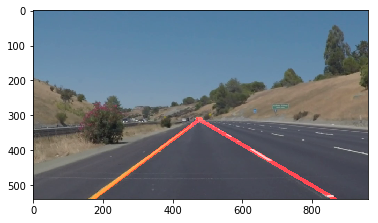

In [18]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))